In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV1'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

IQ signals Modulation_Label  \
0       [[-0.0059014712, -0.0023458179, -0.00074506126...             QPSK   
1       [[0.0050326153, 0.00094379985, -0.0018932355, ...             QPSK   
2       [[0.0052390713, 0.0073890695, 0.007276459, 0.0...             QPSK   
3       [[-0.0019859935, -0.0071501383, -0.00527185, -...             QPSK   
4       [[0.006674405, 0.0028359746, 0.005630027, 0.00...             QPSK   
...                                                   ...              ...   
219995  [[0.0062732296, -0.0050519477, 0.006672171, 0....             BPSK   
219996  [[-0.003903181, -0.0015884301, -0.00633375, 2....             BPSK   
219997  [[-0.0105958255, 0.005601244, -0.012161784, 0....             BPSK   
219998  [[-0.002136606, 0.00995837, 0.0059440527, -0.0...             BPSK   
219999  [[-0.008169517, 0.0013303901, -0.002522387, -0...             BPSK   

        SNR  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
219995  -18  
219996  -18  
219997  -18  
219998  -18  
219999  -18  

[220000 rows x 3 columns]

# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v1(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        80        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 16)        16400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:55:31 - loss: 2.3979

  2/581 [..............................] - ETA: 33s - loss: 2.3979    

  3/581 [..............................] - ETA: 32s - loss: 2.3979

  4/581 [..............................] - ETA: 32s - loss: 2.3980

  5/581 [..............................] - ETA: 32s - loss: 2.3980

  6/581 [..............................] - ETA: 32s - loss: 2.3980

  7/581 [..............................] - ETA: 32s - loss: 2.3980

  8/581 [..............................] - ETA: 32s - loss: 2.3980

  9/581 [..............................] - ETA: 32s - loss: 2.3980

 10/581 [..............................] - ETA: 32s - loss: 2.3980

 11/581 [..............................] - ETA: 32s - loss: 2.3980

 12/581 [..............................] - ETA: 32s - loss: 2.3980

 13/581 [..............................] - ETA: 32s - loss: 2.3980

 14/581 [..............................] - ETA: 32s - loss: 2.3980

 15/581 [..............................] - ETA: 32s - loss: 2.3980

 16/581 [..............................] - ETA: 31s - loss: 2.3980

 17/581 [..............................] - ETA: 31s - loss: 2.3980

 18/581 [..............................] - ETA: 31s - loss: 2.3980

 19/581 [..............................] - ETA: 31s - loss: 2.3980

 20/581 [>.............................] - ETA: 31s - loss: 2.3979

 21/581 [>.............................] - ETA: 31s - loss: 2.3979

 22/581 [>.............................] - ETA: 31s - loss: 2.3979

 23/581 [>.............................] - ETA: 31s - loss: 2.3979

 24/581 [>.............................] - ETA: 31s - loss: 2.3979

 25/581 [>.............................] - ETA: 31s - loss: 2.3978

 26/581 [>.............................] - ETA: 31s - loss: 2.3978

 27/581 [>.............................] - ETA: 31s - loss: 2.3978

 28/581 [>.............................] - ETA: 31s - loss: 2.3978

 29/581 [>.............................] - ETA: 31s - loss: 2.3977

 30/581 [>.............................] - ETA: 31s - loss: 2.3977

 31/581 [>.............................] - ETA: 30s - loss: 2.3977

 32/581 [>.............................] - ETA: 30s - loss: 2.3976

 33/581 [>.............................] - ETA: 30s - loss: 2.3976

 34/581 [>.............................] - ETA: 30s - loss: 2.3976

 35/581 [>.............................] - ETA: 30s - loss: 2.3975

 36/581 [>.............................] - ETA: 30s - loss: 2.3975

 37/581 [>.............................] - ETA: 30s - loss: 2.3974

 38/581 [>.............................] - ETA: 30s - loss: 2.3974

 39/581 [=>............................] - ETA: 30s - loss: 2.3973

 40/581 [=>............................] - ETA: 30s - loss: 2.3972

 41/581 [=>............................] - ETA: 30s - loss: 2.3971

 42/581 [=>............................] - ETA: 30s - loss: 2.3971

 43/581 [=>............................] - ETA: 30s - loss: 2.3970

 44/581 [=>............................] - ETA: 30s - loss: 2.3969

 45/581 [=>............................] - ETA: 30s - loss: 2.3968

 46/581 [=>............................] - ETA: 30s - loss: 2.3967

 47/581 [=>............................] - ETA: 30s - loss: 2.3966

 48/581 [=>............................] - ETA: 30s - loss: 2.3964

 49/581 [=>............................] - ETA: 30s - loss: 2.3963

 50/581 [=>............................] - ETA: 29s - loss: 2.3962

 51/581 [=>............................] - ETA: 29s - loss: 2.3960

 52/581 [=>............................] - ETA: 29s - loss: 2.3958

 53/581 [=>............................] - ETA: 29s - loss: 2.3957

 54/581 [=>............................] - ETA: 29s - loss: 2.3955

 55/581 [=>............................] - ETA: 29s - loss: 2.3953

 56/581 [=>............................] - ETA: 29s - loss: 2.3951

 57/581 [=>............................] - ETA: 29s - loss: 2.3949

 58/581 [=>............................] - ETA: 29s - loss: 2.3946

 59/581 [==>...........................] - ETA: 29s - loss: 2.3944

 60/581 [==>...........................] - ETA: 29s - loss: 2.3941

 61/581 [==>...........................] - ETA: 29s - loss: 2.3939

 62/581 [==>...........................] - ETA: 29s - loss: 2.3936

 63/581 [==>...........................] - ETA: 29s - loss: 2.3933

 64/581 [==>...........................] - ETA: 29s - loss: 2.3930

 65/581 [==>...........................] - ETA: 29s - loss: 2.3926

 66/581 [==>...........................] - ETA: 29s - loss: 2.3923

 67/581 [==>...........................] - ETA: 28s - loss: 2.3919

 68/581 [==>...........................] - ETA: 28s - loss: 2.3916

 69/581 [==>...........................] - ETA: 28s - loss: 2.3912

 70/581 [==>...........................] - ETA: 28s - loss: 2.3908

 71/581 [==>...........................] - ETA: 28s - loss: 2.3904

 72/581 [==>...........................] - ETA: 28s - loss: 2.3900

 73/581 [==>...........................] - ETA: 28s - loss: 2.3896

 74/581 [==>...........................] - ETA: 28s - loss: 2.3892

 75/581 [==>...........................] - ETA: 28s - loss: 2.3888

 76/581 [==>...........................] - ETA: 28s - loss: 2.3884

 77/581 [==>...........................] - ETA: 28s - loss: 2.3880

 78/581 [===>..........................] - ETA: 28s - loss: 2.3875

 79/581 [===>..........................] - ETA: 28s - loss: 2.3871

 80/581 [===>..........................] - ETA: 28s - loss: 2.3866

 81/581 [===>..........................] - ETA: 28s - loss: 2.3862

 82/581 [===>..........................] - ETA: 28s - loss: 2.3857

 83/581 [===>..........................] - ETA: 28s - loss: 2.3853

 84/581 [===>..........................] - ETA: 28s - loss: 2.3848

 85/581 [===>..........................] - ETA: 27s - loss: 2.3843

 86/581 [===>..........................] - ETA: 27s - loss: 2.3839

 87/581 [===>..........................] - ETA: 27s - loss: 2.3834

 88/581 [===>..........................] - ETA: 27s - loss: 2.3829

 89/581 [===>..........................] - ETA: 27s - loss: 2.3825

 90/581 [===>..........................] - ETA: 27s - loss: 2.3820

 91/581 [===>..........................] - ETA: 27s - loss: 2.3815

 92/581 [===>..........................] - ETA: 27s - loss: 2.3810

 93/581 [===>..........................] - ETA: 27s - loss: 2.3805

 94/581 [===>..........................] - ETA: 27s - loss: 2.3800

 95/581 [===>..........................] - ETA: 27s - loss: 2.3796

 96/581 [===>..........................] - ETA: 27s - loss: 2.3791

 97/581 [====>.........................] - ETA: 27s - loss: 2.3786

 98/581 [====>.........................] - ETA: 27s - loss: 2.3781

 99/581 [====>.........................] - ETA: 27s - loss: 2.3776

100/581 [====>.........................] - ETA: 27s - loss: 2.3771

101/581 [====>.........................] - ETA: 27s - loss: 2.3766

102/581 [====>.........................] - ETA: 27s - loss: 2.3761

103/581 [====>.........................] - ETA: 26s - loss: 2.3757

104/581 [====>.........................] - ETA: 26s - loss: 2.3752

105/581 [====>.........................] - ETA: 26s - loss: 2.3747

106/581 [====>.........................] - ETA: 26s - loss: 2.3742

107/581 [====>.........................] - ETA: 26s - loss: 2.3737

108/581 [====>.........................] - ETA: 26s - loss: 2.3732

109/581 [====>.........................] - ETA: 26s - loss: 2.3727

110/581 [====>.........................] - ETA: 26s - loss: 2.3722

111/581 [====>.........................] - ETA: 26s - loss: 2.3717

112/581 [====>.........................] - ETA: 26s - loss: 2.3712

113/581 [====>.........................] - ETA: 26s - loss: 2.3707

114/581 [====>.........................] - ETA: 26s - loss: 2.3702

115/581 [====>.........................] - ETA: 26s - loss: 2.3697

116/581 [====>.........................] - ETA: 26s - loss: 2.3692

117/581 [=====>........................] - ETA: 26s - loss: 2.3687

118/581 [=====>........................] - ETA: 26s - loss: 2.3682

119/581 [=====>........................] - ETA: 26s - loss: 2.3677

120/581 [=====>........................] - ETA: 26s - loss: 2.3673

121/581 [=====>........................] - ETA: 25s - loss: 2.3668

122/581 [=====>........................] - ETA: 25s - loss: 2.3663

123/581 [=====>........................] - ETA: 25s - loss: 2.3658

124/581 [=====>........................] - ETA: 25s - loss: 2.3653

125/581 [=====>........................] - ETA: 25s - loss: 2.3648

126/581 [=====>........................] - ETA: 25s - loss: 2.3643

127/581 [=====>........................] - ETA: 25s - loss: 2.3638

128/581 [=====>........................] - ETA: 25s - loss: 2.3633

129/581 [=====>........................] - ETA: 25s - loss: 2.3628

130/581 [=====>........................] - ETA: 25s - loss: 2.3624

131/581 [=====>........................] - ETA: 25s - loss: 2.3619

132/581 [=====>........................] - ETA: 25s - loss: 2.3614

133/581 [=====>........................] - ETA: 25s - loss: 2.3609

134/581 [=====>........................] - ETA: 25s - loss: 2.3604

135/581 [=====>........................] - ETA: 25s - loss: 2.3599

136/581 [======>.......................] - ETA: 25s - loss: 2.3594

137/581 [======>.......................] - ETA: 25s - loss: 2.3589

138/581 [======>.......................] - ETA: 25s - loss: 2.3584

139/581 [======>.......................] - ETA: 24s - loss: 2.3580

140/581 [======>.......................] - ETA: 24s - loss: 2.3575

141/581 [======>.......................] - ETA: 24s - loss: 2.3570

142/581 [======>.......................] - ETA: 24s - loss: 2.3565

143/581 [======>.......................] - ETA: 24s - loss: 2.3560

144/581 [======>.......................] - ETA: 24s - loss: 2.3555

145/581 [======>.......................] - ETA: 24s - loss: 2.3550

146/581 [======>.......................] - ETA: 24s - loss: 2.3545

147/581 [======>.......................] - ETA: 24s - loss: 2.3541

148/581 [======>.......................] - ETA: 24s - loss: 2.3536

149/581 [======>.......................] - ETA: 24s - loss: 2.3531

150/581 [======>.......................] - ETA: 24s - loss: 2.3526

151/581 [======>.......................] - ETA: 24s - loss: 2.3522

152/581 [======>.......................] - ETA: 24s - loss: 2.3517

153/581 [======>.......................] - ETA: 24s - loss: 2.3512

154/581 [======>.......................] - ETA: 24s - loss: 2.3508

155/581 [=======>......................] - ETA: 24s - loss: 2.3503

156/581 [=======>......................] - ETA: 23s - loss: 2.3498

157/581 [=======>......................] - ETA: 23s - loss: 2.3494

158/581 [=======>......................] - ETA: 23s - loss: 2.3489

159/581 [=======>......................] - ETA: 23s - loss: 2.3485

160/581 [=======>......................] - ETA: 23s - loss: 2.3480

161/581 [=======>......................] - ETA: 23s - loss: 2.3476

162/581 [=======>......................] - ETA: 23s - loss: 2.3471

163/581 [=======>......................] - ETA: 23s - loss: 2.3466

164/581 [=======>......................] - ETA: 23s - loss: 2.3462

165/581 [=======>......................] - ETA: 23s - loss: 2.3458

166/581 [=======>......................] - ETA: 23s - loss: 2.3453

167/581 [=======>......................] - ETA: 23s - loss: 2.3449

168/581 [=======>......................] - ETA: 23s - loss: 2.3444

169/581 [=======>......................] - ETA: 23s - loss: 2.3440

170/581 [=======>......................] - ETA: 23s - loss: 2.3435

171/581 [=======>......................] - ETA: 23s - loss: 2.3431

172/581 [=======>......................] - ETA: 23s - loss: 2.3426

173/581 [=======>......................] - ETA: 23s - loss: 2.3422

174/581 [=======>......................] - ETA: 22s - loss: 2.3418

175/581 [========>.....................] - ETA: 22s - loss: 2.3413

176/581 [========>.....................] - ETA: 22s - loss: 2.3409

177/581 [========>.....................] - ETA: 22s - loss: 2.3405

178/581 [========>.....................] - ETA: 22s - loss: 2.3400

179/581 [========>.....................] - ETA: 22s - loss: 2.3396

180/581 [========>.....................] - ETA: 22s - loss: 2.3392

181/581 [========>.....................] - ETA: 22s - loss: 2.3387

182/581 [========>.....................] - ETA: 22s - loss: 2.3383

183/581 [========>.....................] - ETA: 22s - loss: 2.3379

184/581 [========>.....................] - ETA: 22s - loss: 2.3374

185/581 [========>.....................] - ETA: 22s - loss: 2.3370

186/581 [========>.....................] - ETA: 22s - loss: 2.3366

187/581 [========>.....................] - ETA: 22s - loss: 2.3361

188/581 [========>.....................] - ETA: 22s - loss: 2.3357

189/581 [========>.....................] - ETA: 22s - loss: 2.3353

190/581 [========>.....................] - ETA: 22s - loss: 2.3349

191/581 [========>.....................] - ETA: 22s - loss: 2.3344

192/581 [========>.....................] - ETA: 21s - loss: 2.3340

193/581 [========>.....................] - ETA: 21s - loss: 2.3336

194/581 [=========>....................] - ETA: 21s - loss: 2.3332

195/581 [=========>....................] - ETA: 21s - loss: 2.3327

196/581 [=========>....................] - ETA: 21s - loss: 2.3323

197/581 [=========>....................] - ETA: 21s - loss: 2.3319

198/581 [=========>....................] - ETA: 21s - loss: 2.3315

199/581 [=========>....................] - ETA: 21s - loss: 2.3311

200/581 [=========>....................] - ETA: 21s - loss: 2.3306

201/581 [=========>....................] - ETA: 21s - loss: 2.3302

202/581 [=========>....................] - ETA: 21s - loss: 2.3298

203/581 [=========>....................] - ETA: 21s - loss: 2.3294

204/581 [=========>....................] - ETA: 21s - loss: 2.3290

205/581 [=========>....................] - ETA: 21s - loss: 2.3286

206/581 [=========>....................] - ETA: 21s - loss: 2.3281

207/581 [=========>....................] - ETA: 21s - loss: 2.3277

208/581 [=========>....................] - ETA: 21s - loss: 2.3273

209/581 [=========>....................] - ETA: 20s - loss: 2.3269

210/581 [=========>....................] - ETA: 20s - loss: 2.3265

211/581 [=========>....................] - ETA: 20s - loss: 2.3261

212/581 [=========>....................] - ETA: 20s - loss: 2.3257

213/581 [=========>....................] - ETA: 20s - loss: 2.3253

214/581 [==========>...................] - ETA: 20s - loss: 2.3249

215/581 [==========>...................] - ETA: 20s - loss: 2.3245

216/581 [==========>...................] - ETA: 20s - loss: 2.3241

217/581 [==========>...................] - ETA: 20s - loss: 2.3237

218/581 [==========>...................] - ETA: 20s - loss: 2.3233

219/581 [==========>...................] - ETA: 20s - loss: 2.3229

220/581 [==========>...................] - ETA: 20s - loss: 2.3225

221/581 [==========>...................] - ETA: 20s - loss: 2.3221

222/581 [==========>...................] - ETA: 20s - loss: 2.3217

223/581 [==========>...................] - ETA: 20s - loss: 2.3214

224/581 [==========>...................] - ETA: 20s - loss: 2.3210

225/581 [==========>...................] - ETA: 20s - loss: 2.3206

226/581 [==========>...................] - ETA: 20s - loss: 2.3202

227/581 [==========>...................] - ETA: 19s - loss: 2.3198

228/581 [==========>...................] - ETA: 19s - loss: 2.3194

229/581 [==========>...................] - ETA: 19s - loss: 2.3191

230/581 [==========>...................] - ETA: 19s - loss: 2.3187

231/581 [==========>...................] - ETA: 19s - loss: 2.3183

232/581 [==========>...................] - ETA: 19s - loss: 2.3179

233/581 [===========>..................] - ETA: 19s - loss: 2.3176

234/581 [===========>..................] - ETA: 19s - loss: 2.3172

235/581 [===========>..................] - ETA: 19s - loss: 2.3168

236/581 [===========>..................] - ETA: 19s - loss: 2.3164

237/581 [===========>..................] - ETA: 19s - loss: 2.3161

238/581 [===========>..................] - ETA: 19s - loss: 2.3157

239/581 [===========>..................] - ETA: 19s - loss: 2.3153

240/581 [===========>..................] - ETA: 19s - loss: 2.3149

241/581 [===========>..................] - ETA: 19s - loss: 2.3146

242/581 [===========>..................] - ETA: 19s - loss: 2.3142

243/581 [===========>..................] - ETA: 19s - loss: 2.3138

244/581 [===========>..................] - ETA: 19s - loss: 2.3135

245/581 [===========>..................] - ETA: 18s - loss: 2.3131

246/581 [===========>..................] - ETA: 18s - loss: 2.3127

247/581 [===========>..................] - ETA: 18s - loss: 2.3124

248/581 [===========>..................] - ETA: 18s - loss: 2.3120

249/581 [===========>..................] - ETA: 18s - loss: 2.3117

250/581 [===========>..................] - ETA: 18s - loss: 2.3113

251/581 [===========>..................] - ETA: 18s - loss: 2.3109

252/581 [============>.................] - ETA: 18s - loss: 2.3106

253/581 [============>.................] - ETA: 18s - loss: 2.3102

254/581 [============>.................] - ETA: 18s - loss: 2.3099

255/581 [============>.................] - ETA: 18s - loss: 2.3095

256/581 [============>.................] - ETA: 18s - loss: 2.3092

257/581 [============>.................] - ETA: 18s - loss: 2.3088

258/581 [============>.................] - ETA: 18s - loss: 2.3084

259/581 [============>.................] - ETA: 18s - loss: 2.3081

260/581 [============>.................] - ETA: 18s - loss: 2.3077

261/581 [============>.................] - ETA: 18s - loss: 2.3074

262/581 [============>.................] - ETA: 17s - loss: 2.3070

263/581 [============>.................] - ETA: 17s - loss: 2.3067

264/581 [============>.................] - ETA: 17s - loss: 2.3064

265/581 [============>.................] - ETA: 17s - loss: 2.3060

266/581 [============>.................] - ETA: 17s - loss: 2.3057

267/581 [============>.................] - ETA: 17s - loss: 2.3053

268/581 [============>.................] - ETA: 17s - loss: 2.3050

269/581 [============>.................] - ETA: 17s - loss: 2.3046

270/581 [============>.................] - ETA: 17s - loss: 2.3043

271/581 [============>.................] - ETA: 17s - loss: 2.3039

272/581 [=============>................] - ETA: 17s - loss: 2.3036

273/581 [=============>................] - ETA: 17s - loss: 2.3033

274/581 [=============>................] - ETA: 17s - loss: 2.3029

275/581 [=============>................] - ETA: 17s - loss: 2.3026

276/581 [=============>................] - ETA: 17s - loss: 2.3023

277/581 [=============>................] - ETA: 17s - loss: 2.3019

278/581 [=============>................] - ETA: 17s - loss: 2.3016

279/581 [=============>................] - ETA: 17s - loss: 2.3012

280/581 [=============>................] - ETA: 16s - loss: 2.3009

281/581 [=============>................] - ETA: 16s - loss: 2.3006

282/581 [=============>................] - ETA: 16s - loss: 2.3002

283/581 [=============>................] - ETA: 16s - loss: 2.2999

284/581 [=============>................] - ETA: 16s - loss: 2.2996

285/581 [=============>................] - ETA: 16s - loss: 2.2993

286/581 [=============>................] - ETA: 16s - loss: 2.2989

287/581 [=============>................] - ETA: 16s - loss: 2.2986

288/581 [=============>................] - ETA: 16s - loss: 2.2983

289/581 [=============>................] - ETA: 16s - loss: 2.2979

290/581 [=============>................] - ETA: 16s - loss: 2.2976

291/581 [==============>...............] - ETA: 16s - loss: 2.2973

292/581 [==============>...............] - ETA: 16s - loss: 2.2970

293/581 [==============>...............] - ETA: 16s - loss: 2.2966

294/581 [==============>...............] - ETA: 16s - loss: 2.2963

295/581 [==============>...............] - ETA: 16s - loss: 2.2960

296/581 [==============>...............] - ETA: 16s - loss: 2.2957

297/581 [==============>...............] - ETA: 16s - loss: 2.2953

298/581 [==============>...............] - ETA: 15s - loss: 2.2950

299/581 [==============>...............] - ETA: 15s - loss: 2.2947

300/581 [==============>...............] - ETA: 15s - loss: 2.2944

301/581 [==============>...............] - ETA: 15s - loss: 2.2941

302/581 [==============>...............] - ETA: 15s - loss: 2.2937

303/581 [==============>...............] - ETA: 15s - loss: 2.2934

304/581 [==============>...............] - ETA: 15s - loss: 2.2931

305/581 [==============>...............] - ETA: 15s - loss: 2.2928

306/581 [==============>...............] - ETA: 15s - loss: 2.2925

307/581 [==============>...............] - ETA: 15s - loss: 2.2922

308/581 [==============>...............] - ETA: 15s - loss: 2.2919

309/581 [==============>...............] - ETA: 15s - loss: 2.2915

310/581 [===============>..............] - ETA: 15s - loss: 2.2912

311/581 [===============>..............] - ETA: 15s - loss: 2.2909

312/581 [===============>..............] - ETA: 15s - loss: 2.2906

313/581 [===============>..............] - ETA: 15s - loss: 2.2903

314/581 [===============>..............] - ETA: 15s - loss: 2.2900

315/581 [===============>..............] - ETA: 15s - loss: 2.2897

316/581 [===============>..............] - ETA: 14s - loss: 2.2894

317/581 [===============>..............] - ETA: 14s - loss: 2.2891

318/581 [===============>..............] - ETA: 14s - loss: 2.2887

319/581 [===============>..............] - ETA: 14s - loss: 2.2884

320/581 [===============>..............] - ETA: 14s - loss: 2.2881

321/581 [===============>..............] - ETA: 14s - loss: 2.2878

322/581 [===============>..............] - ETA: 14s - loss: 2.2875

323/581 [===============>..............] - ETA: 14s - loss: 2.2872

324/581 [===============>..............] - ETA: 14s - loss: 2.2869

325/581 [===============>..............] - ETA: 14s - loss: 2.2866

326/581 [===============>..............] - ETA: 14s - loss: 2.2863

327/581 [===============>..............] - ETA: 14s - loss: 2.2860

328/581 [===============>..............] - ETA: 14s - loss: 2.2857

329/581 [===============>..............] - ETA: 14s - loss: 2.2854

330/581 [================>.............] - ETA: 14s - loss: 2.2851

331/581 [================>.............] - ETA: 14s - loss: 2.2848

332/581 [================>.............] - ETA: 14s - loss: 2.2845

333/581 [================>.............] - ETA: 13s - loss: 2.2842

334/581 [================>.............] - ETA: 13s - loss: 2.2839

335/581 [================>.............] - ETA: 13s - loss: 2.2836

336/581 [================>.............] - ETA: 13s - loss: 2.2833

337/581 [================>.............] - ETA: 13s - loss: 2.2831

338/581 [================>.............] - ETA: 13s - loss: 2.2828

339/581 [================>.............] - ETA: 13s - loss: 2.2825

340/581 [================>.............] - ETA: 13s - loss: 2.2822

341/581 [================>.............] - ETA: 13s - loss: 2.2819

342/581 [================>.............] - ETA: 13s - loss: 2.2816

343/581 [================>.............] - ETA: 13s - loss: 2.2813

344/581 [================>.............] - ETA: 13s - loss: 2.2810

345/581 [================>.............] - ETA: 13s - loss: 2.2807

346/581 [================>.............] - ETA: 13s - loss: 2.2804

347/581 [================>.............] - ETA: 13s - loss: 2.2801

348/581 [================>.............] - ETA: 13s - loss: 2.2799

349/581 [=================>............] - ETA: 13s - loss: 2.2796

350/581 [=================>............] - ETA: 13s - loss: 2.2793

351/581 [=================>............] - ETA: 12s - loss: 2.2790

352/581 [=================>............] - ETA: 12s - loss: 2.2787

353/581 [=================>............] - ETA: 12s - loss: 2.2784

354/581 [=================>............] - ETA: 12s - loss: 2.2781

355/581 [=================>............] - ETA: 12s - loss: 2.2779

356/581 [=================>............] - ETA: 12s - loss: 2.2776

357/581 [=================>............] - ETA: 12s - loss: 2.2773

358/581 [=================>............] - ETA: 12s - loss: 2.2770

359/581 [=================>............] - ETA: 12s - loss: 2.2767

360/581 [=================>............] - ETA: 12s - loss: 2.2764

361/581 [=================>............] - ETA: 12s - loss: 2.2762

362/581 [=================>............] - ETA: 12s - loss: 2.2759

363/581 [=================>............] - ETA: 12s - loss: 2.2756

364/581 [=================>............] - ETA: 12s - loss: 2.2753

365/581 [=================>............] - ETA: 12s - loss: 2.2751

366/581 [=================>............] - ETA: 12s - loss: 2.2748

367/581 [=================>............] - ETA: 12s - loss: 2.2745

368/581 [==================>...........] - ETA: 12s - loss: 2.2742

369/581 [==================>...........] - ETA: 11s - loss: 2.2739

370/581 [==================>...........] - ETA: 11s - loss: 2.2737

371/581 [==================>...........] - ETA: 11s - loss: 2.2734

372/581 [==================>...........] - ETA: 11s - loss: 2.2731

373/581 [==================>...........] - ETA: 11s - loss: 2.2728

374/581 [==================>...........] - ETA: 11s - loss: 2.2726

375/581 [==================>...........] - ETA: 11s - loss: 2.2723

376/581 [==================>...........] - ETA: 11s - loss: 2.2720

377/581 [==================>...........] - ETA: 11s - loss: 2.2718

378/581 [==================>...........] - ETA: 11s - loss: 2.2715

379/581 [==================>...........] - ETA: 11s - loss: 2.2712

380/581 [==================>...........] - ETA: 11s - loss: 2.2709

381/581 [==================>...........] - ETA: 11s - loss: 2.2707

382/581 [==================>...........] - ETA: 11s - loss: 2.2704

383/581 [==================>...........] - ETA: 11s - loss: 2.2701

384/581 [==================>...........] - ETA: 11s - loss: 2.2699

385/581 [==================>...........] - ETA: 11s - loss: 2.2696

386/581 [==================>...........] - ETA: 10s - loss: 2.2693

387/581 [==================>...........] - ETA: 10s - loss: 2.2691

388/581 [===================>..........] - ETA: 10s - loss: 2.2688

389/581 [===================>..........] - ETA: 10s - loss: 2.2685

390/581 [===================>..........] - ETA: 10s - loss: 2.2683

391/581 [===================>..........] - ETA: 10s - loss: 2.2680

392/581 [===================>..........] - ETA: 10s - loss: 2.2677

393/581 [===================>..........] - ETA: 10s - loss: 2.2675

394/581 [===================>..........] - ETA: 10s - loss: 2.2672

395/581 [===================>..........] - ETA: 10s - loss: 2.2670

396/581 [===================>..........] - ETA: 10s - loss: 2.2667

397/581 [===================>..........] - ETA: 10s - loss: 2.2664

398/581 [===================>..........] - ETA: 10s - loss: 2.2662

399/581 [===================>..........] - ETA: 10s - loss: 2.2659

400/581 [===================>..........] - ETA: 10s - loss: 2.2656

401/581 [===================>..........] - ETA: 10s - loss: 2.2654

402/581 [===================>..........] - ETA: 10s - loss: 2.2651

403/581 [===================>..........] - ETA: 10s - loss: 2.2649

404/581 [===================>..........] - ETA: 9s - loss: 2.2646 

405/581 [===================>..........] - ETA: 9s - loss: 2.2644

406/581 [===================>..........] - ETA: 9s - loss: 2.2641

407/581 [====================>.........] - ETA: 9s - loss: 2.2638

408/581 [====================>.........] - ETA: 9s - loss: 2.2636

409/581 [====================>.........] - ETA: 9s - loss: 2.2633

410/581 [====================>.........] - ETA: 9s - loss: 2.2631

411/581 [====================>.........] - ETA: 9s - loss: 2.2628

412/581 [====================>.........] - ETA: 9s - loss: 2.2626

413/581 [====================>.........] - ETA: 9s - loss: 2.2623

414/581 [====================>.........] - ETA: 9s - loss: 2.2621

415/581 [====================>.........] - ETA: 9s - loss: 2.2618

416/581 [====================>.........] - ETA: 9s - loss: 2.2615

417/581 [====================>.........] - ETA: 9s - loss: 2.2613

418/581 [====================>.........] - ETA: 9s - loss: 2.2610

419/581 [====================>.........] - ETA: 9s - loss: 2.2608

420/581 [====================>.........] - ETA: 9s - loss: 2.2605

421/581 [====================>.........] - ETA: 9s - loss: 2.2603

422/581 [====================>.........] - ETA: 8s - loss: 2.2600

423/581 [====================>.........] - ETA: 8s - loss: 2.2598

424/581 [====================>.........] - ETA: 8s - loss: 2.2595

425/581 [====================>.........] - ETA: 8s - loss: 2.2593

426/581 [====================>.........] - ETA: 8s - loss: 2.2590

427/581 [=====================>........] - ETA: 8s - loss: 2.2588

428/581 [=====================>........] - ETA: 8s - loss: 2.2585

429/581 [=====================>........] - ETA: 8s - loss: 2.2583

430/581 [=====================>........] - ETA: 8s - loss: 2.2580

431/581 [=====================>........] - ETA: 8s - loss: 2.2578

432/581 [=====================>........] - ETA: 8s - loss: 2.2575

433/581 [=====================>........] - ETA: 8s - loss: 2.2573

434/581 [=====================>........] - ETA: 8s - loss: 2.2570

435/581 [=====================>........] - ETA: 8s - loss: 2.2568

436/581 [=====================>........] - ETA: 8s - loss: 2.2566

437/581 [=====================>........] - ETA: 8s - loss: 2.2563

438/581 [=====================>........] - ETA: 8s - loss: 2.2561

439/581 [=====================>........] - ETA: 8s - loss: 2.2558

440/581 [=====================>........] - ETA: 7s - loss: 2.2556

441/581 [=====================>........] - ETA: 7s - loss: 2.2553

442/581 [=====================>........] - ETA: 7s - loss: 2.2551

443/581 [=====================>........] - ETA: 7s - loss: 2.2548

444/581 [=====================>........] - ETA: 7s - loss: 2.2546

445/581 [=====================>........] - ETA: 7s - loss: 2.2543

446/581 [======================>.......] - ETA: 7s - loss: 2.2541

447/581 [======================>.......] - ETA: 7s - loss: 2.2539

448/581 [======================>.......] - ETA: 7s - loss: 2.2536

449/581 [======================>.......] - ETA: 7s - loss: 2.2534

450/581 [======================>.......] - ETA: 7s - loss: 2.2531

451/581 [======================>.......] - ETA: 7s - loss: 2.2529

452/581 [======================>.......] - ETA: 7s - loss: 2.2526

453/581 [======================>.......] - ETA: 7s - loss: 2.2524

454/581 [======================>.......] - ETA: 7s - loss: 2.2522

455/581 [======================>.......] - ETA: 7s - loss: 2.2519

456/581 [======================>.......] - ETA: 7s - loss: 2.2517

457/581 [======================>.......] - ETA: 6s - loss: 2.2514

458/581 [======================>.......] - ETA: 6s - loss: 2.2512

459/581 [======================>.......] - ETA: 6s - loss: 2.2509

460/581 [======================>.......] - ETA: 6s - loss: 2.2507

461/581 [======================>.......] - ETA: 6s - loss: 2.2505

462/581 [======================>.......] - ETA: 6s - loss: 2.2502

463/581 [======================>.......] - ETA: 6s - loss: 2.2500

464/581 [======================>.......] - ETA: 6s - loss: 2.2497

465/581 [=======================>......] - ETA: 6s - loss: 2.2495

466/581 [=======================>......] - ETA: 6s - loss: 2.2493

467/581 [=======================>......] - ETA: 6s - loss: 2.2490

468/581 [=======================>......] - ETA: 6s - loss: 2.2488

469/581 [=======================>......] - ETA: 6s - loss: 2.2485

470/581 [=======================>......] - ETA: 6s - loss: 2.2483

471/581 [=======================>......] - ETA: 6s - loss: 2.2481

472/581 [=======================>......] - ETA: 6s - loss: 2.2478

473/581 [=======================>......] - ETA: 6s - loss: 2.2476

474/581 [=======================>......] - ETA: 6s - loss: 2.2474

475/581 [=======================>......] - ETA: 5s - loss: 2.2471

476/581 [=======================>......] - ETA: 5s - loss: 2.2469

477/581 [=======================>......] - ETA: 5s - loss: 2.2466

478/581 [=======================>......] - ETA: 5s - loss: 2.2464

479/581 [=======================>......] - ETA: 5s - loss: 2.2462

480/581 [=======================>......] - ETA: 5s - loss: 2.2459

481/581 [=======================>......] - ETA: 5s - loss: 2.2457

482/581 [=======================>......] - ETA: 5s - loss: 2.2455

483/581 [=======================>......] - ETA: 5s - loss: 2.2452

484/581 [=======================>......] - ETA: 5s - loss: 2.2450

485/581 [========================>.....] - ETA: 5s - loss: 2.2448

486/581 [========================>.....] - ETA: 5s - loss: 2.2445

487/581 [========================>.....] - ETA: 5s - loss: 2.2443

488/581 [========================>.....] - ETA: 5s - loss: 2.2440

489/581 [========================>.....] - ETA: 5s - loss: 2.2438

490/581 [========================>.....] - ETA: 5s - loss: 2.2436

491/581 [========================>.....] - ETA: 5s - loss: 2.2433

492/581 [========================>.....] - ETA: 5s - loss: 2.2431

493/581 [========================>.....] - ETA: 4s - loss: 2.2429

494/581 [========================>.....] - ETA: 4s - loss: 2.2426

495/581 [========================>.....] - ETA: 4s - loss: 2.2424

496/581 [========================>.....] - ETA: 4s - loss: 2.2422

497/581 [========================>.....] - ETA: 4s - loss: 2.2419

498/581 [========================>.....] - ETA: 4s - loss: 2.2417

499/581 [========================>.....] - ETA: 4s - loss: 2.2415

500/581 [========================>.....] - ETA: 4s - loss: 2.2412

501/581 [========================>.....] - ETA: 4s - loss: 2.2410

502/581 [========================>.....] - ETA: 4s - loss: 2.2408

503/581 [========================>.....] - ETA: 4s - loss: 2.2405

504/581 [=========================>....] - ETA: 4s - loss: 2.2403

505/581 [=========================>....] - ETA: 4s - loss: 2.2401

506/581 [=========================>....] - ETA: 4s - loss: 2.2398

507/581 [=========================>....] - ETA: 4s - loss: 2.2396

508/581 [=========================>....] - ETA: 4s - loss: 2.2394

509/581 [=========================>....] - ETA: 4s - loss: 2.2391

510/581 [=========================>....] - ETA: 4s - loss: 2.2389

511/581 [=========================>....] - ETA: 3s - loss: 2.2387

512/581 [=========================>....] - ETA: 3s - loss: 2.2384

513/581 [=========================>....] - ETA: 3s - loss: 2.2382

514/581 [=========================>....] - ETA: 3s - loss: 2.2380

515/581 [=========================>....] - ETA: 3s - loss: 2.2378

516/581 [=========================>....] - ETA: 3s - loss: 2.2375

517/581 [=========================>....] - ETA: 3s - loss: 2.2373

518/581 [=========================>....] - ETA: 3s - loss: 2.2371

519/581 [=========================>....] - ETA: 3s - loss: 2.2368

520/581 [=========================>....] - ETA: 3s - loss: 2.2366

521/581 [=========================>....] - ETA: 3s - loss: 2.2364

522/581 [=========================>....] - ETA: 3s - loss: 2.2361

523/581 [==========================>...] - ETA: 3s - loss: 2.2359

524/581 [==========================>...] - ETA: 3s - loss: 2.2357

525/581 [==========================>...] - ETA: 3s - loss: 2.2355

526/581 [==========================>...] - ETA: 3s - loss: 2.2352

527/581 [==========================>...] - ETA: 3s - loss: 2.2350

528/581 [==========================>...] - ETA: 2s - loss: 2.2348

529/581 [==========================>...] - ETA: 2s - loss: 2.2346

530/581 [==========================>...] - ETA: 2s - loss: 2.2343

531/581 [==========================>...] - ETA: 2s - loss: 2.2341

532/581 [==========================>...] - ETA: 2s - loss: 2.2339

533/581 [==========================>...] - ETA: 2s - loss: 2.2337

534/581 [==========================>...] - ETA: 2s - loss: 2.2334

535/581 [==========================>...] - ETA: 2s - loss: 2.2332

536/581 [==========================>...] - ETA: 2s - loss: 2.2330

537/581 [==========================>...] - ETA: 2s - loss: 2.2328

538/581 [==========================>...] - ETA: 2s - loss: 2.2325

539/581 [==========================>...] - ETA: 2s - loss: 2.2323

540/581 [==========================>...] - ETA: 2s - loss: 2.2321

541/581 [==========================>...] - ETA: 2s - loss: 2.2319

542/581 [==========================>...] - ETA: 2s - loss: 2.2316

543/581 [===========================>..] - ETA: 2s - loss: 2.2314

544/581 [===========================>..] - ETA: 2s - loss: 2.2312

545/581 [===========================>..] - ETA: 2s - loss: 2.2310

546/581 [===========================>..] - ETA: 1s - loss: 2.2307

547/581 [===========================>..] - ETA: 1s - loss: 2.2305

548/581 [===========================>..] - ETA: 1s - loss: 2.2303

549/581 [===========================>..] - ETA: 1s - loss: 2.2301

550/581 [===========================>..] - ETA: 1s - loss: 2.2298

551/581 [===========================>..] - ETA: 1s - loss: 2.2296

552/581 [===========================>..] - ETA: 1s - loss: 2.2294

553/581 [===========================>..] - ETA: 1s - loss: 2.2292

554/581 [===========================>..] - ETA: 1s - loss: 2.2289

555/581 [===========================>..] - ETA: 1s - loss: 2.2287

556/581 [===========================>..] - ETA: 1s - loss: 2.2285

557/581 [===========================>..] - ETA: 1s - loss: 2.2283

558/581 [===========================>..] - ETA: 1s - loss: 2.2280

559/581 [===========================>..] - ETA: 1s - loss: 2.2278

560/581 [===========================>..] - ETA: 1s - loss: 2.2276

561/581 [===========================>..] - ETA: 1s - loss: 2.2274

562/581 [============================>.] - ETA: 1s - loss: 2.2271

563/581 [============================>.] - ETA: 1s - loss: 2.2269

564/581 [============================>.] - ETA: 0s - loss: 2.2267

565/581 [============================>.] - ETA: 0s - loss: 2.2265

566/581 [============================>.] - ETA: 0s - loss: 2.2262

567/581 [============================>.] - ETA: 0s - loss: 2.2260

568/581 [============================>.] - ETA: 0s - loss: 2.2258

569/581 [============================>.] - ETA: 0s - loss: 2.2256

570/581 [============================>.] - ETA: 0s - loss: 2.2254

571/581 [============================>.] - ETA: 0s - loss: 2.2251

572/581 [============================>.] - ETA: 0s - loss: 2.2249

573/581 [============================>.] - ETA: 0s - loss: 2.2247

574/581 [============================>.] - ETA: 0s - loss: 2.2245

575/581 [============================>.] - ETA: 0s - loss: 2.2242

576/581 [============================>.] - ETA: 0s - loss: 2.2240

577/581 [============================>.] - ETA: 0s - loss: 2.2238

578/581 [============================>.] - ETA: 0s - loss: 2.2236

579/581 [============================>.] - ETA: 0s - loss: 2.2233

580/581 [============================>.] - ETA: 0s - loss: 2.2231

581/581 [==============================]

 - ETA: 0s - loss: 2.2229

581/581 [==============================] - 47s 60ms/step - loss: 2.2227 - val_loss: 1.8725


Epoch 2/100
  1/581 [..............................] - ETA: 32s - loss: 1.8436

  2/581 [..............................] - ETA: 32s - loss: 1.8588

  3/581 [..............................] - ETA: 32s - loss: 1.8626

  4/581 [..............................] - ETA: 32s - loss: 1.8632

  5/581 [..............................] - ETA: 32s - loss: 1.8641

  6/581 [..............................] - ETA: 32s - loss: 1.8650

  7/581 [..............................] - ETA: 32s - loss: 1.8643

  8/581 [..............................] - ETA: 32s - loss: 1.8627

  9/581 [..............................] - ETA: 32s - loss: 1.8615

 10/581 [..............................] - ETA: 32s - loss: 1.8611



 11/581 [..............................] - ETA: 32s - loss: 1.8606

 12/581 [..............................] - ETA: 32s - loss: 1.8600

 13/581 [..............................] - ETA: 32s - loss: 1.8594

 14/581 [..............................] - ETA: 32s - loss: 1.8589

 15/581 [..............................] - ETA: 32s - loss: 1.8584

 16/581 [..............................] - ETA: 32s - loss: 1.8578

 17/581 [..............................] - ETA: 31s - loss: 1.8573

 18/581 [..............................] - ETA: 31s - loss: 1.8569

 19/581 [..............................] - ETA: 31s - loss: 1.8566

 20/581 [>.............................] - ETA: 31s - loss: 1.8561

 21/581 [>.............................] - ETA: 31s - loss: 1.8557

 22/581 [>.............................] - ETA: 31s - loss: 1.8552

 23/581 [>.............................] - ETA: 31s - loss: 1.8547

 24/581 [>.............................] - ETA: 31s - loss: 1.8543

 25/581 [>.............................] - ETA: 31s - loss: 1.8539

 26/581 [>.............................] - ETA: 31s - loss: 1.8536

 27/581 [>.............................] - ETA: 31s - loss: 1.8532

 28/581 [>.............................] - ETA: 31s - loss: 1.8528

 29/581 [>.............................] - ETA: 31s - loss: 1.8524

 30/581 [>.............................] - ETA: 31s - loss: 1.8522

 31/581 [>.............................] - ETA: 31s - loss: 1.8519

 32/581 [>.............................] - ETA: 31s - loss: 1.8517

 33/581 [>.............................] - ETA: 30s - loss: 1.8515

 34/581 [>.............................] - ETA: 30s - loss: 1.8513

 35/581 [>.............................] - ETA: 30s - loss: 1.8511

 36/581 [>.............................] - ETA: 30s - loss: 1.8509

 37/581 [>.............................] - ETA: 30s - loss: 1.8507

 38/581 [>.............................] - ETA: 30s - loss: 1.8505

 39/581 [=>............................] - ETA: 30s - loss: 1.8503

 40/581 [=>............................] - ETA: 30s - loss: 1.8501

 41/581 [=>............................] - ETA: 30s - loss: 1.8499

 42/581 [=>............................] - ETA: 30s - loss: 1.8497

 43/581 [=>............................] - ETA: 30s - loss: 1.8495

 44/581 [=>............................] - ETA: 30s - loss: 1.8493

 45/581 [=>............................] - ETA: 30s - loss: 1.8491

 46/581 [=>............................] - ETA: 30s - loss: 1.8489

 47/581 [=>............................] - ETA: 30s - loss: 1.8487

 48/581 [=>............................] - ETA: 30s - loss: 1.8485

 49/581 [=>............................] - ETA: 30s - loss: 1.8483

 50/581 [=>............................] - ETA: 30s - loss: 1.8480

 51/581 [=>............................] - ETA: 29s - loss: 1.8478

 52/581 [=>............................] - ETA: 29s - loss: 1.8476

 53/581 [=>............................] - ETA: 29s - loss: 1.8473

 54/581 [=>............................] - ETA: 29s - loss: 1.8471

 55/581 [=>............................] - ETA: 29s - loss: 1.8468

 56/581 [=>............................] - ETA: 29s - loss: 1.8466

 57/581 [=>............................] - ETA: 29s - loss: 1.8463

 58/581 [=>............................] - ETA: 29s - loss: 1.8460

 59/581 [==>...........................] - ETA: 29s - loss: 1.8458

 60/581 [==>...........................] - ETA: 29s - loss: 1.8455

 61/581 [==>...........................] - ETA: 29s - loss: 1.8452

 62/581 [==>...........................] - ETA: 29s - loss: 1.8450

 63/581 [==>...........................] - ETA: 29s - loss: 1.8447

 64/581 [==>...........................] - ETA: 29s - loss: 1.8444

 65/581 [==>...........................] - ETA: 29s - loss: 1.8442

 66/581 [==>...........................] - ETA: 29s - loss: 1.8439

 67/581 [==>...........................] - ETA: 29s - loss: 1.8436

 68/581 [==>...........................] - ETA: 29s - loss: 1.8433

 69/581 [==>...........................] - ETA: 28s - loss: 1.8431

 70/581 [==>...........................] - ETA: 28s - loss: 1.8428

 71/581 [==>...........................] - ETA: 28s - loss: 1.8425

 72/581 [==>...........................] - ETA: 28s - loss: 1.8422

 73/581 [==>...........................] - ETA: 28s - loss: 1.8419

 74/581 [==>...........................] - ETA: 28s - loss: 1.8417

 75/581 [==>...........................] - ETA: 28s - loss: 1.8414

 76/581 [==>...........................] - ETA: 28s - loss: 1.8411

 77/581 [==>...........................] - ETA: 28s - loss: 1.8408

 78/581 [===>..........................] - ETA: 28s - loss: 1.8405

 79/581 [===>..........................] - ETA: 28s - loss: 1.8403

 80/581 [===>..........................] - ETA: 28s - loss: 1.8400

 81/581 [===>..........................] - ETA: 28s - loss: 1.8397

 82/581 [===>..........................] - ETA: 28s - loss: 1.8395

 83/581 [===>..........................] - ETA: 28s - loss: 1.8392

 84/581 [===>..........................] - ETA: 28s - loss: 1.8390

 85/581 [===>..........................] - ETA: 28s - loss: 1.8387

 86/581 [===>..........................] - ETA: 27s - loss: 1.8385

 87/581 [===>..........................] - ETA: 27s - loss: 1.8383

 88/581 [===>..........................] - ETA: 27s - loss: 1.8380

 89/581 [===>..........................] - ETA: 27s - loss: 1.8378

 90/581 [===>..........................] - ETA: 27s - loss: 1.8376

 91/581 [===>..........................] - ETA: 27s - loss: 1.8373

 92/581 [===>..........................] - ETA: 27s - loss: 1.8371

 93/581 [===>..........................] - ETA: 27s - loss: 1.8369

 94/581 [===>..........................] - ETA: 27s - loss: 1.8366

 95/581 [===>..........................] - ETA: 27s - loss: 1.8364

 96/581 [===>..........................] - ETA: 27s - loss: 1.8361

 97/581 [====>.........................] - ETA: 27s - loss: 1.8359

 98/581 [====>.........................] - ETA: 27s - loss: 1.8357

 99/581 [====>.........................] - ETA: 27s - loss: 1.8354

100/581 [====>.........................] - ETA: 27s - loss: 1.8352

101/581 [====>.........................] - ETA: 27s - loss: 1.8349

102/581 [====>.........................] - ETA: 27s - loss: 1.8347

103/581 [====>.........................] - ETA: 27s - loss: 1.8345

104/581 [====>.........................] - ETA: 26s - loss: 1.8342

105/581 [====>.........................] - ETA: 26s - loss: 1.8340

106/581 [====>.........................] - ETA: 26s - loss: 1.8337

107/581 [====>.........................] - ETA: 26s - loss: 1.8335

108/581 [====>.........................] - ETA: 26s - loss: 1.8333

109/581 [====>.........................] - ETA: 26s - loss: 1.8331

110/581 [====>.........................] - ETA: 26s - loss: 1.8328

111/581 [====>.........................] - ETA: 26s - loss: 1.8326

112/581 [====>.........................] - ETA: 26s - loss: 1.8324

113/581 [====>.........................] - ETA: 26s - loss: 1.8321

114/581 [====>.........................] - ETA: 26s - loss: 1.8319

115/581 [====>.........................] - ETA: 26s - loss: 1.8317

116/581 [====>.........................] - ETA: 26s - loss: 1.8315

117/581 [=====>........................] - ETA: 26s - loss: 1.8313

118/581 [=====>........................] - ETA: 26s - loss: 1.8311

119/581 [=====>........................] - ETA: 26s - loss: 1.8309

120/581 [=====>........................] - ETA: 26s - loss: 1.8307

121/581 [=====>........................] - ETA: 26s - loss: 1.8305

122/581 [=====>........................] - ETA: 25s - loss: 1.8303

123/581 [=====>........................] - ETA: 25s - loss: 1.8301

124/581 [=====>........................] - ETA: 25s - loss: 1.8299

125/581 [=====>........................] - ETA: 25s - loss: 1.8297

126/581 [=====>........................] - ETA: 25s - loss: 1.8295

127/581 [=====>........................] - ETA: 25s - loss: 1.8293

128/581 [=====>........................] - ETA: 25s - loss: 1.8291

129/581 [=====>........................] - ETA: 25s - loss: 1.8289

130/581 [=====>........................] - ETA: 25s - loss: 1.8287

131/581 [=====>........................] - ETA: 25s - loss: 1.8285

132/581 [=====>........................] - ETA: 25s - loss: 1.8283

133/581 [=====>........................] - ETA: 25s - loss: 1.8281

134/581 [=====>........................] - ETA: 25s - loss: 1.8279

135/581 [=====>........................] - ETA: 25s - loss: 1.8277

136/581 [======>.......................] - ETA: 25s - loss: 1.8275

137/581 [======>.......................] - ETA: 25s - loss: 1.8273

138/581 [======>.......................] - ETA: 25s - loss: 1.8271

139/581 [======>.......................] - ETA: 25s - loss: 1.8269

140/581 [======>.......................] - ETA: 24s - loss: 1.8267

141/581 [======>.......................] - ETA: 24s - loss: 1.8265

142/581 [======>.......................] - ETA: 24s - loss: 1.8264

143/581 [======>.......................] - ETA: 24s - loss: 1.8262

144/581 [======>.......................] - ETA: 24s - loss: 1.8260

145/581 [======>.......................] - ETA: 24s - loss: 1.8258

146/581 [======>.......................] - ETA: 24s - loss: 1.8256

147/581 [======>.......................] - ETA: 24s - loss: 1.8254

148/581 [======>.......................] - ETA: 24s - loss: 1.8252

149/581 [======>.......................] - ETA: 24s - loss: 1.8250

150/581 [======>.......................] - ETA: 24s - loss: 1.8248

151/581 [======>.......................] - ETA: 24s - loss: 1.8247

152/581 [======>.......................] - ETA: 24s - loss: 1.8245

153/581 [======>.......................] - ETA: 24s - loss: 1.8243

154/581 [======>.......................] - ETA: 24s - loss: 1.8241

155/581 [=======>......................] - ETA: 24s - loss: 1.8239

156/581 [=======>......................] - ETA: 24s - loss: 1.8237

157/581 [=======>......................] - ETA: 23s - loss: 1.8235

158/581 [=======>......................] - ETA: 23s - loss: 1.8233

159/581 [=======>......................] - ETA: 23s - loss: 1.8231

160/581 [=======>......................] - ETA: 23s - loss: 1.8230

161/581 [=======>......................] - ETA: 23s - loss: 1.8228

162/581 [=======>......................] - ETA: 23s - loss: 1.8226

163/581 [=======>......................] - ETA: 23s - loss: 1.8224

164/581 [=======>......................] - ETA: 23s - loss: 1.8222

165/581 [=======>......................] - ETA: 23s - loss: 1.8220

166/581 [=======>......................] - ETA: 23s - loss: 1.8218

167/581 [=======>......................] - ETA: 23s - loss: 1.8216

168/581 [=======>......................] - ETA: 23s - loss: 1.8215

169/581 [=======>......................] - ETA: 23s - loss: 1.8213

170/581 [=======>......................] - ETA: 23s - loss: 1.8211

171/581 [=======>......................] - ETA: 23s - loss: 1.8209

172/581 [=======>......................] - ETA: 23s - loss: 1.8207

173/581 [=======>......................] - ETA: 23s - loss: 1.8205

174/581 [=======>......................] - ETA: 23s - loss: 1.8204

175/581 [========>.....................] - ETA: 22s - loss: 1.8202

176/581 [========>.....................] - ETA: 22s - loss: 1.8200

177/581 [========>.....................] - ETA: 22s - loss: 1.8198

178/581 [========>.....................] - ETA: 22s - loss: 1.8196

179/581 [========>.....................] - ETA: 22s - loss: 1.8195

180/581 [========>.....................] - ETA: 22s - loss: 1.8193

181/581 [========>.....................] - ETA: 22s - loss: 1.8191

182/581 [========>.....................] - ETA: 22s - loss: 1.8189

183/581 [========>.....................] - ETA: 22s - loss: 1.8187

184/581 [========>.....................] - ETA: 22s - loss: 1.8186

185/581 [========>.....................] - ETA: 22s - loss: 1.8184

186/581 [========>.....................] - ETA: 22s - loss: 1.8182

187/581 [========>.....................] - ETA: 22s - loss: 1.8180

188/581 [========>.....................] - ETA: 22s - loss: 1.8179

189/581 [========>.....................] - ETA: 22s - loss: 1.8177

190/581 [========>.....................] - ETA: 22s - loss: 1.8175

191/581 [========>.....................] - ETA: 22s - loss: 1.8173

192/581 [========>.....................] - ETA: 21s - loss: 1.8172

193/581 [========>.....................] - ETA: 21s - loss: 1.8170

194/581 [=========>....................] - ETA: 21s - loss: 1.8168

195/581 [=========>....................] - ETA: 21s - loss: 1.8166

196/581 [=========>....................] - ETA: 21s - loss: 1.8165

197/581 [=========>....................] - ETA: 21s - loss: 1.8163

198/581 [=========>....................] - ETA: 21s - loss: 1.8161

199/581 [=========>....................] - ETA: 21s - loss: 1.8160

200/581 [=========>....................] - ETA: 21s - loss: 1.8158

201/581 [=========>....................] - ETA: 21s - loss: 1.8156

202/581 [=========>....................] - ETA: 21s - loss: 1.8155

203/581 [=========>....................] - ETA: 21s - loss: 1.8153

204/581 [=========>....................] - ETA: 21s - loss: 1.8151

205/581 [=========>....................] - ETA: 21s - loss: 1.8150

206/581 [=========>....................] - ETA: 21s - loss: 1.8148

207/581 [=========>....................] - ETA: 21s - loss: 1.8146

208/581 [=========>....................] - ETA: 21s - loss: 1.8145

209/581 [=========>....................] - ETA: 21s - loss: 1.8143

210/581 [=========>....................] - ETA: 20s - loss: 1.8141

211/581 [=========>....................] - ETA: 20s - loss: 1.8140

212/581 [=========>....................] - ETA: 20s - loss: 1.8138

213/581 [=========>....................] - ETA: 20s - loss: 1.8136

214/581 [==========>...................] - ETA: 20s - loss: 1.8134

215/581 [==========>...................] - ETA: 20s - loss: 1.8133

216/581 [==========>...................] - ETA: 20s - loss: 1.8131

217/581 [==========>...................] - ETA: 20s - loss: 1.8129

218/581 [==========>...................] - ETA: 20s - loss: 1.8128

219/581 [==========>...................] - ETA: 20s - loss: 1.8126

220/581 [==========>...................] - ETA: 20s - loss: 1.8124

221/581 [==========>...................] - ETA: 20s - loss: 1.8123

222/581 [==========>...................] - ETA: 20s - loss: 1.8121

223/581 [==========>...................] - ETA: 20s - loss: 1.8119

224/581 [==========>...................] - ETA: 20s - loss: 1.8118

225/581 [==========>...................] - ETA: 20s - loss: 1.8116

226/581 [==========>...................] - ETA: 20s - loss: 1.8114

227/581 [==========>...................] - ETA: 20s - loss: 1.8113

228/581 [==========>...................] - ETA: 19s - loss: 1.8111

229/581 [==========>...................] - ETA: 19s - loss: 1.8109

230/581 [==========>...................] - ETA: 19s - loss: 1.8108

231/581 [==========>...................] - ETA: 19s - loss: 1.8106

232/581 [==========>...................] - ETA: 19s - loss: 1.8104

233/581 [===========>..................] - ETA: 19s - loss: 1.8103

234/581 [===========>..................] - ETA: 19s - loss: 1.8101

235/581 [===========>..................] - ETA: 19s - loss: 1.8099

236/581 [===========>..................] - ETA: 19s - loss: 1.8097

237/581 [===========>..................] - ETA: 19s - loss: 1.8096

238/581 [===========>..................] - ETA: 19s - loss: 1.8094

239/581 [===========>..................] - ETA: 19s - loss: 1.8092

240/581 [===========>..................] - ETA: 19s - loss: 1.8091

241/581 [===========>..................] - ETA: 19s - loss: 1.8089

242/581 [===========>..................] - ETA: 19s - loss: 1.8087

243/581 [===========>..................] - ETA: 19s - loss: 1.8086

244/581 [===========>..................] - ETA: 19s - loss: 1.8084

245/581 [===========>..................] - ETA: 19s - loss: 1.8082

246/581 [===========>..................] - ETA: 18s - loss: 1.8081

247/581 [===========>..................] - ETA: 18s - loss: 1.8079

248/581 [===========>..................] - ETA: 18s - loss: 1.8077

249/581 [===========>..................] - ETA: 18s - loss: 1.8076

250/581 [===========>..................] - ETA: 18s - loss: 1.8074

251/581 [===========>..................] - ETA: 18s - loss: 1.8073

252/581 [============>.................] - ETA: 18s - loss: 1.8071

253/581 [============>.................] - ETA: 18s - loss: 1.8069

254/581 [============>.................] - ETA: 18s - loss: 1.8068

255/581 [============>.................] - ETA: 18s - loss: 1.8066

256/581 [============>.................] - ETA: 18s - loss: 1.8064

257/581 [============>.................] - ETA: 18s - loss: 1.8063

258/581 [============>.................] - ETA: 18s - loss: 1.8061

259/581 [============>.................] - ETA: 18s - loss: 1.8059

260/581 [============>.................] - ETA: 18s - loss: 1.8058

261/581 [============>.................] - ETA: 18s - loss: 1.8056

262/581 [============>.................] - ETA: 18s - loss: 1.8055

263/581 [============>.................] - ETA: 17s - loss: 1.8053

264/581 [============>.................] - ETA: 17s - loss: 1.8051

265/581 [============>.................] - ETA: 17s - loss: 1.8050

266/581 [============>.................] - ETA: 17s - loss: 1.8048

267/581 [============>.................] - ETA: 17s - loss: 1.8046

268/581 [============>.................] - ETA: 17s - loss: 1.8045

269/581 [============>.................] - ETA: 17s - loss: 1.8043

270/581 [============>.................] - ETA: 17s - loss: 1.8041

271/581 [============>.................] - ETA: 17s - loss: 1.8040

272/581 [=============>................] - ETA: 17s - loss: 1.8038

273/581 [=============>................] - ETA: 17s - loss: 1.8037

274/581 [=============>................] - ETA: 17s - loss: 1.8035

275/581 [=============>................] - ETA: 17s - loss: 1.8033

276/581 [=============>................] - ETA: 17s - loss: 1.8032

277/581 [=============>................] - ETA: 17s - loss: 1.8030

278/581 [=============>................] - ETA: 17s - loss: 1.8029

279/581 [=============>................] - ETA: 17s - loss: 1.8027

280/581 [=============>................] - ETA: 17s - loss: 1.8025

281/581 [=============>................] - ETA: 16s - loss: 1.8024

282/581 [=============>................] - ETA: 16s - loss: 1.8022

283/581 [=============>................] - ETA: 16s - loss: 1.8021

284/581 [=============>................] - ETA: 16s - loss: 1.8019

285/581 [=============>................] - ETA: 16s - loss: 1.8017

286/581 [=============>................] - ETA: 16s - loss: 1.8016

287/581 [=============>................] - ETA: 16s - loss: 1.8014

288/581 [=============>................] - ETA: 16s - loss: 1.8013

289/581 [=============>................] - ETA: 16s - loss: 1.8011

290/581 [=============>................] - ETA: 16s - loss: 1.8009

291/581 [==============>...............] - ETA: 16s - loss: 1.8008

292/581 [==============>...............] - ETA: 16s - loss: 1.8006

293/581 [==============>...............] - ETA: 16s - loss: 1.8005

294/581 [==============>...............] - ETA: 16s - loss: 1.8003

295/581 [==============>...............] - ETA: 16s - loss: 1.8002

296/581 [==============>...............] - ETA: 16s - loss: 1.8000

297/581 [==============>...............] - ETA: 16s - loss: 1.7999

298/581 [==============>...............] - ETA: 16s - loss: 1.7997

299/581 [==============>...............] - ETA: 15s - loss: 1.7995

300/581 [==============>...............] - ETA: 15s - loss: 1.7994

301/581 [==============>...............] - ETA: 15s - loss: 1.7992

302/581 [==============>...............] - ETA: 15s - loss: 1.7991

303/581 [==============>...............] - ETA: 15s - loss: 1.7989

304/581 [==============>...............] - ETA: 15s - loss: 1.7988

305/581 [==============>...............] - ETA: 15s - loss: 1.7986

306/581 [==============>...............] - ETA: 15s - loss: 1.7985

307/581 [==============>...............] - ETA: 15s - loss: 1.7983

308/581 [==============>...............] - ETA: 15s - loss: 1.7982

309/581 [==============>...............] - ETA: 15s - loss: 1.7980

310/581 [===============>..............] - ETA: 15s - loss: 1.7979

311/581 [===============>..............] - ETA: 15s - loss: 1.7977

312/581 [===============>..............] - ETA: 15s - loss: 1.7976

313/581 [===============>..............] - ETA: 15s - loss: 1.7974

314/581 [===============>..............] - ETA: 15s - loss: 1.7972

315/581 [===============>..............] - ETA: 15s - loss: 1.7971

316/581 [===============>..............] - ETA: 14s - loss: 1.7969

317/581 [===============>..............] - ETA: 14s - loss: 1.7968

318/581 [===============>..............] - ETA: 14s - loss: 1.7966

319/581 [===============>..............] - ETA: 14s - loss: 1.7965

320/581 [===============>..............] - ETA: 14s - loss: 1.7963

321/581 [===============>..............] - ETA: 14s - loss: 1.7962

322/581 [===============>..............] - ETA: 14s - loss: 1.7960

323/581 [===============>..............] - ETA: 14s - loss: 1.7959

324/581 [===============>..............] - ETA: 14s - loss: 1.7957

325/581 [===============>..............] - ETA: 14s - loss: 1.7956

326/581 [===============>..............] - ETA: 14s - loss: 1.7954

327/581 [===============>..............] - ETA: 14s - loss: 1.7953

328/581 [===============>..............] - ETA: 14s - loss: 1.7951

329/581 [===============>..............] - ETA: 14s - loss: 1.7950

330/581 [================>.............] - ETA: 14s - loss: 1.7948

331/581 [================>.............] - ETA: 14s - loss: 1.7947

332/581 [================>.............] - ETA: 14s - loss: 1.7945

333/581 [================>.............] - ETA: 14s - loss: 1.7944

334/581 [================>.............] - ETA: 13s - loss: 1.7943

335/581 [================>.............] - ETA: 13s - loss: 1.7941

336/581 [================>.............] - ETA: 13s - loss: 1.7940

337/581 [================>.............] - ETA: 13s - loss: 1.7938

338/581 [================>.............] - ETA: 13s - loss: 1.7937

339/581 [================>.............] - ETA: 13s - loss: 1.7935

340/581 [================>.............] - ETA: 13s - loss: 1.7934

341/581 [================>.............] - ETA: 13s - loss: 1.7932

342/581 [================>.............] - ETA: 13s - loss: 1.7931

343/581 [================>.............] - ETA: 13s - loss: 1.7929

344/581 [================>.............] - ETA: 13s - loss: 1.7928

345/581 [================>.............] - ETA: 13s - loss: 1.7926

346/581 [================>.............] - ETA: 13s - loss: 1.7925

347/581 [================>.............] - ETA: 13s - loss: 1.7924

348/581 [================>.............] - ETA: 13s - loss: 1.7922

349/581 [=================>............] - ETA: 13s - loss: 1.7921

350/581 [=================>............] - ETA: 13s - loss: 1.7919

351/581 [=================>............] - ETA: 13s - loss: 1.7918

352/581 [=================>............] - ETA: 12s - loss: 1.7916

353/581 [=================>............] - ETA: 12s - loss: 1.7915

354/581 [=================>............] - ETA: 12s - loss: 1.7913

355/581 [=================>............] - ETA: 12s - loss: 1.7912

356/581 [=================>............] - ETA: 12s - loss: 1.7911

357/581 [=================>............] - ETA: 12s - loss: 1.7909

358/581 [=================>............] - ETA: 12s - loss: 1.7908

359/581 [=================>............] - ETA: 12s - loss: 1.7906

360/581 [=================>............] - ETA: 12s - loss: 1.7905

361/581 [=================>............] - ETA: 12s - loss: 1.7903

362/581 [=================>............] - ETA: 12s - loss: 1.7902

363/581 [=================>............] - ETA: 12s - loss: 1.7901

364/581 [=================>............] - ETA: 12s - loss: 1.7899

365/581 [=================>............] - ETA: 12s - loss: 1.7898

366/581 [=================>............] - ETA: 12s - loss: 1.7896

367/581 [=================>............] - ETA: 12s - loss: 1.7895

368/581 [==================>...........] - ETA: 12s - loss: 1.7894

369/581 [==================>...........] - ETA: 11s - loss: 1.7892

370/581 [==================>...........] - ETA: 11s - loss: 1.7891

371/581 [==================>...........] - ETA: 11s - loss: 1.7889

372/581 [==================>...........] - ETA: 11s - loss: 1.7888

373/581 [==================>...........] - ETA: 11s - loss: 1.7887

374/581 [==================>...........] - ETA: 11s - loss: 1.7885

375/581 [==================>...........] - ETA: 11s - loss: 1.7884

376/581 [==================>...........] - ETA: 11s - loss: 1.7883

377/581 [==================>...........] - ETA: 11s - loss: 1.7881

378/581 [==================>...........] - ETA: 11s - loss: 1.7880

379/581 [==================>...........] - ETA: 11s - loss: 1.7878

380/581 [==================>...........] - ETA: 11s - loss: 1.7877

381/581 [==================>...........] - ETA: 11s - loss: 1.7876

382/581 [==================>...........] - ETA: 11s - loss: 1.7874

383/581 [==================>...........] - ETA: 11s - loss: 1.7873

384/581 [==================>...........] - ETA: 11s - loss: 1.7872

385/581 [==================>...........] - ETA: 11s - loss: 1.7870

386/581 [==================>...........] - ETA: 11s - loss: 1.7869

387/581 [==================>...........] - ETA: 10s - loss: 1.7867

388/581 [===================>..........] - ETA: 10s - loss: 1.7866

389/581 [===================>..........] - ETA: 10s - loss: 1.7865

390/581 [===================>..........] - ETA: 10s - loss: 1.7863

391/581 [===================>..........] - ETA: 10s - loss: 1.7862

392/581 [===================>..........] - ETA: 10s - loss: 1.7861

393/581 [===================>..........] - ETA: 10s - loss: 1.7859

394/581 [===================>..........] - ETA: 10s - loss: 1.7858

395/581 [===================>..........] - ETA: 10s - loss: 1.7857

396/581 [===================>..........] - ETA: 10s - loss: 1.7855

397/581 [===================>..........] - ETA: 10s - loss: 1.7854

398/581 [===================>..........] - ETA: 10s - loss: 1.7853

399/581 [===================>..........] - ETA: 10s - loss: 1.7851

400/581 [===================>..........] - ETA: 10s - loss: 1.7850

401/581 [===================>..........] - ETA: 10s - loss: 1.7848

402/581 [===================>..........] - ETA: 10s - loss: 1.7847

403/581 [===================>..........] - ETA: 10s - loss: 1.7846

404/581 [===================>..........] - ETA: 10s - loss: 1.7844

405/581 [===================>..........] - ETA: 9s - loss: 1.7843 

406/581 [===================>..........] - ETA: 9s - loss: 1.7842

407/581 [====================>.........] - ETA: 9s - loss: 1.7840

408/581 [====================>.........] - ETA: 9s - loss: 1.7839

409/581 [====================>.........] - ETA: 9s - loss: 1.7838

410/581 [====================>.........] - ETA: 9s - loss: 1.7836

411/581 [====================>.........] - ETA: 9s - loss: 1.7835

412/581 [====================>.........] - ETA: 9s - loss: 1.7834

413/581 [====================>.........] - ETA: 9s - loss: 1.7833

414/581 [====================>.........] - ETA: 9s - loss: 1.7831

415/581 [====================>.........] - ETA: 9s - loss: 1.7830

416/581 [====================>.........] - ETA: 9s - loss: 1.7829

417/581 [====================>.........] - ETA: 9s - loss: 1.7827

418/581 [====================>.........] - ETA: 9s - loss: 1.7826

419/581 [====================>.........] - ETA: 9s - loss: 1.7825

420/581 [====================>.........] - ETA: 9s - loss: 1.7823

421/581 [====================>.........] - ETA: 9s - loss: 1.7822

422/581 [====================>.........] - ETA: 8s - loss: 1.7821

423/581 [====================>.........] - ETA: 8s - loss: 1.7820

424/581 [====================>.........] - ETA: 8s - loss: 1.7818

425/581 [====================>.........] - ETA: 8s - loss: 1.7817

426/581 [====================>.........] - ETA: 8s - loss: 1.7816

427/581 [=====================>........] - ETA: 8s - loss: 1.7814

428/581 [=====================>........] - ETA: 8s - loss: 1.7813

429/581 [=====================>........] - ETA: 8s - loss: 1.7812

430/581 [=====================>........] - ETA: 8s - loss: 1.7811

431/581 [=====================>........] - ETA: 8s - loss: 1.7809

432/581 [=====================>........] - ETA: 8s - loss: 1.7808

433/581 [=====================>........] - ETA: 8s - loss: 1.7807

434/581 [=====================>........] - ETA: 8s - loss: 1.7806

435/581 [=====================>........] - ETA: 8s - loss: 1.7804

436/581 [=====================>........] - ETA: 8s - loss: 1.7803

437/581 [=====================>........] - ETA: 8s - loss: 1.7802

438/581 [=====================>........] - ETA: 8s - loss: 1.7801

439/581 [=====================>........] - ETA: 8s - loss: 1.7799

440/581 [=====================>........] - ETA: 7s - loss: 1.7798

441/581 [=====================>........] - ETA: 7s - loss: 1.7797

442/581 [=====================>........] - ETA: 7s - loss: 1.7795

443/581 [=====================>........] - ETA: 7s - loss: 1.7794

444/581 [=====================>........] - ETA: 7s - loss: 1.7793

445/581 [=====================>........] - ETA: 7s - loss: 1.7792

446/581 [======================>.......] - ETA: 7s - loss: 1.7790

447/581 [======================>.......] - ETA: 7s - loss: 1.7789

448/581 [======================>.......] - ETA: 7s - loss: 1.7788

449/581 [======================>.......] - ETA: 7s - loss: 1.7787

450/581 [======================>.......] - ETA: 7s - loss: 1.7786

451/581 [======================>.......] - ETA: 7s - loss: 1.7784

452/581 [======================>.......] - ETA: 7s - loss: 1.7783

453/581 [======================>.......] - ETA: 7s - loss: 1.7782

454/581 [======================>.......] - ETA: 7s - loss: 1.7781

455/581 [======================>.......] - ETA: 7s - loss: 1.7779

456/581 [======================>.......] - ETA: 7s - loss: 1.7778

457/581 [======================>.......] - ETA: 7s - loss: 1.7777

458/581 [======================>.......] - ETA: 6s - loss: 1.7776

459/581 [======================>.......] - ETA: 6s - loss: 1.7774

460/581 [======================>.......] - ETA: 6s - loss: 1.7773

461/581 [======================>.......] - ETA: 6s - loss: 1.7772

462/581 [======================>.......] - ETA: 6s - loss: 1.7771

463/581 [======================>.......] - ETA: 6s - loss: 1.7770

464/581 [======================>.......] - ETA: 6s - loss: 1.7768

465/581 [=======================>......] - ETA: 6s - loss: 1.7767

466/581 [=======================>......] - ETA: 6s - loss: 1.7766

467/581 [=======================>......] - ETA: 6s - loss: 1.7765

468/581 [=======================>......] - ETA: 6s - loss: 1.7763

469/581 [=======================>......] - ETA: 6s - loss: 1.7762

470/581 [=======================>......] - ETA: 6s - loss: 1.7761

471/581 [=======================>......] - ETA: 6s - loss: 1.7760

472/581 [=======================>......] - ETA: 6s - loss: 1.7759

473/581 [=======================>......] - ETA: 6s - loss: 1.7757

474/581 [=======================>......] - ETA: 6s - loss: 1.7756

475/581 [=======================>......] - ETA: 5s - loss: 1.7755

476/581 [=======================>......] - ETA: 5s - loss: 1.7754

477/581 [=======================>......] - ETA: 5s - loss: 1.7752

478/581 [=======================>......] - ETA: 5s - loss: 1.7751

479/581 [=======================>......] - ETA: 5s - loss: 1.7750

480/581 [=======================>......] - ETA: 5s - loss: 1.7749

481/581 [=======================>......] - ETA: 5s - loss: 1.7748

482/581 [=======================>......] - ETA: 5s - loss: 1.7746

483/581 [=======================>......] - ETA: 5s - loss: 1.7745

484/581 [=======================>......] - ETA: 5s - loss: 1.7744

485/581 [========================>.....] - ETA: 5s - loss: 1.7743

486/581 [========================>.....] - ETA: 5s - loss: 1.7742

487/581 [========================>.....] - ETA: 5s - loss: 1.7740

488/581 [========================>.....] - ETA: 5s - loss: 1.7739

489/581 [========================>.....] - ETA: 5s - loss: 1.7738

490/581 [========================>.....] - ETA: 5s - loss: 1.7737

491/581 [========================>.....] - ETA: 5s - loss: 1.7736

492/581 [========================>.....] - ETA: 5s - loss: 1.7735

493/581 [========================>.....] - ETA: 4s - loss: 1.7733

494/581 [========================>.....] - ETA: 4s - loss: 1.7732

495/581 [========================>.....] - ETA: 4s - loss: 1.7731

496/581 [========================>.....] - ETA: 4s - loss: 1.7730

497/581 [========================>.....] - ETA: 4s - loss: 1.7729

498/581 [========================>.....] - ETA: 4s - loss: 1.7727

499/581 [========================>.....] - ETA: 4s - loss: 1.7726

500/581 [========================>.....] - ETA: 4s - loss: 1.7725

501/581 [========================>.....] - ETA: 4s - loss: 1.7724

502/581 [========================>.....] - ETA: 4s - loss: 1.7723

503/581 [========================>.....] - ETA: 4s - loss: 1.7722

504/581 [=========================>....] - ETA: 4s - loss: 1.7720

505/581 [=========================>....] - ETA: 4s - loss: 1.7719

506/581 [=========================>....] - ETA: 4s - loss: 1.7718

507/581 [=========================>....] - ETA: 4s - loss: 1.7717

508/581 [=========================>....] - ETA: 4s - loss: 1.7716

509/581 [=========================>....] - ETA: 4s - loss: 1.7714

510/581 [=========================>....] - ETA: 4s - loss: 1.7713

511/581 [=========================>....] - ETA: 3s - loss: 1.7712

512/581 [=========================>....] - ETA: 3s - loss: 1.7711

513/581 [=========================>....] - ETA: 3s - loss: 1.7710

514/581 [=========================>....] - ETA: 3s - loss: 1.7709

515/581 [=========================>....] - ETA: 3s - loss: 1.7708

516/581 [=========================>....] - ETA: 3s - loss: 1.7706

517/581 [=========================>....] - ETA: 3s - loss: 1.7705

518/581 [=========================>....] - ETA: 3s - loss: 1.7704

519/581 [=========================>....] - ETA: 3s - loss: 1.7703

520/581 [=========================>....] - ETA: 3s - loss: 1.7702

521/581 [=========================>....] - ETA: 3s - loss: 1.7701

522/581 [=========================>....] - ETA: 3s - loss: 1.7699

523/581 [==========================>...] - ETA: 3s - loss: 1.7698

524/581 [==========================>...] - ETA: 3s - loss: 1.7697

525/581 [==========================>...] - ETA: 3s - loss: 1.7696

526/581 [==========================>...] - ETA: 3s - loss: 1.7695

527/581 [==========================>...] - ETA: 3s - loss: 1.7694

528/581 [==========================>...] - ETA: 2s - loss: 1.7693

529/581 [==========================>...] - ETA: 2s - loss: 1.7692

530/581 [==========================>...] - ETA: 2s - loss: 1.7690

531/581 [==========================>...] - ETA: 2s - loss: 1.7689

532/581 [==========================>...] - ETA: 2s - loss: 1.7688

533/581 [==========================>...] - ETA: 2s - loss: 1.7687

534/581 [==========================>...] - ETA: 2s - loss: 1.7686

535/581 [==========================>...] - ETA: 2s - loss: 1.7685

536/581 [==========================>...] - ETA: 2s - loss: 1.7684

537/581 [==========================>...] - ETA: 2s - loss: 1.7683

538/581 [==========================>...] - ETA: 2s - loss: 1.7681

539/581 [==========================>...] - ETA: 2s - loss: 1.7680

540/581 [==========================>...] - ETA: 2s - loss: 1.7679

541/581 [==========================>...] - ETA: 2s - loss: 1.7678

542/581 [==========================>...] - ETA: 2s - loss: 1.7677

543/581 [===========================>..] - ETA: 2s - loss: 1.7676

544/581 [===========================>..] - ETA: 2s - loss: 1.7675

545/581 [===========================>..] - ETA: 2s - loss: 1.7674

546/581 [===========================>..] - ETA: 1s - loss: 1.7673

547/581 [===========================>..] - ETA: 1s - loss: 1.7672

548/581 [===========================>..] - ETA: 1s - loss: 1.7671

549/581 [===========================>..] - ETA: 1s - loss: 1.7670

550/581 [===========================>..] - ETA: 1s - loss: 1.7668

551/581 [===========================>..] - ETA: 1s - loss: 1.7667

552/581 [===========================>..] - ETA: 1s - loss: 1.7666

553/581 [===========================>..] - ETA: 1s - loss: 1.7665

554/581 [===========================>..] - ETA: 1s - loss: 1.7664

555/581 [===========================>..] - ETA: 1s - loss: 1.7663

556/581 [===========================>..] - ETA: 1s - loss: 1.7662

557/581 [===========================>..] - ETA: 1s - loss: 1.7661

558/581 [===========================>..] - ETA: 1s - loss: 1.7660

559/581 [===========================>..] - ETA: 1s - loss: 1.7659

560/581 [===========================>..] - ETA: 1s - loss: 1.7658

561/581 [===========================>..] - ETA: 1s - loss: 1.7657

562/581 [============================>.] - ETA: 1s - loss: 1.7656

563/581 [============================>.] - ETA: 1s - loss: 1.7655

564/581 [============================>.] - ETA: 0s - loss: 1.7654

565/581 [============================>.] - ETA: 0s - loss: 1.7653

566/581 [============================>.] - ETA: 0s - loss: 1.7652

567/581 [============================>.] - ETA: 0s - loss: 1.7651

568/581 [============================>.] - ETA: 0s - loss: 1.7650

569/581 [============================>.] - ETA: 0s - loss: 1.7648

570/581 [============================>.] - ETA: 0s - loss: 1.7647

571/581 [============================>.] - ETA: 0s - loss: 1.7646

572/581 [============================>.] - ETA: 0s - loss: 1.7645

573/581 [============================>.] - ETA: 0s - loss: 1.7644

574/581 [============================>.] - ETA: 0s - loss: 1.7643

575/581 [============================>.] - ETA: 0s - loss: 1.7642

576/581 [============================>.] - ETA: 0s - loss: 1.7641

577/581 [============================>.] - ETA: 0s - loss: 1.7640

578/581 [============================>.] - ETA: 0s - loss: 1.7639

579/581 [============================>.] - ETA: 0s - loss: 1.7638

580/581 [============================>.] - ETA: 0s - loss: 1.7637

581/581 [==============================] - 34s 59ms/step - loss: 1.7635 - val_loss: 1.6203


Epoch 3/100
  1/581 [..............................] - ETA: 33s - loss: 1.6540

  2/581 [..............................] - ETA: 32s - loss: 1.6549

  3/581 [..............................] - ETA: 32s - loss: 1.6519

  4/581 [..............................] - ETA: 32s - loss: 1.6484

  5/581 [..............................] - ETA: 32s - loss: 1.6452

  6/581 [..............................] - ETA: 32s - loss: 1.6424

  7/581 [..............................] - ETA: 32s - loss: 1.6404

  8/581 [..............................] - ETA: 32s - loss: 1.6389

  9/581 [..............................] - ETA: 32s - loss: 1.6376

 10/581 [..............................] - ETA: 32s - loss: 1.6366

 11/581 [..............................] - ETA: 32s - loss: 1.6356

 12/581 [..............................] - ETA: 32s - loss: 1.6349

 13/581 [..............................] - ETA: 32s - loss: 1.6340

 14/581 [..............................] - ETA: 32s - loss: 1.6333

 15/581 [..............................] - ETA: 32s - loss: 1.6325

 16/581 [..............................] - ETA: 31s - loss: 1.6315

 17/581 [..............................] - ETA: 31s - loss: 1.6307

 18/581 [..............................] - ETA: 31s - loss: 1.6299

 19/581 [..............................] - ETA: 31s - loss: 1.6291

 20/581 [>.............................] - ETA: 31s - loss: 1.6284

 21/581 [>.............................] - ETA: 31s - loss: 1.6277

 22/581 [>.............................] - ETA: 31s - loss: 1.6272

 23/581 [>.............................] - ETA: 31s - loss: 1.6268

 24/581 [>.............................] - ETA: 31s - loss: 1.6264

 25/581 [>.............................] - ETA: 31s - loss: 1.6260

 26/581 [>.............................] - ETA: 31s - loss: 1.6255

 27/581 [>.............................] - ETA: 31s - loss: 1.6251

 28/581 [>.............................] - ETA: 31s - loss: 1.6248

 29/581 [>.............................] - ETA: 31s - loss: 1.6245

 30/581 [>.............................] - ETA: 31s - loss: 1.6242

 31/581 [>.............................] - ETA: 31s - loss: 1.6240

 32/581 [>.............................] - ETA: 31s - loss: 1.6238

 33/581 [>.............................] - ETA: 31s - loss: 1.6237

 34/581 [>.............................] - ETA: 30s - loss: 1.6235

 35/581 [>.............................] - ETA: 30s - loss: 1.6233

 36/581 [>.............................] - ETA: 30s - loss: 1.6231

 37/581 [>.............................] - ETA: 30s - loss: 1.6230

 38/581 [>.............................] - ETA: 30s - loss: 1.6228

 39/581 [=>............................] - ETA: 30s - loss: 1.6227

 40/581 [=>............................] - ETA: 30s - loss: 1.6226

 41/581 [=>............................] - ETA: 30s - loss: 1.6224

 42/581 [=>............................] - ETA: 30s - loss: 1.6223

 43/581 [=>............................] - ETA: 30s - loss: 1.6223

 44/581 [=>............................] - ETA: 30s - loss: 1.6222

 45/581 [=>............................] - ETA: 30s - loss: 1.6222

 46/581 [=>............................] - ETA: 30s - loss: 1.6221

 47/581 [=>............................] - ETA: 30s - loss: 1.6221

 48/581 [=>............................] - ETA: 30s - loss: 1.6221

 49/581 [=>............................] - ETA: 30s - loss: 1.6220

 50/581 [=>............................] - ETA: 30s - loss: 1.6220

 51/581 [=>............................] - ETA: 30s - loss: 1.6220

 52/581 [=>............................] - ETA: 29s - loss: 1.6219

 53/581 [=>............................] - ETA: 29s - loss: 1.6219

 54/581 [=>............................] - ETA: 29s - loss: 1.6218

 55/581 [=>............................] - ETA: 29s - loss: 1.6218

 56/581 [=>............................] - ETA: 29s - loss: 1.6217

 57/581 [=>............................] - ETA: 29s - loss: 1.6216

 58/581 [=>............................] - ETA: 29s - loss: 1.6216

 59/581 [==>...........................] - ETA: 29s - loss: 1.6215

 60/581 [==>...........................] - ETA: 29s - loss: 1.6214

 61/581 [==>...........................] - ETA: 29s - loss: 1.6214

 62/581 [==>...........................] - ETA: 29s - loss: 1.6213

 63/581 [==>...........................] - ETA: 29s - loss: 1.6212

 64/581 [==>...........................] - ETA: 29s - loss: 1.6212

 65/581 [==>...........................] - ETA: 29s - loss: 1.6211

 66/581 [==>...........................] - ETA: 29s - loss: 1.6211

 67/581 [==>...........................] - ETA: 29s - loss: 1.6210

 68/581 [==>...........................] - ETA: 29s - loss: 1.6209

 69/581 [==>...........................] - ETA: 28s - loss: 1.6208

 70/581 [==>...........................] - ETA: 28s - loss: 1.6208

 71/581 [==>...........................] - ETA: 28s - loss: 1.6207

 72/581 [==>...........................] - ETA: 28s - loss: 1.6206

 73/581 [==>...........................] - ETA: 28s - loss: 1.6205

 74/581 [==>...........................] - ETA: 28s - loss: 1.6204

 75/581 [==>...........................] - ETA: 28s - loss: 1.6204

 76/581 [==>...........................] - ETA: 28s - loss: 1.6203

 77/581 [==>...........................] - ETA: 28s - loss: 1.6202

 78/581 [===>..........................] - ETA: 28s - loss: 1.6201

 79/581 [===>..........................] - ETA: 28s - loss: 1.6200

 80/581 [===>..........................] - ETA: 28s - loss: 1.6199

 81/581 [===>..........................] - ETA: 28s - loss: 1.6199

 82/581 [===>..........................] - ETA: 28s - loss: 1.6198

 83/581 [===>..........................] - ETA: 28s - loss: 1.6197

 84/581 [===>..........................] - ETA: 28s - loss: 1.6196

 85/581 [===>..........................] - ETA: 28s - loss: 1.6195

 86/581 [===>..........................] - ETA: 28s - loss: 1.6194

 87/581 [===>..........................] - ETA: 27s - loss: 1.6193

 88/581 [===>..........................] - ETA: 27s - loss: 1.6192

 89/581 [===>..........................] - ETA: 27s - loss: 1.6192

 90/581 [===>..........................] - ETA: 27s - loss: 1.6191

 91/581 [===>..........................] - ETA: 27s - loss: 1.6190

 92/581 [===>..........................] - ETA: 27s - loss: 1.6189

 93/581 [===>..........................] - ETA: 27s - loss: 1.6188

 94/581 [===>..........................] - ETA: 27s - loss: 1.6188

 95/581 [===>..........................] - ETA: 27s - loss: 1.6187

 96/581 [===>..........................] - ETA: 27s - loss: 1.6187

 97/581 [====>.........................] - ETA: 27s - loss: 1.6186

 98/581 [====>.........................] - ETA: 27s - loss: 1.6185

 99/581 [====>.........................] - ETA: 27s - loss: 1.6185

100/581 [====>.........................] - ETA: 27s - loss: 1.6184

101/581 [====>.........................] - ETA: 27s - loss: 1.6184

102/581 [====>.........................] - ETA: 27s - loss: 1.6183

103/581 [====>.........................] - ETA: 27s - loss: 1.6183

104/581 [====>.........................] - ETA: 26s - loss: 1.6182

105/581 [====>.........................] - ETA: 26s - loss: 1.6182

106/581 [====>.........................] - ETA: 26s - loss: 1.6182

107/581 [====>.........................] - ETA: 26s - loss: 1.6181

108/581 [====>.........................] - ETA: 26s - loss: 1.6181

109/581 [====>.........................] - ETA: 26s - loss: 1.6180

110/581 [====>.........................] - ETA: 26s - loss: 1.6180

111/581 [====>.........................] - ETA: 26s - loss: 1.6180

112/581 [====>.........................] - ETA: 26s - loss: 1.6179

113/581 [====>.........................] - ETA: 26s - loss: 1.6179

114/581 [====>.........................] - ETA: 26s - loss: 1.6178

115/581 [====>.........................] - ETA: 26s - loss: 1.6178

116/581 [====>.........................] - ETA: 26s - loss: 1.6178

117/581 [=====>........................] - ETA: 26s - loss: 1.6177

118/581 [=====>........................] - ETA: 26s - loss: 1.6177

119/581 [=====>........................] - ETA: 26s - loss: 1.6177

120/581 [=====>........................] - ETA: 26s - loss: 1.6176

121/581 [=====>........................] - ETA: 26s - loss: 1.6176

122/581 [=====>........................] - ETA: 25s - loss: 1.6175

123/581 [=====>........................] - ETA: 25s - loss: 1.6175

124/581 [=====>........................] - ETA: 25s - loss: 1.6175

125/581 [=====>........................] - ETA: 25s - loss: 1.6174

126/581 [=====>........................] - ETA: 25s - loss: 1.6174

127/581 [=====>........................] - ETA: 25s - loss: 1.6174

128/581 [=====>........................] - ETA: 25s - loss: 1.6173

129/581 [=====>........................] - ETA: 25s - loss: 1.6173

130/581 [=====>........................] - ETA: 25s - loss: 1.6173

131/581 [=====>........................] - ETA: 25s - loss: 1.6173

132/581 [=====>........................] - ETA: 25s - loss: 1.6173

133/581 [=====>........................] - ETA: 25s - loss: 1.6172

134/581 [=====>........................] - ETA: 25s - loss: 1.6172

135/581 [=====>........................] - ETA: 25s - loss: 1.6172

136/581 [======>.......................] - ETA: 25s - loss: 1.6172

137/581 [======>.......................] - ETA: 25s - loss: 1.6171

138/581 [======>.......................] - ETA: 25s - loss: 1.6171

139/581 [======>.......................] - ETA: 24s - loss: 1.6171

140/581 [======>.......................] - ETA: 24s - loss: 1.6171

141/581 [======>.......................] - ETA: 24s - loss: 1.6171

142/581 [======>.......................] - ETA: 24s - loss: 1.6170

143/581 [======>.......................] - ETA: 24s - loss: 1.6170

144/581 [======>.......................] - ETA: 24s - loss: 1.6170

145/581 [======>.......................] - ETA: 24s - loss: 1.6170

146/581 [======>.......................] - ETA: 24s - loss: 1.6169

147/581 [======>.......................] - ETA: 24s - loss: 1.6169

148/581 [======>.......................] - ETA: 24s - loss: 1.6169

149/581 [======>.......................] - ETA: 24s - loss: 1.6168

150/581 [======>.......................] - ETA: 24s - loss: 1.6168

151/581 [======>.......................] - ETA: 24s - loss: 1.6168

152/581 [======>.......................] - ETA: 24s - loss: 1.6167

153/581 [======>.......................] - ETA: 24s - loss: 1.6167

154/581 [======>.......................] - ETA: 24s - loss: 1.6167

155/581 [=======>......................] - ETA: 24s - loss: 1.6166

156/581 [=======>......................] - ETA: 24s - loss: 1.6166

157/581 [=======>......................] - ETA: 23s - loss: 1.6166

158/581 [=======>......................] - ETA: 23s - loss: 1.6165

159/581 [=======>......................] - ETA: 23s - loss: 1.6165

160/581 [=======>......................] - ETA: 23s - loss: 1.6164

161/581 [=======>......................] - ETA: 23s - loss: 1.6164

162/581 [=======>......................] - ETA: 23s - loss: 1.6164

163/581 [=======>......................] - ETA: 23s - loss: 1.6163

164/581 [=======>......................] - ETA: 23s - loss: 1.6163

165/581 [=======>......................] - ETA: 23s - loss: 1.6162

166/581 [=======>......................] - ETA: 23s - loss: 1.6162

167/581 [=======>......................] - ETA: 23s - loss: 1.6162

168/581 [=======>......................] - ETA: 23s - loss: 1.6161

169/581 [=======>......................] - ETA: 23s - loss: 1.6161

170/581 [=======>......................] - ETA: 23s - loss: 1.6160

171/581 [=======>......................] - ETA: 23s - loss: 1.6160

172/581 [=======>......................] - ETA: 23s - loss: 1.6159

173/581 [=======>......................] - ETA: 23s - loss: 1.6159

174/581 [=======>......................] - ETA: 23s - loss: 1.6159

175/581 [========>.....................] - ETA: 22s - loss: 1.6158

176/581 [========>.....................] - ETA: 22s - loss: 1.6158

177/581 [========>.....................] - ETA: 22s - loss: 1.6157

178/581 [========>.....................] - ETA: 22s - loss: 1.6157

179/581 [========>.....................] - ETA: 22s - loss: 1.6156

180/581 [========>.....................] - ETA: 22s - loss: 1.6156

181/581 [========>.....................] - ETA: 22s - loss: 1.6155

182/581 [========>.....................] - ETA: 22s - loss: 1.6155

183/581 [========>.....................] - ETA: 22s - loss: 1.6155

184/581 [========>.....................] - ETA: 22s - loss: 1.6154

185/581 [========>.....................] - ETA: 22s - loss: 1.6154

186/581 [========>.....................] - ETA: 22s - loss: 1.6153

187/581 [========>.....................] - ETA: 22s - loss: 1.6153

188/581 [========>.....................] - ETA: 22s - loss: 1.6152

189/581 [========>.....................] - ETA: 22s - loss: 1.6152

190/581 [========>.....................] - ETA: 22s - loss: 1.6151

191/581 [========>.....................] - ETA: 22s - loss: 1.6151

192/581 [========>.....................] - ETA: 22s - loss: 1.6151

193/581 [========>.....................] - ETA: 21s - loss: 1.6150

194/581 [=========>....................] - ETA: 21s - loss: 1.6150

195/581 [=========>....................] - ETA: 21s - loss: 1.6149

196/581 [=========>....................] - ETA: 21s - loss: 1.6149

197/581 [=========>....................] - ETA: 21s - loss: 1.6149

198/581 [=========>....................] - ETA: 21s - loss: 1.6148

199/581 [=========>....................] - ETA: 21s - loss: 1.6148

200/581 [=========>....................] - ETA: 21s - loss: 1.6147

201/581 [=========>....................] - ETA: 21s - loss: 1.6147

202/581 [=========>....................] - ETA: 21s - loss: 1.6146

203/581 [=========>....................] - ETA: 21s - loss: 1.6146

204/581 [=========>....................] - ETA: 21s - loss: 1.6146

205/581 [=========>....................] - ETA: 21s - loss: 1.6145

206/581 [=========>....................] - ETA: 21s - loss: 1.6145

207/581 [=========>....................] - ETA: 21s - loss: 1.6145

208/581 [=========>....................] - ETA: 21s - loss: 1.6144

209/581 [=========>....................] - ETA: 21s - loss: 1.6144

210/581 [=========>....................] - ETA: 20s - loss: 1.6143

211/581 [=========>....................] - ETA: 20s - loss: 1.6143

212/581 [=========>....................] - ETA: 20s - loss: 1.6143

213/581 [=========>....................] - ETA: 20s - loss: 1.6142

214/581 [==========>...................] - ETA: 20s - loss: 1.6142

215/581 [==========>...................] - ETA: 20s - loss: 1.6141

216/581 [==========>...................] - ETA: 20s - loss: 1.6141

217/581 [==========>...................] - ETA: 20s - loss: 1.6141

218/581 [==========>...................] - ETA: 20s - loss: 1.6140

219/581 [==========>...................] - ETA: 20s - loss: 1.6140

220/581 [==========>...................] - ETA: 20s - loss: 1.6140

221/581 [==========>...................] - ETA: 20s - loss: 1.6139

222/581 [==========>...................] - ETA: 20s - loss: 1.6139

223/581 [==========>...................] - ETA: 20s - loss: 1.6138

224/581 [==========>...................] - ETA: 20s - loss: 1.6138

225/581 [==========>...................] - ETA: 20s - loss: 1.6138

226/581 [==========>...................] - ETA: 20s - loss: 1.6137

227/581 [==========>...................] - ETA: 19s - loss: 1.6137

228/581 [==========>...................] - ETA: 19s - loss: 1.6137

229/581 [==========>...................] - ETA: 19s - loss: 1.6136

230/581 [==========>...................] - ETA: 19s - loss: 1.6136

231/581 [==========>...................] - ETA: 19s - loss: 1.6136

232/581 [==========>...................] - ETA: 19s - loss: 1.6135

233/581 [===========>..................] - ETA: 19s - loss: 1.6135

234/581 [===========>..................] - ETA: 19s - loss: 1.6135

235/581 [===========>..................] - ETA: 19s - loss: 1.6134

236/581 [===========>..................] - ETA: 19s - loss: 1.6134

237/581 [===========>..................] - ETA: 19s - loss: 1.6134

238/581 [===========>..................] - ETA: 19s - loss: 1.6133

239/581 [===========>..................] - ETA: 19s - loss: 1.6133

240/581 [===========>..................] - ETA: 19s - loss: 1.6133

241/581 [===========>..................] - ETA: 19s - loss: 1.6132

242/581 [===========>..................] - ETA: 19s - loss: 1.6132

243/581 [===========>..................] - ETA: 19s - loss: 1.6132

244/581 [===========>..................] - ETA: 19s - loss: 1.6131

245/581 [===========>..................] - ETA: 18s - loss: 1.6131

246/581 [===========>..................] - ETA: 18s - loss: 1.6131

247/581 [===========>..................] - ETA: 18s - loss: 1.6130

248/581 [===========>..................] - ETA: 18s - loss: 1.6130

249/581 [===========>..................] - ETA: 18s - loss: 1.6130

250/581 [===========>..................] - ETA: 18s - loss: 1.6129

251/581 [===========>..................] - ETA: 18s - loss: 1.6129

252/581 [============>.................] - ETA: 18s - loss: 1.6129

253/581 [============>.................] - ETA: 18s - loss: 1.6128

254/581 [============>.................] - ETA: 18s - loss: 1.6128

255/581 [============>.................] - ETA: 18s - loss: 1.6128

256/581 [============>.................] - ETA: 18s - loss: 1.6128



257/581 [============>.................] - ETA: 18s - loss: 1.6127

258/581 [============>.................] - ETA: 18s - loss: 1.6127

259/581 [============>.................] - ETA: 18s - loss: 1.6127

260/581 [============>.................] - ETA: 18s - loss: 1.6126

261/581 [============>.................] - ETA: 18s - loss: 1.6126

262/581 [============>.................] - ETA: 18s - loss: 1.6126

263/581 [============>.................] - ETA: 17s - loss: 1.6125

264/581 [============>.................] - ETA: 17s - loss: 1.6125

265/581 [============>.................] - ETA: 17s - loss: 1.6125

266/581 [============>.................] - ETA: 17s - loss: 1.6124

267/581 [============>.................] - ETA: 17s - loss: 1.6124

268/581 [============>.................] - ETA: 17s - loss: 1.6124

269/581 [============>.................] - ETA: 17s - loss: 1.6124

270/581 [============>.................] - ETA: 17s - loss: 1.6123

271/581 [============>.................] - ETA: 17s - loss: 1.6123

272/581 [=============>................] - ETA: 17s - loss: 1.6123

273/581 [=============>................] - ETA: 17s - loss: 1.6122

274/581 [=============>................] - ETA: 17s - loss: 1.6122

275/581 [=============>................] - ETA: 17s - loss: 1.6122

276/581 [=============>................] - ETA: 17s - loss: 1.6121

277/581 [=============>................] - ETA: 17s - loss: 1.6121

278/581 [=============>................] - ETA: 17s - loss: 1.6121

279/581 [=============>................] - ETA: 17s - loss: 1.6121

280/581 [=============>................] - ETA: 16s - loss: 1.6120

281/581 [=============>................] - ETA: 16s - loss: 1.6120

282/581 [=============>................] - ETA: 16s - loss: 1.6120

283/581 [=============>................] - ETA: 16s - loss: 1.6119

284/581 [=============>................] - ETA: 16s - loss: 1.6119

285/581 [=============>................] - ETA: 16s - loss: 1.6119

286/581 [=============>................] - ETA: 16s - loss: 1.6118

287/581 [=============>................] - ETA: 16s - loss: 1.6118

288/581 [=============>................] - ETA: 16s - loss: 1.6118

289/581 [=============>................] - ETA: 16s - loss: 1.6117

290/581 [=============>................] - ETA: 16s - loss: 1.6117

291/581 [==============>...............] - ETA: 16s - loss: 1.6117

292/581 [==============>...............] - ETA: 16s - loss: 1.6117

293/581 [==============>...............] - ETA: 16s - loss: 1.6116

294/581 [==============>...............] - ETA: 16s - loss: 1.6116

295/581 [==============>...............] - ETA: 16s - loss: 1.6116

296/581 [==============>...............] - ETA: 16s - loss: 1.6115

297/581 [==============>...............] - ETA: 16s - loss: 1.6115

298/581 [==============>...............] - ETA: 15s - loss: 1.6115

299/581 [==============>...............] - ETA: 15s - loss: 1.6114

300/581 [==============>...............] - ETA: 15s - loss: 1.6114

301/581 [==============>...............] - ETA: 15s - loss: 1.6114

302/581 [==============>...............] - ETA: 15s - loss: 1.6113

303/581 [==============>...............] - ETA: 15s - loss: 1.6113

304/581 [==============>...............] - ETA: 15s - loss: 1.6113

305/581 [==============>...............] - ETA: 15s - loss: 1.6113

306/581 [==============>...............] - ETA: 15s - loss: 1.6112

307/581 [==============>...............] - ETA: 15s - loss: 1.6112

308/581 [==============>...............] - ETA: 15s - loss: 1.6112

309/581 [==============>...............] - ETA: 15s - loss: 1.6111

310/581 [===============>..............] - ETA: 15s - loss: 1.6111

311/581 [===============>..............] - ETA: 15s - loss: 1.6111

312/581 [===============>..............] - ETA: 15s - loss: 1.6111

313/581 [===============>..............] - ETA: 15s - loss: 1.6110

314/581 [===============>..............] - ETA: 15s - loss: 1.6110

315/581 [===============>..............] - ETA: 15s - loss: 1.6110

316/581 [===============>..............] - ETA: 14s - loss: 1.6109

317/581 [===============>..............] - ETA: 14s - loss: 1.6109

318/581 [===============>..............] - ETA: 14s - loss: 1.6109

319/581 [===============>..............] - ETA: 14s - loss: 1.6109

320/581 [===============>..............] - ETA: 14s - loss: 1.6108

321/581 [===============>..............] - ETA: 14s - loss: 1.6108

322/581 [===============>..............] - ETA: 14s - loss: 1.6108

323/581 [===============>..............] - ETA: 14s - loss: 1.6107

324/581 [===============>..............] - ETA: 14s - loss: 1.6107

325/581 [===============>..............] - ETA: 14s - loss: 1.6107

326/581 [===============>..............] - ETA: 14s - loss: 1.6106

327/581 [===============>..............] - ETA: 14s - loss: 1.6106

328/581 [===============>..............] - ETA: 14s - loss: 1.6106

329/581 [===============>..............] - ETA: 14s - loss: 1.6106

330/581 [================>.............] - ETA: 14s - loss: 1.6105

331/581 [================>.............] - ETA: 14s - loss: 1.6105

332/581 [================>.............] - ETA: 14s - loss: 1.6105

333/581 [================>.............] - ETA: 13s - loss: 1.6104

334/581 [================>.............] - ETA: 13s - loss: 1.6104

335/581 [================>.............] - ETA: 13s - loss: 1.6104

336/581 [================>.............] - ETA: 13s - loss: 1.6103

337/581 [================>.............] - ETA: 13s - loss: 1.6103

338/581 [================>.............] - ETA: 13s - loss: 1.6103

339/581 [================>.............] - ETA: 13s - loss: 1.6103

340/581 [================>.............] - ETA: 13s - loss: 1.6102

341/581 [================>.............] - ETA: 13s - loss: 1.6102

342/581 [================>.............] - ETA: 13s - loss: 1.6102

343/581 [================>.............] - ETA: 13s - loss: 1.6101

344/581 [================>.............] - ETA: 13s - loss: 1.6101

345/581 [================>.............] - ETA: 13s - loss: 1.6101

346/581 [================>.............] - ETA: 13s - loss: 1.6100

347/581 [================>.............] - ETA: 13s - loss: 1.6100

348/581 [================>.............] - ETA: 13s - loss: 1.6100

349/581 [=================>............] - ETA: 13s - loss: 1.6099

350/581 [=================>............] - ETA: 13s - loss: 1.6099

351/581 [=================>............] - ETA: 12s - loss: 1.6099

352/581 [=================>............] - ETA: 12s - loss: 1.6098

353/581 [=================>............] - ETA: 12s - loss: 1.6098

354/581 [=================>............] - ETA: 12s - loss: 1.6098

355/581 [=================>............] - ETA: 12s - loss: 1.6097

356/581 [=================>............] - ETA: 12s - loss: 1.6097

357/581 [=================>............] - ETA: 12s - loss: 1.6097

358/581 [=================>............] - ETA: 12s - loss: 1.6096

359/581 [=================>............] - ETA: 12s - loss: 1.6096

360/581 [=================>............] - ETA: 12s - loss: 1.6096

361/581 [=================>............] - ETA: 12s - loss: 1.6095

362/581 [=================>............] - ETA: 12s - loss: 1.6095

363/581 [=================>............] - ETA: 12s - loss: 1.6095

364/581 [=================>............] - ETA: 12s - loss: 1.6095

365/581 [=================>............] - ETA: 12s - loss: 1.6094

366/581 [=================>............] - ETA: 12s - loss: 1.6094

367/581 [=================>............] - ETA: 12s - loss: 1.6094

368/581 [==================>...........] - ETA: 12s - loss: 1.6094

369/581 [==================>...........] - ETA: 11s - loss: 1.6093

370/581 [==================>...........] - ETA: 11s - loss: 1.6093

371/581 [==================>...........] - ETA: 11s - loss: 1.6093

372/581 [==================>...........] - ETA: 11s - loss: 1.6093

373/581 [==================>...........] - ETA: 11s - loss: 1.6092

374/581 [==================>...........] - ETA: 11s - loss: 1.6092

375/581 [==================>...........] - ETA: 11s - loss: 1.6092

376/581 [==================>...........] - ETA: 11s - loss: 1.6092

377/581 [==================>...........] - ETA: 11s - loss: 1.6091

378/581 [==================>...........] - ETA: 11s - loss: 1.6091

379/581 [==================>...........] - ETA: 11s - loss: 1.6091

380/581 [==================>...........] - ETA: 11s - loss: 1.6091

381/581 [==================>...........] - ETA: 11s - loss: 1.6090

382/581 [==================>...........] - ETA: 11s - loss: 1.6090

383/581 [==================>...........] - ETA: 11s - loss: 1.6090

384/581 [==================>...........] - ETA: 11s - loss: 1.6090

385/581 [==================>...........] - ETA: 11s - loss: 1.6089

386/581 [==================>...........] - ETA: 11s - loss: 1.6089

387/581 [==================>...........] - ETA: 10s - loss: 1.6089

388/581 [===================>..........] - ETA: 10s - loss: 1.6088

389/581 [===================>..........] - ETA: 10s - loss: 1.6088

390/581 [===================>..........] - ETA: 10s - loss: 1.6088

391/581 [===================>..........] - ETA: 10s - loss: 1.6088

392/581 [===================>..........] - ETA: 10s - loss: 1.6087

393/581 [===================>..........] - ETA: 10s - loss: 1.6087

394/581 [===================>..........] - ETA: 10s - loss: 1.6087

395/581 [===================>..........] - ETA: 10s - loss: 1.6087

396/581 [===================>..........] - ETA: 10s - loss: 1.6086

397/581 [===================>..........] - ETA: 10s - loss: 1.6086

398/581 [===================>..........] - ETA: 10s - loss: 1.6086

399/581 [===================>..........] - ETA: 10s - loss: 1.6086

400/581 [===================>..........] - ETA: 10s - loss: 1.6085

401/581 [===================>..........] - ETA: 10s - loss: 1.6085

402/581 [===================>..........] - ETA: 10s - loss: 1.6085

403/581 [===================>..........] - ETA: 10s - loss: 1.6085

404/581 [===================>..........] - ETA: 9s - loss: 1.6084 

405/581 [===================>..........] - ETA: 9s - loss: 1.6084

406/581 [===================>..........] - ETA: 9s - loss: 1.6084

407/581 [====================>.........] - ETA: 9s - loss: 1.6084

408/581 [====================>.........] - ETA: 9s - loss: 1.6083

409/581 [====================>.........] - ETA: 9s - loss: 1.6083

410/581 [====================>.........] - ETA: 9s - loss: 1.6083

411/581 [====================>.........] - ETA: 9s - loss: 1.6083

412/581 [====================>.........] - ETA: 9s - loss: 1.6082

413/581 [====================>.........] - ETA: 9s - loss: 1.6082

414/581 [====================>.........] - ETA: 9s - loss: 1.6082

415/581 [====================>.........] - ETA: 9s - loss: 1.6082

416/581 [====================>.........] - ETA: 9s - loss: 1.6081

417/581 [====================>.........] - ETA: 9s - loss: 1.6081

418/581 [====================>.........] - ETA: 9s - loss: 1.6081

419/581 [====================>.........] - ETA: 9s - loss: 1.6081

420/581 [====================>.........] - ETA: 9s - loss: 1.6080

421/581 [====================>.........] - ETA: 9s - loss: 1.6080

422/581 [====================>.........] - ETA: 8s - loss: 1.6080

423/581 [====================>.........] - ETA: 8s - loss: 1.6080

424/581 [====================>.........] - ETA: 8s - loss: 1.6079

425/581 [====================>.........] - ETA: 8s - loss: 1.6079

426/581 [====================>.........] - ETA: 8s - loss: 1.6079

427/581 [=====================>........] - ETA: 8s - loss: 1.6079

428/581 [=====================>........] - ETA: 8s - loss: 1.6078

429/581 [=====================>........] - ETA: 8s - loss: 1.6078

430/581 [=====================>........] - ETA: 8s - loss: 1.6078

431/581 [=====================>........] - ETA: 8s - loss: 1.6078

432/581 [=====================>........] - ETA: 8s - loss: 1.6077

433/581 [=====================>........] - ETA: 8s - loss: 1.6077

434/581 [=====================>........] - ETA: 8s - loss: 1.6077

435/581 [=====================>........] - ETA: 8s - loss: 1.6077

436/581 [=====================>........] - ETA: 8s - loss: 1.6076

437/581 [=====================>........] - ETA: 8s - loss: 1.6076

438/581 [=====================>........] - ETA: 8s - loss: 1.6076

439/581 [=====================>........] - ETA: 8s - loss: 1.6076

440/581 [=====================>........] - ETA: 7s - loss: 1.6076

441/581 [=====================>........] - ETA: 7s - loss: 1.6075

442/581 [=====================>........] - ETA: 7s - loss: 1.6075

443/581 [=====================>........] - ETA: 7s - loss: 1.6075

444/581 [=====================>........] - ETA: 7s - loss: 1.6075

445/581 [=====================>........] - ETA: 7s - loss: 1.6075

446/581 [======================>.......] - ETA: 7s - loss: 1.6075

447/581 [======================>.......] - ETA: 7s - loss: 1.6075

448/581 [======================>.......] - ETA: 7s - loss: 1.6075

449/581 [======================>.......] - ETA: 7s - loss: 1.6074

450/581 [======================>.......] - ETA: 7s - loss: 1.6074

451/581 [======================>.......] - ETA: 7s - loss: 1.6074

452/581 [======================>.......] - ETA: 7s - loss: 1.6074

453/581 [======================>.......] - ETA: 7s - loss: 1.6074

454/581 [======================>.......] - ETA: 7s - loss: 1.6074

455/581 [======================>.......] - ETA: 7s - loss: 1.6074

456/581 [======================>.......] - ETA: 7s - loss: 1.6074

457/581 [======================>.......] - ETA: 7s - loss: 1.6074

458/581 [======================>.......] - ETA: 6s - loss: 1.6074

459/581 [======================>.......] - ETA: 6s - loss: 1.6074

460/581 [======================>.......] - ETA: 6s - loss: 1.6074

461/581 [======================>.......] - ETA: 6s - loss: 1.6073

462/581 [======================>.......] - ETA: 6s - loss: 1.6073

463/581 [======================>.......] - ETA: 6s - loss: 1.6073

464/581 [======================>.......] - ETA: 6s - loss: 1.6073

465/581 [=======================>......] - ETA: 6s - loss: 1.6073

466/581 [=======================>......] - ETA: 6s - loss: 1.6073

467/581 [=======================>......] - ETA: 6s - loss: 1.6073

468/581 [=======================>......] - ETA: 6s - loss: 1.6073

469/581 [=======================>......] - ETA: 6s - loss: 1.6073

470/581 [=======================>......] - ETA: 6s - loss: 1.6073

471/581 [=======================>......] - ETA: 6s - loss: 1.6073

472/581 [=======================>......] - ETA: 6s - loss: 1.6073

473/581 [=======================>......] - ETA: 6s - loss: 1.6073

474/581 [=======================>......] - ETA: 6s - loss: 1.6073

475/581 [=======================>......] - ETA: 5s - loss: 1.6073

476/581 [=======================>......] - ETA: 5s - loss: 1.6073

477/581 [=======================>......] - ETA: 5s - loss: 1.6073

478/581 [=======================>......] - ETA: 5s - loss: 1.6073

479/581 [=======================>......] - ETA: 5s - loss: 1.6073

480/581 [=======================>......] - ETA: 5s - loss: 1.6073

481/581 [=======================>......] - ETA: 5s - loss: 1.6073

482/581 [=======================>......] - ETA: 5s - loss: 1.6073

483/581 [=======================>......] - ETA: 5s - loss: 1.6073

484/581 [=======================>......] - ETA: 5s - loss: 1.6073

485/581 [========================>.....] - ETA: 5s - loss: 1.6073

486/581 [========================>.....] - ETA: 5s - loss: 1.6073

487/581 [========================>.....] - ETA: 5s - loss: 1.6073

488/581 [========================>.....] - ETA: 5s - loss: 1.6073

489/581 [========================>.....] - ETA: 5s - loss: 1.6072

490/581 [========================>.....] - ETA: 5s - loss: 1.6072

491/581 [========================>.....] - ETA: 5s - loss: 1.6072

492/581 [========================>.....] - ETA: 5s - loss: 1.6072

493/581 [========================>.....] - ETA: 4s - loss: 1.6072

494/581 [========================>.....] - ETA: 4s - loss: 1.6072

495/581 [========================>.....] - ETA: 4s - loss: 1.6072

496/581 [========================>.....] - ETA: 4s - loss: 1.6072

497/581 [========================>.....] - ETA: 4s - loss: 1.6072

498/581 [========================>.....] - ETA: 4s - loss: 1.6072

499/581 [========================>.....] - ETA: 4s - loss: 1.6072

500/581 [========================>.....] - ETA: 4s - loss: 1.6072

501/581 [========================>.....] - ETA: 4s - loss: 1.6072

502/581 [========================>.....] - ETA: 4s - loss: 1.6072

503/581 [========================>.....] - ETA: 4s - loss: 1.6072

504/581 [=========================>....] - ETA: 4s - loss: 1.6072

505/581 [=========================>....] - ETA: 4s - loss: 1.6072

506/581 [=========================>....] - ETA: 4s - loss: 1.6072

507/581 [=========================>....] - ETA: 4s - loss: 1.6072

508/581 [=========================>....] - ETA: 4s - loss: 1.6072

509/581 [=========================>....] - ETA: 4s - loss: 1.6072

510/581 [=========================>....] - ETA: 4s - loss: 1.6072

511/581 [=========================>....] - ETA: 3s - loss: 1.6072

512/581 [=========================>....] - ETA: 3s - loss: 1.6072

513/581 [=========================>....] - ETA: 3s - loss: 1.6072

514/581 [=========================>....] - ETA: 3s - loss: 1.6072

515/581 [=========================>....] - ETA: 3s - loss: 1.6072

516/581 [=========================>....] - ETA: 3s - loss: 1.6072

517/581 [=========================>....] - ETA: 3s - loss: 1.6072

518/581 [=========================>....] - ETA: 3s - loss: 1.6072

519/581 [=========================>....] - ETA: 3s - loss: 1.6071

520/581 [=========================>....] - ETA: 3s - loss: 1.6071

521/581 [=========================>....] - ETA: 3s - loss: 1.6071

522/581 [=========================>....] - ETA: 3s - loss: 1.6071

523/581 [==========================>...] - ETA: 3s - loss: 1.6071

524/581 [==========================>...] - ETA: 3s - loss: 1.6071

525/581 [==========================>...] - ETA: 3s - loss: 1.6071

526/581 [==========================>...] - ETA: 3s - loss: 1.6071

527/581 [==========================>...] - ETA: 3s - loss: 1.6071

528/581 [==========================>...] - ETA: 2s - loss: 1.6071

529/581 [==========================>...] - ETA: 2s - loss: 1.6071

530/581 [==========================>...] - ETA: 2s - loss: 1.6071

531/581 [==========================>...] - ETA: 2s - loss: 1.6071

532/581 [==========================>...] - ETA: 2s - loss: 1.6071

533/581 [==========================>...] - ETA: 2s - loss: 1.6071

534/581 [==========================>...] - ETA: 2s - loss: 1.6071

535/581 [==========================>...] - ETA: 2s - loss: 1.6071

536/581 [==========================>...] - ETA: 2s - loss: 1.6071

537/581 [==========================>...] - ETA: 2s - loss: 1.6071

538/581 [==========================>...] - ETA: 2s - loss: 1.6071

539/581 [==========================>...] - ETA: 2s - loss: 1.6071

540/581 [==========================>...] - ETA: 2s - loss: 1.6071

541/581 [==========================>...] - ETA: 2s - loss: 1.6070

542/581 [==========================>...] - ETA: 2s - loss: 1.6070

543/581 [===========================>..] - ETA: 2s - loss: 1.6070

544/581 [===========================>..] - ETA: 2s - loss: 1.6070

545/581 [===========================>..] - ETA: 2s - loss: 1.6070

546/581 [===========================>..] - ETA: 1s - loss: 1.6070

547/581 [===========================>..] - ETA: 1s - loss: 1.6070

548/581 [===========================>..] - ETA: 1s - loss: 1.6070

549/581 [===========================>..] - ETA: 1s - loss: 1.6070

550/581 [===========================>..] - ETA: 1s - loss: 1.6070

551/581 [===========================>..] - ETA: 1s - loss: 1.6070

552/581 [===========================>..] - ETA: 1s - loss: 1.6070

553/581 [===========================>..] - ETA: 1s - loss: 1.6070

554/581 [===========================>..] - ETA: 1s - loss: 1.6070

555/581 [===========================>..] - ETA: 1s - loss: 1.6070

556/581 [===========================>..] - ETA: 1s - loss: 1.6070

557/581 [===========================>..] - ETA: 1s - loss: 1.6070

558/581 [===========================>..] - ETA: 1s - loss: 1.6070

559/581 [===========================>..] - ETA: 1s - loss: 1.6070

560/581 [===========================>..] - ETA: 1s - loss: 1.6070

561/581 [===========================>..] - ETA: 1s - loss: 1.6070

562/581 [============================>.] - ETA: 1s - loss: 1.6070

563/581 [============================>.] - ETA: 1s - loss: 1.6069

564/581 [============================>.] - ETA: 0s - loss: 1.6069

565/581 [============================>.] - ETA: 0s - loss: 1.6069

566/581 [============================>.] - ETA: 0s - loss: 1.6069

567/581 [============================>.] - ETA: 0s - loss: 1.6069

568/581 [============================>.] - ETA: 0s - loss: 1.6069

569/581 [============================>.] - ETA: 0s - loss: 1.6069

570/581 [============================>.] - ETA: 0s - loss: 1.6069

571/581 [============================>.] - ETA: 0s - loss: 1.6069

572/581 [============================>.] - ETA: 0s - loss: 1.6069

573/581 [============================>.] - ETA: 0s - loss: 1.6069

574/581 [============================>.] - ETA: 0s - loss: 1.6069

575/581 [============================>.] - ETA: 0s - loss: 1.6069

576/581 [============================>.] - ETA: 0s - loss: 1.6069

577/581 [============================>.] - ETA: 0s - loss: 1.6069

578/581 [============================>.] - ETA: 0s - loss: 1.6069

579/581 [============================>.] - ETA: 0s - loss: 1.6069

580/581 [============================>.] - ETA: 0s - loss: 1.6069

581/581 [==============================] - 34s 59ms/step - loss: 1.6068 - val_loss: 1.5521


Epoch 4/100
  1/581 [..............................] - ETA: 33s - loss: 1.5356

  2/581 [..............................] - ETA: 32s - loss: 1.5384

  3/581 [..............................] - ETA: 32s - loss: 1.5411

  4/581 [..............................] - ETA: 32s - loss: 1.5474

  5/581 [..............................] - ETA: 32s - loss: 1.5526

  6/581 [..............................] - ETA: 32s - loss: 1.5551

  7/581 [..............................] - ETA: 32s - loss: 1.5565

  8/581 [..............................] - ETA: 32s - loss: 1.5574

  9/581 [..............................] - ETA: 32s - loss: 1.5583

 10/581 [..............................] - ETA: 32s - loss: 1.5589

 11/581 [..............................] - ETA: 32s - loss: 1.5592

 12/581 [..............................] - ETA: 32s - loss: 1.5594

 13/581 [..............................] - ETA: 32s - loss: 1.5596

 14/581 [..............................] - ETA: 32s - loss: 1.5596

 15/581 [..............................] - ETA: 32s - loss: 1.5597

 16/581 [..............................] - ETA: 31s - loss: 1.5596

 17/581 [..............................] - ETA: 31s - loss: 1.5596

 18/581 [..............................] - ETA: 31s - loss: 1.5598

 19/581 [..............................] - ETA: 31s - loss: 1.5599

 20/581 [>.............................] - ETA: 31s - loss: 1.5600

 21/581 [>.............................] - ETA: 31s - loss: 1.5602

 22/581 [>.............................] - ETA: 31s - loss: 1.5603

 23/581 [>.............................] - ETA: 31s - loss: 1.5604

 24/581 [>.............................] - ETA: 31s - loss: 1.5604

 25/581 [>.............................] - ETA: 31s - loss: 1.5604

 26/581 [>.............................] - ETA: 31s - loss: 1.5603

 27/581 [>.............................] - ETA: 31s - loss: 1.5601

 28/581 [>.............................] - ETA: 31s - loss: 1.5600

 29/581 [>.............................] - ETA: 31s - loss: 1.5598

 30/581 [>.............................] - ETA: 31s - loss: 1.5597

 31/581 [>.............................] - ETA: 31s - loss: 1.5594

 32/581 [>.............................] - ETA: 31s - loss: 1.5592

 33/581 [>.............................] - ETA: 31s - loss: 1.5590

 34/581 [>.............................] - ETA: 30s - loss: 1.5588

 35/581 [>.............................] - ETA: 30s - loss: 1.5586

 36/581 [>.............................] - ETA: 30s - loss: 1.5584

 37/581 [>.............................] - ETA: 30s - loss: 1.5582

 38/581 [>.............................] - ETA: 30s - loss: 1.5580

 39/581 [=>............................] - ETA: 30s - loss: 1.5579

 40/581 [=>............................] - ETA: 30s - loss: 1.5578

 41/581 [=>............................] - ETA: 30s - loss: 1.5576

 42/581 [=>............................] - ETA: 30s - loss: 1.5575

 43/581 [=>............................] - ETA: 30s - loss: 1.5574

 44/581 [=>............................] - ETA: 30s - loss: 1.5572

 45/581 [=>............................] - ETA: 30s - loss: 1.5571

 46/581 [=>............................] - ETA: 30s - loss: 1.5571

 47/581 [=>............................] - ETA: 30s - loss: 1.5570

 48/581 [=>............................] - ETA: 30s - loss: 1.5570

 49/581 [=>............................] - ETA: 30s - loss: 1.5569

 50/581 [=>............................] - ETA: 30s - loss: 1.5569

 51/581 [=>............................] - ETA: 30s - loss: 1.5568

 52/581 [=>............................] - ETA: 29s - loss: 1.5568

 53/581 [=>............................] - ETA: 29s - loss: 1.5567

 54/581 [=>............................] - ETA: 29s - loss: 1.5567

 55/581 [=>............................] - ETA: 29s - loss: 1.5566

 56/581 [=>............................] - ETA: 29s - loss: 1.5565

 57/581 [=>............................] - ETA: 29s - loss: 1.5565

 58/581 [=>............................] - ETA: 29s - loss: 1.5564

 59/581 [==>...........................] - ETA: 29s - loss: 1.5564

 60/581 [==>...........................] - ETA: 29s - loss: 1.5564

 61/581 [==>...........................] - ETA: 29s - loss: 1.5564

 62/581 [==>...........................] - ETA: 29s - loss: 1.5563

 63/581 [==>...........................] - ETA: 29s - loss: 1.5563

 64/581 [==>...........................] - ETA: 29s - loss: 1.5563

 65/581 [==>...........................] - ETA: 29s - loss: 1.5563

 66/581 [==>...........................] - ETA: 29s - loss: 1.5563

 67/581 [==>...........................] - ETA: 29s - loss: 1.5563

 68/581 [==>...........................] - ETA: 29s - loss: 1.5563

 69/581 [==>...........................] - ETA: 29s - loss: 1.5563

 70/581 [==>...........................] - ETA: 28s - loss: 1.5563

 71/581 [==>...........................] - ETA: 28s - loss: 1.5563

 72/581 [==>...........................] - ETA: 28s - loss: 1.5563

 73/581 [==>...........................] - ETA: 28s - loss: 1.5563

 74/581 [==>...........................] - ETA: 28s - loss: 1.5563

 75/581 [==>...........................] - ETA: 28s - loss: 1.5564

 76/581 [==>...........................] - ETA: 28s - loss: 1.5563

 77/581 [==>...........................] - ETA: 28s - loss: 1.5563

 78/581 [===>..........................] - ETA: 28s - loss: 1.5563

 79/581 [===>..........................] - ETA: 28s - loss: 1.5563

 80/581 [===>..........................] - ETA: 28s - loss: 1.5563

 81/581 [===>..........................] - ETA: 28s - loss: 1.5563

 82/581 [===>..........................] - ETA: 28s - loss: 1.5562

 83/581 [===>..........................] - ETA: 28s - loss: 1.5562

 84/581 [===>..........................] - ETA: 28s - loss: 1.5562

 85/581 [===>..........................] - ETA: 28s - loss: 1.5562

 86/581 [===>..........................] - ETA: 28s - loss: 1.5561

 87/581 [===>..........................] - ETA: 27s - loss: 1.5561

 88/581 [===>..........................] - ETA: 27s - loss: 1.5561

 89/581 [===>..........................] - ETA: 27s - loss: 1.5560

 90/581 [===>..........................] - ETA: 27s - loss: 1.5560

 91/581 [===>..........................] - ETA: 27s - loss: 1.5560

 92/581 [===>..........................] - ETA: 27s - loss: 1.5560

 93/581 [===>..........................] - ETA: 27s - loss: 1.5559

 94/581 [===>..........................] - ETA: 27s - loss: 1.5559

 95/581 [===>..........................] - ETA: 27s - loss: 1.5559

 96/581 [===>..........................] - ETA: 27s - loss: 1.5558

 97/581 [====>.........................] - ETA: 27s - loss: 1.5558

 98/581 [====>.........................] - ETA: 27s - loss: 1.5558

 99/581 [====>.........................] - ETA: 27s - loss: 1.5557

100/581 [====>.........................] - ETA: 27s - loss: 1.5557

101/581 [====>.........................] - ETA: 27s - loss: 1.5557

102/581 [====>.........................] - ETA: 27s - loss: 1.5556

103/581 [====>.........................] - ETA: 27s - loss: 1.5556

104/581 [====>.........................] - ETA: 27s - loss: 1.5555

105/581 [====>.........................] - ETA: 26s - loss: 1.5555

106/581 [====>.........................] - ETA: 26s - loss: 1.5554

107/581 [====>.........................] - ETA: 26s - loss: 1.5554

108/581 [====>.........................] - ETA: 26s - loss: 1.5553

109/581 [====>.........................] - ETA: 26s - loss: 1.5553

110/581 [====>.........................] - ETA: 26s - loss: 1.5552

111/581 [====>.........................] - ETA: 26s - loss: 1.5552

112/581 [====>.........................] - ETA: 26s - loss: 1.5551

113/581 [====>.........................] - ETA: 26s - loss: 1.5551

114/581 [====>.........................] - ETA: 26s - loss: 1.5550

115/581 [====>.........................] - ETA: 26s - loss: 1.5550

116/581 [====>.........................] - ETA: 26s - loss: 1.5549

117/581 [=====>........................] - ETA: 26s - loss: 1.5549

118/581 [=====>........................] - ETA: 26s - loss: 1.5548

119/581 [=====>........................] - ETA: 26s - loss: 1.5548

120/581 [=====>........................] - ETA: 26s - loss: 1.5547

121/581 [=====>........................] - ETA: 26s - loss: 1.5546

122/581 [=====>........................] - ETA: 26s - loss: 1.5546

123/581 [=====>........................] - ETA: 25s - loss: 1.5545

124/581 [=====>........................] - ETA: 25s - loss: 1.5545

125/581 [=====>........................] - ETA: 25s - loss: 1.5544

126/581 [=====>........................] - ETA: 25s - loss: 1.5544

127/581 [=====>........................] - ETA: 25s - loss: 1.5543

128/581 [=====>........................] - ETA: 25s - loss: 1.5543

129/581 [=====>........................] - ETA: 25s - loss: 1.5542

130/581 [=====>........................] - ETA: 25s - loss: 1.5541

131/581 [=====>........................] - ETA: 25s - loss: 1.5541

132/581 [=====>........................] - ETA: 25s - loss: 1.5540

133/581 [=====>........................] - ETA: 25s - loss: 1.5540

134/581 [=====>........................] - ETA: 25s - loss: 1.5539

135/581 [=====>........................] - ETA: 25s - loss: 1.5538

136/581 [======>.......................] - ETA: 25s - loss: 1.5538

137/581 [======>.......................] - ETA: 25s - loss: 1.5537

138/581 [======>.......................] - ETA: 25s - loss: 1.5536

139/581 [======>.......................] - ETA: 25s - loss: 1.5536

140/581 [======>.......................] - ETA: 24s - loss: 1.5535

141/581 [======>.......................] - ETA: 24s - loss: 1.5534

142/581 [======>.......................] - ETA: 24s - loss: 1.5534

143/581 [======>.......................] - ETA: 24s - loss: 1.5533

144/581 [======>.......................] - ETA: 24s - loss: 1.5532

145/581 [======>.......................] - ETA: 24s - loss: 1.5532

146/581 [======>.......................] - ETA: 24s - loss: 1.5531

147/581 [======>.......................] - ETA: 24s - loss: 1.5530

148/581 [======>.......................] - ETA: 24s - loss: 1.5530

149/581 [======>.......................] - ETA: 24s - loss: 1.5529

150/581 [======>.......................] - ETA: 24s - loss: 1.5528

151/581 [======>.......................] - ETA: 24s - loss: 1.5528

152/581 [======>.......................] - ETA: 24s - loss: 1.5527

153/581 [======>.......................] - ETA: 24s - loss: 1.5526

154/581 [======>.......................] - ETA: 24s - loss: 1.5526

155/581 [=======>......................] - ETA: 24s - loss: 1.5525

156/581 [=======>......................] - ETA: 24s - loss: 1.5525

157/581 [=======>......................] - ETA: 24s - loss: 1.5524

158/581 [=======>......................] - ETA: 23s - loss: 1.5523

159/581 [=======>......................] - ETA: 23s - loss: 1.5523

160/581 [=======>......................] - ETA: 23s - loss: 1.5522

161/581 [=======>......................] - ETA: 23s - loss: 1.5522

162/581 [=======>......................] - ETA: 23s - loss: 1.5521

163/581 [=======>......................] - ETA: 23s - loss: 1.5521

164/581 [=======>......................] - ETA: 23s - loss: 1.5520

165/581 [=======>......................] - ETA: 23s - loss: 1.5519

166/581 [=======>......................] - ETA: 23s - loss: 1.5519

167/581 [=======>......................] - ETA: 23s - loss: 1.5518

168/581 [=======>......................] - ETA: 23s - loss: 1.5518

169/581 [=======>......................] - ETA: 23s - loss: 1.5517

170/581 [=======>......................] - ETA: 23s - loss: 1.5517

171/581 [=======>......................] - ETA: 23s - loss: 1.5516

172/581 [=======>......................] - ETA: 23s - loss: 1.5516

173/581 [=======>......................] - ETA: 23s - loss: 1.5515

174/581 [=======>......................] - ETA: 23s - loss: 1.5515

175/581 [========>.....................] - ETA: 23s - loss: 1.5514

176/581 [========>.....................] - ETA: 22s - loss: 1.5514

177/581 [========>.....................] - ETA: 22s - loss: 1.5514

178/581 [========>.....................] - ETA: 22s - loss: 1.5513

179/581 [========>.....................] - ETA: 22s - loss: 1.5513

180/581 [========>.....................] - ETA: 22s - loss: 1.5512

181/581 [========>.....................] - ETA: 22s - loss: 1.5512

182/581 [========>.....................] - ETA: 22s - loss: 1.5511

183/581 [========>.....................] - ETA: 22s - loss: 1.5511

184/581 [========>.....................] - ETA: 22s - loss: 1.5510

185/581 [========>.....................] - ETA: 22s - loss: 1.5510

186/581 [========>.....................] - ETA: 22s - loss: 1.5509

187/581 [========>.....................] - ETA: 22s - loss: 1.5509

188/581 [========>.....................] - ETA: 22s - loss: 1.5509

189/581 [========>.....................] - ETA: 22s - loss: 1.5508

190/581 [========>.....................] - ETA: 22s - loss: 1.5508

191/581 [========>.....................] - ETA: 22s - loss: 1.5507

192/581 [========>.....................] - ETA: 22s - loss: 1.5507

193/581 [========>.....................] - ETA: 21s - loss: 1.5506

194/581 [=========>....................] - ETA: 21s - loss: 1.5506

195/581 [=========>....................] - ETA: 21s - loss: 1.5505

196/581 [=========>....................] - ETA: 21s - loss: 1.5505

197/581 [=========>....................] - ETA: 21s - loss: 1.5505

198/581 [=========>....................] - ETA: 21s - loss: 1.5504

199/581 [=========>....................] - ETA: 21s - loss: 1.5504

200/581 [=========>....................] - ETA: 21s - loss: 1.5503

201/581 [=========>....................] - ETA: 21s - loss: 1.5503

202/581 [=========>....................] - ETA: 21s - loss: 1.5502

203/581 [=========>....................] - ETA: 21s - loss: 1.5502

204/581 [=========>....................] - ETA: 21s - loss: 1.5502

205/581 [=========>....................] - ETA: 21s - loss: 1.5501

206/581 [=========>....................] - ETA: 21s - loss: 1.5501

207/581 [=========>....................] - ETA: 21s - loss: 1.5500

208/581 [=========>....................] - ETA: 21s - loss: 1.5500

209/581 [=========>....................] - ETA: 21s - loss: 1.5499

210/581 [=========>....................] - ETA: 21s - loss: 1.5499

211/581 [=========>....................] - ETA: 20s - loss: 1.5499

212/581 [=========>....................] - ETA: 20s - loss: 1.5498

213/581 [=========>....................] - ETA: 20s - loss: 1.5498

214/581 [==========>...................] - ETA: 20s - loss: 1.5497

215/581 [==========>...................] - ETA: 20s - loss: 1.5497

216/581 [==========>...................] - ETA: 20s - loss: 1.5496

217/581 [==========>...................] - ETA: 20s - loss: 1.5496

218/581 [==========>...................] - ETA: 20s - loss: 1.5496

219/581 [==========>...................] - ETA: 20s - loss: 1.5495

220/581 [==========>...................] - ETA: 20s - loss: 1.5495

221/581 [==========>...................] - ETA: 20s - loss: 1.5494

222/581 [==========>...................] - ETA: 20s - loss: 1.5494

223/581 [==========>...................] - ETA: 20s - loss: 1.5493

224/581 [==========>...................] - ETA: 20s - loss: 1.5493

225/581 [==========>...................] - ETA: 20s - loss: 1.5493

226/581 [==========>...................] - ETA: 20s - loss: 1.5492

227/581 [==========>...................] - ETA: 20s - loss: 1.5492

228/581 [==========>...................] - ETA: 20s - loss: 1.5492

229/581 [==========>...................] - ETA: 19s - loss: 1.5491

230/581 [==========>...................] - ETA: 19s - loss: 1.5491

231/581 [==========>...................] - ETA: 19s - loss: 1.5490

232/581 [==========>...................] - ETA: 19s - loss: 1.5490

233/581 [===========>..................] - ETA: 19s - loss: 1.5490

234/581 [===========>..................] - ETA: 19s - loss: 1.5489

235/581 [===========>..................] - ETA: 19s - loss: 1.5489

236/581 [===========>..................] - ETA: 19s - loss: 1.5489

237/581 [===========>..................] - ETA: 19s - loss: 1.5488

238/581 [===========>..................] - ETA: 19s - loss: 1.5488

239/581 [===========>..................] - ETA: 19s - loss: 1.5488

240/581 [===========>..................] - ETA: 19s - loss: 1.5487

241/581 [===========>..................] - ETA: 19s - loss: 1.5487

242/581 [===========>..................] - ETA: 19s - loss: 1.5487

243/581 [===========>..................] - ETA: 19s - loss: 1.5487

244/581 [===========>..................] - ETA: 19s - loss: 1.5486

245/581 [===========>..................] - ETA: 19s - loss: 1.5486

246/581 [===========>..................] - ETA: 18s - loss: 1.5486

247/581 [===========>..................] - ETA: 18s - loss: 1.5485

248/581 [===========>..................] - ETA: 18s - loss: 1.5485

249/581 [===========>..................] - ETA: 18s - loss: 1.5485

250/581 [===========>..................] - ETA: 18s - loss: 1.5484

251/581 [===========>..................] - ETA: 18s - loss: 1.5484

252/581 [============>.................] - ETA: 18s - loss: 1.5484

253/581 [============>.................] - ETA: 18s - loss: 1.5484

254/581 [============>.................] - ETA: 18s - loss: 1.5483

255/581 [============>.................] - ETA: 18s - loss: 1.5483

256/581 [============>.................] - ETA: 18s - loss: 1.5483

257/581 [============>.................] - ETA: 18s - loss: 1.5482

258/581 [============>.................] - ETA: 18s - loss: 1.5482

259/581 [============>.................] - ETA: 18s - loss: 1.5482

260/581 [============>.................] - ETA: 18s - loss: 1.5482

261/581 [============>.................] - ETA: 18s - loss: 1.5481

262/581 [============>.................] - ETA: 18s - loss: 1.5481

263/581 [============>.................] - ETA: 18s - loss: 1.5481

264/581 [============>.................] - ETA: 17s - loss: 1.5480

265/581 [============>.................] - ETA: 17s - loss: 1.5480

266/581 [============>.................] - ETA: 17s - loss: 1.5480

267/581 [============>.................] - ETA: 17s - loss: 1.5480

268/581 [============>.................] - ETA: 17s - loss: 1.5479

269/581 [============>.................] - ETA: 17s - loss: 1.5479

270/581 [============>.................] - ETA: 17s - loss: 1.5479

271/581 [============>.................] - ETA: 17s - loss: 1.5479

272/581 [=============>................] - ETA: 17s - loss: 1.5478

273/581 [=============>................] - ETA: 17s - loss: 1.5478

274/581 [=============>................] - ETA: 17s - loss: 1.5478

275/581 [=============>................] - ETA: 17s - loss: 1.5478

276/581 [=============>................] - ETA: 17s - loss: 1.5477

277/581 [=============>................] - ETA: 17s - loss: 1.5477

278/581 [=============>................] - ETA: 17s - loss: 1.5477

279/581 [=============>................] - ETA: 17s - loss: 1.5477

280/581 [=============>................] - ETA: 17s - loss: 1.5476

281/581 [=============>................] - ETA: 17s - loss: 1.5476

282/581 [=============>................] - ETA: 16s - loss: 1.5476

283/581 [=============>................] - ETA: 16s - loss: 1.5476

284/581 [=============>................] - ETA: 16s - loss: 1.5475

285/581 [=============>................] - ETA: 16s - loss: 1.5475

286/581 [=============>................] - ETA: 16s - loss: 1.5475

287/581 [=============>................] - ETA: 16s - loss: 1.5475

288/581 [=============>................] - ETA: 16s - loss: 1.5474

289/581 [=============>................] - ETA: 16s - loss: 1.5474

290/581 [=============>................] - ETA: 16s - loss: 1.5474

291/581 [==============>...............] - ETA: 16s - loss: 1.5474

292/581 [==============>...............] - ETA: 16s - loss: 1.5473

293/581 [==============>...............] - ETA: 16s - loss: 1.5473

294/581 [==============>...............] - ETA: 16s - loss: 1.5473

295/581 [==============>...............] - ETA: 16s - loss: 1.5473

296/581 [==============>...............] - ETA: 16s - loss: 1.5472

297/581 [==============>...............] - ETA: 16s - loss: 1.5472

298/581 [==============>...............] - ETA: 16s - loss: 1.5472

299/581 [==============>...............] - ETA: 15s - loss: 1.5472

300/581 [==============>...............] - ETA: 15s - loss: 1.5471

301/581 [==============>...............] - ETA: 15s - loss: 1.5471

302/581 [==============>...............] - ETA: 15s - loss: 1.5471

303/581 [==============>...............] - ETA: 15s - loss: 1.5471

304/581 [==============>...............] - ETA: 15s - loss: 1.5470

305/581 [==============>...............] - ETA: 15s - loss: 1.5470

306/581 [==============>...............] - ETA: 15s - loss: 1.5470

307/581 [==============>...............] - ETA: 15s - loss: 1.5470

308/581 [==============>...............] - ETA: 15s - loss: 1.5469

309/581 [==============>...............] - ETA: 15s - loss: 1.5469

310/581 [===============>..............] - ETA: 15s - loss: 1.5469

311/581 [===============>..............] - ETA: 15s - loss: 1.5469

312/581 [===============>..............] - ETA: 15s - loss: 1.5468

313/581 [===============>..............] - ETA: 15s - loss: 1.5468

314/581 [===============>..............] - ETA: 15s - loss: 1.5468

315/581 [===============>..............] - ETA: 15s - loss: 1.5467

316/581 [===============>..............] - ETA: 15s - loss: 1.5467

317/581 [===============>..............] - ETA: 14s - loss: 1.5467

318/581 [===============>..............] - ETA: 14s - loss: 1.5467

319/581 [===============>..............] - ETA: 14s - loss: 1.5466

320/581 [===============>..............] - ETA: 14s - loss: 1.5466

321/581 [===============>..............] - ETA: 14s - loss: 1.5466

322/581 [===============>..............] - ETA: 14s - loss: 1.5466

323/581 [===============>..............] - ETA: 14s - loss: 1.5465

324/581 [===============>..............] - ETA: 14s - loss: 1.5465

325/581 [===============>..............] - ETA: 14s - loss: 1.5465

326/581 [===============>..............] - ETA: 14s - loss: 1.5464

327/581 [===============>..............] - ETA: 14s - loss: 1.5464

328/581 [===============>..............] - ETA: 14s - loss: 1.5464

329/581 [===============>..............] - ETA: 14s - loss: 1.5464

330/581 [================>.............] - ETA: 14s - loss: 1.5463

331/581 [================>.............] - ETA: 14s - loss: 1.5463

332/581 [================>.............] - ETA: 14s - loss: 1.5463

333/581 [================>.............] - ETA: 14s - loss: 1.5463

334/581 [================>.............] - ETA: 14s - loss: 1.5462

335/581 [================>.............] - ETA: 13s - loss: 1.5462

336/581 [================>.............] - ETA: 13s - loss: 1.5462

337/581 [================>.............] - ETA: 13s - loss: 1.5462

338/581 [================>.............] - ETA: 13s - loss: 1.5461

339/581 [================>.............] - ETA: 13s - loss: 1.5461

340/581 [================>.............] - ETA: 13s - loss: 1.5461

341/581 [================>.............] - ETA: 13s - loss: 1.5460

342/581 [================>.............] - ETA: 13s - loss: 1.5460

343/581 [================>.............] - ETA: 13s - loss: 1.5460

344/581 [================>.............] - ETA: 13s - loss: 1.5460

345/581 [================>.............] - ETA: 13s - loss: 1.5459

346/581 [================>.............] - ETA: 13s - loss: 1.5459

347/581 [================>.............] - ETA: 13s - loss: 1.5459

348/581 [================>.............] - ETA: 13s - loss: 1.5459

349/581 [=================>............] - ETA: 13s - loss: 1.5458

350/581 [=================>............] - ETA: 13s - loss: 1.5458

351/581 [=================>............] - ETA: 13s - loss: 1.5458

352/581 [=================>............] - ETA: 12s - loss: 1.5458

353/581 [=================>............] - ETA: 12s - loss: 1.5457

354/581 [=================>............] - ETA: 12s - loss: 1.5457

355/581 [=================>............] - ETA: 12s - loss: 1.5457

356/581 [=================>............] - ETA: 12s - loss: 1.5457

357/581 [=================>............] - ETA: 12s - loss: 1.5456

358/581 [=================>............] - ETA: 12s - loss: 1.5456

359/581 [=================>............] - ETA: 12s - loss: 1.5456

360/581 [=================>............] - ETA: 12s - loss: 1.5456

361/581 [=================>............] - ETA: 12s - loss: 1.5455

362/581 [=================>............] - ETA: 12s - loss: 1.5455

363/581 [=================>............] - ETA: 12s - loss: 1.5455

364/581 [=================>............] - ETA: 12s - loss: 1.5455

365/581 [=================>............] - ETA: 12s - loss: 1.5454

366/581 [=================>............] - ETA: 12s - loss: 1.5454

367/581 [=================>............] - ETA: 12s - loss: 1.5454

368/581 [==================>...........] - ETA: 12s - loss: 1.5454

369/581 [==================>...........] - ETA: 12s - loss: 1.5453

370/581 [==================>...........] - ETA: 11s - loss: 1.5453

371/581 [==================>...........] - ETA: 11s - loss: 1.5453

372/581 [==================>...........] - ETA: 11s - loss: 1.5452

373/581 [==================>...........] - ETA: 11s - loss: 1.5452

374/581 [==================>...........] - ETA: 11s - loss: 1.5452

375/581 [==================>...........] - ETA: 11s - loss: 1.5452

376/581 [==================>...........] - ETA: 11s - loss: 1.5451

377/581 [==================>...........] - ETA: 11s - loss: 1.5451

378/581 [==================>...........] - ETA: 11s - loss: 1.5451

379/581 [==================>...........] - ETA: 11s - loss: 1.5451

380/581 [==================>...........] - ETA: 11s - loss: 1.5450

381/581 [==================>...........] - ETA: 11s - loss: 1.5450

382/581 [==================>...........] - ETA: 11s - loss: 1.5450

383/581 [==================>...........] - ETA: 11s - loss: 1.5450

384/581 [==================>...........] - ETA: 11s - loss: 1.5449

385/581 [==================>...........] - ETA: 11s - loss: 1.5449

386/581 [==================>...........] - ETA: 11s - loss: 1.5449

387/581 [==================>...........] - ETA: 10s - loss: 1.5449

388/581 [===================>..........] - ETA: 10s - loss: 1.5448

389/581 [===================>..........] - ETA: 10s - loss: 1.5448

390/581 [===================>..........] - ETA: 10s - loss: 1.5448

391/581 [===================>..........] - ETA: 10s - loss: 1.5448

392/581 [===================>..........] - ETA: 10s - loss: 1.5447

393/581 [===================>..........] - ETA: 10s - loss: 1.5447

394/581 [===================>..........] - ETA: 10s - loss: 1.5447

395/581 [===================>..........] - ETA: 10s - loss: 1.5447

396/581 [===================>..........] - ETA: 10s - loss: 1.5446

397/581 [===================>..........] - ETA: 10s - loss: 1.5446

398/581 [===================>..........] - ETA: 10s - loss: 1.5446

399/581 [===================>..........] - ETA: 10s - loss: 1.5446

400/581 [===================>..........] - ETA: 10s - loss: 1.5446

401/581 [===================>..........] - ETA: 10s - loss: 1.5445

402/581 [===================>..........] - ETA: 10s - loss: 1.5445

403/581 [===================>..........] - ETA: 10s - loss: 1.5445

404/581 [===================>..........] - ETA: 10s - loss: 1.5445

405/581 [===================>..........] - ETA: 9s - loss: 1.5444 

406/581 [===================>..........] - ETA: 9s - loss: 1.5444

407/581 [====================>.........] - ETA: 9s - loss: 1.5444

408/581 [====================>.........] - ETA: 9s - loss: 1.5444

409/581 [====================>.........] - ETA: 9s - loss: 1.5443

410/581 [====================>.........] - ETA: 9s - loss: 1.5443

411/581 [====================>.........] - ETA: 9s - loss: 1.5443

412/581 [====================>.........] - ETA: 9s - loss: 1.5443

413/581 [====================>.........] - ETA: 9s - loss: 1.5442

414/581 [====================>.........] - ETA: 9s - loss: 1.5442

415/581 [====================>.........] - ETA: 9s - loss: 1.5442

416/581 [====================>.........] - ETA: 9s - loss: 1.5442

417/581 [====================>.........] - ETA: 9s - loss: 1.5441

418/581 [====================>.........] - ETA: 9s - loss: 1.5441

419/581 [====================>.........] - ETA: 9s - loss: 1.5441

420/581 [====================>.........] - ETA: 9s - loss: 1.5441

421/581 [====================>.........] - ETA: 9s - loss: 1.5441

422/581 [====================>.........] - ETA: 9s - loss: 1.5440

423/581 [====================>.........] - ETA: 8s - loss: 1.5440

424/581 [====================>.........] - ETA: 8s - loss: 1.5440

425/581 [====================>.........] - ETA: 8s - loss: 1.5440

426/581 [====================>.........] - ETA: 8s - loss: 1.5439

427/581 [=====================>........] - ETA: 8s - loss: 1.5439

428/581 [=====================>........] - ETA: 8s - loss: 1.5439

429/581 [=====================>........] - ETA: 8s - loss: 1.5439

430/581 [=====================>........] - ETA: 8s - loss: 1.5438

431/581 [=====================>........] - ETA: 8s - loss: 1.5438

432/581 [=====================>........] - ETA: 8s - loss: 1.5438

433/581 [=====================>........] - ETA: 8s - loss: 1.5438

434/581 [=====================>........] - ETA: 8s - loss: 1.5437

435/581 [=====================>........] - ETA: 8s - loss: 1.5437

436/581 [=====================>........] - ETA: 8s - loss: 1.5437

437/581 [=====================>........] - ETA: 8s - loss: 1.5437

438/581 [=====================>........] - ETA: 8s - loss: 1.5436

439/581 [=====================>........] - ETA: 8s - loss: 1.5436

440/581 [=====================>........] - ETA: 7s - loss: 1.5436

441/581 [=====================>........] - ETA: 7s - loss: 1.5436

442/581 [=====================>........] - ETA: 7s - loss: 1.5436

443/581 [=====================>........] - ETA: 7s - loss: 1.5435

444/581 [=====================>........] - ETA: 7s - loss: 1.5435

445/581 [=====================>........] - ETA: 7s - loss: 1.5435

446/581 [======================>.......] - ETA: 7s - loss: 1.5435

447/581 [======================>.......] - ETA: 7s - loss: 1.5434

448/581 [======================>.......] - ETA: 7s - loss: 1.5434

449/581 [======================>.......] - ETA: 7s - loss: 1.5434

450/581 [======================>.......] - ETA: 7s - loss: 1.5434

451/581 [======================>.......] - ETA: 7s - loss: 1.5434

452/581 [======================>.......] - ETA: 7s - loss: 1.5433

453/581 [======================>.......] - ETA: 7s - loss: 1.5433

454/581 [======================>.......] - ETA: 7s - loss: 1.5433

455/581 [======================>.......] - ETA: 7s - loss: 1.5433

456/581 [======================>.......] - ETA: 7s - loss: 1.5432

457/581 [======================>.......] - ETA: 7s - loss: 1.5432

458/581 [======================>.......] - ETA: 6s - loss: 1.5432

459/581 [======================>.......] - ETA: 6s - loss: 1.5432

460/581 [======================>.......] - ETA: 6s - loss: 1.5432

461/581 [======================>.......] - ETA: 6s - loss: 1.5431

462/581 [======================>.......] - ETA: 6s - loss: 1.5431

463/581 [======================>.......] - ETA: 6s - loss: 1.5431

464/581 [======================>.......] - ETA: 6s - loss: 1.5431

465/581 [=======================>......] - ETA: 6s - loss: 1.5430

466/581 [=======================>......] - ETA: 6s - loss: 1.5430

467/581 [=======================>......] - ETA: 6s - loss: 1.5430

468/581 [=======================>......] - ETA: 6s - loss: 1.5430

469/581 [=======================>......] - ETA: 6s - loss: 1.5430

470/581 [=======================>......] - ETA: 6s - loss: 1.5429

471/581 [=======================>......] - ETA: 6s - loss: 1.5429

472/581 [=======================>......] - ETA: 6s - loss: 1.5429

473/581 [=======================>......] - ETA: 6s - loss: 1.5429

474/581 [=======================>......] - ETA: 6s - loss: 1.5429

475/581 [=======================>......] - ETA: 6s - loss: 1.5428

476/581 [=======================>......] - ETA: 5s - loss: 1.5428

477/581 [=======================>......] - ETA: 5s - loss: 1.5428

478/581 [=======================>......] - ETA: 5s - loss: 1.5428

479/581 [=======================>......] - ETA: 5s - loss: 1.5427

480/581 [=======================>......] - ETA: 5s - loss: 1.5427

481/581 [=======================>......] - ETA: 5s - loss: 1.5427

482/581 [=======================>......] - ETA: 5s - loss: 1.5427

483/581 [=======================>......] - ETA: 5s - loss: 1.5427

484/581 [=======================>......] - ETA: 5s - loss: 1.5426

485/581 [========================>.....] - ETA: 5s - loss: 1.5426

486/581 [========================>.....] - ETA: 5s - loss: 1.5426

487/581 [========================>.....] - ETA: 5s - loss: 1.5426

488/581 [========================>.....] - ETA: 5s - loss: 1.5426

489/581 [========================>.....] - ETA: 5s - loss: 1.5425

490/581 [========================>.....] - ETA: 5s - loss: 1.5425

491/581 [========================>.....] - ETA: 5s - loss: 1.5425

492/581 [========================>.....] - ETA: 5s - loss: 1.5425

493/581 [========================>.....] - ETA: 4s - loss: 1.5424

494/581 [========================>.....] - ETA: 4s - loss: 1.5424

495/581 [========================>.....] - ETA: 4s - loss: 1.5424

496/581 [========================>.....] - ETA: 4s - loss: 1.5424

497/581 [========================>.....] - ETA: 4s - loss: 1.5424

498/581 [========================>.....] - ETA: 4s - loss: 1.5423

499/581 [========================>.....] - ETA: 4s - loss: 1.5423

500/581 [========================>.....] - ETA: 4s - loss: 1.5423

501/581 [========================>.....] - ETA: 4s - loss: 1.5423

502/581 [========================>.....] - ETA: 4s - loss: 1.5423

503/581 [========================>.....] - ETA: 4s - loss: 1.5422

504/581 [=========================>....] - ETA: 4s - loss: 1.5422

505/581 [=========================>....] - ETA: 4s - loss: 1.5422

506/581 [=========================>....] - ETA: 4s - loss: 1.5422

507/581 [=========================>....] - ETA: 4s - loss: 1.5422

508/581 [=========================>....] - ETA: 4s - loss: 1.5421

509/581 [=========================>....] - ETA: 4s - loss: 1.5421

510/581 [=========================>....] - ETA: 4s - loss: 1.5421

511/581 [=========================>....] - ETA: 3s - loss: 1.5421

512/581 [=========================>....] - ETA: 3s - loss: 1.5421

513/581 [=========================>....] - ETA: 3s - loss: 1.5420

514/581 [=========================>....] - ETA: 3s - loss: 1.5420

515/581 [=========================>....] - ETA: 3s - loss: 1.5420

516/581 [=========================>....] - ETA: 3s - loss: 1.5420

517/581 [=========================>....] - ETA: 3s - loss: 1.5420

518/581 [=========================>....] - ETA: 3s - loss: 1.5419

519/581 [=========================>....] - ETA: 3s - loss: 1.5419

520/581 [=========================>....] - ETA: 3s - loss: 1.5419

521/581 [=========================>....] - ETA: 3s - loss: 1.5419

522/581 [=========================>....] - ETA: 3s - loss: 1.5419

523/581 [==========================>...] - ETA: 3s - loss: 1.5418

524/581 [==========================>...] - ETA: 3s - loss: 1.5418

525/581 [==========================>...] - ETA: 3s - loss: 1.5418

526/581 [==========================>...] - ETA: 3s - loss: 1.5418

527/581 [==========================>...] - ETA: 3s - loss: 1.5418

528/581 [==========================>...] - ETA: 3s - loss: 1.5417

529/581 [==========================>...] - ETA: 2s - loss: 1.5417

530/581 [==========================>...] - ETA: 2s - loss: 1.5417

531/581 [==========================>...] - ETA: 2s - loss: 1.5417

532/581 [==========================>...] - ETA: 2s - loss: 1.5417

533/581 [==========================>...] - ETA: 2s - loss: 1.5416

534/581 [==========================>...] - ETA: 2s - loss: 1.5416

535/581 [==========================>...] - ETA: 2s - loss: 1.5416

536/581 [==========================>...] - ETA: 2s - loss: 1.5416

537/581 [==========================>...] - ETA: 2s - loss: 1.5416

538/581 [==========================>...] - ETA: 2s - loss: 1.5416

539/581 [==========================>...] - ETA: 2s - loss: 1.5415

540/581 [==========================>...] - ETA: 2s - loss: 1.5415

541/581 [==========================>...] - ETA: 2s - loss: 1.5415

542/581 [==========================>...] - ETA: 2s - loss: 1.5415

543/581 [===========================>..] - ETA: 2s - loss: 1.5415

544/581 [===========================>..] - ETA: 2s - loss: 1.5414

545/581 [===========================>..] - ETA: 2s - loss: 1.5414

546/581 [===========================>..] - ETA: 1s - loss: 1.5414

547/581 [===========================>..] - ETA: 1s - loss: 1.5414

548/581 [===========================>..] - ETA: 1s - loss: 1.5414

549/581 [===========================>..] - ETA: 1s - loss: 1.5413

550/581 [===========================>..] - ETA: 1s - loss: 1.5413

551/581 [===========================>..] - ETA: 1s - loss: 1.5413

552/581 [===========================>..] - ETA: 1s - loss: 1.5413

553/581 [===========================>..] - ETA: 1s - loss: 1.5413

554/581 [===========================>..] - ETA: 1s - loss: 1.5412

555/581 [===========================>..] - ETA: 1s - loss: 1.5412

556/581 [===========================>..] - ETA: 1s - loss: 1.5412

557/581 [===========================>..] - ETA: 1s - loss: 1.5412

558/581 [===========================>..] - ETA: 1s - loss: 1.5412

559/581 [===========================>..] - ETA: 1s - loss: 1.5412

560/581 [===========================>..] - ETA: 1s - loss: 1.5411

561/581 [===========================>..] - ETA: 1s - loss: 1.5411

562/581 [============================>.] - ETA: 1s - loss: 1.5411

563/581 [============================>.] - ETA: 1s - loss: 1.5411

564/581 [============================>.] - ETA: 0s - loss: 1.5411

565/581 [============================>.] - ETA: 0s - loss: 1.5410

566/581 [============================>.] - ETA: 0s - loss: 1.5410

567/581 [============================>.] - ETA: 0s - loss: 1.5410

568/581 [============================>.] - ETA: 0s - loss: 1.5410

569/581 [============================>.] - ETA: 0s - loss: 1.5410

570/581 [============================>.] - ETA: 0s - loss: 1.5409

571/581 [============================>.] - ETA: 0s - loss: 1.5409

572/581 [============================>.] - ETA: 0s - loss: 1.5409

573/581 [============================>.] - ETA: 0s - loss: 1.5409

574/581 [============================>.] - ETA: 0s - loss: 1.5409

575/581 [============================>.] - ETA: 0s - loss: 1.5409

576/581 [============================>.] - ETA: 0s - loss: 1.5408

577/581 [============================>.] - ETA: 0s - loss: 1.5408

578/581 [============================>.] - ETA: 0s - loss: 1.5408

579/581 [============================>.] - ETA: 0s - loss: 1.5408

580/581 [============================>.] - ETA: 0s - loss: 1.5408

581/581 [==============================] - 34s 59ms/step - loss: 1.5407 - val_loss: 1.7407


Epoch 5/100
  1/581 [..............................] - ETA: 32s - loss: 1.7103

  2/581 [..............................] - ETA: 32s - loss: 1.6875

  3/581 [..............................] - ETA: 32s - loss: 1.6698

  4/581 [..............................] - ETA: 32s - loss: 1.6606

  5/581 [..............................] - ETA: 32s - loss: 1.6592

  6/581 [..............................] - ETA: 32s - loss: 1.6549

  7/581 [..............................] - ETA: 32s - loss: 1.6502

  8/581 [..............................] - ETA: 32s - loss: 1.6455

  9/581 [..............................] - ETA: 32s - loss: 1.6425

 10/581 [..............................] - ETA: 32s - loss: 1.6396

 11/581 [..............................] - ETA: 32s - loss: 1.6371

 12/581 [..............................] - ETA: 32s - loss: 1.6347

 13/581 [..............................] - ETA: 32s - loss: 1.6328

 14/581 [..............................] - ETA: 32s - loss: 1.6309

 15/581 [..............................] - ETA: 31s - loss: 1.6291

 16/581 [..............................] - ETA: 31s - loss: 1.6273

 17/581 [..............................] - ETA: 31s - loss: 1.6256

 18/581 [..............................] - ETA: 31s - loss: 1.6239

 19/581 [..............................] - ETA: 31s - loss: 1.6224

 20/581 [>.............................] - ETA: 31s - loss: 1.6207

 21/581 [>.............................] - ETA: 31s - loss: 1.6191

 22/581 [>.............................] - ETA: 31s - loss: 1.6176

 23/581 [>.............................] - ETA: 31s - loss: 1.6160

 24/581 [>.............................] - ETA: 31s - loss: 1.6145

 25/581 [>.............................] - ETA: 31s - loss: 1.6130

 26/581 [>.............................] - ETA: 31s - loss: 1.6116

 27/581 [>.............................] - ETA: 31s - loss: 1.6102

 28/581 [>.............................] - ETA: 31s - loss: 1.6090

 29/581 [>.............................] - ETA: 31s - loss: 1.6077

 30/581 [>.............................] - ETA: 31s - loss: 1.6064

 31/581 [>.............................] - ETA: 31s - loss: 1.6053

 32/581 [>.............................] - ETA: 31s - loss: 1.6041

 33/581 [>.............................] - ETA: 30s - loss: 1.6029

 34/581 [>.............................] - ETA: 30s - loss: 1.6017

 35/581 [>.............................] - ETA: 30s - loss: 1.6006

 36/581 [>.............................] - ETA: 30s - loss: 1.5995

 37/581 [>.............................] - ETA: 30s - loss: 1.5985

 38/581 [>.............................] - ETA: 30s - loss: 1.5974

 39/581 [=>............................] - ETA: 30s - loss: 1.5964

 40/581 [=>............................] - ETA: 30s - loss: 1.5954

 41/581 [=>............................] - ETA: 30s - loss: 1.5944

 42/581 [=>............................] - ETA: 30s - loss: 1.5935

 43/581 [=>............................] - ETA: 30s - loss: 1.5925

 44/581 [=>............................] - ETA: 30s - loss: 1.5916

 45/581 [=>............................] - ETA: 30s - loss: 1.5907

 46/581 [=>............................] - ETA: 30s - loss: 1.5898

 47/581 [=>............................] - ETA: 30s - loss: 1.5890

 48/581 [=>............................] - ETA: 30s - loss: 1.5882

 49/581 [=>............................] - ETA: 30s - loss: 1.5874

 50/581 [=>............................] - ETA: 30s - loss: 1.5867

 51/581 [=>............................] - ETA: 29s - loss: 1.5860

 52/581 [=>............................] - ETA: 29s - loss: 1.5853

 53/581 [=>............................] - ETA: 29s - loss: 1.5846

 54/581 [=>............................] - ETA: 29s - loss: 1.5839

 55/581 [=>............................] - ETA: 29s - loss: 1.5833

 56/581 [=>............................] - ETA: 29s - loss: 1.5827

 57/581 [=>............................] - ETA: 29s - loss: 1.5820

 58/581 [=>............................] - ETA: 29s - loss: 1.5814

 59/581 [==>...........................] - ETA: 29s - loss: 1.5808

 60/581 [==>...........................] - ETA: 29s - loss: 1.5802

 61/581 [==>...........................] - ETA: 29s - loss: 1.5796

 62/581 [==>...........................] - ETA: 29s - loss: 1.5790

 63/581 [==>...........................] - ETA: 29s - loss: 1.5784

 64/581 [==>...........................] - ETA: 29s - loss: 1.5778

 65/581 [==>...........................] - ETA: 29s - loss: 1.5772

 66/581 [==>...........................] - ETA: 29s - loss: 1.5766

 67/581 [==>...........................] - ETA: 29s - loss: 1.5760

 68/581 [==>...........................] - ETA: 29s - loss: 1.5755

 69/581 [==>...........................] - ETA: 28s - loss: 1.5749

 70/581 [==>...........................] - ETA: 28s - loss: 1.5744

 71/581 [==>...........................] - ETA: 28s - loss: 1.5739

 72/581 [==>...........................] - ETA: 28s - loss: 1.5734

 73/581 [==>...........................] - ETA: 28s - loss: 1.5728

 74/581 [==>...........................] - ETA: 28s - loss: 1.5723

 75/581 [==>...........................] - ETA: 28s - loss: 1.5718

 76/581 [==>...........................] - ETA: 28s - loss: 1.5713

 77/581 [==>...........................] - ETA: 28s - loss: 1.5708

 78/581 [===>..........................] - ETA: 28s - loss: 1.5704

 79/581 [===>..........................] - ETA: 28s - loss: 1.5699

 80/581 [===>..........................] - ETA: 28s - loss: 1.5695

 81/581 [===>..........................] - ETA: 28s - loss: 1.5690

 82/581 [===>..........................] - ETA: 28s - loss: 1.5686

 83/581 [===>..........................] - ETA: 28s - loss: 1.5682

 84/581 [===>..........................] - ETA: 28s - loss: 1.5677

 85/581 [===>..........................] - ETA: 28s - loss: 1.5673

 86/581 [===>..........................] - ETA: 28s - loss: 1.5669

 87/581 [===>..........................] - ETA: 27s - loss: 1.5665

 88/581 [===>..........................] - ETA: 27s - loss: 1.5661

 89/581 [===>..........................] - ETA: 27s - loss: 1.5658

 90/581 [===>..........................] - ETA: 27s - loss: 1.5654

 91/581 [===>..........................] - ETA: 27s - loss: 1.5650

 92/581 [===>..........................] - ETA: 27s - loss: 1.5646

 93/581 [===>..........................] - ETA: 27s - loss: 1.5643

 94/581 [===>..........................] - ETA: 27s - loss: 1.5639

 95/581 [===>..........................] - ETA: 27s - loss: 1.5636

 96/581 [===>..........................] - ETA: 27s - loss: 1.5632

 97/581 [====>.........................] - ETA: 27s - loss: 1.5629

 98/581 [====>.........................] - ETA: 27s - loss: 1.5626

 99/581 [====>.........................] - ETA: 27s - loss: 1.5623

100/581 [====>.........................] - ETA: 27s - loss: 1.5620

101/581 [====>.........................] - ETA: 27s - loss: 1.5616

102/581 [====>.........................] - ETA: 27s - loss: 1.5613

103/581 [====>.........................] - ETA: 27s - loss: 1.5611

104/581 [====>.........................] - ETA: 26s - loss: 1.5608

105/581 [====>.........................] - ETA: 26s - loss: 1.5605

106/581 [====>.........................] - ETA: 26s - loss: 1.5602

107/581 [====>.........................] - ETA: 26s - loss: 1.5599

108/581 [====>.........................] - ETA: 26s - loss: 1.5596

109/581 [====>.........................] - ETA: 26s - loss: 1.5594

110/581 [====>.........................] - ETA: 26s - loss: 1.5591

111/581 [====>.........................] - ETA: 26s - loss: 1.5589

112/581 [====>.........................] - ETA: 26s - loss: 1.5586

113/581 [====>.........................] - ETA: 26s - loss: 1.5583

114/581 [====>.........................] - ETA: 26s - loss: 1.5581

115/581 [====>.........................] - ETA: 26s - loss: 1.5578

116/581 [====>.........................] - ETA: 26s - loss: 1.5576

117/581 [=====>........................] - ETA: 26s - loss: 1.5574

118/581 [=====>........................] - ETA: 26s - loss: 1.5571

119/581 [=====>........................] - ETA: 26s - loss: 1.5569

120/581 [=====>........................] - ETA: 26s - loss: 1.5566

121/581 [=====>........................] - ETA: 26s - loss: 1.5564

122/581 [=====>........................] - ETA: 25s - loss: 1.5562

123/581 [=====>........................] - ETA: 25s - loss: 1.5560

124/581 [=====>........................] - ETA: 25s - loss: 1.5557

125/581 [=====>........................] - ETA: 25s - loss: 1.5555

126/581 [=====>........................] - ETA: 25s - loss: 1.5553

127/581 [=====>........................] - ETA: 25s - loss: 1.5551

128/581 [=====>........................] - ETA: 25s - loss: 1.5549

129/581 [=====>........................] - ETA: 25s - loss: 1.5547

130/581 [=====>........................] - ETA: 25s - loss: 1.5545

131/581 [=====>........................] - ETA: 25s - loss: 1.5543

132/581 [=====>........................] - ETA: 25s - loss: 1.5541

133/581 [=====>........................] - ETA: 25s - loss: 1.5538

134/581 [=====>........................] - ETA: 25s - loss: 1.5536

135/581 [=====>........................] - ETA: 25s - loss: 1.5534

136/581 [======>.......................] - ETA: 25s - loss: 1.5532

137/581 [======>.......................] - ETA: 25s - loss: 1.5530

138/581 [======>.......................] - ETA: 25s - loss: 1.5528

139/581 [======>.......................] - ETA: 25s - loss: 1.5526

140/581 [======>.......................] - ETA: 24s - loss: 1.5524

141/581 [======>.......................] - ETA: 24s - loss: 1.5522

142/581 [======>.......................] - ETA: 24s - loss: 1.5521

143/581 [======>.......................] - ETA: 24s - loss: 1.5519

144/581 [======>.......................] - ETA: 24s - loss: 1.5517

145/581 [======>.......................] - ETA: 24s - loss: 1.5515

146/581 [======>.......................] - ETA: 24s - loss: 1.5513

147/581 [======>.......................] - ETA: 24s - loss: 1.5511

148/581 [======>.......................] - ETA: 24s - loss: 1.5509

149/581 [======>.......................] - ETA: 24s - loss: 1.5508

150/581 [======>.......................] - ETA: 24s - loss: 1.5506

151/581 [======>.......................] - ETA: 24s - loss: 1.5504

152/581 [======>.......................] - ETA: 24s - loss: 1.5502

153/581 [======>.......................] - ETA: 24s - loss: 1.5501

154/581 [======>.......................] - ETA: 24s - loss: 1.5499

155/581 [=======>......................] - ETA: 24s - loss: 1.5497

156/581 [=======>......................] - ETA: 24s - loss: 1.5496

157/581 [=======>......................] - ETA: 24s - loss: 1.5494

158/581 [=======>......................] - ETA: 23s - loss: 1.5492

159/581 [=======>......................] - ETA: 23s - loss: 1.5491

160/581 [=======>......................] - ETA: 23s - loss: 1.5489

161/581 [=======>......................] - ETA: 23s - loss: 1.5488

162/581 [=======>......................] - ETA: 23s - loss: 1.5486

163/581 [=======>......................] - ETA: 23s - loss: 1.5485

164/581 [=======>......................] - ETA: 23s - loss: 1.5483

165/581 [=======>......................] - ETA: 23s - loss: 1.5481

166/581 [=======>......................] - ETA: 23s - loss: 1.5480

167/581 [=======>......................] - ETA: 23s - loss: 1.5478

168/581 [=======>......................] - ETA: 23s - loss: 1.5477

169/581 [=======>......................] - ETA: 23s - loss: 1.5475

170/581 [=======>......................] - ETA: 23s - loss: 1.5474

171/581 [=======>......................] - ETA: 23s - loss: 1.5472

172/581 [=======>......................] - ETA: 23s - loss: 1.5471

173/581 [=======>......................] - ETA: 23s - loss: 1.5469

174/581 [=======>......................] - ETA: 23s - loss: 1.5468

175/581 [========>.....................] - ETA: 22s - loss: 1.5467

176/581 [========>.....................] - ETA: 22s - loss: 1.5465

177/581 [========>.....................] - ETA: 22s - loss: 1.5464

178/581 [========>.....................] - ETA: 22s - loss: 1.5462

179/581 [========>.....................] - ETA: 22s - loss: 1.5461

180/581 [========>.....................] - ETA: 22s - loss: 1.5459

181/581 [========>.....................] - ETA: 22s - loss: 1.5458

182/581 [========>.....................] - ETA: 22s - loss: 1.5457

183/581 [========>.....................] - ETA: 22s - loss: 1.5455

184/581 [========>.....................] - ETA: 22s - loss: 1.5454

185/581 [========>.....................] - ETA: 22s - loss: 1.5453

186/581 [========>.....................] - ETA: 22s - loss: 1.5451

187/581 [========>.....................] - ETA: 22s - loss: 1.5450

188/581 [========>.....................] - ETA: 22s - loss: 1.5449

189/581 [========>.....................] - ETA: 22s - loss: 1.5447

190/581 [========>.....................] - ETA: 22s - loss: 1.5446

191/581 [========>.....................] - ETA: 22s - loss: 1.5445

192/581 [========>.....................] - ETA: 22s - loss: 1.5443

193/581 [========>.....................] - ETA: 21s - loss: 1.5442

194/581 [=========>....................] - ETA: 21s - loss: 1.5441

195/581 [=========>....................] - ETA: 21s - loss: 1.5439

196/581 [=========>....................] - ETA: 21s - loss: 1.5438

197/581 [=========>....................] - ETA: 21s - loss: 1.5437

198/581 [=========>....................] - ETA: 21s - loss: 1.5435

199/581 [=========>....................] - ETA: 21s - loss: 1.5434

200/581 [=========>....................] - ETA: 21s - loss: 1.5433

201/581 [=========>....................] - ETA: 21s - loss: 1.5431

202/581 [=========>....................] - ETA: 21s - loss: 1.5430

203/581 [=========>....................] - ETA: 21s - loss: 1.5429

204/581 [=========>....................] - ETA: 21s - loss: 1.5427

205/581 [=========>....................] - ETA: 21s - loss: 1.5426

206/581 [=========>....................] - ETA: 21s - loss: 1.5425

207/581 [=========>....................] - ETA: 21s - loss: 1.5424

208/581 [=========>....................] - ETA: 21s - loss: 1.5422

209/581 [=========>....................] - ETA: 21s - loss: 1.5421

210/581 [=========>....................] - ETA: 21s - loss: 1.5420

211/581 [=========>....................] - ETA: 20s - loss: 1.5419

212/581 [=========>....................] - ETA: 20s - loss: 1.5417

213/581 [=========>....................] - ETA: 20s - loss: 1.5416

214/581 [==========>...................] - ETA: 20s - loss: 1.5415

215/581 [==========>...................] - ETA: 20s - loss: 1.5414

216/581 [==========>...................] - ETA: 20s - loss: 1.5412

217/581 [==========>...................] - ETA: 20s - loss: 1.5411

218/581 [==========>...................] - ETA: 20s - loss: 1.5410

219/581 [==========>...................] - ETA: 20s - loss: 1.5409

220/581 [==========>...................] - ETA: 20s - loss: 1.5408

221/581 [==========>...................] - ETA: 20s - loss: 1.5407

222/581 [==========>...................] - ETA: 20s - loss: 1.5405

223/581 [==========>...................] - ETA: 20s - loss: 1.5404

224/581 [==========>...................] - ETA: 20s - loss: 1.5403

225/581 [==========>...................] - ETA: 20s - loss: 1.5402

226/581 [==========>...................] - ETA: 20s - loss: 1.5401

227/581 [==========>...................] - ETA: 20s - loss: 1.5400

228/581 [==========>...................] - ETA: 19s - loss: 1.5399

229/581 [==========>...................] - ETA: 19s - loss: 1.5398

230/581 [==========>...................] - ETA: 19s - loss: 1.5397

231/581 [==========>...................] - ETA: 19s - loss: 1.5395

232/581 [==========>...................] - ETA: 19s - loss: 1.5394

233/581 [===========>..................] - ETA: 19s - loss: 1.5393

234/581 [===========>..................] - ETA: 19s - loss: 1.5392

235/581 [===========>..................] - ETA: 19s - loss: 1.5391

236/581 [===========>..................] - ETA: 19s - loss: 1.5390

237/581 [===========>..................] - ETA: 19s - loss: 1.5389

238/581 [===========>..................] - ETA: 19s - loss: 1.5388

239/581 [===========>..................] - ETA: 19s - loss: 1.5387

240/581 [===========>..................] - ETA: 19s - loss: 1.5386

241/581 [===========>..................] - ETA: 19s - loss: 1.5385

242/581 [===========>..................] - ETA: 19s - loss: 1.5384

243/581 [===========>..................] - ETA: 19s - loss: 1.5383

244/581 [===========>..................] - ETA: 19s - loss: 1.5382

245/581 [===========>..................] - ETA: 19s - loss: 1.5381

246/581 [===========>..................] - ETA: 18s - loss: 1.5380

247/581 [===========>..................] - ETA: 18s - loss: 1.5379

248/581 [===========>..................] - ETA: 18s - loss: 1.5378

249/581 [===========>..................] - ETA: 18s - loss: 1.5377

250/581 [===========>..................] - ETA: 18s - loss: 1.5376

251/581 [===========>..................] - ETA: 18s - loss: 1.5375

252/581 [============>.................] - ETA: 18s - loss: 1.5374

253/581 [============>.................] - ETA: 18s - loss: 1.5373

254/581 [============>.................] - ETA: 18s - loss: 1.5372

255/581 [============>.................] - ETA: 18s - loss: 1.5371

256/581 [============>.................] - ETA: 18s - loss: 1.5370

257/581 [============>.................] - ETA: 18s - loss: 1.5370

258/581 [============>.................] - ETA: 18s - loss: 1.5369

259/581 [============>.................] - ETA: 18s - loss: 1.5368

260/581 [============>.................] - ETA: 18s - loss: 1.5367

261/581 [============>.................] - ETA: 18s - loss: 1.5366

262/581 [============>.................] - ETA: 18s - loss: 1.5365

263/581 [============>.................] - ETA: 18s - loss: 1.5364

264/581 [============>.................] - ETA: 17s - loss: 1.5363

265/581 [============>.................] - ETA: 17s - loss: 1.5362

266/581 [============>.................] - ETA: 17s - loss: 1.5361

267/581 [============>.................] - ETA: 17s - loss: 1.5361

268/581 [============>.................] - ETA: 17s - loss: 1.5360

269/581 [============>.................] - ETA: 17s - loss: 1.5359

270/581 [============>.................] - ETA: 17s - loss: 1.5358

271/581 [============>.................] - ETA: 17s - loss: 1.5357

272/581 [=============>................] - ETA: 17s - loss: 1.5356

273/581 [=============>................] - ETA: 17s - loss: 1.5355

274/581 [=============>................] - ETA: 17s - loss: 1.5355

275/581 [=============>................] - ETA: 17s - loss: 1.5354

276/581 [=============>................] - ETA: 17s - loss: 1.5353

277/581 [=============>................] - ETA: 17s - loss: 1.5352

278/581 [=============>................] - ETA: 17s - loss: 1.5351

279/581 [=============>................] - ETA: 17s - loss: 1.5350

280/581 [=============>................] - ETA: 17s - loss: 1.5350

281/581 [=============>................] - ETA: 16s - loss: 1.5349

282/581 [=============>................] - ETA: 16s - loss: 1.5348

283/581 [=============>................] - ETA: 16s - loss: 1.5347

284/581 [=============>................] - ETA: 16s - loss: 1.5346

285/581 [=============>................] - ETA: 16s - loss: 1.5345

286/581 [=============>................] - ETA: 16s - loss: 1.5345

287/581 [=============>................] - ETA: 16s - loss: 1.5344

288/581 [=============>................] - ETA: 16s - loss: 1.5343

289/581 [=============>................] - ETA: 16s - loss: 1.5342

290/581 [=============>................] - ETA: 16s - loss: 1.5342

291/581 [==============>...............] - ETA: 16s - loss: 1.5341

292/581 [==============>...............] - ETA: 16s - loss: 1.5340

293/581 [==============>...............] - ETA: 16s - loss: 1.5339

294/581 [==============>...............] - ETA: 16s - loss: 1.5339

295/581 [==============>...............] - ETA: 16s - loss: 1.5338

296/581 [==============>...............] - ETA: 16s - loss: 1.5337

297/581 [==============>...............] - ETA: 16s - loss: 1.5336

298/581 [==============>...............] - ETA: 16s - loss: 1.5336

299/581 [==============>...............] - ETA: 15s - loss: 1.5335

300/581 [==============>...............] - ETA: 15s - loss: 1.5334

301/581 [==============>...............] - ETA: 15s - loss: 1.5333

302/581 [==============>...............] - ETA: 15s - loss: 1.5333

303/581 [==============>...............] - ETA: 15s - loss: 1.5332

304/581 [==============>...............] - ETA: 15s - loss: 1.5331

305/581 [==============>...............] - ETA: 15s - loss: 1.5330

306/581 [==============>...............] - ETA: 15s - loss: 1.5330

307/581 [==============>...............] - ETA: 15s - loss: 1.5329

308/581 [==============>...............] - ETA: 15s - loss: 1.5328

309/581 [==============>...............] - ETA: 15s - loss: 1.5328

310/581 [===============>..............] - ETA: 15s - loss: 1.5327

311/581 [===============>..............] - ETA: 15s - loss: 1.5326

312/581 [===============>..............] - ETA: 15s - loss: 1.5325

313/581 [===============>..............] - ETA: 15s - loss: 1.5325

314/581 [===============>..............] - ETA: 15s - loss: 1.5324

315/581 [===============>..............] - ETA: 15s - loss: 1.5323

316/581 [===============>..............] - ETA: 15s - loss: 1.5323

317/581 [===============>..............] - ETA: 14s - loss: 1.5322

318/581 [===============>..............] - ETA: 14s - loss: 1.5321

319/581 [===============>..............] - ETA: 14s - loss: 1.5321

320/581 [===============>..............] - ETA: 14s - loss: 1.5320

321/581 [===============>..............] - ETA: 14s - loss: 1.5319

322/581 [===============>..............] - ETA: 14s - loss: 1.5319

323/581 [===============>..............] - ETA: 14s - loss: 1.5318

324/581 [===============>..............] - ETA: 14s - loss: 1.5317

325/581 [===============>..............] - ETA: 14s - loss: 1.5317

326/581 [===============>..............] - ETA: 14s - loss: 1.5316

327/581 [===============>..............] - ETA: 14s - loss: 1.5315

328/581 [===============>..............] - ETA: 14s - loss: 1.5315

329/581 [===============>..............] - ETA: 14s - loss: 1.5314

330/581 [================>.............] - ETA: 14s - loss: 1.5313

331/581 [================>.............] - ETA: 14s - loss: 1.5313

332/581 [================>.............] - ETA: 14s - loss: 1.5312

333/581 [================>.............] - ETA: 14s - loss: 1.5312

334/581 [================>.............] - ETA: 13s - loss: 1.5311

335/581 [================>.............] - ETA: 13s - loss: 1.5310

336/581 [================>.............] - ETA: 13s - loss: 1.5310

337/581 [================>.............] - ETA: 13s - loss: 1.5309

338/581 [================>.............] - ETA: 13s - loss: 1.5308

339/581 [================>.............] - ETA: 13s - loss: 1.5308

340/581 [================>.............] - ETA: 13s - loss: 1.5307

341/581 [================>.............] - ETA: 13s - loss: 1.5306

342/581 [================>.............] - ETA: 13s - loss: 1.5306

343/581 [================>.............] - ETA: 13s - loss: 1.5305

344/581 [================>.............] - ETA: 13s - loss: 1.5305

345/581 [================>.............] - ETA: 13s - loss: 1.5304

346/581 [================>.............] - ETA: 13s - loss: 1.5303

347/581 [================>.............] - ETA: 13s - loss: 1.5303

348/581 [================>.............] - ETA: 13s - loss: 1.5302

349/581 [=================>............] - ETA: 13s - loss: 1.5302

350/581 [=================>............] - ETA: 13s - loss: 1.5301

351/581 [=================>............] - ETA: 13s - loss: 1.5300

352/581 [=================>............] - ETA: 12s - loss: 1.5300

353/581 [=================>............] - ETA: 12s - loss: 1.5299

354/581 [=================>............] - ETA: 12s - loss: 1.5299

355/581 [=================>............] - ETA: 12s - loss: 1.5298

356/581 [=================>............] - ETA: 12s - loss: 1.5298

357/581 [=================>............] - ETA: 12s - loss: 1.5297

358/581 [=================>............] - ETA: 12s - loss: 1.5296

359/581 [=================>............] - ETA: 12s - loss: 1.5296

360/581 [=================>............] - ETA: 12s - loss: 1.5295

361/581 [=================>............] - ETA: 12s - loss: 1.5295

362/581 [=================>............] - ETA: 12s - loss: 1.5294

363/581 [=================>............] - ETA: 12s - loss: 1.5294

364/581 [=================>............] - ETA: 12s - loss: 1.5293

365/581 [=================>............] - ETA: 12s - loss: 1.5293

366/581 [=================>............] - ETA: 12s - loss: 1.5292

367/581 [=================>............] - ETA: 12s - loss: 1.5292

368/581 [==================>...........] - ETA: 12s - loss: 1.5291

369/581 [==================>...........] - ETA: 12s - loss: 1.5291

370/581 [==================>...........] - ETA: 11s - loss: 1.5290

371/581 [==================>...........] - ETA: 11s - loss: 1.5289

372/581 [==================>...........] - ETA: 11s - loss: 1.5289

373/581 [==================>...........] - ETA: 11s - loss: 1.5288

374/581 [==================>...........] - ETA: 11s - loss: 1.5288

375/581 [==================>...........] - ETA: 11s - loss: 1.5287

376/581 [==================>...........] - ETA: 11s - loss: 1.5287

377/581 [==================>...........] - ETA: 11s - loss: 1.5286

378/581 [==================>...........] - ETA: 11s - loss: 1.5286

379/581 [==================>...........] - ETA: 11s - loss: 1.5285

380/581 [==================>...........] - ETA: 11s - loss: 1.5285

381/581 [==================>...........] - ETA: 11s - loss: 1.5284

382/581 [==================>...........] - ETA: 11s - loss: 1.5284

383/581 [==================>...........] - ETA: 11s - loss: 1.5283

384/581 [==================>...........] - ETA: 11s - loss: 1.5283

385/581 [==================>...........] - ETA: 11s - loss: 1.5282

386/581 [==================>...........] - ETA: 11s - loss: 1.5282

387/581 [==================>...........] - ETA: 10s - loss: 1.5281

388/581 [===================>..........] - ETA: 10s - loss: 1.5281

389/581 [===================>..........] - ETA: 10s - loss: 1.5280

390/581 [===================>..........] - ETA: 10s - loss: 1.5280

391/581 [===================>..........] - ETA: 10s - loss: 1.5279

392/581 [===================>..........] - ETA: 10s - loss: 1.5279

393/581 [===================>..........] - ETA: 10s - loss: 1.5278

394/581 [===================>..........] - ETA: 10s - loss: 1.5278

395/581 [===================>..........] - ETA: 10s - loss: 1.5277

396/581 [===================>..........] - ETA: 10s - loss: 1.5277

397/581 [===================>..........] - ETA: 10s - loss: 1.5276

398/581 [===================>..........] - ETA: 10s - loss: 1.5276

399/581 [===================>..........] - ETA: 10s - loss: 1.5275

400/581 [===================>..........] - ETA: 10s - loss: 1.5275

401/581 [===================>..........] - ETA: 10s - loss: 1.5274

402/581 [===================>..........] - ETA: 10s - loss: 1.5274

403/581 [===================>..........] - ETA: 10s - loss: 1.5273

404/581 [===================>..........] - ETA: 10s - loss: 1.5273

405/581 [===================>..........] - ETA: 9s - loss: 1.5272 

406/581 [===================>..........] - ETA: 9s - loss: 1.5272

407/581 [====================>.........] - ETA: 9s - loss: 1.5271

408/581 [====================>.........] - ETA: 9s - loss: 1.5271

409/581 [====================>.........] - ETA: 9s - loss: 1.5270

410/581 [====================>.........] - ETA: 9s - loss: 1.5270

411/581 [====================>.........] - ETA: 9s - loss: 1.5270

412/581 [====================>.........] - ETA: 9s - loss: 1.5269

413/581 [====================>.........] - ETA: 9s - loss: 1.5269

414/581 [====================>.........] - ETA: 9s - loss: 1.5268

415/581 [====================>.........] - ETA: 9s - loss: 1.5268

416/581 [====================>.........] - ETA: 9s - loss: 1.5267

417/581 [====================>.........] - ETA: 9s - loss: 1.5267

418/581 [====================>.........] - ETA: 9s - loss: 1.5266

419/581 [====================>.........] - ETA: 9s - loss: 1.5266

420/581 [====================>.........] - ETA: 9s - loss: 1.5265

421/581 [====================>.........] - ETA: 9s - loss: 1.5265

422/581 [====================>.........] - ETA: 9s - loss: 1.5265

423/581 [====================>.........] - ETA: 8s - loss: 1.5264

424/581 [====================>.........] - ETA: 8s - loss: 1.5264

425/581 [====================>.........] - ETA: 8s - loss: 1.5263

426/581 [====================>.........] - ETA: 8s - loss: 1.5263

427/581 [=====================>........] - ETA: 8s - loss: 1.5262

428/581 [=====================>........] - ETA: 8s - loss: 1.5262

429/581 [=====================>........] - ETA: 8s - loss: 1.5262

430/581 [=====================>........] - ETA: 8s - loss: 1.5261

431/581 [=====================>........] - ETA: 8s - loss: 1.5261

432/581 [=====================>........] - ETA: 8s - loss: 1.5260

433/581 [=====================>........] - ETA: 8s - loss: 1.5260

434/581 [=====================>........] - ETA: 8s - loss: 1.5259

435/581 [=====================>........] - ETA: 8s - loss: 1.5259

436/581 [=====================>........] - ETA: 8s - loss: 1.5259

437/581 [=====================>........] - ETA: 8s - loss: 1.5258

438/581 [=====================>........] - ETA: 8s - loss: 1.5258

439/581 [=====================>........] - ETA: 8s - loss: 1.5257

440/581 [=====================>........] - ETA: 7s - loss: 1.5257

441/581 [=====================>........] - ETA: 7s - loss: 1.5257

442/581 [=====================>........] - ETA: 7s - loss: 1.5256

443/581 [=====================>........] - ETA: 7s - loss: 1.5256

444/581 [=====================>........] - ETA: 7s - loss: 1.5255

445/581 [=====================>........] - ETA: 7s - loss: 1.5255

446/581 [======================>.......] - ETA: 7s - loss: 1.5255

447/581 [======================>.......] - ETA: 7s - loss: 1.5254

448/581 [======================>.......] - ETA: 7s - loss: 1.5254

449/581 [======================>.......] - ETA: 7s - loss: 1.5253

450/581 [======================>.......] - ETA: 7s - loss: 1.5253

451/581 [======================>.......] - ETA: 7s - loss: 1.5253

452/581 [======================>.......] - ETA: 7s - loss: 1.5252

453/581 [======================>.......] - ETA: 7s - loss: 1.5252

454/581 [======================>.......] - ETA: 7s - loss: 1.5251

455/581 [======================>.......] - ETA: 7s - loss: 1.5251

456/581 [======================>.......] - ETA: 7s - loss: 1.5251

457/581 [======================>.......] - ETA: 7s - loss: 1.5250

458/581 [======================>.......] - ETA: 6s - loss: 1.5250

459/581 [======================>.......] - ETA: 6s - loss: 1.5250

460/581 [======================>.......] - ETA: 6s - loss: 1.5249

461/581 [======================>.......] - ETA: 6s - loss: 1.5249

462/581 [======================>.......] - ETA: 6s - loss: 1.5248

463/581 [======================>.......] - ETA: 6s - loss: 1.5248

464/581 [======================>.......] - ETA: 6s - loss: 1.5248

465/581 [=======================>......] - ETA: 6s - loss: 1.5247

466/581 [=======================>......] - ETA: 6s - loss: 1.5247

467/581 [=======================>......] - ETA: 6s - loss: 1.5247

468/581 [=======================>......] - ETA: 6s - loss: 1.5246

469/581 [=======================>......] - ETA: 6s - loss: 1.5246

470/581 [=======================>......] - ETA: 6s - loss: 1.5245

471/581 [=======================>......] - ETA: 6s - loss: 1.5245

472/581 [=======================>......] - ETA: 6s - loss: 1.5245

473/581 [=======================>......] - ETA: 6s - loss: 1.5244

474/581 [=======================>......] - ETA: 6s - loss: 1.5244

475/581 [=======================>......] - ETA: 6s - loss: 1.5244

476/581 [=======================>......] - ETA: 5s - loss: 1.5243

477/581 [=======================>......] - ETA: 5s - loss: 1.5243

478/581 [=======================>......] - ETA: 5s - loss: 1.5243

479/581 [=======================>......] - ETA: 5s - loss: 1.5242

480/581 [=======================>......] - ETA: 5s - loss: 1.5242

481/581 [=======================>......] - ETA: 5s - loss: 1.5242

482/581 [=======================>......] - ETA: 5s - loss: 1.5241

483/581 [=======================>......] - ETA: 5s - loss: 1.5241

484/581 [=======================>......] - ETA: 5s - loss: 1.5241

485/581 [========================>.....] - ETA: 5s - loss: 1.5240

486/581 [========================>.....] - ETA: 5s - loss: 1.5240

487/581 [========================>.....] - ETA: 5s - loss: 1.5239

488/581 [========================>.....] - ETA: 5s - loss: 1.5239

489/581 [========================>.....] - ETA: 5s - loss: 1.5239

490/581 [========================>.....] - ETA: 5s - loss: 1.5238

491/581 [========================>.....] - ETA: 5s - loss: 1.5238

492/581 [========================>.....] - ETA: 5s - loss: 1.5238

493/581 [========================>.....] - ETA: 4s - loss: 1.5237

494/581 [========================>.....] - ETA: 4s - loss: 1.5237

495/581 [========================>.....] - ETA: 4s - loss: 1.5237

496/581 [========================>.....] - ETA: 4s - loss: 1.5236

497/581 [========================>.....] - ETA: 4s - loss: 1.5236

498/581 [========================>.....] - ETA: 4s - loss: 1.5236

499/581 [========================>.....] - ETA: 4s - loss: 1.5236

500/581 [========================>.....] - ETA: 4s - loss: 1.5235

501/581 [========================>.....] - ETA: 4s - loss: 1.5235

502/581 [========================>.....] - ETA: 4s - loss: 1.5235

503/581 [========================>.....] - ETA: 4s - loss: 1.5234

504/581 [=========================>....] - ETA: 4s - loss: 1.5234

505/581 [=========================>....] - ETA: 4s - loss: 1.5234

506/581 [=========================>....] - ETA: 4s - loss: 1.5233

507/581 [=========================>....] - ETA: 4s - loss: 1.5233

508/581 [=========================>....] - ETA: 4s - loss: 1.5233

509/581 [=========================>....] - ETA: 4s - loss: 1.5232

510/581 [=========================>....] - ETA: 4s - loss: 1.5232

511/581 [=========================>....] - ETA: 3s - loss: 1.5232

512/581 [=========================>....] - ETA: 3s - loss: 1.5231

513/581 [=========================>....] - ETA: 3s - loss: 1.5231

514/581 [=========================>....] - ETA: 3s - loss: 1.5231

515/581 [=========================>....] - ETA: 3s - loss: 1.5230

516/581 [=========================>....] - ETA: 3s - loss: 1.5230

517/581 [=========================>....] - ETA: 3s - loss: 1.5230

518/581 [=========================>....] - ETA: 3s - loss: 1.5230

519/581 [=========================>....] - ETA: 3s - loss: 1.5229

520/581 [=========================>....] - ETA: 3s - loss: 1.5229

521/581 [=========================>....] - ETA: 3s - loss: 1.5229

522/581 [=========================>....] - ETA: 3s - loss: 1.5228

523/581 [==========================>...] - ETA: 3s - loss: 1.5228

524/581 [==========================>...] - ETA: 3s - loss: 1.5228

525/581 [==========================>...] - ETA: 3s - loss: 1.5227

526/581 [==========================>...] - ETA: 3s - loss: 1.5227

527/581 [==========================>...] - ETA: 3s - loss: 1.5227

528/581 [==========================>...] - ETA: 3s - loss: 1.5226

529/581 [==========================>...] - ETA: 2s - loss: 1.5226

530/581 [==========================>...] - ETA: 2s - loss: 1.5226

531/581 [==========================>...] - ETA: 2s - loss: 1.5226

532/581 [==========================>...] - ETA: 2s - loss: 1.5225

533/581 [==========================>...] - ETA: 2s - loss: 1.5225

534/581 [==========================>...] - ETA: 2s - loss: 1.5225

535/581 [==========================>...] - ETA: 2s - loss: 1.5224

536/581 [==========================>...] - ETA: 2s - loss: 1.5224

537/581 [==========================>...] - ETA: 2s - loss: 1.5224

538/581 [==========================>...] - ETA: 2s - loss: 1.5223

539/581 [==========================>...] - ETA: 2s - loss: 1.5223

540/581 [==========================>...] - ETA: 2s - loss: 1.5223

541/581 [==========================>...] - ETA: 2s - loss: 1.5222

542/581 [==========================>...] - ETA: 2s - loss: 1.5222

543/581 [===========================>..] - ETA: 2s - loss: 1.5222

544/581 [===========================>..] - ETA: 2s - loss: 1.5222

545/581 [===========================>..] - ETA: 2s - loss: 1.5221

546/581 [===========================>..] - ETA: 1s - loss: 1.5221

547/581 [===========================>..] - ETA: 1s - loss: 1.5221

548/581 [===========================>..] - ETA: 1s - loss: 1.5220

549/581 [===========================>..] - ETA: 1s - loss: 1.5220

550/581 [===========================>..] - ETA: 1s - loss: 1.5220

551/581 [===========================>..] - ETA: 1s - loss: 1.5220

552/581 [===========================>..] - ETA: 1s - loss: 1.5219

553/581 [===========================>..] - ETA: 1s - loss: 1.5219

554/581 [===========================>..] - ETA: 1s - loss: 1.5219

555/581 [===========================>..] - ETA: 1s - loss: 1.5218

556/581 [===========================>..] - ETA: 1s - loss: 1.5218

557/581 [===========================>..] - ETA: 1s - loss: 1.5218

558/581 [===========================>..] - ETA: 1s - loss: 1.5218

559/581 [===========================>..] - ETA: 1s - loss: 1.5217

560/581 [===========================>..] - ETA: 1s - loss: 1.5217

561/581 [===========================>..] - ETA: 1s - loss: 1.5217

562/581 [============================>.] - ETA: 1s - loss: 1.5217

563/581 [============================>.] - ETA: 1s - loss: 1.5216

564/581 [============================>.] - ETA: 0s - loss: 1.5216

565/581 [============================>.] - ETA: 0s - loss: 1.5216

566/581 [============================>.] - ETA: 0s - loss: 1.5215

567/581 [============================>.] - ETA: 0s - loss: 1.5215

568/581 [============================>.] - ETA: 0s - loss: 1.5215

569/581 [============================>.] - ETA: 0s - loss: 1.5215

570/581 [============================>.] - ETA: 0s - loss: 1.5214

571/581 [============================>.] - ETA: 0s - loss: 1.5214

572/581 [============================>.] - ETA: 0s - loss: 1.5214

573/581 [============================>.] - ETA: 0s - loss: 1.5213

574/581 [============================>.] - ETA: 0s - loss: 1.5213

575/581 [============================>.] - ETA: 0s - loss: 1.5213

576/581 [============================>.] - ETA: 0s - loss: 1.5213

577/581 [============================>.] - ETA: 0s - loss: 1.5212

578/581 [============================>.] - ETA: 0s - loss: 1.5212

579/581 [============================>.] - ETA: 0s - loss: 1.5212

580/581 [============================>.] - ETA: 0s - loss: 1.5212

581/581 [==============================] - 34s 59ms/step - loss: 1.5211 - val_loss: 1.5622


Epoch 6/100
  1/581 [..............................] - ETA: 32s - loss: 1.5951

  2/581 [..............................] - ETA: 33s - loss: 1.5647

  3/581 [..............................] - ETA: 32s - loss: 1.5452

  4/581 [..............................] - ETA: 32s - loss: 1.5352

  5/581 [..............................] - ETA: 32s - loss: 1.5298

  6/581 [..............................] - ETA: 32s - loss: 1.5264

  7/581 [..............................] - ETA: 32s - loss: 1.5263

  8/581 [..............................] - ETA: 32s - loss: 1.5252

  9/581 [..............................] - ETA: 32s - loss: 1.5242

 10/581 [..............................] - ETA: 32s - loss: 1.5238

 11/581 [..............................] - ETA: 32s - loss: 1.5230

 12/581 [..............................] - ETA: 32s - loss: 1.5225

 13/581 [..............................] - ETA: 32s - loss: 1.5220

 14/581 [..............................] - ETA: 32s - loss: 1.5217

 15/581 [..............................] - ETA: 32s - loss: 1.5211

 16/581 [..............................] - ETA: 31s - loss: 1.5206

 17/581 [..............................] - ETA: 31s - loss: 1.5201

 18/581 [..............................] - ETA: 31s - loss: 1.5197

 19/581 [..............................] - ETA: 31s - loss: 1.5196

 20/581 [>.............................] - ETA: 31s - loss: 1.5194

 21/581 [>.............................] - ETA: 31s - loss: 1.5193

 22/581 [>.............................] - ETA: 31s - loss: 1.5192

 23/581 [>.............................] - ETA: 31s - loss: 1.5190

 24/581 [>.............................] - ETA: 31s - loss: 1.5189

 25/581 [>.............................] - ETA: 31s - loss: 1.5188

 26/581 [>.............................] - ETA: 31s - loss: 1.5187

 27/581 [>.............................] - ETA: 31s - loss: 1.5186

 28/581 [>.............................] - ETA: 31s - loss: 1.5186

 29/581 [>.............................] - ETA: 31s - loss: 1.5186

 30/581 [>.............................] - ETA: 31s - loss: 1.5187

 31/581 [>.............................] - ETA: 31s - loss: 1.5187

 32/581 [>.............................] - ETA: 31s - loss: 1.5188

 33/581 [>.............................] - ETA: 31s - loss: 1.5188

 34/581 [>.............................] - ETA: 30s - loss: 1.5188

 35/581 [>.............................] - ETA: 30s - loss: 1.5189

 36/581 [>.............................] - ETA: 30s - loss: 1.5189

 37/581 [>.............................] - ETA: 30s - loss: 1.5188

 38/581 [>.............................] - ETA: 30s - loss: 1.5188

 39/581 [=>............................] - ETA: 30s - loss: 1.5187

 40/581 [=>............................] - ETA: 30s - loss: 1.5186

 41/581 [=>............................] - ETA: 30s - loss: 1.5186

 42/581 [=>............................] - ETA: 30s - loss: 1.5185

 43/581 [=>............................] - ETA: 30s - loss: 1.5185

 44/581 [=>............................] - ETA: 30s - loss: 1.5184

 45/581 [=>............................] - ETA: 30s - loss: 1.5184

 46/581 [=>............................] - ETA: 30s - loss: 1.5183

 47/581 [=>............................] - ETA: 30s - loss: 1.5183

 48/581 [=>............................] - ETA: 30s - loss: 1.5182

 49/581 [=>............................] - ETA: 30s - loss: 1.5181

 50/581 [=>............................] - ETA: 30s - loss: 1.5180

 51/581 [=>............................] - ETA: 30s - loss: 1.5179

 52/581 [=>............................] - ETA: 29s - loss: 1.5177

 53/581 [=>............................] - ETA: 29s - loss: 1.5176

 54/581 [=>............................] - ETA: 29s - loss: 1.5175

 55/581 [=>............................] - ETA: 29s - loss: 1.5173

 56/581 [=>............................] - ETA: 29s - loss: 1.5172

 57/581 [=>............................] - ETA: 29s - loss: 1.5171

 58/581 [=>............................] - ETA: 29s - loss: 1.5169

 59/581 [==>...........................] - ETA: 29s - loss: 1.5167

 60/581 [==>...........................] - ETA: 29s - loss: 1.5166

 61/581 [==>...........................] - ETA: 29s - loss: 1.5164

 62/581 [==>...........................] - ETA: 29s - loss: 1.5162

 63/581 [==>...........................] - ETA: 29s - loss: 1.5161

 64/581 [==>...........................] - ETA: 29s - loss: 1.5159

 65/581 [==>...........................] - ETA: 29s - loss: 1.5157

 66/581 [==>...........................] - ETA: 29s - loss: 1.5156

 67/581 [==>...........................] - ETA: 29s - loss: 1.5154

 68/581 [==>...........................] - ETA: 29s - loss: 1.5153

 69/581 [==>...........................] - ETA: 29s - loss: 1.5151

 70/581 [==>...........................] - ETA: 28s - loss: 1.5149

 71/581 [==>...........................] - ETA: 28s - loss: 1.5147

 72/581 [==>...........................] - ETA: 28s - loss: 1.5146

 73/581 [==>...........................] - ETA: 28s - loss: 1.5144

 74/581 [==>...........................] - ETA: 28s - loss: 1.5142

 75/581 [==>...........................] - ETA: 28s - loss: 1.5140

 76/581 [==>...........................] - ETA: 28s - loss: 1.5139

 77/581 [==>...........................] - ETA: 28s - loss: 1.5137

 78/581 [===>..........................] - ETA: 28s - loss: 1.5136

 79/581 [===>..........................] - ETA: 28s - loss: 1.5135

 80/581 [===>..........................] - ETA: 28s - loss: 1.5133

 81/581 [===>..........................] - ETA: 28s - loss: 1.5132

 82/581 [===>..........................] - ETA: 28s - loss: 1.5131

 83/581 [===>..........................] - ETA: 28s - loss: 1.5130

 84/581 [===>..........................] - ETA: 28s - loss: 1.5129

 85/581 [===>..........................] - ETA: 28s - loss: 1.5128

 86/581 [===>..........................] - ETA: 28s - loss: 1.5127

 87/581 [===>..........................] - ETA: 28s - loss: 1.5125

 88/581 [===>..........................] - ETA: 27s - loss: 1.5124

 89/581 [===>..........................] - ETA: 27s - loss: 1.5123

 90/581 [===>..........................] - ETA: 27s - loss: 1.5122

 91/581 [===>..........................] - ETA: 27s - loss: 1.5121

 92/581 [===>..........................] - ETA: 27s - loss: 1.5119

 93/581 [===>..........................] - ETA: 27s - loss: 1.5118

 94/581 [===>..........................] - ETA: 27s - loss: 1.5117

 95/581 [===>..........................] - ETA: 27s - loss: 1.5116

 96/581 [===>..........................] - ETA: 27s - loss: 1.5115

 97/581 [====>.........................] - ETA: 27s - loss: 1.5113

 98/581 [====>.........................] - ETA: 27s - loss: 1.5112

 99/581 [====>.........................] - ETA: 27s - loss: 1.5111

100/581 [====>.........................] - ETA: 27s - loss: 1.5110

101/581 [====>.........................] - ETA: 27s - loss: 1.5109

102/581 [====>.........................] - ETA: 27s - loss: 1.5108

103/581 [====>.........................] - ETA: 27s - loss: 1.5107

104/581 [====>.........................] - ETA: 27s - loss: 1.5105

105/581 [====>.........................] - ETA: 26s - loss: 1.5104

106/581 [====>.........................] - ETA: 26s - loss: 1.5103

107/581 [====>.........................] - ETA: 26s - loss: 1.5102

108/581 [====>.........................] - ETA: 26s - loss: 1.5101

109/581 [====>.........................] - ETA: 26s - loss: 1.5100

110/581 [====>.........................] - ETA: 26s - loss: 1.5099

111/581 [====>.........................] - ETA: 26s - loss: 1.5098

112/581 [====>.........................] - ETA: 26s - loss: 1.5097

113/581 [====>.........................] - ETA: 26s - loss: 1.5096

114/581 [====>.........................] - ETA: 26s - loss: 1.5095

115/581 [====>.........................] - ETA: 26s - loss: 1.5094

116/581 [====>.........................] - ETA: 26s - loss: 1.5093

117/581 [=====>........................] - ETA: 26s - loss: 1.5092

118/581 [=====>........................] - ETA: 26s - loss: 1.5091

119/581 [=====>........................] - ETA: 26s - loss: 1.5090

120/581 [=====>........................] - ETA: 26s - loss: 1.5089

121/581 [=====>........................] - ETA: 26s - loss: 1.5088

122/581 [=====>........................] - ETA: 26s - loss: 1.5087

123/581 [=====>........................] - ETA: 25s - loss: 1.5086

124/581 [=====>........................] - ETA: 25s - loss: 1.5085

125/581 [=====>........................] - ETA: 25s - loss: 1.5084

126/581 [=====>........................] - ETA: 25s - loss: 1.5083

127/581 [=====>........................] - ETA: 25s - loss: 1.5082

128/581 [=====>........................] - ETA: 25s - loss: 1.5082

129/581 [=====>........................] - ETA: 25s - loss: 1.5081

130/581 [=====>........................] - ETA: 25s - loss: 1.5080

131/581 [=====>........................] - ETA: 25s - loss: 1.5079

132/581 [=====>........................] - ETA: 25s - loss: 1.5078

133/581 [=====>........................] - ETA: 25s - loss: 1.5077

134/581 [=====>........................] - ETA: 25s - loss: 1.5076

135/581 [=====>........................] - ETA: 25s - loss: 1.5076

136/581 [======>.......................] - ETA: 25s - loss: 1.5075

137/581 [======>.......................] - ETA: 25s - loss: 1.5074

138/581 [======>.......................] - ETA: 25s - loss: 1.5073

139/581 [======>.......................] - ETA: 25s - loss: 1.5072

140/581 [======>.......................] - ETA: 25s - loss: 1.5071

141/581 [======>.......................] - ETA: 24s - loss: 1.5071

142/581 [======>.......................] - ETA: 24s - loss: 1.5070

143/581 [======>.......................] - ETA: 24s - loss: 1.5069

144/581 [======>.......................] - ETA: 24s - loss: 1.5068

145/581 [======>.......................] - ETA: 24s - loss: 1.5068

146/581 [======>.......................] - ETA: 24s - loss: 1.5067

147/581 [======>.......................] - ETA: 24s - loss: 1.5066

148/581 [======>.......................] - ETA: 24s - loss: 1.5065

149/581 [======>.......................] - ETA: 24s - loss: 1.5065

150/581 [======>.......................] - ETA: 24s - loss: 1.5064

151/581 [======>.......................] - ETA: 24s - loss: 1.5063

152/581 [======>.......................] - ETA: 24s - loss: 1.5063

153/581 [======>.......................] - ETA: 24s - loss: 1.5062

154/581 [======>.......................] - ETA: 24s - loss: 1.5061

155/581 [=======>......................] - ETA: 24s - loss: 1.5061

156/581 [=======>......................] - ETA: 24s - loss: 1.5060

157/581 [=======>......................] - ETA: 24s - loss: 1.5059

158/581 [=======>......................] - ETA: 23s - loss: 1.5059

159/581 [=======>......................] - ETA: 23s - loss: 1.5058

160/581 [=======>......................] - ETA: 23s - loss: 1.5058

161/581 [=======>......................] - ETA: 23s - loss: 1.5057

162/581 [=======>......................] - ETA: 23s - loss: 1.5057

163/581 [=======>......................] - ETA: 23s - loss: 1.5056

164/581 [=======>......................] - ETA: 23s - loss: 1.5056

165/581 [=======>......................] - ETA: 23s - loss: 1.5055

166/581 [=======>......................] - ETA: 23s - loss: 1.5055

167/581 [=======>......................] - ETA: 23s - loss: 1.5054

168/581 [=======>......................] - ETA: 23s - loss: 1.5054

169/581 [=======>......................] - ETA: 23s - loss: 1.5053

170/581 [=======>......................] - ETA: 23s - loss: 1.5053

171/581 [=======>......................] - ETA: 23s - loss: 1.5052

172/581 [=======>......................] - ETA: 23s - loss: 1.5052

173/581 [=======>......................] - ETA: 23s - loss: 1.5052

174/581 [=======>......................] - ETA: 23s - loss: 1.5051

175/581 [========>.....................] - ETA: 23s - loss: 1.5051

176/581 [========>.....................] - ETA: 22s - loss: 1.5051

177/581 [========>.....................] - ETA: 22s - loss: 1.5050

178/581 [========>.....................] - ETA: 22s - loss: 1.5050

179/581 [========>.....................] - ETA: 22s - loss: 1.5050

180/581 [========>.....................] - ETA: 22s - loss: 1.5049

181/581 [========>.....................] - ETA: 22s - loss: 1.5049

182/581 [========>.....................] - ETA: 22s - loss: 1.5049

183/581 [========>.....................] - ETA: 22s - loss: 1.5049

184/581 [========>.....................] - ETA: 22s - loss: 1.5048

185/581 [========>.....................] - ETA: 22s - loss: 1.5048

186/581 [========>.....................] - ETA: 22s - loss: 1.5048

187/581 [========>.....................] - ETA: 22s - loss: 1.5048

188/581 [========>.....................] - ETA: 22s - loss: 1.5047

189/581 [========>.....................] - ETA: 22s - loss: 1.5047

190/581 [========>.....................] - ETA: 22s - loss: 1.5047

191/581 [========>.....................] - ETA: 22s - loss: 1.5047

192/581 [========>.....................] - ETA: 22s - loss: 1.5046

193/581 [========>.....................] - ETA: 22s - loss: 1.5046

194/581 [=========>....................] - ETA: 21s - loss: 1.5046

195/581 [=========>....................] - ETA: 21s - loss: 1.5046

196/581 [=========>....................] - ETA: 21s - loss: 1.5045

197/581 [=========>....................] - ETA: 21s - loss: 1.5045

198/581 [=========>....................] - ETA: 21s - loss: 1.5045

199/581 [=========>....................] - ETA: 21s - loss: 1.5045

200/581 [=========>....................] - ETA: 21s - loss: 1.5044

201/581 [=========>....................] - ETA: 21s - loss: 1.5044

202/581 [=========>....................] - ETA: 21s - loss: 1.5044

203/581 [=========>....................] - ETA: 21s - loss: 1.5044

204/581 [=========>....................] - ETA: 21s - loss: 1.5043

205/581 [=========>....................] - ETA: 21s - loss: 1.5043

206/581 [=========>....................] - ETA: 21s - loss: 1.5043

207/581 [=========>....................] - ETA: 21s - loss: 1.5042

208/581 [=========>....................] - ETA: 21s - loss: 1.5042

209/581 [=========>....................] - ETA: 21s - loss: 1.5042

210/581 [=========>....................] - ETA: 21s - loss: 1.5042

211/581 [=========>....................] - ETA: 20s - loss: 1.5041

212/581 [=========>....................] - ETA: 20s - loss: 1.5041

213/581 [=========>....................] - ETA: 20s - loss: 1.5041

214/581 [==========>...................] - ETA: 20s - loss: 1.5041

215/581 [==========>...................] - ETA: 20s - loss: 1.5040

216/581 [==========>...................] - ETA: 20s - loss: 1.5040

217/581 [==========>...................] - ETA: 20s - loss: 1.5040

218/581 [==========>...................] - ETA: 20s - loss: 1.5040

219/581 [==========>...................] - ETA: 20s - loss: 1.5039

220/581 [==========>...................] - ETA: 20s - loss: 1.5039

221/581 [==========>...................] - ETA: 20s - loss: 1.5039

222/581 [==========>...................] - ETA: 20s - loss: 1.5038

223/581 [==========>...................] - ETA: 20s - loss: 1.5038

224/581 [==========>...................] - ETA: 20s - loss: 1.5038

225/581 [==========>...................] - ETA: 20s - loss: 1.5038

226/581 [==========>...................] - ETA: 20s - loss: 1.5037

227/581 [==========>...................] - ETA: 20s - loss: 1.5037

228/581 [==========>...................] - ETA: 20s - loss: 1.5037

229/581 [==========>...................] - ETA: 19s - loss: 1.5037

230/581 [==========>...................] - ETA: 19s - loss: 1.5037

231/581 [==========>...................] - ETA: 19s - loss: 1.5036

232/581 [==========>...................] - ETA: 19s - loss: 1.5036

233/581 [===========>..................] - ETA: 19s - loss: 1.5036

234/581 [===========>..................] - ETA: 19s - loss: 1.5036

235/581 [===========>..................] - ETA: 19s - loss: 1.5035

236/581 [===========>..................] - ETA: 19s - loss: 1.5035

237/581 [===========>..................] - ETA: 19s - loss: 1.5035

238/581 [===========>..................] - ETA: 19s - loss: 1.5035

239/581 [===========>..................] - ETA: 19s - loss: 1.5034

240/581 [===========>..................] - ETA: 19s - loss: 1.5034

241/581 [===========>..................] - ETA: 19s - loss: 1.5034

242/581 [===========>..................] - ETA: 19s - loss: 1.5034

243/581 [===========>..................] - ETA: 19s - loss: 1.5033

244/581 [===========>..................] - ETA: 19s - loss: 1.5033

245/581 [===========>..................] - ETA: 19s - loss: 1.5033

246/581 [===========>..................] - ETA: 18s - loss: 1.5033

247/581 [===========>..................] - ETA: 18s - loss: 1.5033

248/581 [===========>..................] - ETA: 18s - loss: 1.5032

249/581 [===========>..................] - ETA: 18s - loss: 1.5032

250/581 [===========>..................] - ETA: 18s - loss: 1.5032

251/581 [===========>..................] - ETA: 18s - loss: 1.5032

252/581 [============>.................] - ETA: 18s - loss: 1.5031

253/581 [============>.................] - ETA: 18s - loss: 1.5031

254/581 [============>.................] - ETA: 18s - loss: 1.5031

255/581 [============>.................] - ETA: 18s - loss: 1.5031

256/581 [============>.................] - ETA: 18s - loss: 1.5030

257/581 [============>.................] - ETA: 18s - loss: 1.5030

258/581 [============>.................] - ETA: 18s - loss: 1.5030

259/581 [============>.................] - ETA: 18s - loss: 1.5030

260/581 [============>.................] - ETA: 18s - loss: 1.5029

261/581 [============>.................] - ETA: 18s - loss: 1.5029

262/581 [============>.................] - ETA: 18s - loss: 1.5029

263/581 [============>.................] - ETA: 18s - loss: 1.5029

264/581 [============>.................] - ETA: 17s - loss: 1.5028

265/581 [============>.................] - ETA: 17s - loss: 1.5028

266/581 [============>.................] - ETA: 17s - loss: 1.5028

267/581 [============>.................] - ETA: 17s - loss: 1.5028

268/581 [============>.................] - ETA: 17s - loss: 1.5027

269/581 [============>.................] - ETA: 17s - loss: 1.5027

270/581 [============>.................] - ETA: 17s - loss: 1.5027

271/581 [============>.................] - ETA: 17s - loss: 1.5027

272/581 [=============>................] - ETA: 17s - loss: 1.5026

273/581 [=============>................] - ETA: 17s - loss: 1.5026

274/581 [=============>................] - ETA: 17s - loss: 1.5026

275/581 [=============>................] - ETA: 17s - loss: 1.5026

276/581 [=============>................] - ETA: 17s - loss: 1.5026

277/581 [=============>................] - ETA: 17s - loss: 1.5025

278/581 [=============>................] - ETA: 17s - loss: 1.5025

279/581 [=============>................] - ETA: 17s - loss: 1.5025

280/581 [=============>................] - ETA: 17s - loss: 1.5025

281/581 [=============>................] - ETA: 17s - loss: 1.5024

282/581 [=============>................] - ETA: 16s - loss: 1.5024

283/581 [=============>................] - ETA: 16s - loss: 1.5024

284/581 [=============>................] - ETA: 16s - loss: 1.5024

285/581 [=============>................] - ETA: 16s - loss: 1.5024

286/581 [=============>................] - ETA: 16s - loss: 1.5023

287/581 [=============>................] - ETA: 16s - loss: 1.5023

288/581 [=============>................] - ETA: 16s - loss: 1.5023

289/581 [=============>................] - ETA: 16s - loss: 1.5023

290/581 [=============>................] - ETA: 16s - loss: 1.5023

291/581 [==============>...............] - ETA: 16s - loss: 1.5023

292/581 [==============>...............] - ETA: 16s - loss: 1.5022

293/581 [==============>...............] - ETA: 16s - loss: 1.5022

294/581 [==============>...............] - ETA: 16s - loss: 1.5022

295/581 [==============>...............] - ETA: 16s - loss: 1.5022

296/581 [==============>...............] - ETA: 16s - loss: 1.5022

297/581 [==============>...............] - ETA: 16s - loss: 1.5021

298/581 [==============>...............] - ETA: 16s - loss: 1.5021

299/581 [==============>...............] - ETA: 15s - loss: 1.5021

300/581 [==============>...............] - ETA: 15s - loss: 1.5021

301/581 [==============>...............] - ETA: 15s - loss: 1.5021

302/581 [==============>...............] - ETA: 15s - loss: 1.5021

303/581 [==============>...............] - ETA: 15s - loss: 1.5020

304/581 [==============>...............] - ETA: 15s - loss: 1.5020

305/581 [==============>...............] - ETA: 15s - loss: 1.5020

306/581 [==============>...............] - ETA: 15s - loss: 1.5020

307/581 [==============>...............] - ETA: 15s - loss: 1.5020

308/581 [==============>...............] - ETA: 15s - loss: 1.5020

309/581 [==============>...............] - ETA: 15s - loss: 1.5019

310/581 [===============>..............] - ETA: 15s - loss: 1.5019

311/581 [===============>..............] - ETA: 15s - loss: 1.5019

312/581 [===============>..............] - ETA: 15s - loss: 1.5019

313/581 [===============>..............] - ETA: 15s - loss: 1.5019

314/581 [===============>..............] - ETA: 15s - loss: 1.5019

315/581 [===============>..............] - ETA: 15s - loss: 1.5018

316/581 [===============>..............] - ETA: 15s - loss: 1.5018

317/581 [===============>..............] - ETA: 14s - loss: 1.5018

318/581 [===============>..............] - ETA: 14s - loss: 1.5018

319/581 [===============>..............] - ETA: 14s - loss: 1.5018

320/581 [===============>..............] - ETA: 14s - loss: 1.5017

321/581 [===============>..............] - ETA: 14s - loss: 1.5017

322/581 [===============>..............] - ETA: 14s - loss: 1.5017

323/581 [===============>..............] - ETA: 14s - loss: 1.5017

324/581 [===============>..............] - ETA: 14s - loss: 1.5017

325/581 [===============>..............] - ETA: 14s - loss: 1.5017

326/581 [===============>..............] - ETA: 14s - loss: 1.5016

327/581 [===============>..............] - ETA: 14s - loss: 1.5016

328/581 [===============>..............] - ETA: 14s - loss: 1.5016

329/581 [===============>..............] - ETA: 14s - loss: 1.5016

330/581 [================>.............] - ETA: 14s - loss: 1.5016

331/581 [================>.............] - ETA: 14s - loss: 1.5015

332/581 [================>.............] - ETA: 14s - loss: 1.5015

333/581 [================>.............] - ETA: 14s - loss: 1.5015

334/581 [================>.............] - ETA: 14s - loss: 1.5015

335/581 [================>.............] - ETA: 13s - loss: 1.5015

336/581 [================>.............] - ETA: 13s - loss: 1.5015

337/581 [================>.............] - ETA: 13s - loss: 1.5014

338/581 [================>.............] - ETA: 13s - loss: 1.5014

339/581 [================>.............] - ETA: 13s - loss: 1.5014

340/581 [================>.............] - ETA: 13s - loss: 1.5014

341/581 [================>.............] - ETA: 13s - loss: 1.5014

342/581 [================>.............] - ETA: 13s - loss: 1.5014

343/581 [================>.............] - ETA: 13s - loss: 1.5013

344/581 [================>.............] - ETA: 13s - loss: 1.5013

345/581 [================>.............] - ETA: 13s - loss: 1.5013

346/581 [================>.............] - ETA: 13s - loss: 1.5013

347/581 [================>.............] - ETA: 13s - loss: 1.5013

348/581 [================>.............] - ETA: 13s - loss: 1.5013

349/581 [=================>............] - ETA: 13s - loss: 1.5012

350/581 [=================>............] - ETA: 13s - loss: 1.5012

351/581 [=================>............] - ETA: 13s - loss: 1.5012

352/581 [=================>............] - ETA: 12s - loss: 1.5012

353/581 [=================>............] - ETA: 12s - loss: 1.5012

354/581 [=================>............] - ETA: 12s - loss: 1.5012

355/581 [=================>............] - ETA: 12s - loss: 1.5011

356/581 [=================>............] - ETA: 12s - loss: 1.5011

357/581 [=================>............] - ETA: 12s - loss: 1.5011

358/581 [=================>............] - ETA: 12s - loss: 1.5011

359/581 [=================>............] - ETA: 12s - loss: 1.5011

360/581 [=================>............] - ETA: 12s - loss: 1.5010

361/581 [=================>............] - ETA: 12s - loss: 1.5010

362/581 [=================>............] - ETA: 12s - loss: 1.5010

363/581 [=================>............] - ETA: 12s - loss: 1.5010

364/581 [=================>............] - ETA: 12s - loss: 1.5010

365/581 [=================>............] - ETA: 12s - loss: 1.5009

366/581 [=================>............] - ETA: 12s - loss: 1.5009

367/581 [=================>............] - ETA: 12s - loss: 1.5009

368/581 [==================>...........] - ETA: 12s - loss: 1.5009

369/581 [==================>...........] - ETA: 12s - loss: 1.5009

370/581 [==================>...........] - ETA: 11s - loss: 1.5008

371/581 [==================>...........] - ETA: 11s - loss: 1.5008

372/581 [==================>...........] - ETA: 11s - loss: 1.5008

373/581 [==================>...........] - ETA: 11s - loss: 1.5008

374/581 [==================>...........] - ETA: 11s - loss: 1.5008

375/581 [==================>...........] - ETA: 11s - loss: 1.5007

376/581 [==================>...........] - ETA: 11s - loss: 1.5007

377/581 [==================>...........] - ETA: 11s - loss: 1.5007

378/581 [==================>...........] - ETA: 11s - loss: 1.5007

379/581 [==================>...........] - ETA: 11s - loss: 1.5007

380/581 [==================>...........] - ETA: 11s - loss: 1.5007

381/581 [==================>...........] - ETA: 11s - loss: 1.5006

382/581 [==================>...........] - ETA: 11s - loss: 1.5006

383/581 [==================>...........] - ETA: 11s - loss: 1.5006

384/581 [==================>...........] - ETA: 11s - loss: 1.5006

385/581 [==================>...........] - ETA: 11s - loss: 1.5006

386/581 [==================>...........] - ETA: 11s - loss: 1.5005

387/581 [==================>...........] - ETA: 11s - loss: 1.5005

388/581 [===================>..........] - ETA: 10s - loss: 1.5005

389/581 [===================>..........] - ETA: 10s - loss: 1.5005

390/581 [===================>..........] - ETA: 10s - loss: 1.5005

391/581 [===================>..........] - ETA: 10s - loss: 1.5004

392/581 [===================>..........] - ETA: 10s - loss: 1.5004

393/581 [===================>..........] - ETA: 10s - loss: 1.5004

394/581 [===================>..........] - ETA: 10s - loss: 1.5004

395/581 [===================>..........] - ETA: 10s - loss: 1.5004

396/581 [===================>..........] - ETA: 10s - loss: 1.5004

397/581 [===================>..........] - ETA: 10s - loss: 1.5003

398/581 [===================>..........] - ETA: 10s - loss: 1.5003

399/581 [===================>..........] - ETA: 10s - loss: 1.5003

400/581 [===================>..........] - ETA: 10s - loss: 1.5003

401/581 [===================>..........] - ETA: 10s - loss: 1.5003

402/581 [===================>..........] - ETA: 10s - loss: 1.5002

403/581 [===================>..........] - ETA: 10s - loss: 1.5002

404/581 [===================>..........] - ETA: 10s - loss: 1.5002

405/581 [===================>..........] - ETA: 9s - loss: 1.5002 

406/581 [===================>..........] - ETA: 9s - loss: 1.5002

407/581 [====================>.........] - ETA: 9s - loss: 1.5001

408/581 [====================>.........] - ETA: 9s - loss: 1.5001

409/581 [====================>.........] - ETA: 9s - loss: 1.5001

410/581 [====================>.........] - ETA: 9s - loss: 1.5001

411/581 [====================>.........] - ETA: 9s - loss: 1.5001

412/581 [====================>.........] - ETA: 9s - loss: 1.5000

413/581 [====================>.........] - ETA: 9s - loss: 1.5000

414/581 [====================>.........] - ETA: 9s - loss: 1.5000

415/581 [====================>.........] - ETA: 9s - loss: 1.5000

416/581 [====================>.........] - ETA: 9s - loss: 1.5000

417/581 [====================>.........] - ETA: 9s - loss: 1.4999

418/581 [====================>.........] - ETA: 9s - loss: 1.4999

419/581 [====================>.........] - ETA: 9s - loss: 1.4999

420/581 [====================>.........] - ETA: 9s - loss: 1.4999

421/581 [====================>.........] - ETA: 9s - loss: 1.4999

422/581 [====================>.........] - ETA: 9s - loss: 1.4999

423/581 [====================>.........] - ETA: 8s - loss: 1.4998

424/581 [====================>.........] - ETA: 8s - loss: 1.4998

425/581 [====================>.........] - ETA: 8s - loss: 1.4998

426/581 [====================>.........] - ETA: 8s - loss: 1.4998

427/581 [=====================>........] - ETA: 8s - loss: 1.4998

428/581 [=====================>........] - ETA: 8s - loss: 1.4997

429/581 [=====================>........] - ETA: 8s - loss: 1.4997

430/581 [=====================>........] - ETA: 8s - loss: 1.4997

431/581 [=====================>........] - ETA: 8s - loss: 1.4997

432/581 [=====================>........] - ETA: 8s - loss: 1.4996

433/581 [=====================>........] - ETA: 8s - loss: 1.4996

434/581 [=====================>........] - ETA: 8s - loss: 1.4996

435/581 [=====================>........] - ETA: 8s - loss: 1.4996

436/581 [=====================>........] - ETA: 8s - loss: 1.4996

437/581 [=====================>........] - ETA: 8s - loss: 1.4995

438/581 [=====================>........] - ETA: 8s - loss: 1.4995

439/581 [=====================>........] - ETA: 8s - loss: 1.4995

440/581 [=====================>........] - ETA: 7s - loss: 1.4995

441/581 [=====================>........] - ETA: 7s - loss: 1.4995

442/581 [=====================>........] - ETA: 7s - loss: 1.4994

443/581 [=====================>........] - ETA: 7s - loss: 1.4994

444/581 [=====================>........] - ETA: 7s - loss: 1.4994

445/581 [=====================>........] - ETA: 7s - loss: 1.4994

446/581 [======================>.......] - ETA: 7s - loss: 1.4994

447/581 [======================>.......] - ETA: 7s - loss: 1.4993

448/581 [======================>.......] - ETA: 7s - loss: 1.4993

449/581 [======================>.......] - ETA: 7s - loss: 1.4993

450/581 [======================>.......] - ETA: 7s - loss: 1.4993

451/581 [======================>.......] - ETA: 7s - loss: 1.4993

452/581 [======================>.......] - ETA: 7s - loss: 1.4992

453/581 [======================>.......] - ETA: 7s - loss: 1.4992

454/581 [======================>.......] - ETA: 7s - loss: 1.4992

455/581 [======================>.......] - ETA: 7s - loss: 1.4992

456/581 [======================>.......] - ETA: 7s - loss: 1.4992

457/581 [======================>.......] - ETA: 7s - loss: 1.4991

458/581 [======================>.......] - ETA: 6s - loss: 1.4991

459/581 [======================>.......] - ETA: 6s - loss: 1.4991

460/581 [======================>.......] - ETA: 6s - loss: 1.4991

461/581 [======================>.......] - ETA: 6s - loss: 1.4991

462/581 [======================>.......] - ETA: 6s - loss: 1.4990

463/581 [======================>.......] - ETA: 6s - loss: 1.4990

464/581 [======================>.......] - ETA: 6s - loss: 1.4990

465/581 [=======================>......] - ETA: 6s - loss: 1.4990

466/581 [=======================>......] - ETA: 6s - loss: 1.4990

467/581 [=======================>......] - ETA: 6s - loss: 1.4989

468/581 [=======================>......] - ETA: 6s - loss: 1.4989

469/581 [=======================>......] - ETA: 6s - loss: 1.4989

470/581 [=======================>......] - ETA: 6s - loss: 1.4989

471/581 [=======================>......] - ETA: 6s - loss: 1.4989

472/581 [=======================>......] - ETA: 6s - loss: 1.4989

473/581 [=======================>......] - ETA: 6s - loss: 1.4988

474/581 [=======================>......] - ETA: 6s - loss: 1.4988

475/581 [=======================>......] - ETA: 6s - loss: 1.4988

476/581 [=======================>......] - ETA: 5s - loss: 1.4988

477/581 [=======================>......] - ETA: 5s - loss: 1.4988

478/581 [=======================>......] - ETA: 5s - loss: 1.4987

479/581 [=======================>......] - ETA: 5s - loss: 1.4987

480/581 [=======================>......] - ETA: 5s - loss: 1.4987

481/581 [=======================>......] - ETA: 5s - loss: 1.4987

482/581 [=======================>......] - ETA: 5s - loss: 1.4987

483/581 [=======================>......] - ETA: 5s - loss: 1.4986

484/581 [=======================>......] - ETA: 5s - loss: 1.4986

485/581 [========================>.....] - ETA: 5s - loss: 1.4986

486/581 [========================>.....] - ETA: 5s - loss: 1.4986

487/581 [========================>.....] - ETA: 5s - loss: 1.4986

488/581 [========================>.....] - ETA: 5s - loss: 1.4985

489/581 [========================>.....] - ETA: 5s - loss: 1.4985

490/581 [========================>.....] - ETA: 5s - loss: 1.4985

491/581 [========================>.....] - ETA: 5s - loss: 1.4985

492/581 [========================>.....] - ETA: 5s - loss: 1.4985

493/581 [========================>.....] - ETA: 4s - loss: 1.4984

494/581 [========================>.....] - ETA: 4s - loss: 1.4984

495/581 [========================>.....] - ETA: 4s - loss: 1.4984

496/581 [========================>.....] - ETA: 4s - loss: 1.4984

497/581 [========================>.....] - ETA: 4s - loss: 1.4984

498/581 [========================>.....] - ETA: 4s - loss: 1.4984

499/581 [========================>.....] - ETA: 4s - loss: 1.4983

500/581 [========================>.....] - ETA: 4s - loss: 1.4983

501/581 [========================>.....] - ETA: 4s - loss: 1.4983

502/581 [========================>.....] - ETA: 4s - loss: 1.4983

503/581 [========================>.....] - ETA: 4s - loss: 1.4983

504/581 [=========================>....] - ETA: 4s - loss: 1.4982

505/581 [=========================>....] - ETA: 4s - loss: 1.4982

506/581 [=========================>....] - ETA: 4s - loss: 1.4982

507/581 [=========================>....] - ETA: 4s - loss: 1.4982

508/581 [=========================>....] - ETA: 4s - loss: 1.4982

509/581 [=========================>....] - ETA: 4s - loss: 1.4982

510/581 [=========================>....] - ETA: 4s - loss: 1.4981

511/581 [=========================>....] - ETA: 3s - loss: 1.4981

512/581 [=========================>....] - ETA: 3s - loss: 1.4981

513/581 [=========================>....] - ETA: 3s - loss: 1.4981

514/581 [=========================>....] - ETA: 3s - loss: 1.4981

515/581 [=========================>....] - ETA: 3s - loss: 1.4980

516/581 [=========================>....] - ETA: 3s - loss: 1.4980

517/581 [=========================>....] - ETA: 3s - loss: 1.4980

518/581 [=========================>....] - ETA: 3s - loss: 1.4980

519/581 [=========================>....] - ETA: 3s - loss: 1.4980

520/581 [=========================>....] - ETA: 3s - loss: 1.4980

521/581 [=========================>....] - ETA: 3s - loss: 1.4979

522/581 [=========================>....] - ETA: 3s - loss: 1.4979

523/581 [==========================>...] - ETA: 3s - loss: 1.4979

524/581 [==========================>...] - ETA: 3s - loss: 1.4979

525/581 [==========================>...] - ETA: 3s - loss: 1.4979

526/581 [==========================>...] - ETA: 3s - loss: 1.4979

527/581 [==========================>...] - ETA: 3s - loss: 1.4978

528/581 [==========================>...] - ETA: 3s - loss: 1.4978

529/581 [==========================>...] - ETA: 2s - loss: 1.4978

530/581 [==========================>...] - ETA: 2s - loss: 1.4978

531/581 [==========================>...] - ETA: 2s - loss: 1.4978

532/581 [==========================>...] - ETA: 2s - loss: 1.4978

533/581 [==========================>...] - ETA: 2s - loss: 1.4977

534/581 [==========================>...] - ETA: 2s - loss: 1.4977

535/581 [==========================>...] - ETA: 2s - loss: 1.4977

536/581 [==========================>...] - ETA: 2s - loss: 1.4977

537/581 [==========================>...] - ETA: 2s - loss: 1.4977

538/581 [==========================>...] - ETA: 2s - loss: 1.4977

539/581 [==========================>...] - ETA: 2s - loss: 1.4976

540/581 [==========================>...] - ETA: 2s - loss: 1.4976

541/581 [==========================>...] - ETA: 2s - loss: 1.4976

542/581 [==========================>...] - ETA: 2s - loss: 1.4976

543/581 [===========================>..] - ETA: 2s - loss: 1.4976

544/581 [===========================>..] - ETA: 2s - loss: 1.4976

545/581 [===========================>..] - ETA: 2s - loss: 1.4975

546/581 [===========================>..] - ETA: 1s - loss: 1.4975

547/581 [===========================>..] - ETA: 1s - loss: 1.4975

548/581 [===========================>..] - ETA: 1s - loss: 1.4975

549/581 [===========================>..] - ETA: 1s - loss: 1.4975

550/581 [===========================>..] - ETA: 1s - loss: 1.4975

551/581 [===========================>..] - ETA: 1s - loss: 1.4974

552/581 [===========================>..] - ETA: 1s - loss: 1.4974

553/581 [===========================>..] - ETA: 1s - loss: 1.4974

554/581 [===========================>..] - ETA: 1s - loss: 1.4974

555/581 [===========================>..] - ETA: 1s - loss: 1.4974

556/581 [===========================>..] - ETA: 1s - loss: 1.4974

557/581 [===========================>..] - ETA: 1s - loss: 1.4973

558/581 [===========================>..] - ETA: 1s - loss: 1.4973

559/581 [===========================>..] - ETA: 1s - loss: 1.4973

560/581 [===========================>..] - ETA: 1s - loss: 1.4973

561/581 [===========================>..] - ETA: 1s - loss: 1.4973

562/581 [============================>.] - ETA: 1s - loss: 1.4973

563/581 [============================>.] - ETA: 1s - loss: 1.4973

564/581 [============================>.] - ETA: 0s - loss: 1.4972

565/581 [============================>.] - ETA: 0s - loss: 1.4972

566/581 [============================>.] - ETA: 0s - loss: 1.4972

567/581 [============================>.] - ETA: 0s - loss: 1.4972

568/581 [============================>.] - ETA: 0s - loss: 1.4972

569/581 [============================>.] - ETA: 0s - loss: 1.4972

570/581 [============================>.] - ETA: 0s - loss: 1.4972

571/581 [============================>.] - ETA: 0s - loss: 1.4971

572/581 [============================>.] - ETA: 0s - loss: 1.4971

573/581 [============================>.] - ETA: 0s - loss: 1.4971

574/581 [============================>.] - ETA: 0s - loss: 1.4971

575/581 [============================>.] - ETA: 0s - loss: 1.4971

576/581 [============================>.] - ETA: 0s - loss: 1.4971

577/581 [============================>.] - ETA: 0s - loss: 1.4971

578/581 [============================>.] - ETA: 0s - loss: 1.4970

579/581 [============================>.] - ETA: 0s - loss: 1.4970

580/581 [============================>.] - ETA: 0s - loss: 1.4970

581/581 [==============================] - 34s 59ms/step - loss: 1.4970 - val_loss: 1.5195


Epoch 7/100
  1/581 [..............................] - ETA: 32s - loss: 1.5650

  2/581 [..............................] - ETA: 32s - loss: 1.5515

  3/581 [..............................] - ETA: 32s - loss: 1.5427

  4/581 [..............................] - ETA: 32s - loss: 1.5416

  5/581 [..............................] - ETA: 32s - loss: 1.5403

  6/581 [..............................] - ETA: 32s - loss: 1.5390

  7/581 [..............................] - ETA: 32s - loss: 1.5387

  8/581 [..............................] - ETA: 32s - loss: 1.5377

  9/581 [..............................] - ETA: 32s - loss: 1.5367

 10/581 [..............................] - ETA: 32s - loss: 1.5358

 11/581 [..............................] - ETA: 32s - loss: 1.5346

 12/581 [..............................] - ETA: 32s - loss: 1.5330

 13/581 [..............................] - ETA: 32s - loss: 1.5312

 14/581 [..............................] - ETA: 32s - loss: 1.5296

 15/581 [..............................] - ETA: 32s - loss: 1.5281

 16/581 [..............................] - ETA: 32s - loss: 1.5267

 17/581 [..............................] - ETA: 31s - loss: 1.5253

 18/581 [..............................] - ETA: 31s - loss: 1.5240

 19/581 [..............................] - ETA: 31s - loss: 1.5228

 20/581 [>.............................] - ETA: 31s - loss: 1.5217

 21/581 [>.............................] - ETA: 31s - loss: 1.5206

 22/581 [>.............................] - ETA: 31s - loss: 1.5195

 23/581 [>.............................] - ETA: 31s - loss: 1.5185

 24/581 [>.............................] - ETA: 31s - loss: 1.5176

 25/581 [>.............................] - ETA: 31s - loss: 1.5167

 26/581 [>.............................] - ETA: 31s - loss: 1.5158

 27/581 [>.............................] - ETA: 31s - loss: 1.5150

 28/581 [>.............................] - ETA: 31s - loss: 1.5142

 29/581 [>.............................] - ETA: 31s - loss: 1.5134

 30/581 [>.............................] - ETA: 31s - loss: 1.5127

 31/581 [>.............................] - ETA: 31s - loss: 1.5120

 32/581 [>.............................] - ETA: 31s - loss: 1.5114

 33/581 [>.............................] - ETA: 31s - loss: 1.5108

 34/581 [>.............................] - ETA: 31s - loss: 1.5101

 35/581 [>.............................] - ETA: 30s - loss: 1.5094

 36/581 [>.............................] - ETA: 30s - loss: 1.5088

 37/581 [>.............................] - ETA: 30s - loss: 1.5082

 38/581 [>.............................] - ETA: 30s - loss: 1.5076

 39/581 [=>............................] - ETA: 30s - loss: 1.5071

 40/581 [=>............................] - ETA: 30s - loss: 1.5065

 41/581 [=>............................] - ETA: 30s - loss: 1.5060

 42/581 [=>............................] - ETA: 30s - loss: 1.5055

 43/581 [=>............................] - ETA: 30s - loss: 1.5050

 44/581 [=>............................] - ETA: 30s - loss: 1.5045

 45/581 [=>............................] - ETA: 30s - loss: 1.5041

 46/581 [=>............................] - ETA: 30s - loss: 1.5036

 47/581 [=>............................] - ETA: 30s - loss: 1.5032

 48/581 [=>............................] - ETA: 30s - loss: 1.5028

 49/581 [=>............................] - ETA: 30s - loss: 1.5024

 50/581 [=>............................] - ETA: 30s - loss: 1.5021

 51/581 [=>............................] - ETA: 30s - loss: 1.5017

 52/581 [=>............................] - ETA: 30s - loss: 1.5014

 53/581 [=>............................] - ETA: 29s - loss: 1.5010

 54/581 [=>............................] - ETA: 29s - loss: 1.5007

 55/581 [=>............................] - ETA: 29s - loss: 1.5004

 56/581 [=>............................] - ETA: 29s - loss: 1.5001

 57/581 [=>............................] - ETA: 29s - loss: 1.4998

 58/581 [=>............................] - ETA: 29s - loss: 1.4995

 59/581 [==>...........................] - ETA: 29s - loss: 1.4993

 60/581 [==>...........................] - ETA: 29s - loss: 1.4990

 61/581 [==>...........................] - ETA: 29s - loss: 1.4988

 62/581 [==>...........................] - ETA: 29s - loss: 1.4985

 63/581 [==>...........................] - ETA: 29s - loss: 1.4983

 64/581 [==>...........................] - ETA: 29s - loss: 1.4980

 65/581 [==>...........................] - ETA: 29s - loss: 1.4978

 66/581 [==>...........................] - ETA: 29s - loss: 1.4976

 67/581 [==>...........................] - ETA: 29s - loss: 1.4974

 68/581 [==>...........................] - ETA: 29s - loss: 1.4972

 69/581 [==>...........................] - ETA: 29s - loss: 1.4970

 70/581 [==>...........................] - ETA: 28s - loss: 1.4967

 71/581 [==>...........................] - ETA: 28s - loss: 1.4965

 72/581 [==>...........................] - ETA: 28s - loss: 1.4963

 73/581 [==>...........................] - ETA: 28s - loss: 1.4962

 74/581 [==>...........................] - ETA: 28s - loss: 1.4960

 75/581 [==>...........................] - ETA: 28s - loss: 1.4958

 76/581 [==>...........................] - ETA: 28s - loss: 1.4956

 77/581 [==>...........................] - ETA: 28s - loss: 1.4955

 78/581 [===>..........................] - ETA: 28s - loss: 1.4953

 79/581 [===>..........................] - ETA: 28s - loss: 1.4952

 80/581 [===>..........................] - ETA: 28s - loss: 1.4950

 81/581 [===>..........................] - ETA: 28s - loss: 1.4949

 82/581 [===>..........................] - ETA: 28s - loss: 1.4947

 83/581 [===>..........................] - ETA: 28s - loss: 1.4946

 84/581 [===>..........................] - ETA: 28s - loss: 1.4944

 85/581 [===>..........................] - ETA: 28s - loss: 1.4943

 86/581 [===>..........................] - ETA: 28s - loss: 1.4942

 87/581 [===>..........................] - ETA: 28s - loss: 1.4940

 88/581 [===>..........................] - ETA: 27s - loss: 1.4939

 89/581 [===>..........................] - ETA: 27s - loss: 1.4938

 90/581 [===>..........................] - ETA: 27s - loss: 1.4937

 91/581 [===>..........................] - ETA: 27s - loss: 1.4935

 92/581 [===>..........................] - ETA: 27s - loss: 1.4934

 93/581 [===>..........................] - ETA: 27s - loss: 1.4933

 94/581 [===>..........................] - ETA: 27s - loss: 1.4931

 95/581 [===>..........................] - ETA: 27s - loss: 1.4930

 96/581 [===>..........................] - ETA: 27s - loss: 1.4929

 97/581 [====>.........................] - ETA: 27s - loss: 1.4928

 98/581 [====>.........................] - ETA: 27s - loss: 1.4927

 99/581 [====>.........................] - ETA: 27s - loss: 1.4925

100/581 [====>.........................] - ETA: 27s - loss: 1.4924

101/581 [====>.........................] - ETA: 27s - loss: 1.4923

102/581 [====>.........................] - ETA: 27s - loss: 1.4922

103/581 [====>.........................] - ETA: 27s - loss: 1.4920

104/581 [====>.........................] - ETA: 27s - loss: 1.4919

105/581 [====>.........................] - ETA: 27s - loss: 1.4918

106/581 [====>.........................] - ETA: 26s - loss: 1.4917

107/581 [====>.........................] - ETA: 26s - loss: 1.4916

108/581 [====>.........................] - ETA: 26s - loss: 1.4915

109/581 [====>.........................] - ETA: 26s - loss: 1.4914

110/581 [====>.........................] - ETA: 26s - loss: 1.4913

111/581 [====>.........................] - ETA: 26s - loss: 1.4912

112/581 [====>.........................] - ETA: 26s - loss: 1.4911

113/581 [====>.........................] - ETA: 26s - loss: 1.4910

114/581 [====>.........................] - ETA: 26s - loss: 1.4909

115/581 [====>.........................] - ETA: 26s - loss: 1.4908

116/581 [====>.........................] - ETA: 26s - loss: 1.4908

117/581 [=====>........................] - ETA: 26s - loss: 1.4907

118/581 [=====>........................] - ETA: 26s - loss: 1.4906

119/581 [=====>........................] - ETA: 26s - loss: 1.4905

120/581 [=====>........................] - ETA: 26s - loss: 1.4904

121/581 [=====>........................] - ETA: 26s - loss: 1.4904

122/581 [=====>........................] - ETA: 26s - loss: 1.4903

123/581 [=====>........................] - ETA: 25s - loss: 1.4902

124/581 [=====>........................] - ETA: 25s - loss: 1.4902

125/581 [=====>........................] - ETA: 25s - loss: 1.4901

126/581 [=====>........................] - ETA: 25s - loss: 1.4900

127/581 [=====>........................] - ETA: 25s - loss: 1.4900

128/581 [=====>........................] - ETA: 25s - loss: 1.4899

129/581 [=====>........................] - ETA: 25s - loss: 1.4898

130/581 [=====>........................] - ETA: 25s - loss: 1.4898

131/581 [=====>........................] - ETA: 25s - loss: 1.4897

132/581 [=====>........................] - ETA: 25s - loss: 1.4896

133/581 [=====>........................] - ETA: 25s - loss: 1.4896

134/581 [=====>........................] - ETA: 25s - loss: 1.4895

135/581 [=====>........................] - ETA: 25s - loss: 1.4894

136/581 [======>.......................] - ETA: 25s - loss: 1.4893

137/581 [======>.......................] - ETA: 25s - loss: 1.4893

138/581 [======>.......................] - ETA: 25s - loss: 1.4892

139/581 [======>.......................] - ETA: 25s - loss: 1.4892

140/581 [======>.......................] - ETA: 25s - loss: 1.4891

141/581 [======>.......................] - ETA: 24s - loss: 1.4890

142/581 [======>.......................] - ETA: 24s - loss: 1.4890

143/581 [======>.......................] - ETA: 24s - loss: 1.4889

144/581 [======>.......................] - ETA: 24s - loss: 1.4888

145/581 [======>.......................] - ETA: 24s - loss: 1.4888

146/581 [======>.......................] - ETA: 24s - loss: 1.4887

147/581 [======>.......................] - ETA: 24s - loss: 1.4887

148/581 [======>.......................] - ETA: 24s - loss: 1.4886

149/581 [======>.......................] - ETA: 24s - loss: 1.4886

150/581 [======>.......................] - ETA: 24s - loss: 1.4885

151/581 [======>.......................] - ETA: 24s - loss: 1.4885

152/581 [======>.......................] - ETA: 24s - loss: 1.4884

153/581 [======>.......................] - ETA: 24s - loss: 1.4884

154/581 [======>.......................] - ETA: 24s - loss: 1.4883

155/581 [=======>......................] - ETA: 24s - loss: 1.4883

156/581 [=======>......................] - ETA: 24s - loss: 1.4882

157/581 [=======>......................] - ETA: 24s - loss: 1.4881

158/581 [=======>......................] - ETA: 23s - loss: 1.4881

159/581 [=======>......................] - ETA: 23s - loss: 1.4880

160/581 [=======>......................] - ETA: 23s - loss: 1.4880

161/581 [=======>......................] - ETA: 23s - loss: 1.4880

162/581 [=======>......................] - ETA: 23s - loss: 1.4879

163/581 [=======>......................] - ETA: 23s - loss: 1.4879

164/581 [=======>......................] - ETA: 23s - loss: 1.4878

165/581 [=======>......................] - ETA: 23s - loss: 1.4878

166/581 [=======>......................] - ETA: 23s - loss: 1.4877

167/581 [=======>......................] - ETA: 23s - loss: 1.4877

168/581 [=======>......................] - ETA: 23s - loss: 1.4876

169/581 [=======>......................] - ETA: 23s - loss: 1.4876

170/581 [=======>......................] - ETA: 23s - loss: 1.4876

171/581 [=======>......................] - ETA: 23s - loss: 1.4875

172/581 [=======>......................] - ETA: 23s - loss: 1.4875

173/581 [=======>......................] - ETA: 23s - loss: 1.4874

174/581 [=======>......................] - ETA: 23s - loss: 1.4874

175/581 [========>.....................] - ETA: 23s - loss: 1.4873

176/581 [========>.....................] - ETA: 22s - loss: 1.4873

177/581 [========>.....................] - ETA: 22s - loss: 1.4873

178/581 [========>.....................] - ETA: 22s - loss: 1.4872

179/581 [========>.....................] - ETA: 22s - loss: 1.4872

180/581 [========>.....................] - ETA: 22s - loss: 1.4871

181/581 [========>.....................] - ETA: 22s - loss: 1.4871

182/581 [========>.....................] - ETA: 22s - loss: 1.4871

183/581 [========>.....................] - ETA: 22s - loss: 1.4870

184/581 [========>.....................] - ETA: 22s - loss: 1.4870

185/581 [========>.....................] - ETA: 22s - loss: 1.4869

186/581 [========>.....................] - ETA: 22s - loss: 1.4869

187/581 [========>.....................] - ETA: 22s - loss: 1.4869

188/581 [========>.....................] - ETA: 22s - loss: 1.4868

189/581 [========>.....................] - ETA: 22s - loss: 1.4868

190/581 [========>.....................] - ETA: 22s - loss: 1.4867

191/581 [========>.....................] - ETA: 22s - loss: 1.4867

192/581 [========>.....................] - ETA: 22s - loss: 1.4867

193/581 [========>.....................] - ETA: 22s - loss: 1.4866

194/581 [=========>....................] - ETA: 21s - loss: 1.4866

195/581 [=========>....................] - ETA: 21s - loss: 1.4865

196/581 [=========>....................] - ETA: 21s - loss: 1.4865

197/581 [=========>....................] - ETA: 21s - loss: 1.4865

198/581 [=========>....................] - ETA: 21s - loss: 1.4864

199/581 [=========>....................] - ETA: 21s - loss: 1.4864

200/581 [=========>....................] - ETA: 21s - loss: 1.4863

201/581 [=========>....................] - ETA: 21s - loss: 1.4863

202/581 [=========>....................] - ETA: 21s - loss: 1.4863

203/581 [=========>....................] - ETA: 21s - loss: 1.4862

204/581 [=========>....................] - ETA: 21s - loss: 1.4862

205/581 [=========>....................] - ETA: 21s - loss: 1.4862

206/581 [=========>....................] - ETA: 21s - loss: 1.4861

207/581 [=========>....................] - ETA: 21s - loss: 1.4861

208/581 [=========>....................] - ETA: 21s - loss: 1.4861

209/581 [=========>....................] - ETA: 21s - loss: 1.4860

210/581 [=========>....................] - ETA: 21s - loss: 1.4860

211/581 [=========>....................] - ETA: 20s - loss: 1.4859

212/581 [=========>....................] - ETA: 20s - loss: 1.4859

213/581 [=========>....................] - ETA: 20s - loss: 1.4859

214/581 [==========>...................] - ETA: 20s - loss: 1.4858

215/581 [==========>...................] - ETA: 20s - loss: 1.4858

216/581 [==========>...................] - ETA: 20s - loss: 1.4858

217/581 [==========>...................] - ETA: 20s - loss: 1.4857

218/581 [==========>...................] - ETA: 20s - loss: 1.4857

219/581 [==========>...................] - ETA: 20s - loss: 1.4857

220/581 [==========>...................] - ETA: 20s - loss: 1.4856

221/581 [==========>...................] - ETA: 20s - loss: 1.4856

222/581 [==========>...................] - ETA: 20s - loss: 1.4856

223/581 [==========>...................] - ETA: 20s - loss: 1.4855

224/581 [==========>...................] - ETA: 20s - loss: 1.4855

225/581 [==========>...................] - ETA: 20s - loss: 1.4855

226/581 [==========>...................] - ETA: 20s - loss: 1.4854

227/581 [==========>...................] - ETA: 20s - loss: 1.4854

228/581 [==========>...................] - ETA: 20s - loss: 1.4854

229/581 [==========>...................] - ETA: 19s - loss: 1.4853

230/581 [==========>...................] - ETA: 19s - loss: 1.4853

231/581 [==========>...................] - ETA: 19s - loss: 1.4853

232/581 [==========>...................] - ETA: 19s - loss: 1.4852

233/581 [===========>..................] - ETA: 19s - loss: 1.4852

234/581 [===========>..................] - ETA: 19s - loss: 1.4852

235/581 [===========>..................] - ETA: 19s - loss: 1.4851

236/581 [===========>..................] - ETA: 19s - loss: 1.4851

237/581 [===========>..................] - ETA: 19s - loss: 1.4851

238/581 [===========>..................] - ETA: 19s - loss: 1.4850

239/581 [===========>..................] - ETA: 19s - loss: 1.4850

240/581 [===========>..................] - ETA: 19s - loss: 1.4850

241/581 [===========>..................] - ETA: 19s - loss: 1.4849

242/581 [===========>..................] - ETA: 19s - loss: 1.4849

243/581 [===========>..................] - ETA: 19s - loss: 1.4849

244/581 [===========>..................] - ETA: 19s - loss: 1.4848

245/581 [===========>..................] - ETA: 19s - loss: 1.4848

246/581 [===========>..................] - ETA: 19s - loss: 1.4848

247/581 [===========>..................] - ETA: 18s - loss: 1.4847

248/581 [===========>..................] - ETA: 18s - loss: 1.4847

249/581 [===========>..................] - ETA: 18s - loss: 1.4847

250/581 [===========>..................] - ETA: 18s - loss: 1.4846

251/581 [===========>..................] - ETA: 18s - loss: 1.4846

252/581 [============>.................] - ETA: 18s - loss: 1.4846

253/581 [============>.................] - ETA: 18s - loss: 1.4845

254/581 [============>.................] - ETA: 18s - loss: 1.4845

255/581 [============>.................] - ETA: 18s - loss: 1.4845

256/581 [============>.................] - ETA: 18s - loss: 1.4844

257/581 [============>.................] - ETA: 18s - loss: 1.4844

258/581 [============>.................] - ETA: 18s - loss: 1.4844

259/581 [============>.................] - ETA: 18s - loss: 1.4844

260/581 [============>.................] - ETA: 18s - loss: 1.4843

261/581 [============>.................] - ETA: 18s - loss: 1.4843

262/581 [============>.................] - ETA: 18s - loss: 1.4843

263/581 [============>.................] - ETA: 18s - loss: 1.4842

264/581 [============>.................] - ETA: 17s - loss: 1.4842

265/581 [============>.................] - ETA: 17s - loss: 1.4842

266/581 [============>.................] - ETA: 17s - loss: 1.4842

267/581 [============>.................] - ETA: 17s - loss: 1.4841

268/581 [============>.................] - ETA: 17s - loss: 1.4841

269/581 [============>.................] - ETA: 17s - loss: 1.4841

270/581 [============>.................] - ETA: 17s - loss: 1.4841

271/581 [============>.................] - ETA: 17s - loss: 1.4840

272/581 [=============>................] - ETA: 17s - loss: 1.4840

273/581 [=============>................] - ETA: 17s - loss: 1.4840

274/581 [=============>................] - ETA: 17s - loss: 1.4840

275/581 [=============>................] - ETA: 17s - loss: 1.4839

276/581 [=============>................] - ETA: 17s - loss: 1.4839

277/581 [=============>................] - ETA: 17s - loss: 1.4839

278/581 [=============>................] - ETA: 17s - loss: 1.4839

279/581 [=============>................] - ETA: 17s - loss: 1.4839

280/581 [=============>................] - ETA: 17s - loss: 1.4838

281/581 [=============>................] - ETA: 17s - loss: 1.4838

282/581 [=============>................] - ETA: 16s - loss: 1.4838

283/581 [=============>................] - ETA: 16s - loss: 1.4838

284/581 [=============>................] - ETA: 16s - loss: 1.4837

285/581 [=============>................] - ETA: 16s - loss: 1.4837

286/581 [=============>................] - ETA: 16s - loss: 1.4837

287/581 [=============>................] - ETA: 16s - loss: 1.4837

288/581 [=============>................] - ETA: 16s - loss: 1.4836

289/581 [=============>................] - ETA: 16s - loss: 1.4836

290/581 [=============>................] - ETA: 16s - loss: 1.4836

291/581 [==============>...............] - ETA: 16s - loss: 1.4836

292/581 [==============>...............] - ETA: 16s - loss: 1.4835

293/581 [==============>...............] - ETA: 16s - loss: 1.4835

294/581 [==============>...............] - ETA: 16s - loss: 1.4835

295/581 [==============>...............] - ETA: 16s - loss: 1.4835

296/581 [==============>...............] - ETA: 16s - loss: 1.4835

297/581 [==============>...............] - ETA: 16s - loss: 1.4834

298/581 [==============>...............] - ETA: 16s - loss: 1.4834

299/581 [==============>...............] - ETA: 15s - loss: 1.4834

300/581 [==============>...............] - ETA: 15s - loss: 1.4834

301/581 [==============>...............] - ETA: 15s - loss: 1.4833

302/581 [==============>...............] - ETA: 15s - loss: 1.4833

303/581 [==============>...............] - ETA: 15s - loss: 1.4833

304/581 [==============>...............] - ETA: 15s - loss: 1.4833

305/581 [==============>...............] - ETA: 15s - loss: 1.4832

306/581 [==============>...............] - ETA: 15s - loss: 1.4832

307/581 [==============>...............] - ETA: 15s - loss: 1.4832

308/581 [==============>...............] - ETA: 15s - loss: 1.4832

309/581 [==============>...............] - ETA: 15s - loss: 1.4831

310/581 [===============>..............] - ETA: 15s - loss: 1.4831

311/581 [===============>..............] - ETA: 15s - loss: 1.4831

312/581 [===============>..............] - ETA: 15s - loss: 1.4831

313/581 [===============>..............] - ETA: 15s - loss: 1.4831

314/581 [===============>..............] - ETA: 15s - loss: 1.4830

315/581 [===============>..............] - ETA: 15s - loss: 1.4830

316/581 [===============>..............] - ETA: 15s - loss: 1.4830

317/581 [===============>..............] - ETA: 14s - loss: 1.4830

318/581 [===============>..............] - ETA: 14s - loss: 1.4830

319/581 [===============>..............] - ETA: 14s - loss: 1.4829

320/581 [===============>..............] - ETA: 14s - loss: 1.4829

321/581 [===============>..............] - ETA: 14s - loss: 1.4829

322/581 [===============>..............] - ETA: 14s - loss: 1.4829

323/581 [===============>..............] - ETA: 14s - loss: 1.4829

324/581 [===============>..............] - ETA: 14s - loss: 1.4829

325/581 [===============>..............] - ETA: 14s - loss: 1.4828

326/581 [===============>..............] - ETA: 14s - loss: 1.4828

327/581 [===============>..............] - ETA: 14s - loss: 1.4828

328/581 [===============>..............] - ETA: 14s - loss: 1.4828

329/581 [===============>..............] - ETA: 14s - loss: 1.4828

330/581 [================>.............] - ETA: 14s - loss: 1.4827

331/581 [================>.............] - ETA: 14s - loss: 1.4827

332/581 [================>.............] - ETA: 14s - loss: 1.4827

333/581 [================>.............] - ETA: 14s - loss: 1.4827

334/581 [================>.............] - ETA: 14s - loss: 1.4827

335/581 [================>.............] - ETA: 13s - loss: 1.4827

336/581 [================>.............] - ETA: 13s - loss: 1.4826

337/581 [================>.............] - ETA: 13s - loss: 1.4826

338/581 [================>.............] - ETA: 13s - loss: 1.4826

339/581 [================>.............] - ETA: 13s - loss: 1.4826

340/581 [================>.............] - ETA: 13s - loss: 1.4826

341/581 [================>.............] - ETA: 13s - loss: 1.4825

342/581 [================>.............] - ETA: 13s - loss: 1.4825

343/581 [================>.............] - ETA: 13s - loss: 1.4825

344/581 [================>.............] - ETA: 13s - loss: 1.4825

345/581 [================>.............] - ETA: 13s - loss: 1.4825

346/581 [================>.............] - ETA: 13s - loss: 1.4825

347/581 [================>.............] - ETA: 13s - loss: 1.4824

348/581 [================>.............] - ETA: 13s - loss: 1.4824

349/581 [=================>............] - ETA: 13s - loss: 1.4824

350/581 [=================>............] - ETA: 13s - loss: 1.4824

351/581 [=================>............] - ETA: 13s - loss: 1.4824

352/581 [=================>............] - ETA: 12s - loss: 1.4824

353/581 [=================>............] - ETA: 12s - loss: 1.4823

354/581 [=================>............] - ETA: 12s - loss: 1.4823

355/581 [=================>............] - ETA: 12s - loss: 1.4823

356/581 [=================>............] - ETA: 12s - loss: 1.4823

357/581 [=================>............] - ETA: 12s - loss: 1.4823

358/581 [=================>............] - ETA: 12s - loss: 1.4823

359/581 [=================>............] - ETA: 12s - loss: 1.4823

360/581 [=================>............] - ETA: 12s - loss: 1.4822

361/581 [=================>............] - ETA: 12s - loss: 1.4822

362/581 [=================>............] - ETA: 12s - loss: 1.4822

363/581 [=================>............] - ETA: 12s - loss: 1.4822

364/581 [=================>............] - ETA: 12s - loss: 1.4822

365/581 [=================>............] - ETA: 12s - loss: 1.4822

366/581 [=================>............] - ETA: 12s - loss: 1.4822

367/581 [=================>............] - ETA: 12s - loss: 1.4821

368/581 [==================>...........] - ETA: 12s - loss: 1.4821

369/581 [==================>...........] - ETA: 12s - loss: 1.4821

370/581 [==================>...........] - ETA: 11s - loss: 1.4821

371/581 [==================>...........] - ETA: 11s - loss: 1.4821

372/581 [==================>...........] - ETA: 11s - loss: 1.4821

373/581 [==================>...........] - ETA: 11s - loss: 1.4820

374/581 [==================>...........] - ETA: 11s - loss: 1.4820

375/581 [==================>...........] - ETA: 11s - loss: 1.4820

376/581 [==================>...........] - ETA: 11s - loss: 1.4820

377/581 [==================>...........] - ETA: 11s - loss: 1.4820

378/581 [==================>...........] - ETA: 11s - loss: 1.4820

379/581 [==================>...........] - ETA: 11s - loss: 1.4820

380/581 [==================>...........] - ETA: 11s - loss: 1.4819

381/581 [==================>...........] - ETA: 11s - loss: 1.4819

382/581 [==================>...........] - ETA: 11s - loss: 1.4819

383/581 [==================>...........] - ETA: 11s - loss: 1.4819

384/581 [==================>...........] - ETA: 11s - loss: 1.4819

385/581 [==================>...........] - ETA: 11s - loss: 1.4819

386/581 [==================>...........] - ETA: 11s - loss: 1.4819

387/581 [==================>...........] - ETA: 11s - loss: 1.4818

388/581 [===================>..........] - ETA: 10s - loss: 1.4818

389/581 [===================>..........] - ETA: 10s - loss: 1.4818

390/581 [===================>..........] - ETA: 10s - loss: 1.4818

391/581 [===================>..........] - ETA: 10s - loss: 1.4818

392/581 [===================>..........] - ETA: 10s - loss: 1.4818

393/581 [===================>..........] - ETA: 10s - loss: 1.4818

394/581 [===================>..........] - ETA: 10s - loss: 1.4817

395/581 [===================>..........] - ETA: 10s - loss: 1.4817

396/581 [===================>..........] - ETA: 10s - loss: 1.4817

397/581 [===================>..........] - ETA: 10s - loss: 1.4817

398/581 [===================>..........] - ETA: 10s - loss: 1.4817

399/581 [===================>..........] - ETA: 10s - loss: 1.4817

400/581 [===================>..........] - ETA: 10s - loss: 1.4817

401/581 [===================>..........] - ETA: 10s - loss: 1.4817

402/581 [===================>..........] - ETA: 10s - loss: 1.4816

403/581 [===================>..........] - ETA: 10s - loss: 1.4816

404/581 [===================>..........] - ETA: 10s - loss: 1.4816

405/581 [===================>..........] - ETA: 9s - loss: 1.4816 

406/581 [===================>..........] - ETA: 9s - loss: 1.4816

407/581 [====================>.........] - ETA: 9s - loss: 1.4816

408/581 [====================>.........] - ETA: 9s - loss: 1.4816

409/581 [====================>.........] - ETA: 9s - loss: 1.4815

410/581 [====================>.........] - ETA: 9s - loss: 1.4815

411/581 [====================>.........] - ETA: 9s - loss: 1.4815

412/581 [====================>.........] - ETA: 9s - loss: 1.4815

413/581 [====================>.........] - ETA: 9s - loss: 1.4815

414/581 [====================>.........] - ETA: 9s - loss: 1.4815

415/581 [====================>.........] - ETA: 9s - loss: 1.4815

416/581 [====================>.........] - ETA: 9s - loss: 1.4815

417/581 [====================>.........] - ETA: 9s - loss: 1.4814

418/581 [====================>.........] - ETA: 9s - loss: 1.4814

419/581 [====================>.........] - ETA: 9s - loss: 1.4814

420/581 [====================>.........] - ETA: 9s - loss: 1.4814

421/581 [====================>.........] - ETA: 9s - loss: 1.4814

422/581 [====================>.........] - ETA: 9s - loss: 1.4814

423/581 [====================>.........] - ETA: 8s - loss: 1.4814

424/581 [====================>.........] - ETA: 8s - loss: 1.4813

425/581 [====================>.........] - ETA: 8s - loss: 1.4813

426/581 [====================>.........] - ETA: 8s - loss: 1.4813

427/581 [=====================>........] - ETA: 8s - loss: 1.4813

428/581 [=====================>........] - ETA: 8s - loss: 1.4813

429/581 [=====================>........] - ETA: 8s - loss: 1.4813

430/581 [=====================>........] - ETA: 8s - loss: 1.4813

431/581 [=====================>........] - ETA: 8s - loss: 1.4813

432/581 [=====================>........] - ETA: 8s - loss: 1.4812

433/581 [=====================>........] - ETA: 8s - loss: 1.4812

434/581 [=====================>........] - ETA: 8s - loss: 1.4812

435/581 [=====================>........] - ETA: 8s - loss: 1.4812

436/581 [=====================>........] - ETA: 8s - loss: 1.4812

437/581 [=====================>........] - ETA: 8s - loss: 1.4812

438/581 [=====================>........] - ETA: 8s - loss: 1.4812

439/581 [=====================>........] - ETA: 8s - loss: 1.4812

440/581 [=====================>........] - ETA: 7s - loss: 1.4811

441/581 [=====================>........] - ETA: 7s - loss: 1.4811

442/581 [=====================>........] - ETA: 7s - loss: 1.4811

443/581 [=====================>........] - ETA: 7s - loss: 1.4811

444/581 [=====================>........] - ETA: 7s - loss: 1.4811

445/581 [=====================>........] - ETA: 7s - loss: 1.4811

446/581 [======================>.......] - ETA: 7s - loss: 1.4811

447/581 [======================>.......] - ETA: 7s - loss: 1.4811

448/581 [======================>.......] - ETA: 7s - loss: 1.4810

449/581 [======================>.......] - ETA: 7s - loss: 1.4810

450/581 [======================>.......] - ETA: 7s - loss: 1.4810

451/581 [======================>.......] - ETA: 7s - loss: 1.4810

452/581 [======================>.......] - ETA: 7s - loss: 1.4810

453/581 [======================>.......] - ETA: 7s - loss: 1.4810

454/581 [======================>.......] - ETA: 7s - loss: 1.4810

455/581 [======================>.......] - ETA: 7s - loss: 1.4810

456/581 [======================>.......] - ETA: 7s - loss: 1.4809

457/581 [======================>.......] - ETA: 7s - loss: 1.4809

458/581 [======================>.......] - ETA: 6s - loss: 1.4809

459/581 [======================>.......] - ETA: 6s - loss: 1.4809

460/581 [======================>.......] - ETA: 6s - loss: 1.4809

461/581 [======================>.......] - ETA: 6s - loss: 1.4809

462/581 [======================>.......] - ETA: 6s - loss: 1.4809

463/581 [======================>.......] - ETA: 6s - loss: 1.4809

464/581 [======================>.......] - ETA: 6s - loss: 1.4808

465/581 [=======================>......] - ETA: 6s - loss: 1.4808

466/581 [=======================>......] - ETA: 6s - loss: 1.4808

467/581 [=======================>......] - ETA: 6s - loss: 1.4808

468/581 [=======================>......] - ETA: 6s - loss: 1.4808

469/581 [=======================>......] - ETA: 6s - loss: 1.4808

470/581 [=======================>......] - ETA: 6s - loss: 1.4808

471/581 [=======================>......] - ETA: 6s - loss: 1.4808

472/581 [=======================>......] - ETA: 6s - loss: 1.4807

473/581 [=======================>......] - ETA: 6s - loss: 1.4807

474/581 [=======================>......] - ETA: 6s - loss: 1.4807

475/581 [=======================>......] - ETA: 6s - loss: 1.4807

476/581 [=======================>......] - ETA: 5s - loss: 1.4807

477/581 [=======================>......] - ETA: 5s - loss: 1.4807

478/581 [=======================>......] - ETA: 5s - loss: 1.4807

479/581 [=======================>......] - ETA: 5s - loss: 1.4807

480/581 [=======================>......] - ETA: 5s - loss: 1.4806

481/581 [=======================>......] - ETA: 5s - loss: 1.4806

482/581 [=======================>......] - ETA: 5s - loss: 1.4806

483/581 [=======================>......] - ETA: 5s - loss: 1.4806

484/581 [=======================>......] - ETA: 5s - loss: 1.4806

485/581 [========================>.....] - ETA: 5s - loss: 1.4806

486/581 [========================>.....] - ETA: 5s - loss: 1.4806

487/581 [========================>.....] - ETA: 5s - loss: 1.4806

488/581 [========================>.....] - ETA: 5s - loss: 1.4805

489/581 [========================>.....] - ETA: 5s - loss: 1.4805

490/581 [========================>.....] - ETA: 5s - loss: 1.4805

491/581 [========================>.....] - ETA: 5s - loss: 1.4805

492/581 [========================>.....] - ETA: 5s - loss: 1.4805

493/581 [========================>.....] - ETA: 4s - loss: 1.4805

494/581 [========================>.....] - ETA: 4s - loss: 1.4805

495/581 [========================>.....] - ETA: 4s - loss: 1.4805

496/581 [========================>.....] - ETA: 4s - loss: 1.4805

497/581 [========================>.....] - ETA: 4s - loss: 1.4804

498/581 [========================>.....] - ETA: 4s - loss: 1.4804

499/581 [========================>.....] - ETA: 4s - loss: 1.4804

500/581 [========================>.....] - ETA: 4s - loss: 1.4804

501/581 [========================>.....] - ETA: 4s - loss: 1.4804

502/581 [========================>.....] - ETA: 4s - loss: 1.4804

503/581 [========================>.....] - ETA: 4s - loss: 1.4804

504/581 [=========================>....] - ETA: 4s - loss: 1.4804

505/581 [=========================>....] - ETA: 4s - loss: 1.4804

506/581 [=========================>....] - ETA: 4s - loss: 1.4803

507/581 [=========================>....] - ETA: 4s - loss: 1.4803

508/581 [=========================>....] - ETA: 4s - loss: 1.4803

509/581 [=========================>....] - ETA: 4s - loss: 1.4803

510/581 [=========================>....] - ETA: 4s - loss: 1.4803

511/581 [=========================>....] - ETA: 3s - loss: 1.4803

512/581 [=========================>....] - ETA: 3s - loss: 1.4803

513/581 [=========================>....] - ETA: 3s - loss: 1.4803

514/581 [=========================>....] - ETA: 3s - loss: 1.4803

515/581 [=========================>....] - ETA: 3s - loss: 1.4802

516/581 [=========================>....] - ETA: 3s - loss: 1.4802

517/581 [=========================>....] - ETA: 3s - loss: 1.4802

518/581 [=========================>....] - ETA: 3s - loss: 1.4802

519/581 [=========================>....] - ETA: 3s - loss: 1.4802

520/581 [=========================>....] - ETA: 3s - loss: 1.4802

521/581 [=========================>....] - ETA: 3s - loss: 1.4802

522/581 [=========================>....] - ETA: 3s - loss: 1.4802

523/581 [==========================>...] - ETA: 3s - loss: 1.4802

524/581 [==========================>...] - ETA: 3s - loss: 1.4801

525/581 [==========================>...] - ETA: 3s - loss: 1.4801

526/581 [==========================>...] - ETA: 3s - loss: 1.4801

527/581 [==========================>...] - ETA: 3s - loss: 1.4801

528/581 [==========================>...] - ETA: 3s - loss: 1.4801

529/581 [==========================>...] - ETA: 2s - loss: 1.4801

530/581 [==========================>...] - ETA: 2s - loss: 1.4801

531/581 [==========================>...] - ETA: 2s - loss: 1.4801

532/581 [==========================>...] - ETA: 2s - loss: 1.4800

533/581 [==========================>...] - ETA: 2s - loss: 1.4800

534/581 [==========================>...] - ETA: 2s - loss: 1.4800

535/581 [==========================>...] - ETA: 2s - loss: 1.4800

536/581 [==========================>...] - ETA: 2s - loss: 1.4800

537/581 [==========================>...] - ETA: 2s - loss: 1.4800

538/581 [==========================>...] - ETA: 2s - loss: 1.4800

539/581 [==========================>...] - ETA: 2s - loss: 1.4800

540/581 [==========================>...] - ETA: 2s - loss: 1.4799

541/581 [==========================>...] - ETA: 2s - loss: 1.4799

542/581 [==========================>...] - ETA: 2s - loss: 1.4799

543/581 [===========================>..] - ETA: 2s - loss: 1.4799

544/581 [===========================>..] - ETA: 2s - loss: 1.4799

545/581 [===========================>..] - ETA: 2s - loss: 1.4799

546/581 [===========================>..] - ETA: 1s - loss: 1.4799

547/581 [===========================>..] - ETA: 1s - loss: 1.4799

548/581 [===========================>..] - ETA: 1s - loss: 1.4799

549/581 [===========================>..] - ETA: 1s - loss: 1.4798

550/581 [===========================>..] - ETA: 1s - loss: 1.4798

551/581 [===========================>..] - ETA: 1s - loss: 1.4798

552/581 [===========================>..] - ETA: 1s - loss: 1.4798

553/581 [===========================>..] - ETA: 1s - loss: 1.4798

554/581 [===========================>..] - ETA: 1s - loss: 1.4798

555/581 [===========================>..] - ETA: 1s - loss: 1.4798

556/581 [===========================>..] - ETA: 1s - loss: 1.4798

557/581 [===========================>..] - ETA: 1s - loss: 1.4798

558/581 [===========================>..] - ETA: 1s - loss: 1.4797

559/581 [===========================>..] - ETA: 1s - loss: 1.4797

560/581 [===========================>..] - ETA: 1s - loss: 1.4797

561/581 [===========================>..] - ETA: 1s - loss: 1.4797

562/581 [============================>.] - ETA: 1s - loss: 1.4797

563/581 [============================>.] - ETA: 1s - loss: 1.4797

564/581 [============================>.] - ETA: 0s - loss: 1.4797

565/581 [============================>.] - ETA: 0s - loss: 1.4797

566/581 [============================>.] - ETA: 0s - loss: 1.4797

567/581 [============================>.] - ETA: 0s - loss: 1.4797

568/581 [============================>.] - ETA: 0s - loss: 1.4796

569/581 [============================>.] - ETA: 0s - loss: 1.4796

570/581 [============================>.] - ETA: 0s - loss: 1.4796

571/581 [============================>.] - ETA: 0s - loss: 1.4796

572/581 [============================>.] - ETA: 0s - loss: 1.4796

573/581 [============================>.] - ETA: 0s - loss: 1.4796

574/581 [============================>.] - ETA: 0s - loss: 1.4796

575/581 [============================>.] - ETA: 0s - loss: 1.4796

576/581 [============================>.] - ETA: 0s - loss: 1.4796

577/581 [============================>.] - ETA: 0s - loss: 1.4796

578/581 [============================>.] - ETA: 0s - loss: 1.4796

579/581 [============================>.] - ETA: 0s - loss: 1.4795

580/581 [============================>.] - ETA: 0s - loss: 1.4795

581/581 [==============================] - 34s 59ms/step - loss: 1.4795 - val_loss: 1.4753


Epoch 8/100
  1/581 [..............................] - ETA: 32s - loss: 1.4859

  2/581 [..............................] - ETA: 33s - loss: 1.4769

  3/581 [..............................] - ETA: 33s - loss: 1.4782

  4/581 [..............................] - ETA: 32s - loss: 1.4777

  5/581 [..............................] - ETA: 32s - loss: 1.4753

  6/581 [..............................] - ETA: 32s - loss: 1.4729

  7/581 [..............................] - ETA: 32s - loss: 1.4710

  8/581 [..............................] - ETA: 32s - loss: 1.4697

  9/581 [..............................] - ETA: 32s - loss: 1.4690

 10/581 [..............................] - ETA: 32s - loss: 1.4683

 11/581 [..............................] - ETA: 32s - loss: 1.4675

 12/581 [..............................] - ETA: 32s - loss: 1.4667

 13/581 [..............................] - ETA: 32s - loss: 1.4660

 14/581 [..............................] - ETA: 32s - loss: 1.4658

 15/581 [..............................] - ETA: 32s - loss: 1.4657

 16/581 [..............................] - ETA: 32s - loss: 1.4654

 17/581 [..............................] - ETA: 31s - loss: 1.4654

 18/581 [..............................] - ETA: 31s - loss: 1.4653

 19/581 [..............................] - ETA: 31s - loss: 1.4654

 20/581 [>.............................] - ETA: 31s - loss: 1.4655

 21/581 [>.............................] - ETA: 31s - loss: 1.4655

 22/581 [>.............................] - ETA: 31s - loss: 1.4655

 23/581 [>.............................] - ETA: 31s - loss: 1.4655

 24/581 [>.............................] - ETA: 31s - loss: 1.4656

 25/581 [>.............................] - ETA: 31s - loss: 1.4657

 26/581 [>.............................] - ETA: 31s - loss: 1.4657

 27/581 [>.............................] - ETA: 31s - loss: 1.4657

 28/581 [>.............................] - ETA: 31s - loss: 1.4657

 29/581 [>.............................] - ETA: 31s - loss: 1.4657

 30/581 [>.............................] - ETA: 31s - loss: 1.4657

 31/581 [>.............................] - ETA: 31s - loss: 1.4658

 32/581 [>.............................] - ETA: 31s - loss: 1.4658

 33/581 [>.............................] - ETA: 31s - loss: 1.4658

 34/581 [>.............................] - ETA: 31s - loss: 1.4658

 35/581 [>.............................] - ETA: 30s - loss: 1.4658

 36/581 [>.............................] - ETA: 30s - loss: 1.4658

 37/581 [>.............................] - ETA: 30s - loss: 1.4658

 38/581 [>.............................] - ETA: 30s - loss: 1.4658

 39/581 [=>............................] - ETA: 30s - loss: 1.4657

 40/581 [=>............................] - ETA: 30s - loss: 1.4657

 41/581 [=>............................] - ETA: 30s - loss: 1.4656

 42/581 [=>............................] - ETA: 30s - loss: 1.4656

 43/581 [=>............................] - ETA: 30s - loss: 1.4656

 44/581 [=>............................] - ETA: 30s - loss: 1.4656

 45/581 [=>............................] - ETA: 30s - loss: 1.4656

 46/581 [=>............................] - ETA: 30s - loss: 1.4655

 47/581 [=>............................] - ETA: 30s - loss: 1.4654

 48/581 [=>............................] - ETA: 30s - loss: 1.4654

 49/581 [=>............................] - ETA: 30s - loss: 1.4653

 50/581 [=>............................] - ETA: 30s - loss: 1.4652

 51/581 [=>............................] - ETA: 30s - loss: 1.4651

 52/581 [=>............................] - ETA: 29s - loss: 1.4651

 53/581 [=>............................] - ETA: 29s - loss: 1.4651

 54/581 [=>............................] - ETA: 29s - loss: 1.4650

 55/581 [=>............................] - ETA: 29s - loss: 1.4650

 56/581 [=>............................] - ETA: 29s - loss: 1.4649

 57/581 [=>............................] - ETA: 29s - loss: 1.4649

 58/581 [=>............................] - ETA: 29s - loss: 1.4648

 59/581 [==>...........................] - ETA: 29s - loss: 1.4647

 60/581 [==>...........................] - ETA: 29s - loss: 1.4646

 61/581 [==>...........................] - ETA: 29s - loss: 1.4646

 62/581 [==>...........................] - ETA: 29s - loss: 1.4645

 63/581 [==>...........................] - ETA: 29s - loss: 1.4644

 64/581 [==>...........................] - ETA: 29s - loss: 1.4643

 65/581 [==>...........................] - ETA: 29s - loss: 1.4642

 66/581 [==>...........................] - ETA: 29s - loss: 1.4641

 67/581 [==>...........................] - ETA: 29s - loss: 1.4641

 68/581 [==>...........................] - ETA: 29s - loss: 1.4640

 69/581 [==>...........................] - ETA: 29s - loss: 1.4639

 70/581 [==>...........................] - ETA: 28s - loss: 1.4638

 71/581 [==>...........................] - ETA: 28s - loss: 1.4638

 72/581 [==>...........................] - ETA: 28s - loss: 1.4637

 73/581 [==>...........................] - ETA: 28s - loss: 1.4636

 74/581 [==>...........................] - ETA: 28s - loss: 1.4636

 75/581 [==>...........................] - ETA: 28s - loss: 1.4635

 76/581 [==>...........................] - ETA: 28s - loss: 1.4634

 77/581 [==>...........................] - ETA: 28s - loss: 1.4633

 78/581 [===>..........................] - ETA: 28s - loss: 1.4632

 79/581 [===>..........................] - ETA: 28s - loss: 1.4632

 80/581 [===>..........................] - ETA: 28s - loss: 1.4631

 81/581 [===>..........................] - ETA: 28s - loss: 1.4630

 82/581 [===>..........................] - ETA: 28s - loss: 1.4630

 83/581 [===>..........................] - ETA: 28s - loss: 1.4629

 84/581 [===>..........................] - ETA: 28s - loss: 1.4629

 85/581 [===>..........................] - ETA: 28s - loss: 1.4628

 86/581 [===>..........................] - ETA: 28s - loss: 1.4628

 87/581 [===>..........................] - ETA: 28s - loss: 1.4627

 88/581 [===>..........................] - ETA: 27s - loss: 1.4627

 89/581 [===>..........................] - ETA: 27s - loss: 1.4626

 90/581 [===>..........................] - ETA: 27s - loss: 1.4626

 91/581 [===>..........................] - ETA: 27s - loss: 1.4626

 92/581 [===>..........................] - ETA: 27s - loss: 1.4625

 93/581 [===>..........................] - ETA: 27s - loss: 1.4625

 94/581 [===>..........................] - ETA: 27s - loss: 1.4625

 95/581 [===>..........................] - ETA: 27s - loss: 1.4624

 96/581 [===>..........................] - ETA: 27s - loss: 1.4624

 97/581 [====>.........................] - ETA: 27s - loss: 1.4624

 98/581 [====>.........................] - ETA: 27s - loss: 1.4623

 99/581 [====>.........................] - ETA: 27s - loss: 1.4623

100/581 [====>.........................] - ETA: 27s - loss: 1.4623

101/581 [====>.........................] - ETA: 27s - loss: 1.4623

102/581 [====>.........................] - ETA: 27s - loss: 1.4623

103/581 [====>.........................] - ETA: 27s - loss: 1.4622

104/581 [====>.........................] - ETA: 27s - loss: 1.4622

105/581 [====>.........................] - ETA: 26s - loss: 1.4622

106/581 [====>.........................] - ETA: 26s - loss: 1.4622

107/581 [====>.........................] - ETA: 26s - loss: 1.4622

108/581 [====>.........................] - ETA: 26s - loss: 1.4622

109/581 [====>.........................] - ETA: 26s - loss: 1.4621

110/581 [====>.........................] - ETA: 26s - loss: 1.4621

111/581 [====>.........................] - ETA: 26s - loss: 1.4621

112/581 [====>.........................] - ETA: 26s - loss: 1.4621

113/581 [====>.........................] - ETA: 26s - loss: 1.4621

114/581 [====>.........................] - ETA: 26s - loss: 1.4621

115/581 [====>.........................] - ETA: 26s - loss: 1.4621

116/581 [====>.........................] - ETA: 26s - loss: 1.4620

117/581 [=====>........................] - ETA: 26s - loss: 1.4620

118/581 [=====>........................] - ETA: 26s - loss: 1.4620

119/581 [=====>........................] - ETA: 26s - loss: 1.4620

120/581 [=====>........................] - ETA: 26s - loss: 1.4620

121/581 [=====>........................] - ETA: 26s - loss: 1.4620

122/581 [=====>........................] - ETA: 26s - loss: 1.4620

123/581 [=====>........................] - ETA: 25s - loss: 1.4620

124/581 [=====>........................] - ETA: 25s - loss: 1.4619

125/581 [=====>........................] - ETA: 25s - loss: 1.4619

126/581 [=====>........................] - ETA: 25s - loss: 1.4619

127/581 [=====>........................] - ETA: 25s - loss: 1.4619

128/581 [=====>........................] - ETA: 25s - loss: 1.4618

129/581 [=====>........................] - ETA: 25s - loss: 1.4618

130/581 [=====>........................] - ETA: 25s - loss: 1.4618

131/581 [=====>........................] - ETA: 25s - loss: 1.4618

132/581 [=====>........................] - ETA: 25s - loss: 1.4617

133/581 [=====>........................] - ETA: 25s - loss: 1.4617

134/581 [=====>........................] - ETA: 25s - loss: 1.4617

135/581 [=====>........................] - ETA: 25s - loss: 1.4616

136/581 [======>.......................] - ETA: 25s - loss: 1.4616

137/581 [======>.......................] - ETA: 25s - loss: 1.4616

138/581 [======>.......................] - ETA: 25s - loss: 1.4616

139/581 [======>.......................] - ETA: 25s - loss: 1.4615

140/581 [======>.......................] - ETA: 24s - loss: 1.4615

141/581 [======>.......................] - ETA: 24s - loss: 1.4615

142/581 [======>.......................] - ETA: 24s - loss: 1.4615

143/581 [======>.......................] - ETA: 24s - loss: 1.4614

144/581 [======>.......................] - ETA: 24s - loss: 1.4614

145/581 [======>.......................] - ETA: 24s - loss: 1.4614

146/581 [======>.......................] - ETA: 24s - loss: 1.4614

147/581 [======>.......................] - ETA: 24s - loss: 1.4613

148/581 [======>.......................] - ETA: 24s - loss: 1.4613

149/581 [======>.......................] - ETA: 24s - loss: 1.4613

150/581 [======>.......................] - ETA: 24s - loss: 1.4613

151/581 [======>.......................] - ETA: 24s - loss: 1.4612

152/581 [======>.......................] - ETA: 24s - loss: 1.4612

153/581 [======>.......................] - ETA: 24s - loss: 1.4612

154/581 [======>.......................] - ETA: 24s - loss: 1.4612

155/581 [=======>......................] - ETA: 24s - loss: 1.4612

156/581 [=======>......................] - ETA: 24s - loss: 1.4611

157/581 [=======>......................] - ETA: 24s - loss: 1.4611

158/581 [=======>......................] - ETA: 23s - loss: 1.4611

159/581 [=======>......................] - ETA: 23s - loss: 1.4611

160/581 [=======>......................] - ETA: 23s - loss: 1.4611

161/581 [=======>......................] - ETA: 23s - loss: 1.4610

162/581 [=======>......................] - ETA: 23s - loss: 1.4610

163/581 [=======>......................] - ETA: 23s - loss: 1.4610

164/581 [=======>......................] - ETA: 23s - loss: 1.4610

165/581 [=======>......................] - ETA: 23s - loss: 1.4610

166/581 [=======>......................] - ETA: 23s - loss: 1.4610

167/581 [=======>......................] - ETA: 23s - loss: 1.4609

168/581 [=======>......................] - ETA: 23s - loss: 1.4609

169/581 [=======>......................] - ETA: 23s - loss: 1.4609

170/581 [=======>......................] - ETA: 23s - loss: 1.4609

171/581 [=======>......................] - ETA: 23s - loss: 1.4609

172/581 [=======>......................] - ETA: 23s - loss: 1.4608

173/581 [=======>......................] - ETA: 23s - loss: 1.4608

174/581 [=======>......................] - ETA: 23s - loss: 1.4608

175/581 [========>.....................] - ETA: 23s - loss: 1.4608

176/581 [========>.....................] - ETA: 22s - loss: 1.4608

177/581 [========>.....................] - ETA: 22s - loss: 1.4607

178/581 [========>.....................] - ETA: 22s - loss: 1.4607

179/581 [========>.....................] - ETA: 22s - loss: 1.4607

180/581 [========>.....................] - ETA: 22s - loss: 1.4607

181/581 [========>.....................] - ETA: 22s - loss: 1.4607

182/581 [========>.....................] - ETA: 22s - loss: 1.4607

183/581 [========>.....................] - ETA: 22s - loss: 1.4607

184/581 [========>.....................] - ETA: 22s - loss: 1.4606

185/581 [========>.....................] - ETA: 22s - loss: 1.4606

186/581 [========>.....................] - ETA: 22s - loss: 1.4606

187/581 [========>.....................] - ETA: 22s - loss: 1.4606

188/581 [========>.....................] - ETA: 22s - loss: 1.4606

189/581 [========>.....................] - ETA: 22s - loss: 1.4606

190/581 [========>.....................] - ETA: 22s - loss: 1.4606

191/581 [========>.....................] - ETA: 22s - loss: 1.4605

192/581 [========>.....................] - ETA: 22s - loss: 1.4605

193/581 [========>.....................] - ETA: 22s - loss: 1.4605

194/581 [=========>....................] - ETA: 21s - loss: 1.4605

195/581 [=========>....................] - ETA: 21s - loss: 1.4605

196/581 [=========>....................] - ETA: 21s - loss: 1.4605

197/581 [=========>....................] - ETA: 21s - loss: 1.4605

198/581 [=========>....................] - ETA: 21s - loss: 1.4605

199/581 [=========>....................] - ETA: 21s - loss: 1.4605

200/581 [=========>....................] - ETA: 21s - loss: 1.4605

201/581 [=========>....................] - ETA: 21s - loss: 1.4605

202/581 [=========>....................] - ETA: 21s - loss: 1.4604

203/581 [=========>....................] - ETA: 21s - loss: 1.4604

204/581 [=========>....................] - ETA: 21s - loss: 1.4604

205/581 [=========>....................] - ETA: 21s - loss: 1.4604

206/581 [=========>....................] - ETA: 21s - loss: 1.4604

207/581 [=========>....................] - ETA: 21s - loss: 1.4604

208/581 [=========>....................] - ETA: 21s - loss: 1.4604

209/581 [=========>....................] - ETA: 21s - loss: 1.4604

210/581 [=========>....................] - ETA: 21s - loss: 1.4604

211/581 [=========>....................] - ETA: 20s - loss: 1.4604

212/581 [=========>....................] - ETA: 20s - loss: 1.4604

213/581 [=========>....................] - ETA: 20s - loss: 1.4604

214/581 [==========>...................] - ETA: 20s - loss: 1.4604

215/581 [==========>...................] - ETA: 20s - loss: 1.4604

216/581 [==========>...................] - ETA: 20s - loss: 1.4604

217/581 [==========>...................] - ETA: 20s - loss: 1.4604

218/581 [==========>...................] - ETA: 20s - loss: 1.4604

219/581 [==========>...................] - ETA: 20s - loss: 1.4604

220/581 [==========>...................] - ETA: 20s - loss: 1.4604

221/581 [==========>...................] - ETA: 20s - loss: 1.4604

222/581 [==========>...................] - ETA: 20s - loss: 1.4604

223/581 [==========>...................] - ETA: 20s - loss: 1.4604

224/581 [==========>...................] - ETA: 20s - loss: 1.4604

225/581 [==========>...................] - ETA: 20s - loss: 1.4604

226/581 [==========>...................] - ETA: 20s - loss: 1.4604

227/581 [==========>...................] - ETA: 20s - loss: 1.4604

228/581 [==========>...................] - ETA: 20s - loss: 1.4604

229/581 [==========>...................] - ETA: 19s - loss: 1.4604

230/581 [==========>...................] - ETA: 19s - loss: 1.4603

231/581 [==========>...................] - ETA: 19s - loss: 1.4603

232/581 [==========>...................] - ETA: 19s - loss: 1.4603

233/581 [===========>..................] - ETA: 19s - loss: 1.4603

234/581 [===========>..................] - ETA: 19s - loss: 1.4603

235/581 [===========>..................] - ETA: 19s - loss: 1.4603

236/581 [===========>..................] - ETA: 19s - loss: 1.4603

237/581 [===========>..................] - ETA: 19s - loss: 1.4603

238/581 [===========>..................] - ETA: 19s - loss: 1.4603

239/581 [===========>..................] - ETA: 19s - loss: 1.4603

240/581 [===========>..................] - ETA: 19s - loss: 1.4603

241/581 [===========>..................] - ETA: 19s - loss: 1.4603

242/581 [===========>..................] - ETA: 19s - loss: 1.4603

243/581 [===========>..................] - ETA: 19s - loss: 1.4603

244/581 [===========>..................] - ETA: 19s - loss: 1.4603

245/581 [===========>..................] - ETA: 19s - loss: 1.4603

246/581 [===========>..................] - ETA: 19s - loss: 1.4604

247/581 [===========>..................] - ETA: 18s - loss: 1.4604

248/581 [===========>..................] - ETA: 18s - loss: 1.4604

249/581 [===========>..................] - ETA: 18s - loss: 1.4604

250/581 [===========>..................] - ETA: 18s - loss: 1.4604

251/581 [===========>..................] - ETA: 18s - loss: 1.4604

252/581 [============>.................] - ETA: 18s - loss: 1.4604

253/581 [============>.................] - ETA: 18s - loss: 1.4604

254/581 [============>.................] - ETA: 18s - loss: 1.4604

255/581 [============>.................] - ETA: 18s - loss: 1.4604

256/581 [============>.................] - ETA: 18s - loss: 1.4604

257/581 [============>.................] - ETA: 18s - loss: 1.4604

258/581 [============>.................] - ETA: 18s - loss: 1.4604

259/581 [============>.................] - ETA: 18s - loss: 1.4604

260/581 [============>.................] - ETA: 18s - loss: 1.4604

261/581 [============>.................] - ETA: 18s - loss: 1.4604

262/581 [============>.................] - ETA: 18s - loss: 1.4604

263/581 [============>.................] - ETA: 18s - loss: 1.4604

264/581 [============>.................] - ETA: 17s - loss: 1.4604

265/581 [============>.................] - ETA: 17s - loss: 1.4604

266/581 [============>.................] - ETA: 17s - loss: 1.4604

267/581 [============>.................] - ETA: 17s - loss: 1.4604

268/581 [============>.................] - ETA: 17s - loss: 1.4604

269/581 [============>.................] - ETA: 17s - loss: 1.4604

270/581 [============>.................] - ETA: 17s - loss: 1.4604

271/581 [============>.................] - ETA: 17s - loss: 1.4604

272/581 [=============>................] - ETA: 17s - loss: 1.4604

273/581 [=============>................] - ETA: 17s - loss: 1.4604

274/581 [=============>................] - ETA: 17s - loss: 1.4604

275/581 [=============>................] - ETA: 17s - loss: 1.4604

276/581 [=============>................] - ETA: 17s - loss: 1.4604

277/581 [=============>................] - ETA: 17s - loss: 1.4604

278/581 [=============>................] - ETA: 17s - loss: 1.4604

279/581 [=============>................] - ETA: 17s - loss: 1.4604

280/581 [=============>................] - ETA: 17s - loss: 1.4604

281/581 [=============>................] - ETA: 17s - loss: 1.4604

282/581 [=============>................] - ETA: 16s - loss: 1.4604

283/581 [=============>................] - ETA: 16s - loss: 1.4604

284/581 [=============>................] - ETA: 16s - loss: 1.4604

285/581 [=============>................] - ETA: 16s - loss: 1.4604

286/581 [=============>................] - ETA: 16s - loss: 1.4604

287/581 [=============>................] - ETA: 16s - loss: 1.4604

288/581 [=============>................] - ETA: 16s - loss: 1.4604

289/581 [=============>................] - ETA: 16s - loss: 1.4604

290/581 [=============>................] - ETA: 16s - loss: 1.4604

291/581 [==============>...............] - ETA: 16s - loss: 1.4604

292/581 [==============>...............] - ETA: 16s - loss: 1.4604

293/581 [==============>...............] - ETA: 16s - loss: 1.4603

294/581 [==============>...............] - ETA: 16s - loss: 1.4603

295/581 [==============>...............] - ETA: 16s - loss: 1.4603

296/581 [==============>...............] - ETA: 16s - loss: 1.4603

297/581 [==============>...............] - ETA: 16s - loss: 1.4603

298/581 [==============>...............] - ETA: 16s - loss: 1.4603

299/581 [==============>...............] - ETA: 15s - loss: 1.4603

300/581 [==============>...............] - ETA: 15s - loss: 1.4603

301/581 [==============>...............] - ETA: 15s - loss: 1.4603

302/581 [==============>...............] - ETA: 15s - loss: 1.4603

303/581 [==============>...............] - ETA: 15s - loss: 1.4603

304/581 [==============>...............] - ETA: 15s - loss: 1.4603

305/581 [==============>...............] - ETA: 15s - loss: 1.4603

306/581 [==============>...............] - ETA: 15s - loss: 1.4603

307/581 [==============>...............] - ETA: 15s - loss: 1.4603

308/581 [==============>...............] - ETA: 15s - loss: 1.4603

309/581 [==============>...............] - ETA: 15s - loss: 1.4603

310/581 [===============>..............] - ETA: 15s - loss: 1.4603

311/581 [===============>..............] - ETA: 15s - loss: 1.4603

312/581 [===============>..............] - ETA: 15s - loss: 1.4603

313/581 [===============>..............] - ETA: 15s - loss: 1.4603

314/581 [===============>..............] - ETA: 15s - loss: 1.4603

315/581 [===============>..............] - ETA: 15s - loss: 1.4603

316/581 [===============>..............] - ETA: 15s - loss: 1.4603

317/581 [===============>..............] - ETA: 14s - loss: 1.4603

318/581 [===============>..............] - ETA: 14s - loss: 1.4603

319/581 [===============>..............] - ETA: 14s - loss: 1.4603

320/581 [===============>..............] - ETA: 14s - loss: 1.4603

321/581 [===============>..............] - ETA: 14s - loss: 1.4603

322/581 [===============>..............] - ETA: 14s - loss: 1.4603

323/581 [===============>..............] - ETA: 14s - loss: 1.4603

324/581 [===============>..............] - ETA: 14s - loss: 1.4603

325/581 [===============>..............] - ETA: 14s - loss: 1.4603

326/581 [===============>..............] - ETA: 14s - loss: 1.4603

327/581 [===============>..............] - ETA: 14s - loss: 1.4603

328/581 [===============>..............] - ETA: 14s - loss: 1.4603

329/581 [===============>..............] - ETA: 14s - loss: 1.4603

330/581 [================>.............] - ETA: 14s - loss: 1.4603

331/581 [================>.............] - ETA: 14s - loss: 1.4603

332/581 [================>.............] - ETA: 14s - loss: 1.4603

333/581 [================>.............] - ETA: 14s - loss: 1.4603

334/581 [================>.............] - ETA: 14s - loss: 1.4603

335/581 [================>.............] - ETA: 13s - loss: 1.4603

336/581 [================>.............] - ETA: 13s - loss: 1.4603

337/581 [================>.............] - ETA: 13s - loss: 1.4603

338/581 [================>.............] - ETA: 13s - loss: 1.4603

339/581 [================>.............] - ETA: 13s - loss: 1.4603

340/581 [================>.............] - ETA: 13s - loss: 1.4603

341/581 [================>.............] - ETA: 13s - loss: 1.4603

342/581 [================>.............] - ETA: 13s - loss: 1.4603

343/581 [================>.............] - ETA: 13s - loss: 1.4603

344/581 [================>.............] - ETA: 13s - loss: 1.4603

345/581 [================>.............] - ETA: 13s - loss: 1.4603

346/581 [================>.............] - ETA: 13s - loss: 1.4602

347/581 [================>.............] - ETA: 13s - loss: 1.4602

348/581 [================>.............] - ETA: 13s - loss: 1.4602

349/581 [=================>............] - ETA: 13s - loss: 1.4602

350/581 [=================>............]

 - ETA: 13s - loss: 1.4602

351/581 [=================>............] - ETA: 13s - loss: 1.4602

352/581 [=================>............] - ETA: 12s - loss: 1.4602

353/581 [=================>............] - ETA: 12s - loss: 1.4602

354/581 [=================>............] - ETA: 12s - loss: 1.4602

355/581 [=================>............] - ETA: 12s - loss: 1.4602

356/581 [=================>............] - ETA: 12s - loss: 1.4602

357/581 [=================>............] - ETA: 12s - loss: 1.4602

358/581 [=================>............] - ETA: 12s - loss: 1.4602

359/581 [=================>............] - ETA: 12s - loss: 1.4602

360/581 [=================>............] - ETA: 12s - loss: 1.4602

361/581 [=================>............] - ETA: 12s - loss: 1.4602

362/581 [=================>............] - ETA: 12s - loss: 1.4602

363/581 [=================>............] - ETA: 12s - loss: 1.4602

364/581 [=================>............] - ETA: 12s - loss: 1.4602

365/581 [=================>............] - ETA: 12s - loss: 1.4602

366/581 [=================>............] - ETA: 12s - loss: 1.4602

367/581 [=================>............] - ETA: 12s - loss: 1.4602

368/581 [==================>...........] - ETA: 12s - loss: 1.4602

369/581 [==================>...........] - ETA: 12s - loss: 1.4602

370/581 [==================>...........] - ETA: 11s - loss: 1.4602

371/581 [==================>...........] - ETA: 11s - loss: 1.4602

372/581 [==================>...........] - ETA: 11s - loss: 1.4602

373/581 [==================>...........] - ETA: 11s - loss: 1.4602

374/581 [==================>...........] - ETA: 11s - loss: 1.4602

375/581 [==================>...........] - ETA: 11s - loss: 1.4602

376/581 [==================>...........] - ETA: 11s - loss: 1.4602

377/581 [==================>...........] - ETA: 11s - loss: 1.4602

378/581 [==================>...........] - ETA: 11s - loss: 1.4602

379/581 [==================>...........] - ETA: 11s - loss: 1.4602

380/581 [==================>...........] - ETA: 11s - loss: 1.4602

381/581 [==================>...........] - ETA: 11s - loss: 1.4602

382/581 [==================>...........] - ETA: 11s - loss: 1.4602

383/581 [==================>...........] - ETA: 11s - loss: 1.4602

384/581 [==================>...........] - ETA: 11s - loss: 1.4602

385/581 [==================>...........] - ETA: 11s - loss: 1.4602

386/581 [==================>...........] - ETA: 11s - loss: 1.4602

387/581 [==================>...........] - ETA: 11s - loss: 1.4602

388/581 [===================>..........] - ETA: 10s - loss: 1.4602

389/581 [===================>..........] - ETA: 10s - loss: 1.4602

390/581 [===================>..........] - ETA: 10s - loss: 1.4602

391/581 [===================>..........] - ETA: 10s - loss: 1.4602

392/581 [===================>..........] - ETA: 10s - loss: 1.4602

393/581 [===================>..........] - ETA: 10s - loss: 1.4601

394/581 [===================>..........] - ETA: 10s - loss: 1.4601

395/581 [===================>..........] - ETA: 10s - loss: 1.4601

396/581 [===================>..........] - ETA: 10s - loss: 1.4601

397/581 [===================>..........] - ETA: 10s - loss: 1.4601

398/581 [===================>..........] - ETA: 10s - loss: 1.4601

399/581 [===================>..........] - ETA: 10s - loss: 1.4601

400/581 [===================>..........] - ETA: 10s - loss: 1.4601

401/581 [===================>..........] - ETA: 10s - loss: 1.4601

402/581 [===================>..........] - ETA: 10s - loss: 1.4601

403/581 [===================>..........] - ETA: 10s - loss: 1.4601

404/581 [===================>..........] - ETA: 10s - loss: 1.4601

405/581 [===================>..........] - ETA: 9s - loss: 1.4601 

406/581 [===================>..........] - ETA: 9s - loss: 1.4601

407/581 [====================>.........] - ETA: 9s - loss: 1.4601

408/581 [====================>.........] - ETA: 9s - loss: 1.4601

409/581 [====================>.........] - ETA: 9s - loss: 1.4601

410/581 [====================>.........] - ETA: 9s - loss: 1.4601

411/581 [====================>.........] - ETA: 9s - loss: 1.4601

412/581 [====================>.........] - ETA: 9s - loss: 1.4601

413/581 [====================>.........] - ETA: 9s - loss: 1.4601

414/581 [====================>.........] - ETA: 9s - loss: 1.4601

415/581 [====================>.........] - ETA: 9s - loss: 1.4601

416/581 [====================>.........] - ETA: 9s - loss: 1.4601

417/581 [====================>.........] - ETA: 9s - loss: 1.4601

418/581 [====================>.........] - ETA: 9s - loss: 1.4601

419/581 [====================>.........] - ETA: 9s - loss: 1.4601

420/581 [====================>.........] - ETA: 9s - loss: 1.4601

421/581 [====================>.........] - ETA: 9s - loss: 1.4601

422/581 [====================>.........] - ETA: 9s - loss: 1.4600

423/581 [====================>.........] - ETA: 8s - loss: 1.4600

424/581 [====================>.........] - ETA: 8s - loss: 1.4600

425/581 [====================>.........] - ETA: 8s - loss: 1.4600

426/581 [====================>.........] - ETA: 8s - loss: 1.4600

427/581 [=====================>........] - ETA: 8s - loss: 1.4600

428/581 [=====================>........] - ETA: 8s - loss: 1.4600

429/581 [=====================>........] - ETA: 8s - loss: 1.4600

430/581 [=====================>........] - ETA: 8s - loss: 1.4600

431/581 [=====================>........] - ETA: 8s - loss: 1.4600

432/581 [=====================>........] - ETA: 8s - loss: 1.4600

433/581 [=====================>........] - ETA: 8s - loss: 1.4600

434/581 [=====================>........] - ETA: 8s - loss: 1.4600

435/581 [=====================>........] - ETA: 8s - loss: 1.4600

436/581 [=====================>........] - ETA: 8s - loss: 1.4600

437/581 [=====================>........] - ETA: 8s - loss: 1.4600

438/581 [=====================>........] - ETA: 8s - loss: 1.4600

439/581 [=====================>........] - ETA: 8s - loss: 1.4600

440/581 [=====================>........] - ETA: 7s - loss: 1.4600

441/581 [=====================>........] - ETA: 7s - loss: 1.4600

442/581 [=====================>........] - ETA: 7s - loss: 1.4600

443/581 [=====================>........] - ETA: 7s - loss: 1.4600

444/581 [=====================>........] - ETA: 7s - loss: 1.4600

445/581 [=====================>........] - ETA: 7s - loss: 1.4600

446/581 [======================>.......] - ETA: 7s - loss: 1.4600

447/581 [======================>.......] - ETA: 7s - loss: 1.4600

448/581 [======================>.......] - ETA: 7s - loss: 1.4600

449/581 [======================>.......] - ETA: 7s - loss: 1.4600

450/581 [======================>.......] - ETA: 7s - loss: 1.4600

451/581 [======================>.......] - ETA: 7s - loss: 1.4600

452/581 [======================>.......] - ETA: 7s - loss: 1.4600

453/581 [======================>.......] - ETA: 7s - loss: 1.4600

454/581 [======================>.......] - ETA: 7s - loss: 1.4600

455/581 [======================>.......] - ETA: 7s - loss: 1.4599

456/581 [======================>.......] - ETA: 7s - loss: 1.4599

457/581 [======================>.......] - ETA: 7s - loss: 1.4599

458/581 [======================>.......] - ETA: 6s - loss: 1.4599

459/581 [======================>.......] - ETA: 6s - loss: 1.4599

460/581 [======================>.......] - ETA: 6s - loss: 1.4599

461/581 [======================>.......] - ETA: 6s - loss: 1.4599

462/581 [======================>.......] - ETA: 6s - loss: 1.4599

463/581 [======================>.......] - ETA: 6s - loss: 1.4599

464/581 [======================>.......] - ETA: 6s - loss: 1.4599

465/581 [=======================>......] - ETA: 6s - loss: 1.4599

466/581 [=======================>......] - ETA: 6s - loss: 1.4599

467/581 [=======================>......] - ETA: 6s - loss: 1.4599

468/581 [=======================>......] - ETA: 6s - loss: 1.4599

469/581 [=======================>......] - ETA: 6s - loss: 1.4599

470/581 [=======================>......] - ETA: 6s - loss: 1.4599

471/581 [=======================>......] - ETA: 6s - loss: 1.4599

472/581 [=======================>......] - ETA: 6s - loss: 1.4599

473/581 [=======================>......] - ETA: 6s - loss: 1.4599

474/581 [=======================>......] - ETA: 6s - loss: 1.4599

475/581 [=======================>......] - ETA: 6s - loss: 1.4599

476/581 [=======================>......] - ETA: 5s - loss: 1.4599

477/581 [=======================>......] - ETA: 5s - loss: 1.4599

478/581 [=======================>......] - ETA: 5s - loss: 1.4599

479/581 [=======================>......] - ETA: 5s - loss: 1.4599

480/581 [=======================>......] - ETA: 5s - loss: 1.4599

481/581 [=======================>......] - ETA: 5s - loss: 1.4599

482/581 [=======================>......] - ETA: 5s - loss: 1.4599

483/581 [=======================>......] - ETA: 5s - loss: 1.4599

484/581 [=======================>......] - ETA: 5s - loss: 1.4599

485/581 [========================>.....] - ETA: 5s - loss: 1.4598

486/581 [========================>.....] - ETA: 5s - loss: 1.4598

487/581 [========================>.....] - ETA: 5s - loss: 1.4598

488/581 [========================>.....] - ETA: 5s - loss: 1.4598

489/581 [========================>.....] - ETA: 5s - loss: 1.4598

490/581 [========================>.....] - ETA: 5s - loss: 1.4598

491/581 [========================>.....] - ETA: 5s - loss: 1.4598

492/581 [========================>.....] - ETA: 5s - loss: 1.4598

493/581 [========================>.....] - ETA: 4s - loss: 1.4598

494/581 [========================>.....] - ETA: 4s - loss: 1.4598

495/581 [========================>.....] - ETA: 4s - loss: 1.4598

496/581 [========================>.....] - ETA: 4s - loss: 1.4598

497/581 [========================>.....] - ETA: 4s - loss: 1.4598

498/581 [========================>.....] - ETA: 4s - loss: 1.4598

499/581 [========================>.....] - ETA: 4s - loss: 1.4598

500/581 [========================>.....] - ETA: 4s - loss: 1.4598

501/581 [========================>.....] - ETA: 4s - loss: 1.4598

502/581 [========================>.....] - ETA: 4s - loss: 1.4598

503/581 [========================>.....] - ETA: 4s - loss: 1.4598

504/581 [=========================>....] - ETA: 4s - loss: 1.4598

505/581 [=========================>....] - ETA: 4s - loss: 1.4598

506/581 [=========================>....] - ETA: 4s - loss: 1.4598

507/581 [=========================>....] - ETA: 4s - loss: 1.4598

508/581 [=========================>....] - ETA: 4s - loss: 1.4598

509/581 [=========================>....] - ETA: 4s - loss: 1.4598

510/581 [=========================>....] - ETA: 4s - loss: 1.4598

511/581 [=========================>....] - ETA: 3s - loss: 1.4598

512/581 [=========================>....] - ETA: 3s - loss: 1.4598

513/581 [=========================>....] - ETA: 3s - loss: 1.4598

514/581 [=========================>....] - ETA: 3s - loss: 1.4598

515/581 [=========================>....] - ETA: 3s - loss: 1.4598

516/581 [=========================>....] - ETA: 3s - loss: 1.4598

517/581 [=========================>....] - ETA: 3s - loss: 1.4598

518/581 [=========================>....] - ETA: 3s - loss: 1.4598

519/581 [=========================>....] - ETA: 3s - loss: 1.4598

520/581 [=========================>....] - ETA: 3s - loss: 1.4598

521/581 [=========================>....] - ETA: 3s - loss: 1.4597

522/581 [=========================>....] - ETA: 3s - loss: 1.4597

523/581 [==========================>...] - ETA: 3s - loss: 1.4597

524/581 [==========================>...] - ETA: 3s - loss: 1.4597

525/581 [==========================>...] - ETA: 3s - loss: 1.4597

526/581 [==========================>...] - ETA: 3s - loss: 1.4597

527/581 [==========================>...] - ETA: 3s - loss: 1.4597

528/581 [==========================>...] - ETA: 3s - loss: 1.4597

529/581 [==========================>...] - ETA: 2s - loss: 1.4597

530/581 [==========================>...] - ETA: 2s - loss: 1.4597

531/581 [==========================>...] - ETA: 2s - loss: 1.4597

532/581 [==========================>...] - ETA: 2s - loss: 1.4597

533/581 [==========================>...] - ETA: 2s - loss: 1.4597

534/581 [==========================>...] - ETA: 2s - loss: 1.4597

535/581 [==========================>...] - ETA: 2s - loss: 1.4597

536/581 [==========================>...] - ETA: 2s - loss: 1.4597

537/581 [==========================>...] - ETA: 2s - loss: 1.4597

538/581 [==========================>...] - ETA: 2s - loss: 1.4597

539/581 [==========================>...] - ETA: 2s - loss: 1.4597

540/581 [==========================>...] - ETA: 2s - loss: 1.4597

541/581 [==========================>...] - ETA: 2s - loss: 1.4597

542/581 [==========================>...] - ETA: 2s - loss: 1.4597

543/581 [===========================>..] - ETA: 2s - loss: 1.4597

544/581 [===========================>..] - ETA: 2s - loss: 1.4597

545/581 [===========================>..] - ETA: 2s - loss: 1.4597

546/581 [===========================>..] - ETA: 1s - loss: 1.4597

547/581 [===========================>..] - ETA: 1s - loss: 1.4597

548/581 [===========================>..] - ETA: 1s - loss: 1.4597

549/581 [===========================>..] - ETA: 1s - loss: 1.4597

550/581 [===========================>..] - ETA: 1s - loss: 1.4597

551/581 [===========================>..] - ETA: 1s - loss: 1.4597

552/581 [===========================>..] - ETA: 1s - loss: 1.4597

553/581 [===========================>..] - ETA: 1s - loss: 1.4597

554/581 [===========================>..] - ETA: 1s - loss: 1.4597

555/581 [===========================>..] - ETA: 1s - loss: 1.4597

556/581 [===========================>..] - ETA: 1s - loss: 1.4597

557/581 [===========================>..] - ETA: 1s - loss: 1.4597

558/581 [===========================>..] - ETA: 1s - loss: 1.4597

559/581 [===========================>..] - ETA: 1s - loss: 1.4597

560/581 [===========================>..] - ETA: 1s - loss: 1.4597

561/581 [===========================>..] - ETA: 1s - loss: 1.4596

562/581 [============================>.] - ETA: 1s - loss: 1.4596

563/581 [============================>.] - ETA: 1s - loss: 1.4596

564/581 [============================>.] - ETA: 0s - loss: 1.4596

565/581 [============================>.] - ETA: 0s - loss: 1.4596

566/581 [============================>.] - ETA: 0s - loss: 1.4596

567/581 [============================>.] - ETA: 0s - loss: 1.4596

568/581 [============================>.] - ETA: 0s - loss: 1.4596

569/581 [============================>.] - ETA: 0s - loss: 1.4596

570/581 [============================>.] - ETA: 0s - loss: 1.4596

571/581 [============================>.] - ETA: 0s - loss: 1.4596

572/581 [============================>.] - ETA: 0s - loss: 1.4596

573/581 [============================>.] - ETA: 0s - loss: 1.4596

574/581 [============================>.] - ETA: 0s - loss: 1.4596

575/581 [============================>.] - ETA: 0s - loss: 1.4596

576/581 [============================>.] - ETA: 0s - loss: 1.4596

577/581 [============================>.] - ETA: 0s - loss: 1.4596

578/581 [============================>.] - ETA: 0s - loss: 1.4596

579/581 [============================>.] - ETA: 0s - loss: 1.4596

580/581 [============================>.] - ETA: 0s - loss: 1.4596

581/581 [==============================] - 34s 59ms/step - loss: 1.4596 - val_loss: 1.4847


Epoch 9/100
  1/581 [..............................] - ETA: 32s - loss: 1.5036

  2/581 [..............................] - ETA: 32s - loss: 1.4882

  3/581 [..............................] - ETA: 32s - loss: 1.4743

  4/581 [..............................] - ETA: 32s - loss: 1.4707

  5/581 [..............................] - ETA: 32s - loss: 1.4674

  6/581 [..............................] - ETA: 32s - loss: 1.4662

  7/581 [..............................] - ETA: 32s - loss: 1.4647

  8/581 [..............................] - ETA: 32s - loss: 1.4636

  9/581 [..............................] - ETA: 32s - loss: 1.4624

 10/581 [..............................] - ETA: 32s - loss: 1.4618

 11/581 [..............................] - ETA: 32s - loss: 1.4611

 12/581 [..............................] - ETA: 32s - loss: 1.4602

 13/581 [..............................] - ETA: 32s - loss: 1.4597

 14/581 [..............................] - ETA: 32s - loss: 1.4593

 15/581 [..............................] - ETA: 32s - loss: 1.4589

 16/581 [..............................] - ETA: 32s - loss: 1.4586

 17/581 [..............................] - ETA: 31s - loss: 1.4584

 18/581 [..............................] - ETA: 31s - loss: 1.4583

 19/581 [..............................] - ETA: 31s - loss: 1.4584

 20/581 [>.............................] - ETA: 31s - loss: 1.4584

 21/581 [>.............................] - ETA: 31s - loss: 1.4584

 22/581 [>.............................] - ETA: 31s - loss: 1.4584

 23/581 [>.............................] - ETA: 31s - loss: 1.4582

 24/581 [>.............................] - ETA: 31s - loss: 1.4581

 25/581 [>.............................] - ETA: 31s - loss: 1.4580

 26/581 [>.............................] - ETA: 31s - loss: 1.4579

 27/581 [>.............................] - ETA: 31s - loss: 1.4578

 28/581 [>.............................] - ETA: 31s - loss: 1.4578

 29/581 [>.............................] - ETA: 31s - loss: 1.4577

 30/581 [>.............................] - ETA: 31s - loss: 1.4576

 31/581 [>.............................] - ETA: 31s - loss: 1.4575

 32/581 [>.............................] - ETA: 31s - loss: 1.4574

 33/581 [>.............................] - ETA: 31s - loss: 1.4573

 34/581 [>.............................] - ETA: 31s - loss: 1.4573

 35/581 [>.............................] - ETA: 30s - loss: 1.4572

 36/581 [>.............................] - ETA: 30s - loss: 1.4572

 37/581 [>.............................] - ETA: 30s - loss: 1.4571

 38/581 [>.............................] - ETA: 30s - loss: 1.4570

 39/581 [=>............................] - ETA: 30s - loss: 1.4570

 40/581 [=>............................] - ETA: 30s - loss: 1.4569

 41/581 [=>............................] - ETA: 30s - loss: 1.4568

 42/581 [=>............................] - ETA: 30s - loss: 1.4568

 43/581 [=>............................] - ETA: 30s - loss: 1.4567

 44/581 [=>............................] - ETA: 30s - loss: 1.4567

 45/581 [=>............................] - ETA: 30s - loss: 1.4567

 46/581 [=>............................] - ETA: 30s - loss: 1.4566

 47/581 [=>............................] - ETA: 30s - loss: 1.4566

 48/581 [=>............................] - ETA: 30s - loss: 1.4565

 49/581 [=>............................] - ETA: 30s - loss: 1.4565

 50/581 [=>............................] - ETA: 30s - loss: 1.4564

 51/581 [=>............................] - ETA: 30s - loss: 1.4563

 52/581 [=>............................] - ETA: 29s - loss: 1.4563

 53/581 [=>............................] - ETA: 29s - loss: 1.4562

 54/581 [=>............................] - ETA: 29s - loss: 1.4561

 55/581 [=>............................] - ETA: 29s - loss: 1.4560

 56/581 [=>............................] - ETA: 29s - loss: 1.4559

 57/581 [=>............................] - ETA: 29s - loss: 1.4559

 58/581 [=>............................] - ETA: 29s - loss: 1.4558

 59/581 [==>...........................] - ETA: 29s - loss: 1.4558

 60/581 [==>...........................] - ETA: 29s - loss: 1.4557

 61/581 [==>...........................] - ETA: 29s - loss: 1.4557

 62/581 [==>...........................] - ETA: 29s - loss: 1.4556

 63/581 [==>...........................] - ETA: 29s - loss: 1.4556

 64/581 [==>...........................] - ETA: 29s - loss: 1.4555

 65/581 [==>...........................] - ETA: 29s - loss: 1.4555

 66/581 [==>...........................] - ETA: 29s - loss: 1.4554

 67/581 [==>...........................] - ETA: 29s - loss: 1.4554

 68/581 [==>...........................] - ETA: 29s - loss: 1.4553

 69/581 [==>...........................] - ETA: 29s - loss: 1.4553

 70/581 [==>...........................] - ETA: 28s - loss: 1.4552

 71/581 [==>...........................] - ETA: 28s - loss: 1.4552

 72/581 [==>...........................] - ETA: 28s - loss: 1.4552

 73/581 [==>...........................] - ETA: 28s - loss: 1.4551

 74/581 [==>...........................] - ETA: 28s - loss: 1.4551

 75/581 [==>...........................] - ETA: 28s - loss: 1.4551

 76/581 [==>...........................] - ETA: 28s - loss: 1.4551

 77/581 [==>...........................] - ETA: 28s - loss: 1.4550

 78/581 [===>..........................] - ETA: 28s - loss: 1.4550

 79/581 [===>..........................] - ETA: 28s - loss: 1.4550

 80/581 [===>..........................] - ETA: 28s - loss: 1.4550

 81/581 [===>..........................] - ETA: 28s - loss: 1.4550

 82/581 [===>..........................] - ETA: 28s - loss: 1.4550

 83/581 [===>..........................] - ETA: 28s - loss: 1.4549

 84/581 [===>..........................] - ETA: 28s - loss: 1.4549

 85/581 [===>..........................] - ETA: 28s - loss: 1.4549



 86/581 [===>..........................] - ETA: 28s - loss: 1.4549

 87/581 [===>..........................] - ETA: 28s - loss: 1.4549

 88/581 [===>..........................] - ETA: 27s - loss: 1.4549

 89/581 [===>..........................] - ETA: 27s - loss: 1.4549

 90/581 [===>..........................] - ETA: 27s - loss: 1.4549

 91/581 [===>..........................] - ETA: 27s - loss: 1.4549

 92/581 [===>..........................] - ETA: 27s - loss: 1.4549

 93/581 [===>..........................] - ETA: 27s - loss: 1.4549

 94/581 [===>..........................] - ETA: 27s - loss: 1.4549

 95/581 [===>..........................] - ETA: 27s - loss: 1.4549

 96/581 [===>..........................] - ETA: 27s - loss: 1.4549

 97/581 [====>.........................] - ETA: 27s - loss: 1.4549

 98/581 [====>.........................] - ETA: 27s - loss: 1.4549

 99/581 [====>.........................] - ETA: 27s - loss: 1.4549

100/581 [====>.........................] - ETA: 27s - loss: 1.4549

101/581 [====>.........................] - ETA: 27s - loss: 1.4549

102/581 [====>.........................] - ETA: 27s - loss: 1.4549

103/581 [====>.........................] - ETA: 27s - loss: 1.4549

104/581 [====>.........................] - ETA: 27s - loss: 1.4549

105/581 [====>.........................] - ETA: 26s - loss: 1.4549

106/581 [====>.........................] - ETA: 26s - loss: 1.4549

107/581 [====>.........................] - ETA: 26s - loss: 1.4549

108/581 [====>.........................] - ETA: 26s - loss: 1.4549

109/581 [====>.........................] - ETA: 26s - loss: 1.4549

110/581 [====>.........................] - ETA: 26s - loss: 1.4549

111/581 [====>.........................] - ETA: 26s - loss: 1.4549

112/581 [====>.........................] - ETA: 26s - loss: 1.4548

113/581 [====>.........................] - ETA: 26s - loss: 1.4548

114/581 [====>.........................] - ETA: 26s - loss: 1.4548

115/581 [====>.........................] - ETA: 26s - loss: 1.4548

116/581 [====>.........................] - ETA: 26s - loss: 1.4548

117/581 [=====>........................] - ETA: 26s - loss: 1.4548

118/581 [=====>........................] - ETA: 26s - loss: 1.4548

119/581 [=====>........................] - ETA: 26s - loss: 1.4548

120/581 [=====>........................] - ETA: 26s - loss: 1.4547

121/581 [=====>........................] - ETA: 26s - loss: 1.4547

122/581 [=====>........................] - ETA: 26s - loss: 1.4547

123/581 [=====>........................] - ETA: 25s - loss: 1.4547

124/581 [=====>........................] - ETA: 25s - loss: 1.4547

125/581 [=====>........................] - ETA: 25s - loss: 1.4546

126/581 [=====>........................] - ETA: 25s - loss: 1.4546

127/581 [=====>........................] - ETA: 25s - loss: 1.4546

128/581 [=====>........................] - ETA: 25s - loss: 1.4546

129/581 [=====>........................] - ETA: 25s - loss: 1.4546

130/581 [=====>........................] - ETA: 25s - loss: 1.4545

131/581 [=====>........................] - ETA: 25s - loss: 1.4545

132/581 [=====>........................] - ETA: 25s - loss: 1.4545

133/581 [=====>........................] - ETA: 25s - loss: 1.4545

134/581 [=====>........................] - ETA: 25s - loss: 1.4545

135/581 [=====>........................] - ETA: 25s - loss: 1.4545

136/581 [======>.......................] - ETA: 25s - loss: 1.4544

137/581 [======>.......................] - ETA: 25s - loss: 1.4544

138/581 [======>.......................] - ETA: 25s - loss: 1.4544

139/581 [======>.......................] - ETA: 25s - loss: 1.4543

140/581 [======>.......................] - ETA: 25s - loss: 1.4543

141/581 [======>.......................] - ETA: 24s - loss: 1.4543

142/581 [======>.......................] - ETA: 24s - loss: 1.4543

143/581 [======>.......................] - ETA: 24s - loss: 1.4542

144/581 [======>.......................] - ETA: 24s - loss: 1.4542

145/581 [======>.......................] - ETA: 24s - loss: 1.4542

146/581 [======>.......................] - ETA: 24s - loss: 1.4542

147/581 [======>.......................] - ETA: 24s - loss: 1.4541

148/581 [======>.......................] - ETA: 24s - loss: 1.4541

149/581 [======>.......................] - ETA: 24s - loss: 1.4541

150/581 [======>.......................] - ETA: 24s - loss: 1.4541

151/581 [======>.......................] - ETA: 24s - loss: 1.4540

152/581 [======>.......................] - ETA: 24s - loss: 1.4540

153/581 [======>.......................] - ETA: 24s - loss: 1.4540

154/581 [======>.......................] - ETA: 24s - loss: 1.4540

155/581 [=======>......................] - ETA: 24s - loss: 1.4539

156/581 [=======>......................] - ETA: 24s - loss: 1.4539

157/581 [=======>......................] - ETA: 24s - loss: 1.4539

158/581 [=======>......................] - ETA: 23s - loss: 1.4538

159/581 [=======>......................] - ETA: 23s - loss: 1.4538

160/581 [=======>......................] - ETA: 23s - loss: 1.4538

161/581 [=======>......................] - ETA: 23s - loss: 1.4537

162/581 [=======>......................] - ETA: 23s - loss: 1.4537

163/581 [=======>......................] - ETA: 23s - loss: 1.4537

164/581 [=======>......................] - ETA: 23s - loss: 1.4536

165/581 [=======>......................] - ETA: 23s - loss: 1.4536

166/581 [=======>......................] - ETA: 23s - loss: 1.4536

167/581 [=======>......................] - ETA: 23s - loss: 1.4535

168/581 [=======>......................] - ETA: 23s - loss: 1.4535

169/581 [=======>......................] - ETA: 23s - loss: 1.4535

170/581 [=======>......................] - ETA: 23s - loss: 1.4534

171/581 [=======>......................] - ETA: 23s - loss: 1.4534

172/581 [=======>......................] - ETA: 23s - loss: 1.4534

173/581 [=======>......................] - ETA: 23s - loss: 1.4534

174/581 [=======>......................] - ETA: 23s - loss: 1.4533

175/581 [========>.....................] - ETA: 23s - loss: 1.4533

176/581 [========>.....................] - ETA: 22s - loss: 1.4533

177/581 [========>.....................] - ETA: 22s - loss: 1.4532

178/581 [========>.....................] - ETA: 22s - loss: 1.4532

179/581 [========>.....................] - ETA: 22s - loss: 1.4532

180/581 [========>.....................] - ETA: 22s - loss: 1.4531

181/581 [========>.....................] - ETA: 22s - loss: 1.4531

182/581 [========>.....................] - ETA: 22s - loss: 1.4531

183/581 [========>.....................] - ETA: 22s - loss: 1.4531

184/581 [========>.....................] - ETA: 22s - loss: 1.4530

185/581 [========>.....................] - ETA: 22s - loss: 1.4530

186/581 [========>.....................] - ETA: 22s - loss: 1.4530

187/581 [========>.....................] - ETA: 22s - loss: 1.4530

188/581 [========>.....................] - ETA: 22s - loss: 1.4529

189/581 [========>.....................] - ETA: 22s - loss: 1.4529

190/581 [========>.....................] - ETA: 22s - loss: 1.4529

191/581 [========>.....................] - ETA: 22s - loss: 1.4529

192/581 [========>.....................] - ETA: 22s - loss: 1.4528

193/581 [========>.....................] - ETA: 21s - loss: 1.4528

194/581 [=========>....................] - ETA: 21s - loss: 1.4528

195/581 [=========>....................] - ETA: 21s - loss: 1.4528

196/581 [=========>....................] - ETA: 21s - loss: 1.4527

197/581 [=========>....................] - ETA: 21s - loss: 1.4527

198/581 [=========>....................] - ETA: 21s - loss: 1.4527

199/581 [=========>....................] - ETA: 21s - loss: 1.4527

200/581 [=========>....................] - ETA: 21s - loss: 1.4526

201/581 [=========>....................] - ETA: 21s - loss: 1.4526

202/581 [=========>....................] - ETA: 21s - loss: 1.4526

203/581 [=========>....................] - ETA: 21s - loss: 1.4526

204/581 [=========>....................] - ETA: 21s - loss: 1.4525

205/581 [=========>....................] - ETA: 21s - loss: 1.4525

206/581 [=========>....................] - ETA: 21s - loss: 1.4525

207/581 [=========>....................] - ETA: 21s - loss: 1.4525

208/581 [=========>....................] - ETA: 21s - loss: 1.4525

209/581 [=========>....................] - ETA: 21s - loss: 1.4524

210/581 [=========>....................] - ETA: 21s - loss: 1.4524

211/581 [=========>....................] - ETA: 20s - loss: 1.4524

212/581 [=========>....................] - ETA: 20s - loss: 1.4524

213/581 [=========>....................] - ETA: 20s - loss: 1.4523

214/581 [==========>...................] - ETA: 20s - loss: 1.4523

215/581 [==========>...................] - ETA: 20s - loss: 1.4523

216/581 [==========>...................] - ETA: 20s - loss: 1.4523

217/581 [==========>...................] - ETA: 20s - loss: 1.4522

218/581 [==========>...................] - ETA: 20s - loss: 1.4522

219/581 [==========>...................] - ETA: 20s - loss: 1.4522

220/581 [==========>...................] - ETA: 20s - loss: 1.4522

221/581 [==========>...................] - ETA: 20s - loss: 1.4522

222/581 [==========>...................] - ETA: 20s - loss: 1.4521

223/581 [==========>...................] - ETA: 20s - loss: 1.4521

224/581 [==========>...................] - ETA: 20s - loss: 1.4521

225/581 [==========>...................] - ETA: 20s - loss: 1.4521

226/581 [==========>...................] - ETA: 20s - loss: 1.4520

227/581 [==========>...................] - ETA: 20s - loss: 1.4520

228/581 [==========>...................] - ETA: 20s - loss: 1.4520

229/581 [==========>...................] - ETA: 19s - loss: 1.4520

230/581 [==========>...................] - ETA: 19s - loss: 1.4520

231/581 [==========>...................] - ETA: 19s - loss: 1.4519

232/581 [==========>...................] - ETA: 19s - loss: 1.4519

233/581 [===========>..................] - ETA: 19s - loss: 1.4519

234/581 [===========>..................] - ETA: 19s - loss: 1.4519

235/581 [===========>..................] - ETA: 19s - loss: 1.4519

236/581 [===========>..................] - ETA: 19s - loss: 1.4519

237/581 [===========>..................] - ETA: 19s - loss: 1.4518

238/581 [===========>..................] - ETA: 19s - loss: 1.4518

239/581 [===========>..................] - ETA: 19s - loss: 1.4518

240/581 [===========>..................] - ETA: 19s - loss: 1.4518

241/581 [===========>..................] - ETA: 19s - loss: 1.4518

242/581 [===========>..................] - ETA: 19s - loss: 1.4518

243/581 [===========>..................] - ETA: 19s - loss: 1.4517

244/581 [===========>..................] - ETA: 19s - loss: 1.4517

245/581 [===========>..................] - ETA: 19s - loss: 1.4517

246/581 [===========>..................] - ETA: 18s - loss: 1.4517

247/581 [===========>..................] - ETA: 18s - loss: 1.4517

248/581 [===========>..................] - ETA: 18s - loss: 1.4517

249/581 [===========>..................] - ETA: 18s - loss: 1.4517

250/581 [===========>..................] - ETA: 18s - loss: 1.4516

251/581 [===========>..................] - ETA: 18s - loss: 1.4516

252/581 [============>.................] - ETA: 18s - loss: 1.4516

253/581 [============>.................] - ETA: 18s - loss: 1.4516

254/581 [============>.................] - ETA: 18s - loss: 1.4516

255/581 [============>.................] - ETA: 18s - loss: 1.4516

256/581 [============>.................] - ETA: 18s - loss: 1.4516

257/581 [============>.................] - ETA: 18s - loss: 1.4516

258/581 [============>.................] - ETA: 18s - loss: 1.4515

259/581 [============>.................] - ETA: 18s - loss: 1.4515

260/581 [============>.................] - ETA: 18s - loss: 1.4515

261/581 [============>.................] - ETA: 18s - loss: 1.4515

262/581 [============>.................] - ETA: 18s - loss: 1.4515

263/581 [============>.................] - ETA: 18s - loss: 1.4515

264/581 [============>.................] - ETA: 17s - loss: 1.4515

265/581 [============>.................] - ETA: 17s - loss: 1.4515

266/581 [============>.................] - ETA: 17s - loss: 1.4515

267/581 [============>.................] - ETA: 17s - loss: 1.4515

268/581 [============>.................] - ETA: 17s - loss: 1.4515

269/581 [============>.................] - ETA: 17s - loss: 1.4515

270/581 [============>.................] - ETA: 17s - loss: 1.4514

271/581 [============>.................] - ETA: 17s - loss: 1.4514

272/581 [=============>................] - ETA: 17s - loss: 1.4514

273/581 [=============>................] - ETA: 17s - loss: 1.4514

274/581 [=============>................] - ETA: 17s - loss: 1.4514

275/581 [=============>................] - ETA: 17s - loss: 1.4514

276/581 [=============>................] - ETA: 17s - loss: 1.4514

277/581 [=============>................] - ETA: 17s - loss: 1.4514

278/581 [=============>................] - ETA: 17s - loss: 1.4514

279/581 [=============>................] - ETA: 17s - loss: 1.4514

280/581 [=============>................] - ETA: 17s - loss: 1.4514

281/581 [=============>................] - ETA: 17s - loss: 1.4514

282/581 [=============>................] - ETA: 16s - loss: 1.4514

283/581 [=============>................] - ETA: 16s - loss: 1.4514

284/581 [=============>................] - ETA: 16s - loss: 1.4514

285/581 [=============>................] - ETA: 16s - loss: 1.4514

286/581 [=============>................] - ETA: 16s - loss: 1.4514

287/581 [=============>................] - ETA: 16s - loss: 1.4514

288/581 [=============>................] - ETA: 16s - loss: 1.4513

289/581 [=============>................] - ETA: 16s - loss: 1.4513

290/581 [=============>................] - ETA: 16s - loss: 1.4513

291/581 [==============>...............] - ETA: 16s - loss: 1.4513

292/581 [==============>...............] - ETA: 16s - loss: 1.4513

293/581 [==============>...............] - ETA: 16s - loss: 1.4513

294/581 [==============>...............] - ETA: 16s - loss: 1.4513

295/581 [==============>...............] - ETA: 16s - loss: 1.4513

296/581 [==============>...............] - ETA: 16s - loss: 1.4513

297/581 [==============>...............] - ETA: 16s - loss: 1.4513

298/581 [==============>...............] - ETA: 16s - loss: 1.4513

299/581 [==============>...............] - ETA: 15s - loss: 1.4513

300/581 [==============>...............] - ETA: 15s - loss: 1.4513

301/581 [==============>...............] - ETA: 15s - loss: 1.4513

302/581 [==============>...............] - ETA: 15s - loss: 1.4513

303/581 [==============>...............] - ETA: 15s - loss: 1.4513

304/581 [==============>...............] - ETA: 15s - loss: 1.4513

305/581 [==============>...............] - ETA: 15s - loss: 1.4513

306/581 [==============>...............] - ETA: 15s - loss: 1.4513

307/581 [==============>...............] - ETA: 15s - loss: 1.4513

308/581 [==============>...............] - ETA: 15s - loss: 1.4512

309/581 [==============>...............] - ETA: 15s - loss: 1.4512

310/581 [===============>..............] - ETA: 15s - loss: 1.4512

311/581 [===============>..............] - ETA: 15s - loss: 1.4512

312/581 [===============>..............] - ETA: 15s - loss: 1.4512

313/581 [===============>..............] - ETA: 15s - loss: 1.4512

314/581 [===============>..............] - ETA: 15s - loss: 1.4512

315/581 [===============>..............] - ETA: 15s - loss: 1.4512

316/581 [===============>..............] - ETA: 15s - loss: 1.4512

317/581 [===============>..............] - ETA: 14s - loss: 1.4512

318/581 [===============>..............] - ETA: 14s - loss: 1.4512

319/581 [===============>..............] - ETA: 14s - loss: 1.4512

320/581 [===============>..............] - ETA: 14s - loss: 1.4512

321/581 [===============>..............] - ETA: 14s - loss: 1.4512

322/581 [===============>..............] - ETA: 14s - loss: 1.4512

323/581 [===============>..............] - ETA: 14s - loss: 1.4512

324/581 [===============>..............] - ETA: 14s - loss: 1.4512

325/581 [===============>..............] - ETA: 14s - loss: 1.4512

326/581 [===============>..............] - ETA: 14s - loss: 1.4512

327/581 [===============>..............] - ETA: 14s - loss: 1.4512

328/581 [===============>..............] - ETA: 14s - loss: 1.4512

329/581 [===============>..............] - ETA: 14s - loss: 1.4511

330/581 [================>.............] - ETA: 14s - loss: 1.4511

331/581 [================>.............] - ETA: 14s - loss: 1.4511

332/581 [================>.............] - ETA: 14s - loss: 1.4511

333/581 [================>.............] - ETA: 14s - loss: 1.4511

334/581 [================>.............] - ETA: 14s - loss: 1.4511

335/581 [================>.............] - ETA: 13s - loss: 1.4511

336/581 [================>.............] - ETA: 13s - loss: 1.4511

337/581 [================>.............] - ETA: 13s - loss: 1.4511

338/581 [================>.............] - ETA: 13s - loss: 1.4511

339/581 [================>.............] - ETA: 13s - loss: 1.4511

340/581 [================>.............] - ETA: 13s - loss: 1.4511

341/581 [================>.............] - ETA: 13s - loss: 1.4511

342/581 [================>.............] - ETA: 13s - loss: 1.4511

343/581 [================>.............] - ETA: 13s - loss: 1.4511

344/581 [================>.............] - ETA: 13s - loss: 1.4511

345/581 [================>.............] - ETA: 13s - loss: 1.4510

346/581 [================>.............] - ETA: 13s - loss: 1.4510

347/581 [================>.............] - ETA: 13s - loss: 1.4510

348/581 [================>.............] - ETA: 13s - loss: 1.4510

349/581 [=================>............] - ETA: 13s - loss: 1.4510

350/581 [=================>............] - ETA: 13s - loss: 1.4510

351/581 [=================>............] - ETA: 13s - loss: 1.4510

352/581 [=================>............] - ETA: 12s - loss: 1.4510

353/581 [=================>............] - ETA: 12s - loss: 1.4510

354/581 [=================>............] - ETA: 12s - loss: 1.4510

355/581 [=================>............] - ETA: 12s - loss: 1.4509

356/581 [=================>............] - ETA: 12s - loss: 1.4509

357/581 [=================>............] - ETA: 12s - loss: 1.4509

358/581 [=================>............] - ETA: 12s - loss: 1.4509

359/581 [=================>............] - ETA: 12s - loss: 1.4509

360/581 [=================>............] - ETA: 12s - loss: 1.4509

361/581 [=================>............] - ETA: 12s - loss: 1.4509

362/581 [=================>............] - ETA: 12s - loss: 1.4509

363/581 [=================>............] - ETA: 12s - loss: 1.4509

364/581 [=================>............] - ETA: 12s - loss: 1.4509

365/581 [=================>............] - ETA: 12s - loss: 1.4508

366/581 [=================>............] - ETA: 12s - loss: 1.4508

367/581 [=================>............] - ETA: 12s - loss: 1.4508

368/581 [==================>...........] - ETA: 12s - loss: 1.4508

369/581 [==================>...........] - ETA: 12s - loss: 1.4508

370/581 [==================>...........] - ETA: 11s - loss: 1.4508

371/581 [==================>...........] - ETA: 11s - loss: 1.4508

372/581 [==================>...........] - ETA: 11s - loss: 1.4508

373/581 [==================>...........] - ETA: 11s - loss: 1.4508

374/581 [==================>...........] - ETA: 11s - loss: 1.4508

375/581 [==================>...........] - ETA: 11s - loss: 1.4508

376/581 [==================>...........] - ETA: 11s - loss: 1.4507

377/581 [==================>...........] - ETA: 11s - loss: 1.4507

378/581 [==================>...........] - ETA: 11s - loss: 1.4507

379/581 [==================>...........] - ETA: 11s - loss: 1.4507

380/581 [==================>...........] - ETA: 11s - loss: 1.4507

381/581 [==================>...........] - ETA: 11s - loss: 1.4507

382/581 [==================>...........] - ETA: 11s - loss: 1.4507

383/581 [==================>...........] - ETA: 11s - loss: 1.4507

384/581 [==================>...........] - ETA: 11s - loss: 1.4507

385/581 [==================>...........] - ETA: 11s - loss: 1.4506

386/581 [==================>...........] - ETA: 11s - loss: 1.4506

387/581 [==================>...........] - ETA: 10s - loss: 1.4506

388/581 [===================>..........] - ETA: 10s - loss: 1.4506

389/581 [===================>..........] - ETA: 10s - loss: 1.4506

390/581 [===================>..........] - ETA: 10s - loss: 1.4506

391/581 [===================>..........] - ETA: 10s - loss: 1.4506

392/581 [===================>..........] - ETA: 10s - loss: 1.4506

393/581 [===================>..........] - ETA: 10s - loss: 1.4506

394/581 [===================>..........] - ETA: 10s - loss: 1.4505

395/581 [===================>..........] - ETA: 10s - loss: 1.4505

396/581 [===================>..........] - ETA: 10s - loss: 1.4505

397/581 [===================>..........] - ETA: 10s - loss: 1.4505

398/581 [===================>..........] - ETA: 10s - loss: 1.4505

399/581 [===================>..........] - ETA: 10s - loss: 1.4505

400/581 [===================>..........] - ETA: 10s - loss: 1.4505

401/581 [===================>..........] - ETA: 10s - loss: 1.4505

402/581 [===================>..........] - ETA: 10s - loss: 1.4504

403/581 [===================>..........] - ETA: 10s - loss: 1.4504

404/581 [===================>..........] - ETA: 10s - loss: 1.4504

405/581 [===================>..........] - ETA: 9s - loss: 1.4504 

406/581 [===================>..........] - ETA: 9s - loss: 1.4504

407/581 [====================>.........] - ETA: 9s - loss: 1.4504

408/581 [====================>.........] - ETA: 9s - loss: 1.4504

409/581 [====================>.........] - ETA: 9s - loss: 1.4504

410/581 [====================>.........] - ETA: 9s - loss: 1.4504

411/581 [====================>.........] - ETA: 9s - loss: 1.4503

412/581 [====================>.........] - ETA: 9s - loss: 1.4503

413/581 [====================>.........] - ETA: 9s - loss: 1.4503

414/581 [====================>.........] - ETA: 9s - loss: 1.4503

415/581 [====================>.........] - ETA: 9s - loss: 1.4503

416/581 [====================>.........] - ETA: 9s - loss: 1.4503

417/581 [====================>.........] - ETA: 9s - loss: 1.4503

418/581 [====================>.........] - ETA: 9s - loss: 1.4503

419/581 [====================>.........] - ETA: 9s - loss: 1.4502

420/581 [====================>.........] - ETA: 9s - loss: 1.4502

421/581 [====================>.........] - ETA: 9s - loss: 1.4502

422/581 [====================>.........] - ETA: 9s - loss: 1.4502

423/581 [====================>.........] - ETA: 8s - loss: 1.4502

424/581 [====================>.........] - ETA: 8s - loss: 1.4502

425/581 [====================>.........] - ETA: 8s - loss: 1.4502

426/581 [====================>.........] - ETA: 8s - loss: 1.4502

427/581 [=====================>........] - ETA: 8s - loss: 1.4501

428/581 [=====================>........] - ETA: 8s - loss: 1.4501

429/581 [=====================>........] - ETA: 8s - loss: 1.4501

430/581 [=====================>........] - ETA: 8s - loss: 1.4501

431/581 [=====================>........] - ETA: 8s - loss: 1.4501

432/581 [=====================>........] - ETA: 8s - loss: 1.4501

433/581 [=====================>........] - ETA: 8s - loss: 1.4501

434/581 [=====================>........] - ETA: 8s - loss: 1.4501

435/581 [=====================>........] - ETA: 8s - loss: 1.4501

436/581 [=====================>........] - ETA: 8s - loss: 1.4500

437/581 [=====================>........] - ETA: 8s - loss: 1.4500

438/581 [=====================>........] - ETA: 8s - loss: 1.4500

439/581 [=====================>........] - ETA: 8s - loss: 1.4500

440/581 [=====================>........] - ETA: 7s - loss: 1.4500

441/581 [=====================>........] - ETA: 7s - loss: 1.4500

442/581 [=====================>........] - ETA: 7s - loss: 1.4500

443/581 [=====================>........] - ETA: 7s - loss: 1.4500

444/581 [=====================>........] - ETA: 7s - loss: 1.4499

445/581 [=====================>........] - ETA: 7s - loss: 1.4499

446/581 [======================>.......] - ETA: 7s - loss: 1.4499

447/581 [======================>.......] - ETA: 7s - loss: 1.4499

448/581 [======================>.......] - ETA: 7s - loss: 1.4499

449/581 [======================>.......] - ETA: 7s - loss: 1.4499

450/581 [======================>.......] - ETA: 7s - loss: 1.4499

451/581 [======================>.......] - ETA: 7s - loss: 1.4499

452/581 [======================>.......] - ETA: 7s - loss: 1.4499

453/581 [======================>.......] - ETA: 7s - loss: 1.4498

454/581 [======================>.......] - ETA: 7s - loss: 1.4498

455/581 [======================>.......] - ETA: 7s - loss: 1.4498

456/581 [======================>.......] - ETA: 7s - loss: 1.4498

457/581 [======================>.......] - ETA: 7s - loss: 1.4498

458/581 [======================>.......] - ETA: 6s - loss: 1.4498

459/581 [======================>.......] - ETA: 6s - loss: 1.4498

460/581 [======================>.......] - ETA: 6s - loss: 1.4498

461/581 [======================>.......] - ETA: 6s - loss: 1.4497

462/581 [======================>.......] - ETA: 6s - loss: 1.4497

463/581 [======================>.......] - ETA: 6s - loss: 1.4497

464/581 [======================>.......] - ETA: 6s - loss: 1.4497

465/581 [=======================>......] - ETA: 6s - loss: 1.4497

466/581 [=======================>......] - ETA: 6s - loss: 1.4497

467/581 [=======================>......] - ETA: 6s - loss: 1.4497

468/581 [=======================>......] - ETA: 6s - loss: 1.4497

469/581 [=======================>......] - ETA: 6s - loss: 1.4497

470/581 [=======================>......] - ETA: 6s - loss: 1.4496

471/581 [=======================>......] - ETA: 6s - loss: 1.4496

472/581 [=======================>......] - ETA: 6s - loss: 1.4496

473/581 [=======================>......] - ETA: 6s - loss: 1.4496

474/581 [=======================>......] - ETA: 6s - loss: 1.4496

475/581 [=======================>......] - ETA: 6s - loss: 1.4496

476/581 [=======================>......] - ETA: 5s - loss: 1.4496

477/581 [=======================>......] - ETA: 5s - loss: 1.4496

478/581 [=======================>......] - ETA: 5s - loss: 1.4495

479/581 [=======================>......] - ETA: 5s - loss: 1.4495

480/581 [=======================>......] - ETA: 5s - loss: 1.4495

481/581 [=======================>......] - ETA: 5s - loss: 1.4495

482/581 [=======================>......] - ETA: 5s - loss: 1.4495

483/581 [=======================>......] - ETA: 5s - loss: 1.4495

484/581 [=======================>......] - ETA: 5s - loss: 1.4495

485/581 [========================>.....] - ETA: 5s - loss: 1.4495

486/581 [========================>.....] - ETA: 5s - loss: 1.4495

487/581 [========================>.....] - ETA: 5s - loss: 1.4494

488/581 [========================>.....] - ETA: 5s - loss: 1.4494

489/581 [========================>.....] - ETA: 5s - loss: 1.4494

490/581 [========================>.....] - ETA: 5s - loss: 1.4494

491/581 [========================>.....] - ETA: 5s - loss: 1.4494

492/581 [========================>.....] - ETA: 5s - loss: 1.4494

493/581 [========================>.....] - ETA: 4s - loss: 1.4494

494/581 [========================>.....] - ETA: 4s - loss: 1.4494

495/581 [========================>.....] - ETA: 4s - loss: 1.4493

496/581 [========================>.....] - ETA: 4s - loss: 1.4493

497/581 [========================>.....] - ETA: 4s - loss: 1.4493

498/581 [========================>.....] - ETA: 4s - loss: 1.4493

499/581 [========================>.....] - ETA: 4s - loss: 1.4493

500/581 [========================>.....] - ETA: 4s - loss: 1.4493

501/581 [========================>.....] - ETA: 4s - loss: 1.4493

502/581 [========================>.....] - ETA: 4s - loss: 1.4493

503/581 [========================>.....] - ETA: 4s - loss: 1.4493

504/581 [=========================>....] - ETA: 4s - loss: 1.4492

505/581 [=========================>....] - ETA: 4s - loss: 1.4492

506/581 [=========================>....] - ETA: 4s - loss: 1.4492

507/581 [=========================>....] - ETA: 4s - loss: 1.4492

508/581 [=========================>....] - ETA: 4s - loss: 1.4492

509/581 [=========================>....] - ETA: 4s - loss: 1.4492

510/581 [=========================>....] - ETA: 4s - loss: 1.4492

511/581 [=========================>....] - ETA: 3s - loss: 1.4492

512/581 [=========================>....] - ETA: 3s - loss: 1.4492

513/581 [=========================>....] - ETA: 3s - loss: 1.4491

514/581 [=========================>....] - ETA: 3s - loss: 1.4491

515/581 [=========================>....] - ETA: 3s - loss: 1.4491

516/581 [=========================>....] - ETA: 3s - loss: 1.4491

517/581 [=========================>....] - ETA: 3s - loss: 1.4491

518/581 [=========================>....] - ETA: 3s - loss: 1.4491

519/581 [=========================>....] - ETA: 3s - loss: 1.4491

520/581 [=========================>....] - ETA: 3s - loss: 1.4491

521/581 [=========================>....] - ETA: 3s - loss: 1.4491

522/581 [=========================>....] - ETA: 3s - loss: 1.4490

523/581 [==========================>...] - ETA: 3s - loss: 1.4490

524/581 [==========================>...] - ETA: 3s - loss: 1.4490

525/581 [==========================>...] - ETA: 3s - loss: 1.4490

526/581 [==========================>...] - ETA: 3s - loss: 1.4490

527/581 [==========================>...] - ETA: 3s - loss: 1.4490

528/581 [==========================>...] - ETA: 3s - loss: 1.4490

529/581 [==========================>...] - ETA: 2s - loss: 1.4490

530/581 [==========================>...] - ETA: 2s - loss: 1.4490

531/581 [==========================>...] - ETA: 2s - loss: 1.4489

532/581 [==========================>...] - ETA: 2s - loss: 1.4489

533/581 [==========================>...] - ETA: 2s - loss: 1.4489

534/581 [==========================>...] - ETA: 2s - loss: 1.4489

535/581 [==========================>...] - ETA: 2s - loss: 1.4489

536/581 [==========================>...] - ETA: 2s - loss: 1.4489

537/581 [==========================>...] - ETA: 2s - loss: 1.4489

538/581 [==========================>...] - ETA: 2s - loss: 1.4489

539/581 [==========================>...] - ETA: 2s - loss: 1.4489

540/581 [==========================>...] - ETA: 2s - loss: 1.4489

541/581 [==========================>...] - ETA: 2s - loss: 1.4488

542/581 [==========================>...] - ETA: 2s - loss: 1.4488

543/581 [===========================>..] - ETA: 2s - loss: 1.4488

544/581 [===========================>..] - ETA: 2s - loss: 1.4488

545/581 [===========================>..] - ETA: 2s - loss: 1.4488

546/581 [===========================>..] - ETA: 1s - loss: 1.4488

547/581 [===========================>..] - ETA: 1s - loss: 1.4488

548/581 [===========================>..] - ETA: 1s - loss: 1.4488

549/581 [===========================>..] - ETA: 1s - loss: 1.4488

550/581 [===========================>..] - ETA: 1s - loss: 1.4487

551/581 [===========================>..] - ETA: 1s - loss: 1.4487

552/581 [===========================>..] - ETA: 1s - loss: 1.4487

553/581 [===========================>..] - ETA: 1s - loss: 1.4487

554/581 [===========================>..] - ETA: 1s - loss: 1.4487

555/581 [===========================>..] - ETA: 1s - loss: 1.4487

556/581 [===========================>..] - ETA: 1s - loss: 1.4487

557/581 [===========================>..] - ETA: 1s - loss: 1.4487

558/581 [===========================>..] - ETA: 1s - loss: 1.4487

559/581 [===========================>..] - ETA: 1s - loss: 1.4487

560/581 [===========================>..] - ETA: 1s - loss: 1.4487

561/581 [===========================>..] - ETA: 1s - loss: 1.4486

562/581 [============================>.] - ETA: 1s - loss: 1.4486

563/581 [============================>.] - ETA: 1s - loss: 1.4486

564/581 [============================>.] - ETA: 0s - loss: 1.4486

565/581 [============================>.] - ETA: 0s - loss: 1.4486

566/581 [============================>.] - ETA: 0s - loss: 1.4486

567/581 [============================>.] - ETA: 0s - loss: 1.4486

568/581 [============================>.] - ETA: 0s - loss: 1.4486

569/581 [============================>.] - ETA: 0s - loss: 1.4486

570/581 [============================>.] - ETA: 0s - loss: 1.4486

571/581 [============================>.] - ETA: 0s - loss: 1.4486

572/581 [============================>.] - ETA: 0s - loss: 1.4485

573/581 [============================>.] - ETA: 0s - loss: 1.4485

574/581 [============================>.] - ETA: 0s - loss: 1.4485

575/581 [============================>.] - ETA: 0s - loss: 1.4485

576/581 [============================>.] - ETA: 0s - loss: 1.4485

577/581 [============================>.] - ETA: 0s - loss: 1.4485

578/581 [============================>.] - ETA: 0s - loss: 1.4485

579/581 [============================>.] - ETA: 0s - loss: 1.4485

580/581 [============================>.] - ETA: 0s - loss: 1.4485

581/581 [==============================] - 34s 59ms/step - loss: 1.4485 - val_loss: 1.4524


Epoch 10/100
  1/581 [..............................] - ETA: 32s - loss: 1.4377

  2/581 [..............................] - ETA: 33s - loss: 1.4413

  3/581 [..............................] - ETA: 32s - loss: 1.4396

  4/581 [..............................] - ETA: 32s - loss: 1.4401

  5/581 [..............................] - ETA: 32s - loss: 1.4396

  6/581 [..............................] - ETA: 32s - loss: 1.4390

  7/581 [..............................] - ETA: 32s - loss: 1.4389

  8/581 [..............................] - ETA: 32s - loss: 1.4391

  9/581 [..............................] - ETA: 32s - loss: 1.4397

 10/581 [..............................] - ETA: 32s - loss: 1.4403

 11/581 [..............................] - ETA: 32s - loss: 1.4408

 12/581 [..............................] - ETA: 32s - loss: 1.4411

 13/581 [..............................] - ETA: 32s - loss: 1.4415

 14/581 [..............................] - ETA: 32s - loss: 1.4416

 15/581 [..............................] - ETA: 32s - loss: 1.4416

 16/581 [..............................] - ETA: 31s - loss: 1.4415

 17/581 [..............................] - ETA: 31s - loss: 1.4412

 18/581 [..............................] - ETA: 31s - loss: 1.4411

 19/581 [..............................] - ETA: 31s - loss: 1.4409

 20/581 [>.............................] - ETA: 31s - loss: 1.4408

 21/581 [>.............................] - ETA: 31s - loss: 1.4407

 22/581 [>.............................] - ETA: 31s - loss: 1.4406

 23/581 [>.............................] - ETA: 31s - loss: 1.4406

 24/581 [>.............................] - ETA: 31s - loss: 1.4405

 25/581 [>.............................] - ETA: 31s - loss: 1.4404

 26/581 [>.............................] - ETA: 31s - loss: 1.4402

 27/581 [>.............................] - ETA: 31s - loss: 1.4400

 28/581 [>.............................] - ETA: 31s - loss: 1.4399

 29/581 [>.............................] - ETA: 31s - loss: 1.4398

 30/581 [>.............................] - ETA: 31s - loss: 1.4397

 31/581 [>.............................] - ETA: 31s - loss: 1.4397

 32/581 [>.............................] - ETA: 31s - loss: 1.4397

 33/581 [>.............................] - ETA: 30s - loss: 1.4397

 34/581 [>.............................] - ETA: 30s - loss: 1.4397

 35/581 [>.............................] - ETA: 30s - loss: 1.4397

 36/581 [>.............................] - ETA: 30s - loss: 1.4397

 37/581 [>.............................] - ETA: 30s - loss: 1.4397

 38/581 [>.............................] - ETA: 30s - loss: 1.4397

 39/581 [=>............................] - ETA: 30s - loss: 1.4397

 40/581 [=>............................] - ETA: 30s - loss: 1.4398

 41/581 [=>............................] - ETA: 30s - loss: 1.4397

 42/581 [=>............................] - ETA: 30s - loss: 1.4397

 43/581 [=>............................] - ETA: 30s - loss: 1.4397

 44/581 [=>............................] - ETA: 30s - loss: 1.4397

 45/581 [=>............................] - ETA: 30s - loss: 1.4397

 46/581 [=>............................] - ETA: 30s - loss: 1.4397

 47/581 [=>............................] - ETA: 30s - loss: 1.4397

 48/581 [=>............................] - ETA: 30s - loss: 1.4396

 49/581 [=>............................] - ETA: 30s - loss: 1.4396

 50/581 [=>............................] - ETA: 30s - loss: 1.4395

 51/581 [=>............................] - ETA: 29s - loss: 1.4395

 52/581 [=>............................] - ETA: 29s - loss: 1.4394

 53/581 [=>............................] - ETA: 29s - loss: 1.4394

 54/581 [=>............................] - ETA: 29s - loss: 1.4393

 55/581 [=>............................] - ETA: 29s - loss: 1.4392

 56/581 [=>............................] - ETA: 29s - loss: 1.4392

 57/581 [=>............................] - ETA: 29s - loss: 1.4391

 58/581 [=>............................] - ETA: 29s - loss: 1.4390

 59/581 [==>...........................] - ETA: 29s - loss: 1.4389

 60/581 [==>...........................] - ETA: 29s - loss: 1.4388

 61/581 [==>...........................] - ETA: 29s - loss: 1.4388

 62/581 [==>...........................] - ETA: 29s - loss: 1.4387

 63/581 [==>...........................] - ETA: 29s - loss: 1.4386

 64/581 [==>...........................] - ETA: 29s - loss: 1.4386

 65/581 [==>...........................] - ETA: 29s - loss: 1.4385

 66/581 [==>...........................] - ETA: 29s - loss: 1.4384

 67/581 [==>...........................] - ETA: 29s - loss: 1.4384

 68/581 [==>...........................] - ETA: 29s - loss: 1.4383

 69/581 [==>...........................] - ETA: 28s - loss: 1.4382

 70/581 [==>...........................] - ETA: 28s - loss: 1.4382

 71/581 [==>...........................] - ETA: 28s - loss: 1.4381

 72/581 [==>...........................] - ETA: 28s - loss: 1.4381

 73/581 [==>...........................] - ETA: 28s - loss: 1.4380

 74/581 [==>...........................] - ETA: 28s - loss: 1.4380

 75/581 [==>...........................] - ETA: 28s - loss: 1.4379

 76/581 [==>...........................] - ETA: 28s - loss: 1.4379

 77/581 [==>...........................] - ETA: 28s - loss: 1.4378

 78/581 [===>..........................] - ETA: 28s - loss: 1.4378

 79/581 [===>..........................] - ETA: 28s - loss: 1.4378

 80/581 [===>..........................] - ETA: 28s - loss: 1.4377

 81/581 [===>..........................] - ETA: 28s - loss: 1.4377

 82/581 [===>..........................] - ETA: 28s - loss: 1.4376

 83/581 [===>..........................] - ETA: 28s - loss: 1.4376

 84/581 [===>..........................] - ETA: 28s - loss: 1.4375

 85/581 [===>..........................] - ETA: 28s - loss: 1.4375

 86/581 [===>..........................] - ETA: 28s - loss: 1.4375

 87/581 [===>..........................] - ETA: 27s - loss: 1.4374

 88/581 [===>..........................] - ETA: 27s - loss: 1.4374

 89/581 [===>..........................] - ETA: 27s - loss: 1.4374

 90/581 [===>..........................] - ETA: 27s - loss: 1.4373

 91/581 [===>..........................] - ETA: 27s - loss: 1.4373

 92/581 [===>..........................] - ETA: 27s - loss: 1.4373

 93/581 [===>..........................] - ETA: 27s - loss: 1.4372

 94/581 [===>..........................] - ETA: 27s - loss: 1.4372

 95/581 [===>..........................] - ETA: 27s - loss: 1.4372

 96/581 [===>..........................] - ETA: 27s - loss: 1.4372

 97/581 [====>.........................] - ETA: 27s - loss: 1.4372

 98/581 [====>.........................] - ETA: 27s - loss: 1.4371

 99/581 [====>.........................] - ETA: 27s - loss: 1.4371

100/581 [====>.........................] - ETA: 27s - loss: 1.4371

101/581 [====>.........................] - ETA: 27s - loss: 1.4371

102/581 [====>.........................] - ETA: 27s - loss: 1.4371

103/581 [====>.........................] - ETA: 27s - loss: 1.4370

104/581 [====>.........................] - ETA: 27s - loss: 1.4370

105/581 [====>.........................] - ETA: 26s - loss: 1.4370

106/581 [====>.........................] - ETA: 26s - loss: 1.4370

107/581 [====>.........................] - ETA: 26s - loss: 1.4369

108/581 [====>.........................] - ETA: 26s - loss: 1.4369

109/581 [====>.........................] - ETA: 26s - loss: 1.4369

110/581 [====>.........................] - ETA: 26s - loss: 1.4368

111/581 [====>.........................] - ETA: 26s - loss: 1.4368

112/581 [====>.........................] - ETA: 26s - loss: 1.4368

113/581 [====>.........................] - ETA: 26s - loss: 1.4367

114/581 [====>.........................] - ETA: 26s - loss: 1.4367

115/581 [====>.........................] - ETA: 26s - loss: 1.4366

116/581 [====>.........................] - ETA: 26s - loss: 1.4366

117/581 [=====>........................] - ETA: 26s - loss: 1.4366

118/581 [=====>........................] - ETA: 26s - loss: 1.4365

119/581 [=====>........................] - ETA: 26s - loss: 1.4365

120/581 [=====>........................] - ETA: 26s - loss: 1.4364

121/581 [=====>........................] - ETA: 26s - loss: 1.4364

122/581 [=====>........................] - ETA: 25s - loss: 1.4364

123/581 [=====>........................] - ETA: 25s - loss: 1.4363

124/581 [=====>........................] - ETA: 25s - loss: 1.4363

125/581 [=====>........................] - ETA: 25s - loss: 1.4362

126/581 [=====>........................] - ETA: 25s - loss: 1.4362

127/581 [=====>........................] - ETA: 25s - loss: 1.4361

128/581 [=====>........................] - ETA: 25s - loss: 1.4361

129/581 [=====>........................] - ETA: 25s - loss: 1.4360

130/581 [=====>........................] - ETA: 25s - loss: 1.4360

131/581 [=====>........................] - ETA: 25s - loss: 1.4359

132/581 [=====>........................] - ETA: 25s - loss: 1.4359



133/581 [=====>........................] - ETA: 25s - loss: 1.4358

134/581 [=====>........................] - ETA: 25s - loss: 1.4358



135/581 [=====>........................] - ETA: 25s - loss: 1.4358

136/581 [======>.......................] - ETA: 25s - loss: 1.4357

137/581 [======>.......................] - ETA: 25s - loss: 1.4357

138/581 [======>.......................] - ETA: 25s - loss: 1.4356

139/581 [======>.......................] - ETA: 25s - loss: 1.4356

140/581 [======>.......................] - ETA: 25s - loss: 1.4355

141/581 [======>.......................] - ETA: 24s - loss: 1.4355



142/581 [======>.......................] - ETA: 24s - loss: 1.4355



143/581 [======>.......................] - ETA: 24s - loss: 1.4354



144/581 [======>.......................] - ETA: 24s - loss: 1.4354

145/581 [======>.......................] - ETA: 24s - loss: 1.4353

146/581 [======>.......................] - ETA: 24s - loss: 1.4353

147/581 [======>.......................] - ETA: 24s - loss: 1.4352

148/581 [======>.......................] - ETA: 24s - loss: 1.4352

149/581 [======>.......................] - ETA: 24s - loss: 1.4352

150/581 [======>.......................] - ETA: 24s - loss: 1.4351

151/581 [======>.......................] - ETA: 24s - loss: 1.4351

152/581 [======>.......................] - ETA: 24s - loss: 1.4350

153/581 [======>.......................] - ETA: 24s - loss: 1.4350

154/581 [======>.......................] - ETA: 24s - loss: 1.4350

155/581 [=======>......................] - ETA: 24s - loss: 1.4349

156/581 [=======>......................] - ETA: 24s - loss: 1.4349

157/581 [=======>......................] - ETA: 24s - loss: 1.4348

158/581 [=======>......................] - ETA: 24s - loss: 1.4348

159/581 [=======>......................] - ETA: 1:21:04 - loss: 1.4348

160/581 [=======>......................] - ETA: 1:20:24 - loss: 1.4347

161/581 [=======>......................] - ETA: 1:19:43 - loss: 1.4347



162/581 [=======>......................] - ETA: 1:19:02 - loss: 1.4347

163/581 [=======>......................] - ETA: 1:18:21 - loss: 1.4346

164/581 [=======>......................] - ETA: 1:17:42 - loss: 1.4346



165/581 [=======>......................] - ETA: 1:17:02 - loss: 1.4346



166/581 [=======>......................] - ETA: 1:16:23 - loss: 1.4345



167/581 [=======>......................] - ETA: 1:15:45 - loss: 1.4345

168/581 [=======>......................] - ETA: 1:15:07 - loss: 1.4345

169/581 [=======>......................] - ETA: 1:14:29 - loss: 1.4344

170/581 [=======>......................] - ETA: 1:13:52 - loss: 1.4344



171/581 [=======>......................] - ETA: 1:13:16 - loss: 1.4344



172/581 [=======>......................] - ETA: 1:12:39 - loss: 1.4343



173/581 [=======>......................] - ETA: 1:12:04 - loss: 1.4343

174/581 [=======>......................] - ETA: 1:11:28 - loss: 1.4343

175/581 [========>.....................] - ETA: 1:10:53 - loss: 1.4342

176/581 [========>.....................] - ETA: 1:10:19 - loss: 1.4342

177/581 [========>.....................] - ETA: 1:09:44 - loss: 1.4342

178/581 [========>.....................] - ETA: 1:09:11 - loss: 1.4341

179/581 [========>.....................] - ETA: 1:08:37 - loss: 1.4341

180/581 [========>.....................] - ETA: 1:08:04 - loss: 1.4341

181/581 [========>.....................] - ETA: 1:07:31 - loss: 1.4341

182/581 [========>.....................] - ETA: 1:06:59 - loss: 1.4340

183/581 [========>.....................] - ETA: 1:06:27 - loss: 1.4340

184/581 [========>.....................] - ETA: 1:05:55 - loss: 1.4340

185/581 [========>.....................] - ETA: 1:05:24 - loss: 1.4339

186/581 [========>.....................] - ETA: 1:04:53 - loss: 1.4339

187/581 [========>.....................] - ETA: 1:04:23 - loss: 1.4339

188/581 [========>.....................] - ETA: 1:03:52 - loss: 1.4338

189/581 [========>.....................] - ETA: 1:03:22 - loss: 1.4338



190/581 [========>.....................] - ETA: 1:02:53 - loss: 1.4338

191/581 [========>.....................] - ETA: 1:02:23 - loss: 1.4338

192/581 [========>.....................] - ETA: 1:01:54 - loss: 1.4337

193/581 [========>.....................] - ETA: 1:01:25 - loss: 1.4337

194/581 [=========>....................] - ETA: 1:00:57 - loss: 1.4337

195/581 [=========>....................] - ETA: 1:00:29 - loss: 1.4336

196/581 [=========>....................] - ETA: 1:00:01 - loss: 1.4336

197/581 [=========>....................] - ETA: 59:33 - loss: 1.4336  

198/581 [=========>....................] - ETA: 59:06 - loss: 1.4335

199/581 [=========>....................] - ETA: 58:39 - loss: 1.4335

200/581 [=========>....................] - ETA: 58:12 - loss: 1.4335

201/581 [=========>....................] - ETA: 57:46 - loss: 1.4335

202/581 [=========>....................] - ETA: 57:20 - loss: 1.4334

203/581 [=========>....................] - ETA: 56:54 - loss: 1.4334

204/581 [=========>....................] - ETA: 56:28 - loss: 1.4334

205/581 [=========>....................] - ETA: 56:03 - loss: 1.4333

206/581 [=========>....................] - ETA: 55:37 - loss: 1.4333

207/581 [=========>....................] - ETA: 55:12 - loss: 1.4333

208/581 [=========>....................] - ETA: 54:48 - loss: 1.4333

209/581 [=========>....................] - ETA: 54:23 - loss: 1.4332

210/581 [=========>....................] - ETA: 53:59 - loss: 1.4332

211/581 [=========>....................] - ETA: 53:35 - loss: 1.4332

212/581 [=========>....................] - ETA: 53:11 - loss: 1.4332

213/581 [=========>....................] - ETA: 52:48 - loss: 1.4331

214/581 [==========>...................] - ETA: 52:24 - loss: 1.4331

215/581 [==========>...................] - ETA: 52:01 - loss: 1.4331

216/581 [==========>...................] - ETA: 51:38 - loss: 1.4331

217/581 [==========>...................] - ETA: 51:16 - loss: 1.4331

218/581 [==========>...................] - ETA: 50:53 - loss: 1.4330

219/581 [==========>...................] - ETA: 50:31 - loss: 1.4330

220/581 [==========>...................] - ETA: 50:09 - loss: 1.4330

221/581 [==========>...................] - ETA: 49:47 - loss: 1.4330

222/581 [==========>...................] - ETA: 49:25 - loss: 1.4330

223/581 [==========>...................] - ETA: 49:04 - loss: 1.4329

224/581 [==========>...................] - ETA: 48:42 - loss: 1.4329

225/581 [==========>...................] - ETA: 48:21 - loss: 1.4329

226/581 [==========>...................] - ETA: 48:00 - loss: 1.4329

227/581 [==========>...................] - ETA: 47:40 - loss: 1.4329

228/581 [==========>...................] - ETA: 47:19 - loss: 1.4329

229/581 [==========>...................] - ETA: 46:59 - loss: 1.4328

230/581 [==========>...................] - ETA: 46:38 - loss: 1.4328

231/581 [==========>...................] - ETA: 46:18 - loss: 1.4328

232/581 [==========>...................] - ETA: 45:59 - loss: 1.4328

233/581 [===========>..................] - ETA: 45:39 - loss: 1.4328

234/581 [===========>..................] - ETA: 45:19 - loss: 1.4328

235/581 [===========>..................] - ETA: 45:00 - loss: 1.4328

236/581 [===========>..................] - ETA: 44:41 - loss: 1.4327

237/581 [===========>..................] - ETA: 44:22 - loss: 1.4327

238/581 [===========>..................] - ETA: 44:03 - loss: 1.4327

239/581 [===========>..................] - ETA: 43:44 - loss: 1.4327

240/581 [===========>..................] - ETA: 43:26 - loss: 1.4327

241/581 [===========>..................] - ETA: 43:07 - loss: 1.4327

242/581 [===========>..................] - ETA: 42:49 - loss: 1.4327

243/581 [===========>..................] - ETA: 42:31 - loss: 1.4326

244/581 [===========>..................] - ETA: 42:13 - loss: 1.4326

245/581 [===========>..................] - ETA: 41:55 - loss: 1.4326

246/581 [===========>..................] - ETA: 41:38 - loss: 1.4326

247/581 [===========>..................] - ETA: 41:20 - loss: 1.4326

248/581 [===========>..................] - ETA: 41:03 - loss: 1.4326

249/581 [===========>..................] - ETA: 40:46 - loss: 1.4326

250/581 [===========>..................] - ETA: 40:28 - loss: 1.4326

251/581 [===========>..................] - ETA: 40:11 - loss: 1.4325

252/581 [============>.................] - ETA: 39:55 - loss: 1.4325

253/581 [============>.................] - ETA: 39:38 - loss: 1.4325

254/581 [============>.................] - ETA: 39:21 - loss: 1.4325

255/581 [============>.................] - ETA: 39:05 - loss: 1.4325

256/581 [============>.................] - ETA: 38:49 - loss: 1.4325

257/581 [============>.................] - ETA: 38:33 - loss: 1.4324

258/581 [============>.................] - ETA: 38:16 - loss: 1.4324

259/581 [============>.................] - ETA: 38:01 - loss: 1.4324

260/581 [============>.................] - ETA: 37:45 - loss: 1.4324

261/581 [============>.................] - ETA: 37:29 - loss: 1.4324

262/581 [============>.................] - ETA: 37:14 - loss: 1.4324

263/581 [============>.................] - ETA: 36:58 - loss: 1.4323

264/581 [============>.................] - ETA: 36:43 - loss: 1.4323

265/581 [============>.................] - ETA: 36:28 - loss: 1.4323

266/581 [============>.................] - ETA: 36:13 - loss: 1.4323

267/581 [============>.................] - ETA: 35:58 - loss: 1.4323

268/581 [============>.................] - ETA: 35:43 - loss: 1.4322

269/581 [============>.................] - ETA: 35:28 - loss: 1.4322

270/581 [============>.................] - ETA: 35:13 - loss: 1.4322

271/581 [============>.................] - ETA: 34:59 - loss: 1.4322

272/581 [=============>................] - ETA: 34:44 - loss: 1.4322

273/581 [=============>................] - ETA: 34:30 - loss: 1.4321

274/581 [=============>................] - ETA: 34:16 - loss: 1.4321

275/581 [=============>................] - ETA: 34:02 - loss: 1.4321

276/581 [=============>................] - ETA: 33:48 - loss: 1.4321

277/581 [=============>................] - ETA: 33:34 - loss: 1.4321

278/581 [=============>................] - ETA: 33:20 - loss: 1.4321

279/581 [=============>................] - ETA: 33:06 - loss: 1.4320

280/581 [=============>................] - ETA: 32:53 - loss: 1.4320

281/581 [=============>................] - ETA: 32:39 - loss: 1.4320

282/581 [=============>................] - ETA: 32:26 - loss: 1.4320

283/581 [=============>................] - ETA: 32:12 - loss: 1.4320

284/581 [=============>................] - ETA: 31:59 - loss: 1.4319

285/581 [=============>................] - ETA: 31:46 - loss: 1.4319

286/581 [=============>................] - ETA: 31:33 - loss: 1.4319

287/581 [=============>................] - ETA: 31:20 - loss: 1.4319

288/581 [=============>................] - ETA: 31:07 - loss: 1.4319

289/581 [=============>................] - ETA: 30:54 - loss: 1.4318

290/581 [=============>................] - ETA: 30:42 - loss: 1.4318

291/581 [==============>...............] - ETA: 30:29 - loss: 1.4318

292/581 [==============>...............] - ETA: 30:16 - loss: 1.4318

293/581 [==============>...............] - ETA: 30:04 - loss: 1.4318

294/581 [==============>...............] - ETA: 29:52 - loss: 1.4317

295/581 [==============>...............] - ETA: 29:39 - loss: 1.4317

296/581 [==============>...............] - ETA: 29:27 - loss: 1.4317

297/581 [==============>...............] - ETA: 29:15 - loss: 1.4317

298/581 [==============>...............] - ETA: 29:03 - loss: 1.4317

299/581 [==============>...............] - ETA: 28:51 - loss: 1.4317

300/581 [==============>...............] - ETA: 28:39 - loss: 1.4316

301/581 [==============>...............] - ETA: 28:28 - loss: 1.4316

302/581 [==============>...............] - ETA: 28:16 - loss: 1.4316

303/581 [==============>...............] - ETA: 28:04 - loss: 1.4316

304/581 [==============>...............] - ETA: 27:53 - loss: 1.4316

305/581 [==============>...............] - ETA: 27:41 - loss: 1.4315

306/581 [==============>...............] - ETA: 27:30 - loss: 1.4315

307/581 [==============>...............] - ETA: 27:18 - loss: 1.4315

308/581 [==============>...............] - ETA: 27:07 - loss: 1.4315

309/581 [==============>...............] - ETA: 26:56 - loss: 1.4315

310/581 [===============>..............] - ETA: 26:45 - loss: 1.4315

311/581 [===============>..............] - ETA: 26:34 - loss: 1.4315

312/581 [===============>..............] - ETA: 26:23 - loss: 1.4314

313/581 [===============>..............] - ETA: 26:12 - loss: 1.4314

314/581 [===============>..............] - ETA: 26:01 - loss: 1.4314

315/581 [===============>..............] - ETA: 25:50 - loss: 1.4314

316/581 [===============>..............] - ETA: 25:40 - loss: 1.4314

317/581 [===============>..............] - ETA: 25:29 - loss: 1.4314

318/581 [===============>..............] - ETA: 25:19 - loss: 1.4313

319/581 [===============>..............] - ETA: 25:08 - loss: 1.4313



320/581 [===============>..............] - ETA: 24:58 - loss: 1.4313

321/581 [===============>..............] - ETA: 24:47 - loss: 1.4313

322/581 [===============>..............] - ETA: 24:37 - loss: 1.4313

323/581 [===============>..............] - ETA: 24:27 - loss: 1.4313

324/581 [===============>..............] - ETA: 24:17 - loss: 1.4313

325/581 [===============>..............] - ETA: 24:07 - loss: 1.4312

326/581 [===============>..............] - ETA: 23:57 - loss: 1.4312

327/581 [===============>..............] - ETA: 23:47 - loss: 1.4312

328/581 [===============>..............] - ETA: 23:37 - loss: 1.4312

329/581 [===============>..............] - ETA: 23:27 - loss: 1.4312

330/581 [================>.............] - ETA: 23:17 - loss: 1.4312

331/581 [================>.............] - ETA: 23:07 - loss: 1.4312

332/581 [================>.............] - ETA: 22:58 - loss: 1.4311

333/581 [================>.............] - ETA: 22:48 - loss: 1.4311

334/581 [================>.............] - ETA: 22:38 - loss: 1.4311

335/581 [================>.............] - ETA: 22:29 - loss: 1.4311

336/581 [================>.............] - ETA: 22:19 - loss: 1.4311

337/581 [================>.............] - ETA: 22:10 - loss: 1.4311

338/581 [================>.............] - ETA: 22:01 - loss: 1.4310

339/581 [================>.............] - ETA: 21:51 - loss: 1.4310

340/581 [================>.............] - ETA: 21:42 - loss: 1.4310

341/581 [================>.............] - ETA: 21:33 - loss: 1.4310

342/581 [================>.............] - ETA: 21:24 - loss: 1.4310

343/581 [================>.............] - ETA: 21:15 - loss: 1.4310

344/581 [================>.............] - ETA: 21:06 - loss: 1.4310

345/581 [================>.............] - ETA: 20:57 - loss: 1.4309

346/581 [================>.............] - ETA: 20:48 - loss: 1.4309

347/581 [================>.............] - ETA: 20:39 - loss: 1.4309

348/581 [================>.............] - ETA: 20:30 - loss: 1.4309

349/581 [=================>............] - ETA: 20:21 - loss: 1.4309

350/581 [=================>............] - ETA: 20:13 - loss: 1.4309

351/581 [=================>............] - ETA: 20:04 - loss: 1.4309

352/581 [=================>............] - ETA: 19:55 - loss: 1.4308

353/581 [=================>............] - ETA: 19:47 - loss: 1.4308

354/581 [=================>............] - ETA: 19:38 - loss: 1.4308

355/581 [=================>............] - ETA: 19:30 - loss: 1.4308

356/581 [=================>............] - ETA: 19:21 - loss: 1.4308

357/581 [=================>............] - ETA: 19:13 - loss: 1.4308

358/581 [=================>............] - ETA: 19:05 - loss: 1.4308

359/581 [=================>............] - ETA: 18:56 - loss: 1.4307

360/581 [=================>............] - ETA: 18:48 - loss: 1.4307

361/581 [=================>............] - ETA: 18:40 - loss: 1.4307

362/581 [=================>............] - ETA: 18:32 - loss: 1.4307

363/581 [=================>............] - ETA: 18:24 - loss: 1.4307

364/581 [=================>............] - ETA: 18:16 - loss: 1.4307

365/581 [=================>............] - ETA: 18:08 - loss: 1.4307

366/581 [=================>............] - ETA: 18:00 - loss: 1.4306

367/581 [=================>............] - ETA: 17:52 - loss: 1.4306

368/581 [==================>...........] - ETA: 17:44 - loss: 1.4306

369/581 [==================>...........] - ETA: 17:36 - loss: 1.4306

370/581 [==================>...........] - ETA: 17:28 - loss: 1.4306

371/581 [==================>...........] - ETA: 17:20 - loss: 1.4306

372/581 [==================>...........] - ETA: 17:13 - loss: 1.4306

373/581 [==================>...........] - ETA: 17:05 - loss: 1.4305

374/581 [==================>...........] - ETA: 16:57 - loss: 1.4305

375/581 [==================>...........] - ETA: 16:50 - loss: 1.4305

376/581 [==================>...........] - ETA: 16:42 - loss: 1.4305

377/581 [==================>...........] - ETA: 16:35 - loss: 1.4305

378/581 [==================>...........] - ETA: 16:27 - loss: 1.4305

379/581 [==================>...........] - ETA: 16:20 - loss: 1.4305

380/581 [==================>...........] - ETA: 16:12 - loss: 1.4305

381/581 [==================>...........] - ETA: 16:05 - loss: 1.4305

382/581 [==================>...........] - ETA: 15:58 - loss: 1.4304

383/581 [==================>...........] - ETA: 15:51 - loss: 1.4304

384/581 [==================>...........] - ETA: 15:43 - loss: 1.4304

385/581 [==================>...........] - ETA: 15:36 - loss: 1.4304

386/581 [==================>...........] - ETA: 15:29 - loss: 1.4304

387/581 [==================>...........] - ETA: 15:22 - loss: 1.4304

388/581 [===================>..........] - ETA: 15:15 - loss: 1.4304

389/581 [===================>..........] - ETA: 15:08 - loss: 1.4304

390/581 [===================>..........] - ETA: 15:01 - loss: 1.4303

391/581 [===================>..........] - ETA: 14:54 - loss: 1.4303

392/581 [===================>..........] - ETA: 14:47 - loss: 1.4303

393/581 [===================>..........] - ETA: 14:40 - loss: 1.4303

394/581 [===================>..........] - ETA: 14:33 - loss: 1.4303

395/581 [===================>..........] - ETA: 14:26 - loss: 1.4303

396/581 [===================>..........] - ETA: 14:19 - loss: 1.4303

397/581 [===================>..........] - ETA: 14:12 - loss: 1.4303

398/581 [===================>..........] - ETA: 14:06 - loss: 1.4302

399/581 [===================>..........] - ETA: 13:59 - loss: 1.4302

400/581 [===================>..........] - ETA: 13:52 - loss: 1.4302

401/581 [===================>..........] - ETA: 13:46 - loss: 1.4302

402/581 [===================>..........] - ETA: 13:39 - loss: 1.4302

403/581 [===================>..........] - ETA: 13:32 - loss: 1.4302

404/581 [===================>..........] - ETA: 13:26 - loss: 1.4302

405/581 [===================>..........] - ETA: 13:19 - loss: 1.4302

406/581 [===================>..........] - ETA: 13:13 - loss: 1.4302

407/581 [====================>.........] - ETA: 13:06 - loss: 1.4301

408/581 [====================>.........] - ETA: 13:00 - loss: 1.4301

409/581 [====================>.........] - ETA: 12:54 - loss: 1.4301

410/581 [====================>.........] - ETA: 12:47 - loss: 1.4301

411/581 [====================>.........] - ETA: 12:41 - loss: 1.4301

412/581 [====================>.........] - ETA: 12:35 - loss: 1.4301

413/581 [====================>.........] - ETA: 12:28 - loss: 1.4301

414/581 [====================>.........] - ETA: 12:22 - loss: 1.4301

415/581 [====================>.........] - ETA: 12:16 - loss: 1.4301

416/581 [====================>.........] - ETA: 12:10 - loss: 1.4301

417/581 [====================>.........] - ETA: 12:04 - loss: 1.4300

418/581 [====================>.........] - ETA: 11:57 - loss: 1.4300

419/581 [====================>.........] - ETA: 11:51 - loss: 1.4300

420/581 [====================>.........] - ETA: 11:45 - loss: 1.4300

421/581 [====================>.........] - ETA: 11:39 - loss: 1.4300

422/581 [====================>.........] - ETA: 11:33 - loss: 1.4300

423/581 [====================>.........] - ETA: 11:27 - loss: 1.4300

424/581 [====================>.........] - ETA: 11:21 - loss: 1.4300

425/581 [====================>.........] - ETA: 11:15 - loss: 1.4300

426/581 [====================>.........] - ETA: 11:10 - loss: 1.4299

427/581 [=====================>........] - ETA: 11:04 - loss: 1.4299

428/581 [=====================>........] - ETA: 10:58 - loss: 1.4299

429/581 [=====================>........] - ETA: 10:52 - loss: 1.4299

430/581 [=====================>........] - ETA: 10:46 - loss: 1.4299

431/581 [=====================>........] - ETA: 10:40 - loss: 1.4299

432/581 [=====================>........] - ETA: 10:35 - loss: 1.4299

433/581 [=====================>........] - ETA: 10:29 - loss: 1.4299

434/581 [=====================>........] - ETA: 10:23 - loss: 1.4299

435/581 [=====================>........] - ETA: 10:18 - loss: 1.4298

436/581 [=====================>........] - ETA: 10:12 - loss: 1.4298

437/581 [=====================>........] - ETA: 10:06 - loss: 1.4298

438/581 [=====================>........] - ETA: 10:01 - loss: 1.4298

439/581 [=====================>........] - ETA: 9:55 - loss: 1.4298 

440/581 [=====================>........] - ETA: 9:50 - loss: 1.4298

441/581 [=====================>........] - ETA: 9:44 - loss: 1.4298

442/581 [=====================>........] - ETA: 9:39 - loss: 1.4298

443/581 [=====================>........] - ETA: 9:33 - loss: 1.4298

444/581 [=====================>........] - ETA: 9:28 - loss: 1.4298

445/581 [=====================>........] - ETA: 9:23 - loss: 1.4298

446/581 [======================>.......] - ETA: 9:17 - loss: 1.4297

447/581 [======================>.......] - ETA: 9:12 - loss: 1.4297

448/581 [======================>.......] - ETA: 9:07 - loss: 1.4297

449/581 [======================>.......] - ETA: 9:01 - loss: 1.4297

450/581 [======================>.......] - ETA: 8:56 - loss: 1.4297

451/581 [======================>.......] - ETA: 8:51 - loss: 1.4297

452/581 [======================>.......] - ETA: 8:45 - loss: 1.4297

453/581 [======================>.......] - ETA: 8:40 - loss: 1.4297

454/581 [======================>.......] - ETA: 8:35 - loss: 1.4297

455/581 [======================>.......] - ETA: 8:30 - loss: 1.4297

456/581 [======================>.......] - ETA: 8:25 - loss: 1.4297

457/581 [======================>.......] - ETA: 8:20 - loss: 1.4296

458/581 [======================>.......] - ETA: 8:14 - loss: 1.4296

459/581 [======================>.......] - ETA: 8:09 - loss: 1.4296

460/581 [======================>.......] - ETA: 8:04 - loss: 1.4296

461/581 [======================>.......] - ETA: 7:59 - loss: 1.4296

462/581 [======================>.......] - ETA: 7:54 - loss: 1.4296

463/581 [======================>.......] - ETA: 7:49 - loss: 1.4296

464/581 [======================>.......] - ETA: 7:44 - loss: 1.4296

465/581 [=======================>......] - ETA: 7:39 - loss: 1.4296

466/581 [=======================>......] - ETA: 7:34 - loss: 1.4296

467/581 [=======================>......] - ETA: 7:30 - loss: 1.4295

468/581 [=======================>......] - ETA: 7:25 - loss: 1.4295

469/581 [=======================>......] - ETA: 7:20 - loss: 1.4295

470/581 [=======================>......] - ETA: 7:15 - loss: 1.4295

471/581 [=======================>......] - ETA: 7:10 - loss: 1.4295

472/581 [=======================>......] - ETA: 7:05 - loss: 1.4295

473/581 [=======================>......] - ETA: 7:00 - loss: 1.4295

474/581 [=======================>......] - ETA: 6:56 - loss: 1.4295

475/581 [=======================>......] - ETA: 6:51 - loss: 1.4295

476/581 [=======================>......] - ETA: 6:46 - loss: 1.4295

477/581 [=======================>......] - ETA: 6:42 - loss: 1.4295

478/581 [=======================>......] - ETA: 6:37 - loss: 1.4295

479/581 [=======================>......] - ETA: 6:32 - loss: 1.4294

480/581 [=======================>......] - ETA: 6:28 - loss: 1.4294

481/581 [=======================>......] - ETA: 6:23 - loss: 1.4294

482/581 [=======================>......] - ETA: 6:18 - loss: 1.4294

483/581 [=======================>......] - ETA: 6:14 - loss: 1.4294

484/581 [=======================>......] - ETA: 6:09 - loss: 1.4294

485/581 [========================>.....] - ETA: 6:05 - loss: 1.4294

486/581 [========================>.....] - ETA: 6:00 - loss: 1.4294

487/581 [========================>.....] - ETA: 5:56 - loss: 1.4294

488/581 [========================>.....] - ETA: 5:51 - loss: 1.4294

489/581 [========================>.....] - ETA: 5:47 - loss: 1.4294

490/581 [========================>.....] - ETA: 5:42 - loss: 1.4294

491/581 [========================>.....] - ETA: 5:38 - loss: 1.4293

492/581 [========================>.....] - ETA: 5:33 - loss: 1.4293

493/581 [========================>.....] - ETA: 5:29 - loss: 1.4293

494/581 [========================>.....] - ETA: 5:24 - loss: 1.4293

495/581 [========================>.....] - ETA: 5:20 - loss: 1.4293

496/581 [========================>.....] - ETA: 5:16 - loss: 1.4293

497/581 [========================>.....] - ETA: 5:11 - loss: 1.4293

498/581 [========================>.....] - ETA: 5:07 - loss: 1.4293

499/581 [========================>.....] - ETA: 5:03 - loss: 1.4293

500/581 [========================>.....] - ETA: 4:58 - loss: 1.4293

501/581 [========================>.....] - ETA: 4:54 - loss: 1.4293

502/581 [========================>.....] - ETA: 4:50 - loss: 1.4293

503/581 [========================>.....]

 - ETA: 4:46 - loss: 1.4292

504/581 [=========================>....] - ETA: 4:41 - loss: 1.4292

505/581 [=========================>....] - ETA: 4:37 - loss: 1.4292

506/581 [=========================>....] - ETA: 4:33 - loss: 1.4292

507/581 [=========================>....] - ETA: 4:29 - loss: 1.4292

508/581 [=========================>....] - ETA: 4:25 - loss: 1.4292

509/581 [=========================>....] - ETA: 4:21 - loss: 1.4292

510/581 [=========================>....] - ETA: 4:16 - loss: 1.4292

511/581 [=========================>....] - ETA: 4:12 - loss: 1.4292

512/581 [=========================>....] - ETA: 4:08 - loss: 1.4292

513/581 [=========================>....] - ETA: 4:04 - loss: 1.4292

514/581 [=========================>....] - ETA: 4:00 - loss: 1.4291

515/581 [=========================>....] - ETA: 3:56 - loss: 1.4291

516/581 [=========================>....] - ETA: 3:52 - loss: 1.4291

517/581 [=========================>....] - ETA: 3:48 - loss: 1.4291

518/581 [=========================>....] - ETA: 3:44 - loss: 1.4291

519/581 [=========================>....] - ETA: 3:40 - loss: 1.4291

520/581 [=========================>....] - ETA: 3:36 - loss: 1.4291

521/581 [=========================>....] - ETA: 3:32 - loss: 1.4291

522/581 [=========================>....] - ETA: 3:28 - loss: 1.4291

523/581 [==========================>...] - ETA: 3:24 - loss: 1.4291

524/581 [==========================>...] - ETA: 3:20 - loss: 1.4291

525/581 [==========================>...] - ETA: 3:16 - loss: 1.4291

526/581 [==========================>...] - ETA: 3:13 - loss: 1.4290

527/581 [==========================>...] - ETA: 3:09 - loss: 1.4290

528/581 [==========================>...] - ETA: 3:05 - loss: 1.4290

529/581 [==========================>...] - ETA: 3:01 - loss: 1.4290

530/581 [==========================>...] - ETA: 2:57 - loss: 1.4290

531/581 [==========================>...] - ETA: 2:53 - loss: 1.4290

532/581 [==========================>...] - ETA: 2:50 - loss: 1.4290

533/581 [==========================>...] - ETA: 2:46 - loss: 1.4290

534/581 [==========================>...] - ETA: 2:42 - loss: 1.4290

535/581 [==========================>...] - ETA: 2:38 - loss: 1.4290

536/581 [==========================>...] - ETA: 2:35 - loss: 1.4290

537/581 [==========================>...] - ETA: 2:31 - loss: 1.4289

538/581 [==========================>...] - ETA: 2:27 - loss: 1.4289

539/581 [==========================>...] - ETA: 2:23 - loss: 1.4289

540/581 [==========================>...] - ETA: 2:20 - loss: 1.4289

541/581 [==========================>...] - ETA: 2:16 - loss: 1.4289

542/581 [==========================>...] - ETA: 2:12 - loss: 1.4289

543/581 [===========================>..] - ETA: 2:09 - loss: 1.4289

544/581 [===========================>..] - ETA: 2:05 - loss: 1.4289

545/581 [===========================>..] - ETA: 2:02 - loss: 1.4289

546/581 [===========================>..] - ETA: 1:58 - loss: 1.4289

547/581 [===========================>..] - ETA: 1:54 - loss: 1.4289

548/581 [===========================>..] - ETA: 1:51 - loss: 1.4289

549/581 [===========================>..] - ETA: 1:47 - loss: 1.4288

550/581 [===========================>..] - ETA: 1:44 - loss: 1.4288

551/581 [===========================>..] - ETA: 1:40 - loss: 1.4288

552/581 [===========================>..] - ETA: 1:37 - loss: 1.4288

553/581 [===========================>..] - ETA: 1:33 - loss: 1.4288

554/581 [===========================>..] - ETA: 1:30 - loss: 1.4288

555/581 [===========================>..] - ETA: 1:26 - loss: 1.4288

556/581 [===========================>..] - ETA: 1:23 - loss: 1.4288

557/581 [===========================>..] - ETA: 1:19 - loss: 1.4288

558/581 [===========================>..] - ETA: 1:16 - loss: 1.4288

559/581 [===========================>..] - ETA: 1:12 - loss: 1.4288

560/581 [===========================>..] - ETA: 1:09 - loss: 1.4288

561/581 [===========================>..] - ETA: 1:05 - loss: 1.4288

562/581 [============================>.] - ETA: 1:02 - loss: 1.4288

563/581 [============================>.] - ETA: 59s - loss: 1.4287 

564/581 [============================>.] - ETA: 55s - loss: 1.4287

565/581 [============================>.] - ETA: 52s - loss: 1.4287

566/581 [============================>.] - ETA: 48s - loss: 1.4287

567/581 [============================>.] - ETA: 45s - loss: 1.4287

568/581 [============================>.] - ETA: 42s - loss: 1.4287

569/581 [============================>.] - ETA: 38s - loss: 1.4287

570/581 [============================>.] - ETA: 35s - loss: 1.4287

571/581 [============================>.] - ETA: 32s - loss: 1.4287

572/581 [============================>.] - ETA: 29s - loss: 1.4287

573/581 [============================>.] - ETA: 25s - loss: 1.4287

574/581 [============================>.] - ETA: 22s - loss: 1.4287

575/581 [============================>.] - ETA: 19s - loss: 1.4287

576/581 [============================>.] - ETA: 16s - loss: 1.4287

577/581 [============================>.] - ETA: 12s - loss: 1.4286

578/581 [============================>.] - ETA: 9s - loss: 1.4286 

579/581 [============================>.] - ETA: 6s - loss: 1.4286

580/581 [============================>.] - ETA: 3s - loss: 1.4286

581/581 [==============================] - 1847s 3s/step - loss: 1.4286 - val_loss: 1.4997


Epoch 11/100
  1/581 [..............................] - ETA: 32s - loss: 1.4485

  2/581 [..............................] - ETA: 32s - loss: 1.4364

  3/581 [..............................] - ETA: 32s - loss: 1.4307

  4/581 [..............................] - ETA: 32s - loss: 1.4295

  5/581 [..............................] - ETA: 32s - loss: 1.4291

  6/581 [..............................] - ETA: 32s - loss: 1.4279

  7/581 [..............................] - ETA: 32s - loss: 1.4255

  8/581 [..............................] - ETA: 32s - loss: 1.4235

  9/581 [..............................] - ETA: 32s - loss: 1.4217

 10/581 [..............................] - ETA: 32s - loss: 1.4203

 11/581 [..............................] - ETA: 32s - loss: 1.4188

 12/581 [..............................] - ETA: 32s - loss: 1.4174

 13/581 [..............................] - ETA: 32s - loss: 1.4163

 14/581 [..............................] - ETA: 32s - loss: 1.4153

 15/581 [..............................] - ETA: 31s - loss: 1.4146

 16/581 [..............................] - ETA: 31s - loss: 1.4140

 17/581 [..............................] - ETA: 31s - loss: 1.4135

 18/581 [..............................] - ETA: 31s - loss: 1.4131

 19/581 [..............................] - ETA: 31s - loss: 1.4129

 20/581 [>.............................] - ETA: 31s - loss: 1.4128

 21/581 [>.............................] - ETA: 31s - loss: 1.4128

 22/581 [>.............................] - ETA: 31s - loss: 1.4127

 23/581 [>.............................] - ETA: 31s - loss: 1.4126

 24/581 [>.............................] - ETA: 31s - loss: 1.4125

 25/581 [>.............................] - ETA: 31s - loss: 1.4125

 26/581 [>.............................] - ETA: 31s - loss: 1.4125

 27/581 [>.............................] - ETA: 31s - loss: 1.4125

 28/581 [>.............................] - ETA: 31s - loss: 1.4125

 29/581 [>.............................] - ETA: 31s - loss: 1.4125

 30/581 [>.............................] - ETA: 31s - loss: 1.4125

 31/581 [>.............................] - ETA: 31s - loss: 1.4125

 32/581 [>.............................] - ETA: 30s - loss: 1.4124

 33/581 [>.............................] - ETA: 30s - loss: 1.4123

 34/581 [>.............................] - ETA: 30s - loss: 1.4123

 35/581 [>.............................] - ETA: 30s - loss: 1.4123

 36/581 [>.............................] - ETA: 30s - loss: 1.4123

 37/581 [>.............................] - ETA: 30s - loss: 1.4123

 38/581 [>.............................] - ETA: 30s - loss: 1.4124

 39/581 [=>............................] - ETA: 30s - loss: 1.4124

 40/581 [=>............................] - ETA: 30s - loss: 1.4124

 41/581 [=>............................] - ETA: 30s - loss: 1.4124

 42/581 [=>............................] - ETA: 30s - loss: 1.4124

 43/581 [=>............................] - ETA: 30s - loss: 1.4123

 44/581 [=>............................] - ETA: 30s - loss: 1.4123

 45/581 [=>............................] - ETA: 30s - loss: 1.4123

 46/581 [=>............................] - ETA: 30s - loss: 1.4123

 47/581 [=>............................] - ETA: 30s - loss: 1.4122

 48/581 [=>............................] - ETA: 30s - loss: 1.4122

 49/581 [=>............................] - ETA: 30s - loss: 1.4122

 50/581 [=>............................] - ETA: 30s - loss: 1.4122

 51/581 [=>............................] - ETA: 29s - loss: 1.4122

 52/581 [=>............................] - ETA: 29s - loss: 1.4122

 53/581 [=>............................] - ETA: 29s - loss: 1.4122

 54/581 [=>............................] - ETA: 29s - loss: 1.4122

 55/581 [=>............................] - ETA: 29s - loss: 1.4122

 56/581 [=>............................] - ETA: 29s - loss: 1.4121

 57/581 [=>............................] - ETA: 29s - loss: 1.4121

 58/581 [=>............................] - ETA: 29s - loss: 1.4121

 59/581 [==>...........................] - ETA: 29s - loss: 1.4121

 60/581 [==>...........................] - ETA: 29s - loss: 1.4120

 61/581 [==>...........................] - ETA: 29s - loss: 1.4120

 62/581 [==>...........................] - ETA: 29s - loss: 1.4120

 63/581 [==>...........................] - ETA: 29s - loss: 1.4119

 64/581 [==>...........................] - ETA: 29s - loss: 1.4119

 65/581 [==>...........................] - ETA: 29s - loss: 1.4119

 66/581 [==>...........................] - ETA: 29s - loss: 1.4118

 67/581 [==>...........................] - ETA: 29s - loss: 1.4118

 68/581 [==>...........................] - ETA: 29s - loss: 1.4117

 69/581 [==>...........................] - ETA: 28s - loss: 1.4117

 70/581 [==>...........................] - ETA: 28s - loss: 1.4116

 71/581 [==>...........................] - ETA: 28s - loss: 1.4116

 72/581 [==>...........................] - ETA: 28s - loss: 1.4115

 73/581 [==>...........................] - ETA: 28s - loss: 1.4115

 74/581 [==>...........................] - ETA: 28s - loss: 1.4115

 75/581 [==>...........................] - ETA: 28s - loss: 1.4114

 76/581 [==>...........................] - ETA: 28s - loss: 1.4114

 77/581 [==>...........................] - ETA: 28s - loss: 1.4114

 78/581 [===>..........................] - ETA: 28s - loss: 1.4114

 79/581 [===>..........................] - ETA: 28s - loss: 1.4113

 80/581 [===>..........................] - ETA: 28s - loss: 1.4113

 81/581 [===>..........................] - ETA: 28s - loss: 1.4113

 82/581 [===>..........................] - ETA: 28s - loss: 1.4113

 83/581 [===>..........................] - ETA: 28s - loss: 1.4113

 84/581 [===>..........................] - ETA: 28s - loss: 1.4113

 85/581 [===>..........................] - ETA: 28s - loss: 1.4113

 86/581 [===>..........................] - ETA: 28s - loss: 1.4113

 87/581 [===>..........................] - ETA: 27s - loss: 1.4113

 88/581 [===>..........................] - ETA: 27s - loss: 1.4113

 89/581 [===>..........................] - ETA: 27s - loss: 1.4112

 90/581 [===>..........................] - ETA: 27s - loss: 1.4112

 91/581 [===>..........................] - ETA: 27s - loss: 1.4112

 92/581 [===>..........................] - ETA: 27s - loss: 1.4112

 93/581 [===>..........................] - ETA: 27s - loss: 1.4112

 94/581 [===>..........................] - ETA: 27s - loss: 1.4112

 95/581 [===>..........................] - ETA: 27s - loss: 1.4112

 96/581 [===>..........................] - ETA: 27s - loss: 1.4112

 97/581 [====>.........................] - ETA: 27s - loss: 1.4111

 98/581 [====>.........................] - ETA: 27s - loss: 1.4111

 99/581 [====>.........................] - ETA: 27s - loss: 1.4111

100/581 [====>.........................] - ETA: 27s - loss: 1.4111

101/581 [====>.........................] - ETA: 27s - loss: 1.4111

102/581 [====>.........................] - ETA: 27s - loss: 1.4111

103/581 [====>.........................] - ETA: 27s - loss: 1.4111

104/581 [====>.........................] - ETA: 26s - loss: 1.4110

105/581 [====>.........................] - ETA: 26s - loss: 1.4110

106/581 [====>.........................] - ETA: 26s - loss: 1.4110

107/581 [====>.........................] - ETA: 26s - loss: 1.4110

108/581 [====>.........................] - ETA: 26s - loss: 1.4110

109/581 [====>.........................] - ETA: 26s - loss: 1.4110

110/581 [====>.........................] - ETA: 26s - loss: 1.4110

111/581 [====>.........................] - ETA: 26s - loss: 1.4110

112/581 [====>.........................] - ETA: 26s - loss: 1.4110

113/581 [====>.........................] - ETA: 26s - loss: 1.4110

114/581 [====>.........................] - ETA: 26s - loss: 1.4109

115/581 [====>.........................] - ETA: 26s - loss: 1.4109

116/581 [====>.........................] - ETA: 26s - loss: 1.4109

117/581 [=====>........................] - ETA: 26s - loss: 1.4109

118/581 [=====>........................] - ETA: 26s - loss: 1.4109

119/581 [=====>........................] - ETA: 26s - loss: 1.4109

120/581 [=====>........................] - ETA: 26s - loss: 1.4109

121/581 [=====>........................] - ETA: 26s - loss: 1.4109

122/581 [=====>........................] - ETA: 25s - loss: 1.4108

123/581 [=====>........................] - ETA: 25s - loss: 1.4108

124/581 [=====>........................] - ETA: 25s - loss: 1.4108

125/581 [=====>........................] - ETA: 25s - loss: 1.4108

126/581 [=====>........................] - ETA: 25s - loss: 1.4108

127/581 [=====>........................] - ETA: 25s - loss: 1.4108

128/581 [=====>........................] - ETA: 25s - loss: 1.4108

129/581 [=====>........................] - ETA: 25s - loss: 1.4107

130/581 [=====>........................] - ETA: 25s - loss: 1.4107

131/581 [=====>........................] - ETA: 25s - loss: 1.4107

132/581 [=====>........................] - ETA: 25s - loss: 1.4107

133/581 [=====>........................] - ETA: 25s - loss: 1.4107

134/581 [=====>........................] - ETA: 25s - loss: 1.4107

135/581 [=====>........................] - ETA: 25s - loss: 1.4107

136/581 [======>.......................] - ETA: 25s - loss: 1.4106

137/581 [======>.......................] - ETA: 25s - loss: 1.4106

138/581 [======>.......................] - ETA: 25s - loss: 1.4106

139/581 [======>.......................] - ETA: 25s - loss: 1.4106

140/581 [======>.......................] - ETA: 24s - loss: 1.4106

141/581 [======>.......................] - ETA: 24s - loss: 1.4106

142/581 [======>.......................] - ETA: 24s - loss: 1.4106

143/581 [======>.......................] - ETA: 24s - loss: 1.4105

144/581 [======>.......................] - ETA: 24s - loss: 1.4105

145/581 [======>.......................] - ETA: 24s - loss: 1.4105

146/581 [======>.......................] - ETA: 24s - loss: 1.4105

147/581 [======>.......................] - ETA: 24s - loss: 1.4105

148/581 [======>.......................] - ETA: 24s - loss: 1.4105

149/581 [======>.......................] - ETA: 24s - loss: 1.4104

150/581 [======>.......................] - ETA: 24s - loss: 1.4104

151/581 [======>.......................] - ETA: 24s - loss: 1.4104

152/581 [======>.......................] - ETA: 24s - loss: 1.4104

153/581 [======>.......................] - ETA: 24s - loss: 1.4104

154/581 [======>.......................] - ETA: 24s - loss: 1.4104

155/581 [=======>......................] - ETA: 24s - loss: 1.4104

156/581 [=======>......................] - ETA: 24s - loss: 1.4104

157/581 [=======>......................] - ETA: 24s - loss: 1.4104

158/581 [=======>......................] - ETA: 23s - loss: 1.4103

159/581 [=======>......................] - ETA: 23s - loss: 1.4103

160/581 [=======>......................] - ETA: 23s - loss: 1.4103

161/581 [=======>......................] - ETA: 23s - loss: 1.4103

162/581 [=======>......................] - ETA: 23s - loss: 1.4103

163/581 [=======>......................] - ETA: 23s - loss: 1.4103

164/581 [=======>......................] - ETA: 23s - loss: 1.4103

165/581 [=======>......................] - ETA: 23s - loss: 1.4103

166/581 [=======>......................] - ETA: 23s - loss: 1.4103

167/581 [=======>......................] - ETA: 23s - loss: 1.4103

168/581 [=======>......................] - ETA: 23s - loss: 1.4102

169/581 [=======>......................] - ETA: 23s - loss: 1.4102

170/581 [=======>......................] - ETA: 23s - loss: 1.4102

171/581 [=======>......................] - ETA: 23s - loss: 1.4102

172/581 [=======>......................] - ETA: 23s - loss: 1.4102

173/581 [=======>......................] - ETA: 23s - loss: 1.4102

174/581 [=======>......................] - ETA: 23s - loss: 1.4102

175/581 [========>.....................] - ETA: 23s - loss: 1.4102

176/581 [========>.....................] - ETA: 23s - loss: 1.4102

177/581 [========>.....................] - ETA: 23s - loss: 1.4102

178/581 [========>.....................] - ETA: 22s - loss: 1.4102

179/581 [========>.....................] - ETA: 22s - loss: 1.4102

180/581 [========>.....................] - ETA: 22s - loss: 1.4101

181/581 [========>.....................] - ETA: 22s - loss: 1.4101

182/581 [========>.....................] - ETA: 22s - loss: 1.4101

183/581 [========>.....................] - ETA: 22s - loss: 1.4101

184/581 [========>.....................] - ETA: 22s - loss: 1.4101

185/581 [========>.....................] - ETA: 22s - loss: 1.4101

186/581 [========>.....................] - ETA: 22s - loss: 1.4101

187/581 [========>.....................] - ETA: 22s - loss: 1.4101

188/581 [========>.....................] - ETA: 22s - loss: 1.4101

189/581 [========>.....................] - ETA: 22s - loss: 1.4101

190/581 [========>.....................] - ETA: 22s - loss: 1.4101

191/581 [========>.....................] - ETA: 22s - loss: 1.4101

192/581 [========>.....................] - ETA: 22s - loss: 1.4100

193/581 [========>.....................] - ETA: 22s - loss: 1.4100

194/581 [=========>....................] - ETA: 22s - loss: 1.4100

195/581 [=========>....................] - ETA: 21s - loss: 1.4100

196/581 [=========>....................] - ETA: 21s - loss: 1.4100

197/581 [=========>....................] - ETA: 21s - loss: 1.4100

198/581 [=========>....................] - ETA: 21s - loss: 1.4100

199/581 [=========>....................] - ETA: 21s - loss: 1.4100

200/581 [=========>....................] - ETA: 21s - loss: 1.4099

201/581 [=========>....................] - ETA: 21s - loss: 1.4099

202/581 [=========>....................] - ETA: 21s - loss: 1.4099

203/581 [=========>....................] - ETA: 21s - loss: 1.4099

204/581 [=========>....................] - ETA: 21s - loss: 1.4099

205/581 [=========>....................] - ETA: 21s - loss: 1.4099

206/581 [=========>....................] - ETA: 21s - loss: 1.4099

207/581 [=========>....................] - ETA: 21s - loss: 1.4099

208/581 [=========>....................] - ETA: 21s - loss: 1.4099

209/581 [=========>....................] - ETA: 21s - loss: 1.4098

210/581 [=========>....................] - ETA: 21s - loss: 1.4098

211/581 [=========>....................] - ETA: 21s - loss: 1.4098

212/581 [=========>....................] - ETA: 22s - loss: 1.4098

213/581 [=========>....................] - ETA: 21s - loss: 1.4098

214/581 [==========>...................] - ETA: 21s - loss: 1.4098

215/581 [==========>...................] - ETA: 21s - loss: 1.4098

216/581 [==========>...................] - ETA: 21s - loss: 1.4098

217/581 [==========>...................] - ETA: 21s - loss: 1.4098

218/581 [==========>...................] - ETA: 21s - loss: 1.4098

219/581 [==========>...................] - ETA: 21s - loss: 1.4097

220/581 [==========>...................] - ETA: 21s - loss: 1.4097

221/581 [==========>...................] - ETA: 21s - loss: 1.4097

222/581 [==========>...................] - ETA: 21s - loss: 1.4097

223/581 [==========>...................] - ETA: 21s - loss: 1.4097

224/581 [==========>...................] - ETA: 21s - loss: 1.4097

225/581 [==========>...................] - ETA: 21s - loss: 1.4097

226/581 [==========>...................] - ETA: 21s - loss: 1.4097

227/581 [==========>...................] - ETA: 21s - loss: 1.4096

228/581 [==========>...................] - ETA: 20s - loss: 1.4096

229/581 [==========>...................] - ETA: 20s - loss: 1.4096

230/581 [==========>...................] - ETA: 20s - loss: 1.4096

231/581 [==========>...................] - ETA: 20s - loss: 1.4096

232/581 [==========>...................] - ETA: 20s - loss: 1.4096

233/581 [===========>..................] - ETA: 20s - loss: 1.4096

234/581 [===========>..................] - ETA: 20s - loss: 1.4095

235/581 [===========>..................] - ETA: 20s - loss: 1.4095

236/581 [===========>..................] - ETA: 20s - loss: 1.4095

237/581 [===========>..................] - ETA: 20s - loss: 1.4095

238/581 [===========>..................] - ETA: 20s - loss: 1.4095

239/581 [===========>..................] - ETA: 20s - loss: 1.4095

240/581 [===========>..................] - ETA: 20s - loss: 1.4095

241/581 [===========>..................] - ETA: 20s - loss: 1.4095

242/581 [===========>..................] - ETA: 20s - loss: 1.4095

243/581 [===========>..................] - ETA: 20s - loss: 1.4094

244/581 [===========>..................] - ETA: 19s - loss: 1.4094

245/581 [===========>..................] - ETA: 19s - loss: 1.4094

246/581 [===========>..................] - ETA: 19s - loss: 1.4094

247/581 [===========>..................] - ETA: 19s - loss: 1.4094

248/581 [===========>..................] - ETA: 19s - loss: 1.4094

249/581 [===========>..................] - ETA: 19s - loss: 1.4094

250/581 [===========>..................] - ETA: 19s - loss: 1.4094

251/581 [===========>..................] - ETA: 19s - loss: 1.4094

252/581 [============>.................] - ETA: 19s - loss: 1.4093

253/581 [============>.................] - ETA: 19s - loss: 1.4093

254/581 [============>.................] - ETA: 19s - loss: 1.4093

255/581 [============>.................] - ETA: 19s - loss: 1.4093

256/581 [============>.................] - ETA: 19s - loss: 1.4093

257/581 [============>.................] - ETA: 19s - loss: 1.4093

258/581 [============>.................] - ETA: 19s - loss: 1.4093

259/581 [============>.................] - ETA: 19s - loss: 1.4093

260/581 [============>.................] - ETA: 18s - loss: 1.4093

261/581 [============>.................] - ETA: 18s - loss: 1.4092

262/581 [============>.................] - ETA: 18s - loss: 1.4092

263/581 [============>.................] - ETA: 18s - loss: 1.4092

264/581 [============>.................] - ETA: 18s - loss: 1.4092

265/581 [============>.................] - ETA: 18s - loss: 1.4092

266/581 [============>.................] - ETA: 18s - loss: 1.4092

267/581 [============>.................]

 - ETA: 18s - loss: 1.4092

268/581 [============>.................] - ETA: 18s - loss: 1.4092

269/581 [============>.................] - ETA: 18s - loss: 1.4091

270/581 [============>.................] - ETA: 18s - loss: 1.4091

271/581 [============>.................] - ETA: 18s - loss: 1.4091

272/581 [=============>................] - ETA: 18s - loss: 1.4091

273/581 [=============>................] - ETA: 18s - loss: 1.4091

274/581 [=============>................] - ETA: 18s - loss: 1.4091

275/581 [=============>................] - ETA: 18s - loss: 1.4091

276/581 [=============>................] - ETA: 17s - loss: 1.4091

277/581 [=============>................] - ETA: 17s - loss: 1.4091

278/581 [=============>................] - ETA: 17s - loss: 1.4090

279/581 [=============>................] - ETA: 17s - loss: 1.4090

280/581 [=============>................] - ETA: 17s - loss: 1.4090

281/581 [=============>................] - ETA: 17s - loss: 1.4090

282/581 [=============>................] - ETA: 17s - loss: 1.4090

283/581 [=============>................] - ETA: 17s - loss: 1.4090

284/581 [=============>................] - ETA: 17s - loss: 1.4090

285/581 [=============>................] - ETA: 17s - loss: 1.4090

286/581 [=============>................] - ETA: 17s - loss: 1.4090

287/581 [=============>................] - ETA: 17s - loss: 1.4089

288/581 [=============>................] - ETA: 17s - loss: 1.4089

289/581 [=============>................] - ETA: 17s - loss: 1.4089

290/581 [=============>................] - ETA: 17s - loss: 1.4089

291/581 [==============>...............] - ETA: 17s - loss: 1.4089

292/581 [==============>...............] - ETA: 17s - loss: 1.4089

293/581 [==============>...............] - ETA: 16s - loss: 1.4089

294/581 [==============>...............] - ETA: 16s - loss: 1.4089

295/581 [==============>...............] - ETA: 16s - loss: 1.4089

296/581 [==============>...............] - ETA: 16s - loss: 1.4089

297/581 [==============>...............] - ETA: 16s - loss: 1.4088

298/581 [==============>...............] - ETA: 16s - loss: 1.4088

299/581 [==============>...............] - ETA: 16s - loss: 1.4088

300/581 [==============>...............] - ETA: 16s - loss: 1.4088

301/581 [==============>...............] - ETA: 16s - loss: 1.4088

302/581 [==============>...............] - ETA: 16s - loss: 1.4088

303/581 [==============>...............] - ETA: 16s - loss: 1.4088

304/581 [==============>...............] - ETA: 16s - loss: 1.4088

305/581 [==============>...............] - ETA: 16s - loss: 1.4088

306/581 [==============>...............] - ETA: 16s - loss: 1.4088

307/581 [==============>...............] - ETA: 16s - loss: 1.4088

308/581 [==============>...............] - ETA: 16s - loss: 1.4088

309/581 [==============>...............] - ETA: 15s - loss: 1.4087

310/581 [===============>..............] - ETA: 15s - loss: 1.4087

311/581 [===============>..............] - ETA: 15s - loss: 1.4087

312/581 [===============>..............] - ETA: 15s - loss: 1.4087

313/581 [===============>..............] - ETA: 15s - loss: 1.4087

314/581 [===============>..............] - ETA: 15s - loss: 1.4087

315/581 [===============>..............] - ETA: 15s - loss: 1.4087

316/581 [===============>..............] - ETA: 15s - loss: 1.4087

317/581 [===============>..............] - ETA: 15s - loss: 1.4087

318/581 [===============>..............] - ETA: 15s - loss: 1.4087

319/581 [===============>..............] - ETA: 15s - loss: 1.4087

320/581 [===============>..............] - ETA: 15s - loss: 1.4087

321/581 [===============>..............] - ETA: 15s - loss: 1.4086

322/581 [===============>..............] - ETA: 15s - loss: 1.4086

323/581 [===============>..............] - ETA: 15s - loss: 1.4086

324/581 [===============>..............] - ETA: 15s - loss: 1.4086

325/581 [===============>..............] - ETA: 15s - loss: 1.4086

326/581 [===============>..............] - ETA: 14s - loss: 1.4086

327/581 [===============>..............] - ETA: 14s - loss: 1.4086

328/581 [===============>..............] - ETA: 14s - loss: 1.4086

329/581 [===============>..............] - ETA: 14s - loss: 1.4086

330/581 [================>.............] - ETA: 14s - loss: 1.4086

331/581 [================>.............] - ETA: 14s - loss: 1.4086

332/581 [================>.............] - ETA: 14s - loss: 1.4085

333/581 [================>.............] - ETA: 14s - loss: 1.4085

334/581 [================>.............] - ETA: 14s - loss: 1.4085

335/581 [================>.............] - ETA: 14s - loss: 1.4085

336/581 [================>.............] - ETA: 14s - loss: 1.4085

337/581 [================>.............] - ETA: 14s - loss: 1.4085

338/581 [================>.............] - ETA: 14s - loss: 1.4085

339/581 [================>.............] - ETA: 14s - loss: 1.4085

340/581 [================>.............] - ETA: 14s - loss: 1.4085

341/581 [================>.............] - ETA: 14s - loss: 1.4085

342/581 [================>.............] - ETA: 13s - loss: 1.4085

343/581 [================>.............] - ETA: 13s - loss: 1.4085

344/581 [================>.............] - ETA: 13s - loss: 1.4085

345/581 [================>.............] - ETA: 13s - loss: 1.4085

346/581 [================>.............] - ETA: 13s - loss: 1.4084

347/581 [================>.............] - ETA: 13s - loss: 1.4084

348/581 [================>.............] - ETA: 13s - loss: 1.4084

349/581 [=================>............] - ETA: 13s - loss: 1.4084

350/581 [=================>............] - ETA: 13s - loss: 1.4084

351/581 [=================>............] - ETA: 13s - loss: 1.4084

352/581 [=================>............] - ETA: 13s - loss: 1.4084

353/581 [=================>............] - ETA: 13s - loss: 1.4084

354/581 [=================>............] - ETA: 13s - loss: 1.4084

355/581 [=================>............] - ETA: 13s - loss: 1.4084

356/581 [=================>............] - ETA: 13s - loss: 1.4084

357/581 [=================>............] - ETA: 13s - loss: 1.4084

358/581 [=================>............] - ETA: 13s - loss: 1.4084

359/581 [=================>............] - ETA: 12s - loss: 1.4084

360/581 [=================>............] - ETA: 12s - loss: 1.4083

361/581 [=================>............] - ETA: 12s - loss: 1.4083

362/581 [=================>............] - ETA: 12s - loss: 1.4083

363/581 [=================>............] - ETA: 12s - loss: 1.4083

364/581 [=================>............] - ETA: 12s - loss: 1.4083

365/581 [=================>............] - ETA: 12s - loss: 1.4083

366/581 [=================>............] - ETA: 12s - loss: 1.4083

367/581 [=================>............] - ETA: 12s - loss: 1.4083

368/581 [==================>...........] - ETA: 12s - loss: 1.4083

369/581 [==================>...........] - ETA: 12s - loss: 1.4083

370/581 [==================>...........] - ETA: 12s - loss: 1.4083

371/581 [==================>...........] - ETA: 12s - loss: 1.4083

372/581 [==================>...........] - ETA: 12s - loss: 1.4083

373/581 [==================>...........] - ETA: 12s - loss: 1.4083

374/581 [==================>...........] - ETA: 12s - loss: 1.4082

375/581 [==================>...........] - ETA: 12s - loss: 1.4082

376/581 [==================>...........] - ETA: 11s - loss: 1.4082

377/581 [==================>...........] - ETA: 11s - loss: 1.4082

378/581 [==================>...........] - ETA: 11s - loss: 1.4082

379/581 [==================>...........] - ETA: 11s - loss: 1.4082

380/581 [==================>...........] - ETA: 11s - loss: 1.4082

381/581 [==================>...........] - ETA: 11s - loss: 1.4082

382/581 [==================>...........] - ETA: 11s - loss: 1.4082

383/581 [==================>...........] - ETA: 11s - loss: 1.4082

384/581 [==================>...........] - ETA: 11s - loss: 1.4082

385/581 [==================>...........] - ETA: 11s - loss: 1.4082

386/581 [==================>...........] - ETA: 11s - loss: 1.4082

387/581 [==================>...........] - ETA: 11s - loss: 1.4081

388/581 [===================>..........] - ETA: 11s - loss: 1.4081

389/581 [===================>..........] - ETA: 11s - loss: 1.4081

390/581 [===================>..........] - ETA: 11s - loss: 1.4081

391/581 [===================>..........] - ETA: 11s - loss: 1.4081

392/581 [===================>..........] - ETA: 11s - loss: 1.4081

393/581 [===================>..........] - ETA: 10s - loss: 1.4081

394/581 [===================>..........] - ETA: 10s - loss: 1.4081

395/581 [===================>..........] - ETA: 10s - loss: 1.4081

396/581 [===================>..........] - ETA: 10s - loss: 1.4081

397/581 [===================>..........] - ETA: 10s - loss: 1.4081

398/581 [===================>..........] - ETA: 10s - loss: 1.4081

399/581 [===================>..........] - ETA: 10s - loss: 1.4081

400/581 [===================>..........] - ETA: 10s - loss: 1.4080

401/581 [===================>..........] - ETA: 10s - loss: 1.4080

402/581 [===================>..........] - ETA: 10s - loss: 1.4080

403/581 [===================>..........] - ETA: 10s - loss: 1.4080

404/581 [===================>..........] - ETA: 10s - loss: 1.4080

405/581 [===================>..........] - ETA: 10s - loss: 1.4080

406/581 [===================>..........] - ETA: 10s - loss: 1.4080

407/581 [====================>.........] - ETA: 10s - loss: 1.4080

408/581 [====================>.........] - ETA: 10s - loss: 1.4080

409/581 [====================>.........] - ETA: 10s - loss: 1.4080

410/581 [====================>.........] - ETA: 9s - loss: 1.4080 

411/581 [====================>.........] - ETA: 9s - loss: 1.4080

412/581 [====================>.........] - ETA: 9s - loss: 1.4080

413/581 [====================>.........] - ETA: 9s - loss: 1.4079

414/581 [====================>.........] - ETA: 9s - loss: 1.4079

415/581 [====================>.........] - ETA: 9s - loss: 1.4079

416/581 [====================>.........] - ETA: 9s - loss: 1.4079

417/581 [====================>.........] - ETA: 9s - loss: 1.4079

418/581 [====================>.........] - ETA: 9s - loss: 1.4079

419/581 [====================>.........] - ETA: 9s - loss: 1.4079

420/581 [====================>.........] - ETA: 9s - loss: 1.4079

421/581 [====================>.........] - ETA: 9s - loss: 1.4079

422/581 [====================>.........] - ETA: 9s - loss: 1.4079

423/581 [====================>.........] - ETA: 9s - loss: 1.4079

424/581 [====================>.........] - ETA: 9s - loss: 1.4079

425/581 [====================>.........] - ETA: 9s - loss: 1.4079

426/581 [====================>.........] - ETA: 9s - loss: 1.4079

427/581 [=====================>........] - ETA: 8s - loss: 1.4079

428/581 [=====================>........] - ETA: 8s - loss: 1.4078

429/581 [=====================>........] - ETA: 8s - loss: 1.4078

430/581 [=====================>........] - ETA: 8s - loss: 1.4078

431/581 [=====================>........] - ETA: 8s - loss: 1.4078

432/581 [=====================>........] - ETA: 8s - loss: 1.4078

433/581 [=====================>........] - ETA: 8s - loss: 1.4078

434/581 [=====================>........] - ETA: 8s - loss: 1.4078

435/581 [=====================>........] - ETA: 8s - loss: 1.4078

436/581 [=====================>........] - ETA: 8s - loss: 1.4078

437/581 [=====================>........] - ETA: 8s - loss: 1.4078

438/581 [=====================>........] - ETA: 8s - loss: 1.4078

439/581 [=====================>........] - ETA: 8s - loss: 1.4078

440/581 [=====================>........] - ETA: 8s - loss: 1.4078

441/581 [=====================>........] - ETA: 8s - loss: 1.4078

442/581 [=====================>........] - ETA: 8s - loss: 1.4078

443/581 [=====================>........] - ETA: 8s - loss: 1.4077

444/581 [=====================>........] - ETA: 7s - loss: 1.4077

445/581 [=====================>........] - ETA: 7s - loss: 1.4077

446/581 [======================>.......] - ETA: 7s - loss: 1.4077

447/581 [======================>.......] - ETA: 7s - loss: 1.4077

448/581 [======================>.......] - ETA: 7s - loss: 1.4077

449/581 [======================>.......] - ETA: 7s - loss: 1.4077

450/581 [======================>.......] - ETA: 7s - loss: 1.4077

451/581 [======================>.......] - ETA: 7s - loss: 1.4077

452/581 [======================>.......] - ETA: 7s - loss: 1.4077

453/581 [======================>.......] - ETA: 7s - loss: 1.4077

454/581 [======================>.......] - ETA: 7s - loss: 1.4077

455/581 [======================>.......] - ETA: 7s - loss: 1.4077

456/581 [======================>.......] - ETA: 7s - loss: 1.4077

457/581 [======================>.......] - ETA: 7s - loss: 1.4077

458/581 [======================>.......] - ETA: 7s - loss: 1.4077

459/581 [======================>.......] - ETA: 7s - loss: 1.4076

460/581 [======================>.......] - ETA: 7s - loss: 1.4076

461/581 [======================>.......] - ETA: 6s - loss: 1.4076

462/581 [======================>.......] - ETA: 6s - loss: 1.4076

463/581 [======================>.......] - ETA: 6s - loss: 1.4076

464/581 [======================>.......] - ETA: 6s - loss: 1.4076

465/581 [=======================>......] - ETA: 6s - loss: 1.4076

466/581 [=======================>......] - ETA: 6s - loss: 1.4076

467/581 [=======================>......] - ETA: 6s - loss: 1.4076

468/581 [=======================>......] - ETA: 6s - loss: 1.4076

469/581 [=======================>......] - ETA: 6s - loss: 1.4076

470/581 [=======================>......] - ETA: 6s - loss: 1.4076

471/581 [=======================>......] - ETA: 6s - loss: 1.4076

472/581 [=======================>......] - ETA: 6s - loss: 1.4076

473/581 [=======================>......] - ETA: 6s - loss: 1.4076

474/581 [=======================>......] - ETA: 6s - loss: 1.4076

475/581 [=======================>......] - ETA: 6s - loss: 1.4075

476/581 [=======================>......] - ETA: 6s - loss: 1.4075

477/581 [=======================>......] - ETA: 6s - loss: 1.4075

478/581 [=======================>......] - ETA: 5s - loss: 1.4075

479/581 [=======================>......] - ETA: 5s - loss: 1.4075

480/581 [=======================>......] - ETA: 5s - loss: 1.4075

481/581 [=======================>......] - ETA: 5s - loss: 1.4075

482/581 [=======================>......] - ETA: 5s - loss: 1.4075

483/581 [=======================>......] - ETA: 5s - loss: 1.4075

484/581 [=======================>......] - ETA: 5s - loss: 1.4075

485/581 [========================>.....] - ETA: 5s - loss: 1.4075

486/581 [========================>.....] - ETA: 5s - loss: 1.4075

487/581 [========================>.....] - ETA: 5s - loss: 1.4075

488/581 [========================>.....] - ETA: 5s - loss: 1.4075

489/581 [========================>.....] - ETA: 5s - loss: 1.4075



490/581 [========================>.....] - ETA: 5s - loss: 1.4074

491/581 [========================>.....] - ETA: 5s - loss: 1.4074

492/581 [========================>.....] - ETA: 5s - loss: 1.4074

493/581 [========================>.....] - ETA: 5s - loss: 1.4074

494/581 [========================>.....] - ETA: 5s - loss: 1.4074

495/581 [========================>.....] - ETA: 4s - loss: 1.4074

496/581 [========================>.....] - ETA: 4s - loss: 1.4074

497/581 [========================>.....] - ETA: 4s - loss: 1.4074

498/581 [========================>.....] - ETA: 4s - loss: 1.4074

499/581 [========================>.....] - ETA: 4s - loss: 1.4074

500/581 [========================>.....] - ETA: 4s - loss: 1.4074

501/581 [========================>.....] - ETA: 4s - loss: 1.4074

502/581 [========================>.....] - ETA: 4s - loss: 1.4074

503/581 [========================>.....] - ETA: 4s - loss: 1.4074

504/581 [=========================>....] - ETA: 4s - loss: 1.4073

505/581 [=========================>....] - ETA: 4s - loss: 1.4073

506/581 [=========================>....] - ETA: 4s - loss: 1.4073

507/581 [=========================>....] - ETA: 4s - loss: 1.4073

508/581 [=========================>....] - ETA: 4s - loss: 1.4073

509/581 [=========================>....] - ETA: 4s - loss: 1.4073

510/581 [=========================>....] - ETA: 4s - loss: 1.4073

511/581 [=========================>....] - ETA: 4s - loss: 1.4073

512/581 [=========================>....] - ETA: 3s - loss: 1.4073

513/581 [=========================>....] - ETA: 3s - loss: 1.4073

514/581 [=========================>....] - ETA: 3s - loss: 1.4073

515/581 [=========================>....] - ETA: 3s - loss: 1.4073

516/581 [=========================>....] - ETA: 3s - loss: 1.4073

517/581 [=========================>....] - ETA: 3s - loss: 1.4073

518/581 [=========================>....] - ETA: 3s - loss: 1.4073

519/581 [=========================>....] - ETA: 3s - loss: 1.4073

520/581 [=========================>....] - ETA: 3s - loss: 1.4072

521/581 [=========================>....] - ETA: 3s - loss: 1.4072

522/581 [=========================>....] - ETA: 3s - loss: 1.4072

523/581 [==========================>...] - ETA: 3s - loss: 1.4072

524/581 [==========================>...] - ETA: 3s - loss: 1.4072

525/581 [==========================>...] - ETA: 3s - loss: 1.4072

526/581 [==========================>...] - ETA: 3s - loss: 1.4072

527/581 [==========================>...] - ETA: 3s - loss: 1.4072

528/581 [==========================>...] - ETA: 3s - loss: 1.4072

529/581 [==========================>...] - ETA: 3s - loss: 1.4072

530/581 [==========================>...] - ETA: 2s - loss: 1.4072

531/581 [==========================>...] - ETA: 2s - loss: 1.4072

532/581 [==========================>...] - ETA: 2s - loss: 1.4072

533/581 [==========================>...] - ETA: 2s - loss: 1.4072

534/581 [==========================>...] - ETA: 2s - loss: 1.4072

535/581 [==========================>...] - ETA: 2s - loss: 1.4071

536/581 [==========================>...] - ETA: 2s - loss: 1.4071

537/581 [==========================>...] - ETA: 2s - loss: 1.4071

538/581 [==========================>...] - ETA: 2s - loss: 1.4071

539/581 [==========================>...] - ETA: 2s - loss: 1.4071

540/581 [==========================>...] - ETA: 2s - loss: 1.4071

541/581 [==========================>...] - ETA: 2s - loss: 1.4071

542/581 [==========================>...] - ETA: 2s - loss: 1.4071

543/581 [===========================>..] - ETA: 2s - loss: 1.4071

544/581 [===========================>..] - ETA: 2s - loss: 1.4071

545/581 [===========================>..] - ETA: 2s - loss: 1.4071

546/581 [===========================>..] - ETA: 2s - loss: 1.4071

547/581 [===========================>..] - ETA: 1s - loss: 1.4071

548/581 [===========================>..] - ETA: 1s - loss: 1.4071

549/581 [===========================>..] - ETA: 1s - loss: 1.4070

550/581 [===========================>..] - ETA: 1s - loss: 1.4070

551/581 [===========================>..] - ETA: 1s - loss: 1.4070

552/581 [===========================>..] - ETA: 1s - loss: 1.4070

553/581 [===========================>..] - ETA: 1s - loss: 1.4070

554/581 [===========================>..] - ETA: 1s - loss: 1.4070

555/581 [===========================>..] - ETA: 1s - loss: 1.4070

556/581 [===========================>..] - ETA: 1s - loss: 1.4070

557/581 [===========================>..] - ETA: 1s - loss: 1.4070

558/581 [===========================>..] - ETA: 1s - loss: 1.4070

559/581 [===========================>..] - ETA: 1s - loss: 1.4070

560/581 [===========================>..] - ETA: 1s - loss: 1.4070

561/581 [===========================>..] - ETA: 1s - loss: 1.4070

562/581 [============================>.] - ETA: 1s - loss: 1.4070

563/581 [============================>.] - ETA: 1s - loss: 1.4070

564/581 [============================>.] - ETA: 0s - loss: 1.4069

565/581 [============================>.] - ETA: 0s - loss: 1.4069

566/581 [============================>.] - ETA: 0s - loss: 1.4069

567/581 [============================>.] - ETA: 0s - loss: 1.4069

568/581 [============================>.] - ETA: 0s - loss: 1.4069

569/581 [============================>.] - ETA: 0s - loss: 1.4069

570/581 [============================>.] - ETA: 0s - loss: 1.4069

571/581 [============================>.] - ETA: 0s - loss: 1.4069

572/581 [============================>.] - ETA: 0s - loss: 1.4069

573/581 [============================>.] - ETA: 0s - loss: 1.4069

574/581 [============================>.] - ETA: 0s - loss: 1.4069

575/581 [============================>.] - ETA: 0s - loss: 1.4069

576/581 [============================>.] - ETA: 0s - loss: 1.4069

577/581 [============================>.] - ETA: 0s - loss: 1.4069

578/581 [============================>.] - ETA: 0s - loss: 1.4069

579/581 [============================>.] - ETA: 0s - loss: 1.4068

580/581 [============================>.] - ETA: 0s - loss: 1.4068

581/581 [==============================] - 35s 60ms/step - loss: 1.4068 - val_loss: 1.4110


Epoch 12/100


  1/581 [..............................] - ETA: 33s - loss: 1.3697

  2/581 [..............................] - ETA: 33s - loss: 1.3862

  3/581 [..............................] - ETA: 32s - loss: 1.3900

  4/581 [..............................] - ETA: 32s - loss: 1.3887

  5/581 [..............................] - ETA: 32s - loss: 1.3887

  6/581 [..............................] - ETA: 32s - loss: 1.3883

  7/581 [..............................] - ETA: 32s - loss: 1.3879

  8/581 [..............................] - ETA: 32s - loss: 1.3876

  9/581 [..............................] - ETA: 32s - loss: 1.3874

 10/581 [..............................] - ETA: 32s - loss: 1.3880

 11/581 [..............................] - ETA: 32s - loss: 1.3881

 12/581 [..............................] - ETA: 32s - loss: 1.3882

 13/581 [..............................] - ETA: 32s - loss: 1.3882

 14/581 [..............................] - ETA: 32s - loss: 1.3885

 15/581 [..............................] - ETA: 32s - loss: 1.3888

 16/581 [..............................] - ETA: 32s - loss: 1.3893

 17/581 [..............................] - ETA: 32s - loss: 1.3895

 18/581 [..............................] - ETA: 31s - loss: 1.3896

 19/581 [..............................] - ETA: 31s - loss: 1.3896

 20/581 [>.............................] - ETA: 31s - loss: 1.3898

 21/581 [>.............................] - ETA: 31s - loss: 1.3900

 22/581 [>.............................] - ETA: 31s - loss: 1.3901

 23/581 [>.............................] - ETA: 31s - loss: 1.3903

 24/581 [>.............................] - ETA: 31s - loss: 1.3903

 25/581 [>.............................] - ETA: 31s - loss: 1.3903

 26/581 [>.............................] - ETA: 31s - loss: 1.3904

 27/581 [>.............................] - ETA: 31s - loss: 1.3904

 28/581 [>.............................] - ETA: 31s - loss: 1.3905

 29/581 [>.............................] - ETA: 31s - loss: 1.3906

 30/581 [>.............................] - ETA: 31s - loss: 1.3906

 31/581 [>.............................] - ETA: 31s - loss: 1.3907

 32/581 [>.............................] - ETA: 31s - loss: 1.3908

 33/581 [>.............................] - ETA: 31s - loss: 1.3909

 34/581 [>.............................] - ETA: 31s - loss: 1.3910

 35/581 [>.............................] - ETA: 30s - loss: 1.3910

 36/581 [>.............................] - ETA: 30s - loss: 1.3910

 37/581 [>.............................] - ETA: 30s - loss: 1.3909

 38/581 [>.............................] - ETA: 30s - loss: 1.3909

 39/581 [=>............................] - ETA: 30s - loss: 1.3909

 40/581 [=>............................] - ETA: 30s - loss: 1.3909

 41/581 [=>............................] - ETA: 30s - loss: 1.3909

 42/581 [=>............................] - ETA: 30s - loss: 1.3909

 43/581 [=>............................] - ETA: 30s - loss: 1.3909

 44/581 [=>............................] - ETA: 30s - loss: 1.3908

 45/581 [=>............................] - ETA: 30s - loss: 1.3908

 46/581 [=>............................] - ETA: 30s - loss: 1.3908

 47/581 [=>............................] - ETA: 30s - loss: 1.3908

 48/581 [=>............................] - ETA: 30s - loss: 1.3907

 49/581 [=>............................] - ETA: 30s - loss: 1.3907

 50/581 [=>............................] - ETA: 30s - loss: 1.3906

 51/581 [=>............................] - ETA: 30s - loss: 1.3906

 52/581 [=>............................] - ETA: 30s - loss: 1.3906

 53/581 [=>............................] - ETA: 29s - loss: 1.3905

 54/581 [=>............................] - ETA: 29s - loss: 1.3905

 55/581 [=>............................] - ETA: 29s - loss: 1.3905

 56/581 [=>............................] - ETA: 29s - loss: 1.3904

 57/581 [=>............................] - ETA: 29s - loss: 1.3904

 58/581 [=>............................] - ETA: 29s - loss: 1.3903

 59/581 [==>...........................] - ETA: 29s - loss: 1.3903

 60/581 [==>...........................] - ETA: 29s - loss: 1.3902

 61/581 [==>...........................] - ETA: 29s - loss: 1.3902

 62/581 [==>...........................] - ETA: 29s - loss: 1.3901

 63/581 [==>...........................] - ETA: 29s - loss: 1.3900

 64/581 [==>...........................] - ETA: 29s - loss: 1.3900

 65/581 [==>...........................] - ETA: 29s - loss: 1.3900

 66/581 [==>...........................] - ETA: 29s - loss: 1.3899

 67/581 [==>...........................] - ETA: 29s - loss: 1.3899

 68/581 [==>...........................] - ETA: 29s - loss: 1.3898

 69/581 [==>...........................] - ETA: 29s - loss: 1.3897

 70/581 [==>...........................] - ETA: 28s - loss: 1.3897

 71/581 [==>...........................] - ETA: 28s - loss: 1.3896

 72/581 [==>...........................] - ETA: 28s - loss: 1.3896

 73/581 [==>...........................] - ETA: 28s - loss: 1.3895

 74/581 [==>...........................] - ETA: 28s - loss: 1.3894

 75/581 [==>...........................] - ETA: 28s - loss: 1.3894

 76/581 [==>...........................] - ETA: 28s - loss: 1.3893

 77/581 [==>...........................] - ETA: 28s - loss: 1.3892

 78/581 [===>..........................] - ETA: 28s - loss: 1.3891

 79/581 [===>..........................] - ETA: 28s - loss: 1.3891

 80/581 [===>..........................] - ETA: 28s - loss: 1.3890

 81/581 [===>..........................] - ETA: 28s - loss: 1.3889

 82/581 [===>..........................] - ETA: 28s - loss: 1.3889

 83/581 [===>..........................] - ETA: 28s - loss: 1.3888

 84/581 [===>..........................] - ETA: 28s - loss: 1.3888

 85/581 [===>..........................] - ETA: 28s - loss: 1.3887

 86/581 [===>..........................] - ETA: 28s - loss: 1.3886

 87/581 [===>..........................] - ETA: 28s - loss: 1.3886

 88/581 [===>..........................] - ETA: 27s - loss: 1.3885

 89/581 [===>..........................] - ETA: 27s - loss: 1.3885

 90/581 [===>..........................] - ETA: 27s - loss: 1.3884

 91/581 [===>..........................] - ETA: 27s - loss: 1.3884

 92/581 [===>..........................] - ETA: 27s - loss: 1.3883

 93/581 [===>..........................] - ETA: 27s - loss: 1.3883

 94/581 [===>..........................] - ETA: 27s - loss: 1.3882

 95/581 [===>..........................] - ETA: 27s - loss: 1.3882

 96/581 [===>..........................] - ETA: 27s - loss: 1.3881

 97/581 [====>.........................] - ETA: 27s - loss: 1.3881

 98/581 [====>.........................] - ETA: 27s - loss: 1.3880

 99/581 [====>.........................] - ETA: 27s - loss: 1.3880

100/581 [====>.........................] - ETA: 27s - loss: 1.3880

101/581 [====>.........................] - ETA: 27s - loss: 1.3879

102/581 [====>.........................] - ETA: 27s - loss: 1.3879

103/581 [====>.........................] - ETA: 27s - loss: 1.3879

104/581 [====>.........................] - ETA: 27s - loss: 1.3878

105/581 [====>.........................] - ETA: 27s - loss: 1.3878

106/581 [====>.........................] - ETA: 26s - loss: 1.3878

107/581 [====>.........................] - ETA: 26s - loss: 1.3877

108/581 [====>.........................] - ETA: 26s - loss: 1.3877

109/581 [====>.........................] - ETA: 26s - loss: 1.3877

110/581 [====>.........................] - ETA: 26s - loss: 1.3876

111/581 [====>.........................] - ETA: 26s - loss: 1.3876

112/581 [====>.........................] - ETA: 26s - loss: 1.3876

113/581 [====>.........................] - ETA: 26s - loss: 1.3875

114/581 [====>.........................] - ETA: 26s - loss: 1.3875

115/581 [====>.........................] - ETA: 26s - loss: 1.3875

116/581 [====>.........................] - ETA: 26s - loss: 1.3874

117/581 [=====>........................] - ETA: 26s - loss: 1.3874

118/581 [=====>........................] - ETA: 26s - loss: 1.3874

119/581 [=====>........................] - ETA: 26s - loss: 1.3874

120/581 [=====>........................] - ETA: 26s - loss: 1.3873

121/581 [=====>........................] - ETA: 26s - loss: 1.3873

122/581 [=====>........................] - ETA: 26s - loss: 1.3873

123/581 [=====>........................] - ETA: 26s - loss: 1.3873

124/581 [=====>........................] - ETA: 25s - loss: 1.3872

125/581 [=====>........................] - ETA: 25s - loss: 1.3872

126/581 [=====>........................] - ETA: 25s - loss: 1.3872



127/581 [=====>........................] - ETA: 25s - loss: 1.3872

128/581 [=====>........................] - ETA: 25s - loss: 1.3871

129/581 [=====>........................] - ETA: 25s - loss: 1.3871

130/581 [=====>........................] - ETA: 25s - loss: 1.3871

131/581 [=====>........................] - ETA: 25s - loss: 1.3871

132/581 [=====>........................] - ETA: 25s - loss: 1.3871

133/581 [=====>........................] - ETA: 25s - loss: 1.3871

134/581 [=====>........................] - ETA: 25s - loss: 1.3870

135/581 [=====>........................] - ETA: 25s - loss: 1.3870

136/581 [======>.......................] - ETA: 25s - loss: 1.3870

137/581 [======>.......................] - ETA: 25s - loss: 1.3870

138/581 [======>.......................] - ETA: 25s - loss: 1.3870

139/581 [======>.......................] - ETA: 25s - loss: 1.3870

140/581 [======>.......................] - ETA: 25s - loss: 1.3869

141/581 [======>.......................] - ETA: 24s - loss: 1.3869

142/581 [======>.......................] - ETA: 24s - loss: 1.3869

143/581 [======>.......................] - ETA: 24s - loss: 1.3869

144/581 [======>.......................] - ETA: 24s - loss: 1.3868

145/581 [======>.......................] - ETA: 24s - loss: 1.3868

146/581 [======>.......................] - ETA: 24s - loss: 1.3868

147/581 [======>.......................] - ETA: 24s - loss: 1.3868

148/581 [======>.......................] - ETA: 24s - loss: 1.3868

149/581 [======>.......................] - ETA: 24s - loss: 1.3868

150/581 [======>.......................] - ETA: 24s - loss: 1.3867

151/581 [======>.......................] - ETA: 24s - loss: 1.3867

152/581 [======>.......................] - ETA: 24s - loss: 1.3867

153/581 [======>.......................] - ETA: 24s - loss: 1.3867

154/581 [======>.......................] - ETA: 24s - loss: 1.3867

155/581 [=======>......................] - ETA: 24s - loss: 1.3866

156/581 [=======>......................] - ETA: 24s - loss: 1.3866

157/581 [=======>......................] - ETA: 24s - loss: 1.3866

158/581 [=======>......................] - ETA: 24s - loss: 1.3866

159/581 [=======>......................] - ETA: 23s - loss: 1.3866

160/581 [=======>......................] - ETA: 23s - loss: 1.3866

161/581 [=======>......................] - ETA: 23s - loss: 1.3865

162/581 [=======>......................] - ETA: 23s - loss: 1.3865

163/581 [=======>......................] - ETA: 23s - loss: 1.3865

164/581 [=======>......................] - ETA: 23s - loss: 1.3865

165/581 [=======>......................] - ETA: 23s - loss: 1.3865

166/581 [=======>......................] - ETA: 23s - loss: 1.3864

167/581 [=======>......................] - ETA: 23s - loss: 1.3864

168/581 [=======>......................] - ETA: 23s - loss: 1.3864

169/581 [=======>......................] - ETA: 23s - loss: 1.3864

170/581 [=======>......................] - ETA: 23s - loss: 1.3864

171/581 [=======>......................] - ETA: 23s - loss: 1.3863

172/581 [=======>......................] - ETA: 23s - loss: 1.3863

173/581 [=======>......................] - ETA: 23s - loss: 1.3863

174/581 [=======>......................] - ETA: 23s - loss: 1.3863

175/581 [========>.....................] - ETA: 23s - loss: 1.3863

176/581 [========>.....................] - ETA: 23s - loss: 1.3862

177/581 [========>.....................] - ETA: 22s - loss: 1.3862

178/581 [========>.....................] - ETA: 22s - loss: 1.3862

179/581 [========>.....................] - ETA: 22s - loss: 1.3862

180/581 [========>.....................] - ETA: 22s - loss: 1.3862

181/581 [========>.....................] - ETA: 22s - loss: 1.3861

182/581 [========>.....................] - ETA: 22s - loss: 1.3861

183/581 [========>.....................] - ETA: 22s - loss: 1.3861

184/581 [========>.....................] - ETA: 22s - loss: 1.3861

185/581 [========>.....................] - ETA: 22s - loss: 1.3861

186/581 [========>.....................] - ETA: 22s - loss: 1.3860

187/581 [========>.....................] - ETA: 22s - loss: 1.3860

188/581 [========>.....................] - ETA: 22s - loss: 1.3860

189/581 [========>.....................] - ETA: 22s - loss: 1.3860

190/581 [========>.....................] - ETA: 22s - loss: 1.3860

191/581 [========>.....................] - ETA: 22s - loss: 1.3859

192/581 [========>.....................] - ETA: 22s - loss: 1.3859

193/581 [========>.....................] - ETA: 22s - loss: 1.3859

194/581 [=========>....................] - ETA: 21s - loss: 1.3859

195/581 [=========>....................] - ETA: 21s - loss: 1.3859

196/581 [=========>....................] - ETA: 21s - loss: 1.3859

197/581 [=========>....................] - ETA: 21s - loss: 1.3858

198/581 [=========>....................] - ETA: 21s - loss: 1.3858

199/581 [=========>....................] - ETA: 21s - loss: 1.3858

200/581 [=========>....................] - ETA: 21s - loss: 1.3858

201/581 [=========>....................] - ETA: 21s - loss: 1.3858

202/581 [=========>....................] - ETA: 21s - loss: 1.3858

203/581 [=========>....................] - ETA: 21s - loss: 1.3858

204/581 [=========>....................] - ETA: 21s - loss: 1.3857

205/581 [=========>....................] - ETA: 21s - loss: 1.3857

206/581 [=========>....................] - ETA: 21s - loss: 1.3857

207/581 [=========>....................] - ETA: 21s - loss: 1.3857

208/581 [=========>....................] - ETA: 21s - loss: 1.3857

209/581 [=========>....................] - ETA: 21s - loss: 1.3857

210/581 [=========>....................] - ETA: 21s - loss: 1.3856

211/581 [=========>....................] - ETA: 21s - loss: 1.3856

212/581 [=========>....................] - ETA: 20s - loss: 1.3856

213/581 [=========>....................] - ETA: 20s - loss: 1.3856

214/581 [==========>...................] - ETA: 20s - loss: 1.3856

215/581 [==========>...................] - ETA: 20s - loss: 1.3856

216/581 [==========>...................] - ETA: 20s - loss: 1.3856

217/581 [==========>...................] - ETA: 20s - loss: 1.3856

218/581 [==========>...................] - ETA: 20s - loss: 1.3855

219/581 [==========>...................] - ETA: 20s - loss: 1.3855

220/581 [==========>...................] - ETA: 20s - loss: 1.3855

221/581 [==========>...................] - ETA: 20s - loss: 1.3855

222/581 [==========>...................] - ETA: 20s - loss: 1.3855

223/581 [==========>...................] - ETA: 20s - loss: 1.3855

224/581 [==========>...................] - ETA: 20s - loss: 1.3854

225/581 [==========>...................] - ETA: 20s - loss: 1.3854

226/581 [==========>...................] - ETA: 20s - loss: 1.3854

227/581 [==========>...................] - ETA: 20s - loss: 1.3854

228/581 [==========>...................] - ETA: 20s - loss: 1.3854

229/581 [==========>...................] - ETA: 20s - loss: 1.3854

230/581 [==========>...................] - ETA: 19s - loss: 1.3853

231/581 [==========>...................] - ETA: 19s - loss: 1.3853

232/581 [==========>...................] - ETA: 19s - loss: 1.3853

233/581 [===========>..................] - ETA: 19s - loss: 1.3853

234/581 [===========>..................] - ETA: 19s - loss: 1.3853

235/581 [===========>..................] - ETA: 19s - loss: 1.3852

236/581 [===========>..................] - ETA: 19s - loss: 1.3852

237/581 [===========>..................] - ETA: 19s - loss: 1.3852

238/581 [===========>..................] - ETA: 19s - loss: 1.3852

239/581 [===========>..................] - ETA: 19s - loss: 1.3852

240/581 [===========>..................] - ETA: 19s - loss: 1.3852

241/581 [===========>..................] - ETA: 19s - loss: 1.3851

242/581 [===========>..................] - ETA: 19s - loss: 1.3851

243/581 [===========>..................] - ETA: 19s - loss: 1.3851

244/581 [===========>..................] - ETA: 19s - loss: 1.3851

245/581 [===========>..................] - ETA: 19s - loss: 1.3851

246/581 [===========>..................] - ETA: 19s - loss: 1.3850

247/581 [===========>..................] - ETA: 18s - loss: 1.3850

248/581 [===========>..................] - ETA: 18s - loss: 1.3850

249/581 [===========>..................] - ETA: 18s - loss: 1.3850

250/581 [===========>..................] - ETA: 18s - loss: 1.3850

251/581 [===========>..................] - ETA: 18s - loss: 1.3850

252/581 [============>.................] - ETA: 18s - loss: 1.3849

253/581 [============>.................] - ETA: 18s - loss: 1.3849

254/581 [============>.................] - ETA: 18s - loss: 1.3849

255/581 [============>.................] - ETA: 18s - loss: 1.3849

256/581 [============>.................] - ETA: 18s - loss: 1.3849

257/581 [============>.................] - ETA: 18s - loss: 1.3849

258/581 [============>.................] - ETA: 18s - loss: 1.3848

259/581 [============>.................] - ETA: 18s - loss: 1.3848

260/581 [============>.................] - ETA: 18s - loss: 1.3848

261/581 [============>.................] - ETA: 18s - loss: 1.3848

262/581 [============>.................] - ETA: 18s - loss: 1.3848

263/581 [============>.................] - ETA: 18s - loss: 1.3848

264/581 [============>.................] - ETA: 18s - loss: 1.3847

265/581 [============>.................] - ETA: 17s - loss: 1.3847

266/581 [============>.................] - ETA: 17s - loss: 1.3847

267/581 [============>.................] - ETA: 17s - loss: 1.3847

268/581 [============>.................] - ETA: 17s - loss: 1.3847

269/581 [============>.................] - ETA: 17s - loss: 1.3847

270/581 [============>.................] - ETA: 17s - loss: 1.3847

271/581 [============>.................] - ETA: 17s - loss: 1.3846

272/581 [=============>................] - ETA: 17s - loss: 1.3846

273/581 [=============>................] - ETA: 17s - loss: 1.3846

274/581 [=============>................] - ETA: 17s - loss: 1.3846

275/581 [=============>................] - ETA: 17s - loss: 1.3846

276/581 [=============>................] - ETA: 17s - loss: 1.3846

277/581 [=============>................] - ETA: 17s - loss: 1.3846

278/581 [=============>................] - ETA: 17s - loss: 1.3845

279/581 [=============>................] - ETA: 17s - loss: 1.3845

280/581 [=============>................] - ETA: 17s - loss: 1.3845

281/581 [=============>................] - ETA: 17s - loss: 1.3845

282/581 [=============>................] - ETA: 16s - loss: 1.3845

283/581 [=============>................] - ETA: 16s - loss: 1.3845

284/581 [=============>................] - ETA: 16s - loss: 1.3845

285/581 [=============>................] - ETA: 16s - loss: 1.3844

286/581 [=============>................] - ETA: 16s - loss: 1.3844

287/581 [=============>................] - ETA: 16s - loss: 1.3844

288/581 [=============>................] - ETA: 16s - loss: 1.3844

289/581 [=============>................] - ETA: 16s - loss: 1.3844

290/581 [=============>................] - ETA: 16s - loss: 1.3844

291/581 [==============>...............] - ETA: 16s - loss: 1.3844

292/581 [==============>...............] - ETA: 16s - loss: 1.3843

293/581 [==============>...............] - ETA: 16s - loss: 1.3843

294/581 [==============>...............] - ETA: 16s - loss: 1.3843

295/581 [==============>...............] - ETA: 16s - loss: 1.3843

296/581 [==============>...............] - ETA: 16s - loss: 1.3843

297/581 [==============>...............] - ETA: 16s - loss: 1.3843

298/581 [==============>...............] - ETA: 16s - loss: 1.3842

299/581 [==============>...............] - ETA: 16s - loss: 1.3842

300/581 [==============>...............] - ETA: 15s - loss: 1.3842

301/581 [==============>...............] - ETA: 15s - loss: 1.3842

302/581 [==============>...............] - ETA: 15s - loss: 1.3842

303/581 [==============>...............] - ETA: 15s - loss: 1.3842

304/581 [==============>...............] - ETA: 15s - loss: 1.3842

305/581 [==============>...............] - ETA: 15s - loss: 1.3841

306/581 [==============>...............] - ETA: 15s - loss: 1.3841

307/581 [==============>...............] - ETA: 15s - loss: 1.3841

308/581 [==============>...............] - ETA: 15s - loss: 1.3841

309/581 [==============>...............] - ETA: 15s - loss: 1.3841

310/581 [===============>..............] - ETA: 15s - loss: 1.3841

311/581 [===============>..............] - ETA: 15s - loss: 1.3841

312/581 [===============>..............] - ETA: 15s - loss: 1.3840

313/581 [===============>..............] - ETA: 15s - loss: 1.3840

314/581 [===============>..............] - ETA: 15s - loss: 1.3840

315/581 [===============>..............] - ETA: 15s - loss: 1.3840

316/581 [===============>..............] - ETA: 15s - loss: 1.3840

317/581 [===============>..............] - ETA: 14s - loss: 1.3840

318/581 [===============>..............] - ETA: 14s - loss: 1.3839

319/581 [===============>..............] - ETA: 14s - loss: 1.3839

320/581 [===============>..............] - ETA: 14s - loss: 1.3839

321/581 [===============>..............] - ETA: 14s - loss: 1.3839

322/581 [===============>..............] - ETA: 14s - loss: 1.3839

323/581 [===============>..............] - ETA: 14s - loss: 1.3839

324/581 [===============>..............] - ETA: 14s - loss: 1.3839

325/581 [===============>..............] - ETA: 14s - loss: 1.3838

326/581 [===============>..............] - ETA: 14s - loss: 1.3838

327/581 [===============>..............] - ETA: 14s - loss: 1.3838

328/581 [===============>..............] - ETA: 14s - loss: 1.3838

329/581 [===============>..............] - ETA: 14s - loss: 1.3838

330/581 [================>.............] - ETA: 14s - loss: 1.3838

331/581 [================>.............] - ETA: 14s - loss: 1.3837

332/581 [================>.............] - ETA: 14s - loss: 1.3837

333/581 [================>.............] - ETA: 14s - loss: 1.3837

334/581 [================>.............] - ETA: 14s - loss: 1.3837

335/581 [================>.............] - ETA: 13s - loss: 1.3837

336/581 [================>.............] - ETA: 13s - loss: 1.3837

337/581 [================>.............] - ETA: 13s - loss: 1.3836

338/581 [================>.............] - ETA: 13s - loss: 1.3836

339/581 [================>.............] - ETA: 13s - loss: 1.3836

340/581 [================>.............] - ETA: 13s - loss: 1.3836

341/581 [================>.............] - ETA: 13s - loss: 1.3836

342/581 [================>.............] - ETA: 13s - loss: 1.3836

343/581 [================>.............] - ETA: 13s - loss: 1.3836

344/581 [================>.............] - ETA: 13s - loss: 1.3836

345/581 [================>.............] - ETA: 13s - loss: 1.3835

346/581 [================>.............] - ETA: 13s - loss: 1.3835

347/581 [================>.............] - ETA: 13s - loss: 1.3835

348/581 [================>.............] - ETA: 13s - loss: 1.3835

349/581 [=================>............] - ETA: 13s - loss: 1.3835

350/581 [=================>............] - ETA: 13s - loss: 1.3835

351/581 [=================>............] - ETA: 13s - loss: 1.3835

352/581 [=================>............] - ETA: 13s - loss: 1.3834

353/581 [=================>............] - ETA: 12s - loss: 1.3834

354/581 [=================>............] - ETA: 12s - loss: 1.3834

355/581 [=================>............] - ETA: 12s - loss: 1.3834

356/581 [=================>............] - ETA: 12s - loss: 1.3834

357/581 [=================>............] - ETA: 12s - loss: 1.3834

358/581 [=================>............] - ETA: 12s - loss: 1.3834

359/581 [=================>............] - ETA: 12s - loss: 1.3833

360/581 [=================>............] - ETA: 12s - loss: 1.3833

361/581 [=================>............] - ETA: 12s - loss: 1.3833

362/581 [=================>............] - ETA: 12s - loss: 1.3833

363/581 [=================>............] - ETA: 12s - loss: 1.3833

364/581 [=================>............] - ETA: 12s - loss: 1.3833

365/581 [=================>............] - ETA: 12s - loss: 1.3833

366/581 [=================>............] - ETA: 12s - loss: 1.3833

367/581 [=================>............] - ETA: 12s - loss: 1.3833

368/581 [==================>...........] - ETA: 12s - loss: 1.3832

369/581 [==================>...........] - ETA: 12s - loss: 1.3832

370/581 [==================>...........] - ETA: 11s - loss: 1.3832

371/581 [==================>...........] - ETA: 11s - loss: 1.3832

372/581 [==================>...........] - ETA: 11s - loss: 1.3832

373/581 [==================>...........] - ETA: 11s - loss: 1.3832

374/581 [==================>...........] - ETA: 11s - loss: 1.3832

375/581 [==================>...........] - ETA: 11s - loss: 1.3832

376/581 [==================>...........] - ETA: 11s - loss: 1.3832

377/581 [==================>...........] - ETA: 11s - loss: 1.3831

378/581 [==================>...........] - ETA: 11s - loss: 1.3831

379/581 [==================>...........] - ETA: 11s - loss: 1.3831

380/581 [==================>...........] - ETA: 11s - loss: 1.3831

381/581 [==================>...........] - ETA: 11s - loss: 1.3831

382/581 [==================>...........] - ETA: 11s - loss: 1.3831

383/581 [==================>...........] - ETA: 11s - loss: 1.3831

384/581 [==================>...........] - ETA: 11s - loss: 1.3831

385/581 [==================>...........] - ETA: 11s - loss: 1.3831

386/581 [==================>...........] - ETA: 11s - loss: 1.3831

387/581 [==================>...........] - ETA: 11s - loss: 1.3830

388/581 [===================>..........] - ETA: 10s - loss: 1.3830

389/581 [===================>..........] - ETA: 10s - loss: 1.3830

390/581 [===================>..........] - ETA: 10s - loss: 1.3830

391/581 [===================>..........] - ETA: 10s - loss: 1.3830

392/581 [===================>..........] - ETA: 10s - loss: 1.3830

393/581 [===================>..........] - ETA: 10s - loss: 1.3830

394/581 [===================>..........] - ETA: 10s - loss: 1.3830

395/581 [===================>..........] - ETA: 10s - loss: 1.3830

396/581 [===================>..........] - ETA: 10s - loss: 1.3830

397/581 [===================>..........] - ETA: 10s - loss: 1.3830

398/581 [===================>..........] - ETA: 10s - loss: 1.3830

399/581 [===================>..........] - ETA: 10s - loss: 1.3830

400/581 [===================>..........] - ETA: 10s - loss: 1.3829

401/581 [===================>..........] - ETA: 10s - loss: 1.3829

402/581 [===================>..........] - ETA: 10s - loss: 1.3829

403/581 [===================>..........] - ETA: 10s - loss: 1.3829

404/581 [===================>..........] - ETA: 10s - loss: 1.3829

405/581 [===================>..........] - ETA: 9s - loss: 1.3829 

406/581 [===================>..........] - ETA: 9s - loss: 1.3829

407/581 [====================>.........] - ETA: 9s - loss: 1.3829

408/581 [====================>.........] - ETA: 9s - loss: 1.3829

409/581 [====================>.........] - ETA: 9s - loss: 1.3829

410/581 [====================>.........] - ETA: 9s - loss: 1.3829

411/581 [====================>.........] - ETA: 9s - loss: 1.3829

412/581 [====================>.........] - ETA: 9s - loss: 1.3829

413/581 [====================>.........] - ETA: 9s - loss: 1.3829

414/581 [====================>.........] - ETA: 9s - loss: 1.3829

415/581 [====================>.........] - ETA: 9s - loss: 1.3828

416/581 [====================>.........] - ETA: 9s - loss: 1.3828

417/581 [====================>.........] - ETA: 9s - loss: 1.3828

418/581 [====================>.........] - ETA: 9s - loss: 1.3828

419/581 [====================>.........] - ETA: 9s - loss: 1.3828

420/581 [====================>.........] - ETA: 9s - loss: 1.3828

421/581 [====================>.........] - ETA: 9s - loss: 1.3828

422/581 [====================>.........] - ETA: 9s - loss: 1.3828

423/581 [====================>.........] - ETA: 8s - loss: 1.3828

424/581 [====================>.........] - ETA: 8s - loss: 1.3828

425/581 [====================>.........] - ETA: 8s - loss: 1.3828

426/581 [====================>.........] - ETA: 8s - loss: 1.3828

427/581 [=====================>........] - ETA: 8s - loss: 1.3828

428/581 [=====================>........] - ETA: 8s - loss: 1.3828

429/581 [=====================>........] - ETA: 8s - loss: 1.3828

430/581 [=====================>........] - ETA: 8s - loss: 1.3828

431/581 [=====================>........] - ETA: 8s - loss: 1.3828

432/581 [=====================>........] - ETA: 8s - loss: 1.3828

433/581 [=====================>........] - ETA: 8s - loss: 1.3828

434/581 [=====================>........] - ETA: 8s - loss: 1.3827

435/581 [=====================>........] - ETA: 8s - loss: 1.3827

436/581 [=====================>........] - ETA: 8s - loss: 1.3827

437/581 [=====================>........] - ETA: 8s - loss: 1.3827

438/581 [=====================>........] - ETA: 8s - loss: 1.3827

439/581 [=====================>........] - ETA: 8s - loss: 1.3827

440/581 [=====================>........] - ETA: 8s - loss: 1.3827

441/581 [=====================>........] - ETA: 7s - loss: 1.3827

442/581 [=====================>........] - ETA: 7s - loss: 1.3827

443/581 [=====================>........] - ETA: 7s - loss: 1.3827

444/581 [=====================>........] - ETA: 7s - loss: 1.3827

445/581 [=====================>........] - ETA: 7s - loss: 1.3827

446/581 [======================>.......] - ETA: 7s - loss: 1.3827

447/581 [======================>.......] - ETA: 7s - loss: 1.3827

448/581 [======================>.......] - ETA: 7s - loss: 1.3827

449/581 [======================>.......] - ETA: 7s - loss: 1.3827

450/581 [======================>.......] - ETA: 7s - loss: 1.3827

451/581 [======================>.......] - ETA: 7s - loss: 1.3827

452/581 [======================>.......] - ETA: 7s - loss: 1.3827

453/581 [======================>.......] - ETA: 7s - loss: 1.3826

454/581 [======================>.......] - ETA: 7s - loss: 1.3826

455/581 [======================>.......] - ETA: 7s - loss: 1.3826

456/581 [======================>.......] - ETA: 7s - loss: 1.3826

457/581 [======================>.......] - ETA: 7s - loss: 1.3826

458/581 [======================>.......] - ETA: 6s - loss: 1.3826

459/581 [======================>.......] - ETA: 6s - loss: 1.3826

460/581 [======================>.......] - ETA: 6s - loss: 1.3826

461/581 [======================>.......] - ETA: 6s - loss: 1.3826

462/581 [======================>.......] - ETA: 6s - loss: 1.3826

463/581 [======================>.......] - ETA: 6s - loss: 1.3826

464/581 [======================>.......] - ETA: 6s - loss: 1.3826

465/581 [=======================>......] - ETA: 6s - loss: 1.3826

466/581 [=======================>......] - ETA: 6s - loss: 1.3826

467/581 [=======================>......] - ETA: 6s - loss: 1.3826

468/581 [=======================>......] - ETA: 6s - loss: 1.3826

469/581 [=======================>......] - ETA: 6s - loss: 1.3826

470/581 [=======================>......] - ETA: 6s - loss: 1.3826

471/581 [=======================>......] - ETA: 6s - loss: 1.3826

472/581 [=======================>......] - ETA: 6s - loss: 1.3825

473/581 [=======================>......] - ETA: 6s - loss: 1.3825

474/581 [=======================>......] - ETA: 6s - loss: 1.3825

475/581 [=======================>......] - ETA: 6s - loss: 1.3825

476/581 [=======================>......] - ETA: 5s - loss: 1.3825

477/581 [=======================>......] - ETA: 5s - loss: 1.3825

478/581 [=======================>......] - ETA: 5s - loss: 1.3825

479/581 [=======================>......] - ETA: 5s - loss: 1.3825

480/581 [=======================>......] - ETA: 5s - loss: 1.3825

481/581 [=======================>......] - ETA: 5s - loss: 1.3825

482/581 [=======================>......] - ETA: 5s - loss: 1.3825

483/581 [=======================>......] - ETA: 5s - loss: 1.3825

484/581 [=======================>......] - ETA: 5s - loss: 1.3825

485/581 [========================>.....] - ETA: 5s - loss: 1.3825

486/581 [========================>.....] - ETA: 5s - loss: 1.3825

487/581 [========================>.....] - ETA: 5s - loss: 1.3825

488/581 [========================>.....] - ETA: 5s - loss: 1.3824

489/581 [========================>.....] - ETA: 5s - loss: 1.3824

490/581 [========================>.....] - ETA: 5s - loss: 1.3824

491/581 [========================>.....] - ETA: 5s - loss: 1.3824

492/581 [========================>.....] - ETA: 5s - loss: 1.3824

493/581 [========================>.....] - ETA: 4s - loss: 1.3824

494/581 [========================>.....] - ETA: 4s - loss: 1.3824

495/581 [========================>.....] - ETA: 4s - loss: 1.3824

496/581 [========================>.....] - ETA: 4s - loss: 1.3824

497/581 [========================>.....] - ETA: 4s - loss: 1.3824

498/581 [========================>.....] - ETA: 4s - loss: 1.3824

499/581 [========================>.....] - ETA: 4s - loss: 1.3824

500/581 [========================>.....] - ETA: 4s - loss: 1.3824

501/581 [========================>.....] - ETA: 4s - loss: 1.3824

502/581 [========================>.....] - ETA: 4s - loss: 1.3824

503/581 [========================>.....] - ETA: 4s - loss: 1.3823

504/581 [=========================>....] - ETA: 4s - loss: 1.3823

505/581 [=========================>....] - ETA: 4s - loss: 1.3823

506/581 [=========================>....] - ETA: 4s - loss: 1.3823

507/581 [=========================>....] - ETA: 4s - loss: 1.3823

508/581 [=========================>....] - ETA: 4s - loss: 1.3823

509/581 [=========================>....] - ETA: 4s - loss: 1.3823

510/581 [=========================>....] - ETA: 4s - loss: 1.3823

511/581 [=========================>....] - ETA: 3s - loss: 1.3823

512/581 [=========================>....] - ETA: 3s - loss: 1.3823

513/581 [=========================>....] - ETA: 3s - loss: 1.3823

514/581 [=========================>....] - ETA: 3s - loss: 1.3823

515/581 [=========================>....] - ETA: 3s - loss: 1.3823

516/581 [=========================>....] - ETA: 3s - loss: 1.3823

517/581 [=========================>....] - ETA: 3s - loss: 1.3823

518/581 [=========================>....] - ETA: 3s - loss: 1.3822

519/581 [=========================>....] - ETA: 3s - loss: 1.3822

520/581 [=========================>....] - ETA: 3s - loss: 1.3822

521/581 [=========================>....] - ETA: 3s - loss: 1.3822

522/581 [=========================>....] - ETA: 3s - loss: 1.3822

523/581 [==========================>...] - ETA: 3s - loss: 1.3822

524/581 [==========================>...] - ETA: 3s - loss: 1.3822

525/581 [==========================>...] - ETA: 3s - loss: 1.3822

526/581 [==========================>...] - ETA: 3s - loss: 1.3822

527/581 [==========================>...] - ETA: 3s - loss: 1.3822

528/581 [==========================>...] - ETA: 3s - loss: 1.3822

529/581 [==========================>...] - ETA: 2s - loss: 1.3822

530/581 [==========================>...] - ETA: 2s - loss: 1.3822

531/581 [==========================>...] - ETA: 2s - loss: 1.3821

532/581 [==========================>...] - ETA: 2s - loss: 1.3821

533/581 [==========================>...] - ETA: 2s - loss: 1.3821

534/581 [==========================>...] - ETA: 2s - loss: 1.3821

535/581 [==========================>...] - ETA: 2s - loss: 1.3821

536/581 [==========================>...] - ETA: 2s - loss: 1.3821

537/581 [==========================>...] - ETA: 2s - loss: 1.3821

538/581 [==========================>...] - ETA: 2s - loss: 1.3821

539/581 [==========================>...] - ETA: 2s - loss: 1.3821

540/581 [==========================>...] - ETA: 2s - loss: 1.3821

541/581 [==========================>...] - ETA: 2s - loss: 1.3821

542/581 [==========================>...] - ETA: 2s - loss: 1.3821

543/581 [===========================>..] - ETA: 2s - loss: 1.3821

544/581 [===========================>..] - ETA: 2s - loss: 1.3820

545/581 [===========================>..] - ETA: 2s - loss: 1.3820

546/581 [===========================>..] - ETA: 1s - loss: 1.3820

547/581 [===========================>..] - ETA: 1s - loss: 1.3820

548/581 [===========================>..] - ETA: 1s - loss: 1.3820

549/581 [===========================>..] - ETA: 1s - loss: 1.3820

550/581 [===========================>..] - ETA: 1s - loss: 1.3820

551/581 [===========================>..] - ETA: 1s - loss: 1.3820

552/581 [===========================>..] - ETA: 1s - loss: 1.3820

553/581 [===========================>..] - ETA: 1s - loss: 1.3820

554/581 [===========================>..] - ETA: 1s - loss: 1.3820

555/581 [===========================>..] - ETA: 1s - loss: 1.3820

556/581 [===========================>..] - ETA: 1s - loss: 1.3819

557/581 [===========================>..] - ETA: 1s - loss: 1.3819

558/581 [===========================>..] - ETA: 1s - loss: 1.3819

559/581 [===========================>..] - ETA: 1s - loss: 1.3819

560/581 [===========================>..] - ETA: 1s - loss: 1.3819

561/581 [===========================>..] - ETA: 1s - loss: 1.3819

562/581 [============================>.] - ETA: 1s - loss: 1.3819

563/581 [============================>.] - ETA: 1s - loss: 1.3819

564/581 [============================>.] - ETA: 0s - loss: 1.3819

565/581 [============================>.] - ETA: 0s - loss: 1.3819

566/581 [============================>.] - ETA: 0s - loss: 1.3819

567/581 [============================>.] - ETA: 0s - loss: 1.3819

568/581 [============================>.] - ETA: 0s - loss: 1.3818

569/581 [============================>.] - ETA: 0s - loss: 1.3818

570/581 [============================>.] - ETA: 0s - loss: 1.3818

571/581 [============================>.] - ETA: 0s - loss: 1.3818

572/581 [============================>.] - ETA: 0s - loss: 1.3818

573/581 [============================>.] - ETA: 0s - loss: 1.3818

574/581 [============================>.] - ETA: 0s - loss: 1.3818

575/581 [============================>.] - ETA: 0s - loss: 1.3818

576/581 [============================>.] - ETA: 0s - loss: 1.3818

577/581 [============================>.] - ETA: 0s - loss: 1.3818

578/581 [============================>.] - ETA: 0s - loss: 1.3818

579/581 [============================>.] - ETA: 0s - loss: 1.3818

580/581 [============================>.] - ETA: 0s - loss: 1.3818

581/581 [==============================] - 34s 59ms/step - loss: 1.3817 - val_loss: 1.4443


Epoch 13/100
  1/581 [..............................] - ETA: 32s - loss: 1.3832

  2/581 [..............................] - ETA: 33s - loss: 1.3745

  3/581 [..............................] - ETA: 32s - loss: 1.3716

  4/581 [..............................] - ETA: 32s - loss: 1.3718

  5/581 [..............................] - ETA: 32s - loss: 1.3748

  6/581 [..............................] - ETA: 32s - loss: 1.3760

  7/581 [..............................] - ETA: 32s - loss: 1.3767

  8/581 [..............................] - ETA: 32s - loss: 1.3785

  9/581 [..............................] - ETA: 32s - loss: 1.3799

 10/581 [..............................] - ETA: 32s - loss: 1.3819

 11/581 [..............................] - ETA: 32s - loss: 1.3832

 12/581 [..............................] - ETA: 32s - loss: 1.3841

 13/581 [..............................] - ETA: 32s - loss: 1.3848

 14/581 [..............................] - ETA: 32s - loss: 1.3852

 15/581 [..............................] - ETA: 32s - loss: 1.3855

 16/581 [..............................] - ETA: 32s - loss: 1.3856

 17/581 [..............................] - ETA: 32s - loss: 1.3857

 18/581 [..............................] - ETA: 32s - loss: 1.3857

 19/581 [..............................] - ETA: 32s - loss: 1.3858

 20/581 [>.............................] - ETA: 32s - loss: 1.3855

 21/581 [>.............................] - ETA: 32s - loss: 1.3852

 22/581 [>.............................] - ETA: 32s - loss: 1.3850



 23/581 [>.............................] - ETA: 32s - loss: 1.3847

 24/581 [>.............................] - ETA: 32s - loss: 1.3844

 25/581 [>.............................] - ETA: 32s - loss: 1.3841

 26/581 [>.............................] - ETA: 32s - loss: 1.3839

 27/581 [>.............................] - ETA: 32s - loss: 1.3836

 28/581 [>.............................] - ETA: 32s - loss: 1.3834

 29/581 [>.............................] - ETA: 32s - loss: 1.3832

 30/581 [>.............................]

 - ETA: 32s - loss: 1.3830

 31/581 [>.............................] - ETA: 32s - loss: 1.3828

 32/581 [>.............................] - ETA: 32s - loss: 1.3825

 33/581 [>.............................] - ETA: 32s - loss: 1.3822

 34/581 [>.............................] - ETA: 32s - loss: 1.3820

 35/581 [>.............................] - ETA: 32s - loss: 1.3818

 36/581 [>.............................] - ETA: 32s - loss: 1.3815

 37/581 [>.............................] - ETA: 31s - loss: 1.3813

 38/581 [>.............................] - ETA: 31s - loss: 1.3811



 39/581 [=>............................] - ETA: 31s - loss: 1.3809

 40/581 [=>............................] - ETA: 31s - loss: 1.3806

 41/581 [=>............................] - ETA: 31s - loss: 1.3804

 42/581 [=>............................] - ETA: 31s - loss: 1.3801

 43/581 [=>............................] - ETA: 31s - loss: 1.3799

 44/581 [=>............................] - ETA: 31s - loss: 1.3796

 45/581 [=>............................] - ETA: 31s - loss: 1.3794

 46/581 [=>............................] - ETA: 31s - loss: 1.3791

 47/581 [=>............................] - ETA: 31s - loss: 1.3789

 48/581 [=>............................] - ETA: 31s - loss: 1.3786

 49/581 [=>............................] - ETA: 31s - loss: 1.3784

 50/581 [=>............................] - ETA: 31s - loss: 1.3782



 51/581 [=>............................] - ETA: 31s - loss: 1.3779

 52/581 [=>............................] - ETA: 31s - loss: 1.3777

 53/581 [=>............................] - ETA: 31s - loss: 1.3775

 54/581 [=>............................] - ETA: 30s - loss: 1.3772

 55/581 [=>............................] - ETA: 30s - loss: 1.3770

 56/581 [=>............................] - ETA: 30s - loss: 1.3768

 57/581 [=>............................] - ETA: 30s - loss: 1.3766

 58/581 [=>............................] - ETA: 30s - loss: 1.3764

 59/581 [==>...........................] - ETA: 30s - loss: 1.3762

 60/581 [==>...........................] - ETA: 30s - loss: 1.3760

 61/581 [==>...........................] - ETA: 30s - loss: 1.3758

 62/581 [==>...........................] - ETA: 30s - loss: 1.3756

 63/581 [==>...........................] - ETA: 30s - loss: 1.3754

 64/581 [==>...........................] - ETA: 30s - loss: 1.3752

 65/581 [==>...........................] - ETA: 30s - loss: 1.3750

 66/581 [==>...........................] - ETA: 30s - loss: 1.3748

 67/581 [==>...........................] - ETA: 30s - loss: 1.3746

 68/581 [==>...........................] - ETA: 29s - loss: 1.3744



 69/581 [==>...........................] - ETA: 29s - loss: 1.3742

 70/581 [==>...........................] - ETA: 29s - loss: 1.3741

 71/581 [==>...........................] - ETA: 29s - loss: 1.3739

 72/581 [==>...........................] - ETA: 29s - loss: 1.3737

 73/581 [==>...........................] - ETA: 29s - loss: 1.3736

 74/581 [==>...........................] - ETA: 29s - loss: 1.3734



 75/581 [==>...........................] - ETA: 29s - loss: 1.3732

 76/581 [==>...........................] - ETA: 29s - loss: 1.3731

 77/581 [==>...........................] - ETA: 29s - loss: 1.3729

 78/581 [===>..........................] - ETA: 29s - loss: 1.3728



 79/581 [===>..........................] - ETA: 29s - loss: 1.3726

 80/581 [===>..........................] - ETA: 29s - loss: 1.3725



 81/581 [===>..........................] - ETA: 29s - loss: 1.3724

 82/581 [===>..........................] - ETA: 29s - loss: 1.3722

 83/581 [===>..........................] - ETA: 29s - loss: 1.3721

 84/581 [===>..........................] - ETA: 29s - loss: 1.3720

 85/581 [===>..........................] - ETA: 29s - loss: 1.3718

 86/581 [===>..........................] - ETA: 29s - loss: 1.3717

 87/581 [===>..........................] - ETA: 28s - loss: 1.3716

 88/581 [===>..........................] - ETA: 28s - loss: 1.3715

 89/581 [===>..........................] - ETA: 28s - loss: 1.3714

 90/581 [===>..........................] - ETA: 28s - loss: 1.3713

 91/581 [===>..........................] - ETA: 28s - loss: 1.3712

 92/581 [===>..........................] - ETA: 28s - loss: 1.3711

 93/581 [===>..........................] - ETA: 28s - loss: 1.3710

 94/581 [===>..........................] - ETA: 28s - loss: 1.3709

 95/581 [===>..........................] - ETA: 28s - loss: 1.3709

 96/581 [===>..........................] - ETA: 28s - loss: 1.3708

 97/581 [====>.........................] - ETA: 28s - loss: 1.3707

 98/581 [====>.........................] - ETA: 28s - loss: 1.3706

 99/581 [====>.........................] - ETA: 28s - loss: 1.3705

100/581 [====>.........................] - ETA: 28s - loss: 1.3705

101/581 [====>.........................] - ETA: 28s - loss: 1.3704

102/581 [====>.........................] - ETA: 27s - loss: 1.3703

103/581 [====>.........................] - ETA: 27s - loss: 1.3702

104/581 [====>.........................] - ETA: 27s - loss: 1.3702

105/581 [====>.........................] - ETA: 27s - loss: 1.3701

106/581 [====>.........................] - ETA: 27s - loss: 1.3700

107/581 [====>.........................] - ETA: 27s - loss: 1.3700

108/581 [====>.........................] - ETA: 27s - loss: 1.3699

109/581 [====>.........................] - ETA: 27s - loss: 1.3698

110/581 [====>.........................] - ETA: 27s - loss: 1.3698

111/581 [====>.........................] - ETA: 27s - loss: 1.3697

112/581 [====>.........................] - ETA: 27s - loss: 1.3696

113/581 [====>.........................] - ETA: 27s - loss: 1.3696

114/581 [====>.........................] - ETA: 27s - loss: 1.3695

115/581 [====>.........................] - ETA: 27s - loss: 1.3694

116/581 [====>.........................] - ETA: 27s - loss: 1.3694

117/581 [=====>........................] - ETA: 27s - loss: 1.3693

118/581 [=====>........................] - ETA: 26s - loss: 1.3693

119/581 [=====>........................] - ETA: 26s - loss: 1.3692

120/581 [=====>........................] - ETA: 26s - loss: 1.3691

121/581 [=====>........................] - ETA: 26s - loss: 1.3691

122/581 [=====>........................] - ETA: 26s - loss: 1.3690

123/581 [=====>........................] - ETA: 26s - loss: 1.3689

124/581 [=====>........................] - ETA: 26s - loss: 1.3689

125/581 [=====>........................] - ETA: 26s - loss: 1.3688

126/581 [=====>........................] - ETA: 26s - loss: 1.3688

127/581 [=====>........................] - ETA: 26s - loss: 1.3687

128/581 [=====>........................] - ETA: 26s - loss: 1.3686

129/581 [=====>........................] - ETA: 26s - loss: 1.3686

130/581 [=====>........................] - ETA: 26s - loss: 1.3685

131/581 [=====>........................] - ETA: 26s - loss: 1.3685

132/581 [=====>........................] - ETA: 26s - loss: 1.3684

133/581 [=====>........................] - ETA: 26s - loss: 1.3683



134/581 [=====>........................] - ETA: 26s - loss: 1.3683



135/581 [=====>........................] - ETA: 26s - loss: 1.3682



136/581 [======>.......................] - ETA: 25s - loss: 1.3682

137/581 [======>.......................] - ETA: 25s - loss: 1.3681

138/581 [======>.......................] - ETA: 25s - loss: 1.3681

139/581 [======>.......................] - ETA: 25s - loss: 1.3680

140/581 [======>.......................] - ETA: 25s - loss: 1.3679

141/581 [======>.......................] - ETA: 25s - loss: 1.3679

142/581 [======>.......................] - ETA: 25s - loss: 1.3678

143/581 [======>.......................] - ETA: 25s - loss: 1.3678

144/581 [======>.......................] - ETA: 25s - loss: 1.3677

145/581 [======>.......................] - ETA: 25s - loss: 1.3677

146/581 [======>.......................] - ETA: 25s - loss: 1.3676

147/581 [======>.......................] - ETA: 25s - loss: 1.3676

148/581 [======>.......................] - ETA: 25s - loss: 1.3675

149/581 [======>.......................] - ETA: 25s - loss: 1.3675

150/581 [======>.......................] - ETA: 25s - loss: 1.3674

151/581 [======>.......................] - ETA: 25s - loss: 1.3673

152/581 [======>.......................] - ETA: 25s - loss: 1.3673

153/581 [======>.......................] - ETA: 24s - loss: 1.3672

154/581 [======>.......................] - ETA: 24s - loss: 1.3672



155/581 [=======>......................] - ETA: 24s - loss: 1.3671

156/581 [=======>......................] - ETA: 24s - loss: 1.3671

157/581 [=======>......................] - ETA: 24s - loss: 1.3671

158/581 [=======>......................] - ETA: 24s - loss: 1.3670

159/581 [=======>......................] - ETA: 24s - loss: 1.3670

160/581 [=======>......................] - ETA: 24s - loss: 1.3669

161/581 [=======>......................] - ETA: 24s - loss: 1.3669

162/581 [=======>......................] - ETA: 24s - loss: 1.3668

163/581 [=======>......................] - ETA: 24s - loss: 1.3668

164/581 [=======>......................] - ETA: 24s - loss: 1.3667

165/581 [=======>......................] - ETA: 24s - loss: 1.3667

166/581 [=======>......................] - ETA: 24s - loss: 1.3667

167/581 [=======>......................] - ETA: 24s - loss: 1.3666

168/581 [=======>......................] - ETA: 24s - loss: 1.3666

169/581 [=======>......................] - ETA: 24s - loss: 1.3665

170/581 [=======>......................] - ETA: 23s - loss: 1.3665

171/581 [=======>......................] - ETA: 23s - loss: 1.3664

172/581 [=======>......................] - ETA: 23s - loss: 1.3664

173/581 [=======>......................] - ETA: 23s - loss: 1.3664

174/581 [=======>......................] - ETA: 23s - loss: 1.3663

175/581 [========>.....................] - ETA: 23s - loss: 1.3663

176/581 [========>.....................] - ETA: 23s - loss: 1.3662

177/581 [========>.....................] - ETA: 23s - loss: 1.3662

178/581 [========>.....................] - ETA: 23s - loss: 1.3662

179/581 [========>.....................] - ETA: 23s - loss: 1.3661

180/581 [========>.....................] - ETA: 23s - loss: 1.3661

181/581 [========>.....................] - ETA: 23s - loss: 1.3661

182/581 [========>.....................] - ETA: 23s - loss: 1.3660

183/581 [========>.....................] - ETA: 23s - loss: 1.3660

184/581 [========>.....................] - ETA: 23s - loss: 1.3660

185/581 [========>.....................] - ETA: 23s - loss: 1.3659

186/581 [========>.....................] - ETA: 23s - loss: 1.3659

187/581 [========>.....................] - ETA: 22s - loss: 1.3659

188/581 [========>.....................] - ETA: 22s - loss: 1.3658

189/581 [========>.....................] - ETA: 22s - loss: 1.3658

190/581 [========>.....................] - ETA: 22s - loss: 1.3658

191/581 [========>.....................] - ETA: 22s - loss: 1.3657

192/581 [========>.....................] - ETA: 22s - loss: 1.3657

193/581 [========>.....................] - ETA: 22s - loss: 1.3657

194/581 [=========>....................] - ETA: 22s - loss: 1.3657

195/581 [=========>....................] - ETA: 22s - loss: 1.3656

196/581 [=========>....................] - ETA: 22s - loss: 1.3656

197/581 [=========>....................] - ETA: 22s - loss: 1.3656

198/581 [=========>....................] - ETA: 22s - loss: 1.3655

199/581 [=========>....................] - ETA: 22s - loss: 1.3655

200/581 [=========>....................] - ETA: 22s - loss: 1.3655

201/581 [=========>....................] - ETA: 22s - loss: 1.3655

202/581 [=========>....................] - ETA: 22s - loss: 1.3654

203/581 [=========>....................] - ETA: 21s - loss: 1.3654

204/581 [=========>....................] - ETA: 21s - loss: 1.3654

205/581 [=========>....................] - ETA: 21s - loss: 1.3654

206/581 [=========>....................] - ETA: 21s - loss: 1.3653

207/581 [=========>....................] - ETA: 21s - loss: 1.3653

208/581 [=========>....................] - ETA: 21s - loss: 1.3653

209/581 [=========>....................] - ETA: 21s - loss: 1.3653

210/581 [=========>....................] - ETA: 21s - loss: 1.3652

211/581 [=========>....................] - ETA: 21s - loss: 1.3652

212/581 [=========>....................] - ETA: 21s - loss: 1.3652

213/581 [=========>....................] - ETA: 21s - loss: 1.3652

214/581 [==========>...................] - ETA: 21s - loss: 1.3652

215/581 [==========>...................] - ETA: 21s - loss: 1.3651

216/581 [==========>...................] - ETA: 21s - loss: 1.3651

217/581 [==========>...................] - ETA: 21s - loss: 1.3651

218/581 [==========>...................] - ETA: 21s - loss: 1.3651

219/581 [==========>...................] - ETA: 21s - loss: 1.3651

220/581 [==========>...................] - ETA: 20s - loss: 1.3650

221/581 [==========>...................] - ETA: 20s - loss: 1.3650



222/581 [==========>...................] - ETA: 20s - loss: 1.3650

223/581 [==========>...................] - ETA: 20s - loss: 1.3650

224/581 [==========>...................] - ETA: 20s - loss: 1.3650



225/581 [==========>...................] - ETA: 20s - loss: 1.3649

226/581 [==========>...................] - ETA: 20s - loss: 1.3649

227/581 [==========>...................] - ETA: 20s - loss: 1.3649

228/581 [==========>...................] - ETA: 20s - loss: 1.3649



229/581 [==========>...................] - ETA: 20s - loss: 1.3649

230/581 [==========>...................] - ETA: 20s - loss: 1.3648

231/581 [==========>...................] - ETA: 20s - loss: 1.3648

232/581 [==========>...................] - ETA: 20s - loss: 1.3648

233/581 [===========>..................] - ETA: 20s - loss: 1.3648

234/581 [===========>..................] - ETA: 20s - loss: 1.3648

235/581 [===========>..................] - ETA: 20s - loss: 1.3647



236/581 [===========>..................] - ETA: 20s - loss: 1.3647



237/581 [===========>..................] - ETA: 20s - loss: 1.3647



238/581 [===========>..................] - ETA: 19s - loss: 1.3647



239/581 [===========>..................] - ETA: 19s - loss: 1.3647



240/581 [===========>..................] - ETA: 19s - loss: 1.3646

241/581 [===========>..................] - ETA: 19s - loss: 1.3646

242/581 [===========>..................] - ETA: 19s - loss: 1.3646

243/581 [===========>..................] - ETA: 19s - loss: 1.3646

244/581 [===========>..................] - ETA: 19s - loss: 1.3646

245/581 [===========>..................] - ETA: 19s - loss: 1.3645

246/581 [===========>..................] - ETA: 19s - loss: 1.3645



247/581 [===========>..................] - ETA: 19s - loss: 1.3645



248/581 [===========>..................] - ETA: 19s - loss: 1.3645



249/581 [===========>..................] - ETA: 19s - loss: 1.3645



250/581 [===========>..................] - ETA: 19s - loss: 1.3644

251/581 [===========>..................] - ETA: 19s - loss: 1.3644

252/581 [============>.................] - ETA: 19s - loss: 1.3644

253/581 [============>.................] - ETA: 19s - loss: 1.3644



254/581 [============>.................] - ETA: 19s - loss: 1.3644



255/581 [============>.................] - ETA: 19s - loss: 1.3644

256/581 [============>.................] - ETA: 18s - loss: 1.3643



257/581 [============>.................] - ETA: 18s - loss: 1.3643

258/581 [============>.................] - ETA: 18s - loss: 1.3643

259/581 [============>.................] - ETA: 18s - loss: 1.3643



260/581 [============>.................] - ETA: 18s - loss: 1.3642



261/581 [============>.................] - ETA: 18s - loss: 1.3642



262/581 [============>.................] - ETA: 18s - loss: 1.3642

263/581 [============>.................] - ETA: 18s - loss: 1.3642



264/581 [============>.................] - ETA: 18s - loss: 1.3642

265/581 [============>.................] - ETA: 18s - loss: 1.3641



266/581 [============>.................] - ETA: 18s - loss: 1.3641

267/581 [============>.................] - ETA: 18s - loss: 1.3641

268/581 [============>.................] - ETA: 18s - loss: 1.3641

269/581 [============>.................] - ETA: 18s - loss: 1.3641

270/581 [============>.................] - ETA: 18s - loss: 1.3640

271/581 [============>.................] - ETA: 18s - loss: 1.3640

272/581 [=============>................] - ETA: 18s - loss: 1.3640



273/581 [=============>................] - ETA: 18s - loss: 1.3640

274/581 [=============>................] - ETA: 17s - loss: 1.3640

275/581 [=============>................] - ETA: 17s - loss: 1.3639

276/581 [=============>................] - ETA: 17s - loss: 1.3639



277/581 [=============>................] - ETA: 17s - loss: 1.3639



278/581 [=============>................] - ETA: 17s - loss: 1.3639

279/581 [=============>................] - ETA: 17s - loss: 1.3639

280/581 [=============>................] - ETA: 17s - loss: 1.3639

281/581 [=============>................] - ETA: 17s - loss: 1.3638

282/581 [=============>................] - ETA: 17s - loss: 1.3638

283/581 [=============>................] - ETA: 17s - loss: 1.3638



284/581 [=============>................] - ETA: 17s - loss: 1.3638

285/581 [=============>................] - ETA: 17s - loss: 1.3638

286/581 [=============>................] - ETA: 17s - loss: 1.3637

287/581 [=============>................] - ETA: 17s - loss: 1.3637

288/581 [=============>................] - ETA: 17s - loss: 1.3637

289/581 [=============>................] - ETA: 17s - loss: 1.3637

290/581 [=============>................] - ETA: 17s - loss: 1.3637

291/581 [==============>...............] - ETA: 17s - loss: 1.3636

292/581 [==============>...............] - ETA: 16s - loss: 1.3636

293/581 [==============>...............] - ETA: 16s - loss: 1.3636

294/581 [==============>...............] - ETA: 16s - loss: 1.3636

295/581 [==============>...............] - ETA: 16s - loss: 1.3635

296/581 [==============>...............] - ETA: 16s - loss: 1.3635

297/581 [==============>...............] - ETA: 16s - loss: 1.3635

298/581 [==============>...............] - ETA: 16s - loss: 1.3635

299/581 [==============>...............] - ETA: 16s - loss: 1.3635

300/581 [==============>...............] - ETA: 16s - loss: 1.3634

301/581 [==============>...............] - ETA: 16s - loss: 1.3634

302/581 [==============>...............] - ETA: 16s - loss: 1.3634

303/581 [==============>...............] - ETA: 16s - loss: 1.3634

304/581 [==============>...............] - ETA: 16s - loss: 1.3634

305/581 [==============>...............] - ETA: 16s - loss: 1.3633

306/581 [==============>...............] - ETA: 16s - loss: 1.3633

307/581 [==============>...............] - ETA: 16s - loss: 1.3633

308/581 [==============>...............] - ETA: 16s - loss: 1.3633

309/581 [==============>...............] - ETA: 16s - loss: 1.3633

310/581 [===============>..............] - ETA: 15s - loss: 1.3632

311/581 [===============>..............] - ETA: 15s - loss: 1.3632

312/581 [===============>..............] - ETA: 15s - loss: 1.3632

313/581 [===============>..............] - ETA: 15s - loss: 1.3632

314/581 [===============>..............] - ETA: 15s - loss: 1.3631

315/581 [===============>..............] - ETA: 15s - loss: 1.3631

316/581 [===============>..............] - ETA: 15s - loss: 1.3631

317/581 [===============>..............] - ETA: 15s - loss: 1.3631

318/581 [===============>..............] - ETA: 15s - loss: 1.3631

319/581 [===============>..............] - ETA: 15s - loss: 1.3630

320/581 [===============>..............] - ETA: 15s - loss: 1.3630

321/581 [===============>..............] - ETA: 15s - loss: 1.3630

322/581 [===============>..............] - ETA: 15s - loss: 1.3630

323/581 [===============>..............] - ETA: 15s - loss: 1.3629

324/581 [===============>..............] - ETA: 15s - loss: 1.3629

325/581 [===============>..............] - ETA: 15s - loss: 1.3629

326/581 [===============>..............] - ETA: 14s - loss: 1.3629

327/581 [===============>..............] - ETA: 14s - loss: 1.3629

328/581 [===============>..............] - ETA: 14s - loss: 1.3628

329/581 [===============>..............] - ETA: 14s - loss: 1.3628

330/581 [================>.............] - ETA: 14s - loss: 1.3628

331/581 [================>.............] - ETA: 14s - loss: 1.3628

332/581 [================>.............] - ETA: 14s - loss: 1.3627

333/581 [================>.............] - ETA: 14s - loss: 1.3627

334/581 [================>.............] - ETA: 14s - loss: 1.3627

335/581 [================>.............] - ETA: 14s - loss: 1.3627

336/581 [================>.............] - ETA: 14s - loss: 1.3627

337/581 [================>.............] - ETA: 14s - loss: 1.3626

338/581 [================>.............] - ETA: 14s - loss: 1.3626

339/581 [================>.............] - ETA: 14s - loss: 1.3626

340/581 [================>.............] - ETA: 14s - loss: 1.3626

341/581 [================>.............] - ETA: 14s - loss: 1.3626

342/581 [================>.............] - ETA: 14s - loss: 1.3625

343/581 [================>.............] - ETA: 13s - loss: 1.3625

344/581 [================>.............] - ETA: 13s - loss: 1.3625

345/581 [================>.............] - ETA: 13s - loss: 1.3625

346/581 [================>.............] - ETA: 13s - loss: 1.3625

347/581 [================>.............] - ETA: 13s - loss: 1.3625

348/581 [================>.............] - ETA: 13s - loss: 1.3624

349/581 [=================>............] - ETA: 13s - loss: 1.3624

350/581 [=================>............] - ETA: 13s - loss: 1.3624

351/581 [=================>............] - ETA: 13s - loss: 1.3624

352/581 [=================>............] - ETA: 13s - loss: 1.3624



353/581 [=================>............] - ETA: 13s - loss: 1.3623

354/581 [=================>............] - ETA: 13s - loss: 1.3623

355/581 [=================>............] - ETA: 13s - loss: 1.3623

356/581 [=================>............] - ETA: 13s - loss: 1.3623

357/581 [=================>............] - ETA: 13s - loss: 1.3623

358/581 [=================>............] - ETA: 13s - loss: 1.3622



359/581 [=================>............] - ETA: 13s - loss: 1.3622

360/581 [=================>............] - ETA: 13s - loss: 1.3622

361/581 [=================>............] - ETA: 12s - loss: 1.3622

362/581 [=================>............] - ETA: 12s - loss: 1.3622

363/581 [=================>............] - ETA: 12s - loss: 1.3621

364/581 [=================>............] - ETA: 12s - loss: 1.3621

365/581 [=================>............] - ETA: 12s - loss: 1.3621

366/581 [=================>............] - ETA: 12s - loss: 1.3621

367/581 [=================>............] - ETA: 12s - loss: 1.3621

368/581 [==================>...........] - ETA: 12s - loss: 1.3620

369/581 [==================>...........] - ETA: 12s - loss: 1.3620

370/581 [==================>...........] - ETA: 12s - loss: 1.3620

371/581 [==================>...........] - ETA: 12s - loss: 1.3620

372/581 [==================>...........] - ETA: 12s - loss: 1.3619

373/581 [==================>...........] - ETA: 12s - loss: 1.3619

374/581 [==================>...........] - ETA: 12s - loss: 1.3619

375/581 [==================>...........] - ETA: 12s - loss: 1.3619

376/581 [==================>...........] - ETA: 12s - loss: 1.3619

377/581 [==================>...........] - ETA: 11s - loss: 1.3618

378/581 [==================>...........] - ETA: 11s - loss: 1.3618

379/581 [==================>...........] - ETA: 11s - loss: 1.3618

380/581 [==================>...........] - ETA: 11s - loss: 1.3618

381/581 [==================>...........] - ETA: 11s - loss: 1.3618

382/581 [==================>...........] - ETA: 11s - loss: 1.3617

383/581 [==================>...........] - ETA: 11s - loss: 1.3617

384/581 [==================>...........] - ETA: 11s - loss: 1.3617

385/581 [==================>...........] - ETA: 11s - loss: 1.3617

386/581 [==================>...........] - ETA: 11s - loss: 1.3617

387/581 [==================>...........] - ETA: 11s - loss: 1.3616

388/581 [===================>..........] - ETA: 11s - loss: 1.3616

389/581 [===================>..........] - ETA: 11s - loss: 1.3616

390/581 [===================>..........] - ETA: 11s - loss: 1.3616

391/581 [===================>..........] - ETA: 11s - loss: 1.3616

392/581 [===================>..........] - ETA: 11s - loss: 1.3615

393/581 [===================>..........] - ETA: 11s - loss: 1.3615

394/581 [===================>..........] - ETA: 10s - loss: 1.3615

395/581 [===================>..........] - ETA: 10s - loss: 1.3615

396/581 [===================>..........] - ETA: 10s - loss: 1.3615

397/581 [===================>..........] - ETA: 10s - loss: 1.3614

398/581 [===================>..........] - ETA: 10s - loss: 1.3614

399/581 [===================>..........] - ETA: 10s - loss: 1.3614

400/581 [===================>..........] - ETA: 10s - loss: 1.3614

401/581 [===================>..........] - ETA: 10s - loss: 1.3614

402/581 [===================>..........] - ETA: 10s - loss: 1.3613

403/581 [===================>..........] - ETA: 10s - loss: 1.3613

404/581 [===================>..........] - ETA: 10s - loss: 1.3613

405/581 [===================>..........] - ETA: 10s - loss: 1.3613

406/581 [===================>..........] - ETA: 10s - loss: 1.3613

407/581 [====================>.........] - ETA: 10s - loss: 1.3612

408/581 [====================>.........] - ETA: 10s - loss: 1.3612

409/581 [====================>.........] - ETA: 10s - loss: 1.3612

410/581 [====================>.........] - ETA: 10s - loss: 1.3612

411/581 [====================>.........] - ETA: 9s - loss: 1.3612 

412/581 [====================>.........] - ETA: 9s - loss: 1.3611

413/581 [====================>.........] - ETA: 9s - loss: 1.3611

414/581 [====================>.........] - ETA: 9s - loss: 1.3611

415/581 [====================>.........] - ETA: 9s - loss: 1.3611

416/581 [====================>.........] - ETA: 9s - loss: 1.3611

417/581 [====================>.........] - ETA: 9s - loss: 1.3611

418/581 [====================>.........] - ETA: 9s - loss: 1.3610

419/581 [====================>.........] - ETA: 9s - loss: 1.3610

420/581 [====================>.........] - ETA: 9s - loss: 1.3610

421/581 [====================>.........] - ETA: 9s - loss: 1.3610

422/581 [====================>.........] - ETA: 9s - loss: 1.3610

423/581 [====================>.........] - ETA: 9s - loss: 1.3609

424/581 [====================>.........] - ETA: 9s - loss: 1.3609

425/581 [====================>.........] - ETA: 9s - loss: 1.3609

426/581 [====================>.........] - ETA: 9s - loss: 1.3609

427/581 [=====================>........] - ETA: 9s - loss: 1.3609

428/581 [=====================>........] - ETA: 8s - loss: 1.3608

429/581 [=====================>........] - ETA: 8s - loss: 1.3608

430/581 [=====================>........] - ETA: 8s - loss: 1.3608

431/581 [=====================>........] - ETA: 8s - loss: 1.3608

432/581 [=====================>........] - ETA: 8s - loss: 1.3608

433/581 [=====================>........] - ETA: 8s - loss: 1.3607

434/581 [=====================>........] - ETA: 8s - loss: 1.3607

435/581 [=====================>........] - ETA: 8s - loss: 1.3607

436/581 [=====================>........] - ETA: 8s - loss: 1.3607

437/581 [=====================>........] - ETA: 8s - loss: 1.3607

438/581 [=====================>........] - ETA: 8s - loss: 1.3607

439/581 [=====================>........] - ETA: 8s - loss: 1.3606

440/581 [=====================>........] - ETA: 8s - loss: 1.3606

441/581 [=====================>........] - ETA: 8s - loss: 1.3606

442/581 [=====================>........] - ETA: 8s - loss: 1.3606

443/581 [=====================>........] - ETA: 8s - loss: 1.3606

444/581 [=====================>........] - ETA: 8s - loss: 1.3605

445/581 [=====================>........] - ETA: 7s - loss: 1.3605

446/581 [======================>.......] - ETA: 7s - loss: 1.3605

447/581 [======================>.......] - ETA: 7s - loss: 1.3605

448/581 [======================>.......] - ETA: 7s - loss: 1.3605

449/581 [======================>.......] - ETA: 7s - loss: 1.3604

450/581 [======================>.......] - ETA: 7s - loss: 1.3604

451/581 [======================>.......] - ETA: 7s - loss: 1.3604

452/581 [======================>.......] - ETA: 7s - loss: 1.3604

453/581 [======================>.......] - ETA: 7s - loss: 1.3604

454/581 [======================>.......] - ETA: 7s - loss: 1.3603

455/581 [======================>.......] - ETA: 7s - loss: 1.3603

456/581 [======================>.......] - ETA: 7s - loss: 1.3603

457/581 [======================>.......] - ETA: 7s - loss: 1.3603

458/581 [======================>.......] - ETA: 7s - loss: 1.3603

459/581 [======================>.......] - ETA: 7s - loss: 1.3603

460/581 [======================>.......] - ETA: 7s - loss: 1.3602

461/581 [======================>.......] - ETA: 7s - loss: 1.3602

462/581 [======================>.......] - ETA: 6s - loss: 1.3602

463/581 [======================>.......] - ETA: 6s - loss: 1.3602

464/581 [======================>.......] - ETA: 6s - loss: 1.3602

465/581 [=======================>......] - ETA: 6s - loss: 1.3601

466/581 [=======================>......] - ETA: 6s - loss: 1.3601

467/581 [=======================>......] - ETA: 6s - loss: 1.3601

468/581 [=======================>......] - ETA: 6s - loss: 1.3601

469/581 [=======================>......] - ETA: 6s - loss: 1.3601

470/581 [=======================>......] - ETA: 6s - loss: 1.3600

471/581 [=======================>......] - ETA: 6s - loss: 1.3600

472/581 [=======================>......] - ETA: 6s - loss: 1.3600

473/581 [=======================>......] - ETA: 6s - loss: 1.3600

474/581 [=======================>......] - ETA: 6s - loss: 1.3600

475/581 [=======================>......] - ETA: 6s - loss: 1.3600

476/581 [=======================>......] - ETA: 6s - loss: 1.3599

477/581 [=======================>......] - ETA: 6s - loss: 1.3599

478/581 [=======================>......] - ETA: 6s - loss: 1.3599

479/581 [=======================>......] - ETA: 5s - loss: 1.3599

480/581 [=======================>......] - ETA: 5s - loss: 1.3599

481/581 [=======================>......] - ETA: 5s - loss: 1.3599

482/581 [=======================>......] - ETA: 5s - loss: 1.3598

483/581 [=======================>......] - ETA: 5s - loss: 1.3598

484/581 [=======================>......] - ETA: 5s - loss: 1.3598

485/581 [========================>.....] - ETA: 5s - loss: 1.3598

486/581 [========================>.....] - ETA: 5s - loss: 1.3598

487/581 [========================>.....] - ETA: 5s - loss: 1.3598

488/581 [========================>.....] - ETA: 5s - loss: 1.3597

489/581 [========================>.....] - ETA: 5s - loss: 1.3597

490/581 [========================>.....] - ETA: 5s - loss: 1.3597

491/581 [========================>.....] - ETA: 5s - loss: 1.3597

492/581 [========================>.....] - ETA: 5s - loss: 1.3597

493/581 [========================>.....] - ETA: 5s - loss: 1.3597

494/581 [========================>.....] - ETA: 5s - loss: 1.3596

495/581 [========================>.....] - ETA: 5s - loss: 1.3596

496/581 [========================>.....] - ETA: 4s - loss: 1.3596

497/581 [========================>.....] - ETA: 4s - loss: 1.3596

498/581 [========================>.....] - ETA: 4s - loss: 1.3596

499/581 [========================>.....] - ETA: 4s - loss: 1.3596

500/581 [========================>.....] - ETA: 4s - loss: 1.3595

501/581 [========================>.....] - ETA: 4s - loss: 1.3595

502/581 [========================>.....] - ETA: 4s - loss: 1.3595

503/581 [========================>.....] - ETA: 4s - loss: 1.3595

504/581 [=========================>....] - ETA: 4s - loss: 1.3595

505/581 [=========================>....] - ETA: 4s - loss: 1.3595

506/581 [=========================>....] - ETA: 4s - loss: 1.3594

507/581 [=========================>....] - ETA: 4s - loss: 1.3594

508/581 [=========================>....] - ETA: 4s - loss: 1.3594

509/581 [=========================>....] - ETA: 4s - loss: 1.3594

510/581 [=========================>....] - ETA: 4s - loss: 1.3594

511/581 [=========================>....] - ETA: 4s - loss: 1.3594

512/581 [=========================>....] - ETA: 4s - loss: 1.3594

513/581 [=========================>....] - ETA: 3s - loss: 1.3593

514/581 [=========================>....] - ETA: 3s - loss: 1.3593

515/581 [=========================>....] - ETA: 3s - loss: 1.3593

516/581 [=========================>....] - ETA: 3s - loss: 1.3593

517/581 [=========================>....] - ETA: 3s - loss: 1.3593

518/581 [=========================>....] - ETA: 3s - loss: 1.3593

519/581 [=========================>....] - ETA: 3s - loss: 1.3593

520/581 [=========================>....] - ETA: 3s - loss: 1.3592

521/581 [=========================>....] - ETA: 3s - loss: 1.3592

522/581 [=========================>....] - ETA: 3s - loss: 1.3592

523/581 [==========================>...] - ETA: 3s - loss: 1.3592

524/581 [==========================>...] - ETA: 3s - loss: 1.3592

525/581 [==========================>...] - ETA: 3s - loss: 1.3592

526/581 [==========================>...] - ETA: 3s - loss: 1.3591

527/581 [==========================>...] - ETA: 3s - loss: 1.3591

528/581 [==========================>...] - ETA: 3s - loss: 1.3591

529/581 [==========================>...] - ETA: 3s - loss: 1.3591

530/581 [==========================>...] - ETA: 2s - loss: 1.3591

531/581 [==========================>...] - ETA: 2s - loss: 1.3591

532/581 [==========================>...] - ETA: 2s - loss: 1.3590

533/581 [==========================>...] - ETA: 2s - loss: 1.3590

534/581 [==========================>...] - ETA: 2s - loss: 1.3590

535/581 [==========================>...] - ETA: 2s - loss: 1.3590

536/581 [==========================>...] - ETA: 2s - loss: 1.3590

537/581 [==========================>...] - ETA: 2s - loss: 1.3590

538/581 [==========================>...] - ETA: 2s - loss: 1.3590

539/581 [==========================>...] - ETA: 2s - loss: 1.3589

540/581 [==========================>...] - ETA: 2s - loss: 1.3589

541/581 [==========================>...] - ETA: 2s - loss: 1.3589

542/581 [==========================>...] - ETA: 2s - loss: 1.3589

543/581 [===========================>..] - ETA: 2s - loss: 1.3589

544/581 [===========================>..] - ETA: 2s - loss: 1.3589

545/581 [===========================>..] - ETA: 2s - loss: 1.3588

546/581 [===========================>..] - ETA: 2s - loss: 1.3588

547/581 [===========================>..] - ETA: 1s - loss: 1.3588

548/581 [===========================>..] - ETA: 1s - loss: 1.3588

549/581 [===========================>..] - ETA: 1s - loss: 1.3588

550/581 [===========================>..] - ETA: 1s - loss: 1.3588

551/581 [===========================>..] - ETA: 1s - loss: 1.3588

552/581 [===========================>..] - ETA: 1s - loss: 1.3587

553/581 [===========================>..] - ETA: 1s - loss: 1.3587

554/581 [===========================>..] - ETA: 1s - loss: 1.3587

555/581 [===========================>..] - ETA: 1s - loss: 1.3587

556/581 [===========================>..] - ETA: 1s - loss: 1.3587

557/581 [===========================>..] - ETA: 1s - loss: 1.3587

558/581 [===========================>..] - ETA: 1s - loss: 1.3587

559/581 [===========================>..] - ETA: 1s - loss: 1.3586

560/581 [===========================>..] - ETA: 1s - loss: 1.3586

561/581 [===========================>..] - ETA: 1s - loss: 1.3586

562/581 [============================>.] - ETA: 1s - loss: 1.3586

563/581 [============================>.] - ETA: 1s - loss: 1.3586

564/581 [============================>.] - ETA: 0s - loss: 1.3586

565/581 [============================>.] - ETA: 0s - loss: 1.3586

566/581 [============================>.] - ETA: 0s - loss: 1.3585

567/581 [============================>.] - ETA: 0s - loss: 1.3585

568/581 [============================>.] - ETA: 0s - loss: 1.3585

569/581 [============================>.] - ETA: 0s - loss: 1.3585

570/581 [============================>.] - ETA: 0s - loss: 1.3585

571/581 [============================>.] - ETA: 0s - loss: 1.3585

572/581 [============================>.] - ETA: 0s - loss: 1.3585

573/581 [============================>.] - ETA: 0s - loss: 1.3584

574/581 [============================>.] - ETA: 0s - loss: 1.3584

575/581 [============================>.] - ETA: 0s - loss: 1.3584

576/581 [============================>.] - ETA: 0s - loss: 1.3584

577/581 [============================>.] - ETA: 0s - loss: 1.3584

578/581 [============================>.] - ETA: 0s - loss: 1.3584

579/581 [============================>.] - ETA: 0s - loss: 1.3584

580/581 [============================>.] - ETA: 0s - loss: 1.3584

581/581 [==============================] - 35s 60ms/step - loss: 1.3583 - val_loss: 1.3647


Epoch 14/100


  1/581 [..............................] - ETA: 33s - loss: 1.3122

  2/581 [..............................] - ETA: 33s - loss: 1.3200

  3/581 [..............................] - ETA: 32s - loss: 1.3287

  4/581 [..............................] - ETA: 32s - loss: 1.3316

  5/581 [..............................] - ETA: 32s - loss: 1.3359

  6/581 [..............................] - ETA: 32s - loss: 1.3386

  7/581 [..............................] - ETA: 32s - loss: 1.3410

  8/581 [..............................] - ETA: 32s - loss: 1.3423

  9/581 [..............................] - ETA: 32s - loss: 1.3427

 10/581 [..............................] - ETA: 32s - loss: 1.3424

 11/581 [..............................] - ETA: 32s - loss: 1.3421

 12/581 [..............................] - ETA: 32s - loss: 1.3421

 13/581 [..............................] - ETA: 32s - loss: 1.3417

 14/581 [..............................] - ETA: 32s - loss: 1.3415

 15/581 [..............................] - ETA: 32s - loss: 1.3411

 16/581 [..............................] - ETA: 33s - loss: 1.3407

 17/581 [..............................] - ETA: 33s - loss: 1.3403

 18/581 [..............................] - ETA: 33s - loss: 1.3398

 19/581 [..............................] - ETA: 32s - loss: 1.3391

 20/581 [>.............................] - ETA: 32s - loss: 1.3386

 21/581 [>.............................] - ETA: 32s - loss: 1.3383

 22/581 [>.............................] - ETA: 32s - loss: 1.3380

 23/581 [>.............................] - ETA: 33s - loss: 1.3377



 24/581 [>.............................] - ETA: 33s - loss: 1.3375

 25/581 [>.............................] - ETA: 33s - loss: 1.3373

 26/581 [>.............................] - ETA: 33s - loss: 1.3371

 27/581 [>.............................] - ETA: 33s - loss: 1.3369

 28/581 [>.............................] - ETA: 33s - loss: 1.3367

 29/581 [>.............................] - ETA: 32s - loss: 1.3366

 30/581 [>.............................] - ETA: 32s - loss: 1.3364

 31/581 [>.............................] - ETA: 32s - loss: 1.3362

 32/581 [>.............................] - ETA: 32s - loss: 1.3361

 33/581 [>.............................] - ETA: 32s - loss: 1.3359

 34/581 [>.............................] - ETA: 32s - loss: 1.3358

 35/581 [>.............................] - ETA: 32s - loss: 1.3356

 36/581 [>.............................] - ETA: 32s - loss: 1.3354

 37/581 [>.............................] - ETA: 32s - loss: 1.3353

 38/581 [>.............................] - ETA: 32s - loss: 1.3352

 39/581 [=>............................] - ETA: 32s - loss: 1.3350

 40/581 [=>............................] - ETA: 31s - loss: 1.3349

 41/581 [=>............................] - ETA: 31s - loss: 1.3348

 42/581 [=>............................] - ETA: 31s - loss: 1.3347

 43/581 [=>............................] - ETA: 31s - loss: 1.3346

 44/581 [=>............................] - ETA: 31s - loss: 1.3345

 45/581 [=>............................] - ETA: 31s - loss: 1.3344

 46/581 [=>............................] - ETA: 31s - loss: 1.3343

 47/581 [=>............................] - ETA: 31s - loss: 1.3343

 48/581 [=>............................] - ETA: 31s - loss: 1.3342

 49/581 [=>............................] - ETA: 31s - loss: 1.3342

 50/581 [=>............................] - ETA: 31s - loss: 1.3341

 51/581 [=>............................] - ETA: 31s - loss: 1.3341

 52/581 [=>............................] - ETA: 30s - loss: 1.3340

 53/581 [=>............................] - ETA: 30s - loss: 1.3340

 54/581 [=>............................] - ETA: 31s - loss: 1.3339

 55/581 [=>............................] - ETA: 31s - loss: 1.3338

 56/581 [=>............................] - ETA: 31s - loss: 1.3338

 57/581 [=>............................] - ETA: 31s - loss: 1.3337

 58/581 [=>............................] - ETA: 31s - loss: 1.3337



 59/581 [==>...........................] - ETA: 31s - loss: 1.3336

 60/581 [==>...........................] - ETA: 30s - loss: 1.3335

 61/581 [==>...........................] - ETA: 30s - loss: 1.3335

 62/581 [==>...........................] - ETA: 30s - loss: 1.3334

 63/581 [==>...........................] - ETA: 30s - loss: 1.3333



 64/581 [==>...........................] - ETA: 30s - loss: 1.3333

 65/581 [==>...........................] - ETA: 30s - loss: 1.3332

 66/581 [==>...........................] - ETA: 30s - loss: 1.3332



 67/581 [==>...........................] - ETA: 30s - loss: 1.3331

 68/581 [==>...........................] - ETA: 30s - loss: 1.3330

 69/581 [==>...........................] - ETA: 30s - loss: 1.3330

 70/581 [==>...........................] - ETA: 30s - loss: 1.3329

 71/581 [==>...........................] - ETA: 30s - loss: 1.3329

 72/581 [==>...........................] - ETA: 30s - loss: 1.3328

 73/581 [==>...........................] - ETA: 30s - loss: 1.3328

 74/581 [==>...........................] - ETA: 30s - loss: 1.3328

 75/581 [==>...........................] - ETA: 30s - loss: 1.3327

 76/581 [==>...........................] - ETA: 30s - loss: 1.3327

 77/581 [==>...........................] - ETA: 30s - loss: 1.3327

 78/581 [===>..........................] - ETA: 30s - loss: 1.3326

 79/581 [===>..........................] - ETA: 30s - loss: 1.3326

 80/581 [===>..........................] - ETA: 30s - loss: 1.3326

 81/581 [===>..........................] - ETA: 30s - loss: 1.3325



 82/581 [===>..........................] - ETA: 30s - loss: 1.3325

 83/581 [===>..........................] - ETA: 30s - loss: 1.3325



 84/581 [===>..........................] - ETA: 30s - loss: 1.3325



 85/581 [===>..........................] - ETA: 30s - loss: 1.3325

 86/581 [===>..........................] - ETA: 30s - loss: 1.3324

 87/581 [===>..........................] - ETA: 30s - loss: 1.3324

 88/581 [===>..........................] - ETA: 30s - loss: 1.3324

 89/581 [===>..........................] - ETA: 30s - loss: 1.3324

 90/581 [===>..........................] - ETA: 30s - loss: 1.3323

 91/581 [===>..........................] - ETA: 30s - loss: 1.3323

 92/581 [===>..........................] - ETA: 30s - loss: 1.3323



 93/581 [===>..........................] - ETA: 30s - loss: 1.3323



 94/581 [===>..........................] - ETA: 30s - loss: 1.3323



 95/581 [===>..........................] - ETA: 30s - loss: 1.3322



 96/581 [===>..........................] - ETA: 30s - loss: 1.3322



 97/581 [====>.........................] - ETA: 30s - loss: 1.3322



 98/581 [====>.........................] - ETA: 30s - loss: 1.3322



 99/581 [====>.........................] - ETA: 30s - loss: 1.3321



100/581 [====>.........................] - ETA: 30s - loss: 1.3321



101/581 [====>.........................] - ETA: 29s - loss: 1.3321

102/581 [====>.........................] - ETA: 29s - loss: 1.3321

103/581 [====>.........................] - ETA: 29s - loss: 1.3321

104/581 [====>.........................] - ETA: 29s - loss: 1.3320

105/581 [====>.........................] - ETA: 29s - loss: 1.3320

106/581 [====>.........................] - ETA: 29s - loss: 1.3320

107/581 [====>.........................] - ETA: 29s - loss: 1.3320

108/581 [====>.........................] - ETA: 29s - loss: 1.3320

109/581 [====>.........................] - ETA: 29s - loss: 1.3320

110/581 [====>.........................] - ETA: 29s - loss: 1.3319



111/581 [====>.........................] - ETA: 29s - loss: 1.3319

112/581 [====>.........................] - ETA: 29s - loss: 1.3319



113/581 [====>.........................] - ETA: 29s - loss: 1.3319

114/581 [====>.........................] - ETA: 29s - loss: 1.3319



115/581 [====>.........................] - ETA: 29s - loss: 1.3319



116/581 [====>.........................] - ETA: 29s - loss: 1.3319

117/581 [=====>........................] - ETA: 29s - loss: 1.3318



118/581 [=====>........................] - ETA: 29s - loss: 1.3318

119/581 [=====>........................] - ETA: 29s - loss: 1.3318

120/581 [=====>........................] - ETA: 29s - loss: 1.3318

121/581 [=====>........................] - ETA: 29s - loss: 1.3318

122/581 [=====>........................] - ETA: 28s - loss: 1.3318

123/581 [=====>........................] - ETA: 28s - loss: 1.3318



124/581 [=====>........................] - ETA: 28s - loss: 1.3318



125/581 [=====>........................] - ETA: 28s - loss: 1.3318

126/581 [=====>........................] - ETA: 28s - loss: 1.3318



127/581 [=====>........................] - ETA: 28s - loss: 1.3317



128/581 [=====>........................] - ETA: 28s - loss: 1.3317



129/581 [=====>........................] - ETA: 28s - loss: 1.3317



130/581 [=====>........................] - ETA: 28s - loss: 1.3317

131/581 [=====>........................] - ETA: 28s - loss: 1.3317

132/581 [=====>........................] - ETA: 28s - loss: 1.3317



133/581 [=====>........................] - ETA: 28s - loss: 1.3317

134/581 [=====>........................] - ETA: 28s - loss: 1.3317



135/581 [=====>........................] - ETA: 28s - loss: 1.3317

136/581 [======>.......................] - ETA: 28s - loss: 1.3317



137/581 [======>.......................] - ETA: 28s - loss: 1.3317

138/581 [======>.......................] - ETA: 28s - loss: 1.3317

139/581 [======>.......................] - ETA: 28s - loss: 1.3317



140/581 [======>.......................] - ETA: 28s - loss: 1.3317



141/581 [======>.......................] - ETA: 27s - loss: 1.3316



142/581 [======>.......................] - ETA: 27s - loss: 1.3316

143/581 [======>.......................] - ETA: 27s - loss: 1.3316



144/581 [======>.......................] - ETA: 27s - loss: 1.3316

145/581 [======>.......................] - ETA: 27s - loss: 1.3316



146/581 [======>.......................] - ETA: 27s - loss: 1.3316

147/581 [======>.......................] - ETA: 27s - loss: 1.3316



148/581 [======>.......................] - ETA: 27s - loss: 1.3315

149/581 [======>.......................] - ETA: 27s - loss: 1.3315

150/581 [======>.......................] - ETA: 27s - loss: 1.3315



151/581 [======>.......................] - ETA: 27s - loss: 1.3315



152/581 [======>.......................] - ETA: 27s - loss: 1.3315



153/581 [======>.......................] - ETA: 27s - loss: 1.3315

154/581 [======>.......................] - ETA: 27s - loss: 1.3314



155/581 [=======>......................] - ETA: 27s - loss: 1.3314



156/581 [=======>......................] - ETA: 27s - loss: 1.3314



157/581 [=======>......................] - ETA: 27s - loss: 1.3314

158/581 [=======>......................] - ETA: 26s - loss: 1.3314

159/581 [=======>......................] - ETA: 26s - loss: 1.3313

160/581 [=======>......................] - ETA: 26s - loss: 1.3313



161/581 [=======>......................] - ETA: 26s - loss: 1.3313



162/581 [=======>......................] - ETA: 26s - loss: 1.3313

163/581 [=======>......................] - ETA: 26s - loss: 1.3313

164/581 [=======>......................] - ETA: 26s - loss: 1.3312

165/581 [=======>......................] - ETA: 26s - loss: 1.3312



166/581 [=======>......................] - ETA: 26s - loss: 1.3312



167/581 [=======>......................] - ETA: 26s - loss: 1.3312

168/581 [=======>......................] - ETA: 26s - loss: 1.3312

169/581 [=======>......................] - ETA: 26s - loss: 1.3312

170/581 [=======>......................] - ETA: 26s - loss: 1.3311

171/581 [=======>......................] - ETA: 26s - loss: 1.3311

172/581 [=======>......................] - ETA: 26s - loss: 1.3311

173/581 [=======>......................] - ETA: 26s - loss: 1.3311

174/581 [=======>......................] - ETA: 26s - loss: 1.3310

175/581 [========>.....................] - ETA: 26s - loss: 1.3310

176/581 [========>.....................] - ETA: 26s - loss: 1.3310

177/581 [========>.....................] - ETA: 25s - loss: 1.3310

178/581 [========>.....................] - ETA: 25s - loss: 1.3310

179/581 [========>.....................] - ETA: 25s - loss: 1.3310

180/581 [========>.....................] - ETA: 25s - loss: 1.3309



181/581 [========>.....................] - ETA: 25s - loss: 1.3309

182/581 [========>.....................] - ETA: 25s - loss: 1.3309



183/581 [========>.....................] - ETA: 25s - loss: 1.3309



184/581 [========>.....................] - ETA: 25s - loss: 1.3309



185/581 [========>.....................] - ETA: 25s - loss: 1.3309



186/581 [========>.....................] - ETA: 25s - loss: 1.3308



187/581 [========>.....................] - ETA: 25s - loss: 1.3308



188/581 [========>.....................] - ETA: 25s - loss: 1.3308



189/581 [========>.....................] - ETA: 25s - loss: 1.3308



190/581 [========>.....................] - ETA: 25s - loss: 1.3308



191/581 [========>.....................] - ETA: 25s - loss: 1.3307



192/581 [========>.....................] - ETA: 24s - loss: 1.3307



193/581 [========>.....................] - ETA: 24s - loss: 1.3307



194/581 [=========>....................] - ETA: 24s - loss: 1.3307



195/581 [=========>....................] - ETA: 24s - loss: 1.3307



196/581 [=========>....................] - ETA: 24s - loss: 1.3307

197/581 [=========>....................] - ETA: 24s - loss: 1.3306

198/581 [=========>....................] - ETA: 24s - loss: 1.3306

199/581 [=========>....................] - ETA: 24s - loss: 1.3306

200/581 [=========>....................] - ETA: 24s - loss: 1.3306



201/581 [=========>....................] - ETA: 24s - loss: 1.3306

202/581 [=========>....................] - ETA: 24s - loss: 1.3306

203/581 [=========>....................] - ETA: 24s - loss: 1.3305

204/581 [=========>....................] - ETA: 24s - loss: 1.3305

205/581 [=========>....................] - ETA: 24s - loss: 1.3305

206/581 [=========>....................] - ETA: 24s - loss: 1.3305

207/581 [=========>....................] - ETA: 23s - loss: 1.3305

208/581 [=========>....................] - ETA: 23s - loss: 1.3305

209/581 [=========>....................] - ETA: 23s - loss: 1.3305



210/581 [=========>....................] - ETA: 23s - loss: 1.3304

211/581 [=========>....................] - ETA: 23s - loss: 1.3304

212/581 [=========>....................] - ETA: 23s - loss: 1.3304

213/581 [=========>....................] - ETA: 23s - loss: 1.3304

214/581 [==========>...................] - ETA: 23s - loss: 1.3304

215/581 [==========>...................] - ETA: 23s - loss: 1.3304



216/581 [==========>...................] - ETA: 23s - loss: 1.3304

217/581 [==========>...................] - ETA: 23s - loss: 1.3304

218/581 [==========>...................] - ETA: 23s - loss: 1.3303

219/581 [==========>...................] - ETA: 23s - loss: 1.3303

220/581 [==========>...................] - ETA: 23s - loss: 1.3303

221/581 [==========>...................] - ETA: 22s - loss: 1.3303

222/581 [==========>...................] - ETA: 22s - loss: 1.3303

223/581 [==========>...................] - ETA: 22s - loss: 1.3303

224/581 [==========>...................] - ETA: 22s - loss: 1.3303

225/581 [==========>...................] - ETA: 22s - loss: 1.3303

226/581 [==========>...................] - ETA: 22s - loss: 1.3302

227/581 [==========>...................] - ETA: 22s - loss: 1.3302

228/581 [==========>...................] - ETA: 22s - loss: 1.3302

229/581 [==========>...................] - ETA: 22s - loss: 1.3302

230/581 [==========>...................] - ETA: 22s - loss: 1.3302

231/581 [==========>...................] - ETA: 22s - loss: 1.3302

232/581 [==========>...................] - ETA: 22s - loss: 1.3302



233/581 [===========>..................] - ETA: 22s - loss: 1.3302



234/581 [===========>..................] - ETA: 22s - loss: 1.3301



235/581 [===========>..................] - ETA: 22s - loss: 1.3301

236/581 [===========>..................] - ETA: 21s - loss: 1.3301



237/581 [===========>..................] - ETA: 21s - loss: 1.3301



238/581 [===========>..................] - ETA: 21s - loss: 1.3301



239/581 [===========>..................] - ETA: 21s - loss: 1.3301

240/581 [===========>..................] - ETA: 21s - loss: 1.3300



241/581 [===========>..................] - ETA: 21s - loss: 1.3300



242/581 [===========>..................] - ETA: 21s - loss: 1.3300

243/581 [===========>..................] - ETA: 21s - loss: 1.3300

244/581 [===========>..................] - ETA: 21s - loss: 1.3300

245/581 [===========>..................] - ETA: 21s - loss: 1.3299

246/581 [===========>..................] - ETA: 21s - loss: 1.3299



247/581 [===========>..................] - ETA: 21s - loss: 1.3299

248/581 [===========>..................] - ETA: 21s - loss: 1.3299



249/581 [===========>..................] - ETA: 21s - loss: 1.3299



250/581 [===========>..................] - ETA: 21s - loss: 1.3298



251/581 [===========>..................] - ETA: 21s - loss: 1.3298

252/581 [============>.................] - ETA: 20s - loss: 1.3298

253/581 [============>.................] - ETA: 20s - loss: 1.3298

254/581 [============>.................] - ETA: 20s - loss: 1.3298

255/581 [============>.................] - ETA: 20s - loss: 1.3297

256/581 [============>.................] - ETA: 20s - loss: 1.3297

257/581 [============>.................] - ETA: 20s - loss: 1.3297

258/581 [============>.................] - ETA: 20s - loss: 1.3297

259/581 [============>.................] - ETA: 20s - loss: 1.3297

260/581 [============>.................] - ETA: 20s - loss: 1.3297

261/581 [============>.................] - ETA: 20s - loss: 1.3296

262/581 [============>.................] - ETA: 20s - loss: 1.3296

263/581 [============>.................] - ETA: 20s - loss: 1.3296

264/581 [============>.................] - ETA: 20s - loss: 1.3296

265/581 [============>.................] - ETA: 20s - loss: 1.3296

266/581 [============>.................] - ETA: 20s - loss: 1.3295



267/581 [============>.................] - ETA: 20s - loss: 1.3295



268/581 [============>.................] - ETA: 20s - loss: 1.3295

269/581 [============>.................] - ETA: 19s - loss: 1.3295

270/581 [============>.................] - ETA: 19s - loss: 1.3295

271/581 [============>.................] - ETA: 19s - loss: 1.3295

272/581 [=============>................] - ETA: 19s - loss: 1.3294



273/581 [=============>................] - ETA: 19s - loss: 1.3294



274/581 [=============>................] - ETA: 19s - loss: 1.3294

275/581 [=============>................] - ETA: 19s - loss: 1.3294



276/581 [=============>................] - ETA: 19s - loss: 1.3294



277/581 [=============>................] - ETA: 19s - loss: 1.3294



278/581 [=============>................] - ETA: 19s - loss: 1.3293



279/581 [=============>................] - ETA: 19s - loss: 1.3293

280/581 [=============>................] - ETA: 19s - loss: 1.3293



281/581 [=============>................] - ETA: 19s - loss: 1.3293



282/581 [=============>................] - ETA: 19s - loss: 1.3293



283/581 [=============>................] - ETA: 19s - loss: 1.3293



284/581 [=============>................] - ETA: 18s - loss: 1.3293



285/581 [=============>................] - ETA: 18s - loss: 1.3292



286/581 [=============>................] - ETA: 18s - loss: 1.3292



287/581 [=============>................] - ETA: 18s - loss: 1.3292



288/581 [=============>................] - ETA: 18s - loss: 1.3292



289/581 [=============>................] - ETA: 18s - loss: 1.3292

290/581 [=============>................] - ETA: 18s - loss: 1.3292



291/581 [==============>...............] - ETA: 18s - loss: 1.3291



292/581 [==============>...............] - ETA: 18s - loss: 1.3291



293/581 [==============>...............] - ETA: 18s - loss: 1.3291

294/581 [==============>...............] - ETA: 18s - loss: 1.3291



295/581 [==============>...............] - ETA: 18s - loss: 1.3291



296/581 [==============>...............] - ETA: 18s - loss: 1.3291



297/581 [==============>...............] - ETA: 18s - loss: 1.3291

298/581 [==============>...............] - ETA: 18s - loss: 1.3291

299/581 [==============>...............] - ETA: 18s - loss: 1.3291

300/581 [==============>...............] - ETA: 17s - loss: 1.3290

301/581 [==============>...............] - ETA: 17s - loss: 1.3290

302/581 [==============>...............] - ETA: 17s - loss: 1.3290

303/581 [==============>...............] - ETA: 17s - loss: 1.3290

304/581 [==============>...............] - ETA: 17s - loss: 1.3290

305/581 [==============>...............] - ETA: 17s - loss: 1.3290

306/581 [==============>...............] - ETA: 17s - loss: 1.3290

307/581 [==============>...............] - ETA: 17s - loss: 1.3290

308/581 [==============>...............] - ETA: 17s - loss: 1.3290

309/581 [==============>...............] - ETA: 17s - loss: 1.3290

310/581 [===============>..............] - ETA: 17s - loss: 1.3290

311/581 [===============>..............] - ETA: 17s - loss: 1.3290



312/581 [===============>..............] - ETA: 17s - loss: 1.3290

313/581 [===============>..............] - ETA: 17s - loss: 1.3289

314/581 [===============>..............] - ETA: 17s - loss: 1.3289

315/581 [===============>..............] - ETA: 16s - loss: 1.3289

316/581 [===============>..............] - ETA: 16s - loss: 1.3289

317/581 [===============>..............] - ETA: 16s - loss: 1.3289

318/581 [===============>..............] - ETA: 16s - loss: 1.3289

319/581 [===============>..............] - ETA: 16s - loss: 1.3289

320/581 [===============>..............] - ETA: 16s - loss: 1.3289

321/581 [===============>..............] - ETA: 16s - loss: 1.3289

322/581 [===============>..............] - ETA: 16s - loss: 1.3289

323/581 [===============>..............] - ETA: 16s - loss: 1.3289

324/581 [===============>..............] - ETA: 16s - loss: 1.3289

325/581 [===============>..............] - ETA: 16s - loss: 1.3289



326/581 [===============>..............] - ETA: 16s - loss: 1.3289

327/581 [===============>..............] - ETA: 16s - loss: 1.3288

328/581 [===============>..............] - ETA: 16s - loss: 1.3288

329/581 [===============>..............] - ETA: 16s - loss: 1.3288

330/581 [================>.............] - ETA: 16s - loss: 1.3288

331/581 [================>.............] - ETA: 15s - loss: 1.3288

332/581 [================>.............] - ETA: 15s - loss: 1.3288

333/581 [================>.............] - ETA: 15s - loss: 1.3288

334/581 [================>.............] - ETA: 15s - loss: 1.3288

335/581 [================>.............] - ETA: 15s - loss: 1.3288

336/581 [================>.............] - ETA: 15s - loss: 1.3288

337/581 [================>.............] - ETA: 15s - loss: 1.3288



338/581 [================>.............] - ETA: 15s - loss: 1.3288



339/581 [================>.............] - ETA: 15s - loss: 1.3288



340/581 [================>.............] - ETA: 15s - loss: 1.3287



341/581 [================>.............] - ETA: 15s - loss: 1.3287



342/581 [================>.............] - ETA: 15s - loss: 1.3287



343/581 [================>.............] - ETA: 15s - loss: 1.3287

344/581 [================>.............] - ETA: 15s - loss: 1.3287



345/581 [================>.............] - ETA: 15s - loss: 1.3287



346/581 [================>.............] - ETA: 15s - loss: 1.3287

347/581 [================>.............] - ETA: 14s - loss: 1.3287

348/581 [================>.............] - ETA: 14s - loss: 1.3287

349/581 [=================>............] - ETA: 14s - loss: 1.3287



350/581 [=================>............] - ETA: 14s - loss: 1.3287



351/581 [=================>............] - ETA: 14s - loss: 1.3287



352/581 [=================>............] - ETA: 14s - loss: 1.3287

353/581 [=================>............] - ETA: 14s - loss: 1.3287



354/581 [=================>............] - ETA: 14s - loss: 1.3287

355/581 [=================>............] - ETA: 14s - loss: 1.3287

356/581 [=================>............] - ETA: 14s - loss: 1.3286

357/581 [=================>............] - ETA: 14s - loss: 1.3286

358/581 [=================>............] - ETA: 14s - loss: 1.3286

359/581 [=================>............] - ETA: 14s - loss: 1.3286

360/581 [=================>............] - ETA: 14s - loss: 1.3286

361/581 [=================>............] - ETA: 14s - loss: 1.3286

362/581 [=================>............] - ETA: 14s - loss: 1.3286

363/581 [=================>............] - ETA: 14s - loss: 1.3286

364/581 [=================>............] - ETA: 13s - loss: 1.3286

365/581 [=================>............] - ETA: 13s - loss: 1.3286

366/581 [=================>............] - ETA: 13s - loss: 1.3286

367/581 [=================>............] - ETA: 13s - loss: 1.3286

368/581 [==================>...........] - ETA: 13s - loss: 1.3286

369/581 [==================>...........] - ETA: 13s - loss: 1.3286



370/581 [==================>...........] - ETA: 13s - loss: 1.3286



371/581 [==================>...........] - ETA: 13s - loss: 1.3286

372/581 [==================>...........] - ETA: 13s - loss: 1.3286

373/581 [==================>...........] - ETA: 13s - loss: 1.3286

374/581 [==================>...........] - ETA: 13s - loss: 1.3285

375/581 [==================>...........] - ETA: 13s - loss: 1.3285

376/581 [==================>...........] - ETA: 13s - loss: 1.3285

377/581 [==================>...........] - ETA: 13s - loss: 1.3285

378/581 [==================>...........] - ETA: 13s - loss: 1.3285

379/581 [==================>...........] - ETA: 13s - loss: 1.3285

380/581 [==================>...........] - ETA: 12s - loss: 1.3285

381/581 [==================>...........] - ETA: 12s - loss: 1.3285

382/581 [==================>...........] - ETA: 12s - loss: 1.3285

383/581 [==================>...........] - ETA: 12s - loss: 1.3285

384/581 [==================>...........] - ETA: 12s - loss: 1.3285

385/581 [==================>...........] - ETA: 12s - loss: 1.3285

386/581 [==================>...........] - ETA: 12s - loss: 1.3285

387/581 [==================>...........] - ETA: 12s - loss: 1.3285

388/581 [===================>..........] - ETA: 12s - loss: 1.3285

389/581 [===================>..........] - ETA: 12s - loss: 1.3285

390/581 [===================>..........] - ETA: 12s - loss: 1.3285

391/581 [===================>..........] - ETA: 12s - loss: 1.3285

392/581 [===================>..........] - ETA: 12s - loss: 1.3285

393/581 [===================>..........] - ETA: 12s - loss: 1.3285

394/581 [===================>..........] - ETA: 11s - loss: 1.3285

395/581 [===================>..........] - ETA: 11s - loss: 1.3284

396/581 [===================>..........] - ETA: 11s - loss: 1.3284

397/581 [===================>..........] - ETA: 11s - loss: 1.3284

398/581 [===================>..........] - ETA: 11s - loss: 1.3284

399/581 [===================>..........] - ETA: 11s - loss: 1.3284

400/581 [===================>..........] - ETA: 11s - loss: 1.3284

401/581 [===================>..........] - ETA: 11s - loss: 1.3284



402/581 [===================>..........] - ETA: 11s - loss: 1.3284

403/581 [===================>..........] - ETA: 11s - loss: 1.3284

404/581 [===================>..........] - ETA: 11s - loss: 1.3284

405/581 [===================>..........] - ETA: 11s - loss: 1.3284

406/581 [===================>..........] - ETA: 11s - loss: 1.3284

407/581 [====================>.........] - ETA: 11s - loss: 1.3284

408/581 [====================>.........] - ETA: 11s - loss: 1.3284

409/581 [====================>.........] - ETA: 10s - loss: 1.3284



410/581 [====================>.........] - ETA: 10s - loss: 1.3284



411/581 [====================>.........] - ETA: 10s - loss: 1.3284

412/581 [====================>.........] - ETA: 10s - loss: 1.3284

413/581 [====================>.........] - ETA: 10s - loss: 1.3284

414/581 [====================>.........] - ETA: 10s - loss: 1.3283



415/581 [====================>.........] - ETA: 10s - loss: 1.3283

416/581 [====================>.........] - ETA: 10s - loss: 1.3283

417/581 [====================>.........] - ETA: 10s - loss: 1.3283

418/581 [====================>.........] - ETA: 10s - loss: 1.3283

419/581 [====================>.........] - ETA: 10s - loss: 1.3283

420/581 [====================>.........] - ETA: 10s - loss: 1.3283

421/581 [====================>.........] - ETA: 10s - loss: 1.3283

422/581 [====================>.........] - ETA: 10s - loss: 1.3283

423/581 [====================>.........] - ETA: 10s - loss: 1.3283

424/581 [====================>.........] - ETA: 10s - loss: 1.3283

425/581 [====================>.........] - ETA: 10s - loss: 1.3283

426/581 [====================>.........] - ETA: 9s - loss: 1.3283 

427/581 [=====================>........] - ETA: 9s - loss: 1.3283

428/581 [=====================>........] - ETA: 9s - loss: 1.3282

429/581 [=====================>........] - ETA: 9s - loss: 1.3282

430/581 [=====================>........] - ETA: 9s - loss: 1.3282

431/581 [=====================>........] - ETA: 9s - loss: 1.3282

432/581 [=====================>........] - ETA: 9s - loss: 1.3282

433/581 [=====================>........] - ETA: 9s - loss: 1.3282

434/581 [=====================>........] - ETA: 9s - loss: 1.3282

435/581 [=====================>........] - ETA: 9s - loss: 1.3282

436/581 [=====================>........] - ETA: 9s - loss: 1.3282

437/581 [=====================>........] - ETA: 9s - loss: 1.3282

438/581 [=====================>........] - ETA: 9s - loss: 1.3282

439/581 [=====================>........] - ETA: 9s - loss: 1.3282

440/581 [=====================>........] - ETA: 9s - loss: 1.3282

441/581 [=====================>........] - ETA: 8s - loss: 1.3282

442/581 [=====================>........] - ETA: 8s - loss: 1.3282

443/581 [=====================>........] - ETA: 8s - loss: 1.3281

444/581 [=====================>........] - ETA: 8s - loss: 1.3281

445/581 [=====================>........] - ETA: 8s - loss: 1.3281

446/581 [======================>.......] - ETA: 8s - loss: 1.3281

447/581 [======================>.......] - ETA: 8s - loss: 1.3281

448/581 [======================>.......] - ETA: 8s - loss: 1.3281

449/581 [======================>.......] - ETA: 8s - loss: 1.3281

450/581 [======================>.......] - ETA: 8s - loss: 1.3281

451/581 [======================>.......] - ETA: 8s - loss: 1.3281

452/581 [======================>.......] - ETA: 8s - loss: 1.3281



453/581 [======================>.......] - ETA: 8s - loss: 1.3281

454/581 [======================>.......] - ETA: 8s - loss: 1.3281



455/581 [======================>.......] - ETA: 8s - loss: 1.3281

456/581 [======================>.......] - ETA: 7s - loss: 1.3281

457/581 [======================>.......] - ETA: 7s - loss: 1.3281

458/581 [======================>.......] - ETA: 7s - loss: 1.3280

459/581 [======================>.......] - ETA: 7s - loss: 1.3280

460/581 [======================>.......] - ETA: 7s - loss: 1.3280

461/581 [======================>.......] - ETA: 7s - loss: 1.3280

462/581 [======================>.......] - ETA: 7s - loss: 1.3280

463/581 [======================>.......] - ETA: 7s - loss: 1.3280

464/581 [======================>.......] - ETA: 7s - loss: 1.3280

465/581 [=======================>......] - ETA: 7s - loss: 1.3280

466/581 [=======================>......] - ETA: 7s - loss: 1.3280

467/581 [=======================>......] - ETA: 7s - loss: 1.3280

468/581 [=======================>......] - ETA: 7s - loss: 1.3280

469/581 [=======================>......] - ETA: 7s - loss: 1.3280

470/581 [=======================>......] - ETA: 7s - loss: 1.3280



471/581 [=======================>......] - ETA: 6s - loss: 1.3280

472/581 [=======================>......] - ETA: 6s - loss: 1.3280

473/581 [=======================>......] - ETA: 6s - loss: 1.3280

474/581 [=======================>......] - ETA: 6s - loss: 1.3279

475/581 [=======================>......] - ETA: 6s - loss: 1.3279

476/581 [=======================>......] - ETA: 6s - loss: 1.3279

477/581 [=======================>......] - ETA: 6s - loss: 1.3279

478/581 [=======================>......] - ETA: 6s - loss: 1.3279

479/581 [=======================>......] - ETA: 6s - loss: 1.3279

480/581 [=======================>......] - ETA: 6s - loss: 1.3279

481/581 [=======================>......] - ETA: 6s - loss: 1.3279

482/581 [=======================>......] - ETA: 6s - loss: 1.3279

483/581 [=======================>......] - ETA: 6s - loss: 1.3279

484/581 [=======================>......] - ETA: 6s - loss: 1.3279

485/581 [========================>.....] - ETA: 6s - loss: 1.3279

486/581 [========================>.....] - ETA: 6s - loss: 1.3279

487/581 [========================>.....] - ETA: 5s - loss: 1.3279

488/581 [========================>.....] - ETA: 5s - loss: 1.3278

489/581 [========================>.....] - ETA: 5s - loss: 1.3278

490/581 [========================>.....] - ETA: 5s - loss: 1.3278

491/581 [========================>.....] - ETA: 5s - loss: 1.3278

492/581 [========================>.....] - ETA: 5s - loss: 1.3278

493/581 [========================>.....] - ETA: 5s - loss: 1.3278

494/581 [========================>.....] - ETA: 5s - loss: 1.3278

495/581 [========================>.....] - ETA: 5s - loss: 1.3278

496/581 [========================>.....] - ETA: 5s - loss: 1.3278

497/581 [========================>.....] - ETA: 5s - loss: 1.3278

498/581 [========================>.....] - ETA: 5s - loss: 1.3278

499/581 [========================>.....] - ETA: 5s - loss: 1.3278

500/581 [========================>.....] - ETA: 5s - loss: 1.3278

501/581 [========================>.....] - ETA: 5s - loss: 1.3278

502/581 [========================>.....] - ETA: 5s - loss: 1.3278

503/581 [========================>.....] - ETA: 4s - loss: 1.3278

504/581 [=========================>....] - ETA: 4s - loss: 1.3278

505/581 [=========================>....] - ETA: 4s - loss: 1.3277

506/581 [=========================>....] - ETA: 4s - loss: 1.3277

507/581 [=========================>....] - ETA: 4s - loss: 1.3277

508/581 [=========================>....] - ETA: 4s - loss: 1.3277

509/581 [=========================>....] - ETA: 4s - loss: 1.3277

510/581 [=========================>....] - ETA: 4s - loss: 1.3277

511/581 [=========================>....] - ETA: 4s - loss: 1.3277

512/581 [=========================>....] - ETA: 4s - loss: 1.3277

513/581 [=========================>....] - ETA: 4s - loss: 1.3277

514/581 [=========================>....] - ETA: 4s - loss: 1.3277

515/581 [=========================>....] - ETA: 4s - loss: 1.3277

516/581 [=========================>....] - ETA: 4s - loss: 1.3277

517/581 [=========================>....] - ETA: 4s - loss: 1.3277

518/581 [=========================>....] - ETA: 3s - loss: 1.3277

519/581 [=========================>....] - ETA: 3s - loss: 1.3277

520/581 [=========================>....] - ETA: 3s - loss: 1.3276

521/581 [=========================>....] - ETA: 3s - loss: 1.3276

522/581 [=========================>....] - ETA: 3s - loss: 1.3276

523/581 [==========================>...] - ETA: 3s - loss: 1.3276

524/581 [==========================>...] - ETA: 3s - loss: 1.3276

525/581 [==========================>...] - ETA: 3s - loss: 1.3276

526/581 [==========================>...] - ETA: 3s - loss: 1.3276

527/581 [==========================>...] - ETA: 3s - loss: 1.3276

528/581 [==========================>...] - ETA: 3s - loss: 1.3276

529/581 [==========================>...] - ETA: 3s - loss: 1.3276

530/581 [==========================>...] - ETA: 3s - loss: 1.3276

531/581 [==========================>...] - ETA: 3s - loss: 1.3276

532/581 [==========================>...] - ETA: 3s - loss: 1.3276

533/581 [==========================>...] - ETA: 3s - loss: 1.3276

534/581 [==========================>...] - ETA: 2s - loss: 1.3275

535/581 [==========================>...] - ETA: 2s - loss: 1.3275

536/581 [==========================>...] - ETA: 2s - loss: 1.3275

537/581 [==========================>...] - ETA: 2s - loss: 1.3275

538/581 [==========================>...] - ETA: 2s - loss: 1.3275

539/581 [==========================>...] - ETA: 2s - loss: 1.3275

540/581 [==========================>...] - ETA: 2s - loss: 1.3275

541/581 [==========================>...] - ETA: 2s - loss: 1.3275

542/581 [==========================>...] - ETA: 2s - loss: 1.3275

543/581 [===========================>..] - ETA: 2s - loss: 1.3275

544/581 [===========================>..] - ETA: 2s - loss: 1.3275

545/581 [===========================>..] - ETA: 2s - loss: 1.3275

546/581 [===========================>..] - ETA: 2s - loss: 1.3275

547/581 [===========================>..] - ETA: 2s - loss: 1.3275

548/581 [===========================>..] - ETA: 2s - loss: 1.3274

549/581 [===========================>..] - ETA: 2s - loss: 1.3274

550/581 [===========================>..] - ETA: 1s - loss: 1.3274

551/581 [===========================>..] - ETA: 1s - loss: 1.3274

552/581 [===========================>..] - ETA: 1s - loss: 1.3274

553/581 [===========================>..] - ETA: 1s - loss: 1.3274

554/581 [===========================>..] - ETA: 1s - loss: 1.3274

555/581 [===========================>..] - ETA: 1s - loss: 1.3274

556/581 [===========================>..] - ETA: 1s - loss: 1.3274

557/581 [===========================>..] - ETA: 1s - loss: 1.3274

558/581 [===========================>..] - ETA: 1s - loss: 1.3274

559/581 [===========================>..] - ETA: 1s - loss: 1.3274

560/581 [===========================>..] - ETA: 1s - loss: 1.3274

561/581 [===========================>..] - ETA: 1s - loss: 1.3274

562/581 [============================>.] - ETA: 1s - loss: 1.3274

563/581 [============================>.] - ETA: 1s - loss: 1.3273

564/581 [============================>.] - ETA: 1s - loss: 1.3273

565/581 [============================>.] - ETA: 1s - loss: 1.3273

566/581 [============================>.] - ETA: 0s - loss: 1.3273

567/581 [============================>.] - ETA: 0s - loss: 1.3273

568/581 [============================>.] - ETA: 0s - loss: 1.3273

569/581 [============================>.] - ETA: 0s - loss: 1.3273

570/581 [============================>.] - ETA: 0s - loss: 1.3273

571/581 [============================>.] - ETA: 0s - loss: 1.3273

572/581 [============================>.] - ETA: 0s - loss: 1.3273

573/581 [============================>.] - ETA: 0s - loss: 1.3273

574/581 [============================>.] - ETA: 0s - loss: 1.3273

575/581 [============================>.] - ETA: 0s - loss: 1.3273

576/581 [============================>.] - ETA: 0s - loss: 1.3273

577/581 [============================>.] - ETA: 0s - loss: 1.3272

578/581 [============================>.] - ETA: 0s - loss: 1.3272

579/581 [============================>.] - ETA: 0s - loss: 1.3272

580/581 [============================>.] - ETA: 0s - loss: 1.3272

581/581 [==============================] - 38s 65ms/step - loss: 1.3272 - val_loss: 1.3416


Epoch 15/100
  1/581 [..............................] - ETA: 32s - loss: 1.3310

  2/581 [..............................] - ETA: 33s - loss: 1.3337

  3/581 [..............................] - ETA: 33s - loss: 1.3301

  4/581 [..............................] - ETA: 33s - loss: 1.3280

  5/581 [..............................] - ETA: 33s - loss: 1.3261

  6/581 [..............................] - ETA: 32s - loss: 1.3262

  7/581 [..............................] - ETA: 32s - loss: 1.3260

  8/581 [..............................] - ETA: 32s - loss: 1.3257

  9/581 [..............................] - ETA: 32s - loss: 1.3256

 10/581 [..............................] - ETA: 32s - loss: 1.3252

 11/581 [..............................] - ETA: 32s - loss: 1.3249

 12/581 [..............................] - ETA: 32s - loss: 1.3247

 13/581 [..............................] - ETA: 32s - loss: 1.3247

 14/581 [..............................] - ETA: 32s - loss: 1.3244

 15/581 [..............................] - ETA: 32s - loss: 1.3242

 16/581 [..............................] - ETA: 32s - loss: 1.3236

 17/581 [..............................] - ETA: 32s - loss: 1.3231

 18/581 [..............................] - ETA: 32s - loss: 1.3227

 19/581 [..............................] - ETA: 32s - loss: 1.3221

 20/581 [>.............................] - ETA: 31s - loss: 1.3217

 21/581 [>.............................] - ETA: 32s - loss: 1.3214

 22/581 [>.............................] - ETA: 31s - loss: 1.3211

 23/581 [>.............................] - ETA: 31s - loss: 1.3207

 24/581 [>.............................] - ETA: 31s - loss: 1.3204

 25/581 [>.............................] - ETA: 31s - loss: 1.3202

 26/581 [>.............................] - ETA: 31s - loss: 1.3200

 27/581 [>.............................] - ETA: 31s - loss: 1.3199

 28/581 [>.............................] - ETA: 31s - loss: 1.3197

 29/581 [>.............................] - ETA: 31s - loss: 1.3196

 30/581 [>.............................] - ETA: 31s - loss: 1.3195

 31/581 [>.............................] - ETA: 31s - loss: 1.3194

 32/581 [>.............................] - ETA: 31s - loss: 1.3194

 33/581 [>.............................] - ETA: 31s - loss: 1.3193

 34/581 [>.............................] - ETA: 30s - loss: 1.3192



 35/581 [>.............................] - ETA: 30s - loss: 1.3192

 36/581 [>.............................] - ETA: 30s - loss: 1.3191

 37/581 [>.............................] - ETA: 30s - loss: 1.3191

 38/581 [>.............................] - ETA: 30s - loss: 1.3189

 39/581 [=>............................] - ETA: 30s - loss: 1.3188

 40/581 [=>............................] - ETA: 30s - loss: 1.3187

 41/581 [=>............................] - ETA: 30s - loss: 1.3186

 42/581 [=>............................] - ETA: 30s - loss: 1.3185

 43/581 [=>............................] - ETA: 30s - loss: 1.3183

 44/581 [=>............................] - ETA: 30s - loss: 1.3182

 45/581 [=>............................] - ETA: 30s - loss: 1.3180

 46/581 [=>............................] - ETA: 30s - loss: 1.3179

 47/581 [=>............................] - ETA: 30s - loss: 1.3178

 48/581 [=>............................] - ETA: 30s - loss: 1.3177

 49/581 [=>............................] - ETA: 30s - loss: 1.3176

 50/581 [=>............................] - ETA: 30s - loss: 1.3174

 51/581 [=>............................] - ETA: 30s - loss: 1.3173

 52/581 [=>............................] - ETA: 30s - loss: 1.3171

 53/581 [=>............................] - ETA: 30s - loss: 1.3170

 54/581 [=>............................] - ETA: 30s - loss: 1.3168

 55/581 [=>............................] - ETA: 30s - loss: 1.3167



 56/581 [=>............................] - ETA: 30s - loss: 1.3166



 57/581 [=>............................] - ETA: 30s - loss: 1.3164

 58/581 [=>............................] - ETA: 30s - loss: 1.3163

 59/581 [==>...........................] - ETA: 29s - loss: 1.3161

 60/581 [==>...........................] - ETA: 29s - loss: 1.3160

 61/581 [==>...........................] - ETA: 29s - loss: 1.3159

 62/581 [==>...........................] - ETA: 29s - loss: 1.3158

 63/581 [==>...........................] - ETA: 29s - loss: 1.3156

 64/581 [==>...........................] - ETA: 29s - loss: 1.3155

 65/581 [==>...........................] - ETA: 29s - loss: 1.3154

 66/581 [==>...........................] - ETA: 29s - loss: 1.3153

 67/581 [==>...........................] - ETA: 29s - loss: 1.3152

 68/581 [==>...........................] - ETA: 29s - loss: 1.3152

 69/581 [==>...........................] - ETA: 29s - loss: 1.3151

 70/581 [==>...........................] - ETA: 29s - loss: 1.3151

 71/581 [==>...........................] - ETA: 29s - loss: 1.3150

 72/581 [==>...........................] - ETA: 29s - loss: 1.3149

 73/581 [==>...........................] - ETA: 29s - loss: 1.3148

 74/581 [==>...........................] - ETA: 29s - loss: 1.3148

 75/581 [==>...........................] - ETA: 29s - loss: 1.3147

 76/581 [==>...........................] - ETA: 29s - loss: 1.3147

 77/581 [==>...........................] - ETA: 28s - loss: 1.3146

 78/581 [===>..........................] - ETA: 28s - loss: 1.3145

 79/581 [===>..........................] - ETA: 28s - loss: 1.3144

 80/581 [===>..........................] - ETA: 29s - loss: 1.3143

 81/581 [===>..........................] - ETA: 29s - loss: 1.3143

 82/581 [===>..........................] - ETA: 29s - loss: 1.3142

 83/581 [===>..........................] - ETA: 29s - loss: 1.3141

 84/581 [===>..........................] - ETA: 29s - loss: 1.3140

 85/581 [===>..........................] - ETA: 29s - loss: 1.3139

 86/581 [===>..........................] - ETA: 29s - loss: 1.3139

 87/581 [===>..........................] - ETA: 29s - loss: 1.3138

 88/581 [===>..........................] - ETA: 29s - loss: 1.3137

 89/581 [===>..........................] - ETA: 29s - loss: 1.3136

 90/581 [===>..........................] - ETA: 29s - loss: 1.3135

 91/581 [===>..........................] - ETA: 29s - loss: 1.3135

 92/581 [===>..........................] - ETA: 29s - loss: 1.3134

 93/581 [===>..........................] - ETA: 29s - loss: 1.3133

 94/581 [===>..........................] - ETA: 28s - loss: 1.3132

 95/581 [===>..........................] - ETA: 28s - loss: 1.3131

 96/581 [===>..........................] - ETA: 28s - loss: 1.3131

 97/581 [====>.........................] - ETA: 28s - loss: 1.3130

 98/581 [====>.........................] - ETA: 28s - loss: 1.3129

 99/581 [====>.........................] - ETA: 28s - loss: 1.3128

100/581 [====>.........................] - ETA: 28s - loss: 1.3127

101/581 [====>.........................] - ETA: 28s - loss: 1.3127

102/581 [====>.........................] - ETA: 28s - loss: 1.3126

103/581 [====>.........................] - ETA: 28s - loss: 1.3125

104/581 [====>.........................] - ETA: 28s - loss: 1.3124

105/581 [====>.........................] - ETA: 28s - loss: 1.3124

106/581 [====>.........................] - ETA: 28s - loss: 1.3123

107/581 [====>.........................] - ETA: 28s - loss: 1.3122

108/581 [====>.........................] - ETA: 27s - loss: 1.3122

109/581 [====>.........................] - ETA: 27s - loss: 1.3121

110/581 [====>.........................] - ETA: 27s - loss: 1.3121

111/581 [====>.........................] - ETA: 27s - loss: 1.3120



112/581 [====>.........................] - ETA: 27s - loss: 1.3119



113/581 [====>.........................] - ETA: 27s - loss: 1.3119

114/581 [====>.........................] - ETA: 27s - loss: 1.3118

115/581 [====>.........................] - ETA: 27s - loss: 1.3117

116/581 [====>.........................] - ETA: 27s - loss: 1.3117

117/581 [=====>........................] - ETA: 27s - loss: 1.3116

118/581 [=====>........................] - ETA: 27s - loss: 1.3116

119/581 [=====>........................] - ETA: 27s - loss: 1.3115

120/581 [=====>........................] - ETA: 27s - loss: 1.3115

121/581 [=====>........................] - ETA: 27s - loss: 1.3114

122/581 [=====>........................] - ETA: 27s - loss: 1.3114

123/581 [=====>........................] - ETA: 27s - loss: 1.3113

124/581 [=====>........................] - ETA: 26s - loss: 1.3113

125/581 [=====>........................] - ETA: 26s - loss: 1.3112

126/581 [=====>........................] - ETA: 26s - loss: 1.3112

127/581 [=====>........................] - ETA: 26s - loss: 1.3111

128/581 [=====>........................] - ETA: 26s - loss: 1.3111

129/581 [=====>........................] - ETA: 26s - loss: 1.3111



130/581 [=====>........................] - ETA: 26s - loss: 1.3110

131/581 [=====>........................] - ETA: 26s - loss: 1.3110

132/581 [=====>........................] - ETA: 26s - loss: 1.3109

133/581 [=====>........................] - ETA: 26s - loss: 1.3109

134/581 [=====>........................] - ETA: 26s - loss: 1.3109

135/581 [=====>........................] - ETA: 26s - loss: 1.3108

136/581 [======>.......................] - ETA: 26s - loss: 1.3108

137/581 [======>.......................] - ETA: 26s - loss: 1.3108

138/581 [======>.......................] - ETA: 26s - loss: 1.3107

139/581 [======>.......................] - ETA: 26s - loss: 1.3107

140/581 [======>.......................] - ETA: 26s - loss: 1.3107

141/581 [======>.......................] - ETA: 25s - loss: 1.3106



142/581 [======>.......................] - ETA: 25s - loss: 1.3106

143/581 [======>.......................] - ETA: 25s - loss: 1.3106

144/581 [======>.......................] - ETA: 25s - loss: 1.3106

145/581 [======>.......................] - ETA: 25s - loss: 1.3105

146/581 [======>.......................] - ETA: 25s - loss: 1.3105

147/581 [======>.......................] - ETA: 25s - loss: 1.3105

148/581 [======>.......................] - ETA: 25s - loss: 1.3104

149/581 [======>.......................] - ETA: 25s - loss: 1.3104

150/581 [======>.......................] - ETA: 25s - loss: 1.3104

151/581 [======>.......................] - ETA: 25s - loss: 1.3104



152/581 [======>.......................] - ETA: 25s - loss: 1.3104

153/581 [======>.......................] - ETA: 25s - loss: 1.3103

154/581 [======>.......................] - ETA: 25s - loss: 1.3103

155/581 [=======>......................] - ETA: 25s - loss: 1.3103

156/581 [=======>......................] - ETA: 25s - loss: 1.3103

157/581 [=======>......................] - ETA: 25s - loss: 1.3102

158/581 [=======>......................] - ETA: 25s - loss: 1.3102

159/581 [=======>......................] - ETA: 25s - loss: 1.3102

160/581 [=======>......................] - ETA: 25s - loss: 1.3102

161/581 [=======>......................] - ETA: 25s - loss: 1.3101

162/581 [=======>......................] - ETA: 25s - loss: 1.3101

163/581 [=======>......................] - ETA: 25s - loss: 1.3101

164/581 [=======>......................] - ETA: 25s - loss: 1.3101

165/581 [=======>......................] - ETA: 25s - loss: 1.3100

166/581 [=======>......................] - ETA: 24s - loss: 1.3100

167/581 [=======>......................] - ETA: 24s - loss: 1.3100

168/581 [=======>......................] - ETA: 24s - loss: 1.3100

169/581 [=======>......................] - ETA: 24s - loss: 1.3100

170/581 [=======>......................] - ETA: 24s - loss: 1.3099

171/581 [=======>......................] - ETA: 24s - loss: 1.3099

172/581 [=======>......................] - ETA: 24s - loss: 1.3099

173/581 [=======>......................] - ETA: 24s - loss: 1.3099

174/581 [=======>......................] - ETA: 24s - loss: 1.3099

175/581 [========>.....................] - ETA: 24s - loss: 1.3099



176/581 [========>.....................] - ETA: 24s - loss: 1.3099

177/581 [========>.....................] - ETA: 24s - loss: 1.3098



178/581 [========>.....................] - ETA: 24s - loss: 1.3098

179/581 [========>.....................] - ETA: 24s - loss: 1.3098

180/581 [========>.....................] - ETA: 24s - loss: 1.3098

181/581 [========>.....................] - ETA: 23s - loss: 1.3098

182/581 [========>.....................] - ETA: 23s - loss: 1.3098

183/581 [========>.....................] - ETA: 23s - loss: 1.3097

184/581 [========>.....................] - ETA: 23s - loss: 1.3097

185/581 [========>.....................] - ETA: 23s - loss: 1.3097

186/581 [========>.....................] - ETA: 23s - loss: 1.3097

187/581 [========>.....................] - ETA: 23s - loss: 1.3097

188/581 [========>.....................] - ETA: 23s - loss: 1.3097

189/581 [========>.....................] - ETA: 23s - loss: 1.3097

190/581 [========>.....................] - ETA: 23s - loss: 1.3096

191/581 [========>.....................] - ETA: 23s - loss: 1.3096

192/581 [========>.....................] - ETA: 23s - loss: 1.3096

193/581 [========>.....................] - ETA: 23s - loss: 1.3096

194/581 [=========>....................] - ETA: 23s - loss: 1.3096



195/581 [=========>....................] - ETA: 23s - loss: 1.3096



196/581 [=========>....................] - ETA: 23s - loss: 1.3095

197/581 [=========>....................] - ETA: 22s - loss: 1.3095

198/581 [=========>....................] - ETA: 22s - loss: 1.3095

199/581 [=========>....................] - ETA: 22s - loss: 1.3095

200/581 [=========>....................] - ETA: 22s - loss: 1.3095

201/581 [=========>....................] - ETA: 22s - loss: 1.3095

202/581 [=========>....................] - ETA: 22s - loss: 1.3094

203/581 [=========>....................] - ETA: 22s - loss: 1.3094

204/581 [=========>....................] - ETA: 22s - loss: 1.3094

205/581 [=========>....................] - ETA: 22s - loss: 1.3094

206/581 [=========>....................] - ETA: 22s - loss: 1.3094



207/581 [=========>....................] - ETA: 22s - loss: 1.3094

208/581 [=========>....................] - ETA: 22s - loss: 1.3093

209/581 [=========>....................] - ETA: 22s - loss: 1.3093

210/581 [=========>....................] - ETA: 22s - loss: 1.3093

211/581 [=========>....................] - ETA: 22s - loss: 1.3093

212/581 [=========>....................] - ETA: 22s - loss: 1.3092

213/581 [=========>....................] - ETA: 22s - loss: 1.3092

214/581 [==========>...................] - ETA: 22s - loss: 1.3092

215/581 [==========>...................] - ETA: 22s - loss: 1.3092

216/581 [==========>...................] - ETA: 22s - loss: 1.3092

217/581 [==========>...................] - ETA: 21s - loss: 1.3091

218/581 [==========>...................] - ETA: 21s - loss: 1.3091

219/581 [==========>...................] - ETA: 21s - loss: 1.3091

220/581 [==========>...................] - ETA: 21s - loss: 1.3091



221/581 [==========>...................] - ETA: 21s - loss: 1.3091

222/581 [==========>...................] - ETA: 21s - loss: 1.3090



223/581 [==========>...................] - ETA: 21s - loss: 1.3090

224/581 [==========>...................] - ETA: 21s - loss: 1.3090

225/581 [==========>...................] - ETA: 21s - loss: 1.3090

226/581 [==========>...................] - ETA: 21s - loss: 1.3090

227/581 [==========>...................] - ETA: 21s - loss: 1.3089

228/581 [==========>...................] - ETA: 21s - loss: 1.3089

229/581 [==========>...................] - ETA: 21s - loss: 1.3089

230/581 [==========>...................] - ETA: 21s - loss: 1.3089

231/581 [==========>...................] - ETA: 21s - loss: 1.3088

232/581 [==========>...................] - ETA: 21s - loss: 1.3088

233/581 [===========>..................] - ETA: 20s - loss: 1.3088

234/581 [===========>..................] - ETA: 20s - loss: 1.3088

235/581 [===========>..................] - ETA: 20s - loss: 1.3088

236/581 [===========>..................] - ETA: 20s - loss: 1.3087

237/581 [===========>..................] - ETA: 20s - loss: 1.3087

238/581 [===========>..................] - ETA: 20s - loss: 1.3087

239/581 [===========>..................] - ETA: 20s - loss: 1.3087

240/581 [===========>..................] - ETA: 20s - loss: 1.3087

241/581 [===========>..................] - ETA: 20s - loss: 1.3087

242/581 [===========>..................] - ETA: 20s - loss: 1.3086

243/581 [===========>..................] - ETA: 20s - loss: 1.3086

244/581 [===========>..................] - ETA: 20s - loss: 1.3086

245/581 [===========>..................] - ETA: 20s - loss: 1.3086

246/581 [===========>..................] - ETA: 20s - loss: 1.3086

247/581 [===========>..................] - ETA: 20s - loss: 1.3085

248/581 [===========>..................] - ETA: 19s - loss: 1.3085

249/581 [===========>..................] - ETA: 19s - loss: 1.3085

250/581 [===========>..................] - ETA: 19s - loss: 1.3085

251/581 [===========>..................] - ETA: 19s - loss: 1.3085

252/581 [============>.................] - ETA: 19s - loss: 1.3084

253/581 [============>.................] - ETA: 19s - loss: 1.3084

254/581 [============>.................] - ETA: 19s - loss: 1.3084

255/581 [============>.................] - ETA: 19s - loss: 1.3084

256/581 [============>.................] - ETA: 19s - loss: 1.3084

257/581 [============>.................] - ETA: 19s - loss: 1.3083

258/581 [============>.................] - ETA: 19s - loss: 1.3083

259/581 [============>.................] - ETA: 19s - loss: 1.3083

260/581 [============>.................] - ETA: 19s - loss: 1.3083

261/581 [============>.................] - ETA: 19s - loss: 1.3083

262/581 [============>.................] - ETA: 19s - loss: 1.3083

263/581 [============>.................] - ETA: 19s - loss: 1.3082

264/581 [============>.................] - ETA: 18s - loss: 1.3082

265/581 [============>.................] - ETA: 18s - loss: 1.3082

266/581 [============>.................] - ETA: 18s - loss: 1.3082

267/581 [============>.................] - ETA: 18s - loss: 1.3082

268/581 [============>.................] - ETA: 18s - loss: 1.3082

269/581 [============>.................] - ETA: 18s - loss: 1.3081

270/581 [============>.................] - ETA: 18s - loss: 1.3081

271/581 [============>.................] - ETA: 18s - loss: 1.3081

272/581 [=============>................] - ETA: 18s - loss: 1.3081

273/581 [=============>................] - ETA: 18s - loss: 1.3081

274/581 [=============>................] - ETA: 18s - loss: 1.3080

275/581 [=============>................] - ETA: 18s - loss: 1.3080

276/581 [=============>................] - ETA: 18s - loss: 1.3080

277/581 [=============>................] - ETA: 18s - loss: 1.3080

278/581 [=============>................] - ETA: 18s - loss: 1.3080

279/581 [=============>................] - ETA: 18s - loss: 1.3080

280/581 [=============>................] - ETA: 17s - loss: 1.3079

281/581 [=============>................] - ETA: 17s - loss: 1.3079

282/581 [=============>................] - ETA: 17s - loss: 1.3079

283/581 [=============>................] - ETA: 17s - loss: 1.3079

284/581 [=============>................] - ETA: 17s - loss: 1.3079

285/581 [=============>................] - ETA: 17s - loss: 1.3078

286/581 [=============>................] - ETA: 17s - loss: 1.3078

287/581 [=============>................] - ETA: 17s - loss: 1.3078

288/581 [=============>................] - ETA: 17s - loss: 1.3078

289/581 [=============>................] - ETA: 17s - loss: 1.3078

290/581 [=============>................] - ETA: 17s - loss: 1.3077

291/581 [==============>...............] - ETA: 17s - loss: 1.3077

292/581 [==============>...............] - ETA: 17s - loss: 1.3077

293/581 [==============>...............] - ETA: 17s - loss: 1.3077

294/581 [==============>...............] - ETA: 17s - loss: 1.3077

295/581 [==============>...............] - ETA: 17s - loss: 1.3077

296/581 [==============>...............] - ETA: 16s - loss: 1.3076

297/581 [==============>...............] - ETA: 16s - loss: 1.3076

298/581 [==============>...............] - ETA: 16s - loss: 1.3076

299/581 [==============>...............] - ETA: 16s - loss: 1.3076

300/581 [==============>...............] - ETA: 16s - loss: 1.3076

301/581 [==============>...............] - ETA: 16s - loss: 1.3075

302/581 [==============>...............] - ETA: 16s - loss: 1.3075

303/581 [==============>...............] - ETA: 16s - loss: 1.3075

304/581 [==============>...............] - ETA: 16s - loss: 1.3075

305/581 [==============>...............] - ETA: 16s - loss: 1.3075

306/581 [==============>...............] - ETA: 16s - loss: 1.3074

307/581 [==============>...............] - ETA: 16s - loss: 1.3074

308/581 [==============>...............] - ETA: 16s - loss: 1.3074

309/581 [==============>...............] - ETA: 16s - loss: 1.3074

310/581 [===============>..............] - ETA: 16s - loss: 1.3074

311/581 [===============>..............] - ETA: 16s - loss: 1.3073

312/581 [===============>..............] - ETA: 15s - loss: 1.3073

313/581 [===============>..............] - ETA: 15s - loss: 1.3073

314/581 [===============>..............] - ETA: 15s - loss: 1.3073

315/581 [===============>..............] - ETA: 15s - loss: 1.3073

316/581 [===============>..............] - ETA: 15s - loss: 1.3072

317/581 [===============>..............] - ETA: 15s - loss: 1.3072

318/581 [===============>..............] - ETA: 15s - loss: 1.3072

319/581 [===============>..............] - ETA: 15s - loss: 1.3072

320/581 [===============>..............] - ETA: 15s - loss: 1.3072

321/581 [===============>..............] - ETA: 15s - loss: 1.3071

322/581 [===============>..............] - ETA: 15s - loss: 1.3071

323/581 [===============>..............] - ETA: 15s - loss: 1.3071

324/581 [===============>..............] - ETA: 15s - loss: 1.3071

325/581 [===============>..............] - ETA: 15s - loss: 1.3071

326/581 [===============>..............] - ETA: 15s - loss: 1.3070

327/581 [===============>..............] - ETA: 15s - loss: 1.3070

328/581 [===============>..............] - ETA: 15s - loss: 1.3070

329/581 [===============>..............] - ETA: 14s - loss: 1.3070

330/581 [================>.............] - ETA: 14s - loss: 1.3070

331/581 [================>.............] - ETA: 14s - loss: 1.3070

332/581 [================>.............] - ETA: 14s - loss: 1.3069

333/581 [================>.............] - ETA: 14s - loss: 1.3069

334/581 [================>.............] - ETA: 14s - loss: 1.3069

335/581 [================>.............] - ETA: 14s - loss: 1.3069

336/581 [================>.............] - ETA: 14s - loss: 1.3069

337/581 [================>.............] - ETA: 14s - loss: 1.3069

338/581 [================>.............] - ETA: 14s - loss: 1.3068

339/581 [================>.............] - ETA: 14s - loss: 1.3068

340/581 [================>.............] - ETA: 14s - loss: 1.3068

341/581 [================>.............] - ETA: 14s - loss: 1.3068

342/581 [================>.............] - ETA: 14s - loss: 1.3068

343/581 [================>.............] - ETA: 14s - loss: 1.3068

344/581 [================>.............] - ETA: 14s - loss: 1.3067

345/581 [================>.............] - ETA: 13s - loss: 1.3067

346/581 [================>.............] - ETA: 13s - loss: 1.3067

347/581 [================>.............] - ETA: 13s - loss: 1.3067

348/581 [================>.............] - ETA: 13s - loss: 1.3067



349/581 [=================>............] - ETA: 13s - loss: 1.3067

350/581 [=================>............] - ETA: 13s - loss: 1.3067



351/581 [=================>............] - ETA: 13s - loss: 1.3066

352/581 [=================>............] - ETA: 13s - loss: 1.3066

353/581 [=================>............] - ETA: 13s - loss: 1.3066

354/581 [=================>............] - ETA: 13s - loss: 1.3066

355/581 [=================>............] - ETA: 13s - loss: 1.3066

356/581 [=================>............] - ETA: 13s - loss: 1.3066

357/581 [=================>............] - ETA: 13s - loss: 1.3066

358/581 [=================>............] - ETA: 13s - loss: 1.3065

359/581 [=================>............] - ETA: 13s - loss: 1.3065

360/581 [=================>............] - ETA: 13s - loss: 1.3065

361/581 [=================>............] - ETA: 13s - loss: 1.3065

362/581 [=================>............] - ETA: 12s - loss: 1.3065

363/581 [=================>............] - ETA: 12s - loss: 1.3065

364/581 [=================>............]

 - ETA: 12s - loss: 1.3065

365/581 [=================>............] - ETA: 12s - loss: 1.3064

366/581 [=================>............] - ETA: 12s - loss: 1.3064

367/581 [=================>............] - ETA: 12s - loss: 1.3064

368/581 [==================>...........] - ETA: 12s - loss: 1.3064

369/581 [==================>...........] - ETA: 12s - loss: 1.3064

370/581 [==================>...........] - ETA: 12s - loss: 1.3064

371/581 [==================>...........] - ETA: 12s - loss: 1.3063

372/581 [==================>...........] - ETA: 12s - loss: 1.3063



373/581 [==================>...........] - ETA: 12s - loss: 1.3063

374/581 [==================>...........] - ETA: 12s - loss: 1.3063

375/581 [==================>...........] - ETA: 12s - loss: 1.3063

376/581 [==================>...........] - ETA: 12s - loss: 1.3063

377/581 [==================>...........] - ETA: 12s - loss: 1.3063

378/581 [==================>...........] - ETA: 12s - loss: 1.3062

379/581 [==================>...........] - ETA: 11s - loss: 1.3062

380/581 [==================>...........] - ETA: 11s - loss: 1.3062

381/581 [==================>...........] - ETA: 11s - loss: 1.3062

382/581 [==================>...........] - ETA: 11s - loss: 1.3062

383/581 [==================>...........] - ETA: 11s - loss: 1.3062

384/581 [==================>...........] - ETA: 11s - loss: 1.3062

385/581 [==================>...........] - ETA: 11s - loss: 1.3061

386/581 [==================>...........] - ETA: 11s - loss: 1.3061

387/581 [==================>...........] - ETA: 11s - loss: 1.3061

388/581 [===================>..........] - ETA: 11s - loss: 1.3061

389/581 [===================>..........] - ETA: 11s - loss: 1.3061

390/581 [===================>..........] - ETA: 11s - loss: 1.3061

391/581 [===================>..........] - ETA: 11s - loss: 1.3061

392/581 [===================>..........] - ETA: 11s - loss: 1.3060

393/581 [===================>..........] - ETA: 11s - loss: 1.3060

394/581 [===================>..........] - ETA: 11s - loss: 1.3060

395/581 [===================>..........] - ETA: 10s - loss: 1.3060



396/581 [===================>..........] - ETA: 10s - loss: 1.3060

397/581 [===================>..........] - ETA: 10s - loss: 1.3060

398/581 [===================>..........] - ETA: 10s - loss: 1.3059

399/581 [===================>..........] - ETA: 10s - loss: 1.3059

400/581 [===================>..........] - ETA: 10s - loss: 1.3059

401/581 [===================>..........] - ETA: 10s - loss: 1.3059

402/581 [===================>..........] - ETA: 10s - loss: 1.3059



403/581 [===================>..........] - ETA: 10s - loss: 1.3059

404/581 [===================>..........] - ETA: 10s - loss: 1.3059



405/581 [===================>..........] - ETA: 10s - loss: 1.3058



406/581 [===================>..........] - ETA: 10s - loss: 1.3058

407/581 [====================>.........] - ETA: 10s - loss: 1.3058

408/581 [====================>.........] - ETA: 10s - loss: 1.3058

409/581 [====================>.........] - ETA: 10s - loss: 1.3058

410/581 [====================>.........] - ETA: 10s - loss: 1.3058

411/581 [====================>.........] - ETA: 10s - loss: 1.3057

412/581 [====================>.........] - ETA: 9s - loss: 1.3057 

413/581 [====================>.........] - ETA: 9s - loss: 1.3057

414/581 [====================>.........] - ETA: 9s - loss: 1.3057

415/581 [====================>.........] - ETA: 9s - loss: 1.3057

416/581 [====================>.........] - ETA: 9s - loss: 1.3057

417/581 [====================>.........] - ETA: 9s - loss: 1.3057

418/581 [====================>.........] - ETA: 9s - loss: 1.3056

419/581 [====================>.........] - ETA: 9s - loss: 1.3056

420/581 [====================>.........] - ETA: 9s - loss: 1.3056

421/581 [====================>.........] - ETA: 9s - loss: 1.3056

422/581 [====================>.........] - ETA: 9s - loss: 1.3056

423/581 [====================>.........] - ETA: 9s - loss: 1.3056

424/581 [====================>.........] - ETA: 9s - loss: 1.3056

425/581 [====================>.........] - ETA: 9s - loss: 1.3055

426/581 [====================>.........] - ETA: 9s - loss: 1.3055

427/581 [=====================>........] - ETA: 9s - loss: 1.3055

428/581 [=====================>........] - ETA: 9s - loss: 1.3055

429/581 [=====================>........] - ETA: 8s - loss: 1.3055

430/581 [=====================>........] - ETA: 8s - loss: 1.3055

431/581 [=====================>........] - ETA: 8s - loss: 1.3055

432/581 [=====================>........] - ETA: 8s - loss: 1.3054

433/581 [=====================>........] - ETA: 8s - loss: 1.3054

434/581 [=====================>........] - ETA: 8s - loss: 1.3054

435/581 [=====================>........] - ETA: 8s - loss: 1.3054

436/581 [=====================>........] - ETA: 8s - loss: 1.3054

437/581 [=====================>........] - ETA: 8s - loss: 1.3054

438/581 [=====================>........] - ETA: 8s - loss: 1.3054

439/581 [=====================>........] - ETA: 8s - loss: 1.3053

440/581 [=====================>........] - ETA: 8s - loss: 1.3053

441/581 [=====================>........] - ETA: 8s - loss: 1.3053

442/581 [=====================>........] - ETA: 8s - loss: 1.3053

443/581 [=====================>........] - ETA: 8s - loss: 1.3053

444/581 [=====================>........] - ETA: 8s - loss: 1.3053

445/581 [=====================>........] - ETA: 8s - loss: 1.3053

446/581 [======================>.......] - ETA: 7s - loss: 1.3053

447/581 [======================>.......] - ETA: 7s - loss: 1.3052

448/581 [======================>.......] - ETA: 7s - loss: 1.3052

449/581 [======================>.......] - ETA: 7s - loss: 1.3052

450/581 [======================>.......] - ETA: 7s - loss: 1.3052

451/581 [======================>.......] - ETA: 7s - loss: 1.3052

452/581 [======================>.......] - ETA: 7s - loss: 1.3052

453/581 [======================>.......] - ETA: 7s - loss: 1.3052

454/581 [======================>.......] - ETA: 7s - loss: 1.3051

455/581 [======================>.......] - ETA: 7s - loss: 1.3051

456/581 [======================>.......] - ETA: 7s - loss: 1.3051

457/581 [======================>.......] - ETA: 7s - loss: 1.3051

458/581 [======================>.......] - ETA: 7s - loss: 1.3051

459/581 [======================>.......] - ETA: 7s - loss: 1.3051

460/581 [======================>.......] - ETA: 7s - loss: 1.3051

461/581 [======================>.......] - ETA: 7s - loss: 1.3050

462/581 [======================>.......] - ETA: 7s - loss: 1.3050

463/581 [======================>.......] - ETA: 6s - loss: 1.3050

464/581 [======================>.......] - ETA: 6s - loss: 1.3050

465/581 [=======================>......] - ETA: 6s - loss: 1.3050

466/581 [=======================>......] - ETA: 6s - loss: 1.3050

467/581 [=======================>......] - ETA: 6s - loss: 1.3050

468/581 [=======================>......] - ETA: 6s - loss: 1.3049

469/581 [=======================>......] - ETA: 6s - loss: 1.3049

470/581 [=======================>......] - ETA: 6s - loss: 1.3049

471/581 [=======================>......] - ETA: 6s - loss: 1.3049

472/581 [=======================>......] - ETA: 6s - loss: 1.3049

473/581 [=======================>......] - ETA: 6s - loss: 1.3049

474/581 [=======================>......] - ETA: 6s - loss: 1.3049

475/581 [=======================>......] - ETA: 6s - loss: 1.3048

476/581 [=======================>......] - ETA: 6s - loss: 1.3048

477/581 [=======================>......] - ETA: 6s - loss: 1.3048

478/581 [=======================>......] - ETA: 6s - loss: 1.3048

479/581 [=======================>......] - ETA: 5s - loss: 1.3048

480/581 [=======================>......] - ETA: 5s - loss: 1.3048

481/581 [=======================>......] - ETA: 5s - loss: 1.3048

482/581 [=======================>......] - ETA: 5s - loss: 1.3047

483/581 [=======================>......] - ETA: 5s - loss: 1.3047

484/581 [=======================>......] - ETA: 5s - loss: 1.3047

485/581 [========================>.....] - ETA: 5s - loss: 1.3047

486/581 [========================>.....] - ETA: 5s - loss: 1.3047

487/581 [========================>.....] - ETA: 5s - loss: 1.3047

488/581 [========================>.....] - ETA: 5s - loss: 1.3046

489/581 [========================>.....] - ETA: 5s - loss: 1.3046

490/581 [========================>.....] - ETA: 5s - loss: 1.3046

491/581 [========================>.....] - ETA: 5s - loss: 1.3046

492/581 [========================>.....] - ETA: 5s - loss: 1.3046

493/581 [========================>.....] - ETA: 5s - loss: 1.3046

494/581 [========================>.....] - ETA: 5s - loss: 1.3046

495/581 [========================>.....] - ETA: 5s - loss: 1.3045

496/581 [========================>.....] - ETA: 4s - loss: 1.3045

497/581 [========================>.....] - ETA: 4s - loss: 1.3045

498/581 [========================>.....] - ETA: 4s - loss: 1.3045

499/581 [========================>.....] - ETA: 4s - loss: 1.3045

500/581 [========================>.....] - ETA: 4s - loss: 1.3045

501/581 [========================>.....] - ETA: 4s - loss: 1.3045

502/581 [========================>.....] - ETA: 4s - loss: 1.3044

503/581 [========================>.....] - ETA: 4s - loss: 1.3044

504/581 [=========================>....] - ETA: 4s - loss: 1.3044

505/581 [=========================>....] - ETA: 4s - loss: 1.3044

506/581 [=========================>....] - ETA: 4s - loss: 1.3044

507/581 [=========================>....] - ETA: 4s - loss: 1.3044

508/581 [=========================>....] - ETA: 4s - loss: 1.3044

509/581 [=========================>....] - ETA: 4s - loss: 1.3043

510/581 [=========================>....] - ETA: 4s - loss: 1.3043

511/581 [=========================>....] - ETA: 4s - loss: 1.3043

512/581 [=========================>....] - ETA: 4s - loss: 1.3043



513/581 [=========================>....] - ETA: 3s - loss: 1.3043

514/581 [=========================>....] - ETA: 3s - loss: 1.3043

515/581 [=========================>....] - ETA: 3s - loss: 1.3043

516/581 [=========================>....] - ETA: 3s - loss: 1.3042

517/581 [=========================>....] - ETA: 3s - loss: 1.3042

518/581 [=========================>....] - ETA: 3s - loss: 1.3042

519/581 [=========================>....] - ETA: 3s - loss: 1.3042

520/581 [=========================>....] - ETA: 3s - loss: 1.3042



521/581 [=========================>....] - ETA: 3s - loss: 1.3042

522/581 [=========================>....] - ETA: 3s - loss: 1.3042

523/581 [==========================>...] - ETA: 3s - loss: 1.3041

524/581 [==========================>...] - ETA: 3s - loss: 1.3041

525/581 [==========================>...] - ETA: 3s - loss: 1.3041

526/581 [==========================>...] - ETA: 3s - loss: 1.3041

527/581 [==========================>...] - ETA: 3s - loss: 1.3041

528/581 [==========================>...] - ETA: 3s - loss: 1.3041



529/581 [==========================>...] - ETA: 3s - loss: 1.3041



530/581 [==========================>...] - ETA: 3s - loss: 1.3041



531/581 [==========================>...] - ETA: 2s - loss: 1.3040



532/581 [==========================>...] - ETA: 2s - loss: 1.3040



533/581 [==========================>...] - ETA: 2s - loss: 1.3040

534/581 [==========================>...] - ETA: 2s - loss: 1.3040

535/581 [==========================>...] - ETA: 2s - loss: 1.3040

536/581 [==========================>...] - ETA: 2s - loss: 1.3040

537/581 [==========================>...] - ETA: 2s - loss: 1.3040

538/581 [==========================>...] - ETA: 2s - loss: 1.3039

539/581 [==========================>...] - ETA: 2s - loss: 1.3039

540/581 [==========================>...] - ETA: 2s - loss: 1.3039

541/581 [==========================>...] - ETA: 2s - loss: 1.3039

542/581 [==========================>...] - ETA: 2s - loss: 1.3039

543/581 [===========================>..] - ETA: 2s - loss: 1.3039

544/581 [===========================>..] - ETA: 2s - loss: 1.3039

545/581 [===========================>..] - ETA: 2s - loss: 1.3039

546/581 [===========================>..] - ETA: 2s - loss: 1.3038

547/581 [===========================>..] - ETA: 2s - loss: 1.3038

548/581 [===========================>..] - ETA: 1s - loss: 1.3038

549/581 [===========================>..] - ETA: 1s - loss: 1.3038

550/581 [===========================>..] - ETA: 1s - loss: 1.3038

551/581 [===========================>..] - ETA: 1s - loss: 1.3038

552/581 [===========================>..] - ETA: 1s - loss: 1.3038

553/581 [===========================>..] - ETA: 1s - loss: 1.3038

554/581 [===========================>..] - ETA: 1s - loss: 1.3037

555/581 [===========================>..] - ETA: 1s - loss: 1.3037

556/581 [===========================>..] - ETA: 1s - loss: 1.3037

557/581 [===========================>..] - ETA: 1s - loss: 1.3037

558/581 [===========================>..] - ETA: 1s - loss: 1.3037

559/581 [===========================>..] - ETA: 1s - loss: 1.3037

560/581 [===========================>..] - ETA: 1s - loss: 1.3037

561/581 [===========================>..] - ETA: 1s - loss: 1.3037

562/581 [============================>.] - ETA: 1s - loss: 1.3036

563/581 [============================>.] - ETA: 1s - loss: 1.3036

564/581 [============================>.] - ETA: 0s - loss: 1.3036

565/581 [============================>.] - ETA: 0s - loss: 1.3036

566/581 [============================>.] - ETA: 0s - loss: 1.3036

567/581 [============================>.] - ETA: 0s - loss: 1.3036

568/581 [============================>.] - ETA: 0s - loss: 1.3036

569/581 [============================>.] - ETA: 0s - loss: 1.3036

570/581 [============================>.] - ETA: 0s - loss: 1.3035

571/581 [============================>.] - ETA: 0s - loss: 1.3035

572/581 [============================>.] - ETA: 0s - loss: 1.3035

573/581 [============================>.] - ETA: 0s - loss: 1.3035

574/581 [============================>.] - ETA: 0s - loss: 1.3035

575/581 [============================>.] - ETA: 0s - loss: 1.3035

576/581 [============================>.] - ETA: 0s - loss: 1.3035

577/581 [============================>.] - ETA: 0s - loss: 1.3035

578/581 [============================>.] - ETA: 0s - loss: 1.3035

579/581 [============================>.] - ETA: 0s - loss: 1.3034

580/581 [============================>.] - ETA: 0s - loss: 1.3034

581/581 [==============================] - 35s 61ms/step - loss: 1.3034 - val_loss: 1.3410


Epoch 16/100
  1/581 [..............................] - ETA: 32s - loss: 1.2791

  2/581 [..............................] - ETA: 33s - loss: 1.2865

  3/581 [..............................] - ETA: 32s - loss: 1.2937

  4/581 [..............................] - ETA: 32s - loss: 1.2971

  5/581 [..............................] - ETA: 33s - loss: 1.2981

  6/581 [..............................] - ETA: 33s - loss: 1.3008

  7/581 [..............................] - ETA: 33s - loss: 1.3031

  8/581 [..............................] - ETA: 33s - loss: 1.3049

  9/581 [..............................] - ETA: 33s - loss: 1.3055

 10/581 [..............................] - ETA: 33s - loss: 1.3061

 11/581 [..............................] - ETA: 32s - loss: 1.3060

 12/581 [..............................] - ETA: 32s - loss: 1.3057

 13/581 [..............................] - ETA: 32s - loss: 1.3050

 14/581 [..............................] - ETA: 32s - loss: 1.3043

 15/581 [..............................] - ETA: 32s - loss: 1.3034

 16/581 [..............................] - ETA: 32s - loss: 1.3027

 17/581 [..............................] - ETA: 32s - loss: 1.3020

 18/581 [..............................] - ETA: 32s - loss: 1.3014

 19/581 [..............................] - ETA: 32s - loss: 1.3008

 20/581 [>.............................] - ETA: 32s - loss: 1.3002

 21/581 [>.............................] - ETA: 32s - loss: 1.2998

 22/581 [>.............................] - ETA: 32s - loss: 1.2993

 23/581 [>.............................] - ETA: 31s - loss: 1.2988

 24/581 [>.............................] - ETA: 31s - loss: 1.2984

 25/581 [>.............................] - ETA: 31s - loss: 1.2979

 26/581 [>.............................] - ETA: 31s - loss: 1.2974

 27/581 [>.............................] - ETA: 31s - loss: 1.2969

 28/581 [>.............................] - ETA: 31s - loss: 1.2965

 29/581 [>.............................] - ETA: 31s - loss: 1.2961

 30/581 [>.............................] - ETA: 31s - loss: 1.2956

 31/581 [>.............................] - ETA: 31s - loss: 1.2953

 32/581 [>.............................] - ETA: 31s - loss: 1.2949

 33/581 [>.............................] - ETA: 31s - loss: 1.2946

 34/581 [>.............................] - ETA: 31s - loss: 1.2944

 35/581 [>.............................] - ETA: 31s - loss: 1.2941

 36/581 [>.............................] - ETA: 31s - loss: 1.2939

 37/581 [>.............................] - ETA: 31s - loss: 1.2937

 38/581 [>.............................] - ETA: 31s - loss: 1.2935

 39/581 [=>............................] - ETA: 31s - loss: 1.2933

 40/581 [=>............................] - ETA: 31s - loss: 1.2931

 41/581 [=>............................] - ETA: 30s - loss: 1.2929

 42/581 [=>............................] - ETA: 30s - loss: 1.2927

 43/581 [=>............................] - ETA: 30s - loss: 1.2925

 44/581 [=>............................] - ETA: 30s - loss: 1.2923

 45/581 [=>............................] - ETA: 30s - loss: 1.2922

 46/581 [=>............................] - ETA: 30s - loss: 1.2920

 47/581 [=>............................] - ETA: 30s - loss: 1.2918

 48/581 [=>............................] - ETA: 30s - loss: 1.2916

 49/581 [=>............................] - ETA: 30s - loss: 1.2915

 50/581 [=>............................] - ETA: 30s - loss: 1.2913

 51/581 [=>............................] - ETA: 30s - loss: 1.2912

 52/581 [=>............................] - ETA: 30s - loss: 1.2910

 53/581 [=>............................] - ETA: 30s - loss: 1.2909

 54/581 [=>............................] - ETA: 30s - loss: 1.2908

 55/581 [=>............................] - ETA: 30s - loss: 1.2907

 56/581 [=>............................] - ETA: 30s - loss: 1.2906

 57/581 [=>............................] - ETA: 29s - loss: 1.2905

 58/581 [=>............................] - ETA: 29s - loss: 1.2904

 59/581 [==>...........................] - ETA: 29s - loss: 1.2904

 60/581 [==>...........................] - ETA: 29s - loss: 1.2903

 61/581 [==>...........................] - ETA: 29s - loss: 1.2903

 62/581 [==>...........................] - ETA: 29s - loss: 1.2902

 63/581 [==>...........................] - ETA: 29s - loss: 1.2901

 64/581 [==>...........................] - ETA: 29s - loss: 1.2901

 65/581 [==>...........................] - ETA: 29s - loss: 1.2900

 66/581 [==>...........................] - ETA: 29s - loss: 1.2900

 67/581 [==>...........................] - ETA: 29s - loss: 1.2900

 68/581 [==>...........................] - ETA: 29s - loss: 1.2899

 69/581 [==>...........................] - ETA: 29s - loss: 1.2899

 70/581 [==>...........................] - ETA: 29s - loss: 1.2898

 71/581 [==>...........................] - ETA: 29s - loss: 1.2898

 72/581 [==>...........................] - ETA: 29s - loss: 1.2897

 73/581 [==>...........................] - ETA: 29s - loss: 1.2897

 74/581 [==>...........................] - ETA: 29s - loss: 1.2896

 75/581 [==>...........................] - ETA: 28s - loss: 1.2895

 76/581 [==>...........................] - ETA: 28s - loss: 1.2895

 77/581 [==>...........................] - ETA: 28s - loss: 1.2894

 78/581 [===>..........................] - ETA: 28s - loss: 1.2893

 79/581 [===>..........................] - ETA: 28s - loss: 1.2893

 80/581 [===>..........................] - ETA: 28s - loss: 1.2892

 81/581 [===>..........................] - ETA: 28s - loss: 1.2891

 82/581 [===>..........................] - ETA: 28s - loss: 1.2891

 83/581 [===>..........................] - ETA: 28s - loss: 1.2890

 84/581 [===>..........................] - ETA: 28s - loss: 1.2890

 85/581 [===>..........................] - ETA: 28s - loss: 1.2889

 86/581 [===>..........................] - ETA: 28s - loss: 1.2889

 87/581 [===>..........................] - ETA: 28s - loss: 1.2888

 88/581 [===>..........................] - ETA: 28s - loss: 1.2888

 89/581 [===>..........................] - ETA: 28s - loss: 1.2887

 90/581 [===>..........................] - ETA: 28s - loss: 1.2887

 91/581 [===>..........................] - ETA: 28s - loss: 1.2886

 92/581 [===>..........................] - ETA: 27s - loss: 1.2886

 93/581 [===>..........................] - ETA: 27s - loss: 1.2885

 94/581 [===>..........................] - ETA: 27s - loss: 1.2885

 95/581 [===>..........................] - ETA: 27s - loss: 1.2884

 96/581 [===>..........................] - ETA: 27s - loss: 1.2884

 97/581 [====>.........................] - ETA: 27s - loss: 1.2884

 98/581 [====>.........................] - ETA: 27s - loss: 1.2883

 99/581 [====>.........................] - ETA: 27s - loss: 1.2883

100/581 [====>.........................] - ETA: 27s - loss: 1.2883

101/581 [====>.........................] - ETA: 27s - loss: 1.2882

102/581 [====>.........................] - ETA: 27s - loss: 1.2882

103/581 [====>.........................] - ETA: 27s - loss: 1.2882

104/581 [====>.........................] - ETA: 27s - loss: 1.2882

105/581 [====>.........................] - ETA: 27s - loss: 1.2881

106/581 [====>.........................] - ETA: 27s - loss: 1.2881

107/581 [====>.........................] - ETA: 27s - loss: 1.2881

108/581 [====>.........................] - ETA: 27s - loss: 1.2880

109/581 [====>.........................] - ETA: 27s - loss: 1.2880

110/581 [====>.........................] - ETA: 26s - loss: 1.2880

111/581 [====>.........................] - ETA: 26s - loss: 1.2879

112/581 [====>.........................] - ETA: 26s - loss: 1.2879

113/581 [====>.........................] - ETA: 26s - loss: 1.2879

114/581 [====>.........................] - ETA: 26s - loss: 1.2878

115/581 [====>.........................] - ETA: 26s - loss: 1.2878

116/581 [====>.........................] - ETA: 26s - loss: 1.2878

117/581 [=====>........................] - ETA: 26s - loss: 1.2877

118/581 [=====>........................] - ETA: 26s - loss: 1.2877

119/581 [=====>........................] - ETA: 26s - loss: 1.2877

120/581 [=====>........................] - ETA: 26s - loss: 1.2877

121/581 [=====>........................] - ETA: 26s - loss: 1.2876

122/581 [=====>........................] - ETA: 26s - loss: 1.2876

123/581 [=====>........................] - ETA: 26s - loss: 1.2876

124/581 [=====>........................] - ETA: 26s - loss: 1.2875



125/581 [=====>........................] - ETA: 26s - loss: 1.2875



126/581 [=====>........................] - ETA: 26s - loss: 1.2875

127/581 [=====>........................] - ETA: 26s - loss: 1.2875

128/581 [=====>........................] - ETA: 26s - loss: 1.2874

129/581 [=====>........................] - ETA: 25s - loss: 1.2874

130/581 [=====>........................] - ETA: 25s - loss: 1.2874

131/581 [=====>........................] - ETA: 25s - loss: 1.2874

132/581 [=====>........................] - ETA: 25s - loss: 1.2873

133/581 [=====>........................] - ETA: 25s - loss: 1.2873



134/581 [=====>........................] - ETA: 25s - loss: 1.2873

135/581 [=====>........................] - ETA: 25s - loss: 1.2873



136/581 [======>.......................] - ETA: 25s - loss: 1.2872

137/581 [======>.......................] - ETA: 25s - loss: 1.2872

138/581 [======>.......................] - ETA: 25s - loss: 1.2872

139/581 [======>.......................] - ETA: 25s - loss: 1.2872

140/581 [======>.......................] - ETA: 25s - loss: 1.2871



141/581 [======>.......................] - ETA: 25s - loss: 1.2871

142/581 [======>.......................] - ETA: 25s - loss: 1.2871

143/581 [======>.......................] - ETA: 25s - loss: 1.2870

144/581 [======>.......................] - ETA: 25s - loss: 1.2870

145/581 [======>.......................] - ETA: 25s - loss: 1.2870

146/581 [======>.......................] - ETA: 25s - loss: 1.2870

147/581 [======>.......................] - ETA: 25s - loss: 1.2869

148/581 [======>.......................] - ETA: 25s - loss: 1.2869

149/581 [======>.......................] - ETA: 24s - loss: 1.2869

150/581 [======>.......................] - ETA: 24s - loss: 1.2869

151/581 [======>.......................] - ETA: 24s - loss: 1.2868

152/581 [======>.......................] - ETA: 24s - loss: 1.2868

153/581 [======>.......................] - ETA: 24s - loss: 1.2868

154/581 [======>.......................] - ETA: 24s - loss: 1.2867

155/581 [=======>......................] - ETA: 24s - loss: 1.2867

156/581 [=======>......................] - ETA: 24s - loss: 1.2867

157/581 [=======>......................] - ETA: 24s - loss: 1.2866

158/581 [=======>......................] - ETA: 24s - loss: 1.2866

159/581 [=======>......................] - ETA: 24s - loss: 1.2866

160/581 [=======>......................] - ETA: 24s - loss: 1.2866

161/581 [=======>......................] - ETA: 24s - loss: 1.2865

162/581 [=======>......................] - ETA: 24s - loss: 1.2865

163/581 [=======>......................] - ETA: 24s - loss: 1.2865

164/581 [=======>......................] - ETA: 24s - loss: 1.2865

165/581 [=======>......................] - ETA: 24s - loss: 1.2864

166/581 [=======>......................] - ETA: 23s - loss: 1.2864

167/581 [=======>......................] - ETA: 23s - loss: 1.2864

168/581 [=======>......................] - ETA: 23s - loss: 1.2863

169/581 [=======>......................] - ETA: 23s - loss: 1.2863

170/581 [=======>......................] - ETA: 23s - loss: 1.2863

171/581 [=======>......................] - ETA: 23s - loss: 1.2863

172/581 [=======>......................] - ETA: 23s - loss: 1.2862

173/581 [=======>......................] - ETA: 23s - loss: 1.2862

174/581 [=======>......................] - ETA: 23s - loss: 1.2862

175/581 [========>.....................] - ETA: 23s - loss: 1.2862

176/581 [========>.....................] - ETA: 23s - loss: 1.2862

177/581 [========>.....................] - ETA: 23s - loss: 1.2861

178/581 [========>.....................] - ETA: 23s - loss: 1.2861

179/581 [========>.....................] - ETA: 23s - loss: 1.2861

180/581 [========>.....................] - ETA: 23s - loss: 1.2861

181/581 [========>.....................] - ETA: 23s - loss: 1.2860

182/581 [========>.....................] - ETA: 23s - loss: 1.2860

183/581 [========>.....................] - ETA: 22s - loss: 1.2860

184/581 [========>.....................] - ETA: 22s - loss: 1.2860

185/581 [========>.....................] - ETA: 22s - loss: 1.2860

186/581 [========>.....................] - ETA: 22s - loss: 1.2859

187/581 [========>.....................] - ETA: 22s - loss: 1.2859

188/581 [========>.....................] - ETA: 22s - loss: 1.2859

189/581 [========>.....................] - ETA: 22s - loss: 1.2859

190/581 [========>.....................] - ETA: 22s - loss: 1.2859

191/581 [========>.....................] - ETA: 22s - loss: 1.2859

192/581 [========>.....................] - ETA: 22s - loss: 1.2858

193/581 [========>.....................] - ETA: 22s - loss: 1.2858

194/581 [=========>....................] - ETA: 22s - loss: 1.2858

195/581 [=========>....................] - ETA: 22s - loss: 1.2858

196/581 [=========>....................] - ETA: 22s - loss: 1.2858

197/581 [=========>....................] - ETA: 22s - loss: 1.2858

198/581 [=========>....................] - ETA: 22s - loss: 1.2857

199/581 [=========>....................] - ETA: 22s - loss: 1.2857

200/581 [=========>....................] - ETA: 21s - loss: 1.2857

201/581 [=========>....................] - ETA: 21s - loss: 1.2857

202/581 [=========>....................] - ETA: 21s - loss: 1.2857

203/581 [=========>....................] - ETA: 21s - loss: 1.2856

204/581 [=========>....................] - ETA: 21s - loss: 1.2856

205/581 [=========>....................] - ETA: 21s - loss: 1.2856

206/581 [=========>....................] - ETA: 21s - loss: 1.2856

207/581 [=========>....................] - ETA: 21s - loss: 1.2856

208/581 [=========>....................] - ETA: 21s - loss: 1.2856

209/581 [=========>....................] - ETA: 21s - loss: 1.2855



210/581 [=========>....................] - ETA: 21s - loss: 1.2855

211/581 [=========>....................] - ETA: 21s - loss: 1.2855

212/581 [=========>....................] - ETA: 21s - loss: 1.2855

213/581 [=========>....................] - ETA: 21s - loss: 1.2855

214/581 [==========>...................] - ETA: 21s - loss: 1.2855

215/581 [==========>...................] - ETA: 21s - loss: 1.2854



216/581 [==========>...................] - ETA: 21s - loss: 1.2854

217/581 [==========>...................] - ETA: 21s - loss: 1.2854

218/581 [==========>...................] - ETA: 20s - loss: 1.2854

219/581 [==========>...................] - ETA: 20s - loss: 1.2854



220/581 [==========>...................] - ETA: 20s - loss: 1.2854

221/581 [==========>...................] - ETA: 20s - loss: 1.2853

222/581 [==========>...................] - ETA: 20s - loss: 1.2853

223/581 [==========>...................] - ETA: 20s - loss: 1.2853

224/581 [==========>...................] - ETA: 20s - loss: 1.2853

225/581 [==========>...................] - ETA: 20s - loss: 1.2853

226/581 [==========>...................] - ETA: 20s - loss: 1.2853

227/581 [==========>...................] - ETA: 20s - loss: 1.2853

228/581 [==========>...................] - ETA: 20s - loss: 1.2852

229/581 [==========>...................] - ETA: 20s - loss: 1.2852

230/581 [==========>...................] - ETA: 20s - loss: 1.2852

231/581 [==========>...................] - ETA: 20s - loss: 1.2852

232/581 [==========>...................] - ETA: 20s - loss: 1.2852

233/581 [===========>..................] - ETA: 20s - loss: 1.2852

234/581 [===========>..................] - ETA: 20s - loss: 1.2852

235/581 [===========>..................] - ETA: 20s - loss: 1.2852

236/581 [===========>..................] - ETA: 19s - loss: 1.2851



237/581 [===========>..................] - ETA: 19s - loss: 1.2851



238/581 [===========>..................] - ETA: 19s - loss: 1.2851

239/581 [===========>..................] - ETA: 19s - loss: 1.2851

240/581 [===========>..................] - ETA: 19s - loss: 1.2851

241/581 [===========>..................] - ETA: 19s - loss: 1.2851

242/581 [===========>..................] - ETA: 19s - loss: 1.2851

243/581 [===========>..................] - ETA: 19s - loss: 1.2851

244/581 [===========>..................] - ETA: 19s - loss: 1.2850

245/581 [===========>..................] - ETA: 19s - loss: 1.2850

246/581 [===========>..................] - ETA: 19s - loss: 1.2850

247/581 [===========>..................] - ETA: 19s - loss: 1.2850

248/581 [===========>..................] - ETA: 19s - loss: 1.2850

249/581 [===========>..................] - ETA: 19s - loss: 1.2850

250/581 [===========>..................] - ETA: 19s - loss: 1.2850

251/581 [===========>..................] - ETA: 19s - loss: 1.2850

252/581 [============>.................] - ETA: 19s - loss: 1.2850

253/581 [============>.................] - ETA: 18s - loss: 1.2849

254/581 [============>.................] - ETA: 18s - loss: 1.2849

255/581 [============>.................] - ETA: 18s - loss: 1.2849

256/581 [============>.................] - ETA: 18s - loss: 1.2849

257/581 [============>.................] - ETA: 18s - loss: 1.2849

258/581 [============>.................] - ETA: 18s - loss: 1.2849

259/581 [============>.................] - ETA: 18s - loss: 1.2849

260/581 [============>.................] - ETA: 18s - loss: 1.2849

261/581 [============>.................] - ETA: 18s - loss: 1.2848

262/581 [============>.................] - ETA: 18s - loss: 1.2848

263/581 [============>.................] - ETA: 18s - loss: 1.2848

264/581 [============>.................] - ETA: 18s - loss: 1.2848

265/581 [============>.................] - ETA: 18s - loss: 1.2848

266/581 [============>.................] - ETA: 18s - loss: 1.2848

267/581 [============>.................] - ETA: 18s - loss: 1.2848

268/581 [============>.................] - ETA: 18s - loss: 1.2848

269/581 [============>.................] - ETA: 18s - loss: 1.2848

270/581 [============>.................] - ETA: 18s - loss: 1.2847

271/581 [============>.................] - ETA: 17s - loss: 1.2847

272/581 [=============>................] - ETA: 17s - loss: 1.2847

273/581 [=============>................] - ETA: 17s - loss: 1.2847

274/581 [=============>................] - ETA: 17s - loss: 1.2847

275/581 [=============>................] - ETA: 17s - loss: 1.2847

276/581 [=============>................] - ETA: 17s - loss: 1.2847

277/581 [=============>................] - ETA: 17s - loss: 1.2847

278/581 [=============>................] - ETA: 17s - loss: 1.2846

279/581 [=============>................] - ETA: 17s - loss: 1.2846

280/581 [=============>................] - ETA: 17s - loss: 1.2846

281/581 [=============>................] - ETA: 17s - loss: 1.2846

282/581 [=============>................] - ETA: 17s - loss: 1.2846

283/581 [=============>................] - ETA: 17s - loss: 1.2846

284/581 [=============>................] - ETA: 17s - loss: 1.2846

285/581 [=============>................] - ETA: 17s - loss: 1.2845

286/581 [=============>................] - ETA: 17s - loss: 1.2845

287/581 [=============>................] - ETA: 17s - loss: 1.2845

288/581 [=============>................] - ETA: 16s - loss: 1.2845

289/581 [=============>................] - ETA: 16s - loss: 1.2845

290/581 [=============>................] - ETA: 16s - loss: 1.2845

291/581 [==============>...............] - ETA: 16s - loss: 1.2845

292/581 [==============>...............] - ETA: 16s - loss: 1.2845

293/581 [==============>...............] - ETA: 16s - loss: 1.2845

294/581 [==============>...............] - ETA: 16s - loss: 1.2844

295/581 [==============>...............] - ETA: 16s - loss: 1.2844

296/581 [==============>...............] - ETA: 16s - loss: 1.2844

297/581 [==============>...............] - ETA: 16s - loss: 1.2844

298/581 [==============>...............] - ETA: 16s - loss: 1.2844

299/581 [==============>...............] - ETA: 16s - loss: 1.2844

300/581 [==============>...............] - ETA: 16s - loss: 1.2844

301/581 [==============>...............] - ETA: 16s - loss: 1.2844

302/581 [==============>...............] - ETA: 16s - loss: 1.2843

303/581 [==============>...............] - ETA: 16s - loss: 1.2843

304/581 [==============>...............] - ETA: 16s - loss: 1.2843

305/581 [==============>...............] - ETA: 15s - loss: 1.2843

306/581 [==============>...............] - ETA: 15s - loss: 1.2843

307/581 [==============>...............] - ETA: 15s - loss: 1.2843

308/581 [==============>...............] - ETA: 15s - loss: 1.2843

309/581 [==============>...............] - ETA: 15s - loss: 1.2843

310/581 [===============>..............] - ETA: 15s - loss: 1.2842

311/581 [===============>..............] - ETA: 15s - loss: 1.2842

312/581 [===============>..............] - ETA: 15s - loss: 1.2842

313/581 [===============>..............] - ETA: 15s - loss: 1.2842

314/581 [===============>..............] - ETA: 15s - loss: 1.2842

315/581 [===============>..............] - ETA: 15s - loss: 1.2842

316/581 [===============>..............] - ETA: 15s - loss: 1.2842

317/581 [===============>..............] - ETA: 15s - loss: 1.2842

318/581 [===============>..............] - ETA: 15s - loss: 1.2841

319/581 [===============>..............] - ETA: 15s - loss: 1.2841

320/581 [===============>..............] - ETA: 15s - loss: 1.2841

321/581 [===============>..............] - ETA: 15s - loss: 1.2841

322/581 [===============>..............] - ETA: 14s - loss: 1.2841

323/581 [===============>..............] - ETA: 14s - loss: 1.2841

324/581 [===============>..............] - ETA: 14s - loss: 1.2841

325/581 [===============>..............] - ETA: 14s - loss: 1.2841

326/581 [===============>..............] - ETA: 14s - loss: 1.2840

327/581 [===============>..............] - ETA: 14s - loss: 1.2840

328/581 [===============>..............] - ETA: 14s - loss: 1.2840

329/581 [===============>..............] - ETA: 14s - loss: 1.2840

330/581 [================>.............] - ETA: 14s - loss: 1.2840

331/581 [================>.............] - ETA: 14s - loss: 1.2840

332/581 [================>.............] - ETA: 14s - loss: 1.2840

333/581 [================>.............] - ETA: 14s - loss: 1.2840

334/581 [================>.............] - ETA: 14s - loss: 1.2839

335/581 [================>.............] - ETA: 14s - loss: 1.2839

336/581 [================>.............] - ETA: 14s - loss: 1.2839

337/581 [================>.............] - ETA: 14s - loss: 1.2839

338/581 [================>.............] - ETA: 14s - loss: 1.2839

339/581 [================>.............] - ETA: 13s - loss: 1.2839

340/581 [================>.............] - ETA: 13s - loss: 1.2839

341/581 [================>.............] - ETA: 13s - loss: 1.2839

342/581 [================>.............] - ETA: 13s - loss: 1.2839

343/581 [================>.............] - ETA: 13s - loss: 1.2838

344/581 [================>.............] - ETA: 13s - loss: 1.2838

345/581 [================>.............] - ETA: 13s - loss: 1.2838

346/581 [================>.............] - ETA: 13s - loss: 1.2838

347/581 [================>.............] - ETA: 13s - loss: 1.2838

348/581 [================>.............] - ETA: 13s - loss: 1.2838

349/581 [=================>............] - ETA: 13s - loss: 1.2838

350/581 [=================>............] - ETA: 13s - loss: 1.2838

351/581 [=================>............] - ETA: 13s - loss: 1.2838

352/581 [=================>............] - ETA: 13s - loss: 1.2837

353/581 [=================>............] - ETA: 13s - loss: 1.2837

354/581 [=================>............] - ETA: 13s - loss: 1.2837

355/581 [=================>............] - ETA: 13s - loss: 1.2837

356/581 [=================>............] - ETA: 13s - loss: 1.2837

357/581 [=================>............] - ETA: 12s - loss: 1.2837

358/581 [=================>............] - ETA: 12s - loss: 1.2837

359/581 [=================>............] - ETA: 12s - loss: 1.2837

360/581 [=================>............] - ETA: 12s - loss: 1.2837

361/581 [=================>............] - ETA: 12s - loss: 1.2836

362/581 [=================>............] - ETA: 12s - loss: 1.2836

363/581 [=================>............] - ETA: 12s - loss: 1.2836

364/581 [=================>............] - ETA: 12s - loss: 1.2836

365/581 [=================>............] - ETA: 12s - loss: 1.2836

366/581 [=================>............] - ETA: 12s - loss: 1.2836

367/581 [=================>............] - ETA: 12s - loss: 1.2836

368/581 [==================>...........] - ETA: 12s - loss: 1.2836

369/581 [==================>...........] - ETA: 12s - loss: 1.2836

370/581 [==================>...........] - ETA: 12s - loss: 1.2836

371/581 [==================>...........] - ETA: 12s - loss: 1.2836

372/581 [==================>...........] - ETA: 12s - loss: 1.2835

373/581 [==================>...........] - ETA: 12s - loss: 1.2835

374/581 [==================>...........] - ETA: 11s - loss: 1.2835

375/581 [==================>...........] - ETA: 11s - loss: 1.2835

376/581 [==================>...........] - ETA: 11s - loss: 1.2835

377/581 [==================>...........] - ETA: 11s - loss: 1.2835

378/581 [==================>...........] - ETA: 11s - loss: 1.2835

379/581 [==================>...........] - ETA: 11s - loss: 1.2835

380/581 [==================>...........] - ETA: 11s - loss: 1.2835

381/581 [==================>...........] - ETA: 11s - loss: 1.2835

382/581 [==================>...........] - ETA: 11s - loss: 1.2835

383/581 [==================>...........] - ETA: 11s - loss: 1.2835

384/581 [==================>...........] - ETA: 11s - loss: 1.2835

385/581 [==================>...........] - ETA: 11s - loss: 1.2835

386/581 [==================>...........] - ETA: 11s - loss: 1.2834

387/581 [==================>...........] - ETA: 11s - loss: 1.2834

388/581 [===================>..........] - ETA: 11s - loss: 1.2834

389/581 [===================>..........] - ETA: 11s - loss: 1.2834

390/581 [===================>..........] - ETA: 11s - loss: 1.2834

391/581 [===================>..........] - ETA: 10s - loss: 1.2834

392/581 [===================>..........] - ETA: 10s - loss: 1.2834

393/581 [===================>..........] - ETA: 10s - loss: 1.2834

394/581 [===================>..........] - ETA: 10s - loss: 1.2834

395/581 [===================>..........] - ETA: 10s - loss: 1.2834

396/581 [===================>..........] - ETA: 10s - loss: 1.2834

397/581 [===================>..........] - ETA: 10s - loss: 1.2834

398/581 [===================>..........] - ETA: 10s - loss: 1.2834

399/581 [===================>..........] - ETA: 10s - loss: 1.2834

400/581 [===================>..........] - ETA: 10s - loss: 1.2834

401/581 [===================>..........] - ETA: 10s - loss: 1.2834

402/581 [===================>..........] - ETA: 10s - loss: 1.2834

403/581 [===================>..........] - ETA: 10s - loss: 1.2834

404/581 [===================>..........] - ETA: 10s - loss: 1.2834

405/581 [===================>..........] - ETA: 10s - loss: 1.2833

406/581 [===================>..........] - ETA: 10s - loss: 1.2833

407/581 [====================>.........] - ETA: 10s - loss: 1.2833

408/581 [====================>.........] - ETA: 9s - loss: 1.2833 

409/581 [====================>.........] - ETA: 9s - loss: 1.2833

410/581 [====================>.........] - ETA: 9s - loss: 1.2833

411/581 [====================>.........] - ETA: 9s - loss: 1.2833

412/581 [====================>.........] - ETA: 9s - loss: 1.2833

413/581 [====================>.........] - ETA: 9s - loss: 1.2833

414/581 [====================>.........] - ETA: 9s - loss: 1.2833

415/581 [====================>.........] - ETA: 9s - loss: 1.2833

416/581 [====================>.........] - ETA: 9s - loss: 1.2833

417/581 [====================>.........] - ETA: 9s - loss: 1.2833

418/581 [====================>.........] - ETA: 9s - loss: 1.2833

419/581 [====================>.........] - ETA: 9s - loss: 1.2833

420/581 [====================>.........] - ETA: 9s - loss: 1.2833

421/581 [====================>.........] - ETA: 9s - loss: 1.2833

422/581 [====================>.........] - ETA: 9s - loss: 1.2833

423/581 [====================>.........] - ETA: 9s - loss: 1.2833

424/581 [====================>.........] - ETA: 9s - loss: 1.2833

425/581 [====================>.........] - ETA: 9s - loss: 1.2833

426/581 [====================>.........] - ETA: 8s - loss: 1.2832

427/581 [=====================>........] - ETA: 8s - loss: 1.2832

428/581 [=====================>........] - ETA: 8s - loss: 1.2832

429/581 [=====================>........] - ETA: 8s - loss: 1.2832

430/581 [=====================>........] - ETA: 8s - loss: 1.2832

431/581 [=====================>........] - ETA: 8s - loss: 1.2832

432/581 [=====================>........] - ETA: 8s - loss: 1.2832

433/581 [=====================>........] - ETA: 8s - loss: 1.2832

434/581 [=====================>........] - ETA: 8s - loss: 1.2832

435/581 [=====================>........] - ETA: 8s - loss: 1.2832

436/581 [=====================>........] - ETA: 8s - loss: 1.2832

437/581 [=====================>........] - ETA: 8s - loss: 1.2832

438/581 [=====================>........] - ETA: 8s - loss: 1.2832

439/581 [=====================>........] - ETA: 8s - loss: 1.2832

440/581 [=====================>........] - ETA: 8s - loss: 1.2832

441/581 [=====================>........] - ETA: 8s - loss: 1.2832

442/581 [=====================>........] - ETA: 8s - loss: 1.2832

443/581 [=====================>........] - ETA: 7s - loss: 1.2832

444/581 [=====================>........] - ETA: 7s - loss: 1.2832

445/581 [=====================>........] - ETA: 7s - loss: 1.2831

446/581 [======================>.......] - ETA: 7s - loss: 1.2831

447/581 [======================>.......] - ETA: 7s - loss: 1.2831

448/581 [======================>.......] - ETA: 7s - loss: 1.2831

449/581 [======================>.......] - ETA: 7s - loss: 1.2831

450/581 [======================>.......] - ETA: 7s - loss: 1.2831

451/581 [======================>.......] - ETA: 7s - loss: 1.2831

452/581 [======================>.......] - ETA: 7s - loss: 1.2831

453/581 [======================>.......] - ETA: 7s - loss: 1.2831

454/581 [======================>.......] - ETA: 7s - loss: 1.2831

455/581 [======================>.......] - ETA: 7s - loss: 1.2831

456/581 [======================>.......] - ETA: 7s - loss: 1.2831

457/581 [======================>.......] - ETA: 7s - loss: 1.2831

458/581 [======================>.......] - ETA: 7s - loss: 1.2831

459/581 [======================>.......] - ETA: 7s - loss: 1.2831

460/581 [======================>.......] - ETA: 6s - loss: 1.2830

461/581 [======================>.......] - ETA: 6s - loss: 1.2830

462/581 [======================>.......] - ETA: 6s - loss: 1.2830

463/581 [======================>.......] - ETA: 6s - loss: 1.2830

464/581 [======================>.......] - ETA: 6s - loss: 1.2830

465/581 [=======================>......] - ETA: 6s - loss: 1.2830

466/581 [=======================>......] - ETA: 6s - loss: 1.2830

467/581 [=======================>......] - ETA: 6s - loss: 1.2830

468/581 [=======================>......] - ETA: 6s - loss: 1.2830

469/581 [=======================>......] - ETA: 6s - loss: 1.2830

470/581 [=======================>......] - ETA: 6s - loss: 1.2830

471/581 [=======================>......] - ETA: 6s - loss: 1.2830

472/581 [=======================>......] - ETA: 6s - loss: 1.2830

473/581 [=======================>......] - ETA: 6s - loss: 1.2830

474/581 [=======================>......] - ETA: 6s - loss: 1.2830

475/581 [=======================>......] - ETA: 6s - loss: 1.2829

476/581 [=======================>......] - ETA: 6s - loss: 1.2829

477/581 [=======================>......] - ETA: 5s - loss: 1.2829

478/581 [=======================>......] - ETA: 5s - loss: 1.2829

479/581 [=======================>......] - ETA: 5s - loss: 1.2829

480/581 [=======================>......] - ETA: 5s - loss: 1.2829

481/581 [=======================>......] - ETA: 5s - loss: 1.2829

482/581 [=======================>......] - ETA: 5s - loss: 1.2829

483/581 [=======================>......] - ETA: 5s - loss: 1.2829

484/581 [=======================>......] - ETA: 5s - loss: 1.2829

485/581 [========================>.....] - ETA: 5s - loss: 1.2829

486/581 [========================>.....] - ETA: 5s - loss: 1.2829

487/581 [========================>.....] - ETA: 5s - loss: 1.2829

488/581 [========================>.....] - ETA: 5s - loss: 1.2829

489/581 [========================>.....] - ETA: 5s - loss: 1.2829

490/581 [========================>.....] - ETA: 5s - loss: 1.2829

491/581 [========================>.....] - ETA: 5s - loss: 1.2828

492/581 [========================>.....] - ETA: 5s - loss: 1.2828

493/581 [========================>.....] - ETA: 5s - loss: 1.2828

494/581 [========================>.....] - ETA: 5s - loss: 1.2828

495/581 [========================>.....] - ETA: 4s - loss: 1.2828

496/581 [========================>.....] - ETA: 4s - loss: 1.2828

497/581 [========================>.....] - ETA: 4s - loss: 1.2828

498/581 [========================>.....] - ETA: 4s - loss: 1.2828

499/581 [========================>.....] - ETA: 4s - loss: 1.2828

500/581 [========================>.....] - ETA: 4s - loss: 1.2828

501/581 [========================>.....] - ETA: 4s - loss: 1.2828

502/581 [========================>.....] - ETA: 4s - loss: 1.2828

503/581 [========================>.....] - ETA: 4s - loss: 1.2828

504/581 [=========================>....] - ETA: 4s - loss: 1.2828

505/581 [=========================>....] - ETA: 4s - loss: 1.2828

506/581 [=========================>....] - ETA: 4s - loss: 1.2828

507/581 [=========================>....] - ETA: 4s - loss: 1.2828

508/581 [=========================>....] - ETA: 4s - loss: 1.2827

509/581 [=========================>....] - ETA: 4s - loss: 1.2827

510/581 [=========================>....] - ETA: 4s - loss: 1.2827

511/581 [=========================>....] - ETA: 4s - loss: 1.2827

512/581 [=========================>....] - ETA: 3s - loss: 1.2827

513/581 [=========================>....] - ETA: 3s - loss: 1.2827

514/581 [=========================>....] - ETA: 3s - loss: 1.2827

515/581 [=========================>....] - ETA: 3s - loss: 1.2827

516/581 [=========================>....] - ETA: 3s - loss: 1.2827

517/581 [=========================>....] - ETA: 3s - loss: 1.2827

518/581 [=========================>....] - ETA: 3s - loss: 1.2827

519/581 [=========================>....] - ETA: 3s - loss: 1.2827

520/581 [=========================>....] - ETA: 3s - loss: 1.2827

521/581 [=========================>....] - ETA: 3s - loss: 1.2827

522/581 [=========================>....] - ETA: 3s - loss: 1.2827

523/581 [==========================>...] - ETA: 3s - loss: 1.2827

524/581 [==========================>...] - ETA: 3s - loss: 1.2827

525/581 [==========================>...] - ETA: 3s - loss: 1.2826

526/581 [==========================>...] - ETA: 3s - loss: 1.2826

527/581 [==========================>...] - ETA: 3s - loss: 1.2826

528/581 [==========================>...] - ETA: 3s - loss: 1.2826

529/581 [==========================>...] - ETA: 2s - loss: 1.2826

530/581 [==========================>...] - ETA: 2s - loss: 1.2826

531/581 [==========================>...] - ETA: 2s - loss: 1.2826

532/581 [==========================>...] - ETA: 2s - loss: 1.2826

533/581 [==========================>...] - ETA: 2s - loss: 1.2826

534/581 [==========================>...] - ETA: 2s - loss: 1.2826

535/581 [==========================>...] - ETA: 2s - loss: 1.2826

536/581 [==========================>...] - ETA: 2s - loss: 1.2826

537/581 [==========================>...] - ETA: 2s - loss: 1.2826

538/581 [==========================>...] - ETA: 2s - loss: 1.2826

539/581 [==========================>...] - ETA: 2s - loss: 1.2826

540/581 [==========================>...] - ETA: 2s - loss: 1.2825

541/581 [==========================>...] - ETA: 2s - loss: 1.2825

542/581 [==========================>...] - ETA: 2s - loss: 1.2825

543/581 [===========================>..] - ETA: 2s - loss: 1.2825

544/581 [===========================>..] - ETA: 2s - loss: 1.2825

545/581 [===========================>..] - ETA: 2s - loss: 1.2825

546/581 [===========================>..] - ETA: 2s - loss: 1.2825

547/581 [===========================>..] - ETA: 1s - loss: 1.2825

548/581 [===========================>..] - ETA: 1s - loss: 1.2825

549/581 [===========================>..] - ETA: 1s - loss: 1.2825

550/581 [===========================>..] - ETA: 1s - loss: 1.2825

551/581 [===========================>..] - ETA: 1s - loss: 1.2825

552/581 [===========================>..] - ETA: 1s - loss: 1.2825

553/581 [===========================>..] - ETA: 1s - loss: 1.2825

554/581 [===========================>..] - ETA: 1s - loss: 1.2825

555/581 [===========================>..] - ETA: 1s - loss: 1.2825

556/581 [===========================>..] - ETA: 1s - loss: 1.2824

557/581 [===========================>..] - ETA: 1s - loss: 1.2824

558/581 [===========================>..] - ETA: 1s - loss: 1.2824

559/581 [===========================>..] - ETA: 1s - loss: 1.2824

560/581 [===========================>..] - ETA: 1s - loss: 1.2824

561/581 [===========================>..] - ETA: 1s - loss: 1.2824

562/581 [============================>.] - ETA: 1s - loss: 1.2824

563/581 [============================>.] - ETA: 1s - loss: 1.2824

564/581 [============================>.] - ETA: 0s - loss: 1.2824

565/581 [============================>.] - ETA: 0s - loss: 1.2824

566/581 [============================>.] - ETA: 0s - loss: 1.2824

567/581 [============================>.] - ETA: 0s - loss: 1.2824

568/581 [============================>.] - ETA: 0s - loss: 1.2824

569/581 [============================>.] - ETA: 0s - loss: 1.2824

570/581 [============================>.] - ETA: 0s - loss: 1.2824

571/581 [============================>.] - ETA: 0s - loss: 1.2823

572/581 [============================>.] - ETA: 0s - loss: 1.2823

573/581 [============================>.] - ETA: 0s - loss: 1.2823

574/581 [============================>.] - ETA: 0s - loss: 1.2823

575/581 [============================>.] - ETA: 0s - loss: 1.2823

576/581 [============================>.] - ETA: 0s - loss: 1.2823

577/581 [============================>.] - ETA: 0s - loss: 1.2823

578/581 [============================>.] - ETA: 0s - loss: 1.2823

579/581 [============================>.] - ETA: 0s - loss: 1.2823

580/581 [============================>.] - ETA: 0s - loss: 1.2823

581/581 [==============================] - 35s 60ms/step - loss: 1.2823 - val_loss: 1.3101


Epoch 17/100
  1/581 [..............................] - ETA: 33s - loss: 1.3452

  2/581 [..............................] - ETA: 33s - loss: 1.3225

  3/581 [..............................] - ETA: 32s - loss: 1.3120

  4/581 [..............................] - ETA: 32s - loss: 1.3042

  5/581 [..............................] - ETA: 32s - loss: 1.3016

  6/581 [..............................] - ETA: 32s - loss: 1.2991

  7/581 [..............................] - ETA: 32s - loss: 1.2975

  8/581 [..............................] - ETA: 32s - loss: 1.2948

  9/581 [..............................] - ETA: 32s - loss: 1.2923

 10/581 [..............................] - ETA: 32s - loss: 1.2902

 11/581 [..............................] - ETA: 32s - loss: 1.2885

 12/581 [..............................] - ETA: 32s - loss: 1.2872

 13/581 [..............................] - ETA: 32s - loss: 1.2865

 14/581 [..............................] - ETA: 32s - loss: 1.2861

 15/581 [..............................] - ETA: 32s - loss: 1.2859

 16/581 [..............................] - ETA: 31s - loss: 1.2856

 17/581 [..............................]

 - ETA: 31s - loss: 1.2853

 18/581 [..............................] - ETA: 31s - loss: 1.2851

 19/581 [..............................] - ETA: 31s - loss: 1.2849

 20/581 [>.............................] - ETA: 31s - loss: 1.2846

 21/581 [>.............................] - ETA: 31s - loss: 1.2844

 22/581 [>.............................] - ETA: 31s - loss: 1.2841

 23/581 [>.............................] - ETA: 31s - loss: 1.2837

 24/581 [>.............................] - ETA: 31s - loss: 1.2834

 25/581 [>.............................] - ETA: 31s - loss: 1.2831

 26/581 [>.............................] - ETA: 31s - loss: 1.2827

 27/581 [>.............................] - ETA: 31s - loss: 1.2823

 28/581 [>.............................] - ETA: 31s - loss: 1.2820

 29/581 [>.............................] - ETA: 31s - loss: 1.2815

 30/581 [>.............................] - ETA: 31s - loss: 1.2811

 31/581 [>.............................] - ETA: 31s - loss: 1.2807

 32/581 [>.............................] - ETA: 31s - loss: 1.2803

 33/581 [>.............................] - ETA: 31s - loss: 1.2800

 34/581 [>.............................] - ETA: 31s - loss: 1.2796

 35/581 [>.............................] - ETA: 31s - loss: 1.2793

 36/581 [>.............................] - ETA: 31s - loss: 1.2790

 37/581 [>.............................] - ETA: 31s - loss: 1.2787

 38/581 [>.............................] - ETA: 31s - loss: 1.2784



 39/581 [=>............................] - ETA: 31s - loss: 1.2781

 40/581 [=>............................] - ETA: 31s - loss: 1.2778

 41/581 [=>............................] - ETA: 31s - loss: 1.2775

 42/581 [=>............................] - ETA: 31s - loss: 1.2772

 43/581 [=>............................] - ETA: 31s - loss: 1.2770

 44/581 [=>............................] - ETA: 31s - loss: 1.2767

 45/581 [=>............................] - ETA: 31s - loss: 1.2765

 46/581 [=>............................] - ETA: 31s - loss: 1.2762

 47/581 [=>............................] - ETA: 31s - loss: 1.2760

 48/581 [=>............................] - ETA: 31s - loss: 1.2758

 49/581 [=>............................] - ETA: 30s - loss: 1.2757

 50/581 [=>............................] - ETA: 30s - loss: 1.2755

 51/581 [=>............................] - ETA: 30s - loss: 1.2754

 52/581 [=>............................] - ETA: 30s - loss: 1.2753

 53/581 [=>............................] - ETA: 30s - loss: 1.2751

 54/581 [=>............................] - ETA: 30s - loss: 1.2750

 55/581 [=>............................] - ETA: 30s - loss: 1.2749

 56/581 [=>............................] - ETA: 30s - loss: 1.2749

 57/581 [=>............................] - ETA: 30s - loss: 1.2748

 58/581 [=>............................] - ETA: 30s - loss: 1.2747

 59/581 [==>...........................] - ETA: 30s - loss: 1.2746

 60/581 [==>...........................] - ETA: 30s - loss: 1.2745

 61/581 [==>...........................] - ETA: 30s - loss: 1.2744

 62/581 [==>...........................] - ETA: 30s - loss: 1.2743

 63/581 [==>...........................] - ETA: 30s - loss: 1.2742

 64/581 [==>...........................] - ETA: 30s - loss: 1.2742

 65/581 [==>...........................] - ETA: 30s - loss: 1.2741

 66/581 [==>...........................] - ETA: 29s - loss: 1.2741

 67/581 [==>...........................] - ETA: 29s - loss: 1.2740

 68/581 [==>...........................] - ETA: 29s - loss: 1.2739

 69/581 [==>...........................] - ETA: 29s - loss: 1.2739

 70/581 [==>...........................] - ETA: 29s - loss: 1.2739

 71/581 [==>...........................] - ETA: 29s - loss: 1.2738

 72/581 [==>...........................] - ETA: 29s - loss: 1.2738

 73/581 [==>...........................] - ETA: 29s - loss: 1.2737

 74/581 [==>...........................] - ETA: 29s - loss: 1.2737

 75/581 [==>...........................] - ETA: 29s - loss: 1.2737

 76/581 [==>...........................] - ETA: 29s - loss: 1.2737

 77/581 [==>...........................] - ETA: 29s - loss: 1.2736

 78/581 [===>..........................] - ETA: 29s - loss: 1.2736

 79/581 [===>..........................] - ETA: 29s - loss: 1.2736

 80/581 [===>..........................] - ETA: 29s - loss: 1.2735

 81/581 [===>..........................] - ETA: 28s - loss: 1.2735

 82/581 [===>..........................] - ETA: 28s - loss: 1.2735

 83/581 [===>..........................] - ETA: 28s - loss: 1.2735

 84/581 [===>..........................] - ETA: 28s - loss: 1.2734

 85/581 [===>..........................] - ETA: 28s - loss: 1.2734

 86/581 [===>..........................] - ETA: 28s - loss: 1.2734

 87/581 [===>..........................] - ETA: 28s - loss: 1.2733

 88/581 [===>..........................] - ETA: 28s - loss: 1.2733

 89/581 [===>..........................] - ETA: 28s - loss: 1.2733

 90/581 [===>..........................] - ETA: 28s - loss: 1.2732

 91/581 [===>..........................] - ETA: 28s - loss: 1.2732

 92/581 [===>..........................] - ETA: 28s - loss: 1.2731

 93/581 [===>..........................] - ETA: 28s - loss: 1.2731

 94/581 [===>..........................] - ETA: 28s - loss: 1.2731

 95/581 [===>..........................] - ETA: 28s - loss: 1.2730

 96/581 [===>..........................] - ETA: 28s - loss: 1.2730

 97/581 [====>.........................] - ETA: 27s - loss: 1.2729

 98/581 [====>.........................] - ETA: 27s - loss: 1.2729

 99/581 [====>.........................] - ETA: 27s - loss: 1.2728

100/581 [====>.........................] - ETA: 27s - loss: 1.2728

101/581 [====>.........................] - ETA: 27s - loss: 1.2728

102/581 [====>.........................] - ETA: 27s - loss: 1.2727

103/581 [====>.........................] - ETA: 27s - loss: 1.2727

104/581 [====>.........................] - ETA: 27s - loss: 1.2727

105/581 [====>.........................] - ETA: 27s - loss: 1.2726

106/581 [====>.........................] - ETA: 27s - loss: 1.2726

107/581 [====>.........................] - ETA: 27s - loss: 1.2726

108/581 [====>.........................] - ETA: 27s - loss: 1.2725

109/581 [====>.........................] - ETA: 27s - loss: 1.2725

110/581 [====>.........................] - ETA: 27s - loss: 1.2725

111/581 [====>.........................] - ETA: 27s - loss: 1.2725

112/581 [====>.........................] - ETA: 27s - loss: 1.2724

113/581 [====>.........................] - ETA: 27s - loss: 1.2724

114/581 [====>.........................] - ETA: 26s - loss: 1.2724

115/581 [====>.........................] - ETA: 26s - loss: 1.2724

116/581 [====>.........................] - ETA: 26s - loss: 1.2723

117/581 [=====>........................] - ETA: 26s - loss: 1.2723

118/581 [=====>........................] - ETA: 26s - loss: 1.2723

119/581 [=====>........................] - ETA: 26s - loss: 1.2722

120/581 [=====>........................] - ETA: 26s - loss: 1.2722

121/581 [=====>........................] - ETA: 26s - loss: 1.2722

122/581 [=====>........................] - ETA: 26s - loss: 1.2721

123/581 [=====>........................] - ETA: 26s - loss: 1.2721

124/581 [=====>........................] - ETA: 26s - loss: 1.2721

125/581 [=====>........................] - ETA: 26s - loss: 1.2720

126/581 [=====>........................] - ETA: 26s - loss: 1.2720

127/581 [=====>........................] - ETA: 26s - loss: 1.2720

128/581 [=====>........................] - ETA: 26s - loss: 1.2719

129/581 [=====>........................] - ETA: 26s - loss: 1.2719

130/581 [=====>........................] - ETA: 25s - loss: 1.2719

131/581 [=====>........................] - ETA: 25s - loss: 1.2719

132/581 [=====>........................] - ETA: 25s - loss: 1.2718

133/581 [=====>........................] - ETA: 25s - loss: 1.2718

134/581 [=====>........................] - ETA: 25s - loss: 1.2718

135/581 [=====>........................] - ETA: 25s - loss: 1.2718

136/581 [======>.......................] - ETA: 25s - loss: 1.2718

137/581 [======>.......................] - ETA: 25s - loss: 1.2717

138/581 [======>.......................] - ETA: 25s - loss: 1.2717

139/581 [======>.......................] - ETA: 25s - loss: 1.2717

140/581 [======>.......................] - ETA: 25s - loss: 1.2717

141/581 [======>.......................] - ETA: 25s - loss: 1.2716

142/581 [======>.......................] - ETA: 25s - loss: 1.2716

143/581 [======>.......................] - ETA: 25s - loss: 1.2716

144/581 [======>.......................] - ETA: 25s - loss: 1.2716

145/581 [======>.......................] - ETA: 25s - loss: 1.2716

146/581 [======>.......................] - ETA: 25s - loss: 1.2715

147/581 [======>.......................] - ETA: 24s - loss: 1.2715

148/581 [======>.......................] - ETA: 24s - loss: 1.2715

149/581 [======>.......................] - ETA: 24s - loss: 1.2715

150/581 [======>.......................] - ETA: 24s - loss: 1.2715

151/581 [======>.......................] - ETA: 24s - loss: 1.2715

152/581 [======>.......................] - ETA: 24s - loss: 1.2714

153/581 [======>.......................] - ETA: 24s - loss: 1.2714

154/581 [======>.......................] - ETA: 24s - loss: 1.2714

155/581 [=======>......................] - ETA: 24s - loss: 1.2714

156/581 [=======>......................] - ETA: 24s - loss: 1.2714

157/581 [=======>......................] - ETA: 24s - loss: 1.2714

158/581 [=======>......................] - ETA: 24s - loss: 1.2714

159/581 [=======>......................] - ETA: 24s - loss: 1.2713

160/581 [=======>......................] - ETA: 24s - loss: 1.2713

161/581 [=======>......................] - ETA: 24s - loss: 1.2713

162/581 [=======>......................] - ETA: 24s - loss: 1.2713

163/581 [=======>......................] - ETA: 24s - loss: 1.2713

164/581 [=======>......................] - ETA: 23s - loss: 1.2712

165/581 [=======>......................] - ETA: 23s - loss: 1.2712

166/581 [=======>......................] - ETA: 23s - loss: 1.2712

167/581 [=======>......................] - ETA: 23s - loss: 1.2712

168/581 [=======>......................] - ETA: 23s - loss: 1.2712

169/581 [=======>......................] - ETA: 23s - loss: 1.2712

170/581 [=======>......................] - ETA: 23s - loss: 1.2711

171/581 [=======>......................] - ETA: 23s - loss: 1.2711

172/581 [=======>......................] - ETA: 23s - loss: 1.2711

173/581 [=======>......................] - ETA: 23s - loss: 1.2711

174/581 [=======>......................] - ETA: 23s - loss: 1.2711

175/581 [========>.....................] - ETA: 23s - loss: 1.2711

176/581 [========>.....................] - ETA: 23s - loss: 1.2711

177/581 [========>.....................] - ETA: 23s - loss: 1.2710

178/581 [========>.....................] - ETA: 23s - loss: 1.2710

179/581 [========>.....................] - ETA: 23s - loss: 1.2710

180/581 [========>.....................] - ETA: 23s - loss: 1.2710

181/581 [========>.....................] - ETA: 22s - loss: 1.2710

182/581 [========>.....................] - ETA: 22s - loss: 1.2710

183/581 [========>.....................] - ETA: 22s - loss: 1.2710

184/581 [========>.....................] - ETA: 22s - loss: 1.2710

185/581 [========>.....................] - ETA: 22s - loss: 1.2709

186/581 [========>.....................] - ETA: 22s - loss: 1.2709

187/581 [========>.....................] - ETA: 22s - loss: 1.2709

188/581 [========>.....................] - ETA: 22s - loss: 1.2709

189/581 [========>.....................] - ETA: 22s - loss: 1.2709

190/581 [========>.....................] - ETA: 22s - loss: 1.2709

191/581 [========>.....................] - ETA: 22s - loss: 1.2709

192/581 [========>.....................] - ETA: 22s - loss: 1.2709

193/581 [========>.....................] - ETA: 22s - loss: 1.2709

194/581 [=========>....................] - ETA: 22s - loss: 1.2709

195/581 [=========>....................] - ETA: 22s - loss: 1.2709

196/581 [=========>....................] - ETA: 22s - loss: 1.2709

197/581 [=========>....................] - ETA: 22s - loss: 1.2709

198/581 [=========>....................] - ETA: 21s - loss: 1.2708

199/581 [=========>....................] - ETA: 21s - loss: 1.2708

200/581 [=========>....................] - ETA: 21s - loss: 1.2708

201/581 [=========>....................] - ETA: 21s - loss: 1.2708

202/581 [=========>....................] - ETA: 21s - loss: 1.2708

203/581 [=========>....................] - ETA: 21s - loss: 1.2708

204/581 [=========>....................] - ETA: 21s - loss: 1.2708

205/581 [=========>....................] - ETA: 21s - loss: 1.2708

206/581 [=========>....................] - ETA: 21s - loss: 1.2708

207/581 [=========>....................] - ETA: 21s - loss: 1.2708

208/581 [=========>....................] - ETA: 21s - loss: 1.2708

209/581 [=========>....................] - ETA: 21s - loss: 1.2708

210/581 [=========>....................] - ETA: 21s - loss: 1.2708

211/581 [=========>....................] - ETA: 21s - loss: 1.2708

212/581 [=========>....................] - ETA: 21s - loss: 1.2708

213/581 [=========>....................] - ETA: 21s - loss: 1.2707

214/581 [==========>...................] - ETA: 21s - loss: 1.2707

215/581 [==========>...................] - ETA: 20s - loss: 1.2707

216/581 [==========>...................] - ETA: 20s - loss: 1.2707

217/581 [==========>...................] - ETA: 20s - loss: 1.2707

218/581 [==========>...................] - ETA: 20s - loss: 1.2707

219/581 [==========>...................] - ETA: 20s - loss: 1.2707

220/581 [==========>...................] - ETA: 20s - loss: 1.2707

221/581 [==========>...................] - ETA: 20s - loss: 1.2707

222/581 [==========>...................] - ETA: 20s - loss: 1.2707

223/581 [==========>...................] - ETA: 20s - loss: 1.2707

224/581 [==========>...................] - ETA: 20s - loss: 1.2707

225/581 [==========>...................] - ETA: 20s - loss: 1.2706

226/581 [==========>...................] - ETA: 20s - loss: 1.2706

227/581 [==========>...................] - ETA: 20s - loss: 1.2706

228/581 [==========>...................] - ETA: 20s - loss: 1.2706

229/581 [==========>...................] - ETA: 20s - loss: 1.2706

230/581 [==========>...................] - ETA: 20s - loss: 1.2706

231/581 [==========>...................] - ETA: 20s - loss: 1.2706

232/581 [==========>...................] - ETA: 20s - loss: 1.2706

233/581 [===========>..................] - ETA: 19s - loss: 1.2706

234/581 [===========>..................] - ETA: 19s - loss: 1.2706

235/581 [===========>..................] - ETA: 19s - loss: 1.2706

236/581 [===========>..................] - ETA: 19s - loss: 1.2706

237/581 [===========>..................] - ETA: 19s - loss: 1.2706

238/581 [===========>..................] - ETA: 19s - loss: 1.2705

239/581 [===========>..................] - ETA: 19s - loss: 1.2705

240/581 [===========>..................] - ETA: 19s - loss: 1.2705

241/581 [===========>..................] - ETA: 19s - loss: 1.2705



242/581 [===========>..................] - ETA: 19s - loss: 1.2705

243/581 [===========>..................] - ETA: 19s - loss: 1.2705

244/581 [===========>..................] - ETA: 19s - loss: 1.2705

245/581 [===========>..................] - ETA: 19s - loss: 1.2705

246/581 [===========>..................] - ETA: 19s - loss: 1.2705

247/581 [===========>..................] - ETA: 19s - loss: 1.2705

248/581 [===========>..................] - ETA: 19s - loss: 1.2705

249/581 [===========>..................] - ETA: 19s - loss: 1.2704

250/581 [===========>..................] - ETA: 19s - loss: 1.2704

251/581 [===========>..................] - ETA: 18s - loss: 1.2704

252/581 [============>.................] - ETA: 18s - loss: 1.2704



253/581 [============>.................] - ETA: 18s - loss: 1.2704



254/581 [============>.................] - ETA: 18s - loss: 1.2704

255/581 [============>.................] - ETA: 18s - loss: 1.2704

256/581 [============>.................] - ETA: 18s - loss: 1.2704

257/581 [============>.................] - ETA: 18s - loss: 1.2704

258/581 [============>.................] - ETA: 18s - loss: 1.2704

259/581 [============>.................] - ETA: 18s - loss: 1.2704

260/581 [============>.................] - ETA: 18s - loss: 1.2704

261/581 [============>.................] - ETA: 18s - loss: 1.2704



262/581 [============>.................] - ETA: 18s - loss: 1.2703

263/581 [============>.................] - ETA: 18s - loss: 1.2703

264/581 [============>.................] - ETA: 18s - loss: 1.2703

265/581 [============>.................] - ETA: 18s - loss: 1.2703

266/581 [============>.................] - ETA: 18s - loss: 1.2703



267/581 [============>.................] - ETA: 18s - loss: 1.2703

268/581 [============>.................] - ETA: 18s - loss: 1.2703



269/581 [============>.................] - ETA: 18s - loss: 1.2703

270/581 [============>.................] - ETA: 17s - loss: 1.2703

271/581 [============>.................] - ETA: 17s - loss: 1.2703

272/581 [=============>................] - ETA: 17s - loss: 1.2703

273/581 [=============>................] - ETA: 17s - loss: 1.2703

274/581 [=============>................] - ETA: 17s - loss: 1.2703

275/581 [=============>................] - ETA: 17s - loss: 1.2703

276/581 [=============>................] - ETA: 17s - loss: 1.2703

277/581 [=============>................] - ETA: 17s - loss: 1.2702

278/581 [=============>................] - ETA: 17s - loss: 1.2702

279/581 [=============>................] - ETA: 17s - loss: 1.2702

280/581 [=============>................] - ETA: 17s - loss: 1.2702

281/581 [=============>................] - ETA: 17s - loss: 1.2702

282/581 [=============>................] - ETA: 17s - loss: 1.2702

283/581 [=============>................] - ETA: 17s - loss: 1.2702

284/581 [=============>................] - ETA: 17s - loss: 1.2702

285/581 [=============>................] - ETA: 17s - loss: 1.2702

286/581 [=============>................] - ETA: 17s - loss: 1.2702

287/581 [=============>................] - ETA: 16s - loss: 1.2702

288/581 [=============>................] - ETA: 16s - loss: 1.2702

289/581 [=============>................] - ETA: 16s - loss: 1.2701

290/581 [=============>................] - ETA: 16s - loss: 1.2701

291/581 [==============>...............] - ETA: 16s - loss: 1.2701

292/581 [==============>...............] - ETA: 16s - loss: 1.2701

293/581 [==============>...............] - ETA: 16s - loss: 1.2701

294/581 [==============>...............] - ETA: 16s - loss: 1.2701

295/581 [==============>...............] - ETA: 16s - loss: 1.2701

296/581 [==============>...............] - ETA: 16s - loss: 1.2701

297/581 [==============>...............] - ETA: 16s - loss: 1.2701

298/581 [==============>...............] - ETA: 16s - loss: 1.2701

299/581 [==============>...............] - ETA: 16s - loss: 1.2701

300/581 [==============>...............] - ETA: 16s - loss: 1.2700

301/581 [==============>...............] - ETA: 16s - loss: 1.2700

302/581 [==============>...............] - ETA: 16s - loss: 1.2700

303/581 [==============>...............] - ETA: 16s - loss: 1.2700

304/581 [==============>...............] - ETA: 16s - loss: 1.2700

305/581 [==============>...............] - ETA: 15s - loss: 1.2700

306/581 [==============>...............] - ETA: 15s - loss: 1.2700

307/581 [==============>...............] - ETA: 15s - loss: 1.2700

308/581 [==============>...............] - ETA: 15s - loss: 1.2700

309/581 [==============>...............] - ETA: 15s - loss: 1.2700

310/581 [===============>..............] - ETA: 15s - loss: 1.2700

311/581 [===============>..............] - ETA: 15s - loss: 1.2699

312/581 [===============>..............] - ETA: 15s - loss: 1.2699

313/581 [===============>..............] - ETA: 15s - loss: 1.2699

314/581 [===============>..............] - ETA: 15s - loss: 1.2699

315/581 [===============>..............] - ETA: 15s - loss: 1.2699

316/581 [===============>..............] - ETA: 15s - loss: 1.2699

317/581 [===============>..............] - ETA: 15s - loss: 1.2699

318/581 [===============>..............] - ETA: 15s - loss: 1.2699

319/581 [===============>..............] - ETA: 15s - loss: 1.2699

320/581 [===============>..............] - ETA: 15s - loss: 1.2698

321/581 [===============>..............] - ETA: 15s - loss: 1.2698

322/581 [===============>..............] - ETA: 14s - loss: 1.2698

323/581 [===============>..............] - ETA: 14s - loss: 1.2698

324/581 [===============>..............] - ETA: 14s - loss: 1.2698

325/581 [===============>..............] - ETA: 14s - loss: 1.2698

326/581 [===============>..............] - ETA: 14s - loss: 1.2698

327/581 [===============>..............] - ETA: 14s - loss: 1.2698

328/581 [===============>..............] - ETA: 14s - loss: 1.2698

329/581 [===============>..............] - ETA: 14s - loss: 1.2697

330/581 [================>.............] - ETA: 14s - loss: 1.2697

331/581 [================>.............] - ETA: 14s - loss: 1.2697

332/581 [================>.............] - ETA: 14s - loss: 1.2697

333/581 [================>.............] - ETA: 14s - loss: 1.2697

334/581 [================>.............] - ETA: 14s - loss: 1.2697

335/581 [================>.............] - ETA: 14s - loss: 1.2697

336/581 [================>.............] - ETA: 14s - loss: 1.2697

337/581 [================>.............] - ETA: 14s - loss: 1.2697

338/581 [================>.............] - ETA: 14s - loss: 1.2697

339/581 [================>.............] - ETA: 13s - loss: 1.2696

340/581 [================>.............] - ETA: 13s - loss: 1.2696

341/581 [================>.............] - ETA: 13s - loss: 1.2696

342/581 [================>.............] - ETA: 13s - loss: 1.2696

343/581 [================>.............] - ETA: 13s - loss: 1.2696

344/581 [================>.............] - ETA: 13s - loss: 1.2696

345/581 [================>.............] - ETA: 13s - loss: 1.2696

346/581 [================>.............] - ETA: 13s - loss: 1.2696

347/581 [================>.............] - ETA: 13s - loss: 1.2696

348/581 [================>.............] - ETA: 13s - loss: 1.2696

349/581 [=================>............] - ETA: 13s - loss: 1.2696

350/581 [=================>............] - ETA: 13s - loss: 1.2695

351/581 [=================>............] - ETA: 13s - loss: 1.2695

352/581 [=================>............] - ETA: 13s - loss: 1.2695

353/581 [=================>............] - ETA: 13s - loss: 1.2695

354/581 [=================>............] - ETA: 13s - loss: 1.2695

355/581 [=================>............] - ETA: 13s - loss: 1.2695

356/581 [=================>............] - ETA: 13s - loss: 1.2695

357/581 [=================>............] - ETA: 12s - loss: 1.2695

358/581 [=================>............] - ETA: 12s - loss: 1.2695

359/581 [=================>............] - ETA: 12s - loss: 1.2695

360/581 [=================>............] - ETA: 12s - loss: 1.2695

361/581 [=================>............] - ETA: 12s - loss: 1.2694

362/581 [=================>............] - ETA: 12s - loss: 1.2694

363/581 [=================>............] - ETA: 12s - loss: 1.2694

364/581 [=================>............] - ETA: 12s - loss: 1.2694

365/581 [=================>............] - ETA: 12s - loss: 1.2694

366/581 [=================>............] - ETA: 12s - loss: 1.2694

367/581 [=================>............] - ETA: 12s - loss: 1.2694

368/581 [==================>...........] - ETA: 12s - loss: 1.2694

369/581 [==================>...........] - ETA: 12s - loss: 1.2694

370/581 [==================>...........] - ETA: 12s - loss: 1.2694

371/581 [==================>...........] - ETA: 12s - loss: 1.2693

372/581 [==================>...........] - ETA: 12s - loss: 1.2693

373/581 [==================>...........] - ETA: 12s - loss: 1.2693

374/581 [==================>...........] - ETA: 11s - loss: 1.2693

375/581 [==================>...........] - ETA: 11s - loss: 1.2693

376/581 [==================>...........] - ETA: 11s - loss: 1.2693

377/581 [==================>...........] - ETA: 11s - loss: 1.2693

378/581 [==================>...........] - ETA: 11s - loss: 1.2693

379/581 [==================>...........] - ETA: 11s - loss: 1.2693

380/581 [==================>...........] - ETA: 11s - loss: 1.2693

381/581 [==================>...........] - ETA: 11s - loss: 1.2693

382/581 [==================>...........] - ETA: 11s - loss: 1.2692

383/581 [==================>...........] - ETA: 11s - loss: 1.2692

384/581 [==================>...........] - ETA: 11s - loss: 1.2692

385/581 [==================>...........] - ETA: 11s - loss: 1.2692

386/581 [==================>...........] - ETA: 11s - loss: 1.2692

387/581 [==================>...........] - ETA: 11s - loss: 1.2692

388/581 [===================>..........] - ETA: 11s - loss: 1.2692

389/581 [===================>..........] - ETA: 11s - loss: 1.2692

390/581 [===================>..........] - ETA: 11s - loss: 1.2692

391/581 [===================>..........] - ETA: 10s - loss: 1.2692

392/581 [===================>..........] - ETA: 10s - loss: 1.2692

393/581 [===================>..........] - ETA: 10s - loss: 1.2691

394/581 [===================>..........] - ETA: 10s - loss: 1.2691

395/581 [===================>..........] - ETA: 10s - loss: 1.2691

396/581 [===================>..........] - ETA: 10s - loss: 1.2691

397/581 [===================>..........] - ETA: 10s - loss: 1.2691

398/581 [===================>..........] - ETA: 10s - loss: 1.2691

399/581 [===================>..........] - ETA: 10s - loss: 1.2691



400/581 [===================>..........] - ETA: 10s - loss: 1.2691

401/581 [===================>..........] - ETA: 10s - loss: 1.2691

402/581 [===================>..........] - ETA: 10s - loss: 1.2691

403/581 [===================>..........] - ETA: 10s - loss: 1.2691

404/581 [===================>..........] - ETA: 10s - loss: 1.2691

405/581 [===================>..........] - ETA: 10s - loss: 1.2691

406/581 [===================>..........] - ETA: 10s - loss: 1.2690

407/581 [====================>.........] - ETA: 10s - loss: 1.2690

408/581 [====================>.........] - ETA: 10s - loss: 1.2690

409/581 [====================>.........] - ETA: 9s - loss: 1.2690 



410/581 [====================>.........] - ETA: 9s - loss: 1.2690



411/581 [====================>.........] - ETA: 9s - loss: 1.2690



412/581 [====================>.........] - ETA: 9s - loss: 1.2690

413/581 [====================>.........] - ETA: 9s - loss: 1.2690

414/581 [====================>.........] - ETA: 9s - loss: 1.2690

415/581 [====================>.........] - ETA: 9s - loss: 1.2690



416/581 [====================>.........] - ETA: 9s - loss: 1.2690

417/581 [====================>.........] - ETA: 9s - loss: 1.2690

418/581 [====================>.........] - ETA: 9s - loss: 1.2689

419/581 [====================>.........] - ETA: 9s - loss: 1.2689

420/581 [====================>.........] - ETA: 9s - loss: 1.2689

421/581 [====================>.........] - ETA: 9s - loss: 1.2689

422/581 [====================>.........] - ETA: 9s - loss: 1.2689

423/581 [====================>.........] - ETA: 9s - loss: 1.2689

424/581 [====================>.........] - ETA: 9s - loss: 1.2689



425/581 [====================>.........] - ETA: 9s - loss: 1.2689

426/581 [====================>.........] - ETA: 8s - loss: 1.2689



427/581 [=====================>........] - ETA: 8s - loss: 1.2689



428/581 [=====================>........] - ETA: 8s - loss: 1.2689

429/581 [=====================>........] - ETA: 8s - loss: 1.2689

430/581 [=====================>........] - ETA: 8s - loss: 1.2689

431/581 [=====================>........] - ETA: 8s - loss: 1.2688

432/581 [=====================>........] - ETA: 8s - loss: 1.2688

433/581 [=====================>........] - ETA: 8s - loss: 1.2688

434/581 [=====================>........] - ETA: 8s - loss: 1.2688

435/581 [=====================>........] - ETA: 8s - loss: 1.2688

436/581 [=====================>........] - ETA: 8s - loss: 1.2688

437/581 [=====================>........] - ETA: 8s - loss: 1.2688

438/581 [=====================>........] - ETA: 8s - loss: 1.2688

439/581 [=====================>........] - ETA: 8s - loss: 1.2688

440/581 [=====================>........] - ETA: 8s - loss: 1.2688

441/581 [=====================>........] - ETA: 8s - loss: 1.2688

442/581 [=====================>........] - ETA: 8s - loss: 1.2688

443/581 [=====================>........] - ETA: 8s - loss: 1.2688

444/581 [=====================>........] - ETA: 7s - loss: 1.2687

445/581 [=====================>........] - ETA: 7s - loss: 1.2687

446/581 [======================>.......] - ETA: 7s - loss: 1.2687

447/581 [======================>.......] - ETA: 7s - loss: 1.2687

448/581 [======================>.......] - ETA: 7s - loss: 1.2687

449/581 [======================>.......] - ETA: 7s - loss: 1.2687

450/581 [======================>.......] - ETA: 7s - loss: 1.2687

451/581 [======================>.......] - ETA: 7s - loss: 1.2687

452/581 [======================>.......] - ETA: 7s - loss: 1.2687

453/581 [======================>.......] - ETA: 7s - loss: 1.2687

454/581 [======================>.......] - ETA: 7s - loss: 1.2687

455/581 [======================>.......] - ETA: 7s - loss: 1.2687

456/581 [======================>.......] - ETA: 7s - loss: 1.2686

457/581 [======================>.......] - ETA: 7s - loss: 1.2686



458/581 [======================>.......] - ETA: 7s - loss: 1.2686



459/581 [======================>.......] - ETA: 7s - loss: 1.2686

460/581 [======================>.......] - ETA: 7s - loss: 1.2686



461/581 [======================>.......] - ETA: 6s - loss: 1.2686



462/581 [======================>.......] - ETA: 6s - loss: 1.2686



463/581 [======================>.......] - ETA: 6s - loss: 1.2686

464/581 [======================>.......] - ETA: 6s - loss: 1.2686

465/581 [=======================>......] - ETA: 6s - loss: 1.2686

466/581 [=======================>......] - ETA: 6s - loss: 1.2686

467/581 [=======================>......] - ETA: 6s - loss: 1.2686

468/581 [=======================>......] - ETA: 6s - loss: 1.2685

469/581 [=======================>......] - ETA: 6s - loss: 1.2685

470/581 [=======================>......] - ETA: 6s - loss: 1.2685

471/581 [=======================>......] - ETA: 6s - loss: 1.2685

472/581 [=======================>......] - ETA: 6s - loss: 1.2685

473/581 [=======================>......] - ETA: 6s - loss: 1.2685

474/581 [=======================>......] - ETA: 6s - loss: 1.2685

475/581 [=======================>......] - ETA: 6s - loss: 1.2685

476/581 [=======================>......] - ETA: 6s - loss: 1.2685



477/581 [=======================>......] - ETA: 6s - loss: 1.2685



478/581 [=======================>......] - ETA: 6s - loss: 1.2685



479/581 [=======================>......] - ETA: 5s - loss: 1.2685

480/581 [=======================>......] - ETA: 5s - loss: 1.2684

481/581 [=======================>......] - ETA: 5s - loss: 1.2684

482/581 [=======================>......] - ETA: 5s - loss: 1.2684

483/581 [=======================>......] - ETA: 5s - loss: 1.2684

484/581 [=======================>......] - ETA: 5s - loss: 1.2684

485/581 [========================>.....] - ETA: 5s - loss: 1.2684

486/581 [========================>.....] - ETA: 5s - loss: 1.2684

487/581 [========================>.....] - ETA: 5s - loss: 1.2684

488/581 [========================>.....] - ETA: 5s - loss: 1.2684

489/581 [========================>.....] - ETA: 5s - loss: 1.2684

490/581 [========================>.....] - ETA: 5s - loss: 1.2684

491/581 [========================>.....] - ETA: 5s - loss: 1.2684

492/581 [========================>.....] - ETA: 5s - loss: 1.2684

493/581 [========================>.....] - ETA: 5s - loss: 1.2684

494/581 [========================>.....] - ETA: 5s - loss: 1.2683

495/581 [========================>.....] - ETA: 5s - loss: 1.2683

496/581 [========================>.....] - ETA: 4s - loss: 1.2683

497/581 [========================>.....] - ETA: 4s - loss: 1.2683

498/581 [========================>.....] - ETA: 4s - loss: 1.2683

499/581 [========================>.....] - ETA: 4s - loss: 1.2683

500/581 [========================>.....] - ETA: 4s - loss: 1.2683

501/581 [========================>.....] - ETA: 4s - loss: 1.2683

502/581 [========================>.....] - ETA: 4s - loss: 1.2683



503/581 [========================>.....] - ETA: 4s - loss: 1.2683



504/581 [=========================>....] - ETA: 4s - loss: 1.2683

505/581 [=========================>....] - ETA: 4s - loss: 1.2683

506/581 [=========================>....] - ETA: 4s - loss: 1.2683

507/581 [=========================>....] - ETA: 4s - loss: 1.2682

508/581 [=========================>....] - ETA: 4s - loss: 1.2682

509/581 [=========================>....] - ETA: 4s - loss: 1.2682

510/581 [=========================>....] - ETA: 4s - loss: 1.2682

511/581 [=========================>....] - ETA: 4s - loss: 1.2682

512/581 [=========================>....] - ETA: 4s - loss: 1.2682

513/581 [=========================>....] - ETA: 3s - loss: 1.2682

514/581 [=========================>....] - ETA: 3s - loss: 1.2682

515/581 [=========================>....] - ETA: 3s - loss: 1.2682

516/581 [=========================>....] - ETA: 3s - loss: 1.2682

517/581 [=========================>....] - ETA: 3s - loss: 1.2682

518/581 [=========================>....] - ETA: 3s - loss: 1.2682

519/581 [=========================>....] - ETA: 3s - loss: 1.2682

520/581 [=========================>....] - ETA: 3s - loss: 1.2682

521/581 [=========================>....] - ETA: 3s - loss: 1.2681

522/581 [=========================>....] - ETA: 3s - loss: 1.2681

523/581 [==========================>...] - ETA: 3s - loss: 1.2681

524/581 [==========================>...] - ETA: 3s - loss: 1.2681

525/581 [==========================>...] - ETA: 3s - loss: 1.2681

526/581 [==========================>...] - ETA: 3s - loss: 1.2681

527/581 [==========================>...] - ETA: 3s - loss: 1.2681

528/581 [==========================>...] - ETA: 3s - loss: 1.2681

529/581 [==========================>...] - ETA: 3s - loss: 1.2681



530/581 [==========================>...] - ETA: 2s - loss: 1.2681

531/581 [==========================>...] - ETA: 2s - loss: 1.2681



532/581 [==========================>...] - ETA: 2s - loss: 1.2681



533/581 [==========================>...] - ETA: 2s - loss: 1.2681



534/581 [==========================>...] - ETA: 2s - loss: 1.2681



535/581 [==========================>...] - ETA: 2s - loss: 1.2681

536/581 [==========================>...] - ETA: 2s - loss: 1.2680

537/581 [==========================>...] - ETA: 2s - loss: 1.2680

538/581 [==========================>...] - ETA: 2s - loss: 1.2680

539/581 [==========================>...] - ETA: 2s - loss: 1.2680

540/581 [==========================>...] - ETA: 2s - loss: 1.2680



541/581 [==========================>...] - ETA: 2s - loss: 1.2680

542/581 [==========================>...] - ETA: 2s - loss: 1.2680

543/581 [===========================>..] - ETA: 2s - loss: 1.2680

544/581 [===========================>..] - ETA: 2s - loss: 1.2680

545/581 [===========================>..] - ETA: 2s - loss: 1.2680

546/581 [===========================>..] - ETA: 2s - loss: 1.2680

547/581 [===========================>..] - ETA: 1s - loss: 1.2680

548/581 [===========================>..] - ETA: 1s - loss: 1.2680

549/581 [===========================>..] - ETA: 1s - loss: 1.2680

550/581 [===========================>..] - ETA: 1s - loss: 1.2680

551/581 [===========================>..] - ETA: 1s - loss: 1.2679

552/581 [===========================>..] - ETA: 1s - loss: 1.2679

553/581 [===========================>..] - ETA: 1s - loss: 1.2679

554/581 [===========================>..] - ETA: 1s - loss: 1.2679

555/581 [===========================>..] - ETA: 1s - loss: 1.2679

556/581 [===========================>..] - ETA: 1s - loss: 1.2679

557/581 [===========================>..] - ETA: 1s - loss: 1.2679

558/581 [===========================>..] - ETA: 1s - loss: 1.2679

559/581 [===========================>..] - ETA: 1s - loss: 1.2679

560/581 [===========================>..] - ETA: 1s - loss: 1.2679

561/581 [===========================>..] - ETA: 1s - loss: 1.2679

562/581 [============================>.] - ETA: 1s - loss: 1.2679

563/581 [============================>.] - ETA: 1s - loss: 1.2679

564/581 [============================>.] - ETA: 0s - loss: 1.2679

565/581 [============================>.] - ETA: 0s - loss: 1.2679

566/581 [============================>.] - ETA: 0s - loss: 1.2678

567/581 [============================>.] - ETA: 0s - loss: 1.2678

568/581 [============================>.] - ETA: 0s - loss: 1.2678

569/581 [============================>.] - ETA: 0s - loss: 1.2678

570/581 [============================>.] - ETA: 0s - loss: 1.2678

571/581 [============================>.] - ETA: 0s - loss: 1.2678

572/581 [============================>.] - ETA: 0s - loss: 1.2678

573/581 [============================>.] - ETA: 0s - loss: 1.2678

574/581 [============================>.] - ETA: 0s - loss: 1.2678

575/581 [============================>.] - ETA: 0s - loss: 1.2678

576/581 [============================>.] - ETA: 0s - loss: 1.2678

577/581 [============================>.] - ETA: 0s - loss: 1.2678

578/581 [============================>.] - ETA: 0s - loss: 1.2678

579/581 [============================>.] - ETA: 0s - loss: 1.2678

580/581 [============================>.] - ETA: 0s - loss: 1.2678

581/581 [==============================] - 35s 61ms/step - loss: 1.2677 - val_loss: 1.3067


Epoch 18/100
  1/581 [..............................] - ETA: 43s - loss: 1.2673

  2/581 [..............................] - ETA: 36s - loss: 1.2808

  3/581 [..............................] - ETA: 40s - loss: 1.2807

  4/581 [..............................] - ETA: 40s - loss: 1.2841

  5/581 [..............................] - ETA: 38s - loss: 1.2840

  6/581 [..............................] - ETA: 37s - loss: 1.2833

  7/581 [..............................] - ETA: 36s - loss: 1.2828

  8/581 [..............................] - ETA: 35s - loss: 1.2818

  9/581 [..............................] - ETA: 36s - loss: 1.2812

 10/581 [..............................] - ETA: 36s - loss: 1.2803

 11/581 [..............................] - ETA: 36s - loss: 1.2796

 12/581 [..............................] - ETA: 35s - loss: 1.2790

 13/581 [..............................] - ETA: 35s - loss: 1.2784

 14/581 [..............................] - ETA: 35s - loss: 1.2776

 15/581 [..............................] - ETA: 34s - loss: 1.2769

 16/581 [..............................] - ETA: 35s - loss: 1.2763

 17/581 [..............................] - ETA: 35s - loss: 1.2759

 18/581 [..............................] - ETA: 35s - loss: 1.2755

 19/581 [..............................] - ETA: 34s - loss: 1.2750

 20/581 [>.............................] - ETA: 34s - loss: 1.2746

 21/581 [>.............................] - ETA: 34s - loss: 1.2741

 22/581 [>.............................] - ETA: 34s - loss: 1.2736

 23/581 [>.............................] - ETA: 34s - loss: 1.2731

 24/581 [>.............................] - ETA: 34s - loss: 1.2727

 25/581 [>.............................] - ETA: 34s - loss: 1.2724

 26/581 [>.............................] - ETA: 34s - loss: 1.2721

 27/581 [>.............................] - ETA: 33s - loss: 1.2718

 28/581 [>.............................] - ETA: 33s - loss: 1.2715

 29/581 [>.............................] - ETA: 33s - loss: 1.2712

 30/581 [>.............................] - ETA: 33s - loss: 1.2710

 31/581 [>.............................] - ETA: 33s - loss: 1.2707

 32/581 [>.............................] - ETA: 33s - loss: 1.2704

 33/581 [>.............................] - ETA: 33s - loss: 1.2701

 34/581 [>.............................] - ETA: 32s - loss: 1.2697

 35/581 [>.............................] - ETA: 32s - loss: 1.2694

 36/581 [>.............................] - ETA: 32s - loss: 1.2690

 37/581 [>.............................] - ETA: 32s - loss: 1.2686

 38/581 [>.............................] - ETA: 32s - loss: 1.2682

 39/581 [=>............................] - ETA: 32s - loss: 1.2679

 40/581 [=>............................] - ETA: 32s - loss: 1.2676

 41/581 [=>............................] - ETA: 32s - loss: 1.2673

 42/581 [=>............................] - ETA: 32s - loss: 1.2670

 43/581 [=>............................] - ETA: 31s - loss: 1.2668

 44/581 [=>............................] - ETA: 31s - loss: 1.2665

 45/581 [=>............................] - ETA: 31s - loss: 1.2663

 46/581 [=>............................] - ETA: 31s - loss: 1.2660

 47/581 [=>............................] - ETA: 31s - loss: 1.2658

 48/581 [=>............................] - ETA: 31s - loss: 1.2655

 49/581 [=>............................] - ETA: 31s - loss: 1.2653

 50/581 [=>............................] - ETA: 31s - loss: 1.2650

 51/581 [=>............................] - ETA: 31s - loss: 1.2648

 52/581 [=>............................] - ETA: 31s - loss: 1.2646

 53/581 [=>............................] - ETA: 31s - loss: 1.2643

 54/581 [=>............................] - ETA: 31s - loss: 1.2641

 55/581 [=>............................] - ETA: 31s - loss: 1.2639

 56/581 [=>............................] - ETA: 31s - loss: 1.2637

 57/581 [=>............................] - ETA: 30s - loss: 1.2634

 58/581 [=>............................] - ETA: 30s - loss: 1.2632

 59/581 [==>...........................] - ETA: 30s - loss: 1.2630

 60/581 [==>...........................] - ETA: 30s - loss: 1.2627

 61/581 [==>...........................] - ETA: 30s - loss: 1.2625

 62/581 [==>...........................] - ETA: 30s - loss: 1.2623

 63/581 [==>...........................] - ETA: 30s - loss: 1.2621

 64/581 [==>...........................] - ETA: 30s - loss: 1.2619

 65/581 [==>...........................] - ETA: 30s - loss: 1.2617

 66/581 [==>...........................] - ETA: 30s - loss: 1.2615

 67/581 [==>...........................] - ETA: 30s - loss: 1.2614

 68/581 [==>...........................] - ETA: 30s - loss: 1.2612

 69/581 [==>...........................] - ETA: 30s - loss: 1.2611

 70/581 [==>...........................] - ETA: 29s - loss: 1.2609

 71/581 [==>...........................] - ETA: 30s - loss: 1.2608

 72/581 [==>...........................] - ETA: 30s - loss: 1.2607



 73/581 [==>...........................] - ETA: 29s - loss: 1.2606



 74/581 [==>...........................] - ETA: 29s - loss: 1.2605

 75/581 [==>...........................] - ETA: 29s - loss: 1.2604

 76/581 [==>...........................] - ETA: 29s - loss: 1.2603

 77/581 [==>...........................] - ETA: 29s - loss: 1.2602

 78/581 [===>..........................] - ETA: 29s - loss: 1.2601

 79/581 [===>..........................] - ETA: 29s - loss: 1.2600

 80/581 [===>..........................] - ETA: 29s - loss: 1.2599

 81/581 [===>..........................] - ETA: 29s - loss: 1.2598

 82/581 [===>..........................] - ETA: 29s - loss: 1.2597

 83/581 [===>..........................] - ETA: 29s - loss: 1.2596

 84/581 [===>..........................] - ETA: 29s - loss: 1.2596

 85/581 [===>..........................] - ETA: 29s - loss: 1.2595

 86/581 [===>..........................] - ETA: 29s - loss: 1.2594

 87/581 [===>..........................] - ETA: 29s - loss: 1.2593

 88/581 [===>..........................] - ETA: 28s - loss: 1.2592

 89/581 [===>..........................] - ETA: 28s - loss: 1.2591

 90/581 [===>..........................] - ETA: 28s - loss: 1.2590

 91/581 [===>..........................] - ETA: 28s - loss: 1.2590

 92/581 [===>..........................] - ETA: 28s - loss: 1.2589

 93/581 [===>..........................] - ETA: 28s - loss: 1.2588

 94/581 [===>..........................] - ETA: 28s - loss: 1.2587

 95/581 [===>..........................] - ETA: 28s - loss: 1.2586

 96/581 [===>..........................] - ETA: 28s - loss: 1.2586

 97/581 [====>.........................] - ETA: 28s - loss: 1.2585

 98/581 [====>.........................] - ETA: 28s - loss: 1.2584

 99/581 [====>.........................] - ETA: 28s - loss: 1.2584

100/581 [====>.........................] - ETA: 28s - loss: 1.2583

101/581 [====>.........................] - ETA: 28s - loss: 1.2583

102/581 [====>.........................] - ETA: 28s - loss: 1.2582

103/581 [====>.........................] - ETA: 27s - loss: 1.2582

104/581 [====>.........................] - ETA: 27s - loss: 1.2581

105/581 [====>.........................] - ETA: 27s - loss: 1.2580

106/581 [====>.........................] - ETA: 27s - loss: 1.2580

107/581 [====>.........................] - ETA: 27s - loss: 1.2580

108/581 [====>.........................] - ETA: 27s - loss: 1.2579

109/581 [====>.........................] - ETA: 27s - loss: 1.2579

110/581 [====>.........................] - ETA: 27s - loss: 1.2578

111/581 [====>.........................] - ETA: 27s - loss: 1.2578

112/581 [====>.........................] - ETA: 27s - loss: 1.2577

113/581 [====>.........................] - ETA: 27s - loss: 1.2577

114/581 [====>.........................] - ETA: 27s - loss: 1.2577

115/581 [====>.........................] - ETA: 27s - loss: 1.2576

116/581 [====>.........................] - ETA: 27s - loss: 1.2576

117/581 [=====>........................] - ETA: 27s - loss: 1.2575

118/581 [=====>........................] - ETA: 26s - loss: 1.2575

119/581 [=====>........................] - ETA: 26s - loss: 1.2574

120/581 [=====>........................] - ETA: 26s - loss: 1.2574

121/581 [=====>........................] - ETA: 26s - loss: 1.2574

122/581 [=====>........................] - ETA: 26s - loss: 1.2573

123/581 [=====>........................] - ETA: 26s - loss: 1.2573

124/581 [=====>........................] - ETA: 26s - loss: 1.2572

125/581 [=====>........................] - ETA: 26s - loss: 1.2572

126/581 [=====>........................] - ETA: 26s - loss: 1.2572

127/581 [=====>........................] - ETA: 26s - loss: 1.2571

128/581 [=====>........................] - ETA: 26s - loss: 1.2571

129/581 [=====>........................] - ETA: 26s - loss: 1.2571

130/581 [=====>........................] - ETA: 26s - loss: 1.2570

131/581 [=====>........................] - ETA: 26s - loss: 1.2570

132/581 [=====>........................] - ETA: 26s - loss: 1.2569

133/581 [=====>........................] - ETA: 26s - loss: 1.2569

134/581 [=====>........................] - ETA: 25s - loss: 1.2569

135/581 [=====>........................] - ETA: 25s - loss: 1.2568

136/581 [======>.......................] - ETA: 25s - loss: 1.2568

137/581 [======>.......................] - ETA: 25s - loss: 1.2567

138/581 [======>.......................] - ETA: 25s - loss: 1.2567

139/581 [======>.......................] - ETA: 25s - loss: 1.2567

140/581 [======>.......................] - ETA: 25s - loss: 1.2566

141/581 [======>.......................] - ETA: 25s - loss: 1.2566

142/581 [======>.......................] - ETA: 25s - loss: 1.2565

143/581 [======>.......................] - ETA: 25s - loss: 1.2565

144/581 [======>.......................] - ETA: 25s - loss: 1.2565

145/581 [======>.......................] - ETA: 25s - loss: 1.2564

146/581 [======>.......................] - ETA: 25s - loss: 1.2564

147/581 [======>.......................] - ETA: 25s - loss: 1.2564

148/581 [======>.......................] - ETA: 25s - loss: 1.2563

149/581 [======>.......................] - ETA: 25s - loss: 1.2563

150/581 [======>.......................] - ETA: 25s - loss: 1.2563

151/581 [======>.......................] - ETA: 24s - loss: 1.2562

152/581 [======>.......................] - ETA: 24s - loss: 1.2562

153/581 [======>.......................] - ETA: 24s - loss: 1.2562

154/581 [======>.......................] - ETA: 24s - loss: 1.2562

155/581 [=======>......................] - ETA: 24s - loss: 1.2561

156/581 [=======>......................] - ETA: 24s - loss: 1.2561

157/581 [=======>......................] - ETA: 24s - loss: 1.2561

158/581 [=======>......................] - ETA: 24s - loss: 1.2561

159/581 [=======>......................] - ETA: 24s - loss: 1.2560

160/581 [=======>......................] - ETA: 24s - loss: 1.2560

161/581 [=======>......................] - ETA: 24s - loss: 1.2560

162/581 [=======>......................] - ETA: 24s - loss: 1.2560

163/581 [=======>......................] - ETA: 24s - loss: 1.2559

164/581 [=======>......................] - ETA: 24s - loss: 1.2559

165/581 [=======>......................] - ETA: 24s - loss: 1.2559



166/581 [=======>......................] - ETA: 24s - loss: 1.2559

167/581 [=======>......................] - ETA: 24s - loss: 1.2558

168/581 [=======>......................] - ETA: 24s - loss: 1.2558

169/581 [=======>......................] - ETA: 23s - loss: 1.2558

170/581 [=======>......................] - ETA: 23s - loss: 1.2558

171/581 [=======>......................] - ETA: 23s - loss: 1.2558

172/581 [=======>......................] - ETA: 23s - loss: 1.2557

173/581 [=======>......................] - ETA: 23s - loss: 1.2557

174/581 [=======>......................] - ETA: 23s - loss: 1.2557

175/581 [========>.....................] - ETA: 23s - loss: 1.2557

176/581 [========>.....................] - ETA: 23s - loss: 1.2557

177/581 [========>.....................] - ETA: 23s - loss: 1.2557

178/581 [========>.....................] - ETA: 23s - loss: 1.2557

179/581 [========>.....................] - ETA: 23s - loss: 1.2556

180/581 [========>.....................] - ETA: 23s - loss: 1.2556

181/581 [========>.....................] - ETA: 23s - loss: 1.2556

182/581 [========>.....................] - ETA: 23s - loss: 1.2556

183/581 [========>.....................] - ETA: 23s - loss: 1.2556

184/581 [========>.....................] - ETA: 23s - loss: 1.2556

185/581 [========>.....................] - ETA: 23s - loss: 1.2555

186/581 [========>.....................] - ETA: 22s - loss: 1.2555

187/581 [========>.....................] - ETA: 22s - loss: 1.2555

188/581 [========>.....................] - ETA: 22s - loss: 1.2555

189/581 [========>.....................] - ETA: 22s - loss: 1.2555

190/581 [========>.....................] - ETA: 22s - loss: 1.2555

191/581 [========>.....................] - ETA: 22s - loss: 1.2555

192/581 [========>.....................] - ETA: 22s - loss: 1.2554

193/581 [========>.....................] - ETA: 22s - loss: 1.2554

194/581 [=========>....................] - ETA: 22s - loss: 1.2554

195/581 [=========>....................] - ETA: 22s - loss: 1.2554

196/581 [=========>....................] - ETA: 22s - loss: 1.2554

197/581 [=========>....................] - ETA: 22s - loss: 1.2553

198/581 [=========>....................] - ETA: 22s - loss: 1.2553

199/581 [=========>....................] - ETA: 22s - loss: 1.2553

200/581 [=========>....................] - ETA: 22s - loss: 1.2553

201/581 [=========>....................] - ETA: 22s - loss: 1.2553

202/581 [=========>....................] - ETA: 22s - loss: 1.2553

203/581 [=========>....................] - ETA: 21s - loss: 1.2552

204/581 [=========>....................] - ETA: 21s - loss: 1.2552

205/581 [=========>....................] - ETA: 21s - loss: 1.2552

206/581 [=========>....................] - ETA: 21s - loss: 1.2552

207/581 [=========>....................] - ETA: 21s - loss: 1.2552

208/581 [=========>....................] - ETA: 21s - loss: 1.2552

209/581 [=========>....................] - ETA: 21s - loss: 1.2552

210/581 [=========>....................] - ETA: 21s - loss: 1.2551

211/581 [=========>....................] - ETA: 21s - loss: 1.2551

212/581 [=========>....................] - ETA: 21s - loss: 1.2551

213/581 [=========>....................] - ETA: 21s - loss: 1.2551

214/581 [==========>...................] - ETA: 21s - loss: 1.2551

215/581 [==========>...................] - ETA: 21s - loss: 1.2551

216/581 [==========>...................] - ETA: 21s - loss: 1.2551

217/581 [==========>...................] - ETA: 21s - loss: 1.2550

218/581 [==========>...................] - ETA: 21s - loss: 1.2550

219/581 [==========>...................] - ETA: 21s - loss: 1.2550

220/581 [==========>...................] - ETA: 20s - loss: 1.2550

221/581 [==========>...................] - ETA: 20s - loss: 1.2550

222/581 [==========>...................] - ETA: 20s - loss: 1.2550

223/581 [==========>...................] - ETA: 20s - loss: 1.2550

224/581 [==========>...................] - ETA: 20s - loss: 1.2550

225/581 [==========>...................] - ETA: 20s - loss: 1.2549

226/581 [==========>...................] - ETA: 20s - loss: 1.2549

227/581 [==========>...................] - ETA: 20s - loss: 1.2549

228/581 [==========>...................] - ETA: 20s - loss: 1.2549

229/581 [==========>...................] - ETA: 20s - loss: 1.2549

230/581 [==========>...................] - ETA: 20s - loss: 1.2549

231/581 [==========>...................] - ETA: 20s - loss: 1.2549

232/581 [==========>...................] - ETA: 20s - loss: 1.2549

233/581 [===========>..................] - ETA: 20s - loss: 1.2548

234/581 [===========>..................] - ETA: 20s - loss: 1.2548

235/581 [===========>..................] - ETA: 20s - loss: 1.2548

236/581 [===========>..................] - ETA: 19s - loss: 1.2548

237/581 [===========>..................] - ETA: 19s - loss: 1.2548

238/581 [===========>..................] - ETA: 19s - loss: 1.2548

239/581 [===========>..................] - ETA: 19s - loss: 1.2548

240/581 [===========>..................] - ETA: 19s - loss: 1.2547

241/581 [===========>..................] - ETA: 19s - loss: 1.2547

242/581 [===========>..................] - ETA: 19s - loss: 1.2547

243/581 [===========>..................] - ETA: 19s - loss: 1.2547

244/581 [===========>..................] - ETA: 19s - loss: 1.2547

245/581 [===========>..................] - ETA: 19s - loss: 1.2547

246/581 [===========>..................] - ETA: 19s - loss: 1.2547

247/581 [===========>..................] - ETA: 19s - loss: 1.2547

248/581 [===========>..................] - ETA: 19s - loss: 1.2546

249/581 [===========>..................] - ETA: 19s - loss: 1.2546

250/581 [===========>..................] - ETA: 19s - loss: 1.2546

251/581 [===========>..................] - ETA: 19s - loss: 1.2546

252/581 [============>.................] - ETA: 19s - loss: 1.2546

253/581 [============>.................] - ETA: 18s - loss: 1.2546

254/581 [============>.................] - ETA: 18s - loss: 1.2546

255/581 [============>.................] - ETA: 18s - loss: 1.2546

256/581 [============>.................] - ETA: 18s - loss: 1.2545

257/581 [============>.................] - ETA: 18s - loss: 1.2545

258/581 [============>.................] - ETA: 18s - loss: 1.2545

259/581 [============>.................] - ETA: 18s - loss: 1.2545

260/581 [============>.................] - ETA: 18s - loss: 1.2545

261/581 [============>.................] - ETA: 18s - loss: 1.2545

262/581 [============>.................] - ETA: 18s - loss: 1.2545

263/581 [============>.................] - ETA: 18s - loss: 1.2545

264/581 [============>.................] - ETA: 18s - loss: 1.2545

265/581 [============>.................] - ETA: 18s - loss: 1.2544

266/581 [============>.................] - ETA: 18s - loss: 1.2544

267/581 [============>.................] - ETA: 18s - loss: 1.2544

268/581 [============>.................] - ETA: 18s - loss: 1.2544

269/581 [============>.................] - ETA: 18s - loss: 1.2544

270/581 [============>.................] - ETA: 17s - loss: 1.2544

271/581 [============>.................] - ETA: 17s - loss: 1.2544

272/581 [=============>................] - ETA: 17s - loss: 1.2544

273/581 [=============>................] - ETA: 17s - loss: 1.2544

274/581 [=============>................] - ETA: 17s - loss: 1.2543

275/581 [=============>................] - ETA: 17s - loss: 1.2543

276/581 [=============>................] - ETA: 17s - loss: 1.2543

277/581 [=============>................] - ETA: 17s - loss: 1.2543

278/581 [=============>................] - ETA: 17s - loss: 1.2543

279/581 [=============>................] - ETA: 17s - loss: 1.2543

280/581 [=============>................] - ETA: 17s - loss: 1.2543

281/581 [=============>................] - ETA: 17s - loss: 1.2543

282/581 [=============>................] - ETA: 17s - loss: 1.2543

283/581 [=============>................] - ETA: 17s - loss: 1.2542

284/581 [=============>................] - ETA: 17s - loss: 1.2542

285/581 [=============>................] - ETA: 17s - loss: 1.2542

286/581 [=============>................] - ETA: 17s - loss: 1.2542

287/581 [=============>................] - ETA: 16s - loss: 1.2542

288/581 [=============>................] - ETA: 16s - loss: 1.2542

289/581 [=============>................] - ETA: 16s - loss: 1.2542

290/581 [=============>................] - ETA: 16s - loss: 1.2542

291/581 [==============>...............] - ETA: 16s - loss: 1.2542

292/581 [==============>...............] - ETA: 16s - loss: 1.2542

293/581 [==============>...............] - ETA: 16s - loss: 1.2542

294/581 [==============>...............] - ETA: 16s - loss: 1.2542

295/581 [==============>...............] - ETA: 16s - loss: 1.2541

296/581 [==============>...............] - ETA: 16s - loss: 1.2541

297/581 [==============>...............] - ETA: 16s - loss: 1.2541

298/581 [==============>...............] - ETA: 16s - loss: 1.2541

299/581 [==============>...............] - ETA: 16s - loss: 1.2541

300/581 [==============>...............] - ETA: 16s - loss: 1.2541

301/581 [==============>...............] - ETA: 16s - loss: 1.2541

302/581 [==============>...............] - ETA: 16s - loss: 1.2541

303/581 [==============>...............] - ETA: 16s - loss: 1.2541

304/581 [==============>...............] - ETA: 16s - loss: 1.2541

305/581 [==============>...............] - ETA: 15s - loss: 1.2541

306/581 [==============>...............] - ETA: 15s - loss: 1.2541

307/581 [==============>...............] - ETA: 15s - loss: 1.2541

308/581 [==============>...............] - ETA: 15s - loss: 1.2541

309/581 [==============>...............] - ETA: 15s - loss: 1.2541

310/581 [===============>..............] - ETA: 15s - loss: 1.2540

311/581 [===============>..............] - ETA: 15s - loss: 1.2540

312/581 [===============>..............] - ETA: 15s - loss: 1.2540

313/581 [===============>..............] - ETA: 15s - loss: 1.2540

314/581 [===============>..............] - ETA: 15s - loss: 1.2540

315/581 [===============>..............] - ETA: 15s - loss: 1.2540

316/581 [===============>..............] - ETA: 15s - loss: 1.2540

317/581 [===============>..............] - ETA: 15s - loss: 1.2540

318/581 [===============>..............] - ETA: 15s - loss: 1.2540

319/581 [===============>..............] - ETA: 15s - loss: 1.2540

320/581 [===============>..............] - ETA: 15s - loss: 1.2540

321/581 [===============>..............] - ETA: 15s - loss: 1.2540

322/581 [===============>..............] - ETA: 14s - loss: 1.2540

323/581 [===============>..............] - ETA: 14s - loss: 1.2540

324/581 [===============>..............] - ETA: 14s - loss: 1.2540

325/581 [===============>..............] - ETA: 14s - loss: 1.2540

326/581 [===============>..............] - ETA: 14s - loss: 1.2539

327/581 [===============>..............] - ETA: 14s - loss: 1.2539

328/581 [===============>..............] - ETA: 14s - loss: 1.2539

329/581 [===============>..............] - ETA: 14s - loss: 1.2539

330/581 [================>.............] - ETA: 14s - loss: 1.2539

331/581 [================>.............] - ETA: 14s - loss: 1.2539

332/581 [================>.............] - ETA: 14s - loss: 1.2539

333/581 [================>.............] - ETA: 14s - loss: 1.2539

334/581 [================>.............] - ETA: 14s - loss: 1.2539

335/581 [================>.............] - ETA: 14s - loss: 1.2539

336/581 [================>.............] - ETA: 14s - loss: 1.2539

337/581 [================>.............] - ETA: 14s - loss: 1.2539

338/581 [================>.............] - ETA: 14s - loss: 1.2539

339/581 [================>.............] - ETA: 13s - loss: 1.2539

340/581 [================>.............] - ETA: 13s - loss: 1.2539

341/581 [================>.............] - ETA: 13s - loss: 1.2539

342/581 [================>.............] - ETA: 13s - loss: 1.2539

343/581 [================>.............] - ETA: 13s - loss: 1.2539

344/581 [================>.............] - ETA: 13s - loss: 1.2538

345/581 [================>.............] - ETA: 13s - loss: 1.2538

346/581 [================>.............] - ETA: 13s - loss: 1.2538

347/581 [================>.............] - ETA: 13s - loss: 1.2538

348/581 [================>.............] - ETA: 13s - loss: 1.2538

349/581 [=================>............] - ETA: 13s - loss: 1.2538

350/581 [=================>............] - ETA: 13s - loss: 1.2538

351/581 [=================>............] - ETA: 13s - loss: 1.2538

352/581 [=================>............] - ETA: 13s - loss: 1.2538

353/581 [=================>............] - ETA: 13s - loss: 1.2538

354/581 [=================>............] - ETA: 13s - loss: 1.2538

355/581 [=================>............] - ETA: 13s - loss: 1.2538

356/581 [=================>............] - ETA: 12s - loss: 1.2538

357/581 [=================>............] - ETA: 12s - loss: 1.2538

358/581 [=================>............] - ETA: 12s - loss: 1.2538

359/581 [=================>............] - ETA: 12s - loss: 1.2538

360/581 [=================>............] - ETA: 12s - loss: 1.2538

361/581 [=================>............] - ETA: 12s - loss: 1.2537

362/581 [=================>............] - ETA: 12s - loss: 1.2537

363/581 [=================>............] - ETA: 12s - loss: 1.2537

364/581 [=================>............] - ETA: 12s - loss: 1.2537

365/581 [=================>............] - ETA: 12s - loss: 1.2537

366/581 [=================>............] - ETA: 12s - loss: 1.2537

367/581 [=================>............] - ETA: 12s - loss: 1.2537

368/581 [==================>...........] - ETA: 12s - loss: 1.2537

369/581 [==================>...........] - ETA: 12s - loss: 1.2537

370/581 [==================>...........] - ETA: 12s - loss: 1.2537

371/581 [==================>...........] - ETA: 12s - loss: 1.2537

372/581 [==================>...........] - ETA: 12s - loss: 1.2537

373/581 [==================>...........] - ETA: 11s - loss: 1.2537

374/581 [==================>...........] - ETA: 11s - loss: 1.2537

375/581 [==================>...........] - ETA: 11s - loss: 1.2537

376/581 [==================>...........] - ETA: 11s - loss: 1.2537

377/581 [==================>...........] - ETA: 11s - loss: 1.2536

378/581 [==================>...........] - ETA: 11s - loss: 1.2536

379/581 [==================>...........] - ETA: 11s - loss: 1.2536

380/581 [==================>...........] - ETA: 11s - loss: 1.2536

381/581 [==================>...........] - ETA: 11s - loss: 1.2536

382/581 [==================>...........] - ETA: 11s - loss: 1.2536

383/581 [==================>...........] - ETA: 11s - loss: 1.2536

384/581 [==================>...........] - ETA: 11s - loss: 1.2536

385/581 [==================>...........] - ETA: 11s - loss: 1.2536

386/581 [==================>...........] - ETA: 11s - loss: 1.2536

387/581 [==================>...........] - ETA: 11s - loss: 1.2536

388/581 [===================>..........] - ETA: 11s - loss: 1.2536

389/581 [===================>..........] - ETA: 11s - loss: 1.2536

390/581 [===================>..........] - ETA: 11s - loss: 1.2536

391/581 [===================>..........] - ETA: 10s - loss: 1.2536

392/581 [===================>..........] - ETA: 10s - loss: 1.2536

393/581 [===================>..........] - ETA: 10s - loss: 1.2536

394/581 [===================>..........] - ETA: 10s - loss: 1.2535

395/581 [===================>..........] - ETA: 10s - loss: 1.2535

396/581 [===================>..........] - ETA: 10s - loss: 1.2535

397/581 [===================>..........] - ETA: 10s - loss: 1.2535

398/581 [===================>..........] - ETA: 10s - loss: 1.2535

399/581 [===================>..........] - ETA: 10s - loss: 1.2535

400/581 [===================>..........] - ETA: 10s - loss: 1.2535

401/581 [===================>..........] - ETA: 10s - loss: 1.2535

402/581 [===================>..........] - ETA: 10s - loss: 1.2535

403/581 [===================>..........] - ETA: 10s - loss: 1.2535

404/581 [===================>..........] - ETA: 10s - loss: 1.2535

405/581 [===================>..........] - ETA: 10s - loss: 1.2535

406/581 [===================>..........] - ETA: 10s - loss: 1.2535

407/581 [====================>.........] - ETA: 10s - loss: 1.2535

408/581 [====================>.........] - ETA: 9s - loss: 1.2535 

409/581 [====================>.........] - ETA: 9s - loss: 1.2534

410/581 [====================>.........] - ETA: 9s - loss: 1.2534

411/581 [====================>.........] - ETA: 9s - loss: 1.2534

412/581 [====================>.........] - ETA: 9s - loss: 1.2534

413/581 [====================>.........] - ETA: 9s - loss: 1.2534

414/581 [====================>.........] - ETA: 9s - loss: 1.2534

415/581 [====================>.........] - ETA: 9s - loss: 1.2534

416/581 [====================>.........] - ETA: 9s - loss: 1.2534

417/581 [====================>.........] - ETA: 9s - loss: 1.2534

418/581 [====================>.........] - ETA: 9s - loss: 1.2534

419/581 [====================>.........] - ETA: 9s - loss: 1.2534

420/581 [====================>.........] - ETA: 9s - loss: 1.2534

421/581 [====================>.........] - ETA: 9s - loss: 1.2534

422/581 [====================>.........] - ETA: 9s - loss: 1.2534

423/581 [====================>.........] - ETA: 9s - loss: 1.2534

424/581 [====================>.........] - ETA: 9s - loss: 1.2533

425/581 [====================>.........] - ETA: 8s - loss: 1.2533

426/581 [====================>.........] - ETA: 8s - loss: 1.2533

427/581 [=====================>........] - ETA: 8s - loss: 1.2533

428/581 [=====================>........] - ETA: 8s - loss: 1.2533

429/581 [=====================>........] - ETA: 8s - loss: 1.2533

430/581 [=====================>........] - ETA: 8s - loss: 1.2533

431/581 [=====================>........] - ETA: 8s - loss: 1.2533

432/581 [=====================>........] - ETA: 8s - loss: 1.2533

433/581 [=====================>........] - ETA: 8s - loss: 1.2533

434/581 [=====================>........] - ETA: 8s - loss: 1.2533

435/581 [=====================>........] - ETA: 8s - loss: 1.2533

436/581 [=====================>........] - ETA: 8s - loss: 1.2533

437/581 [=====================>........] - ETA: 8s - loss: 1.2533

438/581 [=====================>........] - ETA: 8s - loss: 1.2532

439/581 [=====================>........] - ETA: 8s - loss: 1.2532

440/581 [=====================>........] - ETA: 8s - loss: 1.2532

441/581 [=====================>........] - ETA: 8s - loss: 1.2532

442/581 [=====================>........] - ETA: 8s - loss: 1.2532

443/581 [=====================>........] - ETA: 7s - loss: 1.2532

444/581 [=====================>........] - ETA: 7s - loss: 1.2532

445/581 [=====================>........] - ETA: 7s - loss: 1.2532

446/581 [======================>.......] - ETA: 7s - loss: 1.2532

447/581 [======================>.......] - ETA: 7s - loss: 1.2532

448/581 [======================>.......] - ETA: 7s - loss: 1.2532

449/581 [======================>.......] - ETA: 7s - loss: 1.2532

450/581 [======================>.......] - ETA: 7s - loss: 1.2532

451/581 [======================>.......] - ETA: 7s - loss: 1.2532

452/581 [======================>.......] - ETA: 7s - loss: 1.2532

453/581 [======================>.......] - ETA: 7s - loss: 1.2531

454/581 [======================>.......] - ETA: 7s - loss: 1.2531

455/581 [======================>.......] - ETA: 7s - loss: 1.2531

456/581 [======================>.......] - ETA: 7s - loss: 1.2531

457/581 [======================>.......] - ETA: 7s - loss: 1.2531

458/581 [======================>.......] - ETA: 7s - loss: 1.2531

459/581 [======================>.......] - ETA: 7s - loss: 1.2531

460/581 [======================>.......] - ETA: 6s - loss: 1.2531

461/581 [======================>.......] - ETA: 6s - loss: 1.2531

462/581 [======================>.......] - ETA: 6s - loss: 1.2531

463/581 [======================>.......] - ETA: 6s - loss: 1.2531

464/581 [======================>.......] - ETA: 6s - loss: 1.2531

465/581 [=======================>......] - ETA: 6s - loss: 1.2531

466/581 [=======================>......] - ETA: 6s - loss: 1.2531

467/581 [=======================>......] - ETA: 6s - loss: 1.2531

468/581 [=======================>......] - ETA: 6s - loss: 1.2531

469/581 [=======================>......] - ETA: 6s - loss: 1.2531

470/581 [=======================>......] - ETA: 6s - loss: 1.2531

471/581 [=======================>......] - ETA: 6s - loss: 1.2530

472/581 [=======================>......] - ETA: 6s - loss: 1.2530

473/581 [=======================>......] - ETA: 6s - loss: 1.2530

474/581 [=======================>......] - ETA: 6s - loss: 1.2530

475/581 [=======================>......] - ETA: 6s - loss: 1.2530

476/581 [=======================>......] - ETA: 6s - loss: 1.2530

477/581 [=======================>......] - ETA: 5s - loss: 1.2530

478/581 [=======================>......] - ETA: 5s - loss: 1.2530

479/581 [=======================>......] - ETA: 5s - loss: 1.2530

480/581 [=======================>......] - ETA: 5s - loss: 1.2530

481/581 [=======================>......] - ETA: 5s - loss: 1.2530

482/581 [=======================>......] - ETA: 5s - loss: 1.2530

483/581 [=======================>......] - ETA: 5s - loss: 1.2530

484/581 [=======================>......] - ETA: 5s - loss: 1.2530

485/581 [========================>.....] - ETA: 5s - loss: 1.2530

486/581 [========================>.....] - ETA: 5s - loss: 1.2530

487/581 [========================>.....] - ETA: 5s - loss: 1.2530

488/581 [========================>.....] - ETA: 5s - loss: 1.2530

489/581 [========================>.....] - ETA: 5s - loss: 1.2530

490/581 [========================>.....] - ETA: 5s - loss: 1.2529

491/581 [========================>.....] - ETA: 5s - loss: 1.2529

492/581 [========================>.....] - ETA: 5s - loss: 1.2529

493/581 [========================>.....] - ETA: 5s - loss: 1.2529

494/581 [========================>.....] - ETA: 5s - loss: 1.2529

495/581 [========================>.....] - ETA: 4s - loss: 1.2529

496/581 [========================>.....] - ETA: 4s - loss: 1.2529

497/581 [========================>.....] - ETA: 4s - loss: 1.2529

498/581 [========================>.....] - ETA: 4s - loss: 1.2529

499/581 [========================>.....] - ETA: 4s - loss: 1.2529

500/581 [========================>.....] - ETA: 4s - loss: 1.2529

501/581 [========================>.....] - ETA: 4s - loss: 1.2529

502/581 [========================>.....] - ETA: 4s - loss: 1.2529

503/581 [========================>.....] - ETA: 4s - loss: 1.2529

504/581 [=========================>....] - ETA: 4s - loss: 1.2529

505/581 [=========================>....] - ETA: 4s - loss: 1.2529

506/581 [=========================>....] - ETA: 4s - loss: 1.2529

507/581 [=========================>....] - ETA: 4s - loss: 1.2529

508/581 [=========================>....] - ETA: 4s - loss: 1.2529

509/581 [=========================>....] - ETA: 4s - loss: 1.2529

510/581 [=========================>....] - ETA: 4s - loss: 1.2528

511/581 [=========================>....] - ETA: 4s - loss: 1.2528

512/581 [=========================>....] - ETA: 3s - loss: 1.2528

513/581 [=========================>....] - ETA: 3s - loss: 1.2528

514/581 [=========================>....] - ETA: 3s - loss: 1.2528

515/581 [=========================>....] - ETA: 3s - loss: 1.2528

516/581 [=========================>....] - ETA: 3s - loss: 1.2528

517/581 [=========================>....] - ETA: 3s - loss: 1.2528

518/581 [=========================>....] - ETA: 3s - loss: 1.2528

519/581 [=========================>....] - ETA: 3s - loss: 1.2528

520/581 [=========================>....] - ETA: 3s - loss: 1.2528

521/581 [=========================>....] - ETA: 3s - loss: 1.2528

522/581 [=========================>....] - ETA: 3s - loss: 1.2528

523/581 [==========================>...] - ETA: 3s - loss: 1.2528

524/581 [==========================>...] - ETA: 3s - loss: 1.2528

525/581 [==========================>...] - ETA: 3s - loss: 1.2528

526/581 [==========================>...] - ETA: 3s - loss: 1.2528

527/581 [==========================>...] - ETA: 3s - loss: 1.2528

528/581 [==========================>...] - ETA: 3s - loss: 1.2527

529/581 [==========================>...] - ETA: 2s - loss: 1.2527

530/581 [==========================>...] - ETA: 2s - loss: 1.2527

531/581 [==========================>...] - ETA: 2s - loss: 1.2527

532/581 [==========================>...] - ETA: 2s - loss: 1.2527

533/581 [==========================>...] - ETA: 2s - loss: 1.2527

534/581 [==========================>...] - ETA: 2s - loss: 1.2527

535/581 [==========================>...] - ETA: 2s - loss: 1.2527

536/581 [==========================>...] - ETA: 2s - loss: 1.2527

537/581 [==========================>...] - ETA: 2s - loss: 1.2527

538/581 [==========================>...] - ETA: 2s - loss: 1.2527

539/581 [==========================>...] - ETA: 2s - loss: 1.2527

540/581 [==========================>...] - ETA: 2s - loss: 1.2527

541/581 [==========================>...] - ETA: 2s - loss: 1.2527

542/581 [==========================>...] - ETA: 2s - loss: 1.2527

543/581 [===========================>..] - ETA: 2s - loss: 1.2527

544/581 [===========================>..] - ETA: 2s - loss: 1.2527

545/581 [===========================>..] - ETA: 2s - loss: 1.2527

546/581 [===========================>..] - ETA: 2s - loss: 1.2527

547/581 [===========================>..] - ETA: 1s - loss: 1.2526

548/581 [===========================>..] - ETA: 1s - loss: 1.2526

549/581 [===========================>..] - ETA: 1s - loss: 1.2526

550/581 [===========================>..] - ETA: 1s - loss: 1.2526

551/581 [===========================>..] - ETA: 1s - loss: 1.2526

552/581 [===========================>..] - ETA: 1s - loss: 1.2526

553/581 [===========================>..] - ETA: 1s - loss: 1.2526

554/581 [===========================>..] - ETA: 1s - loss: 1.2526

555/581 [===========================>..] - ETA: 1s - loss: 1.2526

556/581 [===========================>..] - ETA: 1s - loss: 1.2526

557/581 [===========================>..] - ETA: 1s - loss: 1.2526

558/581 [===========================>..] - ETA: 1s - loss: 1.2526

559/581 [===========================>..] - ETA: 1s - loss: 1.2526

560/581 [===========================>..] - ETA: 1s - loss: 1.2526

561/581 [===========================>..] - ETA: 1s - loss: 1.2526

562/581 [============================>.] - ETA: 1s - loss: 1.2526

563/581 [============================>.] - ETA: 1s - loss: 1.2526

564/581 [============================>.] - ETA: 0s - loss: 1.2526

565/581 [============================>.] - ETA: 0s - loss: 1.2526

566/581 [============================>.] - ETA: 0s - loss: 1.2526

567/581 [============================>.] - ETA: 0s - loss: 1.2526

568/581 [============================>.] - ETA: 0s - loss: 1.2525

569/581 [============================>.] - ETA: 0s - loss: 1.2525

570/581 [============================>.] - ETA: 0s - loss: 1.2525

571/581 [============================>.] - ETA: 0s - loss: 1.2525

572/581 [============================>.] - ETA: 0s - loss: 1.2525

573/581 [============================>.] - ETA: 0s - loss: 1.2525

574/581 [============================>.] - ETA: 0s - loss: 1.2525

575/581 [============================>.] - ETA: 0s - loss: 1.2525

576/581 [============================>.] - ETA: 0s - loss: 1.2525

577/581 [============================>.] - ETA: 0s - loss: 1.2525

578/581 [============================>.] - ETA: 0s - loss: 1.2525

579/581 [============================>.] - ETA: 0s - loss: 1.2525

580/581 [============================>.] - ETA: 0s - loss: 1.2525

581/581 [==============================] - 35s 60ms/step - loss: 1.2525 - val_loss: 1.2982


Epoch 19/100
  1/581 [..............................] - ETA: 33s - loss: 1.2132

  2/581 [..............................] - ETA: 32s - loss: 1.2246

  3/581 [..............................] - ETA: 32s - loss: 1.2302

  4/581 [..............................] - ETA: 32s - loss: 1.2344

  5/581 [..............................] - ETA: 32s - loss: 1.2359

  6/581 [..............................] - ETA: 32s - loss: 1.2356

  7/581 [..............................] - ETA: 32s - loss: 1.2351

  8/581 [..............................] - ETA: 32s - loss: 1.2340

  9/581 [..............................] - ETA: 32s - loss: 1.2336

 10/581 [..............................] - ETA: 32s - loss: 1.2330

 11/581 [..............................] - ETA: 32s - loss: 1.2328

 12/581 [..............................] - ETA: 32s - loss: 1.2326

 13/581 [..............................] - ETA: 32s - loss: 1.2325

 14/581 [..............................] - ETA: 32s - loss: 1.2328

 15/581 [..............................] - ETA: 32s - loss: 1.2330

 16/581 [..............................] - ETA: 32s - loss: 1.2334

 17/581 [..............................] - ETA: 32s - loss: 1.2337

 18/581 [..............................] - ETA: 32s - loss: 1.2339

 19/581 [..............................] - ETA: 32s - loss: 1.2342

 20/581 [>.............................] - ETA: 32s - loss: 1.2343

 21/581 [>.............................] - ETA: 31s - loss: 1.2344

 22/581 [>.............................] - ETA: 31s - loss: 1.2345

 23/581 [>.............................] - ETA: 31s - loss: 1.2345

 24/581 [>.............................] - ETA: 31s - loss: 1.2346

 25/581 [>.............................] - ETA: 31s - loss: 1.2347

 26/581 [>.............................] - ETA: 31s - loss: 1.2348

 27/581 [>.............................] - ETA: 31s - loss: 1.2349

 28/581 [>.............................] - ETA: 31s - loss: 1.2350

 29/581 [>.............................] - ETA: 31s - loss: 1.2351

 30/581 [>.............................] - ETA: 31s - loss: 1.2351

 31/581 [>.............................] - ETA: 31s - loss: 1.2352

 32/581 [>.............................] - ETA: 31s - loss: 1.2353

 33/581 [>.............................] - ETA: 31s - loss: 1.2354

 34/581 [>.............................] - ETA: 31s - loss: 1.2355

 35/581 [>.............................] - ETA: 31s - loss: 1.2357

 36/581 [>.............................] - ETA: 31s - loss: 1.2359

 37/581 [>.............................] - ETA: 31s - loss: 1.2361

 38/581 [>.............................] - ETA: 30s - loss: 1.2363

 39/581 [=>............................] - ETA: 30s - loss: 1.2365

 40/581 [=>............................] - ETA: 30s - loss: 1.2366

 41/581 [=>............................] - ETA: 30s - loss: 1.2368

 42/581 [=>............................] - ETA: 30s - loss: 1.2370

 43/581 [=>............................] - ETA: 30s - loss: 1.2371

 44/581 [=>............................] - ETA: 30s - loss: 1.2373

 45/581 [=>............................] - ETA: 30s - loss: 1.2374

 46/581 [=>............................] - ETA: 30s - loss: 1.2375

 47/581 [=>............................] - ETA: 30s - loss: 1.2377

 48/581 [=>............................] - ETA: 30s - loss: 1.2378

 49/581 [=>............................] - ETA: 30s - loss: 1.2379

 50/581 [=>............................] - ETA: 30s - loss: 1.2380

 51/581 [=>............................] - ETA: 30s - loss: 1.2381

 52/581 [=>............................] - ETA: 30s - loss: 1.2382

 53/581 [=>............................] - ETA: 30s - loss: 1.2383

 54/581 [=>............................] - ETA: 30s - loss: 1.2383

 55/581 [=>............................] - ETA: 29s - loss: 1.2384

 56/581 [=>............................] - ETA: 29s - loss: 1.2385

 57/581 [=>............................] - ETA: 29s - loss: 1.2385

 58/581 [=>............................] - ETA: 29s - loss: 1.2386

 59/581 [==>...........................] - ETA: 29s - loss: 1.2386

 60/581 [==>...........................] - ETA: 29s - loss: 1.2387

 61/581 [==>...........................] - ETA: 29s - loss: 1.2387

 62/581 [==>...........................] - ETA: 29s - loss: 1.2387

 63/581 [==>...........................] - ETA: 29s - loss: 1.2387

 64/581 [==>...........................] - ETA: 29s - loss: 1.2387

 65/581 [==>...........................] - ETA: 29s - loss: 1.2388

 66/581 [==>...........................] - ETA: 29s - loss: 1.2388

 67/581 [==>...........................] - ETA: 29s - loss: 1.2388

 68/581 [==>...........................] - ETA: 29s - loss: 1.2389

 69/581 [==>...........................] - ETA: 29s - loss: 1.2389

 70/581 [==>...........................] - ETA: 29s - loss: 1.2389

 71/581 [==>...........................] - ETA: 29s - loss: 1.2389

 72/581 [==>...........................] - ETA: 28s - loss: 1.2389

 73/581 [==>...........................] - ETA: 28s - loss: 1.2390

 74/581 [==>...........................] - ETA: 28s - loss: 1.2390

 75/581 [==>...........................] - ETA: 28s - loss: 1.2390

 76/581 [==>...........................] - ETA: 28s - loss: 1.2390

 77/581 [==>...........................] - ETA: 28s - loss: 1.2390

 78/581 [===>..........................] - ETA: 28s - loss: 1.2390

 79/581 [===>..........................] - ETA: 28s - loss: 1.2390

 80/581 [===>..........................] - ETA: 28s - loss: 1.2390

 81/581 [===>..........................] - ETA: 28s - loss: 1.2390

 82/581 [===>..........................] - ETA: 28s - loss: 1.2390

 83/581 [===>..........................] - ETA: 28s - loss: 1.2390

 84/581 [===>..........................] - ETA: 28s - loss: 1.2390

 85/581 [===>..........................] - ETA: 28s - loss: 1.2390

 86/581 [===>..........................] - ETA: 28s - loss: 1.2390

 87/581 [===>..........................] - ETA: 28s - loss: 1.2390

 88/581 [===>..........................] - ETA: 28s - loss: 1.2390

 89/581 [===>..........................] - ETA: 28s - loss: 1.2390

 90/581 [===>..........................] - ETA: 27s - loss: 1.2389

 91/581 [===>..........................] - ETA: 27s - loss: 1.2389

 92/581 [===>..........................] - ETA: 27s - loss: 1.2389

 93/581 [===>..........................] - ETA: 27s - loss: 1.2389

 94/581 [===>..........................] - ETA: 27s - loss: 1.2389

 95/581 [===>..........................] - ETA: 27s - loss: 1.2389

 96/581 [===>..........................] - ETA: 27s - loss: 1.2389

 97/581 [====>.........................] - ETA: 27s - loss: 1.2389

 98/581 [====>.........................] - ETA: 27s - loss: 1.2389

 99/581 [====>.........................] - ETA: 27s - loss: 1.2389

100/581 [====>.........................] - ETA: 27s - loss: 1.2389

101/581 [====>.........................] - ETA: 27s - loss: 1.2390

102/581 [====>.........................] - ETA: 27s - loss: 1.2390

103/581 [====>.........................] - ETA: 27s - loss: 1.2390

104/581 [====>.........................] - ETA: 27s - loss: 1.2390

105/581 [====>.........................] - ETA: 27s - loss: 1.2390

106/581 [====>.........................] - ETA: 27s - loss: 1.2391

107/581 [====>.........................] - ETA: 27s - loss: 1.2391

108/581 [====>.........................] - ETA: 26s - loss: 1.2391

109/581 [====>.........................] - ETA: 26s - loss: 1.2391

110/581 [====>.........................] - ETA: 26s - loss: 1.2391

111/581 [====>.........................] - ETA: 26s - loss: 1.2392

112/581 [====>.........................] - ETA: 26s - loss: 1.2392

113/581 [====>.........................] - ETA: 26s - loss: 1.2392

114/581 [====>.........................] - ETA: 26s - loss: 1.2392

115/581 [====>.........................] - ETA: 26s - loss: 1.2392

116/581 [====>.........................] - ETA: 26s - loss: 1.2392

117/581 [=====>........................] - ETA: 26s - loss: 1.2392

118/581 [=====>........................] - ETA: 26s - loss: 1.2392

119/581 [=====>........................] - ETA: 26s - loss: 1.2392

120/581 [=====>........................] - ETA: 26s - loss: 1.2393

121/581 [=====>........................] - ETA: 26s - loss: 1.2393

122/581 [=====>........................] - ETA: 26s - loss: 1.2393

123/581 [=====>........................] - ETA: 26s - loss: 1.2393

124/581 [=====>........................] - ETA: 26s - loss: 1.2393

125/581 [=====>........................] - ETA: 25s - loss: 1.2393

126/581 [=====>........................] - ETA: 25s - loss: 1.2393

127/581 [=====>........................] - ETA: 25s - loss: 1.2393

128/581 [=====>........................] - ETA: 25s - loss: 1.2393

129/581 [=====>........................] - ETA: 25s - loss: 1.2393

130/581 [=====>........................] - ETA: 25s - loss: 1.2393

131/581 [=====>........................] - ETA: 25s - loss: 1.2394

132/581 [=====>........................] - ETA: 25s - loss: 1.2394

133/581 [=====>........................] - ETA: 25s - loss: 1.2394

134/581 [=====>........................] - ETA: 25s - loss: 1.2394

135/581 [=====>........................] - ETA: 25s - loss: 1.2394

136/581 [======>.......................] - ETA: 25s - loss: 1.2394

137/581 [======>.......................] - ETA: 25s - loss: 1.2395

138/581 [======>.......................] - ETA: 25s - loss: 1.2395

139/581 [======>.......................] - ETA: 25s - loss: 1.2395

140/581 [======>.......................] - ETA: 25s - loss: 1.2395

141/581 [======>.......................] - ETA: 25s - loss: 1.2395

142/581 [======>.......................] - ETA: 25s - loss: 1.2395

143/581 [======>.......................] - ETA: 24s - loss: 1.2395

144/581 [======>.......................] - ETA: 24s - loss: 1.2396

145/581 [======>.......................] - ETA: 24s - loss: 1.2396

146/581 [======>.......................] - ETA: 24s - loss: 1.2396

147/581 [======>.......................] - ETA: 24s - loss: 1.2396

148/581 [======>.......................] - ETA: 24s - loss: 1.2396

149/581 [======>.......................] - ETA: 24s - loss: 1.2396

150/581 [======>.......................] - ETA: 24s - loss: 1.2396

151/581 [======>.......................] - ETA: 24s - loss: 1.2396

152/581 [======>.......................] - ETA: 24s - loss: 1.2396

153/581 [======>.......................] - ETA: 24s - loss: 1.2397

154/581 [======>.......................] - ETA: 24s - loss: 1.2397

155/581 [=======>......................] - ETA: 24s - loss: 1.2397

156/581 [=======>......................] - ETA: 24s - loss: 1.2397

157/581 [=======>......................] - ETA: 24s - loss: 1.2397

158/581 [=======>......................] - ETA: 24s - loss: 1.2397

159/581 [=======>......................] - ETA: 24s - loss: 1.2397

160/581 [=======>......................] - ETA: 24s - loss: 1.2397

161/581 [=======>......................] - ETA: 23s - loss: 1.2397

162/581 [=======>......................] - ETA: 23s - loss: 1.2397

163/581 [=======>......................] - ETA: 23s - loss: 1.2397

164/581 [=======>......................] - ETA: 23s - loss: 1.2397

165/581 [=======>......................] - ETA: 23s - loss: 1.2397

166/581 [=======>......................] - ETA: 23s - loss: 1.2397

167/581 [=======>......................] - ETA: 23s - loss: 1.2397

168/581 [=======>......................] - ETA: 23s - loss: 1.2397

169/581 [=======>......................] - ETA: 23s - loss: 1.2397

170/581 [=======>......................] - ETA: 23s - loss: 1.2397

171/581 [=======>......................] - ETA: 23s - loss: 1.2397

172/581 [=======>......................] - ETA: 23s - loss: 1.2397

173/581 [=======>......................] - ETA: 23s - loss: 1.2397

174/581 [=======>......................] - ETA: 23s - loss: 1.2397

175/581 [========>.....................] - ETA: 23s - loss: 1.2397

176/581 [========>.....................] - ETA: 23s - loss: 1.2397

177/581 [========>.....................] - ETA: 23s - loss: 1.2397

178/581 [========>.....................] - ETA: 22s - loss: 1.2397

179/581 [========>.....................] - ETA: 22s - loss: 1.2397

180/581 [========>.....................] - ETA: 22s - loss: 1.2397

181/581 [========>.....................] - ETA: 22s - loss: 1.2397

182/581 [========>.....................] - ETA: 22s - loss: 1.2397

183/581 [========>.....................] - ETA: 22s - loss: 1.2397

184/581 [========>.....................] - ETA: 22s - loss: 1.2397

185/581 [========>.....................] - ETA: 22s - loss: 1.2397

186/581 [========>.....................] - ETA: 22s - loss: 1.2397

187/581 [========>.....................] - ETA: 22s - loss: 1.2397

188/581 [========>.....................] - ETA: 22s - loss: 1.2397

189/581 [========>.....................] - ETA: 22s - loss: 1.2398

190/581 [========>.....................] - ETA: 22s - loss: 1.2398

191/581 [========>.....................] - ETA: 22s - loss: 1.2398

192/581 [========>.....................] - ETA: 22s - loss: 1.2398

193/581 [========>.....................] - ETA: 22s - loss: 1.2398

194/581 [=========>....................] - ETA: 22s - loss: 1.2398

195/581 [=========>....................] - ETA: 22s - loss: 1.2398

196/581 [=========>....................] - ETA: 21s - loss: 1.2398

197/581 [=========>....................] - ETA: 21s - loss: 1.2398

198/581 [=========>....................] - ETA: 21s - loss: 1.2398

199/581 [=========>....................] - ETA: 21s - loss: 1.2398

200/581 [=========>....................] - ETA: 21s - loss: 1.2398

201/581 [=========>....................] - ETA: 21s - loss: 1.2398

202/581 [=========>....................] - ETA: 21s - loss: 1.2398

203/581 [=========>....................] - ETA: 21s - loss: 1.2398

204/581 [=========>....................] - ETA: 21s - loss: 1.2398

205/581 [=========>....................] - ETA: 21s - loss: 1.2399

206/581 [=========>....................] - ETA: 21s - loss: 1.2399

207/581 [=========>....................] - ETA: 21s - loss: 1.2399

208/581 [=========>....................] - ETA: 21s - loss: 1.2399

209/581 [=========>....................] - ETA: 21s - loss: 1.2399

210/581 [=========>....................] - ETA: 21s - loss: 1.2399

211/581 [=========>....................] - ETA: 21s - loss: 1.2399

212/581 [=========>....................] - ETA: 21s - loss: 1.2399

213/581 [=========>....................] - ETA: 20s - loss: 1.2399

214/581 [==========>...................] - ETA: 20s - loss: 1.2399

215/581 [==========>...................] - ETA: 20s - loss: 1.2399

216/581 [==========>...................] - ETA: 20s - loss: 1.2399

217/581 [==========>...................] - ETA: 20s - loss: 1.2399

218/581 [==========>...................] - ETA: 20s - loss: 1.2399

219/581 [==========>...................] - ETA: 20s - loss: 1.2399

220/581 [==========>...................] - ETA: 20s - loss: 1.2399

221/581 [==========>...................] - ETA: 20s - loss: 1.2399

222/581 [==========>...................] - ETA: 20s - loss: 1.2399

223/581 [==========>...................] - ETA: 20s - loss: 1.2399

224/581 [==========>...................] - ETA: 20s - loss: 1.2399

225/581 [==========>...................] - ETA: 20s - loss: 1.2399

226/581 [==========>...................] - ETA: 20s - loss: 1.2399

227/581 [==========>...................] - ETA: 20s - loss: 1.2399

228/581 [==========>...................] - ETA: 20s - loss: 1.2399

229/581 [==========>...................] - ETA: 20s - loss: 1.2399

230/581 [==========>...................] - ETA: 20s - loss: 1.2399

231/581 [==========>...................] - ETA: 19s - loss: 1.2399

232/581 [==========>...................] - ETA: 19s - loss: 1.2399

233/581 [===========>..................] - ETA: 19s - loss: 1.2399

234/581 [===========>..................] - ETA: 19s - loss: 1.2399

235/581 [===========>..................] - ETA: 19s - loss: 1.2399

236/581 [===========>..................] - ETA: 19s - loss: 1.2400

237/581 [===========>..................] - ETA: 19s - loss: 1.2400

238/581 [===========>..................] - ETA: 19s - loss: 1.2400

239/581 [===========>..................] - ETA: 19s - loss: 1.2400

240/581 [===========>..................] - ETA: 19s - loss: 1.2400

241/581 [===========>..................] - ETA: 19s - loss: 1.2400

242/581 [===========>..................] - ETA: 19s - loss: 1.2400

243/581 [===========>..................] - ETA: 19s - loss: 1.2400

244/581 [===========>..................] - ETA: 19s - loss: 1.2400

245/581 [===========>..................] - ETA: 19s - loss: 1.2400

246/581 [===========>..................] - ETA: 19s - loss: 1.2400

247/581 [===========>..................] - ETA: 19s - loss: 1.2400

248/581 [===========>..................] - ETA: 18s - loss: 1.2400

249/581 [===========>..................] - ETA: 18s - loss: 1.2400

250/581 [===========>..................] - ETA: 18s - loss: 1.2400

251/581 [===========>..................] - ETA: 18s - loss: 1.2400

252/581 [============>.................] - ETA: 18s - loss: 1.2400

253/581 [============>.................] - ETA: 18s - loss: 1.2400

254/581 [============>.................] - ETA: 18s - loss: 1.2400

255/581 [============>.................] - ETA: 18s - loss: 1.2400

256/581 [============>.................] - ETA: 18s - loss: 1.2400

257/581 [============>.................] - ETA: 18s - loss: 1.2400

258/581 [============>.................] - ETA: 18s - loss: 1.2401

259/581 [============>.................] - ETA: 18s - loss: 1.2401

260/581 [============>.................] - ETA: 18s - loss: 1.2401

261/581 [============>.................] - ETA: 18s - loss: 1.2401

262/581 [============>.................] - ETA: 18s - loss: 1.2401

263/581 [============>.................] - ETA: 18s - loss: 1.2401

264/581 [============>.................] - ETA: 18s - loss: 1.2401

265/581 [============>.................] - ETA: 18s - loss: 1.2401

266/581 [============>.................] - ETA: 17s - loss: 1.2401

267/581 [============>.................] - ETA: 17s - loss: 1.2401

268/581 [============>.................] - ETA: 17s - loss: 1.2401

269/581 [============>.................] - ETA: 17s - loss: 1.2401

270/581 [============>.................] - ETA: 17s - loss: 1.2401

271/581 [============>.................] - ETA: 17s - loss: 1.2401

272/581 [=============>................] - ETA: 17s - loss: 1.2401

273/581 [=============>................] - ETA: 17s - loss: 1.2401

274/581 [=============>................] - ETA: 17s - loss: 1.2401

275/581 [=============>................] - ETA: 17s - loss: 1.2401

276/581 [=============>................] - ETA: 17s - loss: 1.2401

277/581 [=============>................] - ETA: 17s - loss: 1.2401

278/581 [=============>................] - ETA: 17s - loss: 1.2401

279/581 [=============>................] - ETA: 17s - loss: 1.2401

280/581 [=============>................] - ETA: 17s - loss: 1.2401

281/581 [=============>................] - ETA: 17s - loss: 1.2401

282/581 [=============>................] - ETA: 17s - loss: 1.2401

283/581 [=============>................] - ETA: 16s - loss: 1.2401

284/581 [=============>................] - ETA: 16s - loss: 1.2401

285/581 [=============>................] - ETA: 16s - loss: 1.2401

286/581 [=============>................] - ETA: 16s - loss: 1.2401

287/581 [=============>................] - ETA: 16s - loss: 1.2401

288/581 [=============>................] - ETA: 16s - loss: 1.2401

289/581 [=============>................] - ETA: 16s - loss: 1.2401

290/581 [=============>................] - ETA: 16s - loss: 1.2401

291/581 [==============>...............] - ETA: 16s - loss: 1.2401

292/581 [==============>...............] - ETA: 16s - loss: 1.2401

293/581 [==============>...............] - ETA: 16s - loss: 1.2401

294/581 [==============>...............] - ETA: 16s - loss: 1.2401

295/581 [==============>...............] - ETA: 16s - loss: 1.2401

296/581 [==============>...............] - ETA: 16s - loss: 1.2401

297/581 [==============>...............] - ETA: 16s - loss: 1.2401

298/581 [==============>...............] - ETA: 16s - loss: 1.2402

299/581 [==============>...............] - ETA: 16s - loss: 1.2402

300/581 [==============>...............] - ETA: 16s - loss: 1.2402

301/581 [==============>...............] - ETA: 15s - loss: 1.2402

302/581 [==============>...............] - ETA: 15s - loss: 1.2402

303/581 [==============>...............] - ETA: 15s - loss: 1.2402

304/581 [==============>...............] - ETA: 15s - loss: 1.2402

305/581 [==============>...............] - ETA: 15s - loss: 1.2402

306/581 [==============>...............] - ETA: 15s - loss: 1.2402

307/581 [==============>...............] - ETA: 15s - loss: 1.2402

308/581 [==============>...............] - ETA: 15s - loss: 1.2402

309/581 [==============>...............] - ETA: 15s - loss: 1.2402

310/581 [===============>..............] - ETA: 15s - loss: 1.2402

311/581 [===============>..............] - ETA: 15s - loss: 1.2402

312/581 [===============>..............] - ETA: 15s - loss: 1.2402

313/581 [===============>..............] - ETA: 15s - loss: 1.2402

314/581 [===============>..............] - ETA: 15s - loss: 1.2402

315/581 [===============>..............] - ETA: 15s - loss: 1.2402

316/581 [===============>..............] - ETA: 15s - loss: 1.2402

317/581 [===============>..............] - ETA: 15s - loss: 1.2402

318/581 [===============>..............] - ETA: 14s - loss: 1.2402

319/581 [===============>..............] - ETA: 14s - loss: 1.2402

320/581 [===============>..............] - ETA: 14s - loss: 1.2402

321/581 [===============>..............] - ETA: 14s - loss: 1.2402

322/581 [===============>..............] - ETA: 14s - loss: 1.2402

323/581 [===============>..............] - ETA: 14s - loss: 1.2402

324/581 [===============>..............] - ETA: 14s - loss: 1.2402

325/581 [===============>..............] - ETA: 14s - loss: 1.2402

326/581 [===============>..............] - ETA: 14s - loss: 1.2402

327/581 [===============>..............] - ETA: 14s - loss: 1.2402

328/581 [===============>..............] - ETA: 14s - loss: 1.2402

329/581 [===============>..............] - ETA: 14s - loss: 1.2402

330/581 [================>.............] - ETA: 14s - loss: 1.2402

331/581 [================>.............] - ETA: 14s - loss: 1.2402

332/581 [================>.............] - ETA: 14s - loss: 1.2402

333/581 [================>.............] - ETA: 14s - loss: 1.2402

334/581 [================>.............] - ETA: 14s - loss: 1.2402

335/581 [================>.............] - ETA: 14s - loss: 1.2402

336/581 [================>.............] - ETA: 13s - loss: 1.2402

337/581 [================>.............] - ETA: 13s - loss: 1.2402

338/581 [================>.............] - ETA: 13s - loss: 1.2402

339/581 [================>.............] - ETA: 13s - loss: 1.2402

340/581 [================>.............] - ETA: 13s - loss: 1.2402

341/581 [================>.............] - ETA: 13s - loss: 1.2402

342/581 [================>.............] - ETA: 13s - loss: 1.2402

343/581 [================>.............] - ETA: 13s - loss: 1.2402

344/581 [================>.............] - ETA: 13s - loss: 1.2402

345/581 [================>.............] - ETA: 13s - loss: 1.2402

346/581 [================>.............] - ETA: 13s - loss: 1.2402

347/581 [================>.............] - ETA: 13s - loss: 1.2402

348/581 [================>.............] - ETA: 13s - loss: 1.2402

349/581 [=================>............] - ETA: 13s - loss: 1.2402

350/581 [=================>............] - ETA: 13s - loss: 1.2402

351/581 [=================>............] - ETA: 13s - loss: 1.2402

352/581 [=================>............] - ETA: 13s - loss: 1.2402

353/581 [=================>............] - ETA: 12s - loss: 1.2402

354/581 [=================>............] - ETA: 12s - loss: 1.2402

355/581 [=================>............] - ETA: 12s - loss: 1.2402

356/581 [=================>............] - ETA: 12s - loss: 1.2402

357/581 [=================>............] - ETA: 12s - loss: 1.2402

358/581 [=================>............] - ETA: 12s - loss: 1.2402

359/581 [=================>............] - ETA: 12s - loss: 1.2402

360/581 [=================>............] - ETA: 12s - loss: 1.2402

361/581 [=================>............] - ETA: 12s - loss: 1.2402

362/581 [=================>............] - ETA: 12s - loss: 1.2402

363/581 [=================>............] - ETA: 12s - loss: 1.2402

364/581 [=================>............] - ETA: 12s - loss: 1.2402

365/581 [=================>............] - ETA: 12s - loss: 1.2402

366/581 [=================>............] - ETA: 12s - loss: 1.2402

367/581 [=================>............] - ETA: 12s - loss: 1.2402

368/581 [==================>...........] - ETA: 12s - loss: 1.2402

369/581 [==================>...........] - ETA: 12s - loss: 1.2402

370/581 [==================>...........] - ETA: 12s - loss: 1.2402

371/581 [==================>...........] - ETA: 11s - loss: 1.2402

372/581 [==================>...........] - ETA: 11s - loss: 1.2402

373/581 [==================>...........] - ETA: 11s - loss: 1.2402

374/581 [==================>...........] - ETA: 11s - loss: 1.2402

375/581 [==================>...........] - ETA: 11s - loss: 1.2402

376/581 [==================>...........] - ETA: 11s - loss: 1.2402

377/581 [==================>...........] - ETA: 11s - loss: 1.2402

378/581 [==================>...........] - ETA: 11s - loss: 1.2402

379/581 [==================>...........] - ETA: 11s - loss: 1.2402

380/581 [==================>...........] - ETA: 11s - loss: 1.2402

381/581 [==================>...........] - ETA: 11s - loss: 1.2402

382/581 [==================>...........] - ETA: 11s - loss: 1.2402

383/581 [==================>...........] - ETA: 11s - loss: 1.2402

384/581 [==================>...........] - ETA: 11s - loss: 1.2402

385/581 [==================>...........] - ETA: 11s - loss: 1.2402

386/581 [==================>...........] - ETA: 11s - loss: 1.2402

387/581 [==================>...........] - ETA: 11s - loss: 1.2402

388/581 [===================>..........] - ETA: 11s - loss: 1.2402

389/581 [===================>..........] - ETA: 10s - loss: 1.2402

390/581 [===================>..........] - ETA: 10s - loss: 1.2402

391/581 [===================>..........] - ETA: 10s - loss: 1.2402

392/581 [===================>..........] - ETA: 10s - loss: 1.2402

393/581 [===================>..........] - ETA: 10s - loss: 1.2402

394/581 [===================>..........] - ETA: 10s - loss: 1.2402

395/581 [===================>..........] - ETA: 10s - loss: 1.2402

396/581 [===================>..........] - ETA: 10s - loss: 1.2402

397/581 [===================>..........] - ETA: 10s - loss: 1.2402

398/581 [===================>..........] - ETA: 10s - loss: 1.2402

399/581 [===================>..........] - ETA: 10s - loss: 1.2402

400/581 [===================>..........] - ETA: 10s - loss: 1.2401

401/581 [===================>..........] - ETA: 10s - loss: 1.2401

402/581 [===================>..........] - ETA: 10s - loss: 1.2401

403/581 [===================>..........] - ETA: 10s - loss: 1.2401

404/581 [===================>..........] - ETA: 10s - loss: 1.2401

405/581 [===================>..........] - ETA: 10s - loss: 1.2401

406/581 [===================>..........] - ETA: 9s - loss: 1.2401 

407/581 [====================>.........] - ETA: 9s - loss: 1.2401

408/581 [====================>.........] - ETA: 9s - loss: 1.2401

409/581 [====================>.........] - ETA: 9s - loss: 1.2401

410/581 [====================>.........] - ETA: 9s - loss: 1.2401

411/581 [====================>.........] - ETA: 9s - loss: 1.2401

412/581 [====================>.........] - ETA: 9s - loss: 1.2401

413/581 [====================>.........] - ETA: 9s - loss: 1.2401

414/581 [====================>.........] - ETA: 9s - loss: 1.2401

415/581 [====================>.........] - ETA: 9s - loss: 1.2401

416/581 [====================>.........] - ETA: 9s - loss: 1.2401

417/581 [====================>.........] - ETA: 9s - loss: 1.2401

418/581 [====================>.........] - ETA: 9s - loss: 1.2401

419/581 [====================>.........] - ETA: 9s - loss: 1.2401

420/581 [====================>.........] - ETA: 9s - loss: 1.2401

421/581 [====================>.........] - ETA: 9s - loss: 1.2401

422/581 [====================>.........] - ETA: 9s - loss: 1.2401

423/581 [====================>.........] - ETA: 9s - loss: 1.2401

424/581 [====================>.........] - ETA: 8s - loss: 1.2401

425/581 [====================>.........] - ETA: 8s - loss: 1.2401

426/581 [====================>.........] - ETA: 8s - loss: 1.2401

427/581 [=====================>........] - ETA: 8s - loss: 1.2401

428/581 [=====================>........] - ETA: 8s - loss: 1.2401

429/581 [=====================>........] - ETA: 8s - loss: 1.2401

430/581 [=====================>........] - ETA: 8s - loss: 1.2401

431/581 [=====================>........] - ETA: 8s - loss: 1.2401

432/581 [=====================>........] - ETA: 8s - loss: 1.2401

433/581 [=====================>........] - ETA: 8s - loss: 1.2401

434/581 [=====================>........] - ETA: 8s - loss: 1.2401

435/581 [=====================>........] - ETA: 8s - loss: 1.2401

436/581 [=====================>........] - ETA: 8s - loss: 1.2401

437/581 [=====================>........] - ETA: 8s - loss: 1.2401

438/581 [=====================>........] - ETA: 8s - loss: 1.2401

439/581 [=====================>........] - ETA: 8s - loss: 1.2401

440/581 [=====================>........] - ETA: 8s - loss: 1.2401

441/581 [=====================>........] - ETA: 7s - loss: 1.2401

442/581 [=====================>........] - ETA: 7s - loss: 1.2401

443/581 [=====================>........] - ETA: 7s - loss: 1.2401

444/581 [=====================>........] - ETA: 7s - loss: 1.2401

445/581 [=====================>........] - ETA: 7s - loss: 1.2401

446/581 [======================>.......] - ETA: 7s - loss: 1.2401

447/581 [======================>.......] - ETA: 7s - loss: 1.2401

448/581 [======================>.......] - ETA: 7s - loss: 1.2401

449/581 [======================>.......] - ETA: 7s - loss: 1.2401

450/581 [======================>.......] - ETA: 7s - loss: 1.2401

451/581 [======================>.......] - ETA: 7s - loss: 1.2401

452/581 [======================>.......] - ETA: 7s - loss: 1.2401

453/581 [======================>.......] - ETA: 7s - loss: 1.2401

454/581 [======================>.......] - ETA: 7s - loss: 1.2401

455/581 [======================>.......] - ETA: 7s - loss: 1.2401

456/581 [======================>.......] - ETA: 7s - loss: 1.2401

457/581 [======================>.......] - ETA: 7s - loss: 1.2401

458/581 [======================>.......] - ETA: 7s - loss: 1.2401

459/581 [======================>.......] - ETA: 6s - loss: 1.2401

460/581 [======================>.......] - ETA: 6s - loss: 1.2401

461/581 [======================>.......] - ETA: 6s - loss: 1.2401

462/581 [======================>.......] - ETA: 6s - loss: 1.2401

463/581 [======================>.......] - ETA: 6s - loss: 1.2401

464/581 [======================>.......] - ETA: 6s - loss: 1.2401

465/581 [=======================>......] - ETA: 6s - loss: 1.2401

466/581 [=======================>......] - ETA: 6s - loss: 1.2401

467/581 [=======================>......] - ETA: 6s - loss: 1.2401

468/581 [=======================>......] - ETA: 6s - loss: 1.2401

469/581 [=======================>......] - ETA: 6s - loss: 1.2401

470/581 [=======================>......] - ETA: 6s - loss: 1.2401

471/581 [=======================>......] - ETA: 6s - loss: 1.2401

472/581 [=======================>......] - ETA: 6s - loss: 1.2401

473/581 [=======================>......] - ETA: 6s - loss: 1.2401

474/581 [=======================>......] - ETA: 6s - loss: 1.2401

475/581 [=======================>......] - ETA: 6s - loss: 1.2401

476/581 [=======================>......] - ETA: 5s - loss: 1.2401

477/581 [=======================>......] - ETA: 5s - loss: 1.2401

478/581 [=======================>......] - ETA: 5s - loss: 1.2401

479/581 [=======================>......] - ETA: 5s - loss: 1.2400

480/581 [=======================>......] - ETA: 5s - loss: 1.2400

481/581 [=======================>......] - ETA: 5s - loss: 1.2400

482/581 [=======================>......] - ETA: 5s - loss: 1.2400

483/581 [=======================>......] - ETA: 5s - loss: 1.2400

484/581 [=======================>......] - ETA: 5s - loss: 1.2400

485/581 [========================>.....] - ETA: 5s - loss: 1.2400

486/581 [========================>.....] - ETA: 5s - loss: 1.2400

487/581 [========================>.....] - ETA: 5s - loss: 1.2400

488/581 [========================>.....] - ETA: 5s - loss: 1.2400

489/581 [========================>.....] - ETA: 5s - loss: 1.2400

490/581 [========================>.....] - ETA: 5s - loss: 1.2400

491/581 [========================>.....] - ETA: 5s - loss: 1.2400

492/581 [========================>.....] - ETA: 5s - loss: 1.2400

493/581 [========================>.....] - ETA: 5s - loss: 1.2400

494/581 [========================>.....] - ETA: 4s - loss: 1.2400

495/581 [========================>.....] - ETA: 4s - loss: 1.2400

496/581 [========================>.....] - ETA: 4s - loss: 1.2400

497/581 [========================>.....] - ETA: 4s - loss: 1.2400

498/581 [========================>.....] - ETA: 4s - loss: 1.2400

499/581 [========================>.....] - ETA: 4s - loss: 1.2400

500/581 [========================>.....] - ETA: 4s - loss: 1.2400

501/581 [========================>.....] - ETA: 4s - loss: 1.2400

502/581 [========================>.....] - ETA: 4s - loss: 1.2400

503/581 [========================>.....] - ETA: 4s - loss: 1.2400

504/581 [=========================>....] - ETA: 4s - loss: 1.2400

505/581 [=========================>....] - ETA: 4s - loss: 1.2400

506/581 [=========================>....] - ETA: 4s - loss: 1.2400

507/581 [=========================>....] - ETA: 4s - loss: 1.2400

508/581 [=========================>....] - ETA: 4s - loss: 1.2400

509/581 [=========================>....] - ETA: 4s - loss: 1.2400

510/581 [=========================>....] - ETA: 4s - loss: 1.2400

511/581 [=========================>....] - ETA: 3s - loss: 1.2400

512/581 [=========================>....] - ETA: 3s - loss: 1.2400

513/581 [=========================>....] - ETA: 3s - loss: 1.2400

514/581 [=========================>....] - ETA: 3s - loss: 1.2399

515/581 [=========================>....] - ETA: 3s - loss: 1.2399

516/581 [=========================>....] - ETA: 3s - loss: 1.2399

517/581 [=========================>....] - ETA: 3s - loss: 1.2399

518/581 [=========================>....] - ETA: 3s - loss: 1.2399

519/581 [=========================>....] - ETA: 3s - loss: 1.2399

520/581 [=========================>....] - ETA: 3s - loss: 1.2399

521/581 [=========================>....] - ETA: 3s - loss: 1.2399

522/581 [=========================>....] - ETA: 3s - loss: 1.2399

523/581 [==========================>...] - ETA: 3s - loss: 1.2399

524/581 [==========================>...] - ETA: 3s - loss: 1.2399

525/581 [==========================>...] - ETA: 3s - loss: 1.2399

526/581 [==========================>...] - ETA: 3s - loss: 1.2399

527/581 [==========================>...] - ETA: 3s - loss: 1.2399

528/581 [==========================>...] - ETA: 3s - loss: 1.2399

529/581 [==========================>...] - ETA: 2s - loss: 1.2399

530/581 [==========================>...] - ETA: 2s - loss: 1.2399

531/581 [==========================>...] - ETA: 2s - loss: 1.2399

532/581 [==========================>...] - ETA: 2s - loss: 1.2399

533/581 [==========================>...] - ETA: 2s - loss: 1.2399

534/581 [==========================>...] - ETA: 2s - loss: 1.2399

535/581 [==========================>...] - ETA: 2s - loss: 1.2399

536/581 [==========================>...] - ETA: 2s - loss: 1.2399

537/581 [==========================>...] - ETA: 2s - loss: 1.2399

538/581 [==========================>...] - ETA: 2s - loss: 1.2399

539/581 [==========================>...] - ETA: 2s - loss: 1.2399

540/581 [==========================>...] - ETA: 2s - loss: 1.2399

541/581 [==========================>...] - ETA: 2s - loss: 1.2399

542/581 [==========================>...] - ETA: 2s - loss: 1.2399

543/581 [===========================>..] - ETA: 2s - loss: 1.2399

544/581 [===========================>..] - ETA: 2s - loss: 1.2399

545/581 [===========================>..] - ETA: 2s - loss: 1.2398

546/581 [===========================>..] - ETA: 1s - loss: 1.2398

547/581 [===========================>..] - ETA: 1s - loss: 1.2398

548/581 [===========================>..] - ETA: 1s - loss: 1.2398

549/581 [===========================>..] - ETA: 1s - loss: 1.2398

550/581 [===========================>..] - ETA: 1s - loss: 1.2398

551/581 [===========================>..] - ETA: 1s - loss: 1.2398

552/581 [===========================>..] - ETA: 1s - loss: 1.2398

553/581 [===========================>..] - ETA: 1s - loss: 1.2398

554/581 [===========================>..] - ETA: 1s - loss: 1.2398

555/581 [===========================>..] - ETA: 1s - loss: 1.2398

556/581 [===========================>..] - ETA: 1s - loss: 1.2398

557/581 [===========================>..] - ETA: 1s - loss: 1.2398

558/581 [===========================>..] - ETA: 1s - loss: 1.2398

559/581 [===========================>..] - ETA: 1s - loss: 1.2398

560/581 [===========================>..] - ETA: 1s - loss: 1.2398

561/581 [===========================>..] - ETA: 1s - loss: 1.2398

562/581 [============================>.] - ETA: 1s - loss: 1.2398

563/581 [============================>.] - ETA: 1s - loss: 1.2398

564/581 [============================>.] - ETA: 0s - loss: 1.2398

565/581 [============================>.] - ETA: 0s - loss: 1.2398

566/581 [============================>.] - ETA: 0s - loss: 1.2398

567/581 [============================>.] - ETA: 0s - loss: 1.2398

568/581 [============================>.] - ETA: 0s - loss: 1.2398

569/581 [============================>.] - ETA: 0s - loss: 1.2398

570/581 [============================>.] - ETA: 0s - loss: 1.2398

571/581 [============================>.] - ETA: 0s - loss: 1.2398

572/581 [============================>.] - ETA: 0s - loss: 1.2398

573/581 [============================>.] - ETA: 0s - loss: 1.2398

574/581 [============================>.] - ETA: 0s - loss: 1.2398

575/581 [============================>.] - ETA: 0s - loss: 1.2398

576/581 [============================>.] - ETA: 0s - loss: 1.2398

577/581 [============================>.] - ETA: 0s - loss: 1.2398

578/581 [============================>.] - ETA: 0s - loss: 1.2398

579/581 [============================>.] - ETA: 0s - loss: 1.2398

580/581 [============================>.] - ETA: 0s - loss: 1.2397

581/581 [==============================] - 34s 59ms/step - loss: 1.2397 - val_loss: 1.3216


Epoch 20/100
  1/581 [..............................] - ETA: 32s - loss: 1.2350

  2/581 [..............................] - ETA: 33s - loss: 1.2388

  3/581 [..............................] - ETA: 32s - loss: 1.2413

  4/581 [..............................] - ETA: 32s - loss: 1.2448

  5/581 [..............................] - ETA: 32s - loss: 1.2469

  6/581 [..............................] - ETA: 32s - loss: 1.2467

  7/581 [..............................] - ETA: 32s - loss: 1.2466

  8/581 [..............................] - ETA: 32s - loss: 1.2465

  9/581 [..............................] - ETA: 32s - loss: 1.2465

 10/581 [..............................] - ETA: 32s - loss: 1.2466

 11/581 [..............................] - ETA: 32s - loss: 1.2465

 12/581 [..............................] - ETA: 32s - loss: 1.2464

 13/581 [..............................] - ETA: 32s - loss: 1.2459

 14/581 [..............................] - ETA: 32s - loss: 1.2452

 15/581 [..............................] - ETA: 32s - loss: 1.2446

 16/581 [..............................] - ETA: 32s - loss: 1.2439

 17/581 [..............................] - ETA: 32s - loss: 1.2430

 18/581 [..............................] - ETA: 31s - loss: 1.2425

 19/581 [..............................] - ETA: 31s - loss: 1.2418

 20/581 [>.............................] - ETA: 31s - loss: 1.2413

 21/581 [>.............................] - ETA: 31s - loss: 1.2409

 22/581 [>.............................] - ETA: 31s - loss: 1.2405

 23/581 [>.............................] - ETA: 31s - loss: 1.2402

 24/581 [>.............................] - ETA: 31s - loss: 1.2398

 25/581 [>.............................] - ETA: 31s - loss: 1.2396

 26/581 [>.............................] - ETA: 31s - loss: 1.2393

 27/581 [>.............................] - ETA: 31s - loss: 1.2391

 28/581 [>.............................] - ETA: 31s - loss: 1.2388

 29/581 [>.............................] - ETA: 31s - loss: 1.2386

 30/581 [>.............................] - ETA: 31s - loss: 1.2384

 31/581 [>.............................] - ETA: 31s - loss: 1.2382

 32/581 [>.............................] - ETA: 31s - loss: 1.2379

 33/581 [>.............................] - ETA: 31s - loss: 1.2377

 34/581 [>.............................] - ETA: 31s - loss: 1.2375

 35/581 [>.............................] - ETA: 31s - loss: 1.2372

 36/581 [>.............................] - ETA: 31s - loss: 1.2370

 37/581 [>.............................] - ETA: 30s - loss: 1.2368

 38/581 [>.............................] - ETA: 30s - loss: 1.2365

 39/581 [=>............................] - ETA: 30s - loss: 1.2362

 40/581 [=>............................] - ETA: 30s - loss: 1.2360

 41/581 [=>............................] - ETA: 30s - loss: 1.2357

 42/581 [=>............................] - ETA: 30s - loss: 1.2355

 43/581 [=>............................] - ETA: 30s - loss: 1.2353

 44/581 [=>............................] - ETA: 30s - loss: 1.2351

 45/581 [=>............................] - ETA: 30s - loss: 1.2349

 46/581 [=>............................] - ETA: 30s - loss: 1.2347

 47/581 [=>............................] - ETA: 30s - loss: 1.2346

 48/581 [=>............................] - ETA: 30s - loss: 1.2345

 49/581 [=>............................] - ETA: 30s - loss: 1.2343

 50/581 [=>............................] - ETA: 30s - loss: 1.2342

 51/581 [=>............................] - ETA: 30s - loss: 1.2341

 52/581 [=>............................] - ETA: 30s - loss: 1.2340

 53/581 [=>............................] - ETA: 30s - loss: 1.2339

 54/581 [=>............................] - ETA: 30s - loss: 1.2338

 55/581 [=>............................] - ETA: 30s - loss: 1.2337

 56/581 [=>............................] - ETA: 29s - loss: 1.2336

 57/581 [=>............................] - ETA: 29s - loss: 1.2336

 58/581 [=>............................] - ETA: 29s - loss: 1.2335

 59/581 [==>...........................] - ETA: 29s - loss: 1.2334

 60/581 [==>...........................] - ETA: 29s - loss: 1.2334

 61/581 [==>...........................] - ETA: 29s - loss: 1.2333

 62/581 [==>...........................] - ETA: 29s - loss: 1.2333

 63/581 [==>...........................] - ETA: 29s - loss: 1.2332

 64/581 [==>...........................] - ETA: 29s - loss: 1.2331

 65/581 [==>...........................] - ETA: 29s - loss: 1.2331

 66/581 [==>...........................] - ETA: 29s - loss: 1.2330

 67/581 [==>...........................] - ETA: 29s - loss: 1.2330

 68/581 [==>...........................] - ETA: 29s - loss: 1.2329

 69/581 [==>...........................] - ETA: 29s - loss: 1.2329

 70/581 [==>...........................] - ETA: 29s - loss: 1.2328

 71/581 [==>...........................] - ETA: 29s - loss: 1.2328

 72/581 [==>...........................] - ETA: 29s - loss: 1.2327

 73/581 [==>...........................] - ETA: 29s - loss: 1.2327

 74/581 [==>...........................] - ETA: 28s - loss: 1.2327

 75/581 [==>...........................] - ETA: 28s - loss: 1.2326

 76/581 [==>...........................] - ETA: 28s - loss: 1.2326

 77/581 [==>...........................] - ETA: 28s - loss: 1.2326

 78/581 [===>..........................] - ETA: 28s - loss: 1.2325

 79/581 [===>..........................] - ETA: 28s - loss: 1.2325

 80/581 [===>..........................] - ETA: 28s - loss: 1.2325

 81/581 [===>..........................] - ETA: 28s - loss: 1.2324

 82/581 [===>..........................] - ETA: 28s - loss: 1.2324

 83/581 [===>..........................] - ETA: 28s - loss: 1.2324

 84/581 [===>..........................] - ETA: 28s - loss: 1.2324

 85/581 [===>..........................] - ETA: 28s - loss: 1.2324

 86/581 [===>..........................] - ETA: 28s - loss: 1.2324

 87/581 [===>..........................] - ETA: 28s - loss: 1.2324

 88/581 [===>..........................] - ETA: 28s - loss: 1.2324

 89/581 [===>..........................] - ETA: 28s - loss: 1.2324

 90/581 [===>..........................] - ETA: 28s - loss: 1.2324

 91/581 [===>..........................] - ETA: 27s - loss: 1.2324

 92/581 [===>..........................] - ETA: 27s - loss: 1.2324

 93/581 [===>..........................] - ETA: 27s - loss: 1.2324

 94/581 [===>..........................] - ETA: 27s - loss: 1.2323

 95/581 [===>..........................] - ETA: 27s - loss: 1.2323

 96/581 [===>..........................] - ETA: 27s - loss: 1.2323

 97/581 [====>.........................] - ETA: 27s - loss: 1.2323

 98/581 [====>.........................] - ETA: 27s - loss: 1.2323

 99/581 [====>.........................] - ETA: 27s - loss: 1.2323

100/581 [====>.........................] - ETA: 27s - loss: 1.2323

101/581 [====>.........................] - ETA: 27s - loss: 1.2323

102/581 [====>.........................] - ETA: 27s - loss: 1.2322

103/581 [====>.........................] - ETA: 27s - loss: 1.2322

104/581 [====>.........................] - ETA: 27s - loss: 1.2322

105/581 [====>.........................] - ETA: 27s - loss: 1.2322

106/581 [====>.........................] - ETA: 27s - loss: 1.2322

107/581 [====>.........................] - ETA: 27s - loss: 1.2322

108/581 [====>.........................] - ETA: 27s - loss: 1.2322

109/581 [====>.........................] - ETA: 26s - loss: 1.2321

110/581 [====>.........................] - ETA: 26s - loss: 1.2321

111/581 [====>.........................] - ETA: 26s - loss: 1.2321

112/581 [====>.........................] - ETA: 26s - loss: 1.2321

113/581 [====>.........................] - ETA: 26s - loss: 1.2321

114/581 [====>.........................] - ETA: 26s - loss: 1.2321

115/581 [====>.........................] - ETA: 26s - loss: 1.2320

116/581 [====>.........................] - ETA: 26s - loss: 1.2320

117/581 [=====>........................] - ETA: 26s - loss: 1.2320

118/581 [=====>........................] - ETA: 26s - loss: 1.2320

119/581 [=====>........................] - ETA: 26s - loss: 1.2320

120/581 [=====>........................] - ETA: 26s - loss: 1.2320

121/581 [=====>........................] - ETA: 26s - loss: 1.2320

122/581 [=====>........................] - ETA: 26s - loss: 1.2319

123/581 [=====>........................] - ETA: 26s - loss: 1.2319

124/581 [=====>........................] - ETA: 26s - loss: 1.2319

125/581 [=====>........................] - ETA: 26s - loss: 1.2319

126/581 [=====>........................] - ETA: 25s - loss: 1.2319

127/581 [=====>........................] - ETA: 25s - loss: 1.2318

128/581 [=====>........................] - ETA: 25s - loss: 1.2318

129/581 [=====>........................] - ETA: 25s - loss: 1.2318

130/581 [=====>........................] - ETA: 25s - loss: 1.2318

131/581 [=====>........................] - ETA: 25s - loss: 1.2318

132/581 [=====>........................] - ETA: 25s - loss: 1.2317

133/581 [=====>........................] - ETA: 25s - loss: 1.2317

134/581 [=====>........................] - ETA: 25s - loss: 1.2317

135/581 [=====>........................] - ETA: 25s - loss: 1.2317

136/581 [======>.......................] - ETA: 25s - loss: 1.2316

137/581 [======>.......................] - ETA: 25s - loss: 1.2316

138/581 [======>.......................] - ETA: 25s - loss: 1.2316

139/581 [======>.......................] - ETA: 25s - loss: 1.2316

140/581 [======>.......................] - ETA: 25s - loss: 1.2316

141/581 [======>.......................] - ETA: 25s - loss: 1.2316

142/581 [======>.......................] - ETA: 25s - loss: 1.2315

143/581 [======>.......................] - ETA: 25s - loss: 1.2315

144/581 [======>.......................] - ETA: 24s - loss: 1.2315

145/581 [======>.......................] - ETA: 24s - loss: 1.2315

146/581 [======>.......................] - ETA: 24s - loss: 1.2315

147/581 [======>.......................] - ETA: 24s - loss: 1.2315

148/581 [======>.......................] - ETA: 24s - loss: 1.2315

149/581 [======>.......................]

 - ETA: 24s - loss: 1.2315

150/581 [======>.......................] - ETA: 24s - loss: 1.2315

151/581 [======>.......................] - ETA: 24s - loss: 1.2315

152/581 [======>.......................] - ETA: 24s - loss: 1.2315

153/581 [======>.......................] - ETA: 24s - loss: 1.2315

154/581 [======>.......................] - ETA: 24s - loss: 1.2315

155/581 [=======>......................] - ETA: 24s - loss: 1.2315

156/581 [=======>......................] - ETA: 24s - loss: 1.2314

157/581 [=======>......................] - ETA: 24s - loss: 1.2314

158/581 [=======>......................] - ETA: 24s - loss: 1.2314

159/581 [=======>......................] - ETA: 24s - loss: 1.2314

160/581 [=======>......................] - ETA: 24s - loss: 1.2314

161/581 [=======>......................] - ETA: 23s - loss: 1.2314

162/581 [=======>......................] - ETA: 23s - loss: 1.2314

163/581 [=======>......................] - ETA: 23s - loss: 1.2314

164/581 [=======>......................] - ETA: 23s - loss: 1.2314

165/581 [=======>......................] - ETA: 23s - loss: 1.2314

166/581 [=======>......................] - ETA: 23s - loss: 1.2314

167/581 [=======>......................] - ETA: 23s - loss: 1.2314

168/581 [=======>......................] - ETA: 23s - loss: 1.2314

169/581 [=======>......................] - ETA: 23s - loss: 1.2314

170/581 [=======>......................] - ETA: 23s - loss: 1.2314

171/581 [=======>......................] - ETA: 23s - loss: 1.2314

172/581 [=======>......................] - ETA: 23s - loss: 1.2314

173/581 [=======>......................] - ETA: 23s - loss: 1.2314

174/581 [=======>......................] - ETA: 23s - loss: 1.2314

175/581 [========>.....................] - ETA: 23s - loss: 1.2314

176/581 [========>.....................] - ETA: 23s - loss: 1.2314

177/581 [========>.....................] - ETA: 23s - loss: 1.2314

178/581 [========>.....................] - ETA: 23s - loss: 1.2314

179/581 [========>.....................] - ETA: 22s - loss: 1.2314

180/581 [========>.....................] - ETA: 22s - loss: 1.2314

181/581 [========>.....................] - ETA: 22s - loss: 1.2314

182/581 [========>.....................] - ETA: 22s - loss: 1.2314

183/581 [========>.....................] - ETA: 22s - loss: 1.2314

184/581 [========>.....................] - ETA: 22s - loss: 1.2314

185/581 [========>.....................] - ETA: 22s - loss: 1.2314

186/581 [========>.....................] - ETA: 22s - loss: 1.2314

187/581 [========>.....................] - ETA: 22s - loss: 1.2314

188/581 [========>.....................] - ETA: 22s - loss: 1.2314

189/581 [========>.....................] - ETA: 22s - loss: 1.2314

190/581 [========>.....................] - ETA: 22s - loss: 1.2314

191/581 [========>.....................] - ETA: 22s - loss: 1.2314

192/581 [========>.....................] - ETA: 22s - loss: 1.2314

193/581 [========>.....................] - ETA: 22s - loss: 1.2314

194/581 [=========>....................] - ETA: 22s - loss: 1.2314

195/581 [=========>....................] - ETA: 22s - loss: 1.2314

196/581 [=========>....................] - ETA: 21s - loss: 1.2314

197/581 [=========>....................] - ETA: 21s - loss: 1.2314

198/581 [=========>....................] - ETA: 21s - loss: 1.2314

199/581 [=========>....................] - ETA: 21s - loss: 1.2314

200/581 [=========>....................] - ETA: 21s - loss: 1.2314

201/581 [=========>....................] - ETA: 21s - loss: 1.2314

202/581 [=========>....................] - ETA: 21s - loss: 1.2314

203/581 [=========>....................] - ETA: 21s - loss: 1.2314

204/581 [=========>....................] - ETA: 21s - loss: 1.2314

205/581 [=========>....................] - ETA: 21s - loss: 1.2314

206/581 [=========>....................] - ETA: 21s - loss: 1.2314

207/581 [=========>....................] - ETA: 21s - loss: 1.2314

208/581 [=========>....................] - ETA: 21s - loss: 1.2314

209/581 [=========>....................] - ETA: 21s - loss: 1.2314

210/581 [=========>....................] - ETA: 21s - loss: 1.2313

211/581 [=========>....................] - ETA: 21s - loss: 1.2313

212/581 [=========>....................] - ETA: 21s - loss: 1.2313

213/581 [=========>....................] - ETA: 21s - loss: 1.2313

214/581 [==========>...................] - ETA: 20s - loss: 1.2313

215/581 [==========>...................] - ETA: 20s - loss: 1.2313

216/581 [==========>...................] - ETA: 20s - loss: 1.2313

217/581 [==========>...................] - ETA: 20s - loss: 1.2313

218/581 [==========>...................] - ETA: 20s - loss: 1.2313

219/581 [==========>...................] - ETA: 20s - loss: 1.2313

220/581 [==========>...................] - ETA: 20s - loss: 1.2313

221/581 [==========>...................] - ETA: 20s - loss: 1.2313

222/581 [==========>...................] - ETA: 20s - loss: 1.2313

223/581 [==========>...................] - ETA: 20s - loss: 1.2313

224/581 [==========>...................] - ETA: 20s - loss: 1.2313

225/581 [==========>...................] - ETA: 20s - loss: 1.2313

226/581 [==========>...................] - ETA: 20s - loss: 1.2313

227/581 [==========>...................] - ETA: 20s - loss: 1.2313

228/581 [==========>...................] - ETA: 20s - loss: 1.2313

229/581 [==========>...................] - ETA: 20s - loss: 1.2313

230/581 [==========>...................] - ETA: 20s - loss: 1.2313

231/581 [==========>...................] - ETA: 19s - loss: 1.2313

232/581 [==========>...................] - ETA: 19s - loss: 1.2313

233/581 [===========>..................] - ETA: 19s - loss: 1.2313

234/581 [===========>..................] - ETA: 19s - loss: 1.2313

235/581 [===========>..................] - ETA: 19s - loss: 1.2313

236/581 [===========>..................] - ETA: 19s - loss: 1.2313

237/581 [===========>..................] - ETA: 19s - loss: 1.2313

238/581 [===========>..................] - ETA: 19s - loss: 1.2313

239/581 [===========>..................] - ETA: 19s - loss: 1.2313

240/581 [===========>..................] - ETA: 19s - loss: 1.2313

241/581 [===========>..................] - ETA: 19s - loss: 1.2313

242/581 [===========>..................] - ETA: 19s - loss: 1.2313

243/581 [===========>..................] - ETA: 19s - loss: 1.2313

244/581 [===========>..................] - ETA: 19s - loss: 1.2313

245/581 [===========>..................] - ETA: 19s - loss: 1.2313

246/581 [===========>..................] - ETA: 19s - loss: 1.2313

247/581 [===========>..................] - ETA: 19s - loss: 1.2313

248/581 [===========>..................] - ETA: 19s - loss: 1.2313

249/581 [===========>..................] - ETA: 18s - loss: 1.2313

250/581 [===========>..................] - ETA: 18s - loss: 1.2313

251/581 [===========>..................] - ETA: 18s - loss: 1.2313

252/581 [============>.................] - ETA: 18s - loss: 1.2313

253/581 [============>.................] - ETA: 18s - loss: 1.2313

254/581 [============>.................] - ETA: 18s - loss: 1.2313

255/581 [============>.................] - ETA: 18s - loss: 1.2313

256/581 [============>.................] - ETA: 18s - loss: 1.2313

257/581 [============>.................] - ETA: 18s - loss: 1.2313

258/581 [============>.................] - ETA: 18s - loss: 1.2313

259/581 [============>.................] - ETA: 18s - loss: 1.2313

260/581 [============>.................] - ETA: 18s - loss: 1.2313

261/581 [============>.................] - ETA: 18s - loss: 1.2313

262/581 [============>.................] - ETA: 18s - loss: 1.2313

263/581 [============>.................] - ETA: 18s - loss: 1.2313

264/581 [============>.................] - ETA: 18s - loss: 1.2313

265/581 [============>.................] - ETA: 18s - loss: 1.2313

266/581 [============>.................] - ETA: 17s - loss: 1.2313

267/581 [============>.................] - ETA: 17s - loss: 1.2313

268/581 [============>.................] - ETA: 17s - loss: 1.2313

269/581 [============>.................] - ETA: 17s - loss: 1.2313

270/581 [============>.................] - ETA: 17s - loss: 1.2313

271/581 [============>.................] - ETA: 17s - loss: 1.2313

272/581 [=============>................] - ETA: 17s - loss: 1.2313

273/581 [=============>................] - ETA: 17s - loss: 1.2313

274/581 [=============>................] - ETA: 17s - loss: 1.2313

275/581 [=============>................] - ETA: 17s - loss: 1.2313

276/581 [=============>................] - ETA: 17s - loss: 1.2313

277/581 [=============>................] - ETA: 17s - loss: 1.2313

278/581 [=============>................] - ETA: 17s - loss: 1.2313

279/581 [=============>................] - ETA: 17s - loss: 1.2312

280/581 [=============>................] - ETA: 17s - loss: 1.2312

281/581 [=============>................] - ETA: 17s - loss: 1.2312

282/581 [=============>................] - ETA: 17s - loss: 1.2312

283/581 [=============>................] - ETA: 17s - loss: 1.2312

284/581 [=============>................] - ETA: 16s - loss: 1.2312

285/581 [=============>................] - ETA: 16s - loss: 1.2312

286/581 [=============>................] - ETA: 16s - loss: 1.2312

287/581 [=============>................] - ETA: 16s - loss: 1.2312

288/581 [=============>................] - ETA: 16s - loss: 1.2312

289/581 [=============>................] - ETA: 16s - loss: 1.2312

290/581 [=============>................] - ETA: 16s - loss: 1.2312

291/581 [==============>...............] - ETA: 16s - loss: 1.2312

292/581 [==============>...............] - ETA: 16s - loss: 1.2312

293/581 [==============>...............] - ETA: 16s - loss: 1.2312

294/581 [==============>...............] - ETA: 16s - loss: 1.2312

295/581 [==============>...............] - ETA: 16s - loss: 1.2312

296/581 [==============>...............] - ETA: 16s - loss: 1.2312

297/581 [==============>...............] - ETA: 16s - loss: 1.2312

298/581 [==============>...............] - ETA: 16s - loss: 1.2312

299/581 [==============>...............] - ETA: 16s - loss: 1.2312

300/581 [==============>...............] - ETA: 16s - loss: 1.2312

301/581 [==============>...............] - ETA: 16s - loss: 1.2312

302/581 [==============>...............] - ETA: 15s - loss: 1.2312

303/581 [==============>...............] - ETA: 15s - loss: 1.2312

304/581 [==============>...............] - ETA: 15s - loss: 1.2311

305/581 [==============>...............] - ETA: 15s - loss: 1.2311

306/581 [==============>...............] - ETA: 15s - loss: 1.2311

307/581 [==============>...............] - ETA: 15s - loss: 1.2311

308/581 [==============>...............] - ETA: 15s - loss: 1.2311

309/581 [==============>...............] - ETA: 15s - loss: 1.2311

310/581 [===============>..............] - ETA: 15s - loss: 1.2311

311/581 [===============>..............] - ETA: 15s - loss: 1.2311

312/581 [===============>..............] - ETA: 15s - loss: 1.2311

313/581 [===============>..............] - ETA: 15s - loss: 1.2311

314/581 [===============>..............] - ETA: 15s - loss: 1.2311

315/581 [===============>..............] - ETA: 15s - loss: 1.2311

316/581 [===============>..............] - ETA: 15s - loss: 1.2311

317/581 [===============>..............] - ETA: 15s - loss: 1.2311

318/581 [===============>..............] - ETA: 15s - loss: 1.2311

319/581 [===============>..............] - ETA: 14s - loss: 1.2311

320/581 [===============>..............] - ETA: 14s - loss: 1.2311

321/581 [===============>..............] - ETA: 14s - loss: 1.2311

322/581 [===============>..............] - ETA: 14s - loss: 1.2311

323/581 [===============>..............] - ETA: 14s - loss: 1.2311

324/581 [===============>..............] - ETA: 14s - loss: 1.2311

325/581 [===============>..............] - ETA: 14s - loss: 1.2311

326/581 [===============>..............] - ETA: 14s - loss: 1.2311

327/581 [===============>..............] - ETA: 14s - loss: 1.2311

328/581 [===============>..............] - ETA: 14s - loss: 1.2311

329/581 [===============>..............] - ETA: 14s - loss: 1.2311

330/581 [================>.............] - ETA: 14s - loss: 1.2311

331/581 [================>.............] - ETA: 14s - loss: 1.2311

332/581 [================>.............] - ETA: 14s - loss: 1.2311

333/581 [================>.............] - ETA: 14s - loss: 1.2311

334/581 [================>.............] - ETA: 14s - loss: 1.2311

335/581 [================>.............] - ETA: 14s - loss: 1.2311

336/581 [================>.............] - ETA: 14s - loss: 1.2310

337/581 [================>.............] - ETA: 13s - loss: 1.2310

338/581 [================>.............] - ETA: 13s - loss: 1.2310

339/581 [================>.............] - ETA: 13s - loss: 1.2310

340/581 [================>.............] - ETA: 13s - loss: 1.2310

341/581 [================>.............] - ETA: 13s - loss: 1.2310

342/581 [================>.............] - ETA: 13s - loss: 1.2310

343/581 [================>.............] - ETA: 13s - loss: 1.2310

344/581 [================>.............] - ETA: 13s - loss: 1.2310

345/581 [================>.............] - ETA: 13s - loss: 1.2310

346/581 [================>.............] - ETA: 13s - loss: 1.2310

347/581 [================>.............] - ETA: 13s - loss: 1.2310

348/581 [================>.............] - ETA: 13s - loss: 1.2310

349/581 [=================>............] - ETA: 13s - loss: 1.2310

350/581 [=================>............] - ETA: 13s - loss: 1.2310

351/581 [=================>............] - ETA: 13s - loss: 1.2310

352/581 [=================>............] - ETA: 13s - loss: 1.2310

353/581 [=================>............] - ETA: 13s - loss: 1.2310

354/581 [=================>............] - ETA: 12s - loss: 1.2310

355/581 [=================>............] - ETA: 12s - loss: 1.2310

356/581 [=================>............] - ETA: 12s - loss: 1.2310

357/581 [=================>............] - ETA: 12s - loss: 1.2310

358/581 [=================>............] - ETA: 12s - loss: 1.2310

359/581 [=================>............] - ETA: 12s - loss: 1.2310

360/581 [=================>............] - ETA: 12s - loss: 1.2310

361/581 [=================>............] - ETA: 12s - loss: 1.2310

362/581 [=================>............] - ETA: 12s - loss: 1.2310

363/581 [=================>............] - ETA: 12s - loss: 1.2310

364/581 [=================>............] - ETA: 12s - loss: 1.2310

365/581 [=================>............] - ETA: 12s - loss: 1.2310

366/581 [=================>............] - ETA: 12s - loss: 1.2310

367/581 [=================>............] - ETA: 12s - loss: 1.2310

368/581 [==================>...........] - ETA: 12s - loss: 1.2310

369/581 [==================>...........] - ETA: 12s - loss: 1.2310

370/581 [==================>...........] - ETA: 12s - loss: 1.2309

371/581 [==================>...........] - ETA: 12s - loss: 1.2309

372/581 [==================>...........] - ETA: 11s - loss: 1.2309

373/581 [==================>...........] - ETA: 11s - loss: 1.2309

374/581 [==================>...........] - ETA: 11s - loss: 1.2309

375/581 [==================>...........] - ETA: 11s - loss: 1.2309

376/581 [==================>...........] - ETA: 11s - loss: 1.2309

377/581 [==================>...........] - ETA: 11s - loss: 1.2309

378/581 [==================>...........] - ETA: 11s - loss: 1.2309

379/581 [==================>...........] - ETA: 11s - loss: 1.2309

380/581 [==================>...........] - ETA: 11s - loss: 1.2309

381/581 [==================>...........] - ETA: 11s - loss: 1.2309

382/581 [==================>...........] - ETA: 11s - loss: 1.2309

383/581 [==================>...........] - ETA: 11s - loss: 1.2309

384/581 [==================>...........] - ETA: 11s - loss: 1.2309

385/581 [==================>...........] - ETA: 11s - loss: 1.2309

386/581 [==================>...........] - ETA: 11s - loss: 1.2309

387/581 [==================>...........] - ETA: 11s - loss: 1.2309

388/581 [===================>..........] - ETA: 11s - loss: 1.2309

389/581 [===================>..........] - ETA: 10s - loss: 1.2309

390/581 [===================>..........] - ETA: 10s - loss: 1.2309

391/581 [===================>..........] - ETA: 10s - loss: 1.2309

392/581 [===================>..........] - ETA: 10s - loss: 1.2309



393/581 [===================>..........] - ETA: 10s - loss: 1.2309

394/581 [===================>..........] - ETA: 10s - loss: 1.2309

395/581 [===================>..........] - ETA: 10s - loss: 1.2309

396/581 [===================>..........] - ETA: 10s - loss: 1.2309

397/581 [===================>..........] - ETA: 10s - loss: 1.2308

398/581 [===================>..........] - ETA: 10s - loss: 1.2308

399/581 [===================>..........] - ETA: 10s - loss: 1.2308

400/581 [===================>..........] - ETA: 10s - loss: 1.2308

401/581 [===================>..........] - ETA: 10s - loss: 1.2308

402/581 [===================>..........] - ETA: 10s - loss: 1.2308

403/581 [===================>..........] - ETA: 10s - loss: 1.2308

404/581 [===================>..........] - ETA: 10s - loss: 1.2308

405/581 [===================>..........] - ETA: 10s - loss: 1.2308

406/581 [===================>..........] - ETA: 10s - loss: 1.2308

407/581 [====================>.........] - ETA: 9s - loss: 1.2308 

408/581 [====================>.........] - ETA: 9s - loss: 1.2308

409/581 [====================>.........] - ETA: 9s - loss: 1.2308

410/581 [====================>.........] - ETA: 9s - loss: 1.2308

411/581 [====================>.........] - ETA: 9s - loss: 1.2308

412/581 [====================>.........] - ETA: 9s - loss: 1.2308

413/581 [====================>.........] - ETA: 9s - loss: 1.2308

414/581 [====================>.........] - ETA: 9s - loss: 1.2308

415/581 [====================>.........] - ETA: 9s - loss: 1.2308

416/581 [====================>.........] - ETA: 9s - loss: 1.2308

417/581 [====================>.........] - ETA: 9s - loss: 1.2308

418/581 [====================>.........] - ETA: 9s - loss: 1.2308

419/581 [====================>.........] - ETA: 9s - loss: 1.2308

420/581 [====================>.........] - ETA: 9s - loss: 1.2308

421/581 [====================>.........] - ETA: 9s - loss: 1.2308

422/581 [====================>.........] - ETA: 9s - loss: 1.2308

423/581 [====================>.........] - ETA: 9s - loss: 1.2308

424/581 [====================>.........] - ETA: 8s - loss: 1.2308

425/581 [====================>.........] - ETA: 8s - loss: 1.2307

426/581 [====================>.........] - ETA: 8s - loss: 1.2307

427/581 [=====================>........] - ETA: 8s - loss: 1.2307

428/581 [=====================>........] - ETA: 8s - loss: 1.2307

429/581 [=====================>........] - ETA: 8s - loss: 1.2307

430/581 [=====================>........] - ETA: 8s - loss: 1.2307

431/581 [=====================>........] - ETA: 8s - loss: 1.2307

432/581 [=====================>........] - ETA: 8s - loss: 1.2307

433/581 [=====================>........] - ETA: 8s - loss: 1.2307

434/581 [=====================>........] - ETA: 8s - loss: 1.2307

435/581 [=====================>........] - ETA: 8s - loss: 1.2307

436/581 [=====================>........] - ETA: 8s - loss: 1.2307

437/581 [=====================>........] - ETA: 8s - loss: 1.2307

438/581 [=====================>........] - ETA: 8s - loss: 1.2307

439/581 [=====================>........] - ETA: 8s - loss: 1.2307

440/581 [=====================>........] - ETA: 8s - loss: 1.2307

441/581 [=====================>........] - ETA: 8s - loss: 1.2307

442/581 [=====================>........] - ETA: 7s - loss: 1.2307

443/581 [=====================>........] - ETA: 7s - loss: 1.2307

444/581 [=====================>........] - ETA: 7s - loss: 1.2307

445/581 [=====================>........] - ETA: 7s - loss: 1.2307

446/581 [======================>.......] - ETA: 7s - loss: 1.2307

447/581 [======================>.......] - ETA: 7s - loss: 1.2307

448/581 [======================>.......] - ETA: 7s - loss: 1.2307

449/581 [======================>.......] - ETA: 7s - loss: 1.2307

450/581 [======================>.......] - ETA: 7s - loss: 1.2307

451/581 [======================>.......] - ETA: 7s - loss: 1.2306

452/581 [======================>.......] - ETA: 7s - loss: 1.2306

453/581 [======================>.......] - ETA: 7s - loss: 1.2306

454/581 [======================>.......] - ETA: 7s - loss: 1.2306

455/581 [======================>.......] - ETA: 7s - loss: 1.2306

456/581 [======================>.......] - ETA: 7s - loss: 1.2306

457/581 [======================>.......] - ETA: 7s - loss: 1.2306

458/581 [======================>.......] - ETA: 7s - loss: 1.2306

459/581 [======================>.......] - ETA: 6s - loss: 1.2306

460/581 [======================>.......] - ETA: 6s - loss: 1.2306

461/581 [======================>.......] - ETA: 6s - loss: 1.2306

462/581 [======================>.......] - ETA: 6s - loss: 1.2306

463/581 [======================>.......] - ETA: 6s - loss: 1.2306

464/581 [======================>.......] - ETA: 6s - loss: 1.2306

465/581 [=======================>......] - ETA: 6s - loss: 1.2306

466/581 [=======================>......] - ETA: 6s - loss: 1.2306

467/581 [=======================>......] - ETA: 6s - loss: 1.2306

468/581 [=======================>......] - ETA: 6s - loss: 1.2306

469/581 [=======================>......] - ETA: 6s - loss: 1.2306

470/581 [=======================>......] - ETA: 6s - loss: 1.2306

471/581 [=======================>......] - ETA: 6s - loss: 1.2306

472/581 [=======================>......] - ETA: 6s - loss: 1.2306

473/581 [=======================>......] - ETA: 6s - loss: 1.2306

474/581 [=======================>......] - ETA: 6s - loss: 1.2306

475/581 [=======================>......] - ETA: 6s - loss: 1.2306

476/581 [=======================>......] - ETA: 6s - loss: 1.2306

477/581 [=======================>......] - ETA: 5s - loss: 1.2306

478/581 [=======================>......] - ETA: 5s - loss: 1.2306

479/581 [=======================>......] - ETA: 5s - loss: 1.2306

480/581 [=======================>......] - ETA: 5s - loss: 1.2305



481/581 [=======================>......] - ETA: 5s - loss: 1.2305

482/581 [=======================>......] - ETA: 5s - loss: 1.2305

483/581 [=======================>......] - ETA: 5s - loss: 1.2305

484/581 [=======================>......] - ETA: 5s - loss: 1.2305

485/581 [========================>.....] - ETA: 5s - loss: 1.2305

486/581 [========================>.....] - ETA: 5s - loss: 1.2305

487/581 [========================>.....] - ETA: 5s - loss: 1.2305

488/581 [========================>.....] - ETA: 5s - loss: 1.2305

489/581 [========================>.....] - ETA: 5s - loss: 1.2305

490/581 [========================>.....] - ETA: 5s - loss: 1.2305

491/581 [========================>.....] - ETA: 5s - loss: 1.2305

492/581 [========================>.....] - ETA: 5s - loss: 1.2305

493/581 [========================>.....] - ETA: 5s - loss: 1.2305

494/581 [========================>.....] - ETA: 4s - loss: 1.2305

495/581 [========================>.....] - ETA: 4s - loss: 1.2305

496/581 [========================>.....] - ETA: 4s - loss: 1.2305

497/581 [========================>.....] - ETA: 4s - loss: 1.2305

498/581 [========================>.....] - ETA: 4s - loss: 1.2305

499/581 [========================>.....] - ETA: 4s - loss: 1.2305

500/581 [========================>.....] - ETA: 4s - loss: 1.2305

501/581 [========================>.....] - ETA: 4s - loss: 1.2305

502/581 [========================>.....] - ETA: 4s - loss: 1.2305

503/581 [========================>.....] - ETA: 4s - loss: 1.2305

504/581 [=========================>....] - ETA: 4s - loss: 1.2305

505/581 [=========================>....] - ETA: 4s - loss: 1.2305

506/581 [=========================>....] - ETA: 4s - loss: 1.2305

507/581 [=========================>....] - ETA: 4s - loss: 1.2304

508/581 [=========================>....] - ETA: 4s - loss: 1.2304

509/581 [=========================>....] - ETA: 4s - loss: 1.2304

510/581 [=========================>....] - ETA: 4s - loss: 1.2304

511/581 [=========================>....] - ETA: 4s - loss: 1.2304

512/581 [=========================>....] - ETA: 3s - loss: 1.2304

513/581 [=========================>....] - ETA: 3s - loss: 1.2304

514/581 [=========================>....] - ETA: 3s - loss: 1.2304

515/581 [=========================>....] - ETA: 3s - loss: 1.2304

516/581 [=========================>....] - ETA: 3s - loss: 1.2304

517/581 [=========================>....] - ETA: 3s - loss: 1.2304

518/581 [=========================>....] - ETA: 3s - loss: 1.2304

519/581 [=========================>....] - ETA: 3s - loss: 1.2304

520/581 [=========================>....] - ETA: 3s - loss: 1.2304

521/581 [=========================>....] - ETA: 3s - loss: 1.2304

522/581 [=========================>....] - ETA: 3s - loss: 1.2304

523/581 [==========================>...] - ETA: 3s - loss: 1.2304

524/581 [==========================>...] - ETA: 3s - loss: 1.2304

525/581 [==========================>...] - ETA: 3s - loss: 1.2304

526/581 [==========================>...] - ETA: 3s - loss: 1.2304

527/581 [==========================>...] - ETA: 3s - loss: 1.2304

528/581 [==========================>...] - ETA: 3s - loss: 1.2304

529/581 [==========================>...] - ETA: 2s - loss: 1.2304

530/581 [==========================>...] - ETA: 2s - loss: 1.2304

531/581 [==========================>...] - ETA: 2s - loss: 1.2304

532/581 [==========================>...] - ETA: 2s - loss: 1.2304

533/581 [==========================>...] - ETA: 2s - loss: 1.2303

534/581 [==========================>...] - ETA: 2s - loss: 1.2303

535/581 [==========================>...] - ETA: 2s - loss: 1.2303

536/581 [==========================>...] - ETA: 2s - loss: 1.2303

537/581 [==========================>...] - ETA: 2s - loss: 1.2303

538/581 [==========================>...] - ETA: 2s - loss: 1.2303

539/581 [==========================>...] - ETA: 2s - loss: 1.2303

540/581 [==========================>...] - ETA: 2s - loss: 1.2303

541/581 [==========================>...] - ETA: 2s - loss: 1.2303

542/581 [==========================>...] - ETA: 2s - loss: 1.2303

543/581 [===========================>..] - ETA: 2s - loss: 1.2303

544/581 [===========================>..] - ETA: 2s - loss: 1.2303

545/581 [===========================>..] - ETA: 2s - loss: 1.2303

546/581 [===========================>..] - ETA: 2s - loss: 1.2303

547/581 [===========================>..] - ETA: 1s - loss: 1.2303

548/581 [===========================>..] - ETA: 1s - loss: 1.2303

549/581 [===========================>..] - ETA: 1s - loss: 1.2303

550/581 [===========================>..] - ETA: 1s - loss: 1.2303

551/581 [===========================>..] - ETA: 1s - loss: 1.2303

552/581 [===========================>..] - ETA: 1s - loss: 1.2303

553/581 [===========================>..] - ETA: 1s - loss: 1.2303

554/581 [===========================>..] - ETA: 1s - loss: 1.2303

555/581 [===========================>..] - ETA: 1s - loss: 1.2303

556/581 [===========================>..] - ETA: 1s - loss: 1.2303

557/581 [===========================>..] - ETA: 1s - loss: 1.2302

558/581 [===========================>..] - ETA: 1s - loss: 1.2302

559/581 [===========================>..] - ETA: 1s - loss: 1.2302

560/581 [===========================>..] - ETA: 1s - loss: 1.2302

561/581 [===========================>..] - ETA: 1s - loss: 1.2302

562/581 [============================>.] - ETA: 1s - loss: 1.2302

563/581 [============================>.] - ETA: 1s - loss: 1.2302

564/581 [============================>.] - ETA: 0s - loss: 1.2302

565/581 [============================>.] - ETA: 0s - loss: 1.2302

566/581 [============================>.] - ETA: 0s - loss: 1.2302

567/581 [============================>.] - ETA: 0s - loss: 1.2302

568/581 [============================>.] - ETA: 0s - loss: 1.2302

569/581 [============================>.] - ETA: 0s - loss: 1.2302

570/581 [============================>.] - ETA: 0s - loss: 1.2302

571/581 [============================>.] - ETA: 0s - loss: 1.2302

572/581 [============================>.] - ETA: 0s - loss: 1.2302

573/581 [============================>.] - ETA: 0s - loss: 1.2302

574/581 [============================>.] - ETA: 0s - loss: 1.2302

575/581 [============================>.] - ETA: 0s - loss: 1.2302

576/581 [============================>.] - ETA: 0s - loss: 1.2302

577/581 [============================>.] - ETA: 0s - loss: 1.2302

578/581 [============================>.] - ETA: 0s - loss: 1.2302

579/581 [============================>.] - ETA: 0s - loss: 1.2301

580/581 [============================>.] - ETA: 0s - loss: 1.2301

581/581 [==============================] - 35s 59ms/step - loss: 1.2301 - val_loss: 1.2882


Epoch 21/100
  1/581 [..............................] - ETA: 33s - loss: 1.2413

  2/581 [..............................] - ETA: 33s - loss: 1.2392

  3/581 [..............................] - ETA: 32s - loss: 1.2322

  4/581 [..............................] - ETA: 33s - loss: 1.2303

  5/581 [..............................] - ETA: 33s - loss: 1.2283

  6/581 [..............................] - ETA: 33s - loss: 1.2276

  7/581 [..............................] - ETA: 32s - loss: 1.2267

  8/581 [..............................] - ETA: 32s - loss: 1.2253

  9/581 [..............................] - ETA: 32s - loss: 1.2236

 10/581 [..............................] - ETA: 32s - loss: 1.2226

 11/581 [..............................] - ETA: 32s - loss: 1.2218

 12/581 [..............................] - ETA: 32s - loss: 1.2210

 13/581 [..............................] - ETA: 32s - loss: 1.2202

 14/581 [..............................] - ETA: 32s - loss: 1.2197

 15/581 [..............................] - ETA: 32s - loss: 1.2194

 16/581 [..............................] - ETA: 32s - loss: 1.2191

 17/581 [..............................] - ETA: 32s - loss: 1.2190

 18/581 [..............................] - ETA: 32s - loss: 1.2188

 19/581 [..............................] - ETA: 32s - loss: 1.2186

 20/581 [>.............................] - ETA: 32s - loss: 1.2185

 21/581 [>.............................] - ETA: 32s - loss: 1.2185

 22/581 [>.............................] - ETA: 32s - loss: 1.2185

 23/581 [>.............................] - ETA: 31s - loss: 1.2185

 24/581 [>.............................] - ETA: 31s - loss: 1.2185

 25/581 [>.............................] - ETA: 31s - loss: 1.2184

 26/581 [>.............................] - ETA: 31s - loss: 1.2184

 27/581 [>.............................] - ETA: 31s - loss: 1.2184

 28/581 [>.............................] - ETA: 31s - loss: 1.2184

 29/581 [>.............................] - ETA: 31s - loss: 1.2183

 30/581 [>.............................] - ETA: 31s - loss: 1.2182

 31/581 [>.............................] - ETA: 31s - loss: 1.2181

 32/581 [>.............................] - ETA: 31s - loss: 1.2180

 33/581 [>.............................] - ETA: 31s - loss: 1.2179

 34/581 [>.............................] - ETA: 31s - loss: 1.2179

 35/581 [>.............................] - ETA: 31s - loss: 1.2178

 36/581 [>.............................] - ETA: 31s - loss: 1.2178

 37/581 [>.............................] - ETA: 31s - loss: 1.2178

 38/581 [>.............................] - ETA: 31s - loss: 1.2178

 39/581 [=>............................] - ETA: 31s - loss: 1.2179

 40/581 [=>............................] - ETA: 30s - loss: 1.2179

 41/581 [=>............................] - ETA: 30s - loss: 1.2179

 42/581 [=>............................] - ETA: 30s - loss: 1.2180

 43/581 [=>............................] - ETA: 30s - loss: 1.2180

 44/581 [=>............................] - ETA: 30s - loss: 1.2180

 45/581 [=>............................] - ETA: 30s - loss: 1.2180

 46/581 [=>............................] - ETA: 30s - loss: 1.2180

 47/581 [=>............................] - ETA: 30s - loss: 1.2181

 48/581 [=>............................] - ETA: 30s - loss: 1.2181

 49/581 [=>............................] - ETA: 30s - loss: 1.2182

 50/581 [=>............................] - ETA: 30s - loss: 1.2182

 51/581 [=>............................] - ETA: 30s - loss: 1.2182

 52/581 [=>............................] - ETA: 30s - loss: 1.2183

 53/581 [=>............................] - ETA: 30s - loss: 1.2183

 54/581 [=>............................] - ETA: 30s - loss: 1.2184

 55/581 [=>............................] - ETA: 30s - loss: 1.2185

 56/581 [=>............................] - ETA: 30s - loss: 1.2185

 57/581 [=>............................] - ETA: 30s - loss: 1.2185

 58/581 [=>............................] - ETA: 29s - loss: 1.2186

 59/581 [==>...........................] - ETA: 29s - loss: 1.2186

 60/581 [==>...........................] - ETA: 29s - loss: 1.2186

 61/581 [==>...........................] - ETA: 29s - loss: 1.2187

 62/581 [==>...........................] - ETA: 29s - loss: 1.2187

 63/581 [==>...........................] - ETA: 29s - loss: 1.2188

 64/581 [==>...........................] - ETA: 29s - loss: 1.2189

 65/581 [==>...........................] - ETA: 29s - loss: 1.2189

 66/581 [==>...........................] - ETA: 29s - loss: 1.2190

 67/581 [==>...........................] - ETA: 29s - loss: 1.2190

 68/581 [==>...........................] - ETA: 29s - loss: 1.2191

 69/581 [==>...........................] - ETA: 29s - loss: 1.2191

 70/581 [==>...........................] - ETA: 29s - loss: 1.2192

 71/581 [==>...........................] - ETA: 29s - loss: 1.2192

 72/581 [==>...........................] - ETA: 29s - loss: 1.2193

 73/581 [==>...........................] - ETA: 29s - loss: 1.2193

 74/581 [==>...........................] - ETA: 29s - loss: 1.2194

 75/581 [==>...........................] - ETA: 28s - loss: 1.2194

 76/581 [==>...........................] - ETA: 28s - loss: 1.2195

 77/581 [==>...........................] - ETA: 28s - loss: 1.2196

 78/581 [===>..........................] - ETA: 28s - loss: 1.2196

 79/581 [===>..........................] - ETA: 28s - loss: 1.2197

 80/581 [===>..........................] - ETA: 28s - loss: 1.2198

 81/581 [===>..........................] - ETA: 28s - loss: 1.2198

 82/581 [===>..........................] - ETA: 28s - loss: 1.2199

 83/581 [===>..........................] - ETA: 28s - loss: 1.2200

 84/581 [===>..........................] - ETA: 28s - loss: 1.2200

 85/581 [===>..........................] - ETA: 28s - loss: 1.2201

 86/581 [===>..........................] - ETA: 28s - loss: 1.2202

 87/581 [===>..........................] - ETA: 28s - loss: 1.2202

 88/581 [===>..........................] - ETA: 28s - loss: 1.2203

 89/581 [===>..........................] - ETA: 28s - loss: 1.2203

 90/581 [===>..........................] - ETA: 28s - loss: 1.2204

 91/581 [===>..........................] - ETA: 28s - loss: 1.2204

 92/581 [===>..........................] - ETA: 28s - loss: 1.2204

 93/581 [===>..........................] - ETA: 27s - loss: 1.2205

 94/581 [===>..........................] - ETA: 27s - loss: 1.2205

 95/581 [===>..........................] - ETA: 27s - loss: 1.2205

 96/581 [===>..........................] - ETA: 27s - loss: 1.2205

 97/581 [====>.........................] - ETA: 27s - loss: 1.2206

 98/581 [====>.........................] - ETA: 27s - loss: 1.2206

 99/581 [====>.........................] - ETA: 27s - loss: 1.2206

100/581 [====>.........................] - ETA: 27s - loss: 1.2206

101/581 [====>.........................] - ETA: 27s - loss: 1.2206

102/581 [====>.........................] - ETA: 27s - loss: 1.2207

103/581 [====>.........................] - ETA: 27s - loss: 1.2207

104/581 [====>.........................] - ETA: 27s - loss: 1.2207

105/581 [====>.........................] - ETA: 27s - loss: 1.2207

106/581 [====>.........................] - ETA: 27s - loss: 1.2207

107/581 [====>.........................] - ETA: 27s - loss: 1.2208

108/581 [====>.........................] - ETA: 27s - loss: 1.2208

109/581 [====>.........................] - ETA: 27s - loss: 1.2208

110/581 [====>.........................] - ETA: 26s - loss: 1.2208

111/581 [====>.........................] - ETA: 26s - loss: 1.2208

112/581 [====>.........................] - ETA: 26s - loss: 1.2208

113/581 [====>.........................] - ETA: 26s - loss: 1.2209

114/581 [====>.........................] - ETA: 26s - loss: 1.2209

115/581 [====>.........................] - ETA: 26s - loss: 1.2209

116/581 [====>.........................] - ETA: 26s - loss: 1.2209

117/581 [=====>........................] - ETA: 26s - loss: 1.2209

118/581 [=====>........................] - ETA: 26s - loss: 1.2209

119/581 [=====>........................] - ETA: 26s - loss: 1.2209

120/581 [=====>........................] - ETA: 26s - loss: 1.2210

121/581 [=====>........................] - ETA: 26s - loss: 1.2210

122/581 [=====>........................] - ETA: 26s - loss: 1.2210

123/581 [=====>........................] - ETA: 26s - loss: 1.2210

124/581 [=====>........................] - ETA: 26s - loss: 1.2210

125/581 [=====>........................] - ETA: 26s - loss: 1.2210

126/581 [=====>........................] - ETA: 26s - loss: 1.2210

127/581 [=====>........................] - ETA: 26s - loss: 1.2210

128/581 [=====>........................] - ETA: 25s - loss: 1.2211

129/581 [=====>........................] - ETA: 25s - loss: 1.2211

130/581 [=====>........................] - ETA: 25s - loss: 1.2211

131/581 [=====>........................] - ETA: 25s - loss: 1.2211

132/581 [=====>........................] - ETA: 25s - loss: 1.2211

133/581 [=====>........................] - ETA: 25s - loss: 1.2211

134/581 [=====>........................] - ETA: 25s - loss: 1.2212

135/581 [=====>........................] - ETA: 25s - loss: 1.2212

136/581 [======>.......................] - ETA: 25s - loss: 1.2212

137/581 [======>.......................] - ETA: 25s - loss: 1.2212

138/581 [======>.......................] - ETA: 25s - loss: 1.2212

139/581 [======>.......................] - ETA: 25s - loss: 1.2213

140/581 [======>.......................] - ETA: 25s - loss: 1.2213

141/581 [======>.......................] - ETA: 25s - loss: 1.2213

142/581 [======>.......................] - ETA: 25s - loss: 1.2213

143/581 [======>.......................] - ETA: 25s - loss: 1.2213

144/581 [======>.......................] - ETA: 25s - loss: 1.2213

145/581 [======>.......................] - ETA: 24s - loss: 1.2213

146/581 [======>.......................] - ETA: 24s - loss: 1.2213

147/581 [======>.......................] - ETA: 24s - loss: 1.2214

148/581 [======>.......................] - ETA: 24s - loss: 1.2214

149/581 [======>.......................] - ETA: 24s - loss: 1.2214

150/581 [======>.......................] - ETA: 24s - loss: 1.2214

151/581 [======>.......................] - ETA: 24s - loss: 1.2214

152/581 [======>.......................] - ETA: 24s - loss: 1.2214

153/581 [======>.......................] - ETA: 24s - loss: 1.2214

154/581 [======>.......................] - ETA: 24s - loss: 1.2214

155/581 [=======>......................] - ETA: 24s - loss: 1.2214

156/581 [=======>......................] - ETA: 24s - loss: 1.2214

157/581 [=======>......................] - ETA: 24s - loss: 1.2214

158/581 [=======>......................] - ETA: 24s - loss: 1.2214

159/581 [=======>......................] - ETA: 24s - loss: 1.2214

160/581 [=======>......................] - ETA: 24s - loss: 1.2214

161/581 [=======>......................] - ETA: 24s - loss: 1.2214

162/581 [=======>......................] - ETA: 24s - loss: 1.2214

163/581 [=======>......................] - ETA: 23s - loss: 1.2214

164/581 [=======>......................] - ETA: 23s - loss: 1.2214

165/581 [=======>......................] - ETA: 23s - loss: 1.2213

166/581 [=======>......................] - ETA: 23s - loss: 1.2213

167/581 [=======>......................] - ETA: 23s - loss: 1.2213

168/581 [=======>......................] - ETA: 23s - loss: 1.2213

169/581 [=======>......................] - ETA: 23s - loss: 1.2213

170/581 [=======>......................] - ETA: 23s - loss: 1.2213

171/581 [=======>......................] - ETA: 23s - loss: 1.2213

172/581 [=======>......................] - ETA: 23s - loss: 1.2213

173/581 [=======>......................] - ETA: 23s - loss: 1.2213

174/581 [=======>......................] - ETA: 23s - loss: 1.2213

175/581 [========>.....................] - ETA: 23s - loss: 1.2213

176/581 [========>.....................] - ETA: 23s - loss: 1.2213

177/581 [========>.....................] - ETA: 23s - loss: 1.2212

178/581 [========>.....................] - ETA: 23s - loss: 1.2212

179/581 [========>.....................] - ETA: 23s - loss: 1.2212

180/581 [========>.....................] - ETA: 22s - loss: 1.2212

181/581 [========>.....................] - ETA: 22s - loss: 1.2212

182/581 [========>.....................] - ETA: 22s - loss: 1.2212

183/581 [========>.....................] - ETA: 22s - loss: 1.2212

184/581 [========>.....................] - ETA: 22s - loss: 1.2212

185/581 [========>.....................] - ETA: 22s - loss: 1.2212

186/581 [========>.....................] - ETA: 22s - loss: 1.2212

187/581 [========>.....................] - ETA: 22s - loss: 1.2211

188/581 [========>.....................] - ETA: 22s - loss: 1.2211

189/581 [========>.....................] - ETA: 22s - loss: 1.2211

190/581 [========>.....................] - ETA: 22s - loss: 1.2211

191/581 [========>.....................] - ETA: 22s - loss: 1.2211

192/581 [========>.....................] - ETA: 22s - loss: 1.2211

193/581 [========>.....................] - ETA: 22s - loss: 1.2211

194/581 [=========>....................] - ETA: 22s - loss: 1.2210

195/581 [=========>....................] - ETA: 22s - loss: 1.2210

196/581 [=========>....................] - ETA: 22s - loss: 1.2210

197/581 [=========>....................] - ETA: 22s - loss: 1.2210

198/581 [=========>....................] - ETA: 21s - loss: 1.2210

199/581 [=========>....................] - ETA: 21s - loss: 1.2210

200/581 [=========>....................] - ETA: 21s - loss: 1.2209

201/581 [=========>....................] - ETA: 21s - loss: 1.2209

202/581 [=========>....................] - ETA: 21s - loss: 1.2209

203/581 [=========>....................] - ETA: 21s - loss: 1.2209

204/581 [=========>....................] - ETA: 21s - loss: 1.2209

205/581 [=========>....................] - ETA: 21s - loss: 1.2209

206/581 [=========>....................] - ETA: 21s - loss: 1.2208

207/581 [=========>....................] - ETA: 21s - loss: 1.2208

208/581 [=========>....................] - ETA: 21s - loss: 1.2208

209/581 [=========>....................] - ETA: 21s - loss: 1.2208

210/581 [=========>....................] - ETA: 21s - loss: 1.2208

211/581 [=========>....................] - ETA: 21s - loss: 1.2207

212/581 [=========>....................] - ETA: 21s - loss: 1.2207

213/581 [=========>....................] - ETA: 21s - loss: 1.2207

214/581 [==========>...................] - ETA: 21s - loss: 1.2207

215/581 [==========>...................] - ETA: 20s - loss: 1.2207

216/581 [==========>...................] - ETA: 20s - loss: 1.2207

217/581 [==========>...................] - ETA: 20s - loss: 1.2206

218/581 [==========>...................] - ETA: 20s - loss: 1.2206

219/581 [==========>...................] - ETA: 20s - loss: 1.2206

220/581 [==========>...................] - ETA: 20s - loss: 1.2206

221/581 [==========>...................] - ETA: 20s - loss: 1.2206

222/581 [==========>...................] - ETA: 20s - loss: 1.2205

223/581 [==========>...................] - ETA: 20s - loss: 1.2205

224/581 [==========>...................] - ETA: 20s - loss: 1.2205

225/581 [==========>...................] - ETA: 20s - loss: 1.2205

226/581 [==========>...................] - ETA: 20s - loss: 1.2205

227/581 [==========>...................] - ETA: 20s - loss: 1.2205

228/581 [==========>...................] - ETA: 20s - loss: 1.2204

229/581 [==========>...................] - ETA: 20s - loss: 1.2204

230/581 [==========>...................] - ETA: 20s - loss: 1.2204

231/581 [==========>...................] - ETA: 20s - loss: 1.2204

232/581 [==========>...................] - ETA: 20s - loss: 1.2204

233/581 [===========>..................] - ETA: 19s - loss: 1.2204

234/581 [===========>..................] - ETA: 19s - loss: 1.2204

235/581 [===========>..................] - ETA: 19s - loss: 1.2203

236/581 [===========>..................] - ETA: 19s - loss: 1.2203

237/581 [===========>..................] - ETA: 19s - loss: 1.2203

238/581 [===========>..................] - ETA: 19s - loss: 1.2203

239/581 [===========>..................] - ETA: 19s - loss: 1.2203

240/581 [===========>..................] - ETA: 19s - loss: 1.2203

241/581 [===========>..................] - ETA: 19s - loss: 1.2203

242/581 [===========>..................] - ETA: 19s - loss: 1.2202

243/581 [===========>..................] - ETA: 19s - loss: 1.2202

244/581 [===========>..................] - ETA: 19s - loss: 1.2202

245/581 [===========>..................] - ETA: 19s - loss: 1.2202

246/581 [===========>..................] - ETA: 19s - loss: 1.2202

247/581 [===========>..................] - ETA: 19s - loss: 1.2202

248/581 [===========>..................] - ETA: 19s - loss: 1.2202

249/581 [===========>..................] - ETA: 19s - loss: 1.2201

250/581 [===========>..................] - ETA: 18s - loss: 1.2201

251/581 [===========>..................] - ETA: 18s - loss: 1.2201

252/581 [============>.................] - ETA: 18s - loss: 1.2201

253/581 [============>.................] - ETA: 18s - loss: 1.2201

254/581 [============>.................] - ETA: 18s - loss: 1.2201

255/581 [============>.................] - ETA: 18s - loss: 1.2200

256/581 [============>.................] - ETA: 18s - loss: 1.2200

257/581 [============>.................] - ETA: 18s - loss: 1.2200

258/581 [============>.................] - ETA: 18s - loss: 1.2200

259/581 [============>.................] - ETA: 18s - loss: 1.2200

260/581 [============>.................] - ETA: 18s - loss: 1.2200

261/581 [============>.................] - ETA: 18s - loss: 1.2199

262/581 [============>.................] - ETA: 18s - loss: 1.2199

263/581 [============>.................] - ETA: 18s - loss: 1.2199

264/581 [============>.................] - ETA: 18s - loss: 1.2199

265/581 [============>.................] - ETA: 18s - loss: 1.2199

266/581 [============>.................] - ETA: 18s - loss: 1.2199

267/581 [============>.................] - ETA: 17s - loss: 1.2198

268/581 [============>.................] - ETA: 17s - loss: 1.2198

269/581 [============>.................] - ETA: 17s - loss: 1.2198

270/581 [============>.................] - ETA: 17s - loss: 1.2198

271/581 [============>.................] - ETA: 17s - loss: 1.2198

272/581 [=============>................] - ETA: 17s - loss: 1.2198

273/581 [=============>................] - ETA: 17s - loss: 1.2198

274/581 [=============>................] - ETA: 17s - loss: 1.2198

275/581 [=============>................] - ETA: 17s - loss: 1.2197

276/581 [=============>................] - ETA: 17s - loss: 1.2197

277/581 [=============>................] - ETA: 17s - loss: 1.2197

278/581 [=============>................] - ETA: 17s - loss: 1.2197

279/581 [=============>................] - ETA: 17s - loss: 1.2197

280/581 [=============>................] - ETA: 17s - loss: 1.2197

281/581 [=============>................] - ETA: 17s - loss: 1.2197

282/581 [=============>................] - ETA: 17s - loss: 1.2197

283/581 [=============>................] - ETA: 17s - loss: 1.2196

284/581 [=============>................] - ETA: 17s - loss: 1.2196

285/581 [=============>................] - ETA: 16s - loss: 1.2196

286/581 [=============>................] - ETA: 16s - loss: 1.2196

287/581 [=============>................] - ETA: 16s - loss: 1.2196

288/581 [=============>................] - ETA: 16s - loss: 1.2196

289/581 [=============>................] - ETA: 16s - loss: 1.2196

290/581 [=============>................] - ETA: 16s - loss: 1.2196

291/581 [==============>...............] - ETA: 16s - loss: 1.2196

292/581 [==============>...............] - ETA: 16s - loss: 1.2195

293/581 [==============>...............] - ETA: 16s - loss: 1.2195

294/581 [==============>...............] - ETA: 16s - loss: 1.2195

295/581 [==============>...............] - ETA: 16s - loss: 1.2195

296/581 [==============>...............] - ETA: 16s - loss: 1.2195

297/581 [==============>...............] - ETA: 16s - loss: 1.2195

298/581 [==============>...............] - ETA: 16s - loss: 1.2195

299/581 [==============>...............] - ETA: 16s - loss: 1.2195

300/581 [==============>...............] - ETA: 16s - loss: 1.2195

301/581 [==============>...............] - ETA: 16s - loss: 1.2195

302/581 [==============>...............] - ETA: 15s - loss: 1.2194

303/581 [==============>...............] - ETA: 15s - loss: 1.2194

304/581 [==============>...............] - ETA: 15s - loss: 1.2194

305/581 [==============>...............] - ETA: 15s - loss: 1.2194

306/581 [==============>...............] - ETA: 15s - loss: 1.2194

307/581 [==============>...............] - ETA: 15s - loss: 1.2194

308/581 [==============>...............] - ETA: 15s - loss: 1.2194

309/581 [==============>...............] - ETA: 15s - loss: 1.2194

310/581 [===============>..............] - ETA: 15s - loss: 1.2194

311/581 [===============>..............] - ETA: 15s - loss: 1.2194

312/581 [===============>..............] - ETA: 15s - loss: 1.2194

313/581 [===============>..............] - ETA: 15s - loss: 1.2194

314/581 [===============>..............] - ETA: 15s - loss: 1.2194

315/581 [===============>..............] - ETA: 15s - loss: 1.2193

316/581 [===============>..............] - ETA: 15s - loss: 1.2193

317/581 [===============>..............] - ETA: 15s - loss: 1.2193

318/581 [===============>..............] - ETA: 15s - loss: 1.2193

319/581 [===============>..............] - ETA: 15s - loss: 1.2193

320/581 [===============>..............] - ETA: 14s - loss: 1.2193

321/581 [===============>..............] - ETA: 14s - loss: 1.2193

322/581 [===============>..............] - ETA: 14s - loss: 1.2193

323/581 [===============>..............] - ETA: 14s - loss: 1.2193

324/581 [===============>..............] - ETA: 14s - loss: 1.2193

325/581 [===============>..............] - ETA: 14s - loss: 1.2193

326/581 [===============>..............] - ETA: 14s - loss: 1.2193

327/581 [===============>..............] - ETA: 14s - loss: 1.2193

328/581 [===============>..............] - ETA: 14s - loss: 1.2193

329/581 [===============>..............] - ETA: 14s - loss: 1.2193

330/581 [================>.............] - ETA: 14s - loss: 1.2192

331/581 [================>.............] - ETA: 14s - loss: 1.2192

332/581 [================>.............] - ETA: 14s - loss: 1.2192

333/581 [================>.............] - ETA: 14s - loss: 1.2192

334/581 [================>.............] - ETA: 14s - loss: 1.2192

335/581 [================>.............] - ETA: 14s - loss: 1.2192

336/581 [================>.............] - ETA: 14s - loss: 1.2192

337/581 [================>.............] - ETA: 13s - loss: 1.2192

338/581 [================>.............] - ETA: 13s - loss: 1.2192

339/581 [================>.............] - ETA: 13s - loss: 1.2192

340/581 [================>.............] - ETA: 13s - loss: 1.2192

341/581 [================>.............] - ETA: 13s - loss: 1.2192

342/581 [================>.............] - ETA: 13s - loss: 1.2192

343/581 [================>.............] - ETA: 13s - loss: 1.2192

344/581 [================>.............] - ETA: 13s - loss: 1.2192

345/581 [================>.............] - ETA: 13s - loss: 1.2192

346/581 [================>.............] - ETA: 13s - loss: 1.2192

347/581 [================>.............] - ETA: 13s - loss: 1.2192

348/581 [================>.............] - ETA: 13s - loss: 1.2192

349/581 [=================>............] - ETA: 13s - loss: 1.2192

350/581 [=================>............] - ETA: 13s - loss: 1.2192

351/581 [=================>............] - ETA: 13s - loss: 1.2192

352/581 [=================>............] - ETA: 13s - loss: 1.2192

353/581 [=================>............] - ETA: 13s - loss: 1.2192

354/581 [=================>............] - ETA: 13s - loss: 1.2192

355/581 [=================>............] - ETA: 12s - loss: 1.2192

356/581 [=================>............] - ETA: 12s - loss: 1.2192

357/581 [=================>............] - ETA: 12s - loss: 1.2192

358/581 [=================>............] - ETA: 12s - loss: 1.2191

359/581 [=================>............] - ETA: 12s - loss: 1.2191

360/581 [=================>............] - ETA: 12s - loss: 1.2191

361/581 [=================>............] - ETA: 12s - loss: 1.2191

362/581 [=================>............] - ETA: 12s - loss: 1.2191

363/581 [=================>............] - ETA: 12s - loss: 1.2191

364/581 [=================>............] - ETA: 12s - loss: 1.2191

365/581 [=================>............] - ETA: 12s - loss: 1.2191

366/581 [=================>............] - ETA: 12s - loss: 1.2191

367/581 [=================>............] - ETA: 12s - loss: 1.2191

368/581 [==================>...........] - ETA: 12s - loss: 1.2191

369/581 [==================>...........] - ETA: 12s - loss: 1.2191

370/581 [==================>...........] - ETA: 12s - loss: 1.2191

371/581 [==================>...........] - ETA: 12s - loss: 1.2191

372/581 [==================>...........] - ETA: 11s - loss: 1.2191

373/581 [==================>...........] - ETA: 11s - loss: 1.2191

374/581 [==================>...........] - ETA: 11s - loss: 1.2191

375/581 [==================>...........] - ETA: 11s - loss: 1.2191

376/581 [==================>...........] - ETA: 11s - loss: 1.2191

377/581 [==================>...........] - ETA: 11s - loss: 1.2191

378/581 [==================>...........] - ETA: 11s - loss: 1.2191

379/581 [==================>...........] - ETA: 11s - loss: 1.2191

380/581 [==================>...........] - ETA: 11s - loss: 1.2191

381/581 [==================>...........] - ETA: 11s - loss: 1.2191

382/581 [==================>...........] - ETA: 11s - loss: 1.2191

383/581 [==================>...........] - ETA: 11s - loss: 1.2191

384/581 [==================>...........] - ETA: 11s - loss: 1.2191

385/581 [==================>...........] - ETA: 11s - loss: 1.2191

386/581 [==================>...........] - ETA: 11s - loss: 1.2191

387/581 [==================>...........] - ETA: 11s - loss: 1.2191

388/581 [===================>..........] - ETA: 11s - loss: 1.2191

389/581 [===================>..........] - ETA: 11s - loss: 1.2191

390/581 [===================>..........] - ETA: 10s - loss: 1.2191

391/581 [===================>..........] - ETA: 10s - loss: 1.2191

392/581 [===================>..........] - ETA: 10s - loss: 1.2191

393/581 [===================>..........] - ETA: 10s - loss: 1.2191

394/581 [===================>..........] - ETA: 10s - loss: 1.2191

395/581 [===================>..........] - ETA: 10s - loss: 1.2191

396/581 [===================>..........] - ETA: 10s - loss: 1.2191

397/581 [===================>..........] - ETA: 10s - loss: 1.2191

398/581 [===================>..........] - ETA: 10s - loss: 1.2191

399/581 [===================>..........] - ETA: 10s - loss: 1.2191

400/581 [===================>..........] - ETA: 10s - loss: 1.2191

401/581 [===================>..........] - ETA: 10s - loss: 1.2191

402/581 [===================>..........] - ETA: 10s - loss: 1.2191

403/581 [===================>..........] - ETA: 10s - loss: 1.2191

404/581 [===================>..........] - ETA: 10s - loss: 1.2191

405/581 [===================>..........] - ETA: 10s - loss: 1.2191

406/581 [===================>..........] - ETA: 10s - loss: 1.2191

407/581 [====================>.........] - ETA: 9s - loss: 1.2191 

408/581 [====================>.........] - ETA: 9s - loss: 1.2191

409/581 [====================>.........] - ETA: 9s - loss: 1.2191

410/581 [====================>.........] - ETA: 9s - loss: 1.2191

411/581 [====================>.........] - ETA: 9s - loss: 1.2191

412/581 [====================>.........] - ETA: 9s - loss: 1.2190

413/581 [====================>.........] - ETA: 9s - loss: 1.2190

414/581 [====================>.........] - ETA: 9s - loss: 1.2190

415/581 [====================>.........] - ETA: 9s - loss: 1.2190

416/581 [====================>.........] - ETA: 9s - loss: 1.2190

417/581 [====================>.........] - ETA: 9s - loss: 1.2190

418/581 [====================>.........] - ETA: 9s - loss: 1.2190

419/581 [====================>.........] - ETA: 9s - loss: 1.2190

420/581 [====================>.........] - ETA: 9s - loss: 1.2190

421/581 [====================>.........] - ETA: 9s - loss: 1.2190

422/581 [====================>.........] - ETA: 9s - loss: 1.2190

423/581 [====================>.........] - ETA: 9s - loss: 1.2190

424/581 [====================>.........] - ETA: 8s - loss: 1.2190

425/581 [====================>.........] - ETA: 8s - loss: 1.2190

426/581 [====================>.........] - ETA: 8s - loss: 1.2190

427/581 [=====================>........] - ETA: 8s - loss: 1.2190

428/581 [=====================>........] - ETA: 8s - loss: 1.2190

429/581 [=====================>........] - ETA: 8s - loss: 1.2190

430/581 [=====================>........] - ETA: 8s - loss: 1.2190

431/581 [=====================>........] - ETA: 8s - loss: 1.2190

432/581 [=====================>........] - ETA: 8s - loss: 1.2190

433/581 [=====================>........] - ETA: 8s - loss: 1.2190

434/581 [=====================>........] - ETA: 8s - loss: 1.2190

435/581 [=====================>........] - ETA: 8s - loss: 1.2190

436/581 [=====================>........] - ETA: 8s - loss: 1.2190

437/581 [=====================>........] - ETA: 8s - loss: 1.2190

438/581 [=====================>........] - ETA: 8s - loss: 1.2190

439/581 [=====================>........] - ETA: 8s - loss: 1.2190

440/581 [=====================>........] - ETA: 8s - loss: 1.2190

441/581 [=====================>........] - ETA: 8s - loss: 1.2190

442/581 [=====================>........] - ETA: 7s - loss: 1.2190

443/581 [=====================>........] - ETA: 7s - loss: 1.2190

444/581 [=====================>........] - ETA: 7s - loss: 1.2190

445/581 [=====================>........] - ETA: 7s - loss: 1.2190

446/581 [======================>.......] - ETA: 7s - loss: 1.2190

447/581 [======================>.......] - ETA: 7s - loss: 1.2190

448/581 [======================>.......] - ETA: 7s - loss: 1.2190

449/581 [======================>.......] - ETA: 7s - loss: 1.2190

450/581 [======================>.......] - ETA: 7s - loss: 1.2190

451/581 [======================>.......] - ETA: 7s - loss: 1.2190

452/581 [======================>.......] - ETA: 7s - loss: 1.2190

453/581 [======================>.......] - ETA: 7s - loss: 1.2190

454/581 [======================>.......] - ETA: 7s - loss: 1.2190

455/581 [======================>.......] - ETA: 7s - loss: 1.2190

456/581 [======================>.......] - ETA: 7s - loss: 1.2190

457/581 [======================>.......] - ETA: 7s - loss: 1.2190

458/581 [======================>.......] - ETA: 7s - loss: 1.2190

459/581 [======================>.......] - ETA: 6s - loss: 1.2190

460/581 [======================>.......] - ETA: 6s - loss: 1.2190

461/581 [======================>.......] - ETA: 6s - loss: 1.2189

462/581 [======================>.......] - ETA: 6s - loss: 1.2189

463/581 [======================>.......] - ETA: 6s - loss: 1.2189

464/581 [======================>.......] - ETA: 6s - loss: 1.2189

465/581 [=======================>......] - ETA: 6s - loss: 1.2189

466/581 [=======================>......] - ETA: 6s - loss: 1.2189

467/581 [=======================>......] - ETA: 6s - loss: 1.2189

468/581 [=======================>......] - ETA: 6s - loss: 1.2189

469/581 [=======================>......] - ETA: 6s - loss: 1.2189

470/581 [=======================>......] - ETA: 6s - loss: 1.2189

471/581 [=======================>......] - ETA: 6s - loss: 1.2189

472/581 [=======================>......] - ETA: 6s - loss: 1.2189

473/581 [=======================>......] - ETA: 6s - loss: 1.2189

474/581 [=======================>......] - ETA: 6s - loss: 1.2189

475/581 [=======================>......] - ETA: 6s - loss: 1.2189

476/581 [=======================>......] - ETA: 6s - loss: 1.2189

477/581 [=======================>......] - ETA: 5s - loss: 1.2189

478/581 [=======================>......] - ETA: 5s - loss: 1.2189

479/581 [=======================>......] - ETA: 5s - loss: 1.2189

480/581 [=======================>......] - ETA: 5s - loss: 1.2189

481/581 [=======================>......] - ETA: 5s - loss: 1.2189

482/581 [=======================>......] - ETA: 5s - loss: 1.2189

483/581 [=======================>......] - ETA: 5s - loss: 1.2189

484/581 [=======================>......] - ETA: 5s - loss: 1.2189

485/581 [========================>.....] - ETA: 5s - loss: 1.2189

486/581 [========================>.....] - ETA: 5s - loss: 1.2189

487/581 [========================>.....] - ETA: 5s - loss: 1.2189

488/581 [========================>.....] - ETA: 5s - loss: 1.2189

489/581 [========================>.....] - ETA: 5s - loss: 1.2189

490/581 [========================>.....] - ETA: 5s - loss: 1.2189

491/581 [========================>.....] - ETA: 5s - loss: 1.2189

492/581 [========================>.....] - ETA: 5s - loss: 1.2188

493/581 [========================>.....] - ETA: 5s - loss: 1.2188

494/581 [========================>.....] - ETA: 4s - loss: 1.2188

495/581 [========================>.....] - ETA: 4s - loss: 1.2188

496/581 [========================>.....] - ETA: 4s - loss: 1.2188

497/581 [========================>.....] - ETA: 4s - loss: 1.2188

498/581 [========================>.....] - ETA: 4s - loss: 1.2188

499/581 [========================>.....] - ETA: 4s - loss: 1.2188

500/581 [========================>.....] - ETA: 4s - loss: 1.2188

501/581 [========================>.....] - ETA: 4s - loss: 1.2188

502/581 [========================>.....] - ETA: 4s - loss: 1.2188

503/581 [========================>.....] - ETA: 4s - loss: 1.2188

504/581 [=========================>....] - ETA: 4s - loss: 1.2188

505/581 [=========================>....] - ETA: 4s - loss: 1.2188

506/581 [=========================>....] - ETA: 4s - loss: 1.2188

507/581 [=========================>....] - ETA: 4s - loss: 1.2188

508/581 [=========================>....] - ETA: 4s - loss: 1.2188

509/581 [=========================>....] - ETA: 4s - loss: 1.2188

510/581 [=========================>....] - ETA: 4s - loss: 1.2188

511/581 [=========================>....] - ETA: 4s - loss: 1.2188

512/581 [=========================>....] - ETA: 3s - loss: 1.2188

513/581 [=========================>....] - ETA: 3s - loss: 1.2188

514/581 [=========================>....] - ETA: 3s - loss: 1.2188

515/581 [=========================>....] - ETA: 3s - loss: 1.2188

516/581 [=========================>....] - ETA: 3s - loss: 1.2188

517/581 [=========================>....] - ETA: 3s - loss: 1.2188

518/581 [=========================>....] - ETA: 3s - loss: 1.2188

519/581 [=========================>....] - ETA: 3s - loss: 1.2188

520/581 [=========================>....] - ETA: 3s - loss: 1.2188

521/581 [=========================>....] - ETA: 3s - loss: 1.2188

522/581 [=========================>....] - ETA: 3s - loss: 1.2188

523/581 [==========================>...] - ETA: 3s - loss: 1.2188

524/581 [==========================>...] - ETA: 3s - loss: 1.2188

525/581 [==========================>...] - ETA: 3s - loss: 1.2188

526/581 [==========================>...] - ETA: 3s - loss: 1.2188

527/581 [==========================>...] - ETA: 3s - loss: 1.2188

528/581 [==========================>...] - ETA: 3s - loss: 1.2188

529/581 [==========================>...] - ETA: 2s - loss: 1.2188

530/581 [==========================>...] - ETA: 2s - loss: 1.2188

531/581 [==========================>...] - ETA: 2s - loss: 1.2188

532/581 [==========================>...] - ETA: 2s - loss: 1.2188

533/581 [==========================>...] - ETA: 2s - loss: 1.2188

534/581 [==========================>...] - ETA: 2s - loss: 1.2188

535/581 [==========================>...] - ETA: 2s - loss: 1.2187

536/581 [==========================>...] - ETA: 2s - loss: 1.2187

537/581 [==========================>...] - ETA: 2s - loss: 1.2187

538/581 [==========================>...] - ETA: 2s - loss: 1.2187

539/581 [==========================>...] - ETA: 2s - loss: 1.2187

540/581 [==========================>...] - ETA: 2s - loss: 1.2187

541/581 [==========================>...] - ETA: 2s - loss: 1.2187

542/581 [==========================>...] - ETA: 2s - loss: 1.2187

543/581 [===========================>..] - ETA: 2s - loss: 1.2187

544/581 [===========================>..] - ETA: 2s - loss: 1.2187

545/581 [===========================>..] - ETA: 2s - loss: 1.2187

546/581 [===========================>..] - ETA: 2s - loss: 1.2187

547/581 [===========================>..] - ETA: 1s - loss: 1.2187

548/581 [===========================>..] - ETA: 1s - loss: 1.2187

549/581 [===========================>..] - ETA: 1s - loss: 1.2187

550/581 [===========================>..] - ETA: 1s - loss: 1.2187

551/581 [===========================>..] - ETA: 1s - loss: 1.2187

552/581 [===========================>..] - ETA: 1s - loss: 1.2187

553/581 [===========================>..] - ETA: 1s - loss: 1.2187

554/581 [===========================>..] - ETA: 1s - loss: 1.2187

555/581 [===========================>..] - ETA: 1s - loss: 1.2187

556/581 [===========================>..] - ETA: 1s - loss: 1.2187

557/581 [===========================>..] - ETA: 1s - loss: 1.2187

558/581 [===========================>..] - ETA: 1s - loss: 1.2187

559/581 [===========================>..] - ETA: 1s - loss: 1.2187

560/581 [===========================>..] - ETA: 1s - loss: 1.2187

561/581 [===========================>..] - ETA: 1s - loss: 1.2187

562/581 [============================>.] - ETA: 1s - loss: 1.2187

563/581 [============================>.] - ETA: 1s - loss: 1.2187

564/581 [============================>.] - ETA: 0s - loss: 1.2187

565/581 [============================>.] - ETA: 0s - loss: 1.2187

566/581 [============================>.] - ETA: 0s - loss: 1.2187

567/581 [============================>.] - ETA: 0s - loss: 1.2187

568/581 [============================>.] - ETA: 0s - loss: 1.2187

569/581 [============================>.] - ETA: 0s - loss: 1.2187

570/581 [============================>.] - ETA: 0s - loss: 1.2187

571/581 [============================>.] - ETA: 0s - loss: 1.2187

572/581 [============================>.] - ETA: 0s - loss: 1.2187

573/581 [============================>.] - ETA: 0s - loss: 1.2187

574/581 [============================>.] - ETA: 0s - loss: 1.2187

575/581 [============================>.] - ETA: 0s - loss: 1.2187

576/581 [============================>.] - ETA: 0s - loss: 1.2187

577/581 [============================>.] - ETA: 0s - loss: 1.2187

578/581 [============================>.] - ETA: 0s - loss: 1.2187

579/581 [============================>.] - ETA: 0s - loss: 1.2187

580/581 [============================>.] - ETA: 0s - loss: 1.2187

581/581 [==============================] - 35s 60ms/step - loss: 1.2187 - val_loss: 1.2906


Epoch 22/100
  1/581 [..............................] - ETA: 33s - loss: 1.2131

  2/581 [..............................] - ETA: 33s - loss: 1.2274

  3/581 [..............................] - ETA: 33s - loss: 1.2258

  4/581 [..............................] - ETA: 33s - loss: 1.2243

  5/581 [..............................] - ETA: 33s - loss: 1.2239

  6/581 [..............................] - ETA: 32s - loss: 1.2232

  7/581 [..............................] - ETA: 32s - loss: 1.2231

  8/581 [..............................] - ETA: 32s - loss: 1.2227

  9/581 [..............................] - ETA: 32s - loss: 1.2222

 10/581 [..............................] - ETA: 32s - loss: 1.2224

 11/581 [..............................] - ETA: 32s - loss: 1.2224

 12/581 [..............................] - ETA: 32s - loss: 1.2223

 13/581 [..............................] - ETA: 32s - loss: 1.2223

 14/581 [..............................] - ETA: 32s - loss: 1.2219

 15/581 [..............................] - ETA: 32s - loss: 1.2216

 16/581 [..............................] - ETA: 32s - loss: 1.2212

 17/581 [..............................] - ETA: 32s - loss: 1.2209

 18/581 [..............................] - ETA: 32s - loss: 1.2206

 19/581 [..............................] - ETA: 32s - loss: 1.2202

 20/581 [>.............................] - ETA: 32s - loss: 1.2198

 21/581 [>.............................] - ETA: 32s - loss: 1.2194

 22/581 [>.............................] - ETA: 32s - loss: 1.2191

 23/581 [>.............................] - ETA: 32s - loss: 1.2188

 24/581 [>.............................] - ETA: 32s - loss: 1.2186

 25/581 [>.............................] - ETA: 31s - loss: 1.2184

 26/581 [>.............................] - ETA: 31s - loss: 1.2183

 27/581 [>.............................] - ETA: 31s - loss: 1.2182

 28/581 [>.............................] - ETA: 31s - loss: 1.2180

 29/581 [>.............................] - ETA: 31s - loss: 1.2177

 30/581 [>.............................] - ETA: 31s - loss: 1.2175

 31/581 [>.............................] - ETA: 31s - loss: 1.2173

 32/581 [>.............................] - ETA: 31s - loss: 1.2170

 33/581 [>.............................] - ETA: 31s - loss: 1.2168

 34/581 [>.............................] - ETA: 31s - loss: 1.2167

 35/581 [>.............................] - ETA: 31s - loss: 1.2165

 36/581 [>.............................] - ETA: 31s - loss: 1.2164

 37/581 [>.............................] - ETA: 31s - loss: 1.2161

 38/581 [>.............................] - ETA: 31s - loss: 1.2159

 39/581 [=>............................] - ETA: 31s - loss: 1.2157

 40/581 [=>............................] - ETA: 31s - loss: 1.2156

 41/581 [=>............................] - ETA: 30s - loss: 1.2155

 42/581 [=>............................] - ETA: 30s - loss: 1.2153

 43/581 [=>............................] - ETA: 30s - loss: 1.2153

 44/581 [=>............................] - ETA: 30s - loss: 1.2151

 45/581 [=>............................] - ETA: 30s - loss: 1.2150

 46/581 [=>............................] - ETA: 30s - loss: 1.2149

 47/581 [=>............................] - ETA: 30s - loss: 1.2147

 48/581 [=>............................] - ETA: 30s - loss: 1.2146

 49/581 [=>............................] - ETA: 30s - loss: 1.2144

 50/581 [=>............................] - ETA: 30s - loss: 1.2143

 51/581 [=>............................] - ETA: 30s - loss: 1.2141

 52/581 [=>............................] - ETA: 30s - loss: 1.2140

 53/581 [=>............................] - ETA: 30s - loss: 1.2138

 54/581 [=>............................] - ETA: 30s - loss: 1.2136

 55/581 [=>............................] - ETA: 30s - loss: 1.2135

 56/581 [=>............................] - ETA: 30s - loss: 1.2134

 57/581 [=>............................] - ETA: 30s - loss: 1.2132

 58/581 [=>............................] - ETA: 29s - loss: 1.2131

 59/581 [==>...........................] - ETA: 29s - loss: 1.2130

 60/581 [==>...........................] - ETA: 29s - loss: 1.2128

 61/581 [==>...........................] - ETA: 29s - loss: 1.2127

 62/581 [==>...........................] - ETA: 29s - loss: 1.2126

 63/581 [==>...........................] - ETA: 29s - loss: 1.2125

 64/581 [==>...........................] - ETA: 29s - loss: 1.2123

 65/581 [==>...........................] - ETA: 29s - loss: 1.2122

 66/581 [==>...........................] - ETA: 29s - loss: 1.2121

 67/581 [==>...........................] - ETA: 29s - loss: 1.2121

 68/581 [==>...........................] - ETA: 29s - loss: 1.2120

 69/581 [==>...........................] - ETA: 29s - loss: 1.2119

 70/581 [==>...........................] - ETA: 29s - loss: 1.2119

 71/581 [==>...........................] - ETA: 29s - loss: 1.2118

 72/581 [==>...........................] - ETA: 29s - loss: 1.2118

 73/581 [==>...........................] - ETA: 29s - loss: 1.2117

 74/581 [==>...........................] - ETA: 29s - loss: 1.2117

 75/581 [==>...........................] - ETA: 28s - loss: 1.2116

 76/581 [==>...........................] - ETA: 28s - loss: 1.2116

 77/581 [==>...........................] - ETA: 28s - loss: 1.2115

 78/581 [===>..........................] - ETA: 28s - loss: 1.2115

 79/581 [===>..........................] - ETA: 28s - loss: 1.2114

 80/581 [===>..........................] - ETA: 28s - loss: 1.2114

 81/581 [===>..........................] - ETA: 28s - loss: 1.2113

 82/581 [===>..........................] - ETA: 28s - loss: 1.2113

 83/581 [===>..........................] - ETA: 28s - loss: 1.2113

 84/581 [===>..........................] - ETA: 28s - loss: 1.2112

 85/581 [===>..........................] - ETA: 28s - loss: 1.2112

 86/581 [===>..........................] - ETA: 28s - loss: 1.2111

 87/581 [===>..........................] - ETA: 28s - loss: 1.2111

 88/581 [===>..........................] - ETA: 28s - loss: 1.2110

 89/581 [===>..........................] - ETA: 28s - loss: 1.2110

 90/581 [===>..........................] - ETA: 28s - loss: 1.2110

 91/581 [===>..........................] - ETA: 28s - loss: 1.2109

 92/581 [===>..........................] - ETA: 28s - loss: 1.2109

 93/581 [===>..........................] - ETA: 27s - loss: 1.2109

 94/581 [===>..........................] - ETA: 27s - loss: 1.2108

 95/581 [===>..........................] - ETA: 27s - loss: 1.2108

 96/581 [===>..........................] - ETA: 27s - loss: 1.2108

 97/581 [====>.........................] - ETA: 27s - loss: 1.2107

 98/581 [====>.........................] - ETA: 27s - loss: 1.2107

 99/581 [====>.........................] - ETA: 27s - loss: 1.2107

100/581 [====>.........................] - ETA: 27s - loss: 1.2106

101/581 [====>.........................] - ETA: 27s - loss: 1.2106

102/581 [====>.........................] - ETA: 27s - loss: 1.2106

103/581 [====>.........................] - ETA: 27s - loss: 1.2106

104/581 [====>.........................] - ETA: 27s - loss: 1.2105

105/581 [====>.........................] - ETA: 27s - loss: 1.2105

106/581 [====>.........................] - ETA: 27s - loss: 1.2105

107/581 [====>.........................] - ETA: 27s - loss: 1.2104

108/581 [====>.........................] - ETA: 27s - loss: 1.2104

109/581 [====>.........................] - ETA: 27s - loss: 1.2104

110/581 [====>.........................] - ETA: 26s - loss: 1.2103

111/581 [====>.........................] - ETA: 26s - loss: 1.2103

112/581 [====>.........................] - ETA: 26s - loss: 1.2103

113/581 [====>.........................] - ETA: 26s - loss: 1.2103

114/581 [====>.........................] - ETA: 26s - loss: 1.2102

115/581 [====>.........................] - ETA: 26s - loss: 1.2102

116/581 [====>.........................] - ETA: 26s - loss: 1.2102

117/581 [=====>........................] - ETA: 26s - loss: 1.2102

118/581 [=====>........................] - ETA: 26s - loss: 1.2102

119/581 [=====>........................] - ETA: 26s - loss: 1.2101

120/581 [=====>........................] - ETA: 26s - loss: 1.2101

121/581 [=====>........................] - ETA: 26s - loss: 1.2101

122/581 [=====>........................] - ETA: 26s - loss: 1.2101

123/581 [=====>........................] - ETA: 26s - loss: 1.2101

124/581 [=====>........................] - ETA: 26s - loss: 1.2101

125/581 [=====>........................] - ETA: 26s - loss: 1.2100

126/581 [=====>........................] - ETA: 26s - loss: 1.2100

127/581 [=====>........................] - ETA: 25s - loss: 1.2100

128/581 [=====>........................] - ETA: 25s - loss: 1.2100

129/581 [=====>........................] - ETA: 25s - loss: 1.2100

130/581 [=====>........................] - ETA: 25s - loss: 1.2100

131/581 [=====>........................] - ETA: 25s - loss: 1.2100

132/581 [=====>........................] - ETA: 25s - loss: 1.2099

133/581 [=====>........................] - ETA: 25s - loss: 1.2099

134/581 [=====>........................] - ETA: 25s - loss: 1.2099

135/581 [=====>........................] - ETA: 25s - loss: 1.2099

136/581 [======>.......................] - ETA: 25s - loss: 1.2099

137/581 [======>.......................] - ETA: 25s - loss: 1.2098

138/581 [======>.......................] - ETA: 25s - loss: 1.2098

139/581 [======>.......................] - ETA: 25s - loss: 1.2098

140/581 [======>.......................] - ETA: 25s - loss: 1.2098

141/581 [======>.......................] - ETA: 25s - loss: 1.2098

142/581 [======>.......................] - ETA: 25s - loss: 1.2097

143/581 [======>.......................] - ETA: 25s - loss: 1.2097

144/581 [======>.......................] - ETA: 25s - loss: 1.2097

145/581 [======>.......................] - ETA: 24s - loss: 1.2097

146/581 [======>.......................] - ETA: 24s - loss: 1.2097

147/581 [======>.......................] - ETA: 24s - loss: 1.2097

148/581 [======>.......................] - ETA: 24s - loss: 1.2097

149/581 [======>.......................] - ETA: 24s - loss: 1.2096

150/581 [======>.......................] - ETA: 24s - loss: 1.2096

151/581 [======>.......................] - ETA: 24s - loss: 1.2096

152/581 [======>.......................] - ETA: 24s - loss: 1.2096

153/581 [======>.......................] - ETA: 24s - loss: 1.2096

154/581 [======>.......................] - ETA: 24s - loss: 1.2096

155/581 [=======>......................] - ETA: 24s - loss: 1.2096

156/581 [=======>......................] - ETA: 24s - loss: 1.2096

157/581 [=======>......................] - ETA: 24s - loss: 1.2096

158/581 [=======>......................] - ETA: 24s - loss: 1.2096

159/581 [=======>......................] - ETA: 24s - loss: 1.2096

160/581 [=======>......................] - ETA: 24s - loss: 1.2096

161/581 [=======>......................] - ETA: 24s - loss: 1.2096

162/581 [=======>......................] - ETA: 23s - loss: 1.2095

163/581 [=======>......................] - ETA: 23s - loss: 1.2095

164/581 [=======>......................] - ETA: 23s - loss: 1.2095

165/581 [=======>......................] - ETA: 23s - loss: 1.2095

166/581 [=======>......................] - ETA: 23s - loss: 1.2095

167/581 [=======>......................] - ETA: 23s - loss: 1.2095

168/581 [=======>......................] - ETA: 23s - loss: 1.2095

169/581 [=======>......................] - ETA: 23s - loss: 1.2095

170/581 [=======>......................] - ETA: 23s - loss: 1.2095

171/581 [=======>......................] - ETA: 23s - loss: 1.2095

172/581 [=======>......................] - ETA: 23s - loss: 1.2095

173/581 [=======>......................] - ETA: 23s - loss: 1.2095

174/581 [=======>......................] - ETA: 23s - loss: 1.2095

175/581 [========>.....................] - ETA: 23s - loss: 1.2095

176/581 [========>.....................] - ETA: 23s - loss: 1.2095

177/581 [========>.....................] - ETA: 23s - loss: 1.2095

178/581 [========>.....................] - ETA: 23s - loss: 1.2095

179/581 [========>.....................] - ETA: 23s - loss: 1.2095

180/581 [========>.....................] - ETA: 22s - loss: 1.2095

181/581 [========>.....................] - ETA: 22s - loss: 1.2095

182/581 [========>.....................] - ETA: 22s - loss: 1.2095

183/581 [========>.....................] - ETA: 22s - loss: 1.2094

184/581 [========>.....................] - ETA: 22s - loss: 1.2094

185/581 [========>.....................] - ETA: 22s - loss: 1.2094

186/581 [========>.....................] - ETA: 22s - loss: 1.2094

187/581 [========>.....................] - ETA: 22s - loss: 1.2094

188/581 [========>.....................] - ETA: 22s - loss: 1.2094

189/581 [========>.....................] - ETA: 22s - loss: 1.2094

190/581 [========>.....................] - ETA: 22s - loss: 1.2094

191/581 [========>.....................] - ETA: 22s - loss: 1.2094

192/581 [========>.....................] - ETA: 22s - loss: 1.2094

193/581 [========>.....................] - ETA: 22s - loss: 1.2094

194/581 [=========>....................] - ETA: 22s - loss: 1.2094

195/581 [=========>....................] - ETA: 22s - loss: 1.2094

196/581 [=========>....................] - ETA: 22s - loss: 1.2094

197/581 [=========>....................] - ETA: 21s - loss: 1.2094

198/581 [=========>....................] - ETA: 21s - loss: 1.2094

199/581 [=========>....................] - ETA: 21s - loss: 1.2094

200/581 [=========>....................] - ETA: 21s - loss: 1.2094

201/581 [=========>....................] - ETA: 21s - loss: 1.2094

202/581 [=========>....................] - ETA: 21s - loss: 1.2094

203/581 [=========>....................] - ETA: 21s - loss: 1.2094

204/581 [=========>....................] - ETA: 21s - loss: 1.2094

205/581 [=========>....................] - ETA: 21s - loss: 1.2094

206/581 [=========>....................] - ETA: 21s - loss: 1.2093

207/581 [=========>....................] - ETA: 21s - loss: 1.2093

208/581 [=========>....................] - ETA: 21s - loss: 1.2093

209/581 [=========>....................] - ETA: 21s - loss: 1.2093

210/581 [=========>....................] - ETA: 21s - loss: 1.2093

211/581 [=========>....................] - ETA: 21s - loss: 1.2093

212/581 [=========>....................] - ETA: 21s - loss: 1.2093

213/581 [=========>....................] - ETA: 21s - loss: 1.2093

214/581 [==========>...................] - ETA: 21s - loss: 1.2093

215/581 [==========>...................] - ETA: 20s - loss: 1.2093

216/581 [==========>...................] - ETA: 20s - loss: 1.2093

217/581 [==========>...................] - ETA: 20s - loss: 1.2093

218/581 [==========>...................] - ETA: 20s - loss: 1.2093

219/581 [==========>...................] - ETA: 20s - loss: 1.2093

220/581 [==========>...................] - ETA: 20s - loss: 1.2093

221/581 [==========>...................] - ETA: 20s - loss: 1.2093

222/581 [==========>...................] - ETA: 20s - loss: 1.2093

223/581 [==========>...................] - ETA: 20s - loss: 1.2093

224/581 [==========>...................] - ETA: 20s - loss: 1.2093

225/581 [==========>...................] - ETA: 20s - loss: 1.2093

226/581 [==========>...................] - ETA: 20s - loss: 1.2093

227/581 [==========>...................] - ETA: 20s - loss: 1.2093

228/581 [==========>...................] - ETA: 20s - loss: 1.2093

229/581 [==========>...................] - ETA: 20s - loss: 1.2093

230/581 [==========>...................] - ETA: 20s - loss: 1.2093

231/581 [==========>...................] - ETA: 20s - loss: 1.2093

232/581 [==========>...................] - ETA: 19s - loss: 1.2092

233/581 [===========>..................] - ETA: 19s - loss: 1.2092

234/581 [===========>..................] - ETA: 19s - loss: 1.2092

235/581 [===========>..................] - ETA: 19s - loss: 1.2092

236/581 [===========>..................] - ETA: 19s - loss: 1.2092

237/581 [===========>..................] - ETA: 19s - loss: 1.2092

238/581 [===========>..................] - ETA: 19s - loss: 1.2092

239/581 [===========>..................] - ETA: 19s - loss: 1.2092

240/581 [===========>..................] - ETA: 19s - loss: 1.2092

241/581 [===========>..................] - ETA: 19s - loss: 1.2092

242/581 [===========>..................] - ETA: 19s - loss: 1.2092

243/581 [===========>..................] - ETA: 19s - loss: 1.2092

244/581 [===========>..................] - ETA: 19s - loss: 1.2092

245/581 [===========>..................] - ETA: 19s - loss: 1.2092

246/581 [===========>..................] - ETA: 19s - loss: 1.2092

247/581 [===========>..................] - ETA: 19s - loss: 1.2092

248/581 [===========>..................] - ETA: 19s - loss: 1.2092

249/581 [===========>..................] - ETA: 19s - loss: 1.2092

250/581 [===========>..................] - ETA: 18s - loss: 1.2092

251/581 [===========>..................] - ETA: 18s - loss: 1.2092

252/581 [============>.................] - ETA: 18s - loss: 1.2092

253/581 [============>.................] - ETA: 18s - loss: 1.2092

254/581 [============>.................] - ETA: 18s - loss: 1.2092

255/581 [============>.................] - ETA: 18s - loss: 1.2092

256/581 [============>.................] - ETA: 18s - loss: 1.2092

257/581 [============>.................] - ETA: 18s - loss: 1.2092

258/581 [============>.................] - ETA: 18s - loss: 1.2092

259/581 [============>.................] - ETA: 18s - loss: 1.2092

260/581 [============>.................] - ETA: 18s - loss: 1.2092

261/581 [============>.................] - ETA: 18s - loss: 1.2092

262/581 [============>.................] - ETA: 18s - loss: 1.2092

263/581 [============>.................] - ETA: 18s - loss: 1.2092

264/581 [============>.................] - ETA: 18s - loss: 1.2092

265/581 [============>.................] - ETA: 18s - loss: 1.2092

266/581 [============>.................] - ETA: 18s - loss: 1.2092

267/581 [============>.................] - ETA: 17s - loss: 1.2092

268/581 [============>.................] - ETA: 17s - loss: 1.2092

269/581 [============>.................] - ETA: 17s - loss: 1.2092

270/581 [============>.................] - ETA: 17s - loss: 1.2092

271/581 [============>.................] - ETA: 17s - loss: 1.2092

272/581 [=============>................] - ETA: 17s - loss: 1.2092

273/581 [=============>................] - ETA: 17s - loss: 1.2092

274/581 [=============>................] - ETA: 17s - loss: 1.2092

275/581 [=============>................] - ETA: 17s - loss: 1.2092

276/581 [=============>................] - ETA: 17s - loss: 1.2092

277/581 [=============>................] - ETA: 17s - loss: 1.2092

278/581 [=============>................] - ETA: 17s - loss: 1.2092

279/581 [=============>................] - ETA: 17s - loss: 1.2092

280/581 [=============>................] - ETA: 17s - loss: 1.2092

281/581 [=============>................] - ETA: 17s - loss: 1.2092

282/581 [=============>................] - ETA: 17s - loss: 1.2092

283/581 [=============>................] - ETA: 17s - loss: 1.2092

284/581 [=============>................] - ETA: 17s - loss: 1.2092

285/581 [=============>................] - ETA: 16s - loss: 1.2092

286/581 [=============>................] - ETA: 16s - loss: 1.2092

287/581 [=============>................] - ETA: 16s - loss: 1.2092

288/581 [=============>................] - ETA: 16s - loss: 1.2092

289/581 [=============>................] - ETA: 16s - loss: 1.2092

290/581 [=============>................] - ETA: 16s - loss: 1.2092

291/581 [==============>...............] - ETA: 16s - loss: 1.2092

292/581 [==============>...............] - ETA: 16s - loss: 1.2092

293/581 [==============>...............] - ETA: 16s - loss: 1.2092

294/581 [==============>...............] - ETA: 16s - loss: 1.2092

295/581 [==============>...............] - ETA: 16s - loss: 1.2092

296/581 [==============>...............] - ETA: 16s - loss: 1.2092

297/581 [==============>...............] - ETA: 16s - loss: 1.2092

298/581 [==============>...............] - ETA: 16s - loss: 1.2091

299/581 [==============>...............] - ETA: 16s - loss: 1.2091

300/581 [==============>...............] - ETA: 16s - loss: 1.2091

301/581 [==============>...............] - ETA: 16s - loss: 1.2091

302/581 [==============>...............] - ETA: 15s - loss: 1.2091

303/581 [==============>...............] - ETA: 15s - loss: 1.2091

304/581 [==============>...............] - ETA: 15s - loss: 1.2091

305/581 [==============>...............] - ETA: 15s - loss: 1.2091

306/581 [==============>...............] - ETA: 15s - loss: 1.2091

307/581 [==============>...............] - ETA: 15s - loss: 1.2091

308/581 [==============>...............] - ETA: 15s - loss: 1.2091

309/581 [==============>...............] - ETA: 15s - loss: 1.2091

310/581 [===============>..............] - ETA: 15s - loss: 1.2091

311/581 [===============>..............] - ETA: 15s - loss: 1.2091

312/581 [===============>..............] - ETA: 15s - loss: 1.2091

313/581 [===============>..............] - ETA: 15s - loss: 1.2090

314/581 [===============>..............] - ETA: 15s - loss: 1.2090

315/581 [===============>..............] - ETA: 15s - loss: 1.2090

316/581 [===============>..............] - ETA: 15s - loss: 1.2090

317/581 [===============>..............] - ETA: 15s - loss: 1.2090

318/581 [===============>..............] - ETA: 15s - loss: 1.2090

319/581 [===============>..............] - ETA: 14s - loss: 1.2090

320/581 [===============>..............] - ETA: 14s - loss: 1.2090

321/581 [===============>..............] - ETA: 14s - loss: 1.2090

322/581 [===============>..............] - ETA: 14s - loss: 1.2090

323/581 [===============>..............] - ETA: 14s - loss: 1.2090

324/581 [===============>..............] - ETA: 14s - loss: 1.2090

325/581 [===============>..............] - ETA: 14s - loss: 1.2090

326/581 [===============>..............] - ETA: 14s - loss: 1.2090

327/581 [===============>..............] - ETA: 14s - loss: 1.2090

328/581 [===============>..............] - ETA: 14s - loss: 1.2089

329/581 [===============>..............] - ETA: 14s - loss: 1.2089

330/581 [================>.............] - ETA: 14s - loss: 1.2089

331/581 [================>.............] - ETA: 14s - loss: 1.2089

332/581 [================>.............] - ETA: 14s - loss: 1.2089

333/581 [================>.............] - ETA: 14s - loss: 1.2089

334/581 [================>.............] - ETA: 14s - loss: 1.2089

335/581 [================>.............] - ETA: 14s - loss: 1.2089

336/581 [================>.............] - ETA: 14s - loss: 1.2089

337/581 [================>.............] - ETA: 13s - loss: 1.2089

338/581 [================>.............] - ETA: 13s - loss: 1.2089

339/581 [================>.............] - ETA: 13s - loss: 1.2089

340/581 [================>.............] - ETA: 13s - loss: 1.2089

341/581 [================>.............] - ETA: 13s - loss: 1.2089

342/581 [================>.............] - ETA: 13s - loss: 1.2089

343/581 [================>.............] - ETA: 13s - loss: 1.2089

344/581 [================>.............] - ETA: 13s - loss: 1.2089

345/581 [================>.............] - ETA: 13s - loss: 1.2089

346/581 [================>.............] - ETA: 13s - loss: 1.2089

347/581 [================>.............] - ETA: 13s - loss: 1.2089

348/581 [================>.............] - ETA: 13s - loss: 1.2089

349/581 [=================>............] - ETA: 13s - loss: 1.2089

350/581 [=================>............] - ETA: 13s - loss: 1.2088

351/581 [=================>............] - ETA: 13s - loss: 1.2088

352/581 [=================>............] - ETA: 13s - loss: 1.2088

353/581 [=================>............] - ETA: 13s - loss: 1.2088

354/581 [=================>............] - ETA: 12s - loss: 1.2088

355/581 [=================>............] - ETA: 12s - loss: 1.2088

356/581 [=================>............] - ETA: 12s - loss: 1.2088

357/581 [=================>............] - ETA: 12s - loss: 1.2088

358/581 [=================>............] - ETA: 12s - loss: 1.2088

359/581 [=================>............] - ETA: 12s - loss: 1.2088

360/581 [=================>............] - ETA: 12s - loss: 1.2088

361/581 [=================>............] - ETA: 12s - loss: 1.2088

362/581 [=================>............] - ETA: 12s - loss: 1.2088

363/581 [=================>............] - ETA: 12s - loss: 1.2088

364/581 [=================>............] - ETA: 12s - loss: 1.2088

365/581 [=================>............] - ETA: 12s - loss: 1.2088

366/581 [=================>............] - ETA: 12s - loss: 1.2088

367/581 [=================>............] - ETA: 12s - loss: 1.2088

368/581 [==================>...........] - ETA: 12s - loss: 1.2088

369/581 [==================>...........] - ETA: 12s - loss: 1.2088

370/581 [==================>...........] - ETA: 12s - loss: 1.2088

371/581 [==================>...........] - ETA: 12s - loss: 1.2088

372/581 [==================>...........] - ETA: 11s - loss: 1.2088

373/581 [==================>...........] - ETA: 11s - loss: 1.2088

374/581 [==================>...........] - ETA: 11s - loss: 1.2088

375/581 [==================>...........] - ETA: 11s - loss: 1.2088

376/581 [==================>...........] - ETA: 11s - loss: 1.2088

377/581 [==================>...........] - ETA: 11s - loss: 1.2088

378/581 [==================>...........] - ETA: 11s - loss: 1.2088

379/581 [==================>...........] - ETA: 11s - loss: 1.2088

380/581 [==================>...........] - ETA: 11s - loss: 1.2087

381/581 [==================>...........] - ETA: 11s - loss: 1.2087

382/581 [==================>...........] - ETA: 11s - loss: 1.2087

383/581 [==================>...........] - ETA: 11s - loss: 1.2087

384/581 [==================>...........] - ETA: 11s - loss: 1.2087

385/581 [==================>...........] - ETA: 11s - loss: 1.2087

386/581 [==================>...........] - ETA: 11s - loss: 1.2087

387/581 [==================>...........] - ETA: 11s - loss: 1.2087

388/581 [===================>..........] - ETA: 11s - loss: 1.2087

389/581 [===================>..........] - ETA: 10s - loss: 1.2087

390/581 [===================>..........] - ETA: 10s - loss: 1.2087

391/581 [===================>..........] - ETA: 10s - loss: 1.2087

392/581 [===================>..........] - ETA: 10s - loss: 1.2087

393/581 [===================>..........] - ETA: 10s - loss: 1.2087

394/581 [===================>..........] - ETA: 10s - loss: 1.2087

395/581 [===================>..........] - ETA: 10s - loss: 1.2087

396/581 [===================>..........] - ETA: 10s - loss: 1.2087

397/581 [===================>..........] - ETA: 10s - loss: 1.2087

398/581 [===================>..........] - ETA: 10s - loss: 1.2087

399/581 [===================>..........] - ETA: 10s - loss: 1.2087

400/581 [===================>..........] - ETA: 10s - loss: 1.2087

401/581 [===================>..........] - ETA: 10s - loss: 1.2087

402/581 [===================>..........] - ETA: 10s - loss: 1.2087

403/581 [===================>..........] - ETA: 10s - loss: 1.2087

404/581 [===================>..........] - ETA: 10s - loss: 1.2087

405/581 [===================>..........] - ETA: 10s - loss: 1.2087

406/581 [===================>..........] - ETA: 10s - loss: 1.2087

407/581 [====================>.........] - ETA: 9s - loss: 1.2087 

408/581 [====================>.........] - ETA: 9s - loss: 1.2087

409/581 [====================>.........] - ETA: 9s - loss: 1.2086

410/581 [====================>.........] - ETA: 9s - loss: 1.2086

411/581 [====================>.........] - ETA: 9s - loss: 1.2086

412/581 [====================>.........] - ETA: 9s - loss: 1.2086

413/581 [====================>.........] - ETA: 9s - loss: 1.2086

414/581 [====================>.........] - ETA: 9s - loss: 1.2086

415/581 [====================>.........] - ETA: 9s - loss: 1.2086

416/581 [====================>.........] - ETA: 9s - loss: 1.2086

417/581 [====================>.........] - ETA: 9s - loss: 1.2086

418/581 [====================>.........] - ETA: 9s - loss: 1.2086

419/581 [====================>.........] - ETA: 9s - loss: 1.2086

420/581 [====================>.........] - ETA: 9s - loss: 1.2086

421/581 [====================>.........] - ETA: 9s - loss: 1.2086

422/581 [====================>.........] - ETA: 9s - loss: 1.2086

423/581 [====================>.........] - ETA: 9s - loss: 1.2086

424/581 [====================>.........] - ETA: 8s - loss: 1.2086

425/581 [====================>.........] - ETA: 8s - loss: 1.2086

426/581 [====================>.........] - ETA: 8s - loss: 1.2086

427/581 [=====================>........] - ETA: 8s - loss: 1.2086

428/581 [=====================>........] - ETA: 8s - loss: 1.2086

429/581 [=====================>........] - ETA: 8s - loss: 1.2086

430/581 [=====================>........] - ETA: 8s - loss: 1.2086

431/581 [=====================>........] - ETA: 8s - loss: 1.2086

432/581 [=====================>........] - ETA: 8s - loss: 1.2086

433/581 [=====================>........] - ETA: 8s - loss: 1.2086

434/581 [=====================>........] - ETA: 8s - loss: 1.2085

435/581 [=====================>........] - ETA: 8s - loss: 1.2085

436/581 [=====================>........] - ETA: 8s - loss: 1.2085

437/581 [=====================>........] - ETA: 8s - loss: 1.2085

438/581 [=====================>........] - ETA: 8s - loss: 1.2085

439/581 [=====================>........] - ETA: 8s - loss: 1.2085

440/581 [=====================>........] - ETA: 8s - loss: 1.2085

441/581 [=====================>........] - ETA: 8s - loss: 1.2085

442/581 [=====================>........] - ETA: 7s - loss: 1.2085

443/581 [=====================>........] - ETA: 7s - loss: 1.2085

444/581 [=====================>........] - ETA: 7s - loss: 1.2085

445/581 [=====================>........] - ETA: 7s - loss: 1.2085

446/581 [======================>.......] - ETA: 7s - loss: 1.2085

447/581 [======================>.......] - ETA: 7s - loss: 1.2085

448/581 [======================>.......] - ETA: 7s - loss: 1.2085

449/581 [======================>.......] - ETA: 7s - loss: 1.2085

450/581 [======================>.......] - ETA: 7s - loss: 1.2085

451/581 [======================>.......] - ETA: 7s - loss: 1.2085

452/581 [======================>.......] - ETA: 7s - loss: 1.2085

453/581 [======================>.......] - ETA: 7s - loss: 1.2085

454/581 [======================>.......] - ETA: 7s - loss: 1.2085

455/581 [======================>.......] - ETA: 7s - loss: 1.2085

456/581 [======================>.......] - ETA: 7s - loss: 1.2085

457/581 [======================>.......] - ETA: 7s - loss: 1.2085

458/581 [======================>.......] - ETA: 7s - loss: 1.2084

459/581 [======================>.......] - ETA: 6s - loss: 1.2084

460/581 [======================>.......] - ETA: 6s - loss: 1.2084

461/581 [======================>.......] - ETA: 6s - loss: 1.2084

462/581 [======================>.......] - ETA: 6s - loss: 1.2084

463/581 [======================>.......] - ETA: 6s - loss: 1.2084

464/581 [======================>.......] - ETA: 6s - loss: 1.2084

465/581 [=======================>......] - ETA: 6s - loss: 1.2084

466/581 [=======================>......] - ETA: 6s - loss: 1.2084

467/581 [=======================>......] - ETA: 6s - loss: 1.2084

468/581 [=======================>......] - ETA: 6s - loss: 1.2084

469/581 [=======================>......] - ETA: 6s - loss: 1.2084

470/581 [=======================>......] - ETA: 6s - loss: 1.2084

471/581 [=======================>......] - ETA: 6s - loss: 1.2084

472/581 [=======================>......] - ETA: 6s - loss: 1.2084

473/581 [=======================>......] - ETA: 6s - loss: 1.2084

474/581 [=======================>......] - ETA: 6s - loss: 1.2084

475/581 [=======================>......] - ETA: 6s - loss: 1.2084

476/581 [=======================>......] - ETA: 6s - loss: 1.2084

477/581 [=======================>......] - ETA: 5s - loss: 1.2084

478/581 [=======================>......] - ETA: 5s - loss: 1.2084

479/581 [=======================>......] - ETA: 5s - loss: 1.2084

480/581 [=======================>......] - ETA: 5s - loss: 1.2084

481/581 [=======================>......] - ETA: 5s - loss: 1.2084

482/581 [=======================>......] - ETA: 5s - loss: 1.2084

483/581 [=======================>......] - ETA: 5s - loss: 1.2084

484/581 [=======================>......] - ETA: 5s - loss: 1.2084

485/581 [========================>.....] - ETA: 5s - loss: 1.2084

486/581 [========================>.....] - ETA: 5s - loss: 1.2084

487/581 [========================>.....] - ETA: 5s - loss: 1.2084

488/581 [========================>.....] - ETA: 5s - loss: 1.2083

489/581 [========================>.....] - ETA: 5s - loss: 1.2083

490/581 [========================>.....] - ETA: 5s - loss: 1.2083

491/581 [========================>.....] - ETA: 5s - loss: 1.2083

492/581 [========================>.....] - ETA: 5s - loss: 1.2083

493/581 [========================>.....] - ETA: 5s - loss: 1.2083

494/581 [========================>.....] - ETA: 4s - loss: 1.2083

495/581 [========================>.....] - ETA: 4s - loss: 1.2083

496/581 [========================>.....] - ETA: 4s - loss: 1.2083

497/581 [========================>.....] - ETA: 4s - loss: 1.2083

498/581 [========================>.....] - ETA: 4s - loss: 1.2083

499/581 [========================>.....] - ETA: 4s - loss: 1.2083

500/581 [========================>.....] - ETA: 4s - loss: 1.2083

501/581 [========================>.....] - ETA: 4s - loss: 1.2083

502/581 [========================>.....] - ETA: 4s - loss: 1.2083

503/581 [========================>.....] - ETA: 4s - loss: 1.2083

504/581 [=========================>....] - ETA: 4s - loss: 1.2083

505/581 [=========================>....] - ETA: 4s - loss: 1.2083

506/581 [=========================>....] - ETA: 4s - loss: 1.2083

507/581 [=========================>....] - ETA: 4s - loss: 1.2083

508/581 [=========================>....] - ETA: 4s - loss: 1.2083

509/581 [=========================>....] - ETA: 4s - loss: 1.2083

510/581 [=========================>....] - ETA: 4s - loss: 1.2083

511/581 [=========================>....] - ETA: 4s - loss: 1.2083

512/581 [=========================>....] - ETA: 3s - loss: 1.2083

513/581 [=========================>....] - ETA: 3s - loss: 1.2083

514/581 [=========================>....] - ETA: 3s - loss: 1.2083

515/581 [=========================>....] - ETA: 3s - loss: 1.2083

516/581 [=========================>....] - ETA: 3s - loss: 1.2083

517/581 [=========================>....] - ETA: 3s - loss: 1.2083

518/581 [=========================>....] - ETA: 3s - loss: 1.2083

519/581 [=========================>....] - ETA: 3s - loss: 1.2083

520/581 [=========================>....] - ETA: 3s - loss: 1.2083

521/581 [=========================>....] - ETA: 3s - loss: 1.2083

522/581 [=========================>....] - ETA: 3s - loss: 1.2082

523/581 [==========================>...] - ETA: 3s - loss: 1.2082

524/581 [==========================>...] - ETA: 3s - loss: 1.2082

525/581 [==========================>...] - ETA: 3s - loss: 1.2082

526/581 [==========================>...] - ETA: 3s - loss: 1.2082

527/581 [==========================>...] - ETA: 3s - loss: 1.2082

528/581 [==========================>...] - ETA: 3s - loss: 1.2082

529/581 [==========================>...] - ETA: 2s - loss: 1.2082

530/581 [==========================>...] - ETA: 2s - loss: 1.2082

531/581 [==========================>...] - ETA: 2s - loss: 1.2082

532/581 [==========================>...] - ETA: 2s - loss: 1.2082

533/581 [==========================>...] - ETA: 2s - loss: 1.2082

534/581 [==========================>...] - ETA: 2s - loss: 1.2082

535/581 [==========================>...] - ETA: 2s - loss: 1.2082

536/581 [==========================>...] - ETA: 2s - loss: 1.2082

537/581 [==========================>...] - ETA: 2s - loss: 1.2082

538/581 [==========================>...] - ETA: 2s - loss: 1.2082

539/581 [==========================>...] - ETA: 2s - loss: 1.2082

540/581 [==========================>...] - ETA: 2s - loss: 1.2082

541/581 [==========================>...] - ETA: 2s - loss: 1.2082

542/581 [==========================>...] - ETA: 2s - loss: 1.2082

543/581 [===========================>..] - ETA: 2s - loss: 1.2082

544/581 [===========================>..] - ETA: 2s - loss: 1.2082

545/581 [===========================>..] - ETA: 2s - loss: 1.2082

546/581 [===========================>..] - ETA: 2s - loss: 1.2082

547/581 [===========================>..] - ETA: 1s - loss: 1.2082

548/581 [===========================>..] - ETA: 1s - loss: 1.2082

549/581 [===========================>..] - ETA: 1s - loss: 1.2082

550/581 [===========================>..] - ETA: 1s - loss: 1.2082

551/581 [===========================>..] - ETA: 1s - loss: 1.2082

552/581 [===========================>..] - ETA: 1s - loss: 1.2082

553/581 [===========================>..] - ETA: 1s - loss: 1.2082

554/581 [===========================>..] - ETA: 1s - loss: 1.2082

555/581 [===========================>..] - ETA: 1s - loss: 1.2082

556/581 [===========================>..] - ETA: 1s - loss: 1.2082

557/581 [===========================>..] - ETA: 1s - loss: 1.2082

558/581 [===========================>..] - ETA: 1s - loss: 1.2082

559/581 [===========================>..] - ETA: 1s - loss: 1.2082

560/581 [===========================>..] - ETA: 1s - loss: 1.2082

561/581 [===========================>..] - ETA: 1s - loss: 1.2082

562/581 [============================>.] - ETA: 1s - loss: 1.2082

563/581 [============================>.] - ETA: 1s - loss: 1.2082

564/581 [============================>.] - ETA: 0s - loss: 1.2082

565/581 [============================>.] - ETA: 0s - loss: 1.2081

566/581 [============================>.] - ETA: 0s - loss: 1.2081

567/581 [============================>.] - ETA: 0s - loss: 1.2081

568/581 [============================>.] - ETA: 0s - loss: 1.2081

569/581 [============================>.] - ETA: 0s - loss: 1.2081

570/581 [============================>.] - ETA: 0s - loss: 1.2081

571/581 [============================>.] - ETA: 0s - loss: 1.2081

572/581 [============================>.] - ETA: 0s - loss: 1.2081

573/581 [============================>.] - ETA: 0s - loss: 1.2081

574/581 [============================>.] - ETA: 0s - loss: 1.2081

575/581 [============================>.] - ETA: 0s - loss: 1.2081

576/581 [============================>.] - ETA: 0s - loss: 1.2081

577/581 [============================>.] - ETA: 0s - loss: 1.2081

578/581 [============================>.] - ETA: 0s - loss: 1.2081

579/581 [============================>.] - ETA: 0s - loss: 1.2081

580/581 [============================>.] - ETA: 0s - loss: 1.2081

581/581 [==============================] - 35s 59ms/step - loss: 1.2081 - val_loss: 1.2986


Epoch 23/100
  1/581 [..............................] - ETA: 32s - loss: 1.2123

  2/581 [..............................] - ETA: 33s - loss: 1.2129

  3/581 [..............................] - ETA: 33s - loss: 1.2074

  4/581 [..............................] - ETA: 33s - loss: 1.2029

  5/581 [..............................] - ETA: 33s - loss: 1.2016

  6/581 [..............................] - ETA: 32s - loss: 1.2016

  7/581 [..............................] - ETA: 32s - loss: 1.2019

  8/581 [..............................] - ETA: 32s - loss: 1.2024

  9/581 [..............................] - ETA: 32s - loss: 1.2036

 10/581 [..............................] - ETA: 32s - loss: 1.2045

 11/581 [..............................] - ETA: 32s - loss: 1.2047

 12/581 [..............................] - ETA: 32s - loss: 1.2051

 13/581 [..............................] - ETA: 32s - loss: 1.2057

 14/581 [..............................] - ETA: 32s - loss: 1.2061

 15/581 [..............................] - ETA: 32s - loss: 1.2060

 16/581 [..............................] - ETA: 32s - loss: 1.2059

 17/581 [..............................] - ETA: 32s - loss: 1.2058

 18/581 [..............................] - ETA: 32s - loss: 1.2058

 19/581 [..............................] - ETA: 32s - loss: 1.2059

 20/581 [>.............................] - ETA: 32s - loss: 1.2060

 21/581 [>.............................] - ETA: 32s - loss: 1.2062

 22/581 [>.............................] - ETA: 32s - loss: 1.2063

 23/581 [>.............................] - ETA: 31s - loss: 1.2063

 24/581 [>.............................] - ETA: 31s - loss: 1.2064

 25/581 [>.............................] - ETA: 31s - loss: 1.2063

 26/581 [>.............................] - ETA: 31s - loss: 1.2062

 27/581 [>.............................] - ETA: 31s - loss: 1.2061

 28/581 [>.............................] - ETA: 31s - loss: 1.2060

 29/581 [>.............................] - ETA: 31s - loss: 1.2059

 30/581 [>.............................] - ETA: 31s - loss: 1.2059

 31/581 [>.............................] - ETA: 31s - loss: 1.2058

 32/581 [>.............................] - ETA: 31s - loss: 1.2057

 33/581 [>.............................] - ETA: 31s - loss: 1.2056

 34/581 [>.............................] - ETA: 31s - loss: 1.2054

 35/581 [>.............................] - ETA: 31s - loss: 1.2052

 36/581 [>.............................] - ETA: 31s - loss: 1.2050

 37/581 [>.............................] - ETA: 31s - loss: 1.2049

 38/581 [>.............................] - ETA: 31s - loss: 1.2047

 39/581 [=>............................] - ETA: 31s - loss: 1.2046

 40/581 [=>............................] - ETA: 31s - loss: 1.2045

 41/581 [=>............................] - ETA: 30s - loss: 1.2043

 42/581 [=>............................] - ETA: 30s - loss: 1.2042

 43/581 [=>............................] - ETA: 30s - loss: 1.2040

 44/581 [=>............................] - ETA: 30s - loss: 1.2038

 45/581 [=>............................] - ETA: 30s - loss: 1.2037

 46/581 [=>............................] - ETA: 30s - loss: 1.2035

 47/581 [=>............................] - ETA: 30s - loss: 1.2034

 48/581 [=>............................] - ETA: 30s - loss: 1.2032

 49/581 [=>............................] - ETA: 30s - loss: 1.2031

 50/581 [=>............................] - ETA: 30s - loss: 1.2030

 51/581 [=>............................] - ETA: 30s - loss: 1.2029

 52/581 [=>............................] - ETA: 30s - loss: 1.2028

 53/581 [=>............................] - ETA: 30s - loss: 1.2027

 54/581 [=>............................] - ETA: 30s - loss: 1.2026

 55/581 [=>............................] - ETA: 30s - loss: 1.2025

 56/581 [=>............................] - ETA: 30s - loss: 1.2024

 57/581 [=>............................] - ETA: 30s - loss: 1.2023

 58/581 [=>............................] - ETA: 29s - loss: 1.2023

 59/581 [==>...........................] - ETA: 29s - loss: 1.2022

 60/581 [==>...........................] - ETA: 29s - loss: 1.2022

 61/581 [==>...........................] - ETA: 29s - loss: 1.2021

 62/581 [==>...........................] - ETA: 29s - loss: 1.2021

 63/581 [==>...........................] - ETA: 29s - loss: 1.2020

 64/581 [==>...........................] - ETA: 29s - loss: 1.2020

 65/581 [==>...........................] - ETA: 29s - loss: 1.2019

 66/581 [==>...........................] - ETA: 29s - loss: 1.2018

 67/581 [==>...........................] - ETA: 29s - loss: 1.2017

 68/581 [==>...........................] - ETA: 29s - loss: 1.2017

 69/581 [==>...........................] - ETA: 29s - loss: 1.2016

 70/581 [==>...........................] - ETA: 29s - loss: 1.2015

 71/581 [==>...........................] - ETA: 29s - loss: 1.2014

 72/581 [==>...........................] - ETA: 29s - loss: 1.2014

 73/581 [==>...........................] - ETA: 29s - loss: 1.2013

 74/581 [==>...........................] - ETA: 29s - loss: 1.2012

 75/581 [==>...........................] - ETA: 28s - loss: 1.2012

 76/581 [==>...........................] - ETA: 28s - loss: 1.2011

 77/581 [==>...........................] - ETA: 28s - loss: 1.2010

 78/581 [===>..........................] - ETA: 28s - loss: 1.2010

 79/581 [===>..........................] - ETA: 28s - loss: 1.2009

 80/581 [===>..........................] - ETA: 28s - loss: 1.2008

 81/581 [===>..........................] - ETA: 28s - loss: 1.2008

 82/581 [===>..........................] - ETA: 28s - loss: 1.2007

 83/581 [===>..........................] - ETA: 28s - loss: 1.2007

 84/581 [===>..........................] - ETA: 28s - loss: 1.2006

 85/581 [===>..........................] - ETA: 28s - loss: 1.2005

 86/581 [===>..........................] - ETA: 28s - loss: 1.2005

 87/581 [===>..........................] - ETA: 28s - loss: 1.2004

 88/581 [===>..........................] - ETA: 28s - loss: 1.2004

 89/581 [===>..........................] - ETA: 28s - loss: 1.2003

 90/581 [===>..........................] - ETA: 28s - loss: 1.2003

 91/581 [===>..........................] - ETA: 28s - loss: 1.2003

 92/581 [===>..........................] - ETA: 27s - loss: 1.2002

 93/581 [===>..........................] - ETA: 27s - loss: 1.2002

 94/581 [===>..........................] - ETA: 27s - loss: 1.2002

 95/581 [===>..........................] - ETA: 27s - loss: 1.2001

 96/581 [===>..........................] - ETA: 27s - loss: 1.2001

 97/581 [====>.........................] - ETA: 27s - loss: 1.2001

 98/581 [====>.........................] - ETA: 27s - loss: 1.2000

 99/581 [====>.........................] - ETA: 27s - loss: 1.2000

100/581 [====>.........................] - ETA: 27s - loss: 1.1999

101/581 [====>.........................] - ETA: 27s - loss: 1.1999

102/581 [====>.........................] - ETA: 27s - loss: 1.1999

103/581 [====>.........................] - ETA: 27s - loss: 1.1998

104/581 [====>.........................] - ETA: 27s - loss: 1.1998

105/581 [====>.........................] - ETA: 27s - loss: 1.1997

106/581 [====>.........................] - ETA: 27s - loss: 1.1997

107/581 [====>.........................] - ETA: 27s - loss: 1.1996

108/581 [====>.........................] - ETA: 27s - loss: 1.1996

109/581 [====>.........................] - ETA: 27s - loss: 1.1995

110/581 [====>.........................] - ETA: 26s - loss: 1.1995

111/581 [====>.........................] - ETA: 26s - loss: 1.1994

112/581 [====>.........................] - ETA: 26s - loss: 1.1994

113/581 [====>.........................] - ETA: 26s - loss: 1.1993

114/581 [====>.........................] - ETA: 26s - loss: 1.1993

115/581 [====>.........................] - ETA: 26s - loss: 1.1992

116/581 [====>.........................] - ETA: 26s - loss: 1.1992

117/581 [=====>........................] - ETA: 26s - loss: 1.1991

118/581 [=====>........................] - ETA: 26s - loss: 1.1991

119/581 [=====>........................] - ETA: 26s - loss: 1.1990

120/581 [=====>........................] - ETA: 26s - loss: 1.1990

121/581 [=====>........................] - ETA: 26s - loss: 1.1990

122/581 [=====>........................] - ETA: 26s - loss: 1.1989

123/581 [=====>........................] - ETA: 26s - loss: 1.1989

124/581 [=====>........................] - ETA: 26s - loss: 1.1988

125/581 [=====>........................] - ETA: 26s - loss: 1.1988

126/581 [=====>........................] - ETA: 26s - loss: 1.1987

127/581 [=====>........................] - ETA: 25s - loss: 1.1987

128/581 [=====>........................] - ETA: 25s - loss: 1.1986

129/581 [=====>........................] - ETA: 25s - loss: 1.1986

130/581 [=====>........................] - ETA: 25s - loss: 1.1985

131/581 [=====>........................] - ETA: 25s - loss: 1.1985

132/581 [=====>........................] - ETA: 25s - loss: 1.1985

133/581 [=====>........................] - ETA: 25s - loss: 1.1984

134/581 [=====>........................] - ETA: 25s - loss: 1.1984

135/581 [=====>........................] - ETA: 25s - loss: 1.1983

136/581 [======>.......................] - ETA: 25s - loss: 1.1983

137/581 [======>.......................] - ETA: 25s - loss: 1.1983

138/581 [======>.......................] - ETA: 25s - loss: 1.1982

139/581 [======>.......................] - ETA: 25s - loss: 1.1982

140/581 [======>.......................] - ETA: 25s - loss: 1.1982

141/581 [======>.......................] - ETA: 25s - loss: 1.1982

142/581 [======>.......................] - ETA: 25s - loss: 1.1981

143/581 [======>.......................] - ETA: 25s - loss: 1.1981

144/581 [======>.......................] - ETA: 25s - loss: 1.1981

145/581 [======>.......................] - ETA: 24s - loss: 1.1981

146/581 [======>.......................] - ETA: 24s - loss: 1.1980

147/581 [======>.......................] - ETA: 24s - loss: 1.1980

148/581 [======>.......................] - ETA: 24s - loss: 1.1980

149/581 [======>.......................] - ETA: 24s - loss: 1.1980

150/581 [======>.......................] - ETA: 24s - loss: 1.1979

151/581 [======>.......................] - ETA: 24s - loss: 1.1979

152/581 [======>.......................] - ETA: 24s - loss: 1.1979

153/581 [======>.......................] - ETA: 24s - loss: 1.1979

154/581 [======>.......................] - ETA: 24s - loss: 1.1979

155/581 [=======>......................] - ETA: 24s - loss: 1.1978

156/581 [=======>......................] - ETA: 24s - loss: 1.1978

157/581 [=======>......................] - ETA: 24s - loss: 1.1978

158/581 [=======>......................] - ETA: 24s - loss: 1.1978

159/581 [=======>......................] - ETA: 24s - loss: 1.1978

160/581 [=======>......................] - ETA: 24s - loss: 1.1977

161/581 [=======>......................] - ETA: 24s - loss: 1.1977

162/581 [=======>......................] - ETA: 23s - loss: 1.1977

163/581 [=======>......................] - ETA: 23s - loss: 1.1977

164/581 [=======>......................] - ETA: 23s - loss: 1.1977

165/581 [=======>......................] - ETA: 23s - loss: 1.1976

166/581 [=======>......................] - ETA: 23s - loss: 1.1976

167/581 [=======>......................] - ETA: 23s - loss: 1.1976

168/581 [=======>......................] - ETA: 23s - loss: 1.1976

169/581 [=======>......................] - ETA: 23s - loss: 1.1976

170/581 [=======>......................] - ETA: 23s - loss: 1.1975

171/581 [=======>......................] - ETA: 23s - loss: 1.1975

172/581 [=======>......................] - ETA: 23s - loss: 1.1975

173/581 [=======>......................] - ETA: 23s - loss: 1.1975

174/581 [=======>......................] - ETA: 23s - loss: 1.1974

175/581 [========>.....................] - ETA: 23s - loss: 1.1974

176/581 [========>.....................] - ETA: 23s - loss: 1.1974

177/581 [========>.....................] - ETA: 23s - loss: 1.1974

178/581 [========>.....................] - ETA: 23s - loss: 1.1974

179/581 [========>.....................] - ETA: 23s - loss: 1.1973

180/581 [========>.....................] - ETA: 22s - loss: 1.1973

181/581 [========>.....................] - ETA: 22s - loss: 1.1973

182/581 [========>.....................] - ETA: 22s - loss: 1.1973

183/581 [========>.....................] - ETA: 22s - loss: 1.1972

184/581 [========>.....................] - ETA: 22s - loss: 1.1972

185/581 [========>.....................] - ETA: 22s - loss: 1.1972

186/581 [========>.....................] - ETA: 22s - loss: 1.1972

187/581 [========>.....................] - ETA: 22s - loss: 1.1971

188/581 [========>.....................] - ETA: 22s - loss: 1.1971

189/581 [========>.....................] - ETA: 22s - loss: 1.1971

190/581 [========>.....................] - ETA: 22s - loss: 1.1971

191/581 [========>.....................] - ETA: 22s - loss: 1.1971

192/581 [========>.....................] - ETA: 22s - loss: 1.1971

193/581 [========>.....................] - ETA: 22s - loss: 1.1971

194/581 [=========>....................] - ETA: 22s - loss: 1.1970

195/581 [=========>....................] - ETA: 22s - loss: 1.1970

196/581 [=========>....................] - ETA: 22s - loss: 1.1970

197/581 [=========>....................] - ETA: 21s - loss: 1.1970

198/581 [=========>....................] - ETA: 21s - loss: 1.1970

199/581 [=========>....................] - ETA: 21s - loss: 1.1970

200/581 [=========>....................] - ETA: 21s - loss: 1.1970

201/581 [=========>....................] - ETA: 21s - loss: 1.1969

202/581 [=========>....................] - ETA: 21s - loss: 1.1969

203/581 [=========>....................] - ETA: 21s - loss: 1.1969

204/581 [=========>....................] - ETA: 21s - loss: 1.1969

205/581 [=========>....................] - ETA: 21s - loss: 1.1969

206/581 [=========>....................] - ETA: 21s - loss: 1.1969

207/581 [=========>....................] - ETA: 21s - loss: 1.1969

208/581 [=========>....................] - ETA: 21s - loss: 1.1969

209/581 [=========>....................] - ETA: 21s - loss: 1.1968

210/581 [=========>....................] - ETA: 21s - loss: 1.1968

211/581 [=========>....................] - ETA: 21s - loss: 1.1968

212/581 [=========>....................] - ETA: 21s - loss: 1.1968

213/581 [=========>....................] - ETA: 21s - loss: 1.1968

214/581 [==========>...................] - ETA: 21s - loss: 1.1968

215/581 [==========>...................] - ETA: 20s - loss: 1.1968

216/581 [==========>...................] - ETA: 20s - loss: 1.1967

217/581 [==========>...................] - ETA: 20s - loss: 1.1967

218/581 [==========>...................] - ETA: 20s - loss: 1.1967

219/581 [==========>...................] - ETA: 20s - loss: 1.1967

220/581 [==========>...................] - ETA: 20s - loss: 1.1967

221/581 [==========>...................] - ETA: 20s - loss: 1.1967

222/581 [==========>...................] - ETA: 20s - loss: 1.1967

223/581 [==========>...................] - ETA: 20s - loss: 1.1966

224/581 [==========>...................] - ETA: 20s - loss: 1.1966

225/581 [==========>...................] - ETA: 20s - loss: 1.1966

226/581 [==========>...................] - ETA: 20s - loss: 1.1966

227/581 [==========>...................] - ETA: 20s - loss: 1.1966

228/581 [==========>...................] - ETA: 20s - loss: 1.1966

229/581 [==========>...................] - ETA: 20s - loss: 1.1966

230/581 [==========>...................] - ETA: 20s - loss: 1.1965

231/581 [==========>...................] - ETA: 20s - loss: 1.1965

232/581 [==========>...................] - ETA: 19s - loss: 1.1965

233/581 [===========>..................] - ETA: 19s - loss: 1.1965

234/581 [===========>..................] - ETA: 19s - loss: 1.1965

235/581 [===========>..................] - ETA: 19s - loss: 1.1965

236/581 [===========>..................] - ETA: 19s - loss: 1.1965

237/581 [===========>..................] - ETA: 19s - loss: 1.1965

238/581 [===========>..................] - ETA: 19s - loss: 1.1964

239/581 [===========>..................] - ETA: 19s - loss: 1.1964

240/581 [===========>..................] - ETA: 19s - loss: 1.1964

241/581 [===========>..................] - ETA: 19s - loss: 1.1964

242/581 [===========>..................] - ETA: 19s - loss: 1.1964

243/581 [===========>..................] - ETA: 19s - loss: 1.1964

244/581 [===========>..................] - ETA: 19s - loss: 1.1964

245/581 [===========>..................] - ETA: 19s - loss: 1.1964

246/581 [===========>..................] - ETA: 19s - loss: 1.1964

247/581 [===========>..................] - ETA: 19s - loss: 1.1963

248/581 [===========>..................] - ETA: 19s - loss: 1.1963

249/581 [===========>..................] - ETA: 19s - loss: 1.1963

250/581 [===========>..................] - ETA: 18s - loss: 1.1963

251/581 [===========>..................] - ETA: 18s - loss: 1.1963

252/581 [============>.................] - ETA: 18s - loss: 1.1963

253/581 [============>.................] - ETA: 18s - loss: 1.1963

254/581 [============>.................] - ETA: 18s - loss: 1.1963

255/581 [============>.................] - ETA: 18s - loss: 1.1963

256/581 [============>.................] - ETA: 18s - loss: 1.1963

257/581 [============>.................] - ETA: 18s - loss: 1.1963

258/581 [============>.................] - ETA: 18s - loss: 1.1963

259/581 [============>.................] - ETA: 18s - loss: 1.1963

260/581 [============>.................] - ETA: 18s - loss: 1.1963

261/581 [============>.................] - ETA: 18s - loss: 1.1962

262/581 [============>.................] - ETA: 18s - loss: 1.1962

263/581 [============>.................] - ETA: 18s - loss: 1.1962

264/581 [============>.................] - ETA: 18s - loss: 1.1962

265/581 [============>.................] - ETA: 18s - loss: 1.1962

266/581 [============>.................] - ETA: 18s - loss: 1.1962

267/581 [============>.................] - ETA: 17s - loss: 1.1962

268/581 [============>.................] - ETA: 17s - loss: 1.1962

269/581 [============>.................] - ETA: 17s - loss: 1.1962

270/581 [============>.................] - ETA: 17s - loss: 1.1962

271/581 [============>.................] - ETA: 17s - loss: 1.1962

272/581 [=============>................] - ETA: 17s - loss: 1.1962

273/581 [=============>................] - ETA: 17s - loss: 1.1962

274/581 [=============>................] - ETA: 17s - loss: 1.1962

275/581 [=============>................] - ETA: 17s - loss: 1.1962

276/581 [=============>................] - ETA: 17s - loss: 1.1962

277/581 [=============>................] - ETA: 17s - loss: 1.1962

278/581 [=============>................] - ETA: 17s - loss: 1.1962

279/581 [=============>................] - ETA: 17s - loss: 1.1961

280/581 [=============>................] - ETA: 17s - loss: 1.1961

281/581 [=============>................] - ETA: 17s - loss: 1.1961

282/581 [=============>................] - ETA: 17s - loss: 1.1961

283/581 [=============>................] - ETA: 17s - loss: 1.1961

284/581 [=============>................] - ETA: 17s - loss: 1.1961

285/581 [=============>................] - ETA: 16s - loss: 1.1961

286/581 [=============>................] - ETA: 16s - loss: 1.1961

287/581 [=============>................] - ETA: 16s - loss: 1.1961

288/581 [=============>................]

 - ETA: 16s - loss: 1.1961

289/581 [=============>................] - ETA: 16s - loss: 1.1961

290/581 [=============>................] - ETA: 16s - loss: 1.1961

291/581 [==============>...............] - ETA: 16s - loss: 1.1961

292/581 [==============>...............] - ETA: 16s - loss: 1.1961

293/581 [==============>...............] - ETA: 16s - loss: 1.1961

294/581 [==============>...............] - ETA: 16s - loss: 1.1961

295/581 [==============>...............] - ETA: 16s - loss: 1.1961

296/581 [==============>...............] - ETA: 16s - loss: 1.1961

297/581 [==============>...............] - ETA: 16s - loss: 1.1961

298/581 [==============>...............] - ETA: 16s - loss: 1.1961

299/581 [==============>...............] - ETA: 16s - loss: 1.1961

300/581 [==============>...............] - ETA: 16s - loss: 1.1961

301/581 [==============>...............] - ETA: 16s - loss: 1.1961

302/581 [==============>...............] - ETA: 15s - loss: 1.1961

303/581 [==============>...............] - ETA: 15s - loss: 1.1961

304/581 [==============>...............] - ETA: 15s - loss: 1.1961

305/581 [==============>...............] - ETA: 15s - loss: 1.1961

306/581 [==============>...............] - ETA: 15s - loss: 1.1961

307/581 [==============>...............] - ETA: 15s - loss: 1.1961

308/581 [==============>...............] - ETA: 15s - loss: 1.1961

309/581 [==============>...............] - ETA: 15s - loss: 1.1961

310/581 [===============>..............] - ETA: 15s - loss: 1.1961

311/581 [===============>..............] - ETA: 15s - loss: 1.1961

312/581 [===============>..............] - ETA: 15s - loss: 1.1961

313/581 [===============>..............] - ETA: 15s - loss: 1.1961

314/581 [===============>..............] - ETA: 15s - loss: 1.1961

315/581 [===============>..............] - ETA: 15s - loss: 1.1961

316/581 [===============>..............] - ETA: 15s - loss: 1.1961

317/581 [===============>..............] - ETA: 15s - loss: 1.1961

318/581 [===============>..............] - ETA: 15s - loss: 1.1961

319/581 [===============>..............] - ETA: 15s - loss: 1.1961

320/581 [===============>..............] - ETA: 14s - loss: 1.1961

321/581 [===============>..............] - ETA: 14s - loss: 1.1961

322/581 [===============>..............] - ETA: 14s - loss: 1.1961

323/581 [===============>..............] - ETA: 14s - loss: 1.1961

324/581 [===============>..............] - ETA: 14s - loss: 1.1961

325/581 [===============>..............] - ETA: 14s - loss: 1.1961

326/581 [===============>..............] - ETA: 14s - loss: 1.1961

327/581 [===============>..............] - ETA: 14s - loss: 1.1960

328/581 [===============>..............] - ETA: 14s - loss: 1.1960

329/581 [===============>..............] - ETA: 14s - loss: 1.1960

330/581 [================>.............] - ETA: 14s - loss: 1.1960

331/581 [================>.............] - ETA: 14s - loss: 1.1960

332/581 [================>.............] - ETA: 14s - loss: 1.1960

333/581 [================>.............] - ETA: 14s - loss: 1.1960

334/581 [================>.............] - ETA: 14s - loss: 1.1960

335/581 [================>.............] - ETA: 14s - loss: 1.1961

336/581 [================>.............] - ETA: 14s - loss: 1.1961

337/581 [================>.............] - ETA: 13s - loss: 1.1961

338/581 [================>.............] - ETA: 13s - loss: 1.1961

339/581 [================>.............] - ETA: 13s - loss: 1.1961

340/581 [================>.............] - ETA: 13s - loss: 1.1961

341/581 [================>.............] - ETA: 13s - loss: 1.1961

342/581 [================>.............] - ETA: 13s - loss: 1.1961

343/581 [================>.............] - ETA: 13s - loss: 1.1961

344/581 [================>.............] - ETA: 13s - loss: 1.1961

345/581 [================>.............] - ETA: 13s - loss: 1.1961

346/581 [================>.............] - ETA: 13s - loss: 1.1961

347/581 [================>.............] - ETA: 13s - loss: 1.1961

348/581 [================>.............] - ETA: 13s - loss: 1.1961

349/581 [=================>............] - ETA: 13s - loss: 1.1961

350/581 [=================>............] - ETA: 13s - loss: 1.1961

351/581 [=================>............] - ETA: 13s - loss: 1.1961

352/581 [=================>............] - ETA: 13s - loss: 1.1961

353/581 [=================>............] - ETA: 13s - loss: 1.1961

354/581 [=================>............] - ETA: 12s - loss: 1.1961

355/581 [=================>............] - ETA: 12s - loss: 1.1961

356/581 [=================>............] - ETA: 12s - loss: 1.1961

357/581 [=================>............] - ETA: 12s - loss: 1.1961

358/581 [=================>............] - ETA: 12s - loss: 1.1961

359/581 [=================>............] - ETA: 12s - loss: 1.1961

360/581 [=================>............] - ETA: 12s - loss: 1.1961

361/581 [=================>............] - ETA: 12s - loss: 1.1961

362/581 [=================>............] - ETA: 12s - loss: 1.1961

363/581 [=================>............] - ETA: 12s - loss: 1.1961

364/581 [=================>............] - ETA: 12s - loss: 1.1961

365/581 [=================>............] - ETA: 12s - loss: 1.1961

366/581 [=================>............] - ETA: 12s - loss: 1.1961

367/581 [=================>............] - ETA: 12s - loss: 1.1961

368/581 [==================>...........] - ETA: 12s - loss: 1.1961

369/581 [==================>...........] - ETA: 12s - loss: 1.1961

370/581 [==================>...........] - ETA: 12s - loss: 1.1961

371/581 [==================>...........] - ETA: 12s - loss: 1.1961

372/581 [==================>...........] - ETA: 11s - loss: 1.1961

373/581 [==================>...........] - ETA: 11s - loss: 1.1961

374/581 [==================>...........] - ETA: 11s - loss: 1.1961

375/581 [==================>...........] - ETA: 11s - loss: 1.1961

376/581 [==================>...........] - ETA: 11s - loss: 1.1961

377/581 [==================>...........] - ETA: 11s - loss: 1.1961

378/581 [==================>...........] - ETA: 11s - loss: 1.1961

379/581 [==================>...........] - ETA: 11s - loss: 1.1961

380/581 [==================>...........] - ETA: 11s - loss: 1.1961

381/581 [==================>...........] - ETA: 11s - loss: 1.1961

382/581 [==================>...........] - ETA: 11s - loss: 1.1961

383/581 [==================>...........] - ETA: 11s - loss: 1.1961

384/581 [==================>...........] - ETA: 11s - loss: 1.1961

385/581 [==================>...........] - ETA: 11s - loss: 1.1961

386/581 [==================>...........] - ETA: 11s - loss: 1.1961

387/581 [==================>...........] - ETA: 11s - loss: 1.1961

388/581 [===================>..........] - ETA: 11s - loss: 1.1961

389/581 [===================>..........] - ETA: 10s - loss: 1.1961

390/581 [===================>..........] - ETA: 10s - loss: 1.1961

391/581 [===================>..........] - ETA: 10s - loss: 1.1961

392/581 [===================>..........] - ETA: 10s - loss: 1.1961

393/581 [===================>..........] - ETA: 10s - loss: 1.1961

394/581 [===================>..........] - ETA: 10s - loss: 1.1961

395/581 [===================>..........] - ETA: 10s - loss: 1.1961

396/581 [===================>..........] - ETA: 10s - loss: 1.1961

397/581 [===================>..........] - ETA: 10s - loss: 1.1961

398/581 [===================>..........] - ETA: 10s - loss: 1.1961

399/581 [===================>..........] - ETA: 10s - loss: 1.1961

400/581 [===================>..........] - ETA: 10s - loss: 1.1961

401/581 [===================>..........] - ETA: 10s - loss: 1.1961

402/581 [===================>..........] - ETA: 10s - loss: 1.1961

403/581 [===================>..........] - ETA: 10s - loss: 1.1961

404/581 [===================>..........] - ETA: 10s - loss: 1.1961

405/581 [===================>..........] - ETA: 10s - loss: 1.1961

406/581 [===================>..........] - ETA: 10s - loss: 1.1961

407/581 [====================>.........] - ETA: 9s - loss: 1.1961 

408/581 [====================>.........] - ETA: 9s - loss: 1.1961

409/581 [====================>.........] - ETA: 9s - loss: 1.1961

410/581 [====================>.........] - ETA: 9s - loss: 1.1961

411/581 [====================>.........] - ETA: 9s - loss: 1.1961

412/581 [====================>.........] - ETA: 9s - loss: 1.1961

413/581 [====================>.........] - ETA: 9s - loss: 1.1961

414/581 [====================>.........] - ETA: 9s - loss: 1.1961

415/581 [====================>.........] - ETA: 9s - loss: 1.1961

416/581 [====================>.........] - ETA: 9s - loss: 1.1961

417/581 [====================>.........] - ETA: 9s - loss: 1.1961

418/581 [====================>.........] - ETA: 9s - loss: 1.1961

419/581 [====================>.........] - ETA: 9s - loss: 1.1961

420/581 [====================>.........] - ETA: 9s - loss: 1.1961

421/581 [====================>.........] - ETA: 9s - loss: 1.1961

422/581 [====================>.........] - ETA: 9s - loss: 1.1961

423/581 [====================>.........] - ETA: 9s - loss: 1.1961

424/581 [====================>.........] - ETA: 8s - loss: 1.1961

425/581 [====================>.........] - ETA: 8s - loss: 1.1961

426/581 [====================>.........] - ETA: 8s - loss: 1.1961

427/581 [=====================>........] - ETA: 8s - loss: 1.1961

428/581 [=====================>........] - ETA: 8s - loss: 1.1961

429/581 [=====================>........] - ETA: 8s - loss: 1.1961

430/581 [=====================>........] - ETA: 8s - loss: 1.1961

431/581 [=====================>........] - ETA: 8s - loss: 1.1961

432/581 [=====================>........] - ETA: 8s - loss: 1.1961

433/581 [=====================>........] - ETA: 8s - loss: 1.1961

434/581 [=====================>........] - ETA: 8s - loss: 1.1961

435/581 [=====================>........] - ETA: 8s - loss: 1.1961

436/581 [=====================>........] - ETA: 8s - loss: 1.1961

437/581 [=====================>........] - ETA: 8s - loss: 1.1961

438/581 [=====================>........] - ETA: 8s - loss: 1.1961

439/581 [=====================>........] - ETA: 8s - loss: 1.1961

440/581 [=====================>........] - ETA: 8s - loss: 1.1961

441/581 [=====================>........] - ETA: 8s - loss: 1.1961

442/581 [=====================>........] - ETA: 7s - loss: 1.1961

443/581 [=====================>........] - ETA: 7s - loss: 1.1961

444/581 [=====================>........] - ETA: 7s - loss: 1.1961

445/581 [=====================>........] - ETA: 7s - loss: 1.1961

446/581 [======================>.......] - ETA: 7s - loss: 1.1961

447/581 [======================>.......] - ETA: 7s - loss: 1.1961

448/581 [======================>.......] - ETA: 7s - loss: 1.1961

449/581 [======================>.......] - ETA: 7s - loss: 1.1961

450/581 [======================>.......] - ETA: 7s - loss: 1.1961

451/581 [======================>.......] - ETA: 7s - loss: 1.1961

452/581 [======================>.......] - ETA: 7s - loss: 1.1961

453/581 [======================>.......] - ETA: 7s - loss: 1.1961

454/581 [======================>.......] - ETA: 7s - loss: 1.1961

455/581 [======================>.......] - ETA: 7s - loss: 1.1961

456/581 [======================>.......] - ETA: 7s - loss: 1.1961

457/581 [======================>.......] - ETA: 7s - loss: 1.1961

458/581 [======================>.......] - ETA: 7s - loss: 1.1961

459/581 [======================>.......] - ETA: 6s - loss: 1.1961

460/581 [======================>.......] - ETA: 6s - loss: 1.1961

461/581 [======================>.......] - ETA: 6s - loss: 1.1961

462/581 [======================>.......] - ETA: 6s - loss: 1.1961

463/581 [======================>.......] - ETA: 6s - loss: 1.1961

464/581 [======================>.......] - ETA: 6s - loss: 1.1961



465/581 [=======================>......] - ETA: 6s - loss: 1.1961

466/581 [=======================>......] - ETA: 6s - loss: 1.1961

467/581 [=======================>......] - ETA: 6s - loss: 1.1961

468/581 [=======================>......] - ETA: 6s - loss: 1.1961

469/581 [=======================>......] - ETA: 6s - loss: 1.1961

470/581 [=======================>......] - ETA: 6s - loss: 1.1961

471/581 [=======================>......] - ETA: 6s - loss: 1.1961

472/581 [=======================>......] - ETA: 6s - loss: 1.1961

473/581 [=======================>......] - ETA: 6s - loss: 1.1961

474/581 [=======================>......] - ETA: 6s - loss: 1.1961

475/581 [=======================>......] - ETA: 6s - loss: 1.1961

476/581 [=======================>......] - ETA: 6s - loss: 1.1961

477/581 [=======================>......] - ETA: 5s - loss: 1.1961

478/581 [=======================>......] - ETA: 5s - loss: 1.1961

479/581 [=======================>......] - ETA: 5s - loss: 1.1961

480/581 [=======================>......] - ETA: 5s - loss: 1.1961

481/581 [=======================>......] - ETA: 5s - loss: 1.1961

482/581 [=======================>......] - ETA: 5s - loss: 1.1961

483/581 [=======================>......] - ETA: 5s - loss: 1.1961

484/581 [=======================>......] - ETA: 5s - loss: 1.1961

485/581 [========================>.....] - ETA: 5s - loss: 1.1961

486/581 [========================>.....] - ETA: 5s - loss: 1.1961

487/581 [========================>.....] - ETA: 5s - loss: 1.1961

488/581 [========================>.....] - ETA: 5s - loss: 1.1961

489/581 [========================>.....] - ETA: 5s - loss: 1.1961

490/581 [========================>.....] - ETA: 5s - loss: 1.1961

491/581 [========================>.....] - ETA: 5s - loss: 1.1961

492/581 [========================>.....] - ETA: 5s - loss: 1.1961

493/581 [========================>.....] - ETA: 5s - loss: 1.1961

494/581 [========================>.....] - ETA: 4s - loss: 1.1961

495/581 [========================>.....] - ETA: 4s - loss: 1.1961

496/581 [========================>.....] - ETA: 4s - loss: 1.1961

497/581 [========================>.....] - ETA: 4s - loss: 1.1961

498/581 [========================>.....] - ETA: 4s - loss: 1.1961

499/581 [========================>.....] - ETA: 4s - loss: 1.1961

500/581 [========================>.....] - ETA: 4s - loss: 1.1961

501/581 [========================>.....] - ETA: 4s - loss: 1.1961

502/581 [========================>.....] - ETA: 4s - loss: 1.1961

503/581 [========================>.....] - ETA: 4s - loss: 1.1961

504/581 [=========================>....] - ETA: 4s - loss: 1.1961

505/581 [=========================>....] - ETA: 4s - loss: 1.1961

506/581 [=========================>....] - ETA: 4s - loss: 1.1961

507/581 [=========================>....] - ETA: 4s - loss: 1.1961

508/581 [=========================>....] - ETA: 4s - loss: 1.1961

509/581 [=========================>....] - ETA: 4s - loss: 1.1961

510/581 [=========================>....] - ETA: 4s - loss: 1.1961

511/581 [=========================>....] - ETA: 4s - loss: 1.1961

512/581 [=========================>....] - ETA: 3s - loss: 1.1961

513/581 [=========================>....] - ETA: 3s - loss: 1.1961

514/581 [=========================>....] - ETA: 3s - loss: 1.1961

515/581 [=========================>....] - ETA: 3s - loss: 1.1961

516/581 [=========================>....] - ETA: 3s - loss: 1.1961

517/581 [=========================>....] - ETA: 3s - loss: 1.1961

518/581 [=========================>....] - ETA: 3s - loss: 1.1961

519/581 [=========================>....] - ETA: 3s - loss: 1.1961

520/581 [=========================>....] - ETA: 3s - loss: 1.1961

521/581 [=========================>....] - ETA: 3s - loss: 1.1961

522/581 [=========================>....] - ETA: 3s - loss: 1.1962

523/581 [==========================>...] - ETA: 3s - loss: 1.1962

524/581 [==========================>...] - ETA: 3s - loss: 1.1962

525/581 [==========================>...] - ETA: 3s - loss: 1.1962

526/581 [==========================>...] - ETA: 3s - loss: 1.1962

527/581 [==========================>...] - ETA: 3s - loss: 1.1962

528/581 [==========================>...] - ETA: 3s - loss: 1.1962

529/581 [==========================>...] - ETA: 2s - loss: 1.1962

530/581 [==========================>...] - ETA: 2s - loss: 1.1962

531/581 [==========================>...] - ETA: 2s - loss: 1.1962

532/581 [==========================>...] - ETA: 2s - loss: 1.1962

533/581 [==========================>...] - ETA: 2s - loss: 1.1962

534/581 [==========================>...] - ETA: 2s - loss: 1.1962

535/581 [==========================>...] - ETA: 2s - loss: 1.1962

536/581 [==========================>...] - ETA: 2s - loss: 1.1962

537/581 [==========================>...] - ETA: 2s - loss: 1.1962

538/581 [==========================>...] - ETA: 2s - loss: 1.1962

539/581 [==========================>...] - ETA: 2s - loss: 1.1962

540/581 [==========================>...] - ETA: 2s - loss: 1.1962

541/581 [==========================>...] - ETA: 2s - loss: 1.1962

542/581 [==========================>...] - ETA: 2s - loss: 1.1962

543/581 [===========================>..] - ETA: 2s - loss: 1.1962

544/581 [===========================>..] - ETA: 2s - loss: 1.1962

545/581 [===========================>..] - ETA: 2s - loss: 1.1962

546/581 [===========================>..] - ETA: 2s - loss: 1.1962

547/581 [===========================>..] - ETA: 1s - loss: 1.1962

548/581 [===========================>..] - ETA: 1s - loss: 1.1962

549/581 [===========================>..] - ETA: 1s - loss: 1.1962

550/581 [===========================>..] - ETA: 1s - loss: 1.1962

551/581 [===========================>..] - ETA: 1s - loss: 1.1962

552/581 [===========================>..] - ETA: 1s - loss: 1.1962

553/581 [===========================>..] - ETA: 1s - loss: 1.1962

554/581 [===========================>..] - ETA: 1s - loss: 1.1962

555/581 [===========================>..] - ETA: 1s - loss: 1.1962

556/581 [===========================>..] - ETA: 1s - loss: 1.1962

557/581 [===========================>..] - ETA: 1s - loss: 1.1962

558/581 [===========================>..] - ETA: 1s - loss: 1.1962

559/581 [===========================>..] - ETA: 1s - loss: 1.1962

560/581 [===========================>..] - ETA: 1s - loss: 1.1962

561/581 [===========================>..] - ETA: 1s - loss: 1.1962

562/581 [============================>.] - ETA: 1s - loss: 1.1962

563/581 [============================>.] - ETA: 1s - loss: 1.1962

564/581 [============================>.] - ETA: 0s - loss: 1.1962

565/581 [============================>.] - ETA: 0s - loss: 1.1962

566/581 [============================>.] - ETA: 0s - loss: 1.1962

567/581 [============================>.] - ETA: 0s - loss: 1.1962

568/581 [============================>.] - ETA: 0s - loss: 1.1962

569/581 [============================>.] - ETA: 0s - loss: 1.1962

570/581 [============================>.] - ETA: 0s - loss: 1.1962

571/581 [============================>.] - ETA: 0s - loss: 1.1962

572/581 [============================>.] - ETA: 0s - loss: 1.1962

573/581 [============================>.] - ETA: 0s - loss: 1.1962

574/581 [============================>.] - ETA: 0s - loss: 1.1962

575/581 [============================>.] - ETA: 0s - loss: 1.1962

576/581 [============================>.] - ETA: 0s - loss: 1.1962

577/581 [============================>.] - ETA: 0s - loss: 1.1962

578/581 [============================>.] - ETA: 0s - loss: 1.1962

579/581 [============================>.] - ETA: 0s - loss: 1.1962

580/581 [============================>.] - ETA: 0s - loss: 1.1962

581/581 [==============================] - 35s 60ms/step - loss: 1.1962 - val_loss: 1.2706


Epoch 24/100
  1/581 [..............................] - ETA: 32s - loss: 1.2124

  2/581 [..............................] - ETA: 33s - loss: 1.2001

  3/581 [..............................] - ETA: 33s - loss: 1.1992

  4/581 [..............................] - ETA: 33s - loss: 1.1979

  5/581 [..............................] - ETA: 33s - loss: 1.1969

  6/581 [..............................] - ETA: 33s - loss: 1.1964

  7/581 [..............................] - ETA: 32s - loss: 1.1951

  8/581 [..............................] - ETA: 32s - loss: 1.1942

  9/581 [..............................] - ETA: 32s - loss: 1.1935

 10/581 [..............................] - ETA: 32s - loss: 1.1924

 11/581 [..............................] - ETA: 32s - loss: 1.1915

 12/581 [..............................] - ETA: 32s - loss: 1.1909

 13/581 [..............................] - ETA: 32s - loss: 1.1906

 14/581 [..............................] - ETA: 32s - loss: 1.1904

 15/581 [..............................] - ETA: 32s - loss: 1.1906

 16/581 [..............................] - ETA: 32s - loss: 1.1905

 17/581 [..............................] - ETA: 32s - loss: 1.1905

 18/581 [..............................] - ETA: 32s - loss: 1.1904

 19/581 [..............................] - ETA: 32s - loss: 1.1904

 20/581 [>.............................] - ETA: 32s - loss: 1.1903

 21/581 [>.............................] - ETA: 32s - loss: 1.1902

 22/581 [>.............................] - ETA: 32s - loss: 1.1900

 23/581 [>.............................] - ETA: 31s - loss: 1.1899

 24/581 [>.............................] - ETA: 31s - loss: 1.1898

 25/581 [>.............................] - ETA: 31s - loss: 1.1897

 26/581 [>.............................] - ETA: 31s - loss: 1.1895

 27/581 [>.............................] - ETA: 31s - loss: 1.1895

 28/581 [>.............................] - ETA: 31s - loss: 1.1893

 29/581 [>.............................] - ETA: 31s - loss: 1.1892

 30/581 [>.............................] - ETA: 31s - loss: 1.1890

 31/581 [>.............................] - ETA: 31s - loss: 1.1889

 32/581 [>.............................] - ETA: 31s - loss: 1.1888

 33/581 [>.............................] - ETA: 31s - loss: 1.1888

 34/581 [>.............................] - ETA: 31s - loss: 1.1887

 35/581 [>.............................] - ETA: 31s - loss: 1.1887

 36/581 [>.............................] - ETA: 31s - loss: 1.1886

 37/581 [>.............................] - ETA: 31s - loss: 1.1885

 38/581 [>.............................] - ETA: 31s - loss: 1.1884

 39/581 [=>............................] - ETA: 31s - loss: 1.1884

 40/581 [=>............................] - ETA: 30s - loss: 1.1883

 41/581 [=>............................] - ETA: 30s - loss: 1.1883

 42/581 [=>............................] - ETA: 30s - loss: 1.1882

 43/581 [=>............................] - ETA: 30s - loss: 1.1882

 44/581 [=>............................] - ETA: 30s - loss: 1.1881

 45/581 [=>............................] - ETA: 30s - loss: 1.1881

 46/581 [=>............................] - ETA: 30s - loss: 1.1881

 47/581 [=>............................] - ETA: 30s - loss: 1.1880

 48/581 [=>............................] - ETA: 30s - loss: 1.1880

 49/581 [=>............................] - ETA: 30s - loss: 1.1879

 50/581 [=>............................] - ETA: 30s - loss: 1.1879

 51/581 [=>............................] - ETA: 30s - loss: 1.1878

 52/581 [=>............................] - ETA: 30s - loss: 1.1878

 53/581 [=>............................] - ETA: 30s - loss: 1.1877

 54/581 [=>............................] - ETA: 30s - loss: 1.1876

 55/581 [=>............................] - ETA: 30s - loss: 1.1876

 56/581 [=>............................] - ETA: 30s - loss: 1.1875

 57/581 [=>............................] - ETA: 30s - loss: 1.1875

 58/581 [=>............................] - ETA: 29s - loss: 1.1875

 59/581 [==>...........................] - ETA: 29s - loss: 1.1874

 60/581 [==>...........................] - ETA: 29s - loss: 1.1874

 61/581 [==>...........................] - ETA: 29s - loss: 1.1873

 62/581 [==>...........................] - ETA: 29s - loss: 1.1873

 63/581 [==>...........................] - ETA: 29s - loss: 1.1872

 64/581 [==>...........................] - ETA: 29s - loss: 1.1871

 65/581 [==>...........................] - ETA: 29s - loss: 1.1871

 66/581 [==>...........................] - ETA: 29s - loss: 1.1870

 67/581 [==>...........................] - ETA: 29s - loss: 1.1870

 68/581 [==>...........................] - ETA: 29s - loss: 1.1869

 69/581 [==>...........................] - ETA: 29s - loss: 1.1869

 70/581 [==>...........................] - ETA: 29s - loss: 1.1869

 71/581 [==>...........................] - ETA: 29s - loss: 1.1868

 72/581 [==>...........................] - ETA: 29s - loss: 1.1868

 73/581 [==>...........................] - ETA: 29s - loss: 1.1868

 74/581 [==>...........................] - ETA: 29s - loss: 1.1867

 75/581 [==>...........................] - ETA: 28s - loss: 1.1867

 76/581 [==>...........................] - ETA: 28s - loss: 1.1867

 77/581 [==>...........................] - ETA: 28s - loss: 1.1867

 78/581 [===>..........................] - ETA: 28s - loss: 1.1866

 79/581 [===>..........................] - ETA: 28s - loss: 1.1866

 80/581 [===>..........................] - ETA: 28s - loss: 1.1866

 81/581 [===>..........................] - ETA: 28s - loss: 1.1866

 82/581 [===>..........................] - ETA: 28s - loss: 1.1866

 83/581 [===>..........................] - ETA: 28s - loss: 1.1866

 84/581 [===>..........................] - ETA: 28s - loss: 1.1865

 85/581 [===>..........................] - ETA: 28s - loss: 1.1865

 86/581 [===>..........................] - ETA: 28s - loss: 1.1865

 87/581 [===>..........................] - ETA: 28s - loss: 1.1865

 88/581 [===>..........................] - ETA: 28s - loss: 1.1865



 89/581 [===>..........................] - ETA: 28s - loss: 1.1864

 90/581 [===>..........................] - ETA: 28s - loss: 1.1864

 91/581 [===>..........................] - ETA: 28s - loss: 1.1864

 92/581 [===>..........................] - ETA: 28s - loss: 1.1864

 93/581 [===>..........................] - ETA: 27s - loss: 1.1863

 94/581 [===>..........................] - ETA: 27s - loss: 1.1863

 95/581 [===>..........................] - ETA: 27s - loss: 1.1863

 96/581 [===>..........................] - ETA: 27s - loss: 1.1863

 97/581 [====>.........................] - ETA: 27s - loss: 1.1862

 98/581 [====>.........................] - ETA: 27s - loss: 1.1862

 99/581 [====>.........................] - ETA: 27s - loss: 1.1862

100/581 [====>.........................] - ETA: 27s - loss: 1.1861

101/581 [====>.........................] - ETA: 27s - loss: 1.1861

102/581 [====>.........................] - ETA: 27s - loss: 1.1861

103/581 [====>.........................] - ETA: 27s - loss: 1.1861

104/581 [====>.........................] - ETA: 27s - loss: 1.1860

105/581 [====>.........................] - ETA: 27s - loss: 1.1860

106/581 [====>.........................] - ETA: 27s - loss: 1.1860

107/581 [====>.........................] - ETA: 27s - loss: 1.1860

108/581 [====>.........................] - ETA: 27s - loss: 1.1859

109/581 [====>.........................] - ETA: 27s - loss: 1.1859

110/581 [====>.........................] - ETA: 26s - loss: 1.1859

111/581 [====>.........................] - ETA: 26s - loss: 1.1859

112/581 [====>.........................] - ETA: 26s - loss: 1.1859

113/581 [====>.........................] - ETA: 26s - loss: 1.1859

114/581 [====>.........................] - ETA: 26s - loss: 1.1859

115/581 [====>.........................] - ETA: 26s - loss: 1.1859

116/581 [====>.........................] - ETA: 26s - loss: 1.1859

117/581 [=====>........................] - ETA: 26s - loss: 1.1858

118/581 [=====>........................] - ETA: 26s - loss: 1.1858

119/581 [=====>........................] - ETA: 26s - loss: 1.1858

120/581 [=====>........................] - ETA: 26s - loss: 1.1858

121/581 [=====>........................] - ETA: 26s - loss: 1.1858

122/581 [=====>........................] - ETA: 26s - loss: 1.1858

123/581 [=====>........................] - ETA: 26s - loss: 1.1858

124/581 [=====>........................] - ETA: 26s - loss: 1.1858

125/581 [=====>........................] - ETA: 26s - loss: 1.1858

126/581 [=====>........................] - ETA: 26s - loss: 1.1858

127/581 [=====>........................] - ETA: 26s - loss: 1.1858

128/581 [=====>........................] - ETA: 25s - loss: 1.1859

129/581 [=====>........................] - ETA: 25s - loss: 1.1859

130/581 [=====>........................] - ETA: 25s - loss: 1.1859

131/581 [=====>........................] - ETA: 25s - loss: 1.1859



132/581 [=====>........................] - ETA: 25s - loss: 1.1859

133/581 [=====>........................] - ETA: 25s - loss: 1.1859

134/581 [=====>........................] - ETA: 25s - loss: 1.1859

135/581 [=====>........................] - ETA: 25s - loss: 1.1859

136/581 [======>.......................] - ETA: 25s - loss: 1.1859

137/581 [======>.......................] - ETA: 25s - loss: 1.1859

138/581 [======>.......................] - ETA: 25s - loss: 1.1859

139/581 [======>.......................] - ETA: 25s - loss: 1.1859

140/581 [======>.......................] - ETA: 25s - loss: 1.1859

141/581 [======>.......................] - ETA: 25s - loss: 1.1859

142/581 [======>.......................] - ETA: 25s - loss: 1.1859

143/581 [======>.......................] - ETA: 25s - loss: 1.1859

144/581 [======>.......................] - ETA: 25s - loss: 1.1859

145/581 [======>.......................] - ETA: 24s - loss: 1.1859

146/581 [======>.......................] - ETA: 24s - loss: 1.1859

147/581 [======>.......................] - ETA: 24s - loss: 1.1859

148/581 [======>.......................] - ETA: 24s - loss: 1.1859

149/581 [======>.......................] - ETA: 24s - loss: 1.1859

150/581 [======>.......................] - ETA: 24s - loss: 1.1859

151/581 [======>.......................] - ETA: 24s - loss: 1.1859

152/581 [======>.......................] - ETA: 24s - loss: 1.1859

153/581 [======>.......................] - ETA: 24s - loss: 1.1858

154/581 [======>.......................] - ETA: 24s - loss: 1.1858

155/581 [=======>......................] - ETA: 24s - loss: 1.1858

156/581 [=======>......................] - ETA: 24s - loss: 1.1858

157/581 [=======>......................] - ETA: 24s - loss: 1.1858

158/581 [=======>......................] - ETA: 24s - loss: 1.1858

159/581 [=======>......................] - ETA: 24s - loss: 1.1858

160/581 [=======>......................] - ETA: 24s - loss: 1.1858

161/581 [=======>......................] - ETA: 24s - loss: 1.1858

162/581 [=======>......................] - ETA: 24s - loss: 1.1858

163/581 [=======>......................] - ETA: 23s - loss: 1.1858

164/581 [=======>......................] - ETA: 23s - loss: 1.1858

165/581 [=======>......................] - ETA: 23s - loss: 1.1859

166/581 [=======>......................] - ETA: 23s - loss: 1.1859

167/581 [=======>......................] - ETA: 23s - loss: 1.1859

168/581 [=======>......................] - ETA: 23s - loss: 1.1859

169/581 [=======>......................] - ETA: 23s - loss: 1.1859

170/581 [=======>......................] - ETA: 23s - loss: 1.1859

171/581 [=======>......................] - ETA: 23s - loss: 1.1859

172/581 [=======>......................] - ETA: 23s - loss: 1.1859

173/581 [=======>......................] - ETA: 23s - loss: 1.1859

174/581 [=======>......................] - ETA: 23s - loss: 1.1859

175/581 [========>.....................] - ETA: 23s - loss: 1.1859

176/581 [========>.....................] - ETA: 23s - loss: 1.1859

177/581 [========>.....................] - ETA: 23s - loss: 1.1859

178/581 [========>.....................] - ETA: 23s - loss: 1.1859

179/581 [========>.....................] - ETA: 23s - loss: 1.1859

180/581 [========>.....................] - ETA: 22s - loss: 1.1859

181/581 [========>.....................] - ETA: 22s - loss: 1.1859

182/581 [========>.....................] - ETA: 22s - loss: 1.1859

183/581 [========>.....................] - ETA: 22s - loss: 1.1860

184/581 [========>.....................] - ETA: 22s - loss: 1.1860

185/581 [========>.....................] - ETA: 22s - loss: 1.1860

186/581 [========>.....................] - ETA: 22s - loss: 1.1860

187/581 [========>.....................] - ETA: 22s - loss: 1.1860

188/581 [========>.....................] - ETA: 22s - loss: 1.1860

189/581 [========>.....................] - ETA: 22s - loss: 1.1860

190/581 [========>.....................] - ETA: 22s - loss: 1.1860

191/581 [========>.....................] - ETA: 22s - loss: 1.1860

192/581 [========>.....................] - ETA: 22s - loss: 1.1860

193/581 [========>.....................] - ETA: 22s - loss: 1.1860

194/581 [=========>....................] - ETA: 22s - loss: 1.1860

195/581 [=========>....................] - ETA: 22s - loss: 1.1860

196/581 [=========>....................] - ETA: 22s - loss: 1.1860

197/581 [=========>....................] - ETA: 21s - loss: 1.1860

198/581 [=========>....................] - ETA: 21s - loss: 1.1860

199/581 [=========>....................] - ETA: 21s - loss: 1.1860

200/581 [=========>....................] - ETA: 21s - loss: 1.1860

201/581 [=========>....................] - ETA: 21s - loss: 1.1860

202/581 [=========>....................] - ETA: 21s - loss: 1.1860

203/581 [=========>....................] - ETA: 21s - loss: 1.1860

204/581 [=========>....................] - ETA: 21s - loss: 1.1860

205/581 [=========>....................] - ETA: 21s - loss: 1.1860

206/581 [=========>....................] - ETA: 21s - loss: 1.1860

207/581 [=========>....................] - ETA: 21s - loss: 1.1860

208/581 [=========>....................] - ETA: 21s - loss: 1.1860

209/581 [=========>....................] - ETA: 21s - loss: 1.1860

210/581 [=========>....................] - ETA: 21s - loss: 1.1860

211/581 [=========>....................] - ETA: 21s - loss: 1.1860

212/581 [=========>....................] - ETA: 21s - loss: 1.1860

213/581 [=========>....................] - ETA: 21s - loss: 1.1860

214/581 [==========>...................] - ETA: 21s - loss: 1.1860

215/581 [==========>...................] - ETA: 20s - loss: 1.1860

216/581 [==========>...................] - ETA: 20s - loss: 1.1860

217/581 [==========>...................] - ETA: 20s - loss: 1.1860

218/581 [==========>...................] - ETA: 20s - loss: 1.1860

219/581 [==========>...................] - ETA: 20s - loss: 1.1860

220/581 [==========>...................] - ETA: 20s - loss: 1.1860

221/581 [==========>...................] - ETA: 20s - loss: 1.1860

222/581 [==========>...................] - ETA: 20s - loss: 1.1860

223/581 [==========>...................] - ETA: 20s - loss: 1.1860

224/581 [==========>...................] - ETA: 20s - loss: 1.1860

225/581 [==========>...................] - ETA: 20s - loss: 1.1860

226/581 [==========>...................] - ETA: 20s - loss: 1.1860

227/581 [==========>...................] - ETA: 20s - loss: 1.1860

228/581 [==========>...................] - ETA: 20s - loss: 1.1860

229/581 [==========>...................] - ETA: 20s - loss: 1.1860

230/581 [==========>...................] - ETA: 20s - loss: 1.1860

231/581 [==========>...................] - ETA: 20s - loss: 1.1860

232/581 [==========>...................] - ETA: 19s - loss: 1.1860

233/581 [===========>..................] - ETA: 19s - loss: 1.1859

234/581 [===========>..................] - ETA: 19s - loss: 1.1859

235/581 [===========>..................] - ETA: 19s - loss: 1.1859

236/581 [===========>..................] - ETA: 19s - loss: 1.1859

237/581 [===========>..................] - ETA: 19s - loss: 1.1859

238/581 [===========>..................] - ETA: 19s - loss: 1.1859

239/581 [===========>..................] - ETA: 19s - loss: 1.1859

240/581 [===========>..................] - ETA: 19s - loss: 1.1859

241/581 [===========>..................] - ETA: 19s - loss: 1.1859

242/581 [===========>..................] - ETA: 19s - loss: 1.1859

243/581 [===========>..................] - ETA: 19s - loss: 1.1859

244/581 [===========>..................] - ETA: 19s - loss: 1.1859

245/581 [===========>..................] - ETA: 19s - loss: 1.1859

246/581 [===========>..................] - ETA: 19s - loss: 1.1859

247/581 [===========>..................] - ETA: 19s - loss: 1.1859

248/581 [===========>..................] - ETA: 19s - loss: 1.1859

249/581 [===========>..................] - ETA: 19s - loss: 1.1859

250/581 [===========>..................] - ETA: 18s - loss: 1.1859

251/581 [===========>..................] - ETA: 18s - loss: 1.1859

252/581 [============>.................] - ETA: 18s - loss: 1.1859

253/581 [============>.................] - ETA: 18s - loss: 1.1859

254/581 [============>.................] - ETA: 18s - loss: 1.1859

255/581 [============>.................] - ETA: 18s - loss: 1.1859

256/581 [============>.................] - ETA: 18s - loss: 1.1858

257/581 [============>.................] - ETA: 18s - loss: 1.1858

258/581 [============>.................] - ETA: 18s - loss: 1.1858

259/581 [============>.................] - ETA: 18s - loss: 1.1858

260/581 [============>.................] - ETA: 18s - loss: 1.1858

261/581 [============>.................] - ETA: 18s - loss: 1.1858

262/581 [============>.................] - ETA: 18s - loss: 1.1858

263/581 [============>.................] - ETA: 18s - loss: 1.1858

264/581 [============>.................] - ETA: 18s - loss: 1.1858

265/581 [============>.................] - ETA: 18s - loss: 1.1858

266/581 [============>.................] - ETA: 18s - loss: 1.1858

267/581 [============>.................] - ETA: 17s - loss: 1.1858

268/581 [============>.................] - ETA: 17s - loss: 1.1858

269/581 [============>.................] - ETA: 17s - loss: 1.1858

270/581 [============>.................] - ETA: 17s - loss: 1.1858

271/581 [============>.................] - ETA: 17s - loss: 1.1858

272/581 [=============>................] - ETA: 17s - loss: 1.1858

273/581 [=============>................] - ETA: 17s - loss: 1.1858

274/581 [=============>................] - ETA: 17s - loss: 1.1858

275/581 [=============>................] - ETA: 17s - loss: 1.1858

276/581 [=============>................] - ETA: 17s - loss: 1.1858

277/581 [=============>................] - ETA: 17s - loss: 1.1858

278/581 [=============>................] - ETA: 17s - loss: 1.1858

279/581 [=============>................] - ETA: 17s - loss: 1.1858

280/581 [=============>................] - ETA: 17s - loss: 1.1858

281/581 [=============>................] - ETA: 17s - loss: 1.1858

282/581 [=============>................] - ETA: 17s - loss: 1.1858

283/581 [=============>................] - ETA: 17s - loss: 1.1858

284/581 [=============>................] - ETA: 17s - loss: 1.1858

285/581 [=============>................] - ETA: 16s - loss: 1.1858

286/581 [=============>................] - ETA: 16s - loss: 1.1858

287/581 [=============>................] - ETA: 16s - loss: 1.1858

288/581 [=============>................] - ETA: 16s - loss: 1.1858

289/581 [=============>................] - ETA: 16s - loss: 1.1858

290/581 [=============>................] - ETA: 16s - loss: 1.1858

291/581 [==============>...............] - ETA: 16s - loss: 1.1858

292/581 [==============>...............] - ETA: 16s - loss: 1.1858

293/581 [==============>...............] - ETA: 16s - loss: 1.1858

294/581 [==============>...............] - ETA: 16s - loss: 1.1858

295/581 [==============>...............] - ETA: 16s - loss: 1.1858

296/581 [==============>...............] - ETA: 16s - loss: 1.1858

297/581 [==============>...............] - ETA: 16s - loss: 1.1858

298/581 [==============>...............] - ETA: 16s - loss: 1.1858

299/581 [==============>...............] - ETA: 16s - loss: 1.1858

300/581 [==============>...............] - ETA: 16s - loss: 1.1858

301/581 [==============>...............] - ETA: 16s - loss: 1.1858

302/581 [==============>...............] - ETA: 15s - loss: 1.1858

303/581 [==============>...............] - ETA: 15s - loss: 1.1858

304/581 [==============>...............] - ETA: 15s - loss: 1.1859

305/581 [==============>...............] - ETA: 15s - loss: 1.1859

306/581 [==============>...............] - ETA: 15s - loss: 1.1859

307/581 [==============>...............] - ETA: 15s - loss: 1.1859

308/581 [==============>...............] - ETA: 15s - loss: 1.1859

309/581 [==============>...............] - ETA: 15s - loss: 1.1859

310/581 [===============>..............] - ETA: 15s - loss: 1.1859

311/581 [===============>..............] - ETA: 15s - loss: 1.1859

312/581 [===============>..............] - ETA: 15s - loss: 1.1859

313/581 [===============>..............] - ETA: 15s - loss: 1.1859

314/581 [===============>..............] - ETA: 15s - loss: 1.1859

315/581 [===============>..............] - ETA: 15s - loss: 1.1859

316/581 [===============>..............] - ETA: 15s - loss: 1.1859

317/581 [===============>..............] - ETA: 15s - loss: 1.1859

318/581 [===============>..............] - ETA: 15s - loss: 1.1859

319/581 [===============>..............] - ETA: 15s - loss: 1.1859

320/581 [===============>..............] - ETA: 14s - loss: 1.1859

321/581 [===============>..............] - ETA: 14s - loss: 1.1859

322/581 [===============>..............] - ETA: 14s - loss: 1.1859

323/581 [===============>..............] - ETA: 14s - loss: 1.1859

324/581 [===============>..............] - ETA: 14s - loss: 1.1859

325/581 [===============>..............] - ETA: 14s - loss: 1.1859

326/581 [===============>..............] - ETA: 14s - loss: 1.1859

327/581 [===============>..............] - ETA: 14s - loss: 1.1859

328/581 [===============>..............] - ETA: 14s - loss: 1.1860

329/581 [===============>..............] - ETA: 14s - loss: 1.1860

330/581 [================>.............] - ETA: 14s - loss: 1.1860

331/581 [================>.............] - ETA: 14s - loss: 1.1860

332/581 [================>.............] - ETA: 14s - loss: 1.1860

333/581 [================>.............] - ETA: 14s - loss: 1.1860

334/581 [================>.............] - ETA: 14s - loss: 1.1860

335/581 [================>.............] - ETA: 14s - loss: 1.1860

336/581 [================>.............] - ETA: 14s - loss: 1.1860

337/581 [================>.............] - ETA: 13s - loss: 1.1860

338/581 [================>.............] - ETA: 13s - loss: 1.1860

339/581 [================>.............] - ETA: 13s - loss: 1.1860

340/581 [================>.............] - ETA: 13s - loss: 1.1860

341/581 [================>.............] - ETA: 13s - loss: 1.1860

342/581 [================>.............] - ETA: 13s - loss: 1.1860

343/581 [================>.............] - ETA: 13s - loss: 1.1860

344/581 [================>.............] - ETA: 13s - loss: 1.1860

345/581 [================>.............] - ETA: 13s - loss: 1.1860

346/581 [================>.............] - ETA: 13s - loss: 1.1861

347/581 [================>.............] - ETA: 13s - loss: 1.1861

348/581 [================>.............] - ETA: 13s - loss: 1.1861

349/581 [=================>............] - ETA: 13s - loss: 1.1861

350/581 [=================>............] - ETA: 13s - loss: 1.1861

351/581 [=================>............] - ETA: 13s - loss: 1.1861

352/581 [=================>............] - ETA: 13s - loss: 1.1861

353/581 [=================>............] - ETA: 13s - loss: 1.1861

354/581 [=================>............] - ETA: 12s - loss: 1.1861

355/581 [=================>............] - ETA: 12s - loss: 1.1861

356/581 [=================>............] - ETA: 12s - loss: 1.1861

357/581 [=================>............] - ETA: 12s - loss: 1.1861

358/581 [=================>............] - ETA: 12s - loss: 1.1861

359/581 [=================>............] - ETA: 12s - loss: 1.1861

360/581 [=================>............] - ETA: 12s - loss: 1.1861

361/581 [=================>............] - ETA: 12s - loss: 1.1861

362/581 [=================>............] - ETA: 12s - loss: 1.1861

363/581 [=================>............] - ETA: 12s - loss: 1.1862

364/581 [=================>............] - ETA: 12s - loss: 1.1862

365/581 [=================>............] - ETA: 12s - loss: 1.1862

366/581 [=================>............] - ETA: 12s - loss: 1.1862

367/581 [=================>............] - ETA: 12s - loss: 1.1862

368/581 [==================>...........] - ETA: 12s - loss: 1.1862

369/581 [==================>...........] - ETA: 12s - loss: 1.1862

370/581 [==================>...........] - ETA: 12s - loss: 1.1862

371/581 [==================>...........] - ETA: 12s - loss: 1.1862

372/581 [==================>...........] - ETA: 11s - loss: 1.1862

373/581 [==================>...........] - ETA: 11s - loss: 1.1862

374/581 [==================>...........] - ETA: 11s - loss: 1.1862

375/581 [==================>...........] - ETA: 11s - loss: 1.1862

376/581 [==================>...........] - ETA: 11s - loss: 1.1862

377/581 [==================>...........] - ETA: 11s - loss: 1.1862

378/581 [==================>...........] - ETA: 11s - loss: 1.1862

379/581 [==================>...........] - ETA: 11s - loss: 1.1862

380/581 [==================>...........] - ETA: 11s - loss: 1.1863

381/581 [==================>...........] - ETA: 11s - loss: 1.1863

382/581 [==================>...........] - ETA: 11s - loss: 1.1863

383/581 [==================>...........] - ETA: 11s - loss: 1.1863

384/581 [==================>...........] - ETA: 11s - loss: 1.1863

385/581 [==================>...........] - ETA: 11s - loss: 1.1863

386/581 [==================>...........] - ETA: 11s - loss: 1.1863

387/581 [==================>...........] - ETA: 11s - loss: 1.1863

388/581 [===================>..........] - ETA: 11s - loss: 1.1863

389/581 [===================>..........] - ETA: 10s - loss: 1.1863

390/581 [===================>..........] - ETA: 10s - loss: 1.1863

391/581 [===================>..........] - ETA: 10s - loss: 1.1863

392/581 [===================>..........] - ETA: 10s - loss: 1.1863

393/581 [===================>..........] - ETA: 10s - loss: 1.1863

394/581 [===================>..........] - ETA: 10s - loss: 1.1864

395/581 [===================>..........] - ETA: 10s - loss: 1.1864

396/581 [===================>..........] - ETA: 10s - loss: 1.1864

397/581 [===================>..........] - ETA: 10s - loss: 1.1864

398/581 [===================>..........] - ETA: 10s - loss: 1.1864

399/581 [===================>..........] - ETA: 10s - loss: 1.1864

400/581 [===================>..........] - ETA: 10s - loss: 1.1864

401/581 [===================>..........] - ETA: 10s - loss: 1.1864

402/581 [===================>..........] - ETA: 10s - loss: 1.1864

403/581 [===================>..........] - ETA: 10s - loss: 1.1864

404/581 [===================>..........] - ETA: 10s - loss: 1.1864

405/581 [===================>..........] - ETA: 10s - loss: 1.1864

406/581 [===================>..........] - ETA: 9s - loss: 1.1864 

407/581 [====================>.........] - ETA: 9s - loss: 1.1864

408/581 [====================>.........] - ETA: 9s - loss: 1.1865

409/581 [====================>.........] - ETA: 9s - loss: 1.1865

410/581 [====================>.........] - ETA: 9s - loss: 1.1865

411/581 [====================>.........] - ETA: 9s - loss: 1.1865

412/581 [====================>.........] - ETA: 9s - loss: 1.1865

413/581 [====================>.........] - ETA: 9s - loss: 1.1865

414/581 [====================>.........] - ETA: 9s - loss: 1.1865

415/581 [====================>.........] - ETA: 9s - loss: 1.1865

416/581 [====================>.........] - ETA: 9s - loss: 1.1865

417/581 [====================>.........] - ETA: 9s - loss: 1.1865

418/581 [====================>.........] - ETA: 9s - loss: 1.1865

419/581 [====================>.........] - ETA: 9s - loss: 1.1865

420/581 [====================>.........] - ETA: 9s - loss: 1.1865

421/581 [====================>.........] - ETA: 9s - loss: 1.1865

422/581 [====================>.........] - ETA: 9s - loss: 1.1865

423/581 [====================>.........] - ETA: 9s - loss: 1.1866

424/581 [====================>.........] - ETA: 8s - loss: 1.1866

425/581 [====================>.........] - ETA: 8s - loss: 1.1866

426/581 [====================>.........] - ETA: 8s - loss: 1.1866

427/581 [=====================>........] - ETA: 8s - loss: 1.1866

428/581 [=====================>........] - ETA: 8s - loss: 1.1866

429/581 [=====================>........] - ETA: 8s - loss: 1.1866

430/581 [=====================>........] - ETA: 8s - loss: 1.1866

431/581 [=====================>........] - ETA: 8s - loss: 1.1866

432/581 [=====================>........] - ETA: 8s - loss: 1.1866

433/581 [=====================>........] - ETA: 8s - loss: 1.1866

434/581 [=====================>........] - ETA: 8s - loss: 1.1866

435/581 [=====================>........] - ETA: 8s - loss: 1.1866

436/581 [=====================>........] - ETA: 8s - loss: 1.1866

437/581 [=====================>........] - ETA: 8s - loss: 1.1866

438/581 [=====================>........] - ETA: 8s - loss: 1.1866

439/581 [=====================>........] - ETA: 8s - loss: 1.1866

440/581 [=====================>........] - ETA: 8s - loss: 1.1867

441/581 [=====================>........] - ETA: 7s - loss: 1.1867

442/581 [=====================>........] - ETA: 7s - loss: 1.1867

443/581 [=====================>........] - ETA: 7s - loss: 1.1867

444/581 [=====================>........] - ETA: 7s - loss: 1.1867

445/581 [=====================>........] - ETA: 7s - loss: 1.1867

446/581 [======================>.......] - ETA: 7s - loss: 1.1867

447/581 [======================>.......] - ETA: 7s - loss: 1.1867

448/581 [======================>.......] - ETA: 7s - loss: 1.1867

449/581 [======================>.......] - ETA: 7s - loss: 1.1867

450/581 [======================>.......] - ETA: 7s - loss: 1.1867

451/581 [======================>.......] - ETA: 7s - loss: 1.1867

452/581 [======================>.......] - ETA: 7s - loss: 1.1867

453/581 [======================>.......] - ETA: 7s - loss: 1.1867

454/581 [======================>.......] - ETA: 7s - loss: 1.1867

455/581 [======================>.......] - ETA: 7s - loss: 1.1867

456/581 [======================>.......] - ETA: 7s - loss: 1.1867

457/581 [======================>.......] - ETA: 7s - loss: 1.1867

458/581 [======================>.......] - ETA: 7s - loss: 1.1867

459/581 [======================>.......] - ETA: 6s - loss: 1.1868

460/581 [======================>.......] - ETA: 6s - loss: 1.1868

461/581 [======================>.......] - ETA: 6s - loss: 1.1868

462/581 [======================>.......] - ETA: 6s - loss: 1.1868

463/581 [======================>.......] - ETA: 6s - loss: 1.1868

464/581 [======================>.......] - ETA: 6s - loss: 1.1868

465/581 [=======================>......] - ETA: 6s - loss: 1.1868

466/581 [=======================>......] - ETA: 6s - loss: 1.1868

467/581 [=======================>......] - ETA: 6s - loss: 1.1868

468/581 [=======================>......] - ETA: 6s - loss: 1.1868

469/581 [=======================>......] - ETA: 6s - loss: 1.1868

470/581 [=======================>......] - ETA: 6s - loss: 1.1868

471/581 [=======================>......] - ETA: 6s - loss: 1.1868

472/581 [=======================>......] - ETA: 6s - loss: 1.1868

473/581 [=======================>......] - ETA: 6s - loss: 1.1868

474/581 [=======================>......] - ETA: 6s - loss: 1.1868

475/581 [=======================>......] - ETA: 6s - loss: 1.1868

476/581 [=======================>......] - ETA: 5s - loss: 1.1868

477/581 [=======================>......] - ETA: 5s - loss: 1.1868

478/581 [=======================>......] - ETA: 5s - loss: 1.1868

479/581 [=======================>......] - ETA: 5s - loss: 1.1869

480/581 [=======================>......] - ETA: 5s - loss: 1.1869

481/581 [=======================>......] - ETA: 5s - loss: 1.1869

482/581 [=======================>......] - ETA: 5s - loss: 1.1869

483/581 [=======================>......] - ETA: 5s - loss: 1.1869

484/581 [=======================>......] - ETA: 5s - loss: 1.1869

485/581 [========================>.....] - ETA: 5s - loss: 1.1869

486/581 [========================>.....] - ETA: 5s - loss: 1.1869

487/581 [========================>.....] - ETA: 5s - loss: 1.1869

488/581 [========================>.....] - ETA: 5s - loss: 1.1869

489/581 [========================>.....] - ETA: 5s - loss: 1.1869

490/581 [========================>.....] - ETA: 5s - loss: 1.1869

491/581 [========================>.....] - ETA: 5s - loss: 1.1869

492/581 [========================>.....] - ETA: 5s - loss: 1.1869

493/581 [========================>.....] - ETA: 5s - loss: 1.1869

494/581 [========================>.....] - ETA: 4s - loss: 1.1869

495/581 [========================>.....] - ETA: 4s - loss: 1.1869

496/581 [========================>.....] - ETA: 4s - loss: 1.1869

497/581 [========================>.....] - ETA: 4s - loss: 1.1869

498/581 [========================>.....] - ETA: 4s - loss: 1.1869

499/581 [========================>.....] - ETA: 4s - loss: 1.1869

500/581 [========================>.....] - ETA: 4s - loss: 1.1869

501/581 [========================>.....] - ETA: 4s - loss: 1.1869

502/581 [========================>.....] - ETA: 4s - loss: 1.1869

503/581 [========================>.....] - ETA: 4s - loss: 1.1869

504/581 [=========================>....] - ETA: 4s - loss: 1.1869

505/581 [=========================>....] - ETA: 4s - loss: 1.1870

506/581 [=========================>....] - ETA: 4s - loss: 1.1870

507/581 [=========================>....] - ETA: 4s - loss: 1.1870

508/581 [=========================>....] - ETA: 4s - loss: 1.1870

509/581 [=========================>....] - ETA: 4s - loss: 1.1870

510/581 [=========================>....] - ETA: 4s - loss: 1.1870

511/581 [=========================>....] - ETA: 3s - loss: 1.1870

512/581 [=========================>....] - ETA: 3s - loss: 1.1870

513/581 [=========================>....] - ETA: 3s - loss: 1.1870

514/581 [=========================>....] - ETA: 3s - loss: 1.1870

515/581 [=========================>....] - ETA: 3s - loss: 1.1870

516/581 [=========================>....] - ETA: 3s - loss: 1.1870

517/581 [=========================>....] - ETA: 3s - loss: 1.1870

518/581 [=========================>....] - ETA: 3s - loss: 1.1870

519/581 [=========================>....] - ETA: 3s - loss: 1.1870

520/581 [=========================>....] - ETA: 3s - loss: 1.1870

521/581 [=========================>....] - ETA: 3s - loss: 1.1870

522/581 [=========================>....] - ETA: 3s - loss: 1.1870

523/581 [==========================>...] - ETA: 3s - loss: 1.1870

524/581 [==========================>...] - ETA: 3s - loss: 1.1870

525/581 [==========================>...] - ETA: 3s - loss: 1.1870

526/581 [==========================>...] - ETA: 3s - loss: 1.1870

527/581 [==========================>...] - ETA: 3s - loss: 1.1870

528/581 [==========================>...] - ETA: 3s - loss: 1.1870

529/581 [==========================>...] - ETA: 2s - loss: 1.1870

530/581 [==========================>...] - ETA: 2s - loss: 1.1870

531/581 [==========================>...] - ETA: 2s - loss: 1.1870

532/581 [==========================>...] - ETA: 2s - loss: 1.1870

533/581 [==========================>...] - ETA: 2s - loss: 1.1870

534/581 [==========================>...] - ETA: 2s - loss: 1.1870

535/581 [==========================>...] - ETA: 2s - loss: 1.1870

536/581 [==========================>...] - ETA: 2s - loss: 1.1870

537/581 [==========================>...] - ETA: 2s - loss: 1.1870

538/581 [==========================>...] - ETA: 2s - loss: 1.1870

539/581 [==========================>...] - ETA: 2s - loss: 1.1870

540/581 [==========================>...] - ETA: 2s - loss: 1.1870

541/581 [==========================>...] - ETA: 2s - loss: 1.1870

542/581 [==========================>...] - ETA: 2s - loss: 1.1870

543/581 [===========================>..] - ETA: 2s - loss: 1.1870

544/581 [===========================>..] - ETA: 2s - loss: 1.1870

545/581 [===========================>..] - ETA: 2s - loss: 1.1871

546/581 [===========================>..] - ETA: 1s - loss: 1.1871

547/581 [===========================>..] - ETA: 1s - loss: 1.1871

548/581 [===========================>..] - ETA: 1s - loss: 1.1871

549/581 [===========================>..] - ETA: 1s - loss: 1.1871

550/581 [===========================>..] - ETA: 1s - loss: 1.1871

551/581 [===========================>..] - ETA: 1s - loss: 1.1871

552/581 [===========================>..] - ETA: 1s - loss: 1.1871

553/581 [===========================>..] - ETA: 1s - loss: 1.1871

554/581 [===========================>..] - ETA: 1s - loss: 1.1871

555/581 [===========================>..] - ETA: 1s - loss: 1.1871

556/581 [===========================>..] - ETA: 1s - loss: 1.1871

557/581 [===========================>..] - ETA: 1s - loss: 1.1871

558/581 [===========================>..] - ETA: 1s - loss: 1.1871

559/581 [===========================>..] - ETA: 1s - loss: 1.1871

560/581 [===========================>..] - ETA: 1s - loss: 1.1871

561/581 [===========================>..] - ETA: 1s - loss: 1.1871

562/581 [============================>.] - ETA: 1s - loss: 1.1871

563/581 [============================>.] - ETA: 1s - loss: 1.1871

564/581 [============================>.] - ETA: 0s - loss: 1.1871

565/581 [============================>.] - ETA: 0s - loss: 1.1871

566/581 [============================>.] - ETA: 0s - loss: 1.1871

567/581 [============================>.] - ETA: 0s - loss: 1.1871

568/581 [============================>.] - ETA: 0s - loss: 1.1871

569/581 [============================>.] - ETA: 0s - loss: 1.1871

570/581 [============================>.] - ETA: 0s - loss: 1.1871

571/581 [============================>.] - ETA: 0s - loss: 1.1871

572/581 [============================>.] - ETA: 0s - loss: 1.1871

573/581 [============================>.] - ETA: 0s - loss: 1.1871

574/581 [============================>.] - ETA: 0s - loss: 1.1871

575/581 [============================>.] - ETA: 0s - loss: 1.1871

576/581 [============================>.] - ETA: 0s - loss: 1.1871

577/581 [============================>.] - ETA: 0s - loss: 1.1871

578/581 [============================>.] - ETA: 0s - loss: 1.1871

579/581 [============================>.] - ETA: 0s - loss: 1.1871

580/581 [============================>.] - ETA: 0s - loss: 1.1871

581/581 [==============================] - 34s 59ms/step - loss: 1.1871 - val_loss: 1.2862


Epoch 25/100
  1/581 [..............................] - ETA: 33s - loss: 1.1881

  2/581 [..............................] - ETA: 33s - loss: 1.1770

  3/581 [..............................] - ETA: 32s - loss: 1.1758

  4/581 [..............................] - ETA: 33s - loss: 1.1755

  5/581 [..............................] - ETA: 32s - loss: 1.1763

  6/581 [..............................] - ETA: 32s - loss: 1.1773

  7/581 [..............................] - ETA: 32s - loss: 1.1788

  8/581 [..............................] - ETA: 32s - loss: 1.1803

  9/581 [..............................] - ETA: 32s - loss: 1.1819

 10/581 [..............................] - ETA: 32s - loss: 1.1826

 11/581 [..............................] - ETA: 32s - loss: 1.1830

 12/581 [..............................] - ETA: 32s - loss: 1.1831

 13/581 [..............................] - ETA: 32s - loss: 1.1834

 14/581 [..............................] - ETA: 32s - loss: 1.1837

 15/581 [..............................] - ETA: 32s - loss: 1.1837

 16/581 [..............................] - ETA: 32s - loss: 1.1837



 17/581 [..............................] - ETA: 32s - loss: 1.1835

 18/581 [..............................] - ETA: 32s - loss: 1.1834

 19/581 [..............................] - ETA: 32s - loss: 1.1833

 20/581 [>.............................] - ETA: 32s - loss: 1.1833

 21/581 [>.............................] - ETA: 32s - loss: 1.1832

 22/581 [>.............................] - ETA: 32s - loss: 1.1830

 23/581 [>.............................] - ETA: 31s - loss: 1.1829

 24/581 [>.............................] - ETA: 31s - loss: 1.1827

 25/581 [>.............................] - ETA: 31s - loss: 1.1827

 26/581 [>.............................] - ETA: 31s - loss: 1.1827

 27/581 [>.............................] - ETA: 31s - loss: 1.1828

 28/581 [>.............................] - ETA: 31s - loss: 1.1829

 29/581 [>.............................] - ETA: 31s - loss: 1.1830

 30/581 [>.............................] - ETA: 31s - loss: 1.1832

 31/581 [>.............................] - ETA: 31s - loss: 1.1833

 32/581 [>.............................] - ETA: 31s - loss: 1.1834

 33/581 [>.............................] - ETA: 31s - loss: 1.1835

 34/581 [>.............................] - ETA: 31s - loss: 1.1836

 35/581 [>.............................] - ETA: 31s - loss: 1.1836

 36/581 [>.............................] - ETA: 31s - loss: 1.1837

 37/581 [>.............................] - ETA: 31s - loss: 1.1837

 38/581 [>.............................] - ETA: 31s - loss: 1.1837

 39/581 [=>............................] - ETA: 31s - loss: 1.1837

 40/581 [=>............................] - ETA: 30s - loss: 1.1838

 41/581 [=>............................] - ETA: 30s - loss: 1.1838

 42/581 [=>............................] - ETA: 30s - loss: 1.1839

 43/581 [=>............................] - ETA: 30s - loss: 1.1839

 44/581 [=>............................] - ETA: 30s - loss: 1.1839

 45/581 [=>............................] - ETA: 30s - loss: 1.1839

 46/581 [=>............................] - ETA: 30s - loss: 1.1839

 47/581 [=>............................] - ETA: 30s - loss: 1.1839

 48/581 [=>............................] - ETA: 30s - loss: 1.1839

 49/581 [=>............................] - ETA: 30s - loss: 1.1839

 50/581 [=>............................] - ETA: 30s - loss: 1.1839

 51/581 [=>............................] - ETA: 30s - loss: 1.1839

 52/581 [=>............................] - ETA: 30s - loss: 1.1838

 53/581 [=>............................] - ETA: 30s - loss: 1.1838

 54/581 [=>............................] - ETA: 30s - loss: 1.1838

 55/581 [=>............................] - ETA: 30s - loss: 1.1838

 56/581 [=>............................] - ETA: 30s - loss: 1.1838

 57/581 [=>............................] - ETA: 30s - loss: 1.1838

 58/581 [=>............................] - ETA: 29s - loss: 1.1837

 59/581 [==>...........................] - ETA: 29s - loss: 1.1837

 60/581 [==>...........................] - ETA: 29s - loss: 1.1837

 61/581 [==>...........................] - ETA: 29s - loss: 1.1837

 62/581 [==>...........................] - ETA: 29s - loss: 1.1837

 63/581 [==>...........................] - ETA: 29s - loss: 1.1836

 64/581 [==>...........................] - ETA: 29s - loss: 1.1836

 65/581 [==>...........................] - ETA: 29s - loss: 1.1836

 66/581 [==>...........................] - ETA: 29s - loss: 1.1836

 67/581 [==>...........................] - ETA: 29s - loss: 1.1836

 68/581 [==>...........................] - ETA: 29s - loss: 1.1835

 69/581 [==>...........................] - ETA: 29s - loss: 1.1835

 70/581 [==>...........................] - ETA: 29s - loss: 1.1834

 71/581 [==>...........................] - ETA: 29s - loss: 1.1834

 72/581 [==>...........................] - ETA: 29s - loss: 1.1833

 73/581 [==>...........................] - ETA: 29s - loss: 1.1833

 74/581 [==>...........................] - ETA: 29s - loss: 1.1832

 75/581 [==>...........................] - ETA: 28s - loss: 1.1832

 76/581 [==>...........................] - ETA: 28s - loss: 1.1831

 77/581 [==>...........................] - ETA: 28s - loss: 1.1831

 78/581 [===>..........................] - ETA: 28s - loss: 1.1830

 79/581 [===>..........................] - ETA: 28s - loss: 1.1830

 80/581 [===>..........................] - ETA: 28s - loss: 1.1829

 81/581 [===>..........................] - ETA: 28s - loss: 1.1829

 82/581 [===>..........................] - ETA: 28s - loss: 1.1829

 83/581 [===>..........................] - ETA: 28s - loss: 1.1828

 84/581 [===>..........................] - ETA: 28s - loss: 1.1828

 85/581 [===>..........................] - ETA: 28s - loss: 1.1827

 86/581 [===>..........................] - ETA: 28s - loss: 1.1827

 87/581 [===>..........................] - ETA: 28s - loss: 1.1827

 88/581 [===>..........................] - ETA: 28s - loss: 1.1826

 89/581 [===>..........................] - ETA: 28s - loss: 1.1826

 90/581 [===>..........................] - ETA: 28s - loss: 1.1826

 91/581 [===>..........................] - ETA: 28s - loss: 1.1825

 92/581 [===>..........................] - ETA: 27s - loss: 1.1825

 93/581 [===>..........................] - ETA: 27s - loss: 1.1825

 94/581 [===>..........................] - ETA: 27s - loss: 1.1824

 95/581 [===>..........................] - ETA: 27s - loss: 1.1824

 96/581 [===>..........................] - ETA: 27s - loss: 1.1823

 97/581 [====>.........................] - ETA: 27s - loss: 1.1823

 98/581 [====>.........................] - ETA: 27s - loss: 1.1823

 99/581 [====>.........................] - ETA: 27s - loss: 1.1822

100/581 [====>.........................] - ETA: 27s - loss: 1.1822

101/581 [====>.........................] - ETA: 27s - loss: 1.1821

102/581 [====>.........................] - ETA: 27s - loss: 1.1821

103/581 [====>.........................] - ETA: 27s - loss: 1.1821

104/581 [====>.........................] - ETA: 27s - loss: 1.1820

105/581 [====>.........................] - ETA: 27s - loss: 1.1820

106/581 [====>.........................] - ETA: 27s - loss: 1.1820

107/581 [====>.........................] - ETA: 27s - loss: 1.1819

108/581 [====>.........................] - ETA: 27s - loss: 1.1819

109/581 [====>.........................] - ETA: 27s - loss: 1.1819

110/581 [====>.........................] - ETA: 26s - loss: 1.1819

111/581 [====>.........................] - ETA: 26s - loss: 1.1818

112/581 [====>.........................] - ETA: 26s - loss: 1.1818

113/581 [====>.........................] - ETA: 26s - loss: 1.1818

114/581 [====>.........................] - ETA: 26s - loss: 1.1817

115/581 [====>.........................] - ETA: 26s - loss: 1.1817

116/581 [====>.........................] - ETA: 26s - loss: 1.1817

117/581 [=====>........................] - ETA: 26s - loss: 1.1817

118/581 [=====>........................] - ETA: 26s - loss: 1.1816

119/581 [=====>........................] - ETA: 26s - loss: 1.1816

120/581 [=====>........................] - ETA: 26s - loss: 1.1816

121/581 [=====>........................] - ETA: 26s - loss: 1.1815

122/581 [=====>........................] - ETA: 26s - loss: 1.1815

123/581 [=====>........................] - ETA: 26s - loss: 1.1815

124/581 [=====>........................] - ETA: 26s - loss: 1.1815

125/581 [=====>........................] - ETA: 26s - loss: 1.1814

126/581 [=====>........................] - ETA: 26s - loss: 1.1814

127/581 [=====>........................] - ETA: 25s - loss: 1.1814

128/581 [=====>........................] - ETA: 25s - loss: 1.1813

129/581 [=====>........................] - ETA: 25s - loss: 1.1813

130/581 [=====>........................] - ETA: 25s - loss: 1.1813

131/581 [=====>........................] - ETA: 25s - loss: 1.1813

132/581 [=====>........................] - ETA: 25s - loss: 1.1812

133/581 [=====>........................] - ETA: 25s - loss: 1.1812

134/581 [=====>........................] - ETA: 25s - loss: 1.1812

135/581 [=====>........................] - ETA: 25s - loss: 1.1812

136/581 [======>.......................] - ETA: 25s - loss: 1.1812

137/581 [======>.......................] - ETA: 25s - loss: 1.1811

138/581 [======>.......................] - ETA: 25s - loss: 1.1811

139/581 [======>.......................] - ETA: 25s - loss: 1.1811

140/581 [======>.......................] - ETA: 25s - loss: 1.1811

141/581 [======>.......................] - ETA: 25s - loss: 1.1811

142/581 [======>.......................] - ETA: 25s - loss: 1.1811

143/581 [======>.......................] - ETA: 25s - loss: 1.1810

144/581 [======>.......................] - ETA: 25s - loss: 1.1810

145/581 [======>.......................] - ETA: 24s - loss: 1.1810

146/581 [======>.......................] - ETA: 24s - loss: 1.1810

147/581 [======>.......................] - ETA: 24s - loss: 1.1810

148/581 [======>.......................] - ETA: 24s - loss: 1.1810

149/581 [======>.......................] - ETA: 24s - loss: 1.1810

150/581 [======>.......................] - ETA: 24s - loss: 1.1809

151/581 [======>.......................] - ETA: 24s - loss: 1.1809

152/581 [======>.......................] - ETA: 24s - loss: 1.1809

153/581 [======>.......................] - ETA: 24s - loss: 1.1809

154/581 [======>.......................] - ETA: 24s - loss: 1.1809

155/581 [=======>......................] - ETA: 24s - loss: 1.1809

156/581 [=======>......................] - ETA: 24s - loss: 1.1809

157/581 [=======>......................] - ETA: 24s - loss: 1.1809

158/581 [=======>......................] - ETA: 24s - loss: 1.1808

159/581 [=======>......................] - ETA: 24s - loss: 1.1808

160/581 [=======>......................] - ETA: 24s - loss: 1.1808

161/581 [=======>......................] - ETA: 24s - loss: 1.1808

162/581 [=======>......................] - ETA: 23s - loss: 1.1808

163/581 [=======>......................] - ETA: 23s - loss: 1.1808

164/581 [=======>......................] - ETA: 23s - loss: 1.1808

165/581 [=======>......................] - ETA: 23s - loss: 1.1808

166/581 [=======>......................] - ETA: 23s - loss: 1.1808

167/581 [=======>......................] - ETA: 23s - loss: 1.1808

168/581 [=======>......................] - ETA: 23s - loss: 1.1808

169/581 [=======>......................] - ETA: 23s - loss: 1.1808

170/581 [=======>......................] - ETA: 23s - loss: 1.1808

171/581 [=======>......................] - ETA: 23s - loss: 1.1808

172/581 [=======>......................] - ETA: 23s - loss: 1.1808

173/581 [=======>......................] - ETA: 23s - loss: 1.1808

174/581 [=======>......................] - ETA: 23s - loss: 1.1808

175/581 [========>.....................] - ETA: 23s - loss: 1.1808

176/581 [========>.....................] - ETA: 23s - loss: 1.1808

177/581 [========>.....................] - ETA: 23s - loss: 1.1807

178/581 [========>.....................] - ETA: 23s - loss: 1.1807

179/581 [========>.....................] - ETA: 23s - loss: 1.1807

180/581 [========>.....................] - ETA: 22s - loss: 1.1807

181/581 [========>.....................] - ETA: 22s - loss: 1.1807

182/581 [========>.....................] - ETA: 22s - loss: 1.1807

183/581 [========>.....................] - ETA: 22s - loss: 1.1807

184/581 [========>.....................] - ETA: 22s - loss: 1.1807

185/581 [========>.....................] - ETA: 22s - loss: 1.1807

186/581 [========>.....................] - ETA: 22s - loss: 1.1807

187/581 [========>.....................] - ETA: 22s - loss: 1.1806

188/581 [========>.....................] - ETA: 22s - loss: 1.1806

189/581 [========>.....................] - ETA: 22s - loss: 1.1806

190/581 [========>.....................] - ETA: 22s - loss: 1.1806

191/581 [========>.....................] - ETA: 22s - loss: 1.1806

192/581 [========>.....................] - ETA: 22s - loss: 1.1806

193/581 [========>.....................] - ETA: 22s - loss: 1.1806

194/581 [=========>....................] - ETA: 22s - loss: 1.1806

195/581 [=========>....................] - ETA: 22s - loss: 1.1806

196/581 [=========>....................] - ETA: 22s - loss: 1.1805

197/581 [=========>....................] - ETA: 21s - loss: 1.1805

198/581 [=========>....................] - ETA: 21s - loss: 1.1805

199/581 [=========>....................] - ETA: 21s - loss: 1.1805

200/581 [=========>....................] - ETA: 21s - loss: 1.1805

201/581 [=========>....................] - ETA: 21s - loss: 1.1805

202/581 [=========>....................] - ETA: 21s - loss: 1.1805

203/581 [=========>....................] - ETA: 21s - loss: 1.1805

204/581 [=========>....................] - ETA: 21s - loss: 1.1805

205/581 [=========>....................] - ETA: 21s - loss: 1.1805

206/581 [=========>....................] - ETA: 21s - loss: 1.1804

207/581 [=========>....................] - ETA: 21s - loss: 1.1804

208/581 [=========>....................] - ETA: 21s - loss: 1.1804

209/581 [=========>....................] - ETA: 21s - loss: 1.1804

210/581 [=========>....................] - ETA: 21s - loss: 1.1804

211/581 [=========>....................] - ETA: 21s - loss: 1.1804

212/581 [=========>....................] - ETA: 21s - loss: 1.1804

213/581 [=========>....................] - ETA: 21s - loss: 1.1804

214/581 [==========>...................] - ETA: 21s - loss: 1.1804

215/581 [==========>...................] - ETA: 20s - loss: 1.1803

216/581 [==========>...................] - ETA: 20s - loss: 1.1803

217/581 [==========>...................] - ETA: 20s - loss: 1.1803

218/581 [==========>...................] - ETA: 20s - loss: 1.1803

219/581 [==========>...................] - ETA: 20s - loss: 1.1803

220/581 [==========>...................] - ETA: 20s - loss: 1.1803

221/581 [==========>...................] - ETA: 20s - loss: 1.1803

222/581 [==========>...................] - ETA: 20s - loss: 1.1803

223/581 [==========>...................] - ETA: 20s - loss: 1.1803

224/581 [==========>...................] - ETA: 20s - loss: 1.1802

225/581 [==========>...................] - ETA: 20s - loss: 1.1802

226/581 [==========>...................] - ETA: 20s - loss: 1.1802

227/581 [==========>...................] - ETA: 20s - loss: 1.1802

228/581 [==========>...................] - ETA: 20s - loss: 1.1802

229/581 [==========>...................] - ETA: 20s - loss: 1.1802

230/581 [==========>...................] - ETA: 20s - loss: 1.1802

231/581 [==========>...................] - ETA: 20s - loss: 1.1802

232/581 [==========>...................] - ETA: 19s - loss: 1.1801

233/581 [===========>..................] - ETA: 19s - loss: 1.1801

234/581 [===========>..................] - ETA: 19s - loss: 1.1801

235/581 [===========>..................] - ETA: 19s - loss: 1.1801

236/581 [===========>..................] - ETA: 19s - loss: 1.1801

237/581 [===========>..................] - ETA: 19s - loss: 1.1801

238/581 [===========>..................] - ETA: 19s - loss: 1.1801

239/581 [===========>..................] - ETA: 19s - loss: 1.1801

240/581 [===========>..................] - ETA: 19s - loss: 1.1801

241/581 [===========>..................] - ETA: 19s - loss: 1.1800

242/581 [===========>..................] - ETA: 19s - loss: 1.1800

243/581 [===========>..................] - ETA: 19s - loss: 1.1800

244/581 [===========>..................] - ETA: 19s - loss: 1.1800

245/581 [===========>..................] - ETA: 19s - loss: 1.1800

246/581 [===========>..................] - ETA: 19s - loss: 1.1800

247/581 [===========>..................] - ETA: 19s - loss: 1.1800

248/581 [===========>..................] - ETA: 19s - loss: 1.1800

249/581 [===========>..................] - ETA: 19s - loss: 1.1799

250/581 [===========>..................] - ETA: 18s - loss: 1.1799

251/581 [===========>..................] - ETA: 18s - loss: 1.1799

252/581 [============>.................] - ETA: 18s - loss: 1.1799

253/581 [============>.................] - ETA: 18s - loss: 1.1799

254/581 [============>.................] - ETA: 18s - loss: 1.1799

255/581 [============>.................] - ETA: 18s - loss: 1.1799

256/581 [============>.................] - ETA: 18s - loss: 1.1799

257/581 [============>.................] - ETA: 18s - loss: 1.1799

258/581 [============>.................] - ETA: 18s - loss: 1.1799

259/581 [============>.................] - ETA: 18s - loss: 1.1798

260/581 [============>.................] - ETA: 18s - loss: 1.1798

261/581 [============>.................] - ETA: 18s - loss: 1.1798

262/581 [============>.................] - ETA: 18s - loss: 1.1798

263/581 [============>.................] - ETA: 18s - loss: 1.1798

264/581 [============>.................] - ETA: 18s - loss: 1.1798

265/581 [============>.................] - ETA: 18s - loss: 1.1798

266/581 [============>.................] - ETA: 18s - loss: 1.1798

267/581 [============>.................] - ETA: 17s - loss: 1.1798

268/581 [============>.................] - ETA: 17s - loss: 1.1797

269/581 [============>.................] - ETA: 17s - loss: 1.1797

270/581 [============>.................] - ETA: 17s - loss: 1.1797

271/581 [============>.................] - ETA: 17s - loss: 1.1797

272/581 [=============>................] - ETA: 17s - loss: 1.1797

273/581 [=============>................] - ETA: 17s - loss: 1.1797

274/581 [=============>................] - ETA: 17s - loss: 1.1797

275/581 [=============>................] - ETA: 17s - loss: 1.1797

276/581 [=============>................] - ETA: 17s - loss: 1.1797

277/581 [=============>................] - ETA: 17s - loss: 1.1797

278/581 [=============>................] - ETA: 17s - loss: 1.1796

279/581 [=============>................] - ETA: 17s - loss: 1.1796

280/581 [=============>................] - ETA: 17s - loss: 1.1796

281/581 [=============>................] - ETA: 17s - loss: 1.1796

282/581 [=============>................] - ETA: 17s - loss: 1.1796

283/581 [=============>................] - ETA: 17s - loss: 1.1796

284/581 [=============>................] - ETA: 17s - loss: 1.1796

285/581 [=============>................] - ETA: 16s - loss: 1.1796

286/581 [=============>................] - ETA: 16s - loss: 1.1796

287/581 [=============>................] - ETA: 16s - loss: 1.1796

288/581 [=============>................] - ETA: 16s - loss: 1.1796

289/581 [=============>................] - ETA: 16s - loss: 1.1795

290/581 [=============>................] - ETA: 16s - loss: 1.1795

291/581 [==============>...............] - ETA: 16s - loss: 1.1795



292/581 [==============>...............] - ETA: 16s - loss: 1.1795

293/581 [==============>...............] - ETA: 16s - loss: 1.1795

294/581 [==============>...............] - ETA: 16s - loss: 1.1795

295/581 [==============>...............] - ETA: 16s - loss: 1.1795

296/581 [==============>...............] - ETA: 16s - loss: 1.1795

297/581 [==============>...............] - ETA: 16s - loss: 1.1795

298/581 [==============>...............] - ETA: 16s - loss: 1.1795

299/581 [==============>...............] - ETA: 16s - loss: 1.1795

300/581 [==============>...............] - ETA: 16s - loss: 1.1794

301/581 [==============>...............] - ETA: 16s - loss: 1.1794

302/581 [==============>...............] - ETA: 15s - loss: 1.1794

303/581 [==============>...............] - ETA: 15s - loss: 1.1794

304/581 [==============>...............] - ETA: 15s - loss: 1.1794

305/581 [==============>...............] - ETA: 15s - loss: 1.1794

306/581 [==============>...............] - ETA: 15s - loss: 1.1794

307/581 [==============>...............] - ETA: 15s - loss: 1.1794

308/581 [==============>...............] - ETA: 15s - loss: 1.1794

309/581 [==============>...............] - ETA: 15s - loss: 1.1794

310/581 [===============>..............] - ETA: 15s - loss: 1.1794

311/581 [===============>..............] - ETA: 15s - loss: 1.1794

312/581 [===============>..............] - ETA: 15s - loss: 1.1793

313/581 [===============>..............] - ETA: 15s - loss: 1.1793

314/581 [===============>..............] - ETA: 15s - loss: 1.1793

315/581 [===============>..............] - ETA: 15s - loss: 1.1793

316/581 [===============>..............] - ETA: 15s - loss: 1.1793

317/581 [===============>..............] - ETA: 15s - loss: 1.1793

318/581 [===============>..............] - ETA: 15s - loss: 1.1793

319/581 [===============>..............] - ETA: 15s - loss: 1.1793

320/581 [===============>..............] - ETA: 14s - loss: 1.1793

321/581 [===============>..............] - ETA: 14s - loss: 1.1793

322/581 [===============>..............] - ETA: 14s - loss: 1.1792

323/581 [===============>..............] - ETA: 14s - loss: 1.1792

324/581 [===============>..............] - ETA: 14s - loss: 1.1792

325/581 [===============>..............] - ETA: 14s - loss: 1.1792

326/581 [===============>..............] - ETA: 14s - loss: 1.1792

327/581 [===============>..............] - ETA: 14s - loss: 1.1792

328/581 [===============>..............] - ETA: 14s - loss: 1.1792

329/581 [===============>..............] - ETA: 14s - loss: 1.1792

330/581 [================>.............] - ETA: 14s - loss: 1.1792

331/581 [================>.............] - ETA: 14s - loss: 1.1792

332/581 [================>.............] - ETA: 14s - loss: 1.1792

333/581 [================>.............] - ETA: 14s - loss: 1.1791

334/581 [================>.............] - ETA: 14s - loss: 1.1791

335/581 [================>.............] - ETA: 14s - loss: 1.1791

336/581 [================>.............] - ETA: 14s - loss: 1.1791

337/581 [================>.............] - ETA: 13s - loss: 1.1791

338/581 [================>.............] - ETA: 13s - loss: 1.1791

339/581 [================>.............] - ETA: 13s - loss: 1.1791

340/581 [================>.............] - ETA: 13s - loss: 1.1791

341/581 [================>.............] - ETA: 13s - loss: 1.1791

342/581 [================>.............] - ETA: 13s - loss: 1.1791

343/581 [================>.............] - ETA: 13s - loss: 1.1791

344/581 [================>.............] - ETA: 13s - loss: 1.1791



345/581 [================>.............] - ETA: 13s - loss: 1.1791

346/581 [================>.............] - ETA: 13s - loss: 1.1790

347/581 [================>.............] - ETA: 13s - loss: 1.1790

348/581 [================>.............] - ETA: 13s - loss: 1.1790

349/581 [=================>............] - ETA: 13s - loss: 1.1790

350/581 [=================>............] - ETA: 13s - loss: 1.1790

351/581 [=================>............] - ETA: 13s - loss: 1.1790

352/581 [=================>............] - ETA: 13s - loss: 1.1790

353/581 [=================>............] - ETA: 13s - loss: 1.1790

354/581 [=================>............] - ETA: 12s - loss: 1.1790

355/581 [=================>............] - ETA: 12s - loss: 1.1790

356/581 [=================>............] - ETA: 12s - loss: 1.1790

357/581 [=================>............] - ETA: 12s - loss: 1.1790

358/581 [=================>............] - ETA: 12s - loss: 1.1790

359/581 [=================>............] - ETA: 12s - loss: 1.1790

360/581 [=================>............] - ETA: 12s - loss: 1.1790

361/581 [=================>............] - ETA: 12s - loss: 1.1789

362/581 [=================>............] - ETA: 12s - loss: 1.1789

363/581 [=================>............] - ETA: 12s - loss: 1.1789

364/581 [=================>............] - ETA: 12s - loss: 1.1789

365/581 [=================>............] - ETA: 12s - loss: 1.1789

366/581 [=================>............] - ETA: 12s - loss: 1.1789

367/581 [=================>............] - ETA: 12s - loss: 1.1789

368/581 [==================>...........] - ETA: 12s - loss: 1.1789

369/581 [==================>...........] - ETA: 12s - loss: 1.1789

370/581 [==================>...........] - ETA: 12s - loss: 1.1789

371/581 [==================>...........] - ETA: 12s - loss: 1.1789

372/581 [==================>...........] - ETA: 11s - loss: 1.1789

373/581 [==================>...........] - ETA: 11s - loss: 1.1789

374/581 [==================>...........] - ETA: 11s - loss: 1.1789

375/581 [==================>...........] - ETA: 11s - loss: 1.1789

376/581 [==================>...........] - ETA: 11s - loss: 1.1789

377/581 [==================>...........] - ETA: 11s - loss: 1.1789

378/581 [==================>...........] - ETA: 11s - loss: 1.1789

379/581 [==================>...........] - ETA: 11s - loss: 1.1789

380/581 [==================>...........] - ETA: 11s - loss: 1.1789

381/581 [==================>...........] - ETA: 11s - loss: 1.1789

382/581 [==================>...........] - ETA: 11s - loss: 1.1788

383/581 [==================>...........] - ETA: 11s - loss: 1.1788

384/581 [==================>...........] - ETA: 11s - loss: 1.1788

385/581 [==================>...........] - ETA: 11s - loss: 1.1788

386/581 [==================>...........] - ETA: 11s - loss: 1.1788

387/581 [==================>...........] - ETA: 11s - loss: 1.1788

388/581 [===================>..........] - ETA: 11s - loss: 1.1788

389/581 [===================>..........] - ETA: 10s - loss: 1.1788

390/581 [===================>..........] - ETA: 10s - loss: 1.1788

391/581 [===================>..........] - ETA: 10s - loss: 1.1788

392/581 [===================>..........] - ETA: 10s - loss: 1.1788

393/581 [===================>..........] - ETA: 10s - loss: 1.1788

394/581 [===================>..........] - ETA: 10s - loss: 1.1788

395/581 [===================>..........] - ETA: 10s - loss: 1.1788

396/581 [===================>..........] - ETA: 10s - loss: 1.1788

397/581 [===================>..........] - ETA: 10s - loss: 1.1788

398/581 [===================>..........] - ETA: 10s - loss: 1.1788

399/581 [===================>..........] - ETA: 10s - loss: 1.1788

400/581 [===================>..........] - ETA: 10s - loss: 1.1788

401/581 [===================>..........] - ETA: 10s - loss: 1.1788

402/581 [===================>..........] - ETA: 10s - loss: 1.1788

403/581 [===================>..........] - ETA: 10s - loss: 1.1788

404/581 [===================>..........] - ETA: 10s - loss: 1.1788

405/581 [===================>..........] - ETA: 10s - loss: 1.1788

406/581 [===================>..........] - ETA: 10s - loss: 1.1787

407/581 [====================>.........] - ETA: 9s - loss: 1.1787 

408/581 [====================>.........] - ETA: 9s - loss: 1.1787

409/581 [====================>.........] - ETA: 9s - loss: 1.1787

410/581 [====================>.........] - ETA: 9s - loss: 1.1787

411/581 [====================>.........] - ETA: 9s - loss: 1.1787

412/581 [====================>.........] - ETA: 9s - loss: 1.1787

413/581 [====================>.........] - ETA: 9s - loss: 1.1787

414/581 [====================>.........] - ETA: 9s - loss: 1.1787

415/581 [====================>.........] - ETA: 9s - loss: 1.1787

416/581 [====================>.........] - ETA: 9s - loss: 1.1787

417/581 [====================>.........] - ETA: 9s - loss: 1.1787

418/581 [====================>.........] - ETA: 9s - loss: 1.1787

419/581 [====================>.........] - ETA: 9s - loss: 1.1787

420/581 [====================>.........] - ETA: 9s - loss: 1.1787

421/581 [====================>.........] - ETA: 9s - loss: 1.1787

422/581 [====================>.........] - ETA: 9s - loss: 1.1787

423/581 [====================>.........] - ETA: 9s - loss: 1.1787

424/581 [====================>.........] - ETA: 8s - loss: 1.1787

425/581 [====================>.........] - ETA: 8s - loss: 1.1787

426/581 [====================>.........] - ETA: 8s - loss: 1.1787

427/581 [=====================>........] - ETA: 8s - loss: 1.1787

428/581 [=====================>........] - ETA: 8s - loss: 1.1787

429/581 [=====================>........] - ETA: 8s - loss: 1.1787

430/581 [=====================>........] - ETA: 8s - loss: 1.1787

431/581 [=====================>........] - ETA: 8s - loss: 1.1787

432/581 [=====================>........] - ETA: 8s - loss: 1.1787

433/581 [=====================>........] - ETA: 8s - loss: 1.1787

434/581 [=====================>........] - ETA: 8s - loss: 1.1787

435/581 [=====================>........] - ETA: 8s - loss: 1.1786

436/581 [=====================>........] - ETA: 8s - loss: 1.1786

437/581 [=====================>........] - ETA: 8s - loss: 1.1786

438/581 [=====================>........] - ETA: 8s - loss: 1.1786

439/581 [=====================>........] - ETA: 8s - loss: 1.1786

440/581 [=====================>........] - ETA: 8s - loss: 1.1786

441/581 [=====================>........] - ETA: 8s - loss: 1.1786

442/581 [=====================>........] - ETA: 7s - loss: 1.1786

443/581 [=====================>........] - ETA: 7s - loss: 1.1786

444/581 [=====================>........] - ETA: 7s - loss: 1.1786

445/581 [=====================>........] - ETA: 7s - loss: 1.1786

446/581 [======================>.......] - ETA: 7s - loss: 1.1786

447/581 [======================>.......] - ETA: 7s - loss: 1.1786

448/581 [======================>.......] - ETA: 7s - loss: 1.1786

449/581 [======================>.......] - ETA: 7s - loss: 1.1786



450/581 [======================>.......] - ETA: 7s - loss: 1.1786

451/581 [======================>.......] - ETA: 7s - loss: 1.1786

452/581 [======================>.......] - ETA: 7s - loss: 1.1786

453/581 [======================>.......] - ETA: 7s - loss: 1.1786

454/581 [======================>.......] - ETA: 7s - loss: 1.1786

455/581 [======================>.......] - ETA: 7s - loss: 1.1786

456/581 [======================>.......] - ETA: 7s - loss: 1.1786

457/581 [======================>.......] - ETA: 7s - loss: 1.1786

458/581 [======================>.......] - ETA: 7s - loss: 1.1786

459/581 [======================>.......] - ETA: 6s - loss: 1.1786

460/581 [======================>.......] - ETA: 6s - loss: 1.1786

461/581 [======================>.......] - ETA: 6s - loss: 1.1786

462/581 [======================>.......] - ETA: 6s - loss: 1.1786

463/581 [======================>.......] - ETA: 6s - loss: 1.1786

464/581 [======================>.......] - ETA: 6s - loss: 1.1786

465/581 [=======================>......] - ETA: 6s - loss: 1.1786

466/581 [=======================>......] - ETA: 6s - loss: 1.1786

467/581 [=======================>......] - ETA: 6s - loss: 1.1786

468/581 [=======================>......] - ETA: 6s - loss: 1.1786

469/581 [=======================>......] - ETA: 6s - loss: 1.1786

470/581 [=======================>......] - ETA: 6s - loss: 1.1786

471/581 [=======================>......] - ETA: 6s - loss: 1.1786

472/581 [=======================>......] - ETA: 6s - loss: 1.1786

473/581 [=======================>......] - ETA: 6s - loss: 1.1786

474/581 [=======================>......] - ETA: 6s - loss: 1.1786

475/581 [=======================>......] - ETA: 6s - loss: 1.1786

476/581 [=======================>......] - ETA: 6s - loss: 1.1786

477/581 [=======================>......] - ETA: 5s - loss: 1.1786

478/581 [=======================>......] - ETA: 5s - loss: 1.1786

479/581 [=======================>......] - ETA: 5s - loss: 1.1786

480/581 [=======================>......] - ETA: 5s - loss: 1.1786

481/581 [=======================>......] - ETA: 5s - loss: 1.1786

482/581 [=======================>......] - ETA: 5s - loss: 1.1786

483/581 [=======================>......] - ETA: 5s - loss: 1.1786

484/581 [=======================>......] - ETA: 5s - loss: 1.1786

485/581 [========================>.....] - ETA: 5s - loss: 1.1786

486/581 [========================>.....] - ETA: 5s - loss: 1.1786

487/581 [========================>.....] - ETA: 5s - loss: 1.1786

488/581 [========================>.....] - ETA: 5s - loss: 1.1786

489/581 [========================>.....] - ETA: 5s - loss: 1.1786

490/581 [========================>.....] - ETA: 5s - loss: 1.1786

491/581 [========================>.....] - ETA: 5s - loss: 1.1786

492/581 [========================>.....] - ETA: 5s - loss: 1.1786

493/581 [========================>.....] - ETA: 5s - loss: 1.1786

494/581 [========================>.....] - ETA: 4s - loss: 1.1786

495/581 [========================>.....] - ETA: 4s - loss: 1.1786

496/581 [========================>.....] - ETA: 4s - loss: 1.1786

497/581 [========================>.....] - ETA: 4s - loss: 1.1786

498/581 [========================>.....] - ETA: 4s - loss: 1.1786

499/581 [========================>.....] - ETA: 4s - loss: 1.1786

500/581 [========================>.....] - ETA: 4s - loss: 1.1786

501/581 [========================>.....] - ETA: 4s - loss: 1.1786

502/581 [========================>.....] - ETA: 4s - loss: 1.1786

503/581 [========================>.....] - ETA: 4s - loss: 1.1786

504/581 [=========================>....] - ETA: 4s - loss: 1.1786

505/581 [=========================>....] - ETA: 4s - loss: 1.1786

506/581 [=========================>....] - ETA: 4s - loss: 1.1786

507/581 [=========================>....] - ETA: 4s - loss: 1.1786

508/581 [=========================>....] - ETA: 4s - loss: 1.1786

509/581 [=========================>....] - ETA: 4s - loss: 1.1786

510/581 [=========================>....] - ETA: 4s - loss: 1.1786

511/581 [=========================>....] - ETA: 4s - loss: 1.1786

512/581 [=========================>....] - ETA: 3s - loss: 1.1786

513/581 [=========================>....] - ETA: 3s - loss: 1.1786

514/581 [=========================>....] - ETA: 3s - loss: 1.1786

515/581 [=========================>....] - ETA: 3s - loss: 1.1786

516/581 [=========================>....] - ETA: 3s - loss: 1.1786

517/581 [=========================>....] - ETA: 3s - loss: 1.1786

518/581 [=========================>....] - ETA: 3s - loss: 1.1786

519/581 [=========================>....] - ETA: 3s - loss: 1.1786

520/581 [=========================>....] - ETA: 3s - loss: 1.1786

521/581 [=========================>....] - ETA: 3s - loss: 1.1786

522/581 [=========================>....] - ETA: 3s - loss: 1.1786

523/581 [==========================>...] - ETA: 3s - loss: 1.1786

524/581 [==========================>...] - ETA: 3s - loss: 1.1786

525/581 [==========================>...] - ETA: 3s - loss: 1.1786

526/581 [==========================>...] - ETA: 3s - loss: 1.1786

527/581 [==========================>...] - ETA: 3s - loss: 1.1786

528/581 [==========================>...] - ETA: 3s - loss: 1.1786

529/581 [==========================>...] - ETA: 2s - loss: 1.1786

530/581 [==========================>...] - ETA: 2s - loss: 1.1786

531/581 [==========================>...] - ETA: 2s - loss: 1.1786

532/581 [==========================>...] - ETA: 2s - loss: 1.1786

533/581 [==========================>...] - ETA: 2s - loss: 1.1786

534/581 [==========================>...] - ETA: 2s - loss: 1.1786

535/581 [==========================>...] - ETA: 2s - loss: 1.1786

536/581 [==========================>...] - ETA: 2s - loss: 1.1786

537/581 [==========================>...] - ETA: 2s - loss: 1.1786

538/581 [==========================>...] - ETA: 2s - loss: 1.1786

539/581 [==========================>...] - ETA: 2s - loss: 1.1786

540/581 [==========================>...] - ETA: 2s - loss: 1.1786

541/581 [==========================>...] - ETA: 2s - loss: 1.1786

542/581 [==========================>...] - ETA: 2s - loss: 1.1786

543/581 [===========================>..] - ETA: 2s - loss: 1.1786

544/581 [===========================>..] - ETA: 2s - loss: 1.1786

545/581 [===========================>..] - ETA: 2s - loss: 1.1786

546/581 [===========================>..] - ETA: 2s - loss: 1.1786

547/581 [===========================>..] - ETA: 1s - loss: 1.1786

548/581 [===========================>..] - ETA: 1s - loss: 1.1786

549/581 [===========================>..] - ETA: 1s - loss: 1.1786

550/581 [===========================>..] - ETA: 1s - loss: 1.1786

551/581 [===========================>..] - ETA: 1s - loss: 1.1786

552/581 [===========================>..] - ETA: 1s - loss: 1.1786

553/581 [===========================>..] - ETA: 1s - loss: 1.1786

554/581 [===========================>..] - ETA: 1s - loss: 1.1786

555/581 [===========================>..] - ETA: 1s - loss: 1.1786

556/581 [===========================>..] - ETA: 1s - loss: 1.1786

557/581 [===========================>..] - ETA: 1s - loss: 1.1786

558/581 [===========================>..] - ETA: 1s - loss: 1.1786

559/581 [===========================>..] - ETA: 1s - loss: 1.1786

560/581 [===========================>..] - ETA: 1s - loss: 1.1786

561/581 [===========================>..] - ETA: 1s - loss: 1.1786

562/581 [============================>.] - ETA: 1s - loss: 1.1786

563/581 [============================>.] - ETA: 1s - loss: 1.1786

564/581 [============================>.] - ETA: 0s - loss: 1.1786

565/581 [============================>.] - ETA: 0s - loss: 1.1786

566/581 [============================>.] - ETA: 0s - loss: 1.1786

567/581 [============================>.] - ETA: 0s - loss: 1.1786

568/581 [============================>.] - ETA: 0s - loss: 1.1786

569/581 [============================>.] - ETA: 0s - loss: 1.1786

570/581 [============================>.] - ETA: 0s - loss: 1.1786

571/581 [============================>.] - ETA: 0s - loss: 1.1786

572/581 [============================>.] - ETA: 0s - loss: 1.1786

573/581 [============================>.] - ETA: 0s - loss: 1.1786

574/581 [============================>.] - ETA: 0s - loss: 1.1786

575/581 [============================>.] - ETA: 0s - loss: 1.1786

576/581 [============================>.] - ETA: 0s - loss: 1.1786

577/581 [============================>.] - ETA: 0s - loss: 1.1786

578/581 [============================>.] - ETA: 0s - loss: 1.1786

579/581 [============================>.] - ETA: 0s - loss: 1.1786

580/581 [============================>.] - ETA: 0s - loss: 1.1786

581/581 [==============================] - 35s 60ms/step - loss: 1.1786 - val_loss: 1.2869


Epoch 26/100
  1/581 [..............................] - ETA: 32s - loss: 1.2144

  2/581 [..............................] - ETA: 33s - loss: 1.2139

  3/581 [..............................] - ETA: 33s - loss: 1.2123

  4/581 [..............................] - ETA: 33s - loss: 1.2097

  5/581 [..............................] - ETA: 33s - loss: 1.2056

  6/581 [..............................] - ETA: 33s - loss: 1.2023

  7/581 [..............................] - ETA: 32s - loss: 1.1991

  8/581 [..............................] - ETA: 32s - loss: 1.1964

  9/581 [..............................] - ETA: 32s - loss: 1.1951

 10/581 [..............................] - ETA: 32s - loss: 1.1938

 11/581 [..............................] - ETA: 32s - loss: 1.1928

 12/581 [..............................] - ETA: 32s - loss: 1.1920

 13/581 [..............................] - ETA: 32s - loss: 1.1911

 14/581 [..............................] - ETA: 32s - loss: 1.1903

 15/581 [..............................] - ETA: 32s - loss: 1.1896

 16/581 [..............................] - ETA: 32s - loss: 1.1889

 17/581 [..............................] - ETA: 32s - loss: 1.1884

 18/581 [..............................] - ETA: 32s - loss: 1.1879

 19/581 [..............................] - ETA: 32s - loss: 1.1875

 20/581 [>.............................] - ETA: 32s - loss: 1.1871

 21/581 [>.............................] - ETA: 32s - loss: 1.1867

 22/581 [>.............................] - ETA: 32s - loss: 1.1864

 23/581 [>.............................] - ETA: 31s - loss: 1.1859

 24/581 [>.............................] - ETA: 31s - loss: 1.1855

 25/581 [>.............................] - ETA: 31s - loss: 1.1850

 26/581 [>.............................] - ETA: 31s - loss: 1.1847

 27/581 [>.............................] - ETA: 31s - loss: 1.1844

 28/581 [>.............................] - ETA: 31s - loss: 1.1841

 29/581 [>.............................] - ETA: 31s - loss: 1.1838

 30/581 [>.............................] - ETA: 31s - loss: 1.1836

 31/581 [>.............................] - ETA: 31s - loss: 1.1833

 32/581 [>.............................] - ETA: 31s - loss: 1.1830

 33/581 [>.............................] - ETA: 31s - loss: 1.1828

 34/581 [>.............................] - ETA: 31s - loss: 1.1826

 35/581 [>.............................] - ETA: 31s - loss: 1.1824

 36/581 [>.............................] - ETA: 31s - loss: 1.1822

 37/581 [>.............................] - ETA: 31s - loss: 1.1820

 38/581 [>.............................] - ETA: 31s - loss: 1.1817

 39/581 [=>............................] - ETA: 31s - loss: 1.1816

 40/581 [=>............................] - ETA: 30s - loss: 1.1814

 41/581 [=>............................] - ETA: 30s - loss: 1.1813

 42/581 [=>............................] - ETA: 30s - loss: 1.1812

 43/581 [=>............................] - ETA: 30s - loss: 1.1811

 44/581 [=>............................] - ETA: 30s - loss: 1.1810

 45/581 [=>............................] - ETA: 30s - loss: 1.1809

 46/581 [=>............................] - ETA: 30s - loss: 1.1808

 47/581 [=>............................] - ETA: 30s - loss: 1.1807

 48/581 [=>............................] - ETA: 30s - loss: 1.1806

 49/581 [=>............................] - ETA: 30s - loss: 1.1805

 50/581 [=>............................] - ETA: 30s - loss: 1.1804

 51/581 [=>............................] - ETA: 30s - loss: 1.1803

 52/581 [=>............................] - ETA: 30s - loss: 1.1802

 53/581 [=>............................] - ETA: 30s - loss: 1.1801

 54/581 [=>............................] - ETA: 30s - loss: 1.1800

 55/581 [=>............................] - ETA: 30s - loss: 1.1799

 56/581 [=>............................] - ETA: 30s - loss: 1.1798

 57/581 [=>............................] - ETA: 29s - loss: 1.1797

 58/581 [=>............................] - ETA: 29s - loss: 1.1796

 59/581 [==>...........................] - ETA: 29s - loss: 1.1795

 60/581 [==>...........................] - ETA: 29s - loss: 1.1794

 61/581 [==>...........................] - ETA: 29s - loss: 1.1793

 62/581 [==>...........................] - ETA: 29s - loss: 1.1792

 63/581 [==>...........................] - ETA: 29s - loss: 1.1791

 64/581 [==>...........................] - ETA: 29s - loss: 1.1790

 65/581 [==>...........................] - ETA: 29s - loss: 1.1789

 66/581 [==>...........................] - ETA: 29s - loss: 1.1788

 67/581 [==>...........................] - ETA: 29s - loss: 1.1788

 68/581 [==>...........................] - ETA: 29s - loss: 1.1787

 69/581 [==>...........................] - ETA: 29s - loss: 1.1786

 70/581 [==>...........................] - ETA: 29s - loss: 1.1786

 71/581 [==>...........................] - ETA: 29s - loss: 1.1785

 72/581 [==>...........................] - ETA: 29s - loss: 1.1785

 73/581 [==>...........................] - ETA: 29s - loss: 1.1784

 74/581 [==>...........................] - ETA: 29s - loss: 1.1784

 75/581 [==>...........................] - ETA: 28s - loss: 1.1783

 76/581 [==>...........................] - ETA: 28s - loss: 1.1783

 77/581 [==>...........................] - ETA: 28s - loss: 1.1783

 78/581 [===>..........................] - ETA: 28s - loss: 1.1782

 79/581 [===>..........................] - ETA: 28s - loss: 1.1782

 80/581 [===>..........................] - ETA: 28s - loss: 1.1782

 81/581 [===>..........................] - ETA: 28s - loss: 1.1781

 82/581 [===>..........................] - ETA: 28s - loss: 1.1781

 83/581 [===>..........................] - ETA: 28s - loss: 1.1780

 84/581 [===>..........................] - ETA: 28s - loss: 1.1780

 85/581 [===>..........................] - ETA: 28s - loss: 1.1779

 86/581 [===>..........................] - ETA: 28s - loss: 1.1779

 87/581 [===>..........................] - ETA: 28s - loss: 1.1778

 88/581 [===>..........................] - ETA: 28s - loss: 1.1778

 89/581 [===>..........................] - ETA: 28s - loss: 1.1777

 90/581 [===>..........................] - ETA: 28s - loss: 1.1777

 91/581 [===>..........................] - ETA: 28s - loss: 1.1776

 92/581 [===>..........................] - ETA: 27s - loss: 1.1776

 93/581 [===>..........................] - ETA: 27s - loss: 1.1775

 94/581 [===>..........................] - ETA: 27s - loss: 1.1775

 95/581 [===>..........................] - ETA: 27s - loss: 1.1775

 96/581 [===>..........................] - ETA: 27s - loss: 1.1774

 97/581 [====>.........................] - ETA: 27s - loss: 1.1774

 98/581 [====>.........................] - ETA: 27s - loss: 1.1773

 99/581 [====>.........................] - ETA: 27s - loss: 1.1773

100/581 [====>.........................] - ETA: 27s - loss: 1.1773

101/581 [====>.........................] - ETA: 27s - loss: 1.1772

102/581 [====>.........................] - ETA: 27s - loss: 1.1772

103/581 [====>.........................] - ETA: 27s - loss: 1.1771

104/581 [====>.........................] - ETA: 27s - loss: 1.1771

105/581 [====>.........................] - ETA: 27s - loss: 1.1770

106/581 [====>.........................] - ETA: 27s - loss: 1.1770

107/581 [====>.........................] - ETA: 27s - loss: 1.1770

108/581 [====>.........................] - ETA: 27s - loss: 1.1769

109/581 [====>.........................] - ETA: 27s - loss: 1.1769

110/581 [====>.........................] - ETA: 26s - loss: 1.1768

111/581 [====>.........................]

 - ETA: 26s - loss: 1.1768

112/581 [====>.........................] - ETA: 26s - loss: 1.1768

113/581 [====>.........................] - ETA: 26s - loss: 1.1767

114/581 [====>.........................] - ETA: 26s - loss: 1.1767

115/581 [====>.........................] - ETA: 26s - loss: 1.1766

116/581 [====>.........................] - ETA: 26s - loss: 1.1766

117/581 [=====>........................] - ETA: 26s - loss: 1.1766

118/581 [=====>........................] - ETA: 26s - loss: 1.1765

119/581 [=====>........................] - ETA: 26s - loss: 1.1765

120/581 [=====>........................] - ETA: 26s - loss: 1.1765

121/581 [=====>........................] - ETA: 26s - loss: 1.1764

122/581 [=====>........................] - ETA: 26s - loss: 1.1764

123/581 [=====>........................] - ETA: 26s - loss: 1.1764

124/581 [=====>........................] - ETA: 26s - loss: 1.1764

125/581 [=====>........................] - ETA: 26s - loss: 1.1763

126/581 [=====>........................] - ETA: 26s - loss: 1.1763

127/581 [=====>........................] - ETA: 26s - loss: 1.1763

128/581 [=====>........................] - ETA: 25s - loss: 1.1762

129/581 [=====>........................] - ETA: 25s - loss: 1.1762

130/581 [=====>........................] - ETA: 25s - loss: 1.1762

131/581 [=====>........................] - ETA: 25s - loss: 1.1762

132/581 [=====>........................] - ETA: 25s - loss: 1.1761

133/581 [=====>........................] - ETA: 25s - loss: 1.1761

134/581 [=====>........................] - ETA: 25s - loss: 1.1761

135/581 [=====>........................] - ETA: 25s - loss: 1.1761

136/581 [======>.......................] - ETA: 25s - loss: 1.1761

137/581 [======>.......................] - ETA: 25s - loss: 1.1760

138/581 [======>.......................] - ETA: 25s - loss: 1.1760

139/581 [======>.......................] - ETA: 25s - loss: 1.1760

140/581 [======>.......................] - ETA: 25s - loss: 1.1760

141/581 [======>.......................] - ETA: 25s - loss: 1.1760

142/581 [======>.......................] - ETA: 25s - loss: 1.1759

143/581 [======>.......................] - ETA: 25s - loss: 1.1759

144/581 [======>.......................] - ETA: 25s - loss: 1.1759

145/581 [======>.......................] - ETA: 24s - loss: 1.1759

146/581 [======>.......................] - ETA: 24s - loss: 1.1758

147/581 [======>.......................] - ETA: 24s - loss: 1.1758

148/581 [======>.......................] - ETA: 24s - loss: 1.1758

149/581 [======>.......................] - ETA: 24s - loss: 1.1758

150/581 [======>.......................] - ETA: 24s - loss: 1.1757

151/581 [======>.......................] - ETA: 24s - loss: 1.1757

152/581 [======>.......................] - ETA: 24s - loss: 1.1757

153/581 [======>.......................] - ETA: 24s - loss: 1.1757

154/581 [======>.......................] - ETA: 24s - loss: 1.1756

155/581 [=======>......................] - ETA: 24s - loss: 1.1756

156/581 [=======>......................] - ETA: 24s - loss: 1.1756

157/581 [=======>......................] - ETA: 24s - loss: 1.1756

158/581 [=======>......................] - ETA: 24s - loss: 1.1755

159/581 [=======>......................] - ETA: 24s - loss: 1.1755

160/581 [=======>......................] - ETA: 24s - loss: 1.1755

161/581 [=======>......................] - ETA: 24s - loss: 1.1755

162/581 [=======>......................] - ETA: 24s - loss: 1.1755

163/581 [=======>......................] - ETA: 23s - loss: 1.1754

164/581 [=======>......................] - ETA: 23s - loss: 1.1754

165/581 [=======>......................] - ETA: 23s - loss: 1.1754

166/581 [=======>......................] - ETA: 23s - loss: 1.1753

167/581 [=======>......................] - ETA: 23s - loss: 1.1753

168/581 [=======>......................] - ETA: 23s - loss: 1.1753

169/581 [=======>......................] - ETA: 23s - loss: 1.1753

170/581 [=======>......................] - ETA: 23s - loss: 1.1752

171/581 [=======>......................] - ETA: 23s - loss: 1.1752

172/581 [=======>......................] - ETA: 23s - loss: 1.1752

173/581 [=======>......................] - ETA: 23s - loss: 1.1752

174/581 [=======>......................] - ETA: 23s - loss: 1.1751

175/581 [========>.....................] - ETA: 23s - loss: 1.1751

176/581 [========>.....................] - ETA: 23s - loss: 1.1751

177/581 [========>.....................] - ETA: 23s - loss: 1.1750

178/581 [========>.....................] - ETA: 23s - loss: 1.1750

179/581 [========>.....................] - ETA: 23s - loss: 1.1750

180/581 [========>.....................] - ETA: 22s - loss: 1.1749

181/581 [========>.....................] - ETA: 22s - loss: 1.1749

182/581 [========>.....................] - ETA: 22s - loss: 1.1749

183/581 [========>.....................] - ETA: 22s - loss: 1.1749

184/581 [========>.....................] - ETA: 22s - loss: 1.1748

185/581 [========>.....................] - ETA: 22s - loss: 1.1748

186/581 [========>.....................] - ETA: 22s - loss: 1.1748

187/581 [========>.....................] - ETA: 22s - loss: 1.1747

188/581 [========>.....................] - ETA: 22s - loss: 1.1747

189/581 [========>.....................] - ETA: 22s - loss: 1.1747

190/581 [========>.....................] - ETA: 22s - loss: 1.1747

191/581 [========>.....................] - ETA: 22s - loss: 1.1746

192/581 [========>.....................] - ETA: 22s - loss: 1.1746

193/581 [========>.....................] - ETA: 22s - loss: 1.1746

194/581 [=========>....................] - ETA: 22s - loss: 1.1745

195/581 [=========>....................] - ETA: 22s - loss: 1.1745

196/581 [=========>....................] - ETA: 22s - loss: 1.1745

197/581 [=========>....................] - ETA: 21s - loss: 1.1745

198/581 [=========>....................] - ETA: 21s - loss: 1.1744

199/581 [=========>....................] - ETA: 21s - loss: 1.1744

200/581 [=========>....................] - ETA: 21s - loss: 1.1744

201/581 [=========>....................] - ETA: 21s - loss: 1.1744

202/581 [=========>....................] - ETA: 21s - loss: 1.1744

203/581 [=========>....................] - ETA: 21s - loss: 1.1743



204/581 [=========>....................] - ETA: 21s - loss: 1.1743

205/581 [=========>....................] - ETA: 21s - loss: 1.1743

206/581 [=========>....................] - ETA: 21s - loss: 1.1743

207/581 [=========>....................] - ETA: 21s - loss: 1.1743

208/581 [=========>....................] - ETA: 21s - loss: 1.1742

209/581 [=========>....................] - ETA: 21s - loss: 1.1742

210/581 [=========>....................] - ETA: 21s - loss: 1.1742

211/581 [=========>....................] - ETA: 21s - loss: 1.1742

212/581 [=========>....................] - ETA: 21s - loss: 1.1741

213/581 [=========>....................] - ETA: 21s - loss: 1.1741

214/581 [==========>...................] - ETA: 21s - loss: 1.1741

215/581 [==========>...................] - ETA: 20s - loss: 1.1741

216/581 [==========>...................] - ETA: 20s - loss: 1.1741

217/581 [==========>...................] - ETA: 20s - loss: 1.1741

218/581 [==========>...................] - ETA: 20s - loss: 1.1740

219/581 [==========>...................] - ETA: 20s - loss: 1.1740

220/581 [==========>...................] - ETA: 20s - loss: 1.1740

221/581 [==========>...................] - ETA: 20s - loss: 1.1740

222/581 [==========>...................] - ETA: 20s - loss: 1.1740

223/581 [==========>...................] - ETA: 20s - loss: 1.1739

224/581 [==========>...................] - ETA: 20s - loss: 1.1739

225/581 [==========>...................] - ETA: 20s - loss: 1.1739

226/581 [==========>...................] - ETA: 20s - loss: 1.1739

227/581 [==========>...................] - ETA: 20s - loss: 1.1739

228/581 [==========>...................] - ETA: 20s - loss: 1.1739

229/581 [==========>...................] - ETA: 20s - loss: 1.1738

230/581 [==========>...................] - ETA: 20s - loss: 1.1738

231/581 [==========>...................] - ETA: 20s - loss: 1.1738

232/581 [==========>...................] - ETA: 20s - loss: 1.1738

233/581 [===========>..................] - ETA: 19s - loss: 1.1738

234/581 [===========>..................] - ETA: 19s - loss: 1.1738

235/581 [===========>..................] - ETA: 19s - loss: 1.1738

236/581 [===========>..................] - ETA: 19s - loss: 1.1737

237/581 [===========>..................] - ETA: 19s - loss: 1.1737

238/581 [===========>..................] - ETA: 19s - loss: 1.1737

239/581 [===========>..................] - ETA: 19s - loss: 1.1737

240/581 [===========>..................] - ETA: 19s - loss: 1.1737

241/581 [===========>..................] - ETA: 19s - loss: 1.1737

242/581 [===========>..................] - ETA: 19s - loss: 1.1737

243/581 [===========>..................] - ETA: 19s - loss: 1.1736

244/581 [===========>..................] - ETA: 19s - loss: 1.1736

245/581 [===========>..................] - ETA: 19s - loss: 1.1736

246/581 [===========>..................] - ETA: 19s - loss: 1.1736

247/581 [===========>..................] - ETA: 19s - loss: 1.1736

248/581 [===========>..................] - ETA: 19s - loss: 1.1736

249/581 [===========>..................] - ETA: 19s - loss: 1.1735

250/581 [===========>..................] - ETA: 18s - loss: 1.1735

251/581 [===========>..................] - ETA: 18s - loss: 1.1735

252/581 [============>.................] - ETA: 18s - loss: 1.1735

253/581 [============>.................] - ETA: 18s - loss: 1.1735

254/581 [============>.................] - ETA: 18s - loss: 1.1735

255/581 [============>.................] - ETA: 18s - loss: 1.1735

256/581 [============>.................] - ETA: 18s - loss: 1.1734

257/581 [============>.................] - ETA: 18s - loss: 1.1734

258/581 [============>.................] - ETA: 18s - loss: 1.1734

259/581 [============>.................] - ETA: 18s - loss: 1.1734

260/581 [============>.................] - ETA: 18s - loss: 1.1734

261/581 [============>.................] - ETA: 18s - loss: 1.1734

262/581 [============>.................] - ETA: 18s - loss: 1.1734

263/581 [============>.................] - ETA: 18s - loss: 1.1733

264/581 [============>.................] - ETA: 18s - loss: 1.1733

265/581 [============>.................] - ETA: 18s - loss: 1.1733

266/581 [============>.................] - ETA: 18s - loss: 1.1733

267/581 [============>.................] - ETA: 17s - loss: 1.1733

268/581 [============>.................] - ETA: 17s - loss: 1.1733

269/581 [============>.................] - ETA: 17s - loss: 1.1733

270/581 [============>.................] - ETA: 17s - loss: 1.1733

271/581 [============>.................] - ETA: 17s - loss: 1.1732

272/581 [=============>................] - ETA: 17s - loss: 1.1732

273/581 [=============>................] - ETA: 17s - loss: 1.1732

274/581 [=============>................] - ETA: 17s - loss: 1.1732

275/581 [=============>................] - ETA: 17s - loss: 1.1732

276/581 [=============>................] - ETA: 17s - loss: 1.1732

277/581 [=============>................] - ETA: 17s - loss: 1.1732

278/581 [=============>................] - ETA: 17s - loss: 1.1732

279/581 [=============>................] - ETA: 17s - loss: 1.1731

280/581 [=============>................] - ETA: 17s - loss: 1.1731

281/581 [=============>................] - ETA: 17s - loss: 1.1731

282/581 [=============>................] - ETA: 17s - loss: 1.1731

283/581 [=============>................] - ETA: 17s - loss: 1.1731

284/581 [=============>................] - ETA: 17s - loss: 1.1731

285/581 [=============>................] - ETA: 16s - loss: 1.1731

286/581 [=============>................] - ETA: 16s - loss: 1.1731

287/581 [=============>................] - ETA: 16s - loss: 1.1731

288/581 [=============>................] - ETA: 16s - loss: 1.1730

289/581 [=============>................] - ETA: 16s - loss: 1.1730

290/581 [=============>................] - ETA: 16s - loss: 1.1730

291/581 [==============>...............] - ETA: 16s - loss: 1.1730

292/581 [==============>...............] - ETA: 16s - loss: 1.1730

293/581 [==============>...............] - ETA: 16s - loss: 1.1730

294/581 [==============>...............] - ETA: 16s - loss: 1.1730

295/581 [==============>...............] - ETA: 16s - loss: 1.1730

296/581 [==============>...............] - ETA: 16s - loss: 1.1730

297/581 [==============>...............] - ETA: 16s - loss: 1.1730

298/581 [==============>...............] - ETA: 16s - loss: 1.1729

299/581 [==============>...............] - ETA: 16s - loss: 1.1729

300/581 [==============>...............] - ETA: 16s - loss: 1.1729

301/581 [==============>...............] - ETA: 16s - loss: 1.1729

302/581 [==============>...............] - ETA: 15s - loss: 1.1729

303/581 [==============>...............] - ETA: 15s - loss: 1.1729

304/581 [==============>...............] - ETA: 15s - loss: 1.1729

305/581 [==============>...............] - ETA: 15s - loss: 1.1729

306/581 [==============>...............] - ETA: 15s - loss: 1.1729

307/581 [==============>...............] - ETA: 15s - loss: 1.1729

308/581 [==============>...............] - ETA: 15s - loss: 1.1728

309/581 [==============>...............] - ETA: 15s - loss: 1.1728

310/581 [===============>..............] - ETA: 15s - loss: 1.1728

311/581 [===============>..............] - ETA: 15s - loss: 1.1728

312/581 [===============>..............] - ETA: 15s - loss: 1.1728

313/581 [===============>..............] - ETA: 15s - loss: 1.1728

314/581 [===============>..............] - ETA: 15s - loss: 1.1728

315/581 [===============>..............] - ETA: 15s - loss: 1.1728

316/581 [===============>..............] - ETA: 15s - loss: 1.1728

317/581 [===============>..............] - ETA: 15s - loss: 1.1728

318/581 [===============>..............] - ETA: 15s - loss: 1.1728

319/581 [===============>..............] - ETA: 15s - loss: 1.1728

320/581 [===============>..............] - ETA: 14s - loss: 1.1727

321/581 [===============>..............] - ETA: 14s - loss: 1.1727

322/581 [===============>..............] - ETA: 14s - loss: 1.1727

323/581 [===============>..............] - ETA: 14s - loss: 1.1727

324/581 [===============>..............] - ETA: 14s - loss: 1.1727

325/581 [===============>..............] - ETA: 14s - loss: 1.1727

326/581 [===============>..............] - ETA: 14s - loss: 1.1727

327/581 [===============>..............] - ETA: 14s - loss: 1.1727

328/581 [===============>..............] - ETA: 14s - loss: 1.1727

329/581 [===============>..............] - ETA: 14s - loss: 1.1727

330/581 [================>.............] - ETA: 14s - loss: 1.1727

331/581 [================>.............] - ETA: 14s - loss: 1.1727

332/581 [================>.............] - ETA: 14s - loss: 1.1727

333/581 [================>.............] - ETA: 14s - loss: 1.1727

334/581 [================>.............] - ETA: 14s - loss: 1.1727

335/581 [================>.............] - ETA: 14s - loss: 1.1727

336/581 [================>.............] - ETA: 14s - loss: 1.1727

337/581 [================>.............] - ETA: 13s - loss: 1.1727

338/581 [================>.............] - ETA: 13s - loss: 1.1727

339/581 [================>.............] - ETA: 13s - loss: 1.1727

340/581 [================>.............] - ETA: 13s - loss: 1.1726

341/581 [================>.............] - ETA: 13s - loss: 1.1726

342/581 [================>.............] - ETA: 13s - loss: 1.1726

343/581 [================>.............] - ETA: 13s - loss: 1.1726

344/581 [================>.............] - ETA: 13s - loss: 1.1726

345/581 [================>.............] - ETA: 13s - loss: 1.1726

346/581 [================>.............] - ETA: 13s - loss: 1.1726

347/581 [================>.............] - ETA: 13s - loss: 1.1726

348/581 [================>.............] - ETA: 13s - loss: 1.1726

349/581 [=================>............] - ETA: 13s - loss: 1.1726

350/581 [=================>............] - ETA: 13s - loss: 1.1726

351/581 [=================>............] - ETA: 13s - loss: 1.1726

352/581 [=================>............] - ETA: 13s - loss: 1.1726

353/581 [=================>............] - ETA: 13s - loss: 1.1726

354/581 [=================>............] - ETA: 12s - loss: 1.1726

355/581 [=================>............] - ETA: 12s - loss: 1.1726

356/581 [=================>............] - ETA: 12s - loss: 1.1726

357/581 [=================>............] - ETA: 12s - loss: 1.1726

358/581 [=================>............] - ETA: 12s - loss: 1.1726

359/581 [=================>............] - ETA: 12s - loss: 1.1726

360/581 [=================>............] - ETA: 12s - loss: 1.1726

361/581 [=================>............] - ETA: 12s - loss: 1.1726

362/581 [=================>............] - ETA: 12s - loss: 1.1725

363/581 [=================>............] - ETA: 12s - loss: 1.1725

364/581 [=================>............] - ETA: 12s - loss: 1.1725

365/581 [=================>............] - ETA: 12s - loss: 1.1725

366/581 [=================>............] - ETA: 12s - loss: 1.1725

367/581 [=================>............] - ETA: 12s - loss: 1.1725

368/581 [==================>...........] - ETA: 12s - loss: 1.1725

369/581 [==================>...........] - ETA: 12s - loss: 1.1725

370/581 [==================>...........] - ETA: 12s - loss: 1.1725

371/581 [==================>...........] - ETA: 12s - loss: 1.1725

372/581 [==================>...........] - ETA: 11s - loss: 1.1725

373/581 [==================>...........] - ETA: 11s - loss: 1.1725

374/581 [==================>...........] - ETA: 11s - loss: 1.1725

375/581 [==================>...........] - ETA: 11s - loss: 1.1725

376/581 [==================>...........] - ETA: 11s - loss: 1.1725

377/581 [==================>...........] - ETA: 11s - loss: 1.1725

378/581 [==================>...........] - ETA: 11s - loss: 1.1725

379/581 [==================>...........] - ETA: 11s - loss: 1.1725

380/581 [==================>...........] - ETA: 11s - loss: 1.1725

381/581 [==================>...........] - ETA: 11s - loss: 1.1725

382/581 [==================>...........] - ETA: 11s - loss: 1.1725

383/581 [==================>...........] - ETA: 11s - loss: 1.1725

384/581 [==================>...........] - ETA: 11s - loss: 1.1725

385/581 [==================>...........] - ETA: 11s - loss: 1.1725

386/581 [==================>...........] - ETA: 11s - loss: 1.1725

387/581 [==================>...........] - ETA: 11s - loss: 1.1725

388/581 [===================>..........] - ETA: 11s - loss: 1.1724

389/581 [===================>..........] - ETA: 10s - loss: 1.1724

390/581 [===================>..........] - ETA: 10s - loss: 1.1724

391/581 [===================>..........] - ETA: 10s - loss: 1.1724

392/581 [===================>..........] - ETA: 10s - loss: 1.1724

393/581 [===================>..........] - ETA: 10s - loss: 1.1724

394/581 [===================>..........] - ETA: 10s - loss: 1.1724

395/581 [===================>..........] - ETA: 10s - loss: 1.1724

396/581 [===================>..........] - ETA: 10s - loss: 1.1724

397/581 [===================>..........] - ETA: 10s - loss: 1.1724

398/581 [===================>..........] - ETA: 10s - loss: 1.1724

399/581 [===================>..........] - ETA: 10s - loss: 1.1724

400/581 [===================>..........] - ETA: 10s - loss: 1.1724

401/581 [===================>..........] - ETA: 10s - loss: 1.1724

402/581 [===================>..........] - ETA: 10s - loss: 1.1724

403/581 [===================>..........] - ETA: 10s - loss: 1.1724

404/581 [===================>..........] - ETA: 10s - loss: 1.1724

405/581 [===================>..........] - ETA: 10s - loss: 1.1724

406/581 [===================>..........] - ETA: 10s - loss: 1.1724

407/581 [====================>.........] - ETA: 9s - loss: 1.1724 

408/581 [====================>.........] - ETA: 9s - loss: 1.1724

409/581 [====================>.........] - ETA: 9s - loss: 1.1724

410/581 [====================>.........] - ETA: 9s - loss: 1.1724

411/581 [====================>.........] - ETA: 9s - loss: 1.1724

412/581 [====================>.........] - ETA: 9s - loss: 1.1724

413/581 [====================>.........] - ETA: 9s - loss: 1.1724

414/581 [====================>.........] - ETA: 9s - loss: 1.1724

415/581 [====================>.........] - ETA: 9s - loss: 1.1724

416/581 [====================>.........] - ETA: 9s - loss: 1.1724

417/581 [====================>.........] - ETA: 9s - loss: 1.1724

418/581 [====================>.........] - ETA: 9s - loss: 1.1724

419/581 [====================>.........] - ETA: 9s - loss: 1.1724

420/581 [====================>.........] - ETA: 9s - loss: 1.1723

421/581 [====================>.........] - ETA: 9s - loss: 1.1723

422/581 [====================>.........] - ETA: 9s - loss: 1.1723

423/581 [====================>.........] - ETA: 9s - loss: 1.1723

424/581 [====================>.........] - ETA: 8s - loss: 1.1723

425/581 [====================>.........] - ETA: 8s - loss: 1.1723

426/581 [====================>.........] - ETA: 8s - loss: 1.1723

427/581 [=====================>........] - ETA: 8s - loss: 1.1723

428/581 [=====================>........] - ETA: 8s - loss: 1.1723

429/581 [=====================>........] - ETA: 8s - loss: 1.1723

430/581 [=====================>........] - ETA: 8s - loss: 1.1723

431/581 [=====================>........] - ETA: 8s - loss: 1.1723

432/581 [=====================>........] - ETA: 8s - loss: 1.1723

433/581 [=====================>........] - ETA: 8s - loss: 1.1723

434/581 [=====================>........] - ETA: 8s - loss: 1.1723

435/581 [=====================>........] - ETA: 8s - loss: 1.1723

436/581 [=====================>........] - ETA: 8s - loss: 1.1723

437/581 [=====================>........] - ETA: 8s - loss: 1.1723

438/581 [=====================>........] - ETA: 8s - loss: 1.1723

439/581 [=====================>........] - ETA: 8s - loss: 1.1723

440/581 [=====================>........] - ETA: 8s - loss: 1.1723

441/581 [=====================>........] - ETA: 8s - loss: 1.1723

442/581 [=====================>........] - ETA: 7s - loss: 1.1723

443/581 [=====================>........] - ETA: 7s - loss: 1.1723

444/581 [=====================>........] - ETA: 7s - loss: 1.1723

445/581 [=====================>........] - ETA: 7s - loss: 1.1723

446/581 [======================>.......] - ETA: 7s - loss: 1.1723

447/581 [======================>.......] - ETA: 7s - loss: 1.1723

448/581 [======================>.......] - ETA: 7s - loss: 1.1723

449/581 [======================>.......] - ETA: 7s - loss: 1.1723

450/581 [======================>.......] - ETA: 7s - loss: 1.1723

451/581 [======================>.......] - ETA: 7s - loss: 1.1723

452/581 [======================>.......] - ETA: 7s - loss: 1.1723

453/581 [======================>.......] - ETA: 7s - loss: 1.1723

454/581 [======================>.......] - ETA: 7s - loss: 1.1723

455/581 [======================>.......] - ETA: 7s - loss: 1.1723

456/581 [======================>.......] - ETA: 7s - loss: 1.1723

457/581 [======================>.......] - ETA: 7s - loss: 1.1723

458/581 [======================>.......] - ETA: 7s - loss: 1.1723

459/581 [======================>.......] - ETA: 6s - loss: 1.1723

460/581 [======================>.......] - ETA: 6s - loss: 1.1723

461/581 [======================>.......] - ETA: 6s - loss: 1.1723

462/581 [======================>.......] - ETA: 6s - loss: 1.1723

463/581 [======================>.......] - ETA: 6s - loss: 1.1723

464/581 [======================>.......] - ETA: 6s - loss: 1.1723

465/581 [=======================>......] - ETA: 6s - loss: 1.1723

466/581 [=======================>......] - ETA: 6s - loss: 1.1723

467/581 [=======================>......] - ETA: 6s - loss: 1.1723

468/581 [=======================>......] - ETA: 6s - loss: 1.1723

469/581 [=======================>......] - ETA: 6s - loss: 1.1723

470/581 [=======================>......] - ETA: 6s - loss: 1.1723

471/581 [=======================>......] - ETA: 6s - loss: 1.1723

472/581 [=======================>......] - ETA: 6s - loss: 1.1723

473/581 [=======================>......] - ETA: 6s - loss: 1.1723

474/581 [=======================>......] - ETA: 6s - loss: 1.1723

475/581 [=======================>......] - ETA: 6s - loss: 1.1723

476/581 [=======================>......] - ETA: 6s - loss: 1.1723

477/581 [=======================>......] - ETA: 5s - loss: 1.1723

478/581 [=======================>......] - ETA: 5s - loss: 1.1723

479/581 [=======================>......] - ETA: 5s - loss: 1.1723

480/581 [=======================>......] - ETA: 5s - loss: 1.1723

481/581 [=======================>......] - ETA: 5s - loss: 1.1723

482/581 [=======================>......] - ETA: 5s - loss: 1.1723

483/581 [=======================>......] - ETA: 5s - loss: 1.1723

484/581 [=======================>......] - ETA: 5s - loss: 1.1723

485/581 [========================>.....] - ETA: 5s - loss: 1.1723

486/581 [========================>.....] - ETA: 5s - loss: 1.1723

487/581 [========================>.....] - ETA: 5s - loss: 1.1723

488/581 [========================>.....] - ETA: 5s - loss: 1.1723

489/581 [========================>.....] - ETA: 5s - loss: 1.1723

490/581 [========================>.....] - ETA: 5s - loss: 1.1723

491/581 [========================>.....] - ETA: 5s - loss: 1.1723

492/581 [========================>.....] - ETA: 5s - loss: 1.1723

493/581 [========================>.....] - ETA: 5s - loss: 1.1723

494/581 [========================>.....] - ETA: 4s - loss: 1.1723

495/581 [========================>.....] - ETA: 4s - loss: 1.1723

496/581 [========================>.....] - ETA: 4s - loss: 1.1723

497/581 [========================>.....] - ETA: 4s - loss: 1.1723

498/581 [========================>.....] - ETA: 4s - loss: 1.1723

499/581 [========================>.....] - ETA: 4s - loss: 1.1723

500/581 [========================>.....] - ETA: 4s - loss: 1.1723

501/581 [========================>.....] - ETA: 4s - loss: 1.1723

502/581 [========================>.....] - ETA: 4s - loss: 1.1723

503/581 [========================>.....] - ETA: 4s - loss: 1.1723

504/581 [=========================>....] - ETA: 4s - loss: 1.1723

505/581 [=========================>....] - ETA: 4s - loss: 1.1723

506/581 [=========================>....] - ETA: 4s - loss: 1.1723

507/581 [=========================>....] - ETA: 4s - loss: 1.1723

508/581 [=========================>....] - ETA: 4s - loss: 1.1723

509/581 [=========================>....] - ETA: 4s - loss: 1.1723

510/581 [=========================>....] - ETA: 4s - loss: 1.1723

511/581 [=========================>....] - ETA: 4s - loss: 1.1723

512/581 [=========================>....] - ETA: 3s - loss: 1.1723

513/581 [=========================>....] - ETA: 3s - loss: 1.1723

514/581 [=========================>....] - ETA: 3s - loss: 1.1723

515/581 [=========================>....] - ETA: 3s - loss: 1.1723

516/581 [=========================>....] - ETA: 3s - loss: 1.1723

517/581 [=========================>....] - ETA: 3s - loss: 1.1723

518/581 [=========================>....] - ETA: 3s - loss: 1.1723

519/581 [=========================>....] - ETA: 3s - loss: 1.1722

520/581 [=========================>....] - ETA: 3s - loss: 1.1722

521/581 [=========================>....] - ETA: 3s - loss: 1.1722

522/581 [=========================>....] - ETA: 3s - loss: 1.1722

523/581 [==========================>...] - ETA: 3s - loss: 1.1722

524/581 [==========================>...] - ETA: 3s - loss: 1.1722

525/581 [==========================>...] - ETA: 3s - loss: 1.1722

526/581 [==========================>...] - ETA: 3s - loss: 1.1722

527/581 [==========================>...] - ETA: 3s - loss: 1.1722

528/581 [==========================>...] - ETA: 3s - loss: 1.1722

529/581 [==========================>...] - ETA: 2s - loss: 1.1722

530/581 [==========================>...] - ETA: 2s - loss: 1.1722

531/581 [==========================>...] - ETA: 2s - loss: 1.1722

532/581 [==========================>...] - ETA: 2s - loss: 1.1722

533/581 [==========================>...] - ETA: 2s - loss: 1.1722

534/581 [==========================>...] - ETA: 2s - loss: 1.1722

535/581 [==========================>...] - ETA: 2s - loss: 1.1722

536/581 [==========================>...] - ETA: 2s - loss: 1.1722

537/581 [==========================>...] - ETA: 2s - loss: 1.1723

538/581 [==========================>...] - ETA: 2s - loss: 1.1723

539/581 [==========================>...] - ETA: 2s - loss: 1.1723

540/581 [==========================>...] - ETA: 2s - loss: 1.1723

541/581 [==========================>...] - ETA: 2s - loss: 1.1723

542/581 [==========================>...] - ETA: 2s - loss: 1.1723

543/581 [===========================>..] - ETA: 2s - loss: 1.1723

544/581 [===========================>..] - ETA: 2s - loss: 1.1723

545/581 [===========================>..] - ETA: 2s - loss: 1.1723

546/581 [===========================>..] - ETA: 2s - loss: 1.1723

547/581 [===========================>..] - ETA: 1s - loss: 1.1723

548/581 [===========================>..] - ETA: 1s - loss: 1.1723

549/581 [===========================>..] - ETA: 1s - loss: 1.1723

550/581 [===========================>..] - ETA: 1s - loss: 1.1723

551/581 [===========================>..] - ETA: 1s - loss: 1.1723

552/581 [===========================>..] - ETA: 1s - loss: 1.1723

553/581 [===========================>..] - ETA: 1s - loss: 1.1723

554/581 [===========================>..] - ETA: 1s - loss: 1.1723

555/581 [===========================>..] - ETA: 1s - loss: 1.1723

556/581 [===========================>..] - ETA: 1s - loss: 1.1723

557/581 [===========================>..] - ETA: 1s - loss: 1.1723

558/581 [===========================>..] - ETA: 1s - loss: 1.1723

559/581 [===========================>..] - ETA: 1s - loss: 1.1723

560/581 [===========================>..] - ETA: 1s - loss: 1.1723

561/581 [===========================>..] - ETA: 1s - loss: 1.1723

562/581 [============================>.] - ETA: 1s - loss: 1.1723

563/581 [============================>.] - ETA: 1s - loss: 1.1723

564/581 [============================>.] - ETA: 0s - loss: 1.1723

565/581 [============================>.] - ETA: 0s - loss: 1.1723

566/581 [============================>.] - ETA: 0s - loss: 1.1723

567/581 [============================>.] - ETA: 0s - loss: 1.1723

568/581 [============================>.] - ETA: 0s - loss: 1.1723

569/581 [============================>.] - ETA: 0s - loss: 1.1723

570/581 [============================>.] - ETA: 0s - loss: 1.1723

571/581 [============================>.] - ETA: 0s - loss: 1.1723

572/581 [============================>.] - ETA: 0s - loss: 1.1723

573/581 [============================>.] - ETA: 0s - loss: 1.1723

574/581 [============================>.] - ETA: 0s - loss: 1.1723

575/581 [============================>.] - ETA: 0s - loss: 1.1723

576/581 [============================>.] - ETA: 0s - loss: 1.1723

577/581 [============================>.] - ETA: 0s - loss: 1.1723

578/581 [============================>.] - ETA: 0s - loss: 1.1723

579/581 [============================>.] - ETA: 0s - loss: 1.1723

580/581 [============================>.] - ETA: 0s - loss: 1.1723

581/581 [==============================] - 35s 60ms/step - loss: 1.1723 - val_loss: 1.2791


Epoch 27/100
  1/581 [..............................] - ETA: 33s - loss: 1.0975

  2/581 [..............................] - ETA: 32s - loss: 1.1073

  3/581 [..............................] - ETA: 33s - loss: 1.1168

  4/581 [..............................] - ETA: 33s - loss: 1.1244

  5/581 [..............................] - ETA: 32s - loss: 1.1298

  6/581 [..............................] - ETA: 33s - loss: 1.1312

  7/581 [..............................] - ETA: 32s - loss: 1.1329

  8/581 [..............................] - ETA: 32s - loss: 1.1342

  9/581 [..............................] - ETA: 32s - loss: 1.1354

 10/581 [..............................] - ETA: 32s - loss: 1.1367

 11/581 [..............................] - ETA: 32s - loss: 1.1377

 12/581 [..............................] - ETA: 32s - loss: 1.1388

 13/581 [..............................] - ETA: 32s - loss: 1.1398

 14/581 [..............................] - ETA: 32s - loss: 1.1408

 15/581 [..............................] - ETA: 32s - loss: 1.1416

 16/581 [..............................] - ETA: 32s - loss: 1.1423

 17/581 [..............................] - ETA: 32s - loss: 1.1430

 18/581 [..............................] - ETA: 32s - loss: 1.1436

 19/581 [..............................] - ETA: 32s - loss: 1.1442

 20/581 [>.............................] - ETA: 32s - loss: 1.1447

 21/581 [>.............................] - ETA: 32s - loss: 1.1452

 22/581 [>.............................] - ETA: 32s - loss: 1.1457

 23/581 [>.............................] - ETA: 31s - loss: 1.1461

 24/581 [>.............................] - ETA: 31s - loss: 1.1466

 25/581 [>.............................] - ETA: 31s - loss: 1.1471

 26/581 [>.............................] - ETA: 31s - loss: 1.1476

 27/581 [>.............................] - ETA: 31s - loss: 1.1480

 28/581 [>.............................] - ETA: 31s - loss: 1.1484

 29/581 [>.............................] - ETA: 31s - loss: 1.1488

 30/581 [>.............................] - ETA: 31s - loss: 1.1492

 31/581 [>.............................] - ETA: 31s - loss: 1.1495

 32/581 [>.............................] - ETA: 31s - loss: 1.1499

 33/581 [>.............................] - ETA: 31s - loss: 1.1502

 34/581 [>.............................] - ETA: 31s - loss: 1.1504

 35/581 [>.............................] - ETA: 31s - loss: 1.1507

 36/581 [>.............................] - ETA: 31s - loss: 1.1510

 37/581 [>.............................] - ETA: 31s - loss: 1.1512

 38/581 [>.............................] - ETA: 31s - loss: 1.1514

 39/581 [=>............................] - ETA: 31s - loss: 1.1517

 40/581 [=>............................] - ETA: 30s - loss: 1.1519

 41/581 [=>............................] - ETA: 30s - loss: 1.1521

 42/581 [=>............................] - ETA: 30s - loss: 1.1523

 43/581 [=>............................] - ETA: 30s - loss: 1.1525

 44/581 [=>............................] - ETA: 30s - loss: 1.1527

 45/581 [=>............................] - ETA: 30s - loss: 1.1529

 46/581 [=>............................] - ETA: 30s - loss: 1.1531

 47/581 [=>............................] - ETA: 30s - loss: 1.1533

 48/581 [=>............................] - ETA: 30s - loss: 1.1535

 49/581 [=>............................] - ETA: 30s - loss: 1.1536

 50/581 [=>............................] - ETA: 30s - loss: 1.1537

 51/581 [=>............................] - ETA: 30s - loss: 1.1538

 52/581 [=>............................] - ETA: 30s - loss: 1.1539

 53/581 [=>............................] - ETA: 30s - loss: 1.1540

 54/581 [=>............................] - ETA: 30s - loss: 1.1541

 55/581 [=>............................] - ETA: 30s - loss: 1.1542

 56/581 [=>............................] - ETA: 30s - loss: 1.1543

 57/581 [=>............................] - ETA: 30s - loss: 1.1544

 58/581 [=>............................] - ETA: 29s - loss: 1.1545

 59/581 [==>...........................] - ETA: 29s - loss: 1.1545

 60/581 [==>...........................] - ETA: 29s - loss: 1.1546

 61/581 [==>...........................] - ETA: 29s - loss: 1.1547

 62/581 [==>...........................] - ETA: 29s - loss: 1.1548

 63/581 [==>...........................] - ETA: 29s - loss: 1.1548

 64/581 [==>...........................] - ETA: 29s - loss: 1.1549

 65/581 [==>...........................] - ETA: 29s - loss: 1.1550

 66/581 [==>...........................] - ETA: 29s - loss: 1.1550

 67/581 [==>...........................] - ETA: 29s - loss: 1.1551

 68/581 [==>...........................] - ETA: 29s - loss: 1.1552

 69/581 [==>...........................] - ETA: 29s - loss: 1.1552

 70/581 [==>...........................] - ETA: 29s - loss: 1.1553

 71/581 [==>...........................] - ETA: 29s - loss: 1.1554

 72/581 [==>...........................] - ETA: 29s - loss: 1.1554

 73/581 [==>...........................] - ETA: 29s - loss: 1.1555

 74/581 [==>...........................] - ETA: 29s - loss: 1.1556

 75/581 [==>...........................] - ETA: 28s - loss: 1.1556

 76/581 [==>...........................] - ETA: 28s - loss: 1.1557

 77/581 [==>...........................] - ETA: 28s - loss: 1.1558

 78/581 [===>..........................] - ETA: 28s - loss: 1.1558

 79/581 [===>..........................] - ETA: 28s - loss: 1.1558

 80/581 [===>..........................] - ETA: 28s - loss: 1.1559

 81/581 [===>..........................] - ETA: 28s - loss: 1.1559

 82/581 [===>..........................] - ETA: 28s - loss: 1.1560

 83/581 [===>..........................] - ETA: 28s - loss: 1.1560

 84/581 [===>..........................] - ETA: 28s - loss: 1.1560

 85/581 [===>..........................] - ETA: 28s - loss: 1.1560

 86/581 [===>..........................] - ETA: 28s - loss: 1.1561

 87/581 [===>..........................] - ETA: 28s - loss: 1.1561

 88/581 [===>..........................] - ETA: 28s - loss: 1.1561

 89/581 [===>..........................] - ETA: 28s - loss: 1.1562

 90/581 [===>..........................] - ETA: 28s - loss: 1.1562

 91/581 [===>..........................] - ETA: 28s - loss: 1.1562

 92/581 [===>..........................] - ETA: 28s - loss: 1.1563

 93/581 [===>..........................] - ETA: 27s - loss: 1.1563

 94/581 [===>..........................] - ETA: 27s - loss: 1.1563

 95/581 [===>..........................] - ETA: 27s - loss: 1.1563

 96/581 [===>..........................] - ETA: 27s - loss: 1.1564

 97/581 [====>.........................] - ETA: 27s - loss: 1.1564

 98/581 [====>.........................] - ETA: 27s - loss: 1.1564

 99/581 [====>.........................] - ETA: 27s - loss: 1.1564

100/581 [====>.........................] - ETA: 27s - loss: 1.1565

101/581 [====>.........................] - ETA: 27s - loss: 1.1565

102/581 [====>.........................] - ETA: 27s - loss: 1.1565

103/581 [====>.........................] - ETA: 27s - loss: 1.1565

104/581 [====>.........................] - ETA: 27s - loss: 1.1565

105/581 [====>.........................] - ETA: 27s - loss: 1.1566

106/581 [====>.........................] - ETA: 27s - loss: 1.1566

107/581 [====>.........................] - ETA: 27s - loss: 1.1566

108/581 [====>.........................] - ETA: 27s - loss: 1.1566

109/581 [====>.........................] - ETA: 27s - loss: 1.1567

110/581 [====>.........................] - ETA: 27s - loss: 1.1567

111/581 [====>.........................] - ETA: 26s - loss: 1.1567

112/581 [====>.........................] - ETA: 26s - loss: 1.1567

113/581 [====>.........................] - ETA: 26s - loss: 1.1567

114/581 [====>.........................] - ETA: 26s - loss: 1.1568

115/581 [====>.........................] - ETA: 26s - loss: 1.1568

116/581 [====>.........................] - ETA: 26s - loss: 1.1568

117/581 [=====>........................] - ETA: 26s - loss: 1.1568

118/581 [=====>........................] - ETA: 26s - loss: 1.1568

119/581 [=====>........................] - ETA: 26s - loss: 1.1569

120/581 [=====>........................] - ETA: 26s - loss: 1.1569

121/581 [=====>........................] - ETA: 26s - loss: 1.1569

122/581 [=====>........................] - ETA: 26s - loss: 1.1569

123/581 [=====>........................] - ETA: 26s - loss: 1.1569



124/581 [=====>........................] - ETA: 26s - loss: 1.1570

125/581 [=====>........................] - ETA: 26s - loss: 1.1570

126/581 [=====>........................] - ETA: 26s - loss: 1.1570

127/581 [=====>........................] - ETA: 26s - loss: 1.1570

128/581 [=====>........................] - ETA: 26s - loss: 1.1570

129/581 [=====>........................] - ETA: 26s - loss: 1.1571

130/581 [=====>........................] - ETA: 26s - loss: 1.1571

131/581 [=====>........................] - ETA: 25s - loss: 1.1571

132/581 [=====>........................] - ETA: 25s - loss: 1.1571

133/581 [=====>........................] - ETA: 25s - loss: 1.1571

134/581 [=====>........................] - ETA: 25s - loss: 1.1571

135/581 [=====>........................] - ETA: 25s - loss: 1.1572

136/581 [======>.......................] - ETA: 25s - loss: 1.1572

137/581 [======>.......................] - ETA: 25s - loss: 1.1572

138/581 [======>.......................] - ETA: 25s - loss: 1.1572

139/581 [======>.......................] - ETA: 25s - loss: 1.1572

140/581 [======>.......................] - ETA: 25s - loss: 1.1573

141/581 [======>.......................] - ETA: 25s - loss: 1.1573

142/581 [======>.......................] - ETA: 25s - loss: 1.1573



143/581 [======>.......................] - ETA: 25s - loss: 1.1574



144/581 [======>.......................] - ETA: 25s - loss: 1.1574



145/581 [======>.......................] - ETA: 25s - loss: 1.1574

146/581 [======>.......................] - ETA: 25s - loss: 1.1574



147/581 [======>.......................] - ETA: 25s - loss: 1.1574

148/581 [======>.......................] - ETA: 25s - loss: 1.1575

149/581 [======>.......................] - ETA: 25s - loss: 1.1575

150/581 [======>.......................] - ETA: 24s - loss: 1.1575

151/581 [======>.......................] - ETA: 24s - loss: 1.1575



152/581 [======>.......................] - ETA: 24s - loss: 1.1576

153/581 [======>.......................] - ETA: 24s - loss: 1.1576

154/581 [======>.......................] - ETA: 24s - loss: 1.1576

155/581 [=======>......................] - ETA: 24s - loss: 1.1576

156/581 [=======>......................] - ETA: 24s - loss: 1.1577

157/581 [=======>......................] - ETA: 24s - loss: 1.1577

158/581 [=======>......................] - ETA: 24s - loss: 1.1577

159/581 [=======>......................] - ETA: 24s - loss: 1.1577

160/581 [=======>......................] - ETA: 24s - loss: 1.1578

161/581 [=======>......................] - ETA: 24s - loss: 1.1578

162/581 [=======>......................]

 - ETA: 24s - loss: 1.1578

163/581 [=======>......................] - ETA: 24s - loss: 1.1578

164/581 [=======>......................] - ETA: 24s - loss: 1.1579

165/581 [=======>......................] - ETA: 24s - loss: 1.1579

166/581 [=======>......................] - ETA: 24s - loss: 1.1579

167/581 [=======>......................] - ETA: 24s - loss: 1.1579

168/581 [=======>......................] - ETA: 23s - loss: 1.1580

169/581 [=======>......................] - ETA: 23s - loss: 1.1580

170/581 [=======>......................] - ETA: 23s - loss: 1.1580

171/581 [=======>......................] - ETA: 23s - loss: 1.1580



172/581 [=======>......................] - ETA: 23s - loss: 1.1581

173/581 [=======>......................] - ETA: 23s - loss: 1.1581

174/581 [=======>......................] - ETA: 23s - loss: 1.1581

175/581 [========>.....................] - ETA: 23s - loss: 1.1581

176/581 [========>.....................] - ETA: 23s - loss: 1.1582

177/581 [========>.....................] - ETA: 23s - loss: 1.1582

178/581 [========>.....................] - ETA: 23s - loss: 1.1582

179/581 [========>.....................] - ETA: 23s - loss: 1.1582

180/581 [========>.....................] - ETA: 23s - loss: 1.1583

181/581 [========>.....................] - ETA: 23s - loss: 1.1583

182/581 [========>.....................] - ETA: 23s - loss: 1.1583

183/581 [========>.....................] - ETA: 23s - loss: 1.1583

184/581 [========>.....................] - ETA: 23s - loss: 1.1584

185/581 [========>.....................] - ETA: 23s - loss: 1.1584

186/581 [========>.....................] - ETA: 22s - loss: 1.1584

187/581 [========>.....................] - ETA: 22s - loss: 1.1585

188/581 [========>.....................] - ETA: 22s - loss: 1.1585

189/581 [========>.....................] - ETA: 22s - loss: 1.1585

190/581 [========>.....................] - ETA: 22s - loss: 1.1585

191/581 [========>.....................] - ETA: 22s - loss: 1.1586

192/581 [========>.....................] - ETA: 22s - loss: 1.1586

193/581 [========>.....................] - ETA: 22s - loss: 1.1586

194/581 [=========>....................] - ETA: 22s - loss: 1.1586

195/581 [=========>....................] - ETA: 22s - loss: 1.1586

196/581 [=========>....................] - ETA: 22s - loss: 1.1587

197/581 [=========>....................] - ETA: 22s - loss: 1.1587

198/581 [=========>....................] - ETA: 22s - loss: 1.1587

199/581 [=========>....................] - ETA: 22s - loss: 1.1587

200/581 [=========>....................] - ETA: 22s - loss: 1.1588

201/581 [=========>....................] - ETA: 22s - loss: 1.1588

202/581 [=========>....................] - ETA: 22s - loss: 1.1588

203/581 [=========>....................] - ETA: 21s - loss: 1.1588

204/581 [=========>....................] - ETA: 21s - loss: 1.1589

205/581 [=========>....................] - ETA: 21s - loss: 1.1589

206/581 [=========>....................] - ETA: 21s - loss: 1.1589

207/581 [=========>....................] - ETA: 21s - loss: 1.1589

208/581 [=========>....................] - ETA: 21s - loss: 1.1590

209/581 [=========>....................] - ETA: 21s - loss: 1.1590

210/581 [=========>....................] - ETA: 21s - loss: 1.1590

211/581 [=========>....................] - ETA: 21s - loss: 1.1590

212/581 [=========>....................] - ETA: 21s - loss: 1.1590

213/581 [=========>....................] - ETA: 21s - loss: 1.1591

214/581 [==========>...................] - ETA: 21s - loss: 1.1591

215/581 [==========>...................] - ETA: 21s - loss: 1.1591

216/581 [==========>...................] - ETA: 21s - loss: 1.1591

217/581 [==========>...................] - ETA: 21s - loss: 1.1591

218/581 [==========>...................] - ETA: 21s - loss: 1.1592

219/581 [==========>...................] - ETA: 21s - loss: 1.1592

220/581 [==========>...................] - ETA: 20s - loss: 1.1592

221/581 [==========>...................] - ETA: 20s - loss: 1.1592

222/581 [==========>...................] - ETA: 20s - loss: 1.1593

223/581 [==========>...................] - ETA: 20s - loss: 1.1593

224/581 [==========>...................] - ETA: 20s - loss: 1.1593

225/581 [==========>...................] - ETA: 20s - loss: 1.1593

226/581 [==========>...................] - ETA: 20s - loss: 1.1593

227/581 [==========>...................] - ETA: 20s - loss: 1.1594

228/581 [==========>...................] - ETA: 20s - loss: 1.1594

229/581 [==========>...................] - ETA: 20s - loss: 1.1594

230/581 [==========>...................] - ETA: 20s - loss: 1.1594

231/581 [==========>...................] - ETA: 20s - loss: 1.1594

232/581 [==========>...................] - ETA: 20s - loss: 1.1595

233/581 [===========>..................] - ETA: 20s - loss: 1.1595

234/581 [===========>..................] - ETA: 20s - loss: 1.1595

235/581 [===========>..................] - ETA: 20s - loss: 1.1595

236/581 [===========>..................] - ETA: 19s - loss: 1.1595

237/581 [===========>..................] - ETA: 19s - loss: 1.1596

238/581 [===========>..................] - ETA: 19s - loss: 1.1596



239/581 [===========>..................] - ETA: 19s - loss: 1.1596



240/581 [===========>..................] - ETA: 19s - loss: 1.1596



241/581 [===========>..................] - ETA: 19s - loss: 1.1596



242/581 [===========>..................] - ETA: 19s - loss: 1.1597

243/581 [===========>..................] - ETA: 19s - loss: 1.1597

244/581 [===========>..................] - ETA: 19s - loss: 1.1597

245/581 [===========>..................] - ETA: 19s - loss: 1.1597

246/581 [===========>..................] - ETA: 19s - loss: 1.1597

247/581 [===========>..................] - ETA: 19s - loss: 1.1597

248/581 [===========>..................] - ETA: 19s - loss: 1.1598

249/581 [===========>..................] - ETA: 19s - loss: 1.1598

250/581 [===========>..................] - ETA: 19s - loss: 1.1598

251/581 [===========>..................] - ETA: 19s - loss: 1.1598

252/581 [============>.................] - ETA: 19s - loss: 1.1598



253/581 [============>.................] - ETA: 19s - loss: 1.1599

254/581 [============>.................] - ETA: 19s - loss: 1.1599

255/581 [============>.................] - ETA: 18s - loss: 1.1599

256/581 [============>.................] - ETA: 18s - loss: 1.1599



257/581 [============>.................] - ETA: 18s - loss: 1.1599

258/581 [============>.................] - ETA: 18s - loss: 1.1599

259/581 [============>.................] - ETA: 18s - loss: 1.1599

260/581 [============>.................] - ETA: 18s - loss: 1.1600

261/581 [============>.................] - ETA: 18s - loss: 1.1600

262/581 [============>.................] - ETA: 18s - loss: 1.1600

263/581 [============>.................] - ETA: 18s - loss: 1.1600

264/581 [============>.................] - ETA: 18s - loss: 1.1600

265/581 [============>.................] - ETA: 18s - loss: 1.1600

266/581 [============>.................] - ETA: 18s - loss: 1.1601

267/581 [============>.................] - ETA: 18s - loss: 1.1601

268/581 [============>.................] - ETA: 18s - loss: 1.1601

269/581 [============>.................] - ETA: 18s - loss: 1.1601

270/581 [============>.................] - ETA: 18s - loss: 1.1601

271/581 [============>.................] - ETA: 18s - loss: 1.1601

272/581 [=============>................] - ETA: 17s - loss: 1.1601

273/581 [=============>................] - ETA: 17s - loss: 1.1602

274/581 [=============>................] - ETA: 17s - loss: 1.1602

275/581 [=============>................] - ETA: 17s - loss: 1.1602

276/581 [=============>................] - ETA: 17s - loss: 1.1602

277/581 [=============>................] - ETA: 17s - loss: 1.1602

278/581 [=============>................] - ETA: 17s - loss: 1.1602

279/581 [=============>................] - ETA: 17s - loss: 1.1602

280/581 [=============>................] - ETA: 17s - loss: 1.1602

281/581 [=============>................] - ETA: 17s - loss: 1.1603

282/581 [=============>................] - ETA: 17s - loss: 1.1603

283/581 [=============>................] - ETA: 17s - loss: 1.1603

284/581 [=============>................] - ETA: 17s - loss: 1.1603

285/581 [=============>................] - ETA: 17s - loss: 1.1603

286/581 [=============>................] - ETA: 17s - loss: 1.1603

287/581 [=============>................] - ETA: 17s - loss: 1.1603

288/581 [=============>................] - ETA: 17s - loss: 1.1603

289/581 [=============>................] - ETA: 16s - loss: 1.1603

290/581 [=============>................] - ETA: 16s - loss: 1.1604

291/581 [==============>...............] - ETA: 16s - loss: 1.1604

292/581 [==============>...............] - ETA: 16s - loss: 1.1604

293/581 [==============>...............] - ETA: 16s - loss: 1.1604

294/581 [==============>...............] - ETA: 16s - loss: 1.1604



295/581 [==============>...............] - ETA: 16s - loss: 1.1604

296/581 [==============>...............] - ETA: 16s - loss: 1.1604



297/581 [==============>...............] - ETA: 16s - loss: 1.1604

298/581 [==============>...............] - ETA: 16s - loss: 1.1604

299/581 [==============>...............] - ETA: 16s - loss: 1.1604

300/581 [==============>...............] - ETA: 16s - loss: 1.1605

301/581 [==============>...............] - ETA: 16s - loss: 1.1605

302/581 [==============>...............] - ETA: 16s - loss: 1.1605

303/581 [==============>...............] - ETA: 16s - loss: 1.1605

304/581 [==============>...............] - ETA: 16s - loss: 1.1605



305/581 [==============>...............] - ETA: 16s - loss: 1.1605

306/581 [==============>...............] - ETA: 16s - loss: 1.1605



307/581 [==============>...............] - ETA: 15s - loss: 1.1605



308/581 [==============>...............] - ETA: 15s - loss: 1.1605

309/581 [==============>...............] - ETA: 15s - loss: 1.1605

310/581 [===============>..............] - ETA: 15s - loss: 1.1606

311/581 [===============>..............] - ETA: 15s - loss: 1.1606

312/581 [===============>..............] - ETA: 15s - loss: 1.1606

313/581 [===============>..............] - ETA: 15s - loss: 1.1606

314/581 [===============>..............] - ETA: 15s - loss: 1.1606

315/581 [===============>..............] - ETA: 15s - loss: 1.1606

316/581 [===============>..............] - ETA: 15s - loss: 1.1606



317/581 [===============>..............] - ETA: 15s - loss: 1.1606

318/581 [===============>..............] - ETA: 15s - loss: 1.1606

319/581 [===============>..............] - ETA: 15s - loss: 1.1606

320/581 [===============>..............] - ETA: 15s - loss: 1.1607

321/581 [===============>..............] - ETA: 15s - loss: 1.1607

322/581 [===============>..............] - ETA: 15s - loss: 1.1607

323/581 [===============>..............] - ETA: 15s - loss: 1.1607

324/581 [===============>..............] - ETA: 14s - loss: 1.1607

325/581 [===============>..............] - ETA: 14s - loss: 1.1607

326/581 [===============>..............] - ETA: 14s - loss: 1.1607

327/581 [===============>..............] - ETA: 14s - loss: 1.1607

328/581 [===============>..............] - ETA: 14s - loss: 1.1607

329/581 [===============>..............] - ETA: 14s - loss: 1.1607

330/581 [================>.............] - ETA: 14s - loss: 1.1607

331/581 [================>.............] - ETA: 14s - loss: 1.1608

332/581 [================>.............] - ETA: 14s - loss: 1.1608

333/581 [================>.............] - ETA: 14s - loss: 1.1608

334/581 [================>.............] - ETA: 14s - loss: 1.1608

335/581 [================>.............] - ETA: 14s - loss: 1.1608

336/581 [================>.............] - ETA: 14s - loss: 1.1608

337/581 [================>.............] - ETA: 14s - loss: 1.1608



338/581 [================>.............] - ETA: 14s - loss: 1.1608

339/581 [================>.............] - ETA: 14s - loss: 1.1608

340/581 [================>.............] - ETA: 14s - loss: 1.1608

341/581 [================>.............] - ETA: 13s - loss: 1.1608

342/581 [================>.............] - ETA: 13s - loss: 1.1608

343/581 [================>.............] - ETA: 13s - loss: 1.1608

344/581 [================>.............] - ETA: 13s - loss: 1.1608

345/581 [================>.............] - ETA: 13s - loss: 1.1609

346/581 [================>.............] - ETA: 13s - loss: 1.1609

347/581 [================>.............] - ETA: 13s - loss: 1.1609

348/581 [================>.............] - ETA: 13s - loss: 1.1609

349/581 [=================>............] - ETA: 13s - loss: 1.1609

350/581 [=================>............] - ETA: 13s - loss: 1.1609

351/581 [=================>............] - ETA: 13s - loss: 1.1609

352/581 [=================>............] - ETA: 13s - loss: 1.1609

353/581 [=================>............] - ETA: 13s - loss: 1.1609

354/581 [=================>............] - ETA: 13s - loss: 1.1609

355/581 [=================>............] - ETA: 13s - loss: 1.1609

356/581 [=================>............] - ETA: 13s - loss: 1.1609

357/581 [=================>............] - ETA: 13s - loss: 1.1609

358/581 [=================>............] - ETA: 12s - loss: 1.1609

359/581 [=================>............] - ETA: 12s - loss: 1.1609

360/581 [=================>............] - ETA: 12s - loss: 1.1609

361/581 [=================>............] - ETA: 12s - loss: 1.1610

362/581 [=================>............] - ETA: 12s - loss: 1.1610

363/581 [=================>............] - ETA: 12s - loss: 1.1610

364/581 [=================>............] - ETA: 12s - loss: 1.1610

365/581 [=================>............] - ETA: 12s - loss: 1.1610

366/581 [=================>............] - ETA: 12s - loss: 1.1610

367/581 [=================>............] - ETA: 12s - loss: 1.1610

368/581 [==================>...........] - ETA: 12s - loss: 1.1610

369/581 [==================>...........] - ETA: 12s - loss: 1.1610

370/581 [==================>...........] - ETA: 12s - loss: 1.1610

371/581 [==================>...........] - ETA: 12s - loss: 1.1610

372/581 [==================>...........] - ETA: 12s - loss: 1.1610

373/581 [==================>...........] - ETA: 12s - loss: 1.1610

374/581 [==================>...........] - ETA: 12s - loss: 1.1610

375/581 [==================>...........] - ETA: 11s - loss: 1.1610

376/581 [==================>...........] - ETA: 11s - loss: 1.1610

377/581 [==================>...........] - ETA: 11s - loss: 1.1610

378/581 [==================>...........] - ETA: 11s - loss: 1.1610

379/581 [==================>...........] - ETA: 11s - loss: 1.1610

380/581 [==================>...........] - ETA: 11s - loss: 1.1610

381/581 [==================>...........] - ETA: 11s - loss: 1.1610

382/581 [==================>...........] - ETA: 11s - loss: 1.1611

383/581 [==================>...........] - ETA: 11s - loss: 1.1611

384/581 [==================>...........] - ETA: 11s - loss: 1.1611

385/581 [==================>...........] - ETA: 11s - loss: 1.1611

386/581 [==================>...........] - ETA: 11s - loss: 1.1611

387/581 [==================>...........] - ETA: 11s - loss: 1.1611

388/581 [===================>..........] - ETA: 11s - loss: 1.1611



389/581 [===================>..........] - ETA: 11s - loss: 1.1611

390/581 [===================>..........] - ETA: 11s - loss: 1.1611

391/581 [===================>..........] - ETA: 11s - loss: 1.1611

392/581 [===================>..........] - ETA: 10s - loss: 1.1611

393/581 [===================>..........] - ETA: 10s - loss: 1.1611

394/581 [===================>..........] - ETA: 10s - loss: 1.1611

395/581 [===================>..........] - ETA: 10s - loss: 1.1611

396/581 [===================>..........] - ETA: 10s - loss: 1.1611

397/581 [===================>..........] - ETA: 10s - loss: 1.1611

398/581 [===================>..........] - ETA: 10s - loss: 1.1611

399/581 [===================>..........] - ETA: 10s - loss: 1.1611

400/581 [===================>..........] - ETA: 10s - loss: 1.1611

401/581 [===================>..........] - ETA: 10s - loss: 1.1611

402/581 [===================>..........] - ETA: 10s - loss: 1.1611

403/581 [===================>..........] - ETA: 10s - loss: 1.1611

404/581 [===================>..........] - ETA: 10s - loss: 1.1611

405/581 [===================>..........] - ETA: 10s - loss: 1.1611

406/581 [===================>..........] - ETA: 10s - loss: 1.1612

407/581 [====================>.........] - ETA: 10s - loss: 1.1612

408/581 [====================>.........] - ETA: 10s - loss: 1.1612

409/581 [====================>.........] - ETA: 10s - loss: 1.1612

410/581 [====================>.........] - ETA: 9s - loss: 1.1612 

411/581 [====================>.........] - ETA: 9s - loss: 1.1612

412/581 [====================>.........] - ETA: 9s - loss: 1.1612

413/581 [====================>.........] - ETA: 9s - loss: 1.1612

414/581 [====================>.........] - ETA: 9s - loss: 1.1612



415/581 [====================>.........] - ETA: 9s - loss: 1.1612



416/581 [====================>.........] - ETA: 9s - loss: 1.1612

417/581 [====================>.........] - ETA: 9s - loss: 1.1612

418/581 [====================>.........] - ETA: 9s - loss: 1.1612

419/581 [====================>.........] - ETA: 9s - loss: 1.1612

420/581 [====================>.........] - ETA: 9s - loss: 1.1612

421/581 [====================>.........] - ETA: 9s - loss: 1.1612

422/581 [====================>.........] - ETA: 9s - loss: 1.1612

423/581 [====================>.........] - ETA: 9s - loss: 1.1612

424/581 [====================>.........] - ETA: 9s - loss: 1.1612

425/581 [====================>.........] - ETA: 9s - loss: 1.1612

426/581 [====================>.........] - ETA: 9s - loss: 1.1612

427/581 [=====================>........] - ETA: 9s - loss: 1.1613

428/581 [=====================>........] - ETA: 8s - loss: 1.1613

429/581 [=====================>........] - ETA: 8s - loss: 1.1613

430/581 [=====================>........] - ETA: 8s - loss: 1.1613

431/581 [=====================>........] - ETA: 8s - loss: 1.1613

432/581 [=====================>........] - ETA: 8s - loss: 1.1613

433/581 [=====================>........] - ETA: 8s - loss: 1.1613

434/581 [=====================>........] - ETA: 8s - loss: 1.1613

435/581 [=====================>........] - ETA: 8s - loss: 1.1613

436/581 [=====================>........] - ETA: 8s - loss: 1.1613

437/581 [=====================>........] - ETA: 8s - loss: 1.1613

438/581 [=====================>........] - ETA: 8s - loss: 1.1613

439/581 [=====================>........] - ETA: 8s - loss: 1.1613

440/581 [=====================>........] - ETA: 8s - loss: 1.1613

441/581 [=====================>........] - ETA: 8s - loss: 1.1613

442/581 [=====================>........] - ETA: 8s - loss: 1.1613

443/581 [=====================>........] - ETA: 8s - loss: 1.1613

444/581 [=====================>........] - ETA: 8s - loss: 1.1613



445/581 [=====================>........] - ETA: 7s - loss: 1.1613



446/581 [======================>.......] - ETA: 7s - loss: 1.1613

447/581 [======================>.......] - ETA: 7s - loss: 1.1613



448/581 [======================>.......] - ETA: 7s - loss: 1.1614

449/581 [======================>.......] - ETA: 7s - loss: 1.1614

450/581 [======================>.......] - ETA: 7s - loss: 1.1614

451/581 [======================>.......] - ETA: 7s - loss: 1.1614

452/581 [======================>.......] - ETA: 7s - loss: 1.1614

453/581 [======================>.......] - ETA: 7s - loss: 1.1614

454/581 [======================>.......] - ETA: 7s - loss: 1.1614

455/581 [======================>.......] - ETA: 7s - loss: 1.1614



456/581 [======================>.......] - ETA: 7s - loss: 1.1614

457/581 [======================>.......] - ETA: 7s - loss: 1.1614

458/581 [======================>.......] - ETA: 7s - loss: 1.1614

459/581 [======================>.......] - ETA: 7s - loss: 1.1614

460/581 [======================>.......] - ETA: 7s - loss: 1.1614

461/581 [======================>.......] - ETA: 7s - loss: 1.1614

462/581 [======================>.......] - ETA: 6s - loss: 1.1614

463/581 [======================>.......] - ETA: 6s - loss: 1.1614

464/581 [======================>.......] - ETA: 6s - loss: 1.1614

465/581 [=======================>......] - ETA: 6s - loss: 1.1614

466/581 [=======================>......] - ETA: 6s - loss: 1.1614

467/581 [=======================>......] - ETA: 6s - loss: 1.1614

468/581 [=======================>......] - ETA: 6s - loss: 1.1614

469/581 [=======================>......] - ETA: 6s - loss: 1.1614

470/581 [=======================>......] - ETA: 6s - loss: 1.1614

471/581 [=======================>......] - ETA: 6s - loss: 1.1614

472/581 [=======================>......] - ETA: 6s - loss: 1.1615

473/581 [=======================>......] - ETA: 6s - loss: 1.1615

474/581 [=======================>......] - ETA: 6s - loss: 1.1615

475/581 [=======================>......] - ETA: 6s - loss: 1.1615

476/581 [=======================>......] - ETA: 6s - loss: 1.1615

477/581 [=======================>......] - ETA: 6s - loss: 1.1615

478/581 [=======================>......] - ETA: 6s - loss: 1.1615

479/581 [=======================>......] - ETA: 5s - loss: 1.1615

480/581 [=======================>......] - ETA: 5s - loss: 1.1615

481/581 [=======================>......] - ETA: 5s - loss: 1.1615

482/581 [=======================>......] - ETA: 5s - loss: 1.1615

483/581 [=======================>......] - ETA: 5s - loss: 1.1615

484/581 [=======================>......] - ETA: 5s - loss: 1.1615

485/581 [========================>.....] - ETA: 5s - loss: 1.1615



486/581 [========================>.....] - ETA: 5s - loss: 1.1615



487/581 [========================>.....] - ETA: 5s - loss: 1.1615



488/581 [========================>.....] - ETA: 5s - loss: 1.1615

489/581 [========================>.....] - ETA: 5s - loss: 1.1615

490/581 [========================>.....] - ETA: 5s - loss: 1.1615



491/581 [========================>.....] - ETA: 5s - loss: 1.1615



492/581 [========================>.....] - ETA: 5s - loss: 1.1615



493/581 [========================>.....] - ETA: 5s - loss: 1.1615

494/581 [========================>.....] - ETA: 5s - loss: 1.1615

495/581 [========================>.....] - ETA: 5s - loss: 1.1615

496/581 [========================>.....] - ETA: 4s - loss: 1.1615

497/581 [========================>.....] - ETA: 4s - loss: 1.1615

498/581 [========================>.....] - ETA: 4s - loss: 1.1615

499/581 [========================>.....] - ETA: 4s - loss: 1.1615

500/581 [========================>.....] - ETA: 4s - loss: 1.1615

501/581 [========================>.....] - ETA: 4s - loss: 1.1615

502/581 [========================>.....] - ETA: 4s - loss: 1.1616

503/581 [========================>.....] - ETA: 4s - loss: 1.1616

504/581 [=========================>....] - ETA: 4s - loss: 1.1616

505/581 [=========================>....] - ETA: 4s - loss: 1.1616

506/581 [=========================>....] - ETA: 4s - loss: 1.1616

507/581 [=========================>....] - ETA: 4s - loss: 1.1616

508/581 [=========================>....] - ETA: 4s - loss: 1.1616

509/581 [=========================>....] - ETA: 4s - loss: 1.1616

510/581 [=========================>....] - ETA: 4s - loss: 1.1616

511/581 [=========================>....] - ETA: 4s - loss: 1.1616

512/581 [=========================>....] - ETA: 4s - loss: 1.1616

513/581 [=========================>....] - ETA: 3s - loss: 1.1616

514/581 [=========================>....] - ETA: 3s - loss: 1.1616

515/581 [=========================>....] - ETA: 3s - loss: 1.1616

516/581 [=========================>....] - ETA: 3s - loss: 1.1616

517/581 [=========================>....] - ETA: 3s - loss: 1.1616

518/581 [=========================>....] - ETA: 3s - loss: 1.1616

519/581 [=========================>....] - ETA: 3s - loss: 1.1616

520/581 [=========================>....] - ETA: 3s - loss: 1.1616

521/581 [=========================>....] - ETA: 3s - loss: 1.1616

522/581 [=========================>....] - ETA: 3s - loss: 1.1616

523/581 [==========================>...] - ETA: 3s - loss: 1.1616

524/581 [==========================>...] - ETA: 3s - loss: 1.1616

525/581 [==========================>...] - ETA: 3s - loss: 1.1616

526/581 [==========================>...] - ETA: 3s - loss: 1.1616

527/581 [==========================>...] - ETA: 3s - loss: 1.1616

528/581 [==========================>...] - ETA: 3s - loss: 1.1616

529/581 [==========================>...] - ETA: 3s - loss: 1.1616

530/581 [==========================>...] - ETA: 2s - loss: 1.1616



531/581 [==========================>...] - ETA: 2s - loss: 1.1616

532/581 [==========================>...] - ETA: 2s - loss: 1.1616

533/581 [==========================>...] - ETA: 2s - loss: 1.1616

534/581 [==========================>...] - ETA: 2s - loss: 1.1617

535/581 [==========================>...] - ETA: 2s - loss: 1.1617

536/581 [==========================>...] - ETA: 2s - loss: 1.1617

537/581 [==========================>...] - ETA: 2s - loss: 1.1617

538/581 [==========================>...] - ETA: 2s - loss: 1.1617

539/581 [==========================>...] - ETA: 2s - loss: 1.1617

540/581 [==========================>...] - ETA: 2s - loss: 1.1617

541/581 [==========================>...] - ETA: 2s - loss: 1.1617

542/581 [==========================>...] - ETA: 2s - loss: 1.1617

543/581 [===========================>..] - ETA: 2s - loss: 1.1617

544/581 [===========================>..] - ETA: 2s - loss: 1.1617

545/581 [===========================>..] - ETA: 2s - loss: 1.1617

546/581 [===========================>..] - ETA: 2s - loss: 1.1617

547/581 [===========================>..] - ETA: 1s - loss: 1.1617

548/581 [===========================>..] - ETA: 1s - loss: 1.1617

549/581 [===========================>..] - ETA: 1s - loss: 1.1617

550/581 [===========================>..] - ETA: 1s - loss: 1.1617

551/581 [===========================>..] - ETA: 1s - loss: 1.1617

552/581 [===========================>..] - ETA: 1s - loss: 1.1617

553/581 [===========================>..] - ETA: 1s - loss: 1.1617

554/581 [===========================>..] - ETA: 1s - loss: 1.1617

555/581 [===========================>..] - ETA: 1s - loss: 1.1617

556/581 [===========================>..] - ETA: 1s - loss: 1.1617

557/581 [===========================>..] - ETA: 1s - loss: 1.1617

558/581 [===========================>..] - ETA: 1s - loss: 1.1617

559/581 [===========================>..] - ETA: 1s - loss: 1.1617

560/581 [===========================>..] - ETA: 1s - loss: 1.1617

561/581 [===========================>..] - ETA: 1s - loss: 1.1617

562/581 [============================>.] - ETA: 1s - loss: 1.1617

563/581 [============================>.] - ETA: 1s - loss: 1.1617

564/581 [============================>.] - ETA: 0s - loss: 1.1617

565/581 [============================>.] - ETA: 0s - loss: 1.1617

566/581 [============================>.] - ETA: 0s - loss: 1.1617

567/581 [============================>.] - ETA: 0s - loss: 1.1617

568/581 [============================>.] - ETA: 0s - loss: 1.1617

569/581 [============================>.] - ETA: 0s - loss: 1.1617

570/581 [============================>.] - ETA: 0s - loss: 1.1617

571/581 [============================>.] - ETA: 0s - loss: 1.1618

572/581 [============================>.] - ETA: 0s - loss: 1.1618

573/581 [============================>.] - ETA: 0s - loss: 1.1618

574/581 [============================>.] - ETA: 0s - loss: 1.1618

575/581 [============================>.] - ETA: 0s - loss: 1.1618

576/581 [============================>.] - ETA: 0s - loss: 1.1618

577/581 [============================>.] - ETA: 0s - loss: 1.1618

578/581 [============================>.] - ETA: 0s - loss: 1.1618

579/581 [============================>.] - ETA: 0s - loss: 1.1618

580/581 [============================>.] - ETA: 0s - loss: 1.1618

581/581 [==============================] - 35s 61ms/step - loss: 1.1618 - val_loss: 1.3309


Epoch 28/100
  1/581 [..............................] - ETA: 33s - loss: 1.1829

  2/581 [..............................] - ETA: 33s - loss: 1.1881

  3/581 [..............................] - ETA: 32s - loss: 1.1841

  4/581 [..............................] - ETA: 33s - loss: 1.1835

  5/581 [..............................] - ETA: 32s - loss: 1.1831

  6/581 [..............................] - ETA: 32s - loss: 1.1835

  7/581 [..............................] - ETA: 32s - loss: 1.1843

  8/581 [..............................] - ETA: 32s - loss: 1.1846

  9/581 [..............................] - ETA: 32s - loss: 1.1849

 10/581 [..............................] - ETA: 32s - loss: 1.1850

 11/581 [..............................] - ETA: 32s - loss: 1.1847

 12/581 [..............................] - ETA: 32s - loss: 1.1840

 13/581 [..............................] - ETA: 32s - loss: 1.1839

 14/581 [..............................] - ETA: 32s - loss: 1.1837

 15/581 [..............................] - ETA: 32s - loss: 1.1832

 16/581 [..............................] - ETA: 32s - loss: 1.1829

 17/581 [..............................] - ETA: 32s - loss: 1.1826

 18/581 [..............................] - ETA: 32s - loss: 1.1823

 19/581 [..............................] - ETA: 32s - loss: 1.1821

 20/581 [>.............................] - ETA: 32s - loss: 1.1818

 21/581 [>.............................] - ETA: 32s - loss: 1.1816

 22/581 [>.............................] - ETA: 32s - loss: 1.1814

 23/581 [>.............................] - ETA: 32s - loss: 1.1814

 24/581 [>.............................] - ETA: 32s - loss: 1.1814

 25/581 [>.............................] - ETA: 31s - loss: 1.1815

 26/581 [>.............................] - ETA: 31s - loss: 1.1815

 27/581 [>.............................] - ETA: 31s - loss: 1.1815

 28/581 [>.............................] - ETA: 31s - loss: 1.1815

 29/581 [>.............................] - ETA: 31s - loss: 1.1815

 30/581 [>.............................] - ETA: 31s - loss: 1.1813

 31/581 [>.............................] - ETA: 31s - loss: 1.1812

 32/581 [>.............................] - ETA: 31s - loss: 1.1811

 33/581 [>.............................] - ETA: 31s - loss: 1.1810

 34/581 [>.............................] - ETA: 31s - loss: 1.1808

 35/581 [>.............................] - ETA: 31s - loss: 1.1807

 36/581 [>.............................] - ETA: 31s - loss: 1.1806

 37/581 [>.............................] - ETA: 31s - loss: 1.1804

 38/581 [>.............................] - ETA: 31s - loss: 1.1803

 39/581 [=>............................] - ETA: 31s - loss: 1.1802

 40/581 [=>............................] - ETA: 31s - loss: 1.1800

 41/581 [=>............................] - ETA: 30s - loss: 1.1799

 42/581 [=>............................] - ETA: 30s - loss: 1.1797

 43/581 [=>............................] - ETA: 30s - loss: 1.1796

 44/581 [=>............................] - ETA: 30s - loss: 1.1794

 45/581 [=>............................] - ETA: 30s - loss: 1.1793

 46/581 [=>............................] - ETA: 30s - loss: 1.1792

 47/581 [=>............................] - ETA: 30s - loss: 1.1791

 48/581 [=>............................] - ETA: 30s - loss: 1.1789

 49/581 [=>............................] - ETA: 30s - loss: 1.1788

 50/581 [=>............................] - ETA: 30s - loss: 1.1786

 51/581 [=>............................] - ETA: 30s - loss: 1.1785

 52/581 [=>............................] - ETA: 30s - loss: 1.1784

 53/581 [=>............................] - ETA: 30s - loss: 1.1783

 54/581 [=>............................] - ETA: 30s - loss: 1.1782

 55/581 [=>............................] - ETA: 30s - loss: 1.1780

 56/581 [=>............................] - ETA: 30s - loss: 1.1779

 57/581 [=>............................] - ETA: 30s - loss: 1.1778



 58/581 [=>............................] - ETA: 30s - loss: 1.1777

 59/581 [==>...........................] - ETA: 30s - loss: 1.1776

 60/581 [==>...........................] - ETA: 30s - loss: 1.1774

 61/581 [==>...........................] - ETA: 30s - loss: 1.1773

 62/581 [==>...........................] - ETA: 30s - loss: 1.1772

 63/581 [==>...........................] - ETA: 30s - loss: 1.1770

 64/581 [==>...........................] - ETA: 30s - loss: 1.1769

 65/581 [==>...........................] - ETA: 30s - loss: 1.1768

 66/581 [==>...........................] - ETA: 30s - loss: 1.1766

 67/581 [==>...........................] - ETA: 29s - loss: 1.1765

 68/581 [==>...........................] - ETA: 29s - loss: 1.1764

 69/581 [==>...........................] - ETA: 29s - loss: 1.1763

 70/581 [==>...........................] - ETA: 29s - loss: 1.1761

 71/581 [==>...........................] - ETA: 29s - loss: 1.1760

 72/581 [==>...........................] - ETA: 29s - loss: 1.1759

 73/581 [==>...........................] - ETA: 29s - loss: 1.1757

 74/581 [==>...........................] - ETA: 29s - loss: 1.1756

 75/581 [==>...........................] - ETA: 29s - loss: 1.1755

 76/581 [==>...........................] - ETA: 29s - loss: 1.1754

 77/581 [==>...........................] - ETA: 29s - loss: 1.1753

 78/581 [===>..........................] - ETA: 29s - loss: 1.1751

 79/581 [===>..........................] - ETA: 29s - loss: 1.1750

 80/581 [===>..........................] - ETA: 29s - loss: 1.1749

 81/581 [===>..........................] - ETA: 29s - loss: 1.1748

 82/581 [===>..........................] - ETA: 29s - loss: 1.1747

 83/581 [===>..........................] - ETA: 29s - loss: 1.1746

 84/581 [===>..........................] - ETA: 28s - loss: 1.1745

 85/581 [===>..........................] - ETA: 28s - loss: 1.1743

 86/581 [===>..........................] - ETA: 28s - loss: 1.1742

 87/581 [===>..........................] - ETA: 28s - loss: 1.1741

 88/581 [===>..........................] - ETA: 28s - loss: 1.1740

 89/581 [===>..........................] - ETA: 28s - loss: 1.1739

 90/581 [===>..........................] - ETA: 28s - loss: 1.1738

 91/581 [===>..........................] - ETA: 28s - loss: 1.1737

 92/581 [===>..........................] - ETA: 28s - loss: 1.1736

 93/581 [===>..........................] - ETA: 28s - loss: 1.1735

 94/581 [===>..........................] - ETA: 28s - loss: 1.1734

 95/581 [===>..........................] - ETA: 28s - loss: 1.1733

 96/581 [===>..........................] - ETA: 28s - loss: 1.1732

 97/581 [====>.........................] - ETA: 28s - loss: 1.1731

 98/581 [====>.........................] - ETA: 28s - loss: 1.1730

 99/581 [====>.........................] - ETA: 28s - loss: 1.1729

100/581 [====>.........................] - ETA: 28s - loss: 1.1728

101/581 [====>.........................] - ETA: 28s - loss: 1.1727

102/581 [====>.........................] - ETA: 28s - loss: 1.1726

103/581 [====>.........................] - ETA: 28s - loss: 1.1725

104/581 [====>.........................] - ETA: 27s - loss: 1.1724

105/581 [====>.........................] - ETA: 27s - loss: 1.1723

106/581 [====>.........................] - ETA: 27s - loss: 1.1722

107/581 [====>.........................] - ETA: 27s - loss: 1.1721

108/581 [====>.........................] - ETA: 27s - loss: 1.1720

109/581 [====>.........................] - ETA: 27s - loss: 1.1719

110/581 [====>.........................] - ETA: 27s - loss: 1.1718

111/581 [====>.........................] - ETA: 27s - loss: 1.1717

112/581 [====>.........................] - ETA: 27s - loss: 1.1716

113/581 [====>.........................] - ETA: 27s - loss: 1.1716

114/581 [====>.........................] - ETA: 27s - loss: 1.1715

115/581 [====>.........................] - ETA: 27s - loss: 1.1714

116/581 [====>.........................] - ETA: 27s - loss: 1.1713

117/581 [=====>........................] - ETA: 27s - loss: 1.1712

118/581 [=====>........................] - ETA: 27s - loss: 1.1711

119/581 [=====>........................] - ETA: 27s - loss: 1.1710

120/581 [=====>........................] - ETA: 26s - loss: 1.1710

121/581 [=====>........................] - ETA: 26s - loss: 1.1709

122/581 [=====>........................] - ETA: 26s - loss: 1.1708

123/581 [=====>........................] - ETA: 26s - loss: 1.1707

124/581 [=====>........................] - ETA: 26s - loss: 1.1706

125/581 [=====>........................] - ETA: 26s - loss: 1.1706

126/581 [=====>........................] - ETA: 26s - loss: 1.1705

127/581 [=====>........................] - ETA: 26s - loss: 1.1704

128/581 [=====>........................] - ETA: 26s - loss: 1.1704

129/581 [=====>........................] - ETA: 26s - loss: 1.1703

130/581 [=====>........................] - ETA: 26s - loss: 1.1702

131/581 [=====>........................] - ETA: 26s - loss: 1.1702

132/581 [=====>........................] - ETA: 26s - loss: 1.1701

133/581 [=====>........................] - ETA: 26s - loss: 1.1700

134/581 [=====>........................] - ETA: 26s - loss: 1.1700

135/581 [=====>........................] - ETA: 26s - loss: 1.1699

136/581 [======>.......................] - ETA: 25s - loss: 1.1698

137/581 [======>.......................] - ETA: 25s - loss: 1.1698

138/581 [======>.......................] - ETA: 25s - loss: 1.1697

139/581 [======>.......................] - ETA: 25s - loss: 1.1696

140/581 [======>.......................] - ETA: 25s - loss: 1.1696

141/581 [======>.......................] - ETA: 25s - loss: 1.1695

142/581 [======>.......................] - ETA: 25s - loss: 1.1695

143/581 [======>.......................] - ETA: 25s - loss: 1.1694

144/581 [======>.......................] - ETA: 25s - loss: 1.1693

145/581 [======>.......................] - ETA: 25s - loss: 1.1693

146/581 [======>.......................] - ETA: 25s - loss: 1.1692

147/581 [======>.......................] - ETA: 25s - loss: 1.1691

148/581 [======>.......................] - ETA: 25s - loss: 1.1691

149/581 [======>.......................] - ETA: 25s - loss: 1.1690

150/581 [======>.......................] - ETA: 25s - loss: 1.1690

151/581 [======>.......................] - ETA: 25s - loss: 1.1689

152/581 [======>.......................] - ETA: 25s - loss: 1.1688

153/581 [======>.......................] - ETA: 25s - loss: 1.1688

154/581 [======>.......................] - ETA: 25s - loss: 1.1687

155/581 [=======>......................] - ETA: 24s - loss: 1.1687

156/581 [=======>......................] - ETA: 24s - loss: 1.1686

157/581 [=======>......................] - ETA: 24s - loss: 1.1686

158/581 [=======>......................] - ETA: 24s - loss: 1.1685

159/581 [=======>......................] - ETA: 24s - loss: 1.1685

160/581 [=======>......................] - ETA: 24s - loss: 1.1684

161/581 [=======>......................] - ETA: 24s - loss: 1.1683

162/581 [=======>......................] - ETA: 24s - loss: 1.1683

163/581 [=======>......................] - ETA: 24s - loss: 1.1682

164/581 [=======>......................] - ETA: 24s - loss: 1.1682

165/581 [=======>......................] - ETA: 24s - loss: 1.1681

166/581 [=======>......................] - ETA: 24s - loss: 1.1681

167/581 [=======>......................] - ETA: 24s - loss: 1.1680

168/581 [=======>......................] - ETA: 24s - loss: 1.1680

169/581 [=======>......................] - ETA: 24s - loss: 1.1679

170/581 [=======>......................] - ETA: 24s - loss: 1.1679

171/581 [=======>......................] - ETA: 24s - loss: 1.1678

172/581 [=======>......................] - ETA: 23s - loss: 1.1678

173/581 [=======>......................] - ETA: 23s - loss: 1.1677

174/581 [=======>......................] - ETA: 23s - loss: 1.1677

175/581 [========>.....................] - ETA: 23s - loss: 1.1676

176/581 [========>.....................] - ETA: 23s - loss: 1.1675

177/581 [========>.....................] - ETA: 23s - loss: 1.1675

178/581 [========>.....................] - ETA: 23s - loss: 1.1674

179/581 [========>.....................] - ETA: 23s - loss: 1.1674

180/581 [========>.....................] - ETA: 23s - loss: 1.1673

181/581 [========>.....................] - ETA: 23s - loss: 1.1673

182/581 [========>.....................] - ETA: 23s - loss: 1.1672

183/581 [========>.....................] - ETA: 23s - loss: 1.1672

184/581 [========>.....................] - ETA: 23s - loss: 1.1671

185/581 [========>.....................] - ETA: 23s - loss: 1.1671

186/581 [========>.....................] - ETA: 23s - loss: 1.1670

187/581 [========>.....................] - ETA: 23s - loss: 1.1670

188/581 [========>.....................] - ETA: 22s - loss: 1.1669

189/581 [========>.....................] - ETA: 22s - loss: 1.1669

190/581 [========>.....................] - ETA: 22s - loss: 1.1668

191/581 [========>.....................] - ETA: 22s - loss: 1.1668

192/581 [========>.....................] - ETA: 22s - loss: 1.1667

193/581 [========>.....................] - ETA: 22s - loss: 1.1667

194/581 [=========>....................] - ETA: 22s - loss: 1.1666

195/581 [=========>....................] - ETA: 22s - loss: 1.1666



196/581 [=========>....................] - ETA: 22s - loss: 1.1665

197/581 [=========>....................] - ETA: 22s - loss: 1.1665

198/581 [=========>....................] - ETA: 22s - loss: 1.1664

199/581 [=========>....................] - ETA: 22s - loss: 1.1664



200/581 [=========>....................] - ETA: 22s - loss: 1.1663

201/581 [=========>....................] - ETA: 22s - loss: 1.1663



202/581 [=========>....................] - ETA: 22s - loss: 1.1662

203/581 [=========>....................] - ETA: 22s - loss: 1.1662

204/581 [=========>....................] - ETA: 22s - loss: 1.1662

205/581 [=========>....................] - ETA: 22s - loss: 1.1661

206/581 [=========>....................] - ETA: 22s - loss: 1.1661

207/581 [=========>....................] - ETA: 21s - loss: 1.1660

208/581 [=========>....................] - ETA: 21s - loss: 1.1660

209/581 [=========>....................] - ETA: 21s - loss: 1.1659

210/581 [=========>....................] - ETA: 21s - loss: 1.1659

211/581 [=========>....................] - ETA: 21s - loss: 1.1658



212/581 [=========>....................] - ETA: 21s - loss: 1.1658

213/581 [=========>....................] - ETA: 21s - loss: 1.1657



214/581 [==========>...................] - ETA: 21s - loss: 1.1657

215/581 [==========>...................] - ETA: 21s - loss: 1.1657

216/581 [==========>...................] - ETA: 21s - loss: 1.1656

217/581 [==========>...................] - ETA: 21s - loss: 1.1656

218/581 [==========>...................] - ETA: 21s - loss: 1.1655

219/581 [==========>...................] - ETA: 21s - loss: 1.1655

220/581 [==========>...................] - ETA: 21s - loss: 1.1654

221/581 [==========>...................] - ETA: 21s - loss: 1.1654

222/581 [==========>...................] - ETA: 21s - loss: 1.1653

223/581 [==========>...................] - ETA: 21s - loss: 1.1653

224/581 [==========>...................] - ETA: 21s - loss: 1.1653

225/581 [==========>...................] - ETA: 20s - loss: 1.1652

226/581 [==========>...................] - ETA: 20s - loss: 1.1652

227/581 [==========>...................] - ETA: 20s - loss: 1.1651

228/581 [==========>...................] - ETA: 20s - loss: 1.1651

229/581 [==========>...................] - ETA: 20s - loss: 1.1651

230/581 [==========>...................] - ETA: 20s - loss: 1.1650

231/581 [==========>...................] - ETA: 20s - loss: 1.1650

232/581 [==========>...................] - ETA: 20s - loss: 1.1649

233/581 [===========>..................] - ETA: 20s - loss: 1.1649

234/581 [===========>..................] - ETA: 20s - loss: 1.1649

235/581 [===========>..................] - ETA: 20s - loss: 1.1648



236/581 [===========>..................] - ETA: 20s - loss: 1.1648

237/581 [===========>..................] - ETA: 20s - loss: 1.1648

238/581 [===========>..................] - ETA: 20s - loss: 1.1647

239/581 [===========>..................] - ETA: 20s - loss: 1.1647



240/581 [===========>..................] - ETA: 20s - loss: 1.1646

241/581 [===========>..................] - ETA: 20s - loss: 1.1646

242/581 [===========>..................] - ETA: 19s - loss: 1.1646

243/581 [===========>..................] - ETA: 19s - loss: 1.1645

244/581 [===========>..................] - ETA: 19s - loss: 1.1645



245/581 [===========>..................] - ETA: 19s - loss: 1.1645

246/581 [===========>..................] - ETA: 19s - loss: 1.1644

247/581 [===========>..................] - ETA: 19s - loss: 1.1644

248/581 [===========>..................] - ETA: 19s - loss: 1.1644

249/581 [===========>..................] - ETA: 19s - loss: 1.1643

250/581 [===========>..................] - ETA: 19s - loss: 1.1643

251/581 [===========>..................] - ETA: 19s - loss: 1.1643

252/581 [============>.................] - ETA: 19s - loss: 1.1642

253/581 [============>.................] - ETA: 19s - loss: 1.1642

254/581 [============>.................] - ETA: 19s - loss: 1.1642

255/581 [============>.................] - ETA: 19s - loss: 1.1641

256/581 [============>.................] - ETA: 19s - loss: 1.1641

257/581 [============>.................] - ETA: 19s - loss: 1.1640

258/581 [============>.................] - ETA: 19s - loss: 1.1640

259/581 [============>.................] - ETA: 18s - loss: 1.1640

260/581 [============>.................] - ETA: 18s - loss: 1.1639

261/581 [============>.................] - ETA: 18s - loss: 1.1639

262/581 [============>.................] - ETA: 18s - loss: 1.1639



263/581 [============>.................] - ETA: 18s - loss: 1.1638



264/581 [============>.................] - ETA: 18s - loss: 1.1638

265/581 [============>.................] - ETA: 18s - loss: 1.1638

266/581 [============>.................] - ETA: 18s - loss: 1.1637

267/581 [============>.................] - ETA: 18s - loss: 1.1637

268/581 [============>.................] - ETA: 18s - loss: 1.1637

269/581 [============>.................] - ETA: 18s - loss: 1.1636

270/581 [============>.................] - ETA: 18s - loss: 1.1636

271/581 [============>.................] - ETA: 18s - loss: 1.1636



272/581 [=============>................] - ETA: 18s - loss: 1.1635

273/581 [=============>................] - ETA: 18s - loss: 1.1635

274/581 [=============>................] - ETA: 18s - loss: 1.1635

275/581 [=============>................] - ETA: 18s - loss: 1.1634

276/581 [=============>................] - ETA: 17s - loss: 1.1634

277/581 [=============>................] - ETA: 17s - loss: 1.1634

278/581 [=============>................] - ETA: 17s - loss: 1.1634

279/581 [=============>................] - ETA: 17s - loss: 1.1633

280/581 [=============>................] - ETA: 17s - loss: 1.1633



281/581 [=============>................] - ETA: 17s - loss: 1.1633

282/581 [=============>................] - ETA: 17s - loss: 1.1632



283/581 [=============>................] - ETA: 17s - loss: 1.1632



284/581 [=============>................] - ETA: 17s - loss: 1.1632

285/581 [=============>................] - ETA: 17s - loss: 1.1631

286/581 [=============>................] - ETA: 17s - loss: 1.1631

287/581 [=============>................] - ETA: 17s - loss: 1.1631

288/581 [=============>................] - ETA: 17s - loss: 1.1630

289/581 [=============>................] - ETA: 17s - loss: 1.1630

290/581 [=============>................] - ETA: 17s - loss: 1.1630

291/581 [==============>...............] - ETA: 17s - loss: 1.1629

292/581 [==============>...............] - ETA: 17s - loss: 1.1629

293/581 [==============>...............] - ETA: 17s - loss: 1.1629

294/581 [==============>...............] - ETA: 16s - loss: 1.1629

295/581 [==============>...............] - ETA: 16s - loss: 1.1628

296/581 [==============>...............] - ETA: 16s - loss: 1.1628



297/581 [==============>...............] - ETA: 16s - loss: 1.1628



298/581 [==============>...............] - ETA: 16s - loss: 1.1627



299/581 [==============>...............] - ETA: 16s - loss: 1.1627

300/581 [==============>...............] - ETA: 16s - loss: 1.1627

301/581 [==============>...............] - ETA: 16s - loss: 1.1627

302/581 [==============>...............] - ETA: 16s - loss: 1.1626

303/581 [==============>...............] - ETA: 16s - loss: 1.1626

304/581 [==============>...............] - ETA: 16s - loss: 1.1626

305/581 [==============>...............] - ETA: 16s - loss: 1.1626

306/581 [==============>...............] - ETA: 16s - loss: 1.1625

307/581 [==============>...............] - ETA: 16s - loss: 1.1625

308/581 [==============>...............] - ETA: 16s - loss: 1.1625

309/581 [==============>...............] - ETA: 16s - loss: 1.1625

310/581 [===============>..............] - ETA: 16s - loss: 1.1624

311/581 [===============>..............] - ETA: 15s - loss: 1.1624

312/581 [===============>..............] - ETA: 15s - loss: 1.1624

313/581 [===============>..............] - ETA: 15s - loss: 1.1624

314/581 [===============>..............] - ETA: 15s - loss: 1.1624

315/581 [===============>..............] - ETA: 15s - loss: 1.1623

316/581 [===============>..............] - ETA: 15s - loss: 1.1623

317/581 [===============>..............] - ETA: 15s - loss: 1.1623

318/581 [===============>..............] - ETA: 15s - loss: 1.1623

319/581 [===============>..............] - ETA: 15s - loss: 1.1622



320/581 [===============>..............] - ETA: 15s - loss: 1.1622

321/581 [===============>..............] - ETA: 15s - loss: 1.1622

322/581 [===============>..............] - ETA: 15s - loss: 1.1622

323/581 [===============>..............] - ETA: 15s - loss: 1.1621

324/581 [===============>..............] - ETA: 15s - loss: 1.1621

325/581 [===============>..............] - ETA: 15s - loss: 1.1621

326/581 [===============>..............] - ETA: 15s - loss: 1.1621

327/581 [===============>..............] - ETA: 15s - loss: 1.1621

328/581 [===============>..............] - ETA: 14s - loss: 1.1620

329/581 [===============>..............] - ETA: 14s - loss: 1.1620

330/581 [================>.............] - ETA: 14s - loss: 1.1620

331/581 [================>.............] - ETA: 14s - loss: 1.1620

332/581 [================>.............] - ETA: 14s - loss: 1.1619

333/581 [================>.............] - ETA: 14s - loss: 1.1619

334/581 [================>.............] - ETA: 14s - loss: 1.1619

335/581 [================>.............] - ETA: 14s - loss: 1.1619

336/581 [================>.............] - ETA: 14s - loss: 1.1619

337/581 [================>.............] - ETA: 14s - loss: 1.1618

338/581 [================>.............] - ETA: 14s - loss: 1.1618

339/581 [================>.............] - ETA: 14s - loss: 1.1618

340/581 [================>.............] - ETA: 14s - loss: 1.1618

341/581 [================>.............] - ETA: 14s - loss: 1.1617

342/581 [================>.............] - ETA: 14s - loss: 1.1617

343/581 [================>.............] - ETA: 14s - loss: 1.1617

344/581 [================>.............] - ETA: 14s - loss: 1.1617

345/581 [================>.............] - ETA: 13s - loss: 1.1617

346/581 [================>.............] - ETA: 13s - loss: 1.1616

347/581 [================>.............] - ETA: 13s - loss: 1.1616

348/581 [================>.............] - ETA: 13s - loss: 1.1616

349/581 [=================>............] - ETA: 13s - loss: 1.1616

350/581 [=================>............] - ETA: 13s - loss: 1.1616

351/581 [=================>............] - ETA: 13s - loss: 1.1615

352/581 [=================>............] - ETA: 13s - loss: 1.1615

353/581 [=================>............] - ETA: 13s - loss: 1.1615

354/581 [=================>............] - ETA: 13s - loss: 1.1615

355/581 [=================>............] - ETA: 13s - loss: 1.1615

356/581 [=================>............] - ETA: 13s - loss: 1.1614

357/581 [=================>............] - ETA: 13s - loss: 1.1614

358/581 [=================>............] - ETA: 13s - loss: 1.1614

359/581 [=================>............] - ETA: 13s - loss: 1.1614

360/581 [=================>............] - ETA: 13s - loss: 1.1614

361/581 [=================>............] - ETA: 13s - loss: 1.1614

362/581 [=================>............] - ETA: 12s - loss: 1.1613

363/581 [=================>............] - ETA: 12s - loss: 1.1613

364/581 [=================>............] - ETA: 12s - loss: 1.1613

365/581 [=================>............] - ETA: 12s - loss: 1.1613

366/581 [=================>............] - ETA: 12s - loss: 1.1613

367/581 [=================>............] - ETA: 12s - loss: 1.1613

368/581 [==================>...........] - ETA: 12s - loss: 1.1612

369/581 [==================>...........] - ETA: 12s - loss: 1.1612

370/581 [==================>...........] - ETA: 12s - loss: 1.1612

371/581 [==================>...........] - ETA: 12s - loss: 1.1612

372/581 [==================>...........] - ETA: 12s - loss: 1.1612

373/581 [==================>...........] - ETA: 12s - loss: 1.1612

374/581 [==================>...........] - ETA: 12s - loss: 1.1612

375/581 [==================>...........] - ETA: 12s - loss: 1.1611

376/581 [==================>...........] - ETA: 12s - loss: 1.1611

377/581 [==================>...........] - ETA: 12s - loss: 1.1611

378/581 [==================>...........] - ETA: 12s - loss: 1.1611

379/581 [==================>...........] - ETA: 11s - loss: 1.1611

380/581 [==================>...........] - ETA: 11s - loss: 1.1611

381/581 [==================>...........] - ETA: 11s - loss: 1.1611

382/581 [==================>...........] - ETA: 11s - loss: 1.1611

383/581 [==================>...........] - ETA: 11s - loss: 1.1610



384/581 [==================>...........] - ETA: 11s - loss: 1.1610



385/581 [==================>...........] - ETA: 11s - loss: 1.1610



386/581 [==================>...........] - ETA: 11s - loss: 1.1610



387/581 [==================>...........] - ETA: 11s - loss: 1.1610



388/581 [===================>..........] - ETA: 11s - loss: 1.1610



389/581 [===================>..........] - ETA: 11s - loss: 1.1610



390/581 [===================>..........] - ETA: 11s - loss: 1.1610



391/581 [===================>..........] - ETA: 11s - loss: 1.1609



392/581 [===================>..........] - ETA: 11s - loss: 1.1609



393/581 [===================>..........] - ETA: 11s - loss: 1.1609



394/581 [===================>..........] - ETA: 11s - loss: 1.1609

395/581 [===================>..........] - ETA: 11s - loss: 1.1609



396/581 [===================>..........] - ETA: 11s - loss: 1.1609



397/581 [===================>..........] - ETA: 10s - loss: 1.1609



398/581 [===================>..........] - ETA: 10s - loss: 1.1609



399/581 [===================>..........] - ETA: 10s - loss: 1.1609

400/581 [===================>..........] - ETA: 10s - loss: 1.1608

401/581 [===================>..........] - ETA: 10s - loss: 1.1608

402/581 [===================>..........] - ETA: 10s - loss: 1.1608

403/581 [===================>..........] - ETA: 10s - loss: 1.1608

404/581 [===================>..........] - ETA: 10s - loss: 1.1608

405/581 [===================>..........] - ETA: 10s - loss: 1.1608

406/581 [===================>..........] - ETA: 10s - loss: 1.1608

407/581 [====================>.........] - ETA: 10s - loss: 1.1608

408/581 [====================>.........] - ETA: 10s - loss: 1.1608

409/581 [====================>.........] - ETA: 10s - loss: 1.1608

410/581 [====================>.........] - ETA: 10s - loss: 1.1608

411/581 [====================>.........] - ETA: 10s - loss: 1.1607

412/581 [====================>.........] - ETA: 10s - loss: 1.1607

413/581 [====================>.........] - ETA: 9s - loss: 1.1607 

414/581 [====================>.........] - ETA: 9s - loss: 1.1607

415/581 [====================>.........] - ETA: 9s - loss: 1.1607

416/581 [====================>.........] - ETA: 9s - loss: 1.1607

417/581 [====================>.........] - ETA: 9s - loss: 1.1607

418/581 [====================>.........] - ETA: 9s - loss: 1.1607

419/581 [====================>.........] - ETA: 9s - loss: 1.1607

420/581 [====================>.........] - ETA: 9s - loss: 1.1607

421/581 [====================>.........] - ETA: 9s - loss: 1.1607

422/581 [====================>.........] - ETA: 9s - loss: 1.1606

423/581 [====================>.........] - ETA: 9s - loss: 1.1606

424/581 [====================>.........] - ETA: 9s - loss: 1.1606

425/581 [====================>.........] - ETA: 9s - loss: 1.1606

426/581 [====================>.........] - ETA: 9s - loss: 1.1606

427/581 [=====================>........] - ETA: 9s - loss: 1.1606

428/581 [=====================>........] - ETA: 9s - loss: 1.1606

429/581 [=====================>........] - ETA: 9s - loss: 1.1606

430/581 [=====================>........] - ETA: 8s - loss: 1.1606

431/581 [=====================>........] - ETA: 8s - loss: 1.1606

432/581 [=====================>........] - ETA: 8s - loss: 1.1606

433/581 [=====================>........] - ETA: 8s - loss: 1.1605

434/581 [=====================>........] - ETA: 8s - loss: 1.1605

435/581 [=====================>........] - ETA: 8s - loss: 1.1605

436/581 [=====================>........] - ETA: 8s - loss: 1.1605

437/581 [=====================>........] - ETA: 8s - loss: 1.1605

438/581 [=====================>........] - ETA: 8s - loss: 1.1605

439/581 [=====================>........] - ETA: 8s - loss: 1.1605

440/581 [=====================>........] - ETA: 8s - loss: 1.1605

441/581 [=====================>........] - ETA: 8s - loss: 1.1605

442/581 [=====================>........] - ETA: 8s - loss: 1.1605

443/581 [=====================>........] - ETA: 8s - loss: 1.1605

444/581 [=====================>........] - ETA: 8s - loss: 1.1604

445/581 [=====================>........] - ETA: 8s - loss: 1.1604

446/581 [======================>.......] - ETA: 8s - loss: 1.1604

447/581 [======================>.......] - ETA: 7s - loss: 1.1604

448/581 [======================>.......] - ETA: 7s - loss: 1.1604

449/581 [======================>.......] - ETA: 7s - loss: 1.1604

450/581 [======================>.......] - ETA: 7s - loss: 1.1604

451/581 [======================>.......] - ETA: 7s - loss: 1.1604



452/581 [======================>.......] - ETA: 7s - loss: 1.1604

453/581 [======================>.......] - ETA: 7s - loss: 1.1604

454/581 [======================>.......] - ETA: 7s - loss: 1.1604

455/581 [======================>.......] - ETA: 7s - loss: 1.1604

456/581 [======================>.......] - ETA: 7s - loss: 1.1603

457/581 [======================>.......] - ETA: 7s - loss: 1.1603

458/581 [======================>.......] - ETA: 7s - loss: 1.1603



459/581 [======================>.......] - ETA: 7s - loss: 1.1603

460/581 [======================>.......] - ETA: 7s - loss: 1.1603



461/581 [======================>.......] - ETA: 7s - loss: 1.1603



462/581 [======================>.......] - ETA: 7s - loss: 1.1603

463/581 [======================>.......] - ETA: 7s - loss: 1.1603



464/581 [======================>.......] - ETA: 6s - loss: 1.1603



465/581 [=======================>......] - ETA: 6s - loss: 1.1603



466/581 [=======================>......] - ETA: 6s - loss: 1.1603



467/581 [=======================>......] - ETA: 6s - loss: 1.1603



468/581 [=======================>......] - ETA: 6s - loss: 1.1603

469/581 [=======================>......] - ETA: 6s - loss: 1.1602

470/581 [=======================>......] - ETA: 6s - loss: 1.1602

471/581 [=======================>......] - ETA: 6s - loss: 1.1602

472/581 [=======================>......] - ETA: 6s - loss: 1.1602

473/581 [=======================>......] - ETA: 6s - loss: 1.1602



474/581 [=======================>......] - ETA: 6s - loss: 1.1602

475/581 [=======================>......] - ETA: 6s - loss: 1.1602

476/581 [=======================>......] - ETA: 6s - loss: 1.1602

477/581 [=======================>......] - ETA: 6s - loss: 1.1602

478/581 [=======================>......] - ETA: 6s - loss: 1.1602

479/581 [=======================>......] - ETA: 6s - loss: 1.1602

480/581 [=======================>......] - ETA: 6s - loss: 1.1602

481/581 [=======================>......] - ETA: 5s - loss: 1.1602

482/581 [=======================>......] - ETA: 5s - loss: 1.1602



483/581 [=======================>......] - ETA: 5s - loss: 1.1601

484/581 [=======================>......] - ETA: 5s - loss: 1.1601

485/581 [========================>.....] - ETA: 5s - loss: 1.1601

486/581 [========================>.....] - ETA: 5s - loss: 1.1601

487/581 [========================>.....] - ETA: 5s - loss: 1.1601

488/581 [========================>.....] - ETA: 5s - loss: 1.1601

489/581 [========================>.....] - ETA: 5s - loss: 1.1601

490/581 [========================>.....] - ETA: 5s - loss: 1.1601

491/581 [========================>.....] - ETA: 5s - loss: 1.1601

492/581 [========================>.....] - ETA: 5s - loss: 1.1601

493/581 [========================>.....] - ETA: 5s - loss: 1.1601



494/581 [========================>.....] - ETA: 5s - loss: 1.1601

495/581 [========================>.....] - ETA: 5s - loss: 1.1601

496/581 [========================>.....] - ETA: 5s - loss: 1.1601

497/581 [========================>.....] - ETA: 5s - loss: 1.1601

498/581 [========================>.....] - ETA: 4s - loss: 1.1601

499/581 [========================>.....] - ETA: 4s - loss: 1.1601

500/581 [========================>.....] - ETA: 4s - loss: 1.1600

501/581 [========================>.....] - ETA: 4s - loss: 1.1600

502/581 [========================>.....] - ETA: 4s - loss: 1.1600

503/581 [========================>.....] - ETA: 4s - loss: 1.1600

504/581 [=========================>....] - ETA: 4s - loss: 1.1600

505/581 [=========================>....] - ETA: 4s - loss: 1.1600

506/581 [=========================>....] - ETA: 4s - loss: 1.1600

507/581 [=========================>....] - ETA: 4s - loss: 1.1600

508/581 [=========================>....] - ETA: 4s - loss: 1.1600

509/581 [=========================>....] - ETA: 4s - loss: 1.1600

510/581 [=========================>....] - ETA: 4s - loss: 1.1600

511/581 [=========================>....] - ETA: 4s - loss: 1.1600

512/581 [=========================>....] - ETA: 4s - loss: 1.1600

513/581 [=========================>....] - ETA: 4s - loss: 1.1600

514/581 [=========================>....] - ETA: 4s - loss: 1.1600

515/581 [=========================>....] - ETA: 3s - loss: 1.1600

516/581 [=========================>....] - ETA: 3s - loss: 1.1600

517/581 [=========================>....] - ETA: 3s - loss: 1.1600

518/581 [=========================>....] - ETA: 3s - loss: 1.1600

519/581 [=========================>....] - ETA: 3s - loss: 1.1600

520/581 [=========================>....] - ETA: 3s - loss: 1.1599

521/581 [=========================>....] - ETA: 3s - loss: 1.1599

522/581 [=========================>....] - ETA: 3s - loss: 1.1599

523/581 [==========================>...] - ETA: 3s - loss: 1.1599

524/581 [==========================>...] - ETA: 3s - loss: 1.1599

525/581 [==========================>...] - ETA: 3s - loss: 1.1599

526/581 [==========================>...] - ETA: 3s - loss: 1.1599

527/581 [==========================>...] - ETA: 3s - loss: 1.1599

528/581 [==========================>...] - ETA: 3s - loss: 1.1599

529/581 [==========================>...] - ETA: 3s - loss: 1.1599

530/581 [==========================>...] - ETA: 3s - loss: 1.1599

531/581 [==========================>...] - ETA: 2s - loss: 1.1599

532/581 [==========================>...] - ETA: 2s - loss: 1.1599

533/581 [==========================>...] - ETA: 2s - loss: 1.1599

534/581 [==========================>...] - ETA: 2s - loss: 1.1599

535/581 [==========================>...] - ETA: 2s - loss: 1.1599

536/581 [==========================>...] - ETA: 2s - loss: 1.1599

537/581 [==========================>...] - ETA: 2s - loss: 1.1599

538/581 [==========================>...] - ETA: 2s - loss: 1.1599

539/581 [==========================>...] - ETA: 2s - loss: 1.1599

540/581 [==========================>...] - ETA: 2s - loss: 1.1599

541/581 [==========================>...] - ETA: 2s - loss: 1.1599

542/581 [==========================>...] - ETA: 2s - loss: 1.1598

543/581 [===========================>..] - ETA: 2s - loss: 1.1598

544/581 [===========================>..] - ETA: 2s - loss: 1.1598

545/581 [===========================>..] - ETA: 2s - loss: 1.1598

546/581 [===========================>..] - ETA: 2s - loss: 1.1598

547/581 [===========================>..] - ETA: 2s - loss: 1.1598

548/581 [===========================>..] - ETA: 1s - loss: 1.1598

549/581 [===========================>..] - ETA: 1s - loss: 1.1598

550/581 [===========================>..] - ETA: 1s - loss: 1.1598

551/581 [===========================>..] - ETA: 1s - loss: 1.1598

552/581 [===========================>..] - ETA: 1s - loss: 1.1598

553/581 [===========================>..] - ETA: 1s - loss: 1.1598

554/581 [===========================>..] - ETA: 1s - loss: 1.1598

555/581 [===========================>..] - ETA: 1s - loss: 1.1598

556/581 [===========================>..] - ETA: 1s - loss: 1.1598

557/581 [===========================>..] - ETA: 1s - loss: 1.1598

558/581 [===========================>..] - ETA: 1s - loss: 1.1598

559/581 [===========================>..] - ETA: 1s - loss: 1.1598

560/581 [===========================>..] - ETA: 1s - loss: 1.1598

561/581 [===========================>..] - ETA: 1s - loss: 1.1598

562/581 [============================>.] - ETA: 1s - loss: 1.1597

563/581 [============================>.] - ETA: 1s - loss: 1.1597

564/581 [============================>.] - ETA: 1s - loss: 1.1597

565/581 [============================>.] - ETA: 0s - loss: 1.1597

566/581 [============================>.] - ETA: 0s - loss: 1.1597

567/581 [============================>.] - ETA: 0s - loss: 1.1597

568/581 [============================>.] - ETA: 0s - loss: 1.1597

569/581 [============================>.] - ETA: 0s - loss: 1.1597

570/581 [============================>.] - ETA: 0s - loss: 1.1597

571/581 [============================>.] - ETA: 0s - loss: 1.1597

572/581 [============================>.] - ETA: 0s - loss: 1.1597

573/581 [============================>.] - ETA: 0s - loss: 1.1597

574/581 [============================>.] - ETA: 0s - loss: 1.1597

575/581 [============================>.] - ETA: 0s - loss: 1.1597

576/581 [============================>.]

 - ETA: 0s - loss: 1.1597

577/581 [============================>.] - ETA: 0s - loss: 1.1597

578/581 [============================>.] - ETA: 0s - loss: 1.1597

579/581 [============================>.] - ETA: 0s - loss: 1.1597

580/581 [============================>.] - ETA: 0s - loss: 1.1597

581/581 [==============================] - 36s 62ms/step - loss: 1.1597 - val_loss: 1.3110


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 9s - loss: 1.3754

 4/54 [=>............................] - ETA: 1s - loss: 0.8105

 7/54 [==>...........................] - ETA: 1s - loss: 0.9860

10/54 [====>.........................] - ETA: 0s - loss: 1.0472

13/54 [======>.......................] - ETA: 0s - loss: 1.1529

16/54 [=======>......................] - ETA: 0s - loss: 1.2926



19/54 [=========>....................] - ETA: 0s - loss: 1.3035



22/54 [===========>..................] - ETA: 0s - loss: 1.3051

25/54 [============>.................] - ETA: 0s - loss: 1.2720

28/54 [==============>...............] - ETA: 0s - loss: 1.2605

31/54 [================>.............] - ETA: 0s - loss: 1.2564

34/54 [=================>............] - ETA: 0s - loss: 1.2566

37/54 [===================>..........] - ETA: 0s - loss: 1.2585

40/54 [=====================>........] - ETA: 0s - loss: 1.2872

43/54 [======================>.......] - ETA: 0s - loss: 1.2879

46/54 [========================>.....] - ETA: 0s - loss: 1.2860

49/54 [==========================>...] - ETA: 0s - loss: 1.3029

52/54 [===========================>..] - ETA: 0s - loss: 1.3055

54/54 [==============================] - ETA: 0s - loss: 1.3151

54/54 [==============================] - 2s 25ms/step - loss: 1.3151


1.315127968788147


## Loss

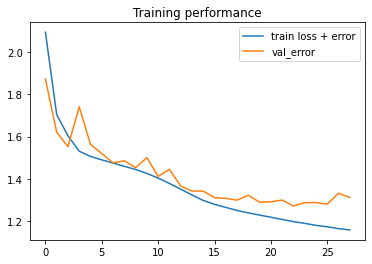

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

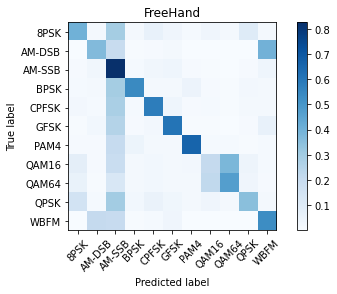

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08803863298662705


Overall Accuracy:  0.09833641404805915


Overall Accuracy:  0.10038882997525628


Overall Accuracy:  0.11841180604356992


Overall Accuracy:  0.13367052023121387


Overall Accuracy:  0.21160042964554243


Overall Accuracy:  0.3124328197778574


Overall Accuracy:  0.4095203488372093


Overall Accuracy:  0.49485268015619455


Overall Accuracy:  0.6110711718188354


Overall Accuracy:  0.6902687000726216


Overall Accuracy:  0.7345834835917778


Overall Accuracy:  0.7442125237191651


Overall Accuracy:  0.7604477611940299


Overall Accuracy:  0.7687319884726225


Overall Accuracy:  0.7746992344148742


Overall Accuracy:  0.7649018881895594


Overall Accuracy:  0.7694622038360286


Overall Accuracy:  0.7641857037582903


Overall Accuracy:  0.7645161290322581


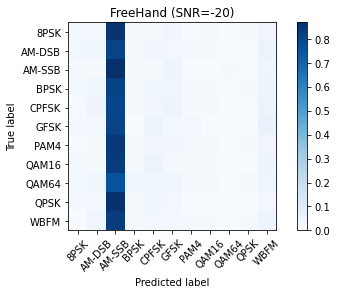

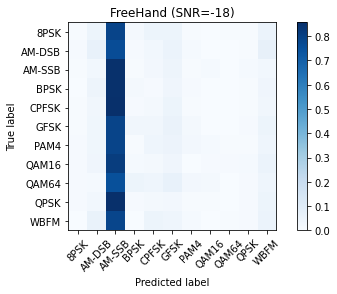

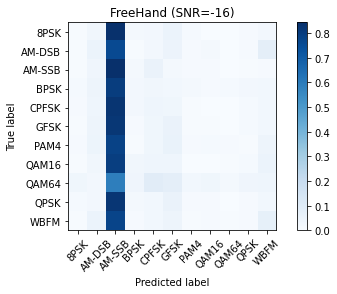

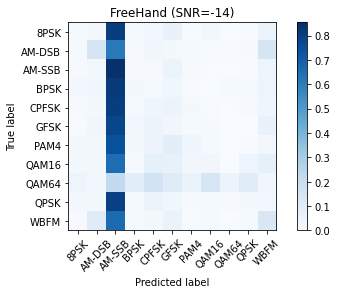

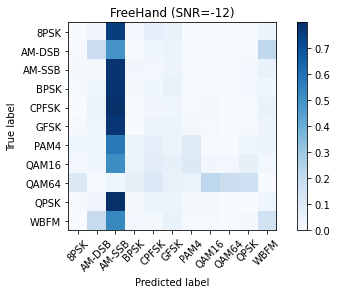

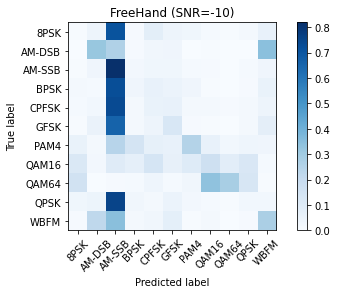

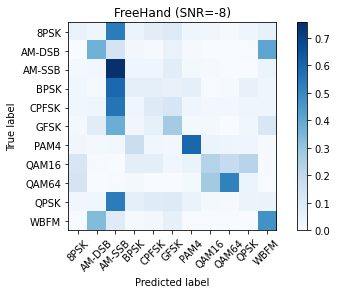

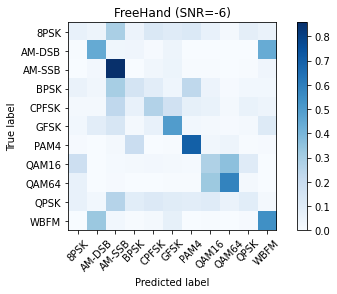

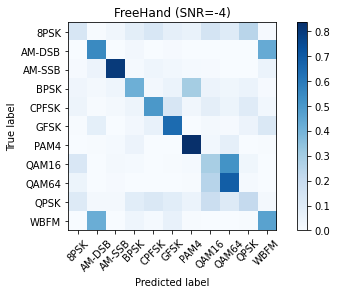

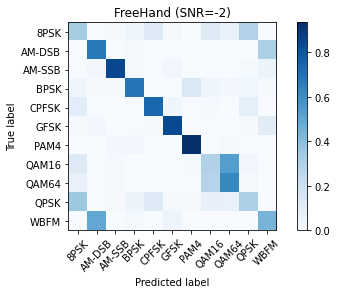

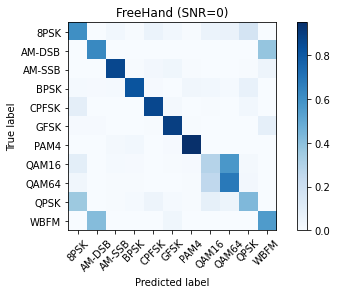

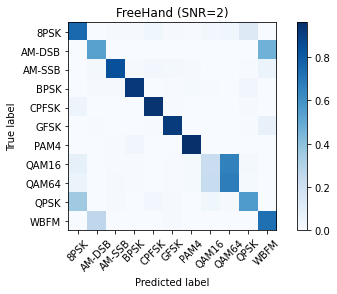

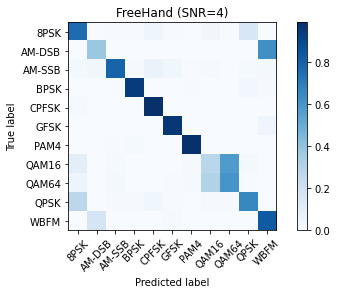

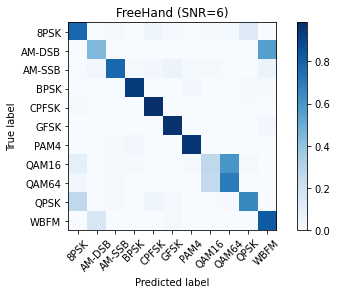

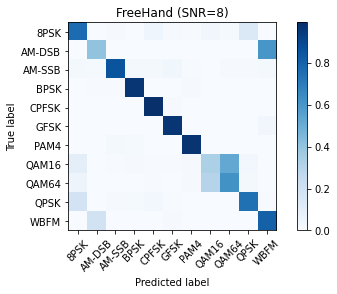

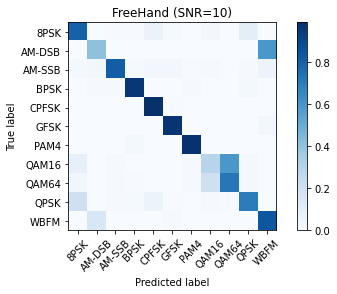

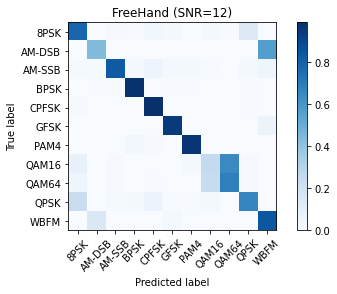

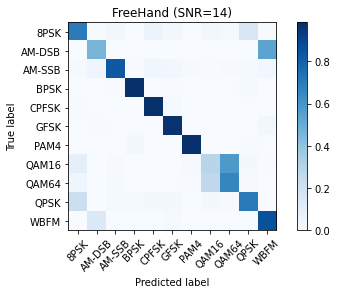

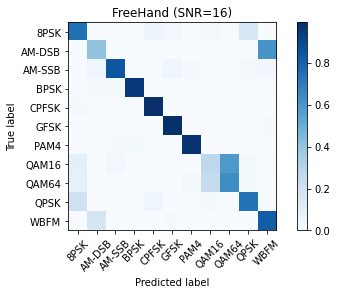

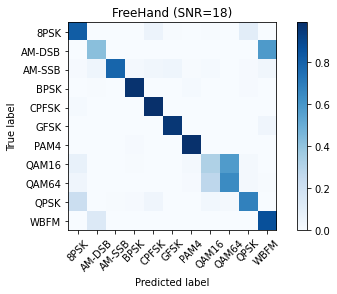

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

-20  -18  -16  -14  -12  -10  -8   -6   -4   -2    0    2    4   \
Accuracy %    8    9   10   11   13   21   31   40   49   61   69   73   74   

             6    8    10   12   14   16   18  
Accuracy %   76   76   77   76   76   76   76

In [18]:
import statistics

statistics.mean(acc.values())

0.5057166634900796

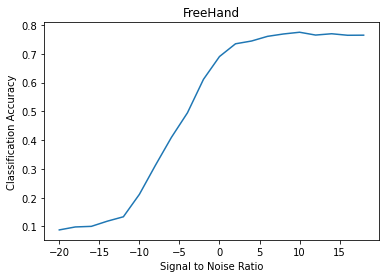

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)